In [16]:
import os 
import shutil
from cobaya.run import run
import time
import numpy as np
import matplotlib.pylab as plt
import emcee
from getdist import plots, MCSamples
import getdist
import scipy.stats as ss
import pandas as pd
import gc

import numpyro
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, init_to_value
from numpyro.handlers import seed
from numpyro.distributions import constraints
from numpyro.diagnostics import summary
from jax import grad, jit, vmap, jacfwd, jacrev
from utils.helpers import pickle_save, dill_save, dill_load, pickle_load
import random 

%env XLA_PYTHON_CLIENT_PREALLOCATE=false

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
figSize = (12, 8)
fontSize = 15

settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 0.3,
    "smooth_scale_1D": 0.3,
}
color1 = "#50C878"
color2 = "tomato"
color3 = "#222E50"
alpha = 0.9
palefactor = 0.9
linewidth = 2
contours = [0.68, 0.95]

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [26]:
# Cobaya 
NSAMPLES_CB = 500000
OUTPUT_FOLDER = 'CobayaROS/'

# EMCEE 
NSAMPLES = 2000

# NUTS 
TREE_DEPTH = 6
EPS = 0.01
NSAMPLES_NUTS = 15000
WARMUP = 500
THIN = None 

# General setup 
fiducial = np.ones(2)
normal_prior = ss.norm(0, 1)

In [3]:
def rosenbrock(xvalues):
    x_i_plus_one = xvalues[1::2]
    x_i = xvalues[0::2]
    term_1 = 9 * (x_i_plus_one - x_i**2) ** 2
    term_2 = (x_i - 1) ** 2
    return sum(term_1 + term_2)


def loglikelihood(xvalues):
    return -rosenbrock(xvalues)


@jax.jit
def jit_loglike(xvalues):
    return loglikelihood(xvalues)


@jax.jit
def jit_grad_loglike(xvalues):
    return jax.jacfwd(loglikelihood)(xvalues)

# $\frac{\tau[\nabla \mathcal{L}]}{\tau[\mathcal{L}]}$

In [4]:
%%timeit
jit_loglike(fiducial)

34.5 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [5]:
%%timeit
jit_loglike(fiducial)

35.4 µs ± 2.24 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
%%timeit
jit_grad_loglike(fiducial)

34.7 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%%timeit
jit_grad_loglike(fiducial)

35.4 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
dimensions = np.arange(1, 6, 1, dtype=int) * 20
nrepeat = 10

tau_like = []
tau_gradlike = []

for repeat in range(nrepeat):
    record_tau_like = []
    record_tau_grad_like = []

    for d in dimensions:
        testpoint = jnp.ones(d) + 1e-2

        start_time = time.time()
        loglike = jit_loglike(testpoint)
        time_taken = time.time() - start_time
        record_tau_like.append(time_taken)

        start_time = time.time()
        grad_loglike = jit_grad_loglike(testpoint)
        time_taken = time.time() - start_time
        record_tau_grad_like.append(time_taken)

    record_tau_like = np.asarray(record_tau_like)
    record_tau_grad_like = np.asarray(record_tau_grad_like)
    tau_like.append(record_tau_like)
    tau_gradlike.append(record_tau_grad_like)

tau_like = np.asarray(tau_like)
tau_gradlike = np.asarray(tau_gradlike)

In [9]:
time_ratio = np.mean(tau_gradlike / tau_like, axis=0)
time_ratio_error = np.std(tau_gradlike / tau_like, axis=0)

In [10]:
# dill_save(time_ratio, 'rosenbrock', 'gL_L_time_ratio')
# dill_save(time_ratio_error, 'rosenbrock', 'gL_L_time_ratio_error')

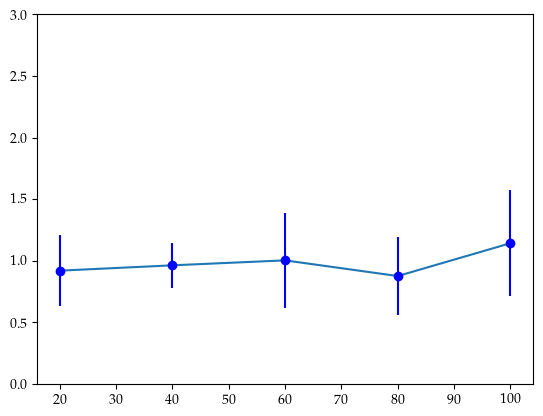

In [11]:
plt.plot(dimensions, time_ratio)
plt.errorbar(dimensions, time_ratio, yerr=time_ratio_error, fmt="bo")
plt.ylim(0, 3)
plt.show()

## EMCEE

In [4]:
def logposterior(xvalues):
    logprior = sum([normal_prior.logpdf(xvalues[i]) for i in range(len(xvalues))])
    if np.isfinite(logprior):
        return logprior + jit_loglike(xvalues)
    return -1e32

def single_emcee_run(fiducial, ndim):
    pos = fiducial + 1e-2 * np.random.randn(2 * ndim, ndim)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
    sampler.run_mcmc(pos, NSAMPLES, progress=True)
    return sampler


def emcee_sampler(fiducial):
    ndim = len(fiducial)
    record_samples = []
    nsteps = 0
    accep_prob = []
    for chain in range(2):
        sampler = single_emcee_run(fiducial, ndim)
        # emcee_samples = sampler.get_chain(discard=DISCARD, flat=True)
        emcee_samples = sampler.flatchain
        nsteps += emcee_samples.shape[0]
        accep_prob.append(np.mean(sampler.acceptance_fraction))
        record_samples.append(emcee_samples)
    return record_samples, nsteps, accep_prob

# Cobaya

In [12]:
class cobaya_rose:
    def __init__(self, ndim):
        self.ndim = ndim 
        self.pnames = [f'p{i}' for i in range(self.ndim)]
        
    def ros_like(self, **kwargs):
        params = np.array([kwargs[p] for p in self.pnames])
        logprior = sum([normal_prior.logpdf(params[i]) for i in range(len(params))])
        logp =  -rosenbrock(params) 
        return logp + logprior
    
    def run_sampler(self, nsamples, iteration, proposal=1E-2, criterion = 1E-2):
        info = {"likelihood": {"rosenbrock_like": {
                "external": self.ros_like,
                "input_params": self.pnames}}}
        
        position = {
                "prior": {"min": -5.0, "max": 5.0},
                "ref": {"dist": "norm", "loc": 0.0, "scale": 1.0},
                "proposal": proposal
                 }
        pnames = [f'p{i}' for i in range(self.ndim)]
        info["params"] = {f'p{i}': position for i in range(self.ndim)}
        info["sampler"] = {"mcmc": {"max_samples": nsamples, 
                                    "Rminus1_stop": criterion,
                                    "covmat": np.eye(self.ndim),
                                    "covmat_params": pnames
                                   }
                          }
        
        path =  OUTPUT_FOLDER + f"experiment_{self.ndim}_{iteration}/"
        if os.path.exists(path) and os.path.isdir(path):
            shutil.rmtree(path)
        info["output"] = path + "ros"
        updated_info, sampler = run(info, debug=False)
        return sampler

## NUTS

In [34]:
def model(ndim):
    xvalues = jnp.zeros(ndim)
    for i in range(ndim):
        y = numpyro.sample(f"x{i}", dist.Normal(0, 1))
        xvalues = xvalues.at[i].set(y)
    numpyro.factor("log_prob", jit_loglike(xvalues))

In [35]:
def nuts_sampler(initial):
    ndim = len(initial)
    init_strategy = init_to_value(values={f"x{i}": initial[i] for i in range(ndim)})
    nuts_kernel = NUTS(
        model,
        step_size=EPS,
        dense_mass=True,
        max_tree_depth=TREE_DEPTH,
        init_strategy=init_strategy,
    )
    mcmc = MCMC(
        nuts_kernel,
        num_chains=2,
        num_warmup=WARMUP,
        num_samples=NSAMPLES_NUTS,
        chain_method="vectorized",
    )
    random_integer = random.randint(0, 1000)
    mcmc.run(
        jax.random.PRNGKey(random_integer),
        ndim=ndim,
        extra_fields=("potential_energy", "num_steps", "accept_prob"),
    )
    nsteps = mcmc.get_extra_fields(group_by_chain=False)['num_steps'].sum().item()
    accep_prob = mcmc.last_state.accept_prob.tolist()
    
    pickle_save(mcmc, 'rosenbrock', f'nuts_{ndim}')
    return mcmc, nsteps, accep_prob

In [23]:
def process_nuts_chains(mcmc, ndim):
    chains = mcmc.get_samples(group_by_chain=True)
    record = []
    for c in range(2):
        samples = np.vstack([np.asarray(chains[f"x{i}"][c]) for i in range(ndim)]).T
        record.append(samples)
    return record

In [24]:
def calculate_summary(samples_1, samples_2, nlike, thin=None, ndecimal=3):
    record = []
    for i in range(samples_1.shape[1]):
        if thin is not None:
            x1 = samples_1[:,i][0::thin]
            x2 = samples_2[:,i][0::thin]
        else:
            x1 = samples_1[:,i]
            x2 = samples_2[:,i]
        
        testsamples = np.vstack(([x1, x2]))
        summary_stats = summary(testsamples)
        summary_stats[f"p_{i}"] = summary_stats.pop("Param:0")
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(
            pd.DataFrame(record[i])
            .round(ndecimal)
            .loc[["r_hat", "n_eff", "mean", "std"]]
        )
        
    record_df = pd.concat(record_df, axis=1).T
    record_df["scaled_n_eff"] = record_df["n_eff"] / nlike
    return record_df

def calculate_metrics(results):

    mean_neff = results['scaled_n_eff'].mean()
    
    # distance calculations 
    ndimensions = results.shape[0]
    reference = pd.DataFrame([[0.45, 0.45], [0.39, 0.48]] * int(ndimensions / 2), columns=["mean", "std"])
    reference.index = [f"p_{i}" for i in range(ndimensions)]
    difference_mean = np.abs(results["mean"] - reference["mean"])
    difference_std = np.abs(results["std"] - reference["std"])
    
    mean_mean = np.mean(difference_mean)
    mean_std = np.mean(difference_std)
    return {'mean_neff': mean_neff, 'mean_mean': mean_mean, 'mean_std': mean_std}

In [38]:
def run_nuts(ndim):
    initial = [0.45, 0.39] * int(ndim/2)
    mcmc_nuts, nsteps_nuts, accep_prob = nuts_sampler(initial)
    nuts_samples = process_nuts_chains(mcmc_nuts, ndim)
    stats = calculate_summary(nuts_samples[0], nuts_samples[1], nsteps_nuts, thin = THIN)
    nuts_metrics = calculate_metrics(stats)
    nuts_metrics['ap'] = np.mean(accep_prob)
    nuts_metrics['nevals'] = nsteps_nuts
    return nuts_samples, stats, nuts_metrics

def run_emcee(ndim):
    initial = [0.45, 0.39] * int(ndim/2)
    emcee_samples, nsteps_emcee, accep_prob = emcee_sampler(initial)
    stats = calculate_summary(emcee_samples[0], emcee_samples[1], nsteps_emcee, thin = THIN)
    emcee_metrics = calculate_metrics(stats)
    emcee_metrics['ap'] = np.mean(accep_prob)
    emcee_metrics['nevals'] = nsteps_emcee
    return emcee_samples, stats, emcee_metrics

def run_cobaya(ndim):
    experiment_1 = cobaya_rose(ndim=ndim)
    sampler_1 = experiment_1.run_sampler(nsamples=NSAMPLES_CB, iteration=1, proposal=1E-3)

    experiment_2 = cobaya_rose(ndim=ndim)
    sampler_2 = experiment_2.run_sampler(nsamples=NSAMPLES_CB, iteration=2, proposal=1E-3)
    
    acceptance_rate = [sampler_1.get_acceptance_rate(), sampler_2.get_acceptance_rate()]
    
    data_1 = sampler_1.samples()
    data_2 = sampler_2.samples()
    pnames = data_1.sampled_params
    samples_1 = data_1.data[pnames].values
    samples_2 = data_2.data[pnames].values
    
    
    nsamples = [samples_1.shape[0], samples_2.shape[0]]
    minN = min(nsamples)
    
    nevals = sum(data_1.data.weight) + sum(data_2.data.weight)
    
    stats = calculate_summary(samples_1[-minN:], samples_2[-minN:], nevals, thin=THIN)
    cb_metrics = calculate_metrics(stats)
    cb_metrics['ap'] = np.mean(acceptance_rate)
    cb_metrics['nevals'] = nevals
    return [samples_1, samples_2], stats, cb_metrics 

# Single Experiment

In [19]:
ndimplot = 6

In [20]:
# emcee_samples, emcee_stats, emcee_metrics = run_emcee(ndim=ndimplot)

In [21]:
nuts_samples, nuts_stats, nuts_metrics = run_nuts(ndim=ndimplot)

sample: 100%|████████████████████████████████████████████████████████████████████████████████| 15500/15500 [00:59<00:00, 262.06it/s]


In [22]:
cobaya_samples, cobaya_stats, cobaya_metrics = run_cobaya(ndim=ndimplot)

INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_6_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_6_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.285995, p1:-0.2758249, p2:0.7833335, p3:2.41759, p4:-0.6902343, p5:0.3446984


[mcmc] Initial point: p0:1.285995, p1:-0.2758249, p2:0.7833335, p3:2.41759, p4:-0.6902343, p5:0.3446984


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 2090.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 2090.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 20:17:32 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 20:17:32 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 240 samples accepted.


[mcmc] Learn + convergence test @ 240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.054


[mcmc]  - Acceptance rate: 0.054


INFO:mcmc: - Convergence of means: R-1 = 2.992178 after 192 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.992178 after 192 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.058


[mcmc]  - Acceptance rate: 0.058


INFO:mcmc: - Convergence of means: R-1 = 1.155418 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.155418 after 384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 720 samples accepted.


[mcmc] Learn + convergence test @ 720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.084


[mcmc]  - Acceptance rate: 0.084


INFO:mcmc: - Convergence of means: R-1 = 0.994428 after 576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.994428 after 576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.328005 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.328005 after 768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.137


[mcmc]  - Acceptance rate: 0.137


INFO:mcmc: - Convergence of means: R-1 = 0.343794 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.343794 after 960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.307939 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.307939 after 1152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1680 samples accepted.


[mcmc] Learn + convergence test @ 1680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.283518 after 1344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.283518 after 1344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.184638 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.184638 after 1536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2160 samples accepted.


[mcmc] Learn + convergence test @ 2160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.120666 after 1728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.120666 after 1728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.207


[mcmc]  - Acceptance rate: 0.207


INFO:mcmc: - Convergence of means: R-1 = 0.099139 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099139 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2640 samples accepted.


[mcmc] Learn + convergence test @ 2640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.094004 after 2112 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094004 after 2112 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.033658 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033658 after 2304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3120 samples accepted.


[mcmc] Learn + convergence test @ 3120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.058457 after 2496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058457 after 2496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3360 samples accepted.


[mcmc] Learn + convergence test @ 3360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.074044 after 2688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074044 after 2688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.074372 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074372 after 2880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.059126 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059126 after 3072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4080 samples accepted.


[mcmc] Learn + convergence test @ 4080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.065820 after 3264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065820 after 3264 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4320 samples accepted.


[mcmc] Learn + convergence test @ 4320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.052776 after 3456 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052776 after 3456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4560 samples accepted.


[mcmc] Learn + convergence test @ 4560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.058539 after 3648 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058539 after 3648 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.053139 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053139 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5040 samples accepted.


[mcmc] Learn + convergence test @ 5040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.048500 after 4032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048500 after 4032 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5280 samples accepted.


[mcmc] Learn + convergence test @ 5280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.038088 after 4224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038088 after 4224 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5520 samples accepted.


[mcmc] Learn + convergence test @ 5520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.039860 after 4416 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039860 after 4416 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.032087 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032087 after 4608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.035118 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035118 after 4800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6240 samples accepted.


[mcmc] Learn + convergence test @ 6240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.038214 after 4992 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038214 after 4992 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6480 samples accepted.


[mcmc] Learn + convergence test @ 6480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.039368 after 5184 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039368 after 5184 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.047531 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047531 after 5376 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6960 samples accepted.


[mcmc] Learn + convergence test @ 6960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.041208 after 5568 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041208 after 5568 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.035015 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035015 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7440 samples accepted.


[mcmc] Learn + convergence test @ 7440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.048160 after 5952 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048160 after 5952 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.047582 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047582 after 6144 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7920 samples accepted.


[mcmc] Learn + convergence test @ 7920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.038085 after 6336 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038085 after 6336 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8160 samples accepted.


[mcmc] Learn + convergence test @ 8160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.033651 after 6528 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033651 after 6528 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.030174 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030174 after 6720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.022250 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022250 after 6912 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8880 samples accepted.


[mcmc] Learn + convergence test @ 8880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.018776 after 7104 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018776 after 7104 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9120 samples accepted.


[mcmc] Learn + convergence test @ 9120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.021186 after 7296 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021186 after 7296 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9360 samples accepted.


[mcmc] Learn + convergence test @ 9360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.024733 after 7488 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024733 after 7488 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.034404 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034404 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9840 samples accepted.


[mcmc] Learn + convergence test @ 9840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.056163 after 7872 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056163 after 7872 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10080 samples accepted.


[mcmc] Learn + convergence test @ 10080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.043260 after 8064 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043260 after 8064 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10320 samples accepted.


[mcmc] Learn + convergence test @ 10320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.031633 after 8256 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031633 after 8256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.017859 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017859 after 8448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.019134 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019134 after 8640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11040 samples accepted.


[mcmc] Learn + convergence test @ 11040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.028653 after 8832 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028653 after 8832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11280 samples accepted.


[mcmc] Learn + convergence test @ 11280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.045166 after 9024 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045166 after 9024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.046285 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046285 after 9216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11760 samples accepted.


[mcmc] Learn + convergence test @ 11760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.054816 after 9408 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054816 after 9408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.056475 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056475 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12240 samples accepted.


[mcmc] Learn + convergence test @ 12240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.049040 after 9792 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049040 after 9792 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12480 samples accepted.


[mcmc] Learn + convergence test @ 12480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.043468 after 9984 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043468 after 9984 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12720 samples accepted.


[mcmc] Learn + convergence test @ 12720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.206


[mcmc]  - Acceptance rate: 0.206


INFO:mcmc: - Convergence of means: R-1 = 0.041018 after 10176 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041018 after 10176 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12960 samples accepted.


[mcmc] Learn + convergence test @ 12960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.037098 after 10368 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037098 after 10368 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13200 samples accepted.


[mcmc] Learn + convergence test @ 13200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.034652 after 10560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034652 after 10560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.049963 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049963 after 10752 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13680 samples accepted.


[mcmc] Learn + convergence test @ 13680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.038798 after 10944 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038798 after 10944 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13920 samples accepted.


[mcmc] Learn + convergence test @ 13920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.035271 after 11136 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035271 after 11136 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14160 samples accepted.


[mcmc] Learn + convergence test @ 14160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.035970 after 11328 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035970 after 11328 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.039499 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039499 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14640 samples accepted.


[mcmc] Learn + convergence test @ 14640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.205


[mcmc]  - Acceptance rate: 0.205


INFO:mcmc: - Convergence of means: R-1 = 0.040896 after 11712 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040896 after 11712 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14880 samples accepted.


[mcmc] Learn + convergence test @ 14880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.044652 after 11904 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044652 after 11904 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15120 samples accepted.


[mcmc] Learn + convergence test @ 15120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.046075 after 12096 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046075 after 12096 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.043593 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043593 after 12288 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15600 samples accepted.


[mcmc] Learn + convergence test @ 15600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.043833 after 12480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043833 after 12480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15840 samples accepted.


[mcmc] Learn + convergence test @ 15840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.037858 after 12672 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037858 after 12672 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16080 samples accepted.


[mcmc] Learn + convergence test @ 16080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.037498 after 12864 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037498 after 12864 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16320 samples accepted.


[mcmc] Learn + convergence test @ 16320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.030860 after 13056 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030860 after 13056 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16560 samples accepted.


[mcmc] Learn + convergence test @ 16560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.204


[mcmc]  - Acceptance rate: 0.204


INFO:mcmc: - Convergence of means: R-1 = 0.029711 after 13248 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029711 after 13248 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.031614 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031614 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17040 samples accepted.


[mcmc] Learn + convergence test @ 17040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.031039 after 13632 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031039 after 13632 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17280 samples accepted.


[mcmc] Learn + convergence test @ 17280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.030666 after 13824 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030666 after 13824 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17520 samples accepted.


[mcmc] Learn + convergence test @ 17520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.028124 after 14016 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028124 after 14016 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17760 samples accepted.


[mcmc] Learn + convergence test @ 17760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.029817 after 14208 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029817 after 14208 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.026982 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026982 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18240 samples accepted.


[mcmc] Learn + convergence test @ 18240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.021216 after 14592 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021216 after 14592 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18480 samples accepted.


[mcmc] Learn + convergence test @ 18480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.018516 after 14784 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018516 after 14784 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18720 samples accepted.


[mcmc] Learn + convergence test @ 18720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.020016 after 14976 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020016 after 14976 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18960 samples accepted.


[mcmc] Learn + convergence test @ 18960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.019438 after 15168 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019438 after 15168 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.016168 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016168 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19440 samples accepted.


[mcmc] Learn + convergence test @ 19440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.016153 after 15552 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016153 after 15552 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19680 samples accepted.


[mcmc] Learn + convergence test @ 19680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.021800 after 15744 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021800 after 15744 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19920 samples accepted.


[mcmc] Learn + convergence test @ 19920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.202


[mcmc]  - Acceptance rate: 0.202


INFO:mcmc: - Convergence of means: R-1 = 0.024190 after 15936 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024190 after 15936 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:18:32 : 105128 steps taken, and 20020 accepted.


[mcmc] Progress @ 2024-05-02 20:18:32 : 105128 steps taken, and 20020 accepted.


INFO:mcmc:Learn + convergence test @ 20160 samples accepted.


[mcmc] Learn + convergence test @ 20160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.021606 after 16128 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021606 after 16128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20400 samples accepted.


[mcmc] Learn + convergence test @ 20400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.022411 after 16320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022411 after 16320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20640 samples accepted.


[mcmc] Learn + convergence test @ 20640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.023806 after 16512 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023806 after 16512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20880 samples accepted.


[mcmc] Learn + convergence test @ 20880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.023690 after 16704 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023690 after 16704 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21120 samples accepted.


[mcmc] Learn + convergence test @ 21120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.020241 after 16896 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020241 after 16896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21360 samples accepted.


[mcmc] Learn + convergence test @ 21360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.018562 after 17088 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018562 after 17088 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.019882 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019882 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21840 samples accepted.


[mcmc] Learn + convergence test @ 21840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.019942 after 17472 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019942 after 17472 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22080 samples accepted.


[mcmc] Learn + convergence test @ 22080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.017513 after 17664 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017513 after 17664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22320 samples accepted.


[mcmc] Learn + convergence test @ 22320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.016573 after 17856 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016573 after 17856 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22560 samples accepted.


[mcmc] Learn + convergence test @ 22560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.021541 after 18048 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021541 after 18048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22800 samples accepted.


[mcmc] Learn + convergence test @ 22800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.019281 after 18240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019281 after 18240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23040 samples accepted.


[mcmc] Learn + convergence test @ 23040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.019023 after 18432 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019023 after 18432 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23280 samples accepted.


[mcmc] Learn + convergence test @ 23280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.019946 after 18624 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019946 after 18624 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23520 samples accepted.


[mcmc] Learn + convergence test @ 23520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.024197 after 18816 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024197 after 18816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23760 samples accepted.


[mcmc] Learn + convergence test @ 23760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.024965 after 19008 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024965 after 19008 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.027222 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027222 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24240 samples accepted.


[mcmc] Learn + convergence test @ 24240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.024245 after 19392 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024245 after 19392 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24480 samples accepted.


[mcmc] Learn + convergence test @ 24480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.020634 after 19584 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020634 after 19584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24720 samples accepted.


[mcmc] Learn + convergence test @ 24720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.022245 after 19776 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022245 after 19776 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24960 samples accepted.


[mcmc] Learn + convergence test @ 24960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.027954 after 19968 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027954 after 19968 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.027203 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027203 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25440 samples accepted.


[mcmc] Learn + convergence test @ 25440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.028085 after 20352 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028085 after 20352 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25680 samples accepted.


[mcmc] Learn + convergence test @ 25680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.022505 after 20544 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022505 after 20544 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25920 samples accepted.


[mcmc] Learn + convergence test @ 25920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.023062 after 20736 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023062 after 20736 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26160 samples accepted.


[mcmc] Learn + convergence test @ 26160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.021249 after 20928 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021249 after 20928 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.018699 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018699 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26640 samples accepted.


[mcmc] Learn + convergence test @ 26640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.020264 after 21312 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020264 after 21312 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26880 samples accepted.


[mcmc] Learn + convergence test @ 26880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.018760 after 21504 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018760 after 21504 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27120 samples accepted.


[mcmc] Learn + convergence test @ 27120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.014668 after 21696 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014668 after 21696 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27360 samples accepted.


[mcmc] Learn + convergence test @ 27360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.012584 after 21888 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012584 after 21888 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27600 samples accepted.


[mcmc] Learn + convergence test @ 27600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.014150 after 22080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014150 after 22080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27840 samples accepted.


[mcmc] Learn + convergence test @ 27840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.018368 after 22272 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018368 after 22272 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28080 samples accepted.


[mcmc] Learn + convergence test @ 28080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.017283 after 22464 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017283 after 22464 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28320 samples accepted.


[mcmc] Learn + convergence test @ 28320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.012808 after 22656 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012808 after 22656 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28560 samples accepted.


[mcmc] Learn + convergence test @ 28560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.012528 after 22848 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012528 after 22848 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.012982 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012982 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29040 samples accepted.


[mcmc] Learn + convergence test @ 29040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.014408 after 23232 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014408 after 23232 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29280 samples accepted.


[mcmc] Learn + convergence test @ 29280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.013487 after 23424 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013487 after 23424 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29520 samples accepted.


[mcmc] Learn + convergence test @ 29520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.014269 after 23616 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014269 after 23616 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29760 samples accepted.


[mcmc] Learn + convergence test @ 29760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.013650 after 23808 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013650 after 23808 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30000 samples accepted.


[mcmc] Learn + convergence test @ 30000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.015130 after 24000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015130 after 24000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30240 samples accepted.


[mcmc] Learn + convergence test @ 30240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.013303 after 24192 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013303 after 24192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30480 samples accepted.


[mcmc] Learn + convergence test @ 30480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.012464 after 24384 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012464 after 24384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30720 samples accepted.


[mcmc] Learn + convergence test @ 30720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.010885 after 24576 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010885 after 24576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30960 samples accepted.


[mcmc] Learn + convergence test @ 30960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.010469 after 24768 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010469 after 24768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.011291 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011291 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31440 samples accepted.


[mcmc] Learn + convergence test @ 31440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.015605 after 25152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015605 after 25152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31680 samples accepted.


[mcmc] Learn + convergence test @ 31680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.016210 after 25344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016210 after 25344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31920 samples accepted.


[mcmc] Learn + convergence test @ 31920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.013282 after 25536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013282 after 25536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32160 samples accepted.


[mcmc] Learn + convergence test @ 32160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.012265 after 25728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012265 after 25728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32400 samples accepted.


[mcmc] Learn + convergence test @ 32400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.013830 after 25920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013830 after 25920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32640 samples accepted.


[mcmc] Learn + convergence test @ 32640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.015073 after 26112 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015073 after 26112 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32880 samples accepted.


[mcmc] Learn + convergence test @ 32880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.014895 after 26304 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014895 after 26304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33120 samples accepted.


[mcmc] Learn + convergence test @ 33120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.014041 after 26496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014041 after 26496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33360 samples accepted.


[mcmc] Learn + convergence test @ 33360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.016843 after 26688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016843 after 26688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.015665 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015665 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33840 samples accepted.


[mcmc] Learn + convergence test @ 33840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.014857 after 27072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014857 after 27072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34080 samples accepted.


[mcmc] Learn + convergence test @ 34080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.014726 after 27264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014726 after 27264 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34320 samples accepted.


[mcmc] Learn + convergence test @ 34320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.011725 after 27456 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011725 after 27456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34560 samples accepted.


[mcmc] Learn + convergence test @ 34560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.011891 after 27648 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011891 after 27648 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34800 samples accepted.


[mcmc] Learn + convergence test @ 34800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.013327 after 27840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013327 after 27840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35040 samples accepted.


[mcmc] Learn + convergence test @ 35040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.013064 after 28032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013064 after 28032 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35280 samples accepted.


[mcmc] Learn + convergence test @ 35280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.012780 after 28224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012780 after 28224 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35520 samples accepted.


[mcmc] Learn + convergence test @ 35520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.013166 after 28416 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013166 after 28416 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35760 samples accepted.


[mcmc] Learn + convergence test @ 35760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.012909 after 28608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012909 after 28608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.012415 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012415 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36240 samples accepted.


[mcmc] Learn + convergence test @ 36240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.013050 after 28992 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013050 after 28992 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36480 samples accepted.


[mcmc] Learn + convergence test @ 36480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.009848 after 29184 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009848 after 29184 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36720 samples accepted.


[mcmc] Learn + convergence test @ 36720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.009057 after 29376 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009057 after 29376 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.093132 after 36720 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.093132 after 36720 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 36720 accepted steps.


[mcmc] Sampling complete after 36720 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_6_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_6_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.676842, p1:0.6976773, p2:0.6987994, p3:-1.049415, p4:0.2294286, p5:0.3095686


[mcmc] Initial point: p0:-0.676842, p1:0.6976773, p2:0.6987994, p3:-1.049415, p4:0.2294286, p5:0.3095686


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 2080.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 2080.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 20:19:22 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 20:19:22 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 240 samples accepted.


[mcmc] Learn + convergence test @ 240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 1.959098 after 192 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.959098 after 192 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.096


[mcmc]  - Acceptance rate: 0.096


INFO:mcmc: - Convergence of means: R-1 = 2.036055 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.036055 after 384 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 720 samples accepted.


[mcmc] Learn + convergence test @ 720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 1.565509 after 576 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.565509 after 576 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.928233 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.928233 after 768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.209


[mcmc]  - Acceptance rate: 0.209


INFO:mcmc: - Convergence of means: R-1 = 0.619661 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.619661 after 960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.207


[mcmc]  - Acceptance rate: 0.207


INFO:mcmc: - Convergence of means: R-1 = 0.357458 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.357458 after 1152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1680 samples accepted.


[mcmc] Learn + convergence test @ 1680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.203


[mcmc]  - Acceptance rate: 0.203


INFO:mcmc: - Convergence of means: R-1 = 0.283630 after 1344 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.283630 after 1344 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.149029 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149029 after 1536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2160 samples accepted.


[mcmc] Learn + convergence test @ 2160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.256324 after 1728 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.256324 after 1728 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.230623 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.230623 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2640 samples accepted.


[mcmc] Learn + convergence test @ 2640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.194583 after 2112 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.194583 after 2112 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.159037 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.159037 after 2304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3120 samples accepted.


[mcmc] Learn + convergence test @ 3120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.103075 after 2496 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103075 after 2496 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3360 samples accepted.


[mcmc] Learn + convergence test @ 3360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.127449 after 2688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.127449 after 2688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.092632 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092632 after 2880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.064902 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064902 after 3072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4080 samples accepted.


[mcmc] Learn + convergence test @ 4080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.074260 after 3264 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074260 after 3264 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4320 samples accepted.


[mcmc] Learn + convergence test @ 4320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.074134 after 3456 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074134 after 3456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4560 samples accepted.


[mcmc] Learn + convergence test @ 4560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.072195 after 3648 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072195 after 3648 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.070817 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070817 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5040 samples accepted.


[mcmc] Learn + convergence test @ 5040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.070850 after 4032 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070850 after 4032 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5280 samples accepted.


[mcmc] Learn + convergence test @ 5280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.069193 after 4224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069193 after 4224 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5520 samples accepted.


[mcmc] Learn + convergence test @ 5520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.052082 after 4416 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052082 after 4416 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.045906 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045906 after 4608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.052434 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052434 after 4800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6240 samples accepted.


[mcmc] Learn + convergence test @ 6240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.030305 after 4992 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030305 after 4992 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6480 samples accepted.


[mcmc] Learn + convergence test @ 6480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.019595 after 5184 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019595 after 5184 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.025786 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025786 after 5376 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6960 samples accepted.


[mcmc] Learn + convergence test @ 6960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.028310 after 5568 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028310 after 5568 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.045514 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045514 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7440 samples accepted.


[mcmc] Learn + convergence test @ 7440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.049902 after 5952 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049902 after 5952 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.044017 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044017 after 6144 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7920 samples accepted.


[mcmc] Learn + convergence test @ 7920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.042561 after 6336 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042561 after 6336 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8160 samples accepted.


[mcmc] Learn + convergence test @ 8160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.028589 after 6528 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028589 after 6528 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.046900 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046900 after 6720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8640 samples accepted.


[mcmc] Learn + convergence test @ 8640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.048302 after 6912 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048302 after 6912 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8880 samples accepted.


[mcmc] Learn + convergence test @ 8880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.024095 after 7104 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024095 after 7104 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9120 samples accepted.


[mcmc] Learn + convergence test @ 9120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.026860 after 7296 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026860 after 7296 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9360 samples accepted.


[mcmc] Learn + convergence test @ 9360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.027624 after 7488 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027624 after 7488 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.028822 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028822 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9840 samples accepted.


[mcmc] Learn + convergence test @ 9840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.020122 after 7872 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020122 after 7872 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10080 samples accepted.


[mcmc] Learn + convergence test @ 10080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.024188 after 8064 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024188 after 8064 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10320 samples accepted.


[mcmc] Learn + convergence test @ 10320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.037312 after 8256 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037312 after 8256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10560 samples accepted.


[mcmc] Learn + convergence test @ 10560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.027827 after 8448 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027827 after 8448 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.025719 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025719 after 8640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11040 samples accepted.


[mcmc] Learn + convergence test @ 11040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.027163 after 8832 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027163 after 8832 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11280 samples accepted.


[mcmc] Learn + convergence test @ 11280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.034663 after 9024 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034663 after 9024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11520 samples accepted.


[mcmc] Learn + convergence test @ 11520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.028796 after 9216 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028796 after 9216 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11760 samples accepted.


[mcmc] Learn + convergence test @ 11760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.020530 after 9408 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020530 after 9408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.021907 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021907 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12240 samples accepted.


[mcmc] Learn + convergence test @ 12240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.014904 after 9792 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014904 after 9792 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12480 samples accepted.


[mcmc] Learn + convergence test @ 12480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.013962 after 9984 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013962 after 9984 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12720 samples accepted.


[mcmc] Learn + convergence test @ 12720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.018544 after 10176 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018544 after 10176 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12960 samples accepted.


[mcmc] Learn + convergence test @ 12960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.012595 after 10368 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012595 after 10368 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13200 samples accepted.


[mcmc] Learn + convergence test @ 13200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.016689 after 10560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016689 after 10560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13440 samples accepted.


[mcmc] Learn + convergence test @ 13440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.024092 after 10752 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024092 after 10752 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13680 samples accepted.


[mcmc] Learn + convergence test @ 13680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.029163 after 10944 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029163 after 10944 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13920 samples accepted.


[mcmc] Learn + convergence test @ 13920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.015443 after 11136 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015443 after 11136 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14160 samples accepted.


[mcmc] Learn + convergence test @ 14160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.012806 after 11328 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012806 after 11328 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.016870 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016870 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14640 samples accepted.


[mcmc] Learn + convergence test @ 14640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.014071 after 11712 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014071 after 11712 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14880 samples accepted.


[mcmc] Learn + convergence test @ 14880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.016879 after 11904 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016879 after 11904 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15120 samples accepted.


[mcmc] Learn + convergence test @ 15120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.013321 after 12096 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013321 after 12096 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15360 samples accepted.


[mcmc] Learn + convergence test @ 15360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.011139 after 12288 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011139 after 12288 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15600 samples accepted.


[mcmc] Learn + convergence test @ 15600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.013194 after 12480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013194 after 12480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15840 samples accepted.


[mcmc] Learn + convergence test @ 15840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.013555 after 12672 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013555 after 12672 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16080 samples accepted.


[mcmc] Learn + convergence test @ 16080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.011071 after 12864 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011071 after 12864 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16320 samples accepted.


[mcmc] Learn + convergence test @ 16320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.007624 after 13056 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.007624 after 13056 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16560 samples accepted.


[mcmc] Learn + convergence test @ 16560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.007643 after 13248 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.007643 after 13248 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.068905 after 16560 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.068905 after 16560 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 16560 accepted steps.


[mcmc] Sampling complete after 16560 accepted steps.


In [23]:
nuts_stats

r_hat      n_eff   mean    std  scaled_n_eff
p_0    1.0   7281.738  0.452  0.450      0.020585
p_1    1.0  10626.900  0.387  0.474      0.030042
p_2    1.0   6927.584  0.448  0.451      0.019584
p_3    1.0   9929.103  0.382  0.470      0.028070
p_4    1.0   7326.129  0.456  0.448      0.020711
p_5    1.0   7789.410  0.388  0.477      0.022021

In [24]:
nuts_metrics

{'mean_neff': 0.02350219186653549,
 'mean_mean': 0.0038333333333333366,
 'mean_std': 0.00366666666666667,
 'ap': 0.9819957315921783,
 'nevals': 353732}

In [25]:
cobaya_stats

r_hat     n_eff   mean    std  scaled_n_eff
p_0  1.000  1948.423  0.451  0.440      0.006990
p_1  1.001  2224.291  0.380  0.465      0.007980
p_2  1.000  2256.280  0.446  0.441      0.008095
p_3  1.000  2629.551  0.375  0.463      0.009434
p_4  1.002  1902.429  0.444  0.446      0.006825
p_5  1.001  2335.410  0.382  0.471      0.008379

In [26]:
cobaya_metrics

{'mean_neff': 0.007950604350462277,
 'mean_mean': 0.00733333333333334,
 'mean_std': 0.010666666666666658,
 'ap': 0.19037235542005584,
 'nevals': 278729.0}

In [27]:
nuts_metrics['mean_neff'] / cobaya_metrics['mean_neff']

2.9560258353403017

## Plots

In [28]:
# def model():
#     pass

In [29]:
def ros_nuts_samples(ndim):
    nuts_sampler = pickle_load('rosenbrock', f'nuts_{ndim}')
    nuts_samples = np.vstack([nuts_sampler.get_samples()[f'x{i}'].tolist() for i in range(ndim)]).T
    return nuts_samples

def ros_cobaya_samples(ndim, burnin = 0.1):
    cobaya_samples_1 = np.loadtxt(f'CobayaROS/experiment_{ndim}_1/ros.1.txt')[:,2:-4]
    cobaya_samples_2 = np.loadtxt(f'CobayaROS/experiment_{ndim}_2/ros.1.txt')[:,2:-4]
    nsamples_1 = cobaya_samples_1.shape[0]
    nsamples_2 = cobaya_samples_2.shape[0]
    start1 = int(burnin * nsamples_1)
    start2 = int(burnin * nsamples_2)
    cobaya_samples = np.concatenate([cobaya_samples_1[start1:], cobaya_samples_2[start2:]])
    return cobaya_samples

In [54]:
cobaya_samples = ros_cobaya_samples(100)
nuts_samples = ros_nuts_samples(100)

INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


In [55]:
ndimplot = 6
names = ["x%s" % i for i in range(ndimplot)]
labels = [f"$x_{i}$" for i in range(ndimplot)]
samples_cb = MCSamples(
    samples=cobaya_samples[:, 0:ndimplot], names=names, labels=labels
)

samples_nuts = MCSamples(
    samples=nuts_samples[:, 0:ndimplot], names=names, labels=labels
)

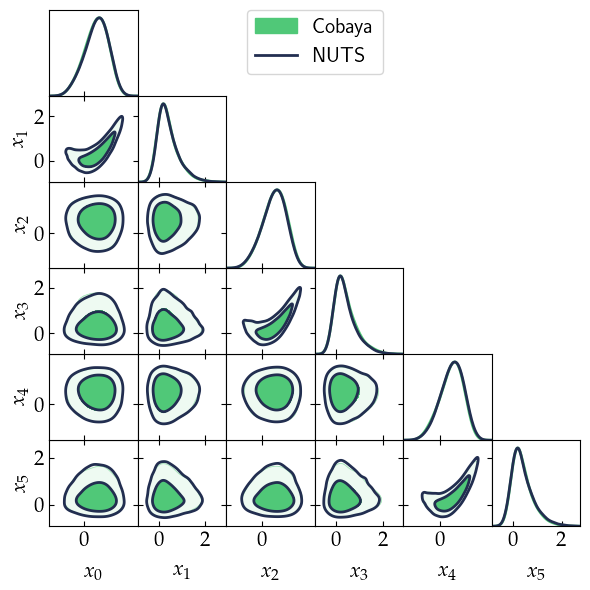

In [58]:
G = plots.getSubplotPlotter(subplot_size=1)
G.settings.solid_contour_palefactor = palefactor
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 15  # important for padding in x-axis
G.settings.line_styles = "Accent"
G.settings.legend_fontsize = 20
G.triangle_plot(
    [samples_cb, samples_nuts],
    filled=[True, False],
    contour_colors=[color1, color3],
    contour_lws=2,
    legend_labels=["Cobaya", "NUTS"],
)
# plt.savefig('plots/rosenbrock_100_6.pdf', bbox_inches = 'tight')
plt.show()

# Many Dimensions

In [39]:
dimensions = np.arange(1, 11, 1) * 10
record_emcee_metrics = []
record_nuts_metrics = []
record_cobaya_metrics = []

for ndim in dimensions:
    nuts_samples, nuts_stats, nuts_metrics = run_nuts(ndim=ndim)
    record_nuts_metrics.append(nuts_metrics)
    
    cobaya_samples, cobaya_stats, cobaya_metrics = run_cobaya(ndim=ndim)
    record_cobaya_metrics.append(cobaya_metrics)
    gc.collect()
    jax.clear_backends()
#     emcee_samples, emcee_stats, emcee_metrics = run_emcee(ndim=ndim)
#     record_emcee_metrics.append(emcee_metrics)

sample: 100%|████████████████████████████████████████████████████████████████████████████████| 15500/15500 [01:29<00:00, 173.41it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_10_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_10_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.6412984, p1:1.81654, p2:-0.984509, p3:-0.9443977, p4:-0.330693, p5:1.257966, p6:-0.1231564, p7:0.3821795, p8:1.091752, p9:-0.9728204


[mcmc] Initial point: p0:-0.6412984, p1:1.81654, p2:-0.984509, p3:-0.9443977, p4:-0.330693, p5:1.257966, p6:-0.1231564, p7:0.3821795, p8:1.091752, p9:-0.9728204


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 1260.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 1260.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 20:23:42 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 20:23:42 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 400 samples accepted.


[mcmc] Learn + convergence test @ 400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 6.209606 after 320 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.209606 after 320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.053


[mcmc]  - Acceptance rate: 0.053


INFO:mcmc: - Convergence of means: R-1 = 2.601980 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.601980 after 640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.054


[mcmc]  - Acceptance rate: 0.054


INFO:mcmc: - Convergence of means: R-1 = 1.828654 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.828654 after 960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.070


[mcmc]  - Acceptance rate: 0.070


INFO:mcmc: - Convergence of means: R-1 = 1.479147 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.479147 after 1280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2000 samples accepted.


[mcmc] Learn + convergence test @ 2000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.088


[mcmc]  - Acceptance rate: 0.088


INFO:mcmc: - Convergence of means: R-1 = 0.350026 after 1600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.350026 after 1600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.103


[mcmc]  - Acceptance rate: 0.103


INFO:mcmc: - Convergence of means: R-1 = 0.536056 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.536056 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2800 samples accepted.


[mcmc] Learn + convergence test @ 2800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.332262 after 2240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.332262 after 2240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.209642 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.209642 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.178637 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.178637 after 2880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.227631 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.227631 after 3200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4400 samples accepted.


[mcmc] Learn + convergence test @ 4400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.173493 after 3520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.173493 after 3520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.160363 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160363 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5200 samples accepted.


[mcmc] Learn + convergence test @ 5200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.226162 after 4160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.226162 after 4160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.235398 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.235398 after 4480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.111850 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111850 after 4800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.129260 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129260 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6800 samples accepted.


[mcmc] Learn + convergence test @ 6800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.201


[mcmc]  - Acceptance rate: 0.201


INFO:mcmc: - Convergence of means: R-1 = 0.142493 after 5440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.142493 after 5440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.156439 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156439 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7600 samples accepted.


[mcmc] Learn + convergence test @ 7600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.101723 after 6080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101723 after 6080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.090454 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.090454 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.200


[mcmc]  - Acceptance rate: 0.200


INFO:mcmc: - Convergence of means: R-1 = 0.115177 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115177 after 6720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8800 samples accepted.


[mcmc] Learn + convergence test @ 8800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.199


[mcmc]  - Acceptance rate: 0.199


INFO:mcmc: - Convergence of means: R-1 = 0.080391 after 7040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080391 after 7040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9200 samples accepted.


[mcmc] Learn + convergence test @ 9200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.198


[mcmc]  - Acceptance rate: 0.198


INFO:mcmc: - Convergence of means: R-1 = 0.118554 after 7360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118554 after 7360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.074480 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074480 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10000 samples accepted.


[mcmc] Learn + convergence test @ 10000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.061994 after 8000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061994 after 8000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10400 samples accepted.


[mcmc] Learn + convergence test @ 10400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.196


[mcmc]  - Acceptance rate: 0.196


INFO:mcmc: - Convergence of means: R-1 = 0.049338 after 8320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049338 after 8320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.059310 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059310 after 8640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:24:42 : 72289 steps taken, and 10876 accepted.


[mcmc] Progress @ 2024-05-02 20:24:42 : 72289 steps taken, and 10876 accepted.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.072136 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072136 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11600 samples accepted.


[mcmc] Learn + convergence test @ 11600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.085761 after 9280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085761 after 9280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.059542 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059542 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12400 samples accepted.


[mcmc] Learn + convergence test @ 12400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.065604 after 9920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065604 after 9920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.064649 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064649 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13200 samples accepted.


[mcmc] Learn + convergence test @ 13200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.065830 after 10560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065830 after 10560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13600 samples accepted.


[mcmc] Learn + convergence test @ 13600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.057033 after 10880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057033 after 10880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14000 samples accepted.


[mcmc] Learn + convergence test @ 14000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.053186 after 11200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053186 after 11200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.034839 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034839 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14800 samples accepted.


[mcmc] Learn + convergence test @ 14800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.037065 after 11840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037065 after 11840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15200 samples accepted.


[mcmc] Learn + convergence test @ 15200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.053671 after 12160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053671 after 12160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15600 samples accepted.


[mcmc] Learn + convergence test @ 15600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.073766 after 12480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073766 after 12480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.064376 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064376 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16400 samples accepted.


[mcmc] Learn + convergence test @ 16400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.070975 after 13120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070975 after 13120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.073018 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073018 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17200 samples accepted.


[mcmc] Learn + convergence test @ 17200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.048704 after 13760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048704 after 13760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.049696 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049696 after 14080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.051738 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051738 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18400 samples accepted.


[mcmc] Learn + convergence test @ 18400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.037513 after 14720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037513 after 14720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18800 samples accepted.


[mcmc] Learn + convergence test @ 18800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.032265 after 15040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032265 after 15040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.031991 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031991 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19600 samples accepted.


[mcmc] Learn + convergence test @ 19600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.034889 after 15680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034889 after 15680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.037243 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037243 after 16000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20400 samples accepted.


[mcmc] Learn + convergence test @ 20400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.032503 after 16320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032503 after 16320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.032970 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032970 after 16640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21200 samples accepted.


[mcmc] Learn + convergence test @ 21200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.043991 after 16960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043991 after 16960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.043411 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043411 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22000 samples accepted.


[mcmc] Learn + convergence test @ 22000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.036379 after 17600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036379 after 17600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.032208 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032208 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22800 samples accepted.


[mcmc] Learn + convergence test @ 22800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.037146 after 18240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037146 after 18240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23200 samples accepted.


[mcmc] Learn + convergence test @ 23200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.044647 after 18560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044647 after 18560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23600 samples accepted.


[mcmc] Learn + convergence test @ 23600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.047911 after 18880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047911 after 18880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.058350 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058350 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24400 samples accepted.


[mcmc] Learn + convergence test @ 24400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.049477 after 19520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049477 after 19520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:25:42 : 144312 steps taken, and 24452 accepted.


[mcmc] Progress @ 2024-05-02 20:25:42 : 144312 steps taken, and 24452 accepted.


INFO:mcmc:Learn + convergence test @ 24800 samples accepted.


[mcmc] Learn + convergence test @ 24800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.047187 after 19840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047187 after 19840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.049274 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049274 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.045093 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045093 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26000 samples accepted.


[mcmc] Learn + convergence test @ 26000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.044033 after 20800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044033 after 20800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.051335 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051335 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26800 samples accepted.


[mcmc] Learn + convergence test @ 26800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.040204 after 21440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040204 after 21440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.036494 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036494 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27600 samples accepted.


[mcmc] Learn + convergence test @ 27600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.034988 after 22080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034988 after 22080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.025247 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025247 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28400 samples accepted.


[mcmc] Learn + convergence test @ 28400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.021379 after 22720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021379 after 22720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.025133 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025133 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29200 samples accepted.


[mcmc] Learn + convergence test @ 29200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.025023 after 23360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025023 after 23360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29600 samples accepted.


[mcmc] Learn + convergence test @ 29600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.027115 after 23680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027115 after 23680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30000 samples accepted.


[mcmc] Learn + convergence test @ 30000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.032700 after 24000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032700 after 24000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.034891 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034891 after 24320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30800 samples accepted.


[mcmc] Learn + convergence test @ 30800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.041027 after 24640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041027 after 24640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.035363 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035363 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31600 samples accepted.


[mcmc] Learn + convergence test @ 31600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.045853 after 25280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045853 after 25280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.041364 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041364 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32400 samples accepted.


[mcmc] Learn + convergence test @ 32400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.046187 after 25920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046187 after 25920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32800 samples accepted.


[mcmc] Learn + convergence test @ 32800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.055289 after 26240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055289 after 26240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33200 samples accepted.


[mcmc] Learn + convergence test @ 33200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.056757 after 26560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056757 after 26560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.047226 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047226 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34000 samples accepted.


[mcmc] Learn + convergence test @ 34000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.052060 after 27200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052060 after 27200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34400 samples accepted.


[mcmc] Learn + convergence test @ 34400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.037487 after 27520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037487 after 27520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34800 samples accepted.


[mcmc] Learn + convergence test @ 34800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.033295 after 27840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033295 after 27840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.038624 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038624 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35600 samples accepted.


[mcmc] Learn + convergence test @ 35600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.041783 after 28480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041783 after 28480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.042549 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042549 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36400 samples accepted.


[mcmc] Learn + convergence test @ 36400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.040862 after 29120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040862 after 29120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.041945 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041945 after 29440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37200 samples accepted.


[mcmc] Learn + convergence test @ 37200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.040690 after 29760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040690 after 29760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37600 samples accepted.


[mcmc] Learn + convergence test @ 37600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.035529 after 30080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035529 after 30080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:26:42 : 216294 steps taken, and 37697 accepted.


[mcmc] Progress @ 2024-05-02 20:26:42 : 216294 steps taken, and 37697 accepted.


INFO:mcmc:Learn + convergence test @ 38000 samples accepted.


[mcmc] Learn + convergence test @ 38000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.036228 after 30400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036228 after 30400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.034937 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034937 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38800 samples accepted.


[mcmc] Learn + convergence test @ 38800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.032792 after 31040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032792 after 31040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.034573 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034573 after 31360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39600 samples accepted.


[mcmc] Learn + convergence test @ 39600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.027276 after 31680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027276 after 31680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.029510 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029510 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40400 samples accepted.


[mcmc] Learn + convergence test @ 40400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.031055 after 32320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031055 after 32320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.036795 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036795 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41200 samples accepted.


[mcmc] Learn + convergence test @ 41200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.038554 after 32960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038554 after 32960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.040044 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040044 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.040910 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040910 after 33600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42400 samples accepted.


[mcmc] Learn + convergence test @ 42400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.038641 after 33920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038641 after 33920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42800 samples accepted.


[mcmc] Learn + convergence test @ 42800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.035784 after 34240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035784 after 34240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.022056 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022056 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43600 samples accepted.


[mcmc] Learn + convergence test @ 43600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.023081 after 34880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023081 after 34880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.024789 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024789 after 35200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44400 samples accepted.


[mcmc] Learn + convergence test @ 44400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.024623 after 35520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024623 after 35520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.020438 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020438 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45200 samples accepted.


[mcmc] Learn + convergence test @ 45200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.019373 after 36160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019373 after 36160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.020796 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020796 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46000 samples accepted.


[mcmc] Learn + convergence test @ 46000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.020581 after 36800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020581 after 36800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.020559 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020559 after 37120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46800 samples accepted.


[mcmc] Learn + convergence test @ 46800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.018420 after 37440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018420 after 37440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47200 samples accepted.


[mcmc] Learn + convergence test @ 47200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.018444 after 37760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018444 after 37760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47600 samples accepted.


[mcmc] Learn + convergence test @ 47600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.026046 after 38080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026046 after 38080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.027115 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027115 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48400 samples accepted.


[mcmc] Learn + convergence test @ 48400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.021785 after 38720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021785 after 38720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48800 samples accepted.


[mcmc] Learn + convergence test @ 48800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.017301 after 39040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017301 after 39040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49200 samples accepted.


[mcmc] Learn + convergence test @ 49200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.016425 after 39360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016425 after 39360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.016889 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016889 after 39680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50000 samples accepted.


[mcmc] Learn + convergence test @ 50000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.016071 after 40000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016071 after 40000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014580 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014580 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:27:42 : 288457 steps taken, and 50480 accepted.


[mcmc] Progress @ 2024-05-02 20:27:42 : 288457 steps taken, and 50480 accepted.


INFO:mcmc:Learn + convergence test @ 50800 samples accepted.


[mcmc] Learn + convergence test @ 50800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.013837 after 40640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013837 after 40640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012956 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012956 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51600 samples accepted.


[mcmc] Learn + convergence test @ 51600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012539 after 41280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012539 after 41280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014677 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014677 after 41600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52400 samples accepted.


[mcmc] Learn + convergence test @ 52400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.012570 after 41920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012570 after 41920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.017142 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017142 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53200 samples accepted.


[mcmc] Learn + convergence test @ 53200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.013872 after 42560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013872 after 42560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53600 samples accepted.


[mcmc] Learn + convergence test @ 53600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.013410 after 42880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013410 after 42880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.014920 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014920 after 43200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.012485 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012485 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54800 samples accepted.


[mcmc] Learn + convergence test @ 54800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.012948 after 43840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012948 after 43840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.013891 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013891 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55600 samples accepted.


[mcmc] Learn + convergence test @ 55600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.012770 after 44480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012770 after 44480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.010915 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010915 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56400 samples accepted.


[mcmc] Learn + convergence test @ 56400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.013436 after 45120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013436 after 45120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56800 samples accepted.


[mcmc] Learn + convergence test @ 56800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.015592 after 45440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015592 after 45440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57200 samples accepted.


[mcmc] Learn + convergence test @ 57200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.013401 after 45760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013401 after 45760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.009926 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009926 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58000 samples accepted.


[mcmc] Learn + convergence test @ 58000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.009200 after 46400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009200 after 46400 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.054132 after 58000 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.054132 after 58000 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 58000 accepted steps.


[mcmc] Sampling complete after 58000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_10_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_10_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.1513706, p1:1.424918, p2:-0.2927991, p3:-0.3223124, p4:-0.2766306, p5:-0.08944036, p6:-1.149843, p7:-0.5191579, p8:0.7254105, p9:0.08098744


[mcmc] Initial point: p0:0.1513706, p1:1.424918, p2:-0.2927991, p3:-0.3223124, p4:-0.2766306, p5:-0.08944036, p6:-1.149843, p7:-0.5191579, p8:0.7254105, p9:0.08098744


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 1260.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 1260.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 20:28:17 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 20:28:17 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 400 samples accepted.


[mcmc] Learn + convergence test @ 400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.054


[mcmc]  - Acceptance rate: 0.054


INFO:mcmc: - Convergence of means: R-1 = 5.235627 after 320 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.235627 after 320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.046


[mcmc]  - Acceptance rate: 0.046


INFO:mcmc: - Convergence of means: R-1 = 3.979059 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.979059 after 640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 1.680365 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.680365 after 960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.066


[mcmc]  - Acceptance rate: 0.066


INFO:mcmc: - Convergence of means: R-1 = 0.818305 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.818305 after 1280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2000 samples accepted.


[mcmc] Learn + convergence test @ 2000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.079


[mcmc]  - Acceptance rate: 0.079


INFO:mcmc: - Convergence of means: R-1 = 1.207430 after 1600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.207430 after 1600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.094


[mcmc]  - Acceptance rate: 0.094


INFO:mcmc: - Convergence of means: R-1 = 0.505944 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.505944 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2800 samples accepted.


[mcmc] Learn + convergence test @ 2800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.109


[mcmc]  - Acceptance rate: 0.109


INFO:mcmc: - Convergence of means: R-1 = 0.290443 after 2240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.290443 after 2240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.426652 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.426652 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.138


[mcmc]  - Acceptance rate: 0.138


INFO:mcmc: - Convergence of means: R-1 = 0.275969 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.275969 after 2880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.152


[mcmc]  - Acceptance rate: 0.152


INFO:mcmc: - Convergence of means: R-1 = 0.193682 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.193682 after 3200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4400 samples accepted.


[mcmc] Learn + convergence test @ 4400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.231534 after 3520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.231534 after 3520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.217439 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.217439 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5200 samples accepted.


[mcmc] Learn + convergence test @ 5200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.290752 after 4160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.290752 after 4160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.236961 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.236961 after 4480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.225723 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.225723 after 4800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.197


[mcmc]  - Acceptance rate: 0.197


INFO:mcmc: - Convergence of means: R-1 = 0.216178 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.216178 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6800 samples accepted.


[mcmc] Learn + convergence test @ 6800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.275477 after 5440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.275477 after 5440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.195


[mcmc]  - Acceptance rate: 0.195


INFO:mcmc: - Convergence of means: R-1 = 0.230499 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.230499 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7600 samples accepted.


[mcmc] Learn + convergence test @ 7600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.309910 after 6080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.309910 after 6080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.194


[mcmc]  - Acceptance rate: 0.194


INFO:mcmc: - Convergence of means: R-1 = 0.297505 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.297505 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.193


[mcmc]  - Acceptance rate: 0.193


INFO:mcmc: - Convergence of means: R-1 = 0.247976 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.247976 after 6720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8800 samples accepted.


[mcmc] Learn + convergence test @ 8800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.216779 after 7040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.216779 after 7040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9200 samples accepted.


[mcmc] Learn + convergence test @ 9200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.209804 after 7360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.209804 after 7360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.195590 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.195590 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10000 samples accepted.


[mcmc] Learn + convergence test @ 10000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.201879 after 8000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.201879 after 8000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10400 samples accepted.


[mcmc] Learn + convergence test @ 10400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.192


[mcmc]  - Acceptance rate: 0.192


INFO:mcmc: - Convergence of means: R-1 = 0.183351 after 8320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.183351 after 8320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:29:17 : 72885 steps taken, and 10734 accepted.


[mcmc] Progress @ 2024-05-02 20:29:17 : 72885 steps taken, and 10734 accepted.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.191


[mcmc]  - Acceptance rate: 0.191


INFO:mcmc: - Convergence of means: R-1 = 0.160967 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160967 after 8640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.125365 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.125365 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11600 samples accepted.


[mcmc] Learn + convergence test @ 11600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.190


[mcmc]  - Acceptance rate: 0.190


INFO:mcmc: - Convergence of means: R-1 = 0.107574 after 9280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107574 after 9280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.189


[mcmc]  - Acceptance rate: 0.189


INFO:mcmc: - Convergence of means: R-1 = 0.122991 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122991 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12400 samples accepted.


[mcmc] Learn + convergence test @ 12400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.188


[mcmc]  - Acceptance rate: 0.188


INFO:mcmc: - Convergence of means: R-1 = 0.108537 after 9920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.108537 after 9920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.112780 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112780 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13200 samples accepted.


[mcmc] Learn + convergence test @ 13200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.187


[mcmc]  - Acceptance rate: 0.187


INFO:mcmc: - Convergence of means: R-1 = 0.111102 after 10560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111102 after 10560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13600 samples accepted.


[mcmc] Learn + convergence test @ 13600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.119265 after 10880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119265 after 10880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14000 samples accepted.


[mcmc] Learn + convergence test @ 14000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.132820 after 11200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132820 after 11200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.186


[mcmc]  - Acceptance rate: 0.186


INFO:mcmc: - Convergence of means: R-1 = 0.124314 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124314 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14800 samples accepted.


[mcmc] Learn + convergence test @ 14800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.138434 after 11840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138434 after 11840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15200 samples accepted.


[mcmc] Learn + convergence test @ 15200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.142049 after 12160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.142049 after 12160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15600 samples accepted.


[mcmc] Learn + convergence test @ 15600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.185


[mcmc]  - Acceptance rate: 0.185


INFO:mcmc: - Convergence of means: R-1 = 0.148892 after 12480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148892 after 12480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.134550 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134550 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16400 samples accepted.


[mcmc] Learn + convergence test @ 16400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.107100 after 13120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107100 after 13120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.097702 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097702 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17200 samples accepted.


[mcmc] Learn + convergence test @ 17200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.093599 after 13760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093599 after 13760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.088662 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088662 after 14080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.079017 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079017 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18400 samples accepted.


[mcmc] Learn + convergence test @ 18400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.068409 after 14720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068409 after 14720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18800 samples accepted.


[mcmc] Learn + convergence test @ 18800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.066104 after 15040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066104 after 15040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.060568 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060568 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19600 samples accepted.


[mcmc] Learn + convergence test @ 19600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.054163 after 15680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054163 after 15680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.065474 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065474 after 16000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20400 samples accepted.


[mcmc] Learn + convergence test @ 20400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.069719 after 16320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069719 after 16320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.064998 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064998 after 16640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21200 samples accepted.


[mcmc] Learn + convergence test @ 21200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.062820 after 16960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062820 after 16960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.046315 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046315 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22000 samples accepted.


[mcmc] Learn + convergence test @ 22000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.049284 after 17600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049284 after 17600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.054176 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054176 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22800 samples accepted.


[mcmc] Learn + convergence test @ 22800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.054252 after 18240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054252 after 18240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23200 samples accepted.


[mcmc] Learn + convergence test @ 23200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.053132 after 18560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053132 after 18560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23600 samples accepted.


[mcmc] Learn + convergence test @ 23600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.055906 after 18880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055906 after 18880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:30:17 : 145129 steps taken, and 23757 accepted.


[mcmc] Progress @ 2024-05-02 20:30:17 : 145129 steps taken, and 23757 accepted.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.056210 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056210 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24400 samples accepted.


[mcmc] Learn + convergence test @ 24400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.050364 after 19520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050364 after 19520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24800 samples accepted.


[mcmc] Learn + convergence test @ 24800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.054648 after 19840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054648 after 19840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.059630 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059630 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.050601 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050601 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26000 samples accepted.


[mcmc] Learn + convergence test @ 26000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.045695 after 20800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045695 after 20800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.039457 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039457 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26800 samples accepted.


[mcmc] Learn + convergence test @ 26800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.038317 after 21440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038317 after 21440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.045368 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045368 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27600 samples accepted.


[mcmc] Learn + convergence test @ 27600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.046268 after 22080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046268 after 22080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.054392 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054392 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28400 samples accepted.


[mcmc] Learn + convergence test @ 28400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.051429 after 22720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051429 after 22720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.054029 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054029 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29200 samples accepted.


[mcmc] Learn + convergence test @ 29200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.049248 after 23360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049248 after 23360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29600 samples accepted.


[mcmc] Learn + convergence test @ 29600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.048845 after 23680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048845 after 23680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30000 samples accepted.


[mcmc] Learn + convergence test @ 30000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.046208 after 24000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046208 after 24000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.047207 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047207 after 24320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30800 samples accepted.


[mcmc] Learn + convergence test @ 30800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.045968 after 24640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045968 after 24640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.040774 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040774 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31600 samples accepted.


[mcmc] Learn + convergence test @ 31600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.040880 after 25280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040880 after 25280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.039015 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039015 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32400 samples accepted.


[mcmc] Learn + convergence test @ 32400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.038879 after 25920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038879 after 25920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32800 samples accepted.


[mcmc] Learn + convergence test @ 32800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.036480 after 26240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036480 after 26240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33200 samples accepted.


[mcmc] Learn + convergence test @ 33200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.030114 after 26560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030114 after 26560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.029122 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029122 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34000 samples accepted.


[mcmc] Learn + convergence test @ 34000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.024720 after 27200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024720 after 27200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34400 samples accepted.


[mcmc] Learn + convergence test @ 34400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.020850 after 27520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020850 after 27520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34800 samples accepted.


[mcmc] Learn + convergence test @ 34800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.019862 after 27840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019862 after 27840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.015572 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015572 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35600 samples accepted.


[mcmc] Learn + convergence test @ 35600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.013529 after 28480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013529 after 28480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.014769 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014769 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:31:17 : 217151 steps taken, and 36380 accepted.


[mcmc] Progress @ 2024-05-02 20:31:17 : 217151 steps taken, and 36380 accepted.


INFO:mcmc:Learn + convergence test @ 36400 samples accepted.


[mcmc] Learn + convergence test @ 36400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.015206 after 29120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015206 after 29120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.015785 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015785 after 29440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37200 samples accepted.


[mcmc] Learn + convergence test @ 37200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.020565 after 29760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020565 after 29760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37600 samples accepted.


[mcmc] Learn + convergence test @ 37600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.024213 after 30080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024213 after 30080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38000 samples accepted.


[mcmc] Learn + convergence test @ 38000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.020469 after 30400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020469 after 30400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.017376 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017376 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38800 samples accepted.


[mcmc] Learn + convergence test @ 38800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.015789 after 31040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015789 after 31040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.013914 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013914 after 31360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39600 samples accepted.


[mcmc] Learn + convergence test @ 39600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.014038 after 31680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014038 after 31680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.015406 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015406 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40400 samples accepted.


[mcmc] Learn + convergence test @ 40400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.021640 after 32320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021640 after 32320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.022653 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022653 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41200 samples accepted.


[mcmc] Learn + convergence test @ 41200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.018122 after 32960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018122 after 32960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.019786 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019786 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.021178 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021178 after 33600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42400 samples accepted.


[mcmc] Learn + convergence test @ 42400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.015801 after 33920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015801 after 33920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42800 samples accepted.


[mcmc] Learn + convergence test @ 42800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.015896 after 34240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015896 after 34240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.015896 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015896 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43600 samples accepted.


[mcmc] Learn + convergence test @ 43600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.014025 after 34880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014025 after 34880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.012871 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012871 after 35200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44400 samples accepted.


[mcmc] Learn + convergence test @ 44400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.014085 after 35520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014085 after 35520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.011640 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011640 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45200 samples accepted.


[mcmc] Learn + convergence test @ 45200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.012375 after 36160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012375 after 36160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.012449 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012449 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46000 samples accepted.


[mcmc] Learn + convergence test @ 46000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.012702 after 36800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012702 after 36800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.010644 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010644 after 37120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46800 samples accepted.


[mcmc] Learn + convergence test @ 46800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.007858 after 37440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.007858 after 37440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47200 samples accepted.


[mcmc] Learn + convergence test @ 47200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.010132 after 37760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010132 after 37760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47600 samples accepted.


[mcmc] Learn + convergence test @ 47600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.010187 after 38080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010187 after 38080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.011329 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011329 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48400 samples accepted.


[mcmc] Learn + convergence test @ 48400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.011109 after 38720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011109 after 38720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48800 samples accepted.


[mcmc] Learn + convergence test @ 48800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.010902 after 39040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010902 after 39040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:32:17 : 288758 steps taken, and 49117 accepted.


[mcmc] Progress @ 2024-05-02 20:32:17 : 288758 steps taken, and 49117 accepted.


INFO:mcmc:Learn + convergence test @ 49200 samples accepted.


[mcmc] Learn + convergence test @ 49200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.010630 after 39360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010630 after 39360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.013020 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013020 after 39680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50000 samples accepted.


[mcmc] Learn + convergence test @ 50000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.013436 after 40000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013436 after 40000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.019931 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019931 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50800 samples accepted.


[mcmc] Learn + convergence test @ 50800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.024663 after 40640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024663 after 40640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.026015 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026015 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51600 samples accepted.


[mcmc] Learn + convergence test @ 51600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.019898 after 41280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019898 after 41280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.020637 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020637 after 41600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52400 samples accepted.


[mcmc] Learn + convergence test @ 52400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.020917 after 41920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020917 after 41920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.018178 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018178 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53200 samples accepted.


[mcmc] Learn + convergence test @ 53200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.017230 after 42560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017230 after 42560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53600 samples accepted.


[mcmc] Learn + convergence test @ 53600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.015258 after 42880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015258 after 42880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.011021 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011021 after 43200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.011519 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011519 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54800 samples accepted.


[mcmc] Learn + convergence test @ 54800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.013130 after 43840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013130 after 43840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.012576 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012576 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55600 samples accepted.


[mcmc] Learn + convergence test @ 55600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.011555 after 44480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011555 after 44480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.011420 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011420 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56400 samples accepted.


[mcmc] Learn + convergence test @ 56400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.010316 after 45120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010316 after 45120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56800 samples accepted.


[mcmc] Learn + convergence test @ 56800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.007789 after 45440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.007789 after 45440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57200 samples accepted.


[mcmc] Learn + convergence test @ 57200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.007806 after 45760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.007806 after 45760 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.037841 after 57200 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.037841 after 57200 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 57200 accepted steps.


[mcmc] Sampling complete after 57200 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|████████████████████████████████████████████████████████████████████████████████| 15500/15500 [02:24<00:00, 106.97it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_20_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_20_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.24355, p1:-0.4148897, p2:-0.6307846, p3:0.8957118, p4:-1.137039, p5:1.037816, p6:1.792489, p7:-0.5509641, p8:0.6339683, p9:-0.4458986, p10:-0.03324581, p11:0.05757461, p12:0.5242268, p13:-0.3044397, p14:1.411816, p15:-1.933043, p16:1.134687, p17:-0.514852, p18:1.22733, p19:0.922575


[mcmc] Initial point: p0:1.24355, p1:-0.4148897, p2:-0.6307846, p3:0.8957118, p4:-1.137039, p5:1.037816, p6:1.792489, p7:-0.5509641, p8:0.6339683, p9:-0.4458986, p10:-0.03324581, p11:0.05757461, p12:0.5242268, p13:-0.3044397, p14:1.411816, p15:-1.933043, p16:1.134687, p17:-0.514852, p18:1.22733, p19:0.922575


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 682.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 682.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 20:35:24 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 20:35:24 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 19.931338 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.931338 after 640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 5.326065 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.326065 after 1280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-02 20:36:24 : 40027 steps taken, and 1992 accepted.


[mcmc] Progress @ 2024-05-02 20:36:24 : 40027 steps taken, and 1992 accepted.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 3.119944 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.119944 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 1.821898 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.821898 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.060


[mcmc]  - Acceptance rate: 0.060


INFO:mcmc: - Convergence of means: R-1 = 2.300443 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.300443 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.071


[mcmc]  - Acceptance rate: 0.071


INFO:mcmc: - Convergence of means: R-1 = 2.414304 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.414304 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.082


[mcmc]  - Acceptance rate: 0.082


INFO:mcmc: - Convergence of means: R-1 = 1.249111 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.249111 after 4480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:37:24 : 78238 steps taken, and 5838 accepted.


[mcmc] Progress @ 2024-05-02 20:37:24 : 78238 steps taken, and 5838 accepted.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.092


[mcmc]  - Acceptance rate: 0.092


INFO:mcmc: - Convergence of means: R-1 = 1.506780 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.506780 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.102


[mcmc]  - Acceptance rate: 0.102


INFO:mcmc: - Convergence of means: R-1 = 1.271210 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.271210 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.877033 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.877033 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8800 samples accepted.


[mcmc] Learn + convergence test @ 8800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.119


[mcmc]  - Acceptance rate: 0.119


INFO:mcmc: - Convergence of means: R-1 = 0.747927 after 7040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.747927 after 7040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.784189 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.784189 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10400 samples accepted.


[mcmc] Learn + convergence test @ 10400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.134


[mcmc]  - Acceptance rate: 0.134


INFO:mcmc: - Convergence of means: R-1 = 0.616779 after 8320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.616779 after 8320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.830308 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.830308 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.759279 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.759279 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.156


[mcmc]  - Acceptance rate: 0.156


INFO:mcmc: - Convergence of means: R-1 = 0.577578 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.577578 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:38:24 : 118282 steps taken, and 13116 accepted.


[mcmc] Progress @ 2024-05-02 20:38:24 : 118282 steps taken, and 13116 accepted.


INFO:mcmc:Learn + convergence test @ 13600 samples accepted.


[mcmc] Learn + convergence test @ 13600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.606370 after 10880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.606370 after 10880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.430275 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.430275 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15200 samples accepted.


[mcmc] Learn + convergence test @ 15200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.524032 after 12160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.524032 after 12160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.184


[mcmc]  - Acceptance rate: 0.184


INFO:mcmc: - Convergence of means: R-1 = 0.391017 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.391017 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.183


[mcmc]  - Acceptance rate: 0.183


INFO:mcmc: - Convergence of means: R-1 = 0.364313 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.364313 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.182


[mcmc]  - Acceptance rate: 0.182


INFO:mcmc: - Convergence of means: R-1 = 0.354926 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.354926 after 14080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18400 samples accepted.


[mcmc] Learn + convergence test @ 18400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.285831 after 14720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.285831 after 14720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.274825 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.274825 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:39:24 : 156686 steps taken, and 19670 accepted.


[mcmc] Progress @ 2024-05-02 20:39:24 : 156686 steps taken, and 19670 accepted.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.226727 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.226727 after 16000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.309515 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.309515 after 16640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.304934 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.304934 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.425257 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.425257 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23200 samples accepted.


[mcmc] Learn + convergence test @ 23200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.356456 after 18560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.356456 after 18560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.380734 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.380734 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24800 samples accepted.


[mcmc] Learn + convergence test @ 24800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.227054 after 19840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.227054 after 19840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.226543 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.226543 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:40:24 : 194785 steps taken, and 26183 accepted.


[mcmc] Progress @ 2024-05-02 20:40:24 : 194785 steps taken, and 26183 accepted.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.227471 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.227471 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.234803 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.234803 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.224675 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.224675 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.235619 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.235619 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29600 samples accepted.


[mcmc] Learn + convergence test @ 29600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.306401 after 23680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.306401 after 23680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.302985 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.302985 after 24320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.262529 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.262529 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.281598 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.281598 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32800 samples accepted.


[mcmc] Learn + convergence test @ 32800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.235719 after 26240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.235719 after 26240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:41:24 : 232961 steps taken, and 32948 accepted.


[mcmc] Progress @ 2024-05-02 20:41:24 : 232961 steps taken, and 32948 accepted.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.216933 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.216933 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34400 samples accepted.


[mcmc] Learn + convergence test @ 34400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.207051 after 27520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.207051 after 27520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.183854 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.183854 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.153888 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153888 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.137398 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.137398 after 29440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37600 samples accepted.


[mcmc] Learn + convergence test @ 37600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.128816 after 30080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.128816 after 30080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.128024 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.128024 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.103065 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103065 after 31360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:42:24 : 272609 steps taken, and 39920 accepted.


[mcmc] Progress @ 2024-05-02 20:42:24 : 272609 steps taken, and 39920 accepted.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.105491 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105491 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.124930 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124930 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.140870 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140870 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42400 samples accepted.


[mcmc] Learn + convergence test @ 42400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.149220 after 33920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149220 after 33920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.177562 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.177562 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.187705 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.187705 after 35200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.239151 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.239151 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.217644 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.217644 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.179834 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.179834 after 37120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:43:24 : 313004 steps taken, and 46934 accepted.


[mcmc] Progress @ 2024-05-02 20:43:24 : 313004 steps taken, and 46934 accepted.


INFO:mcmc:Learn + convergence test @ 47200 samples accepted.


[mcmc] Learn + convergence test @ 47200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.142792 after 37760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.142792 after 37760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.140929 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140929 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48800 samples accepted.


[mcmc] Learn + convergence test @ 48800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.126884 after 39040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.126884 after 39040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.100547 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100547 after 39680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.095771 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095771 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.101191 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101191 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.097967 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097967 after 41600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.097792 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097792 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53600 samples accepted.


[mcmc] Learn + convergence test @ 53600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.084301 after 42880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084301 after 42880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:44:24 : 353294 steps taken, and 54055 accepted.


[mcmc] Progress @ 2024-05-02 20:44:24 : 353294 steps taken, and 54055 accepted.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.077510 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077510 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.080851 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080851 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.086625 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086625 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56800 samples accepted.


[mcmc] Learn + convergence test @ 56800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.084949 after 45440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084949 after 45440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.091713 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091713 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58400 samples accepted.


[mcmc] Learn + convergence test @ 58400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.079976 after 46720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079976 after 46720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59200 samples accepted.


[mcmc] Learn + convergence test @ 59200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.072647 after 47360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072647 after 47360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.069264 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069264 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.073715 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073715 after 48640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:45:24 : 392629 steps taken, and 61159 accepted.


[mcmc] Progress @ 2024-05-02 20:45:24 : 392629 steps taken, and 61159 accepted.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.074026 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074026 after 49280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.066225 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066225 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63200 samples accepted.


[mcmc] Learn + convergence test @ 63200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.078725 after 50560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078725 after 50560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.074524 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074524 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.083070 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083070 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65600 samples accepted.


[mcmc] Learn + convergence test @ 65600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.071316 after 52480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071316 after 52480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66400 samples accepted.


[mcmc] Learn + convergence test @ 66400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.074639 after 53120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074639 after 53120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.067989 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067989 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.070643 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070643 after 54400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:46:24 : 432064 steps taken, and 68077 accepted.


[mcmc] Progress @ 2024-05-02 20:46:24 : 432064 steps taken, and 68077 accepted.


INFO:mcmc:Learn + convergence test @ 68800 samples accepted.


[mcmc] Learn + convergence test @ 68800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.073129 after 55040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073129 after 55040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.070673 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070673 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.082285 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082285 after 56320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 71200 samples accepted.


[mcmc] Learn + convergence test @ 71200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.079261 after 56960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079261 after 56960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.070290 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070290 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.069367 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069367 after 58240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.071660 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071660 after 58880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.066498 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066498 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:47:24 : 471955 steps taken, and 75123 accepted.


[mcmc] Progress @ 2024-05-02 20:47:24 : 471955 steps taken, and 75123 accepted.


INFO:mcmc:Learn + convergence test @ 75200 samples accepted.


[mcmc] Learn + convergence test @ 75200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.058422 after 60160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058422 after 60160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.059165 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059165 after 60800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.058933 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058933 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 77600 samples accepted.


[mcmc] Learn + convergence test @ 77600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.051191 after 62080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051191 after 62080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.054297 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054297 after 62720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.054019 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054019 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.056594 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056594 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80800 samples accepted.


[mcmc] Learn + convergence test @ 80800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.054671 after 64640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054671 after 64640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.057790 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057790 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:48:24 : 511142 steps taken, and 82041 accepted.


[mcmc] Progress @ 2024-05-02 20:48:24 : 511142 steps taken, and 82041 accepted.


INFO:mcmc:Learn + convergence test @ 82400 samples accepted.


[mcmc] Learn + convergence test @ 82400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.062699 after 65920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062699 after 65920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.061900 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061900 after 66560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.051633 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051633 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84800 samples accepted.


[mcmc] Learn + convergence test @ 84800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.054107 after 67840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054107 after 67840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 85600 samples accepted.


[mcmc] Learn + convergence test @ 85600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.055294 after 68480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055294 after 68480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.061371 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061371 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 87200 samples accepted.


[mcmc] Learn + convergence test @ 87200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.054004 after 69760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054004 after 69760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.054557 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054557 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.056145 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056145 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:49:24 : 550135 steps taken, and 88940 accepted.


[mcmc] Progress @ 2024-05-02 20:49:24 : 550135 steps taken, and 88940 accepted.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.053650 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053650 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90400 samples accepted.


[mcmc] Learn + convergence test @ 90400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.055538 after 72320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055538 after 72320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.056539 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056539 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.054643 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054643 after 73600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.047296 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047296 after 74240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.048361 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048361 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94400 samples accepted.


[mcmc] Learn + convergence test @ 94400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.050359 after 75520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050359 after 75520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 95200 samples accepted.


[mcmc] Learn + convergence test @ 95200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.051918 after 76160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051918 after 76160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:50:24 : 588981 steps taken, and 95745 accepted.


[mcmc] Progress @ 2024-05-02 20:50:24 : 588981 steps taken, and 95745 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.052233 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052233 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96800 samples accepted.


[mcmc] Learn + convergence test @ 96800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.046928 after 77440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046928 after 77440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97600 samples accepted.


[mcmc] Learn + convergence test @ 97600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.046944 after 78080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046944 after 78080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.044916 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044916 after 78720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.045465 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045465 after 79360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.047846 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047846 after 80000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.049232 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049232 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 101600 samples accepted.


[mcmc] Learn + convergence test @ 101600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.047724 after 81280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047724 after 81280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 102400 samples accepted.


[mcmc] Learn + convergence test @ 102400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.045759 after 81920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045759 after 81920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:51:24 : 628520 steps taken, and 102590 accepted.


[mcmc] Progress @ 2024-05-02 20:51:24 : 628520 steps taken, and 102590 accepted.


INFO:mcmc:Learn + convergence test @ 103200 samples accepted.


[mcmc] Learn + convergence test @ 103200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.046949 after 82560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046949 after 82560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.046842 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046842 after 83200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104800 samples accepted.


[mcmc] Learn + convergence test @ 104800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.051131 after 83840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051131 after 83840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.050583 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050583 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 106400 samples accepted.


[mcmc] Learn + convergence test @ 106400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.053819 after 85120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053819 after 85120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 107200 samples accepted.


[mcmc] Learn + convergence test @ 107200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.049383 after 85760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049383 after 85760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.050225 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050225 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108800 samples accepted.


[mcmc] Learn + convergence test @ 108800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.049076 after 87040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049076 after 87040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:52:24 : 668032 steps taken, and 109558 accepted.


[mcmc] Progress @ 2024-05-02 20:52:24 : 668032 steps taken, and 109558 accepted.


INFO:mcmc:Learn + convergence test @ 109600 samples accepted.


[mcmc] Learn + convergence test @ 109600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.047184 after 87680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047184 after 87680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.044338 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044338 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 111200 samples accepted.


[mcmc] Learn + convergence test @ 111200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.042209 after 88960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042209 after 88960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.037055 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037055 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112800 samples accepted.


[mcmc] Learn + convergence test @ 112800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.033451 after 90240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033451 after 90240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 113600 samples accepted.


[mcmc] Learn + convergence test @ 113600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.033928 after 90880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033928 after 90880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 114400 samples accepted.


[mcmc] Learn + convergence test @ 114400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.033700 after 91520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033700 after 91520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.037360 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037360 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 116000 samples accepted.


[mcmc] Learn + convergence test @ 116000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.032884 after 92800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032884 after 92800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:53:24 : 707082 steps taken, and 116550 accepted.


[mcmc] Progress @ 2024-05-02 20:53:24 : 707082 steps taken, and 116550 accepted.


INFO:mcmc:Learn + convergence test @ 116800 samples accepted.


[mcmc] Learn + convergence test @ 116800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.035893 after 93440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035893 after 93440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.035617 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035617 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118400 samples accepted.


[mcmc] Learn + convergence test @ 118400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.036625 after 94720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036625 after 94720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 119200 samples accepted.


[mcmc] Learn + convergence test @ 119200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.035633 after 95360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035633 after 95360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.031310 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031310 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120800 samples accepted.


[mcmc] Learn + convergence test @ 120800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.029847 after 96640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029847 after 96640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 121600 samples accepted.


[mcmc] Learn + convergence test @ 121600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.028919 after 97280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028919 after 97280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.034260 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034260 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 123200 samples accepted.


[mcmc] Learn + convergence test @ 123200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.037456 after 98560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037456 after 98560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:54:24 : 745673 steps taken, and 123439 accepted.


[mcmc] Progress @ 2024-05-02 20:54:24 : 745673 steps taken, and 123439 accepted.


INFO:mcmc:Learn + convergence test @ 124000 samples accepted.


[mcmc] Learn + convergence test @ 124000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.044000 after 99200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044000 after 99200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.042040 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042040 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 125600 samples accepted.


[mcmc] Learn + convergence test @ 125600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.038663 after 100480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038663 after 100480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126400 samples accepted.


[mcmc] Learn + convergence test @ 126400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.041186 after 101120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041186 after 101120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 127200 samples accepted.


[mcmc] Learn + convergence test @ 127200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.039054 after 101760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039054 after 101760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.034026 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034026 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128800 samples accepted.


[mcmc] Learn + convergence test @ 128800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.037537 after 103040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037537 after 103040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.040959 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040959 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:55:24 : 784701 steps taken, and 130173 accepted.


[mcmc] Progress @ 2024-05-02 20:55:24 : 784701 steps taken, and 130173 accepted.


INFO:mcmc:Learn + convergence test @ 130400 samples accepted.


[mcmc] Learn + convergence test @ 130400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.045549 after 104320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045549 after 104320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 131200 samples accepted.


[mcmc] Learn + convergence test @ 131200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.039352 after 104960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039352 after 104960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.032905 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032905 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132800 samples accepted.


[mcmc] Learn + convergence test @ 132800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.030088 after 106240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030088 after 106240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 133600 samples accepted.


[mcmc] Learn + convergence test @ 133600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.029185 after 106880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029185 after 106880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.030029 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030029 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 135200 samples accepted.


[mcmc] Learn + convergence test @ 135200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.029484 after 108160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029484 after 108160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.028529 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028529 after 108800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.028406 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028406 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:56:24 : 824064 steps taken, and 137059 accepted.


[mcmc] Progress @ 2024-05-02 20:56:24 : 824064 steps taken, and 137059 accepted.


INFO:mcmc:Learn + convergence test @ 137600 samples accepted.


[mcmc] Learn + convergence test @ 137600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.025815 after 110080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025815 after 110080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 138400 samples accepted.


[mcmc] Learn + convergence test @ 138400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.024482 after 110720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024482 after 110720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021594 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021594 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020318 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020318 after 112000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140800 samples accepted.


[mcmc] Learn + convergence test @ 140800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020055 after 112640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020055 after 112640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 141600 samples accepted.


[mcmc] Learn + convergence test @ 141600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020092 after 113280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020092 after 113280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142400 samples accepted.


[mcmc] Learn + convergence test @ 142400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019970 after 113920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019970 after 113920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 143200 samples accepted.


[mcmc] Learn + convergence test @ 143200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020585 after 114560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020585 after 114560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:57:24 : 863172 steps taken, and 143993 accepted.


[mcmc] Progress @ 2024-05-02 20:57:24 : 863172 steps taken, and 143993 accepted.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020930 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020930 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144800 samples accepted.


[mcmc] Learn + convergence test @ 144800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021739 after 115840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021739 after 115840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 145600 samples accepted.


[mcmc] Learn + convergence test @ 145600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.022722 after 116480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022722 after 116480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 146400 samples accepted.


[mcmc] Learn + convergence test @ 146400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.022994 after 117120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022994 after 117120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 147200 samples accepted.


[mcmc] Learn + convergence test @ 147200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.024325 after 117760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024325 after 117760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148000 samples accepted.


[mcmc] Learn + convergence test @ 148000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.025803 after 118400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025803 after 118400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.024133 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024133 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 149600 samples accepted.


[mcmc] Learn + convergence test @ 149600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.025922 after 119680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025922 after 119680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 150400 samples accepted.


[mcmc] Learn + convergence test @ 150400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.024659 after 120320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024659 after 120320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:58:24 : 901760 steps taken, and 150765 accepted.


[mcmc] Progress @ 2024-05-02 20:58:24 : 901760 steps taken, and 150765 accepted.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.027123 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027123 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.023316 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023316 after 121600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152800 samples accepted.


[mcmc] Learn + convergence test @ 152800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.024055 after 122240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024055 after 122240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021261 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021261 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 154400 samples accepted.


[mcmc] Learn + convergence test @ 154400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021366 after 123520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021366 after 123520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 155200 samples accepted.


[mcmc] Learn + convergence test @ 155200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016777 after 124160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016777 after 124160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017029 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017029 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016672 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016672 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 20:59:24 : 940528 steps taken, and 157524 accepted.


[mcmc] Progress @ 2024-05-02 20:59:24 : 940528 steps taken, and 157524 accepted.


INFO:mcmc:Learn + convergence test @ 157600 samples accepted.


[mcmc] Learn + convergence test @ 157600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018627 after 126080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018627 after 126080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021072 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021072 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 159200 samples accepted.


[mcmc] Learn + convergence test @ 159200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019275 after 127360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019275 after 127360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018564 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018564 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160800 samples accepted.


[mcmc] Learn + convergence test @ 160800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018438 after 128640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018438 after 128640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 161600 samples accepted.


[mcmc] Learn + convergence test @ 161600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018201 after 129280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018201 after 129280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 162400 samples accepted.


[mcmc] Learn + convergence test @ 162400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017033 after 129920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017033 after 129920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020302 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020302 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164000 samples accepted.


[mcmc] Learn + convergence test @ 164000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.024067 after 131200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024067 after 131200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:00:24 : 979941 steps taken, and 164354 accepted.


[mcmc] Progress @ 2024-05-02 21:00:24 : 979941 steps taken, and 164354 accepted.


INFO:mcmc:Learn + convergence test @ 164800 samples accepted.


[mcmc] Learn + convergence test @ 164800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.022059 after 131840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022059 after 131840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.024339 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024339 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 166400 samples accepted.


[mcmc] Learn + convergence test @ 166400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018524 after 133120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018524 after 133120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 167200 samples accepted.


[mcmc] Learn + convergence test @ 167200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017618 after 133760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017618 after 133760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019536 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019536 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168800 samples accepted.


[mcmc] Learn + convergence test @ 168800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021006 after 135040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021006 after 135040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 169600 samples accepted.


[mcmc] Learn + convergence test @ 169600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017777 after 135680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017777 after 135680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170400 samples accepted.


[mcmc] Learn + convergence test @ 170400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019107 after 136320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019107 after 136320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 171200 samples accepted.


[mcmc] Learn + convergence test @ 171200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020067 after 136960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020067 after 136960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:01:24 : 1019409 steps taken, and 171242 accepted.


[mcmc] Progress @ 2024-05-02 21:01:24 : 1019409 steps taken, and 171242 accepted.


INFO:mcmc:Learn + convergence test @ 172000 samples accepted.


[mcmc] Learn + convergence test @ 172000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.022732 after 137600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022732 after 137600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.025704 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025704 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 173600 samples accepted.


[mcmc] Learn + convergence test @ 173600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021526 after 138880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021526 after 138880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 174400 samples accepted.


[mcmc] Learn + convergence test @ 174400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019040 after 139520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019040 after 139520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 175200 samples accepted.


[mcmc] Learn + convergence test @ 175200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019672 after 140160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019672 after 140160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019473 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019473 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176800 samples accepted.


[mcmc] Learn + convergence test @ 176800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019267 after 141440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019267 after 141440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015274 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015274 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:02:24 : 1058608 steps taken, and 178133 accepted.


[mcmc] Progress @ 2024-05-02 21:02:24 : 1058608 steps taken, and 178133 accepted.


INFO:mcmc:Learn + convergence test @ 178400 samples accepted.


[mcmc] Learn + convergence test @ 178400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015144 after 142720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015144 after 142720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014561 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014561 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015445 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015445 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180800 samples accepted.


[mcmc] Learn + convergence test @ 180800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015183 after 144640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015183 after 144640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 181600 samples accepted.


[mcmc] Learn + convergence test @ 181600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015311 after 145280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015311 after 145280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015009 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015009 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 183200 samples accepted.


[mcmc] Learn + convergence test @ 183200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016387 after 146560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016387 after 146560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016741 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016741 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016151 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016151 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:03:24 : 1097382 steps taken, and 184949 accepted.


[mcmc] Progress @ 2024-05-02 21:03:24 : 1097382 steps taken, and 184949 accepted.


INFO:mcmc:Learn + convergence test @ 185600 samples accepted.


[mcmc] Learn + convergence test @ 185600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015384 after 148480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015384 after 148480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 186400 samples accepted.


[mcmc] Learn + convergence test @ 186400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016122 after 149120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016122 after 149120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015577 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015577 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188000 samples accepted.


[mcmc] Learn + convergence test @ 188000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015820 after 150400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015820 after 150400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188800 samples accepted.


[mcmc] Learn + convergence test @ 188800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016430 after 151040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016430 after 151040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 189600 samples accepted.


[mcmc] Learn + convergence test @ 189600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016723 after 151680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016723 after 151680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 190400 samples accepted.


[mcmc] Learn + convergence test @ 190400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018087 after 152320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018087 after 152320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 191200 samples accepted.


[mcmc] Learn + convergence test @ 191200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017270 after 152960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017270 after 152960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:04:24 : 1136009 steps taken, and 191777 accepted.


[mcmc] Progress @ 2024-05-02 21:04:24 : 1136009 steps taken, and 191777 accepted.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017086 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017086 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192800 samples accepted.


[mcmc] Learn + convergence test @ 192800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017339 after 154240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017339 after 154240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 193600 samples accepted.


[mcmc] Learn + convergence test @ 193600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017379 after 154880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017379 after 154880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017650 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017650 after 155520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 195200 samples accepted.


[mcmc] Learn + convergence test @ 195200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017594 after 156160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017594 after 156160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015424 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015424 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196800 samples accepted.


[mcmc] Learn + convergence test @ 196800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013964 after 157440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013964 after 157440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 197600 samples accepted.


[mcmc] Learn + convergence test @ 197600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014119 after 158080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014119 after 158080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198400 samples accepted.


[mcmc] Learn + convergence test @ 198400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014029 after 158720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014029 after 158720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:05:24 : 1174953 steps taken, and 198693 accepted.


[mcmc] Progress @ 2024-05-02 21:05:24 : 1174953 steps taken, and 198693 accepted.


INFO:mcmc:Learn + convergence test @ 199200 samples accepted.


[mcmc] Learn + convergence test @ 199200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013942 after 159360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013942 after 159360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015050 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015050 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200800 samples accepted.


[mcmc] Learn + convergence test @ 200800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015525 after 160640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015525 after 160640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016187 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016187 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 202400 samples accepted.


[mcmc] Learn + convergence test @ 202400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016756 after 161920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016756 after 161920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 203200 samples accepted.


[mcmc] Learn + convergence test @ 203200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015636 after 162560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015636 after 162560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016157 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016157 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204800 samples accepted.


[mcmc] Learn + convergence test @ 204800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015558 after 163840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015558 after 163840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:06:24 : 1214271 steps taken, and 205590 accepted.


[mcmc] Progress @ 2024-05-02 21:06:24 : 1214271 steps taken, and 205590 accepted.


INFO:mcmc:Learn + convergence test @ 205600 samples accepted.


[mcmc] Learn + convergence test @ 205600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015741 after 164480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015741 after 164480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206400 samples accepted.


[mcmc] Learn + convergence test @ 206400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015762 after 165120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015762 after 165120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 207200 samples accepted.


[mcmc] Learn + convergence test @ 207200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015648 after 165760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015648 after 165760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016054 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016054 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208800 samples accepted.


[mcmc] Learn + convergence test @ 208800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014055 after 167040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014055 after 167040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 209600 samples accepted.


[mcmc] Learn + convergence test @ 209600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013584 after 167680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013584 after 167680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 210400 samples accepted.


[mcmc] Learn + convergence test @ 210400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012941 after 168320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012941 after 168320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013013 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013013 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212000 samples accepted.


[mcmc] Learn + convergence test @ 212000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013169 after 169600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013169 after 169600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:07:24 : 1253294 steps taken, and 212399 accepted.


[mcmc] Progress @ 2024-05-02 21:07:24 : 1253294 steps taken, and 212399 accepted.


INFO:mcmc:Learn + convergence test @ 212800 samples accepted.


[mcmc] Learn + convergence test @ 212800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013330 after 170240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013330 after 170240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 213600 samples accepted.


[mcmc] Learn + convergence test @ 213600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013104 after 170880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013104 after 170880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 214400 samples accepted.


[mcmc] Learn + convergence test @ 214400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014275 after 171520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014275 after 171520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 215200 samples accepted.


[mcmc] Learn + convergence test @ 215200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013283 after 172160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013283 after 172160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013118 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013118 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216800 samples accepted.


[mcmc] Learn + convergence test @ 216800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014799 after 173440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014799 after 173440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 217600 samples accepted.


[mcmc] Learn + convergence test @ 217600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014993 after 174080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014993 after 174080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 218400 samples accepted.


[mcmc] Learn + convergence test @ 218400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015941 after 174720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015941 after 174720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 219200 samples accepted.


[mcmc] Learn + convergence test @ 219200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016437 after 175360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016437 after 175360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:08:24 : 1292157 steps taken, and 219329 accepted.


[mcmc] Progress @ 2024-05-02 21:08:24 : 1292157 steps taken, and 219329 accepted.


INFO:mcmc:Learn + convergence test @ 220000 samples accepted.


[mcmc] Learn + convergence test @ 220000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016416 after 176000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016416 after 176000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016571 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016571 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 221600 samples accepted.


[mcmc] Learn + convergence test @ 221600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016086 after 177280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016086 after 177280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 222400 samples accepted.


[mcmc] Learn + convergence test @ 222400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013801 after 177920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013801 after 177920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 223200 samples accepted.


[mcmc] Learn + convergence test @ 223200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015263 after 178560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015263 after 178560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016948 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016948 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224800 samples accepted.


[mcmc] Learn + convergence test @ 224800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015466 after 179840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015466 after 179840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 225600 samples accepted.


[mcmc] Learn + convergence test @ 225600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015689 after 180480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015689 after 180480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:09:24 : 1331147 steps taken, and 226134 accepted.


[mcmc] Progress @ 2024-05-02 21:09:24 : 1331147 steps taken, and 226134 accepted.


INFO:mcmc:Learn + convergence test @ 226400 samples accepted.


[mcmc] Learn + convergence test @ 226400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016787 after 181120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016787 after 181120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 227200 samples accepted.


[mcmc] Learn + convergence test @ 227200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017959 after 181760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017959 after 181760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017467 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017467 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 228800 samples accepted.


[mcmc] Learn + convergence test @ 228800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015727 after 183040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015727 after 183040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 229600 samples accepted.


[mcmc] Learn + convergence test @ 229600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017781 after 183680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017781 after 183680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020104 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020104 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 231200 samples accepted.


[mcmc] Learn + convergence test @ 231200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018219 after 184960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018219 after 184960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019959 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019959 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232800 samples accepted.


[mcmc] Learn + convergence test @ 232800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020058 after 186240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020058 after 186240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:10:24 : 1369200 steps taken, and 232834 accepted.


[mcmc] Progress @ 2024-05-02 21:10:24 : 1369200 steps taken, and 232834 accepted.


INFO:mcmc:Learn + convergence test @ 233600 samples accepted.


[mcmc] Learn + convergence test @ 233600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019373 after 186880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019373 after 186880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 234400 samples accepted.


[mcmc] Learn + convergence test @ 234400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017298 after 187520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017298 after 187520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019031 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019031 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236000 samples accepted.


[mcmc] Learn + convergence test @ 236000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014688 after 188800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014688 after 188800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236800 samples accepted.


[mcmc] Learn + convergence test @ 236800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014447 after 189440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014447 after 189440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 237600 samples accepted.


[mcmc] Learn + convergence test @ 237600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014525 after 190080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014525 after 190080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 238400 samples accepted.


[mcmc] Learn + convergence test @ 238400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015515 after 190720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015515 after 190720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 239200 samples accepted.


[mcmc] Learn + convergence test @ 239200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014569 after 191360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014569 after 191360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:11:24 : 1407872 steps taken, and 239604 accepted.


[mcmc] Progress @ 2024-05-02 21:11:24 : 1407872 steps taken, and 239604 accepted.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015563 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015563 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240800 samples accepted.


[mcmc] Learn + convergence test @ 240800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015695 after 192640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015695 after 192640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 241600 samples accepted.


[mcmc] Learn + convergence test @ 241600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016945 after 193280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016945 after 193280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 242400 samples accepted.


[mcmc] Learn + convergence test @ 242400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017221 after 193920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017221 after 193920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 243200 samples accepted.


[mcmc] Learn + convergence test @ 243200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018242 after 194560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018242 after 194560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244000 samples accepted.


[mcmc] Learn + convergence test @ 244000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018682 after 195200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018682 after 195200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018918 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018918 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 245600 samples accepted.


[mcmc] Learn + convergence test @ 245600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017951 after 196480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017951 after 196480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016846 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016846 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:12:24 : 1446117 steps taken, and 246426 accepted.


[mcmc] Progress @ 2024-05-02 21:12:24 : 1446117 steps taken, and 246426 accepted.


INFO:mcmc:Learn + convergence test @ 247200 samples accepted.


[mcmc] Learn + convergence test @ 247200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015367 after 197760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015367 after 197760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014865 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014865 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248800 samples accepted.


[mcmc] Learn + convergence test @ 248800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014262 after 199040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014262 after 199040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014013 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014013 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 250400 samples accepted.


[mcmc] Learn + convergence test @ 250400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014852 after 200320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014852 after 200320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 251200 samples accepted.


[mcmc] Learn + convergence test @ 251200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016674 after 200960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016674 after 200960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016925 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016925 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252800 samples accepted.


[mcmc] Learn + convergence test @ 252800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017623 after 202240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017623 after 202240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:13:24 : 1484581 steps taken, and 253362 accepted.


[mcmc] Progress @ 2024-05-02 21:13:24 : 1484581 steps taken, and 253362 accepted.


INFO:mcmc:Learn + convergence test @ 253600 samples accepted.


[mcmc] Learn + convergence test @ 253600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016874 after 202880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016874 after 202880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254400 samples accepted.


[mcmc] Learn + convergence test @ 254400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016612 after 203520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016612 after 203520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 255200 samples accepted.


[mcmc] Learn + convergence test @ 255200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016822 after 204160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016822 after 204160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017283 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017283 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256800 samples accepted.


[mcmc] Learn + convergence test @ 256800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018532 after 205440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018532 after 205440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 257600 samples accepted.


[mcmc] Learn + convergence test @ 257600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018413 after 206080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018413 after 206080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 258400 samples accepted.


[mcmc] Learn + convergence test @ 258400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017176 after 206720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017176 after 206720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019068 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019068 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260000 samples accepted.


[mcmc] Learn + convergence test @ 260000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019782 after 208000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019782 after 208000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:14:24 : 1522766 steps taken, and 260025 accepted.


[mcmc] Progress @ 2024-05-02 21:14:24 : 1522766 steps taken, and 260025 accepted.


INFO:mcmc:Learn + convergence test @ 260800 samples accepted.


[mcmc] Learn + convergence test @ 260800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018399 after 208640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018399 after 208640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 261600 samples accepted.


[mcmc] Learn + convergence test @ 261600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016587 after 209280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016587 after 209280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262400 samples accepted.


[mcmc] Learn + convergence test @ 262400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016810 after 209920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016810 after 209920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 263200 samples accepted.


[mcmc] Learn + convergence test @ 263200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017578 after 210560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017578 after 210560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017666 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017666 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 264800 samples accepted.


[mcmc] Learn + convergence test @ 264800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.018096 after 211840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018096 after 211840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 265600 samples accepted.


[mcmc] Learn + convergence test @ 265600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019361 after 212480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019361 after 212480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 266400 samples accepted.


[mcmc] Learn + convergence test @ 266400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019995 after 213120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019995 after 213120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:15:24 : 1561205 steps taken, and 266699 accepted.


[mcmc] Progress @ 2024-05-02 21:15:24 : 1561205 steps taken, and 266699 accepted.


INFO:mcmc:Learn + convergence test @ 267200 samples accepted.


[mcmc] Learn + convergence test @ 267200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020865 after 213760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020865 after 213760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268000 samples accepted.


[mcmc] Learn + convergence test @ 268000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.020898 after 214400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020898 after 214400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021016 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021016 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 269600 samples accepted.


[mcmc] Learn + convergence test @ 269600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.019824 after 215680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019824 after 215680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 270400 samples accepted.


[mcmc] Learn + convergence test @ 270400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.021129 after 216320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021129 after 216320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 271200 samples accepted.


[mcmc] Learn + convergence test @ 271200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017153 after 216960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017153 after 216960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015042 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015042 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272800 samples accepted.


[mcmc] Learn + convergence test @ 272800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015981 after 218240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015981 after 218240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:16:24 : 1599534 steps taken, and 273443 accepted.


[mcmc] Progress @ 2024-05-02 21:16:24 : 1599534 steps taken, and 273443 accepted.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016728 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016728 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 274400 samples accepted.


[mcmc] Learn + convergence test @ 274400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016021 after 219520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016021 after 219520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 275200 samples accepted.


[mcmc] Learn + convergence test @ 275200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016151 after 220160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016151 after 220160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015467 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015467 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 276800 samples accepted.


[mcmc] Learn + convergence test @ 276800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016086 after 221440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016086 after 221440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 277600 samples accepted.


[mcmc] Learn + convergence test @ 277600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016759 after 222080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016759 after 222080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016290 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016290 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 279200 samples accepted.


[mcmc] Learn + convergence test @ 279200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017295 after 223360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017295 after 223360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017593 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017593 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:17:24 : 1638166 steps taken, and 280281 accepted.


[mcmc] Progress @ 2024-05-02 21:17:24 : 1638166 steps taken, and 280281 accepted.


INFO:mcmc:Learn + convergence test @ 280800 samples accepted.


[mcmc] Learn + convergence test @ 280800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016294 after 224640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016294 after 224640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 281600 samples accepted.


[mcmc] Learn + convergence test @ 281600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015457 after 225280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015457 after 225280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 282400 samples accepted.


[mcmc] Learn + convergence test @ 282400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014565 after 225920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014565 after 225920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 283200 samples accepted.


[mcmc] Learn + convergence test @ 283200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012956 after 226560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012956 after 226560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284000 samples accepted.


[mcmc] Learn + convergence test @ 284000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012470 after 227200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012470 after 227200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284800 samples accepted.


[mcmc] Learn + convergence test @ 284800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012823 after 227840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012823 after 227840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 285600 samples accepted.


[mcmc] Learn + convergence test @ 285600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.011786 after 228480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011786 after 228480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 286400 samples accepted.


[mcmc] Learn + convergence test @ 286400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012057 after 229120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012057 after 229120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:18:24 : 1676304 steps taken, and 286705 accepted.


[mcmc] Progress @ 2024-05-02 21:18:24 : 1676304 steps taken, and 286705 accepted.


INFO:mcmc:Learn + convergence test @ 287200 samples accepted.


[mcmc] Learn + convergence test @ 287200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.011771 after 229760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011771 after 229760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.011877 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011877 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288800 samples accepted.


[mcmc] Learn + convergence test @ 288800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.011752 after 231040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011752 after 231040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 289600 samples accepted.


[mcmc] Learn + convergence test @ 289600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.011423 after 231680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011423 after 231680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 290400 samples accepted.


[mcmc] Learn + convergence test @ 290400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.011563 after 232320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011563 after 232320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012332 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012332 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292000 samples accepted.


[mcmc] Learn + convergence test @ 292000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012555 after 233600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012555 after 233600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292800 samples accepted.


[mcmc] Learn + convergence test @ 292800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012736 after 234240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012736 after 234240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:19:24 : 1714401 steps taken, and 293397 accepted.


[mcmc] Progress @ 2024-05-02 21:19:24 : 1714401 steps taken, and 293397 accepted.


INFO:mcmc:Learn + convergence test @ 293600 samples accepted.


[mcmc] Learn + convergence test @ 293600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013334 after 234880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013334 after 234880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294400 samples accepted.


[mcmc] Learn + convergence test @ 294400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013877 after 235520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013877 after 235520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 295200 samples accepted.


[mcmc] Learn + convergence test @ 295200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013389 after 236160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013389 after 236160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013288 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013288 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296800 samples accepted.


[mcmc] Learn + convergence test @ 296800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013315 after 237440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013315 after 237440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013769 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013769 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 298400 samples accepted.


[mcmc] Learn + convergence test @ 298400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014790 after 238720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014790 after 238720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 299200 samples accepted.


[mcmc] Learn + convergence test @ 299200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014365 after 239360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014365 after 239360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014682 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014682 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:20:24 : 1753096 steps taken, and 300172 accepted.


[mcmc] Progress @ 2024-05-02 21:20:24 : 1753096 steps taken, and 300172 accepted.


INFO:mcmc:Learn + convergence test @ 300800 samples accepted.


[mcmc] Learn + convergence test @ 300800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013858 after 240640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013858 after 240640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 301600 samples accepted.


[mcmc] Learn + convergence test @ 301600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013441 after 241280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013441 after 241280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014201 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014201 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 303200 samples accepted.


[mcmc] Learn + convergence test @ 303200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015806 after 242560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015806 after 242560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015796 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015796 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304800 samples accepted.


[mcmc] Learn + convergence test @ 304800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015209 after 243840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015209 after 243840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 305600 samples accepted.


[mcmc] Learn + convergence test @ 305600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016421 after 244480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016421 after 244480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 306400 samples accepted.


[mcmc] Learn + convergence test @ 306400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016822 after 245120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016822 after 245120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:21:24 : 1791521 steps taken, and 306967 accepted.


[mcmc] Progress @ 2024-05-02 21:21:24 : 1791521 steps taken, and 306967 accepted.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015990 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015990 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014520 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014520 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308800 samples accepted.


[mcmc] Learn + convergence test @ 308800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014459 after 247040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014459 after 247040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 309600 samples accepted.


[mcmc] Learn + convergence test @ 309600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013822 after 247680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013822 after 247680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 310400 samples accepted.


[mcmc] Learn + convergence test @ 310400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013635 after 248320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013635 after 248320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 311200 samples accepted.


[mcmc] Learn + convergence test @ 311200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013723 after 248960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013723 after 248960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012833 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012833 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312800 samples accepted.


[mcmc] Learn + convergence test @ 312800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014115 after 250240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014115 after 250240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:22:24 : 1829290 steps taken, and 313574 accepted.


[mcmc] Progress @ 2024-05-02 21:22:24 : 1829290 steps taken, and 313574 accepted.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014644 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014644 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 314400 samples accepted.


[mcmc] Learn + convergence test @ 314400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014393 after 251520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014393 after 251520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 315200 samples accepted.


[mcmc] Learn + convergence test @ 315200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015483 after 252160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015483 after 252160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316000 samples accepted.


[mcmc] Learn + convergence test @ 316000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014742 after 252800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014742 after 252800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014293 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014293 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 317600 samples accepted.


[mcmc] Learn + convergence test @ 317600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014963 after 254080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014963 after 254080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 318400 samples accepted.


[mcmc] Learn + convergence test @ 318400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013539 after 254720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013539 after 254720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 319200 samples accepted.


[mcmc] Learn + convergence test @ 319200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013600 after 255360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013600 after 255360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013797 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013797 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:23:24 : 1867190 steps taken, and 320142 accepted.


[mcmc] Progress @ 2024-05-02 21:23:24 : 1867190 steps taken, and 320142 accepted.


INFO:mcmc:Learn + convergence test @ 320800 samples accepted.


[mcmc] Learn + convergence test @ 320800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013639 after 256640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013639 after 256640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 321600 samples accepted.


[mcmc] Learn + convergence test @ 321600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014010 after 257280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014010 after 257280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 322400 samples accepted.


[mcmc] Learn + convergence test @ 322400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014452 after 257920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014452 after 257920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 323200 samples accepted.


[mcmc] Learn + convergence test @ 323200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014221 after 258560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014221 after 258560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013825 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013825 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324800 samples accepted.


[mcmc] Learn + convergence test @ 324800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013972 after 259840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013972 after 259840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 325600 samples accepted.


[mcmc] Learn + convergence test @ 325600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013546 after 260480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013546 after 260480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013897 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013897 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:24:24 : 1905483 steps taken, and 326829 accepted.


[mcmc] Progress @ 2024-05-02 21:24:24 : 1905483 steps taken, and 326829 accepted.


INFO:mcmc:Learn + convergence test @ 327200 samples accepted.


[mcmc] Learn + convergence test @ 327200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013947 after 261760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013947 after 261760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013753 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013753 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328800 samples accepted.


[mcmc] Learn + convergence test @ 328800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012883 after 263040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012883 after 263040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 329600 samples accepted.


[mcmc] Learn + convergence test @ 329600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012325 after 263680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012325 after 263680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 330400 samples accepted.


[mcmc] Learn + convergence test @ 330400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012741 after 264320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012741 after 264320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012103 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012103 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332000 samples accepted.


[mcmc] Learn + convergence test @ 332000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.011740 after 265600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011740 after 265600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332800 samples accepted.


[mcmc] Learn + convergence test @ 332800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.012327 after 266240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012327 after 266240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 333600 samples accepted.


[mcmc] Learn + convergence test @ 333600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013026 after 266880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013026 after 266880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:25:24 : 1943739 steps taken, and 333601 accepted.


[mcmc] Progress @ 2024-05-02 21:25:24 : 1943739 steps taken, and 333601 accepted.


INFO:mcmc:Learn + convergence test @ 334400 samples accepted.


[mcmc] Learn + convergence test @ 334400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.013594 after 267520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013594 after 267520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 335200 samples accepted.


[mcmc] Learn + convergence test @ 335200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014361 after 268160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014361 after 268160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014348 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014348 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336800 samples accepted.


[mcmc] Learn + convergence test @ 336800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015072 after 269440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015072 after 269440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 337600 samples accepted.


[mcmc] Learn + convergence test @ 337600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014876 after 270080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014876 after 270080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 338400 samples accepted.


[mcmc] Learn + convergence test @ 338400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.014972 after 270720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014972 after 270720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 339200 samples accepted.


[mcmc] Learn + convergence test @ 339200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015020 after 271360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015020 after 271360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340000 samples accepted.


[mcmc] Learn + convergence test @ 340000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.015329 after 272000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015329 after 272000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:26:24 : 1981417 steps taken, and 340090 accepted.


[mcmc] Progress @ 2024-05-02 21:26:24 : 1981417 steps taken, and 340090 accepted.


INFO:mcmc:Learn + convergence test @ 340800 samples accepted.


[mcmc] Learn + convergence test @ 340800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016230 after 272640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016230 after 272640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 341600 samples accepted.


[mcmc] Learn + convergence test @ 341600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017115 after 273280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017115 after 273280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 342400 samples accepted.


[mcmc] Learn + convergence test @ 342400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017422 after 273920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017422 after 273920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 343200 samples accepted.


[mcmc] Learn + convergence test @ 343200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017563 after 274560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017563 after 274560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016887 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016887 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 344800 samples accepted.


[mcmc] Learn + convergence test @ 344800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016658 after 275840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016658 after 275840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.017161 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017161 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 346400 samples accepted.


[mcmc] Learn + convergence test @ 346400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.017152 after 277120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017152 after 277120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:27:24 : 2019207 steps taken, and 346589 accepted.


[mcmc] Progress @ 2024-05-02 21:27:24 : 2019207 steps taken, and 346589 accepted.


INFO:mcmc:Learn + convergence test @ 347200 samples accepted.


[mcmc] Learn + convergence test @ 347200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.016868 after 277760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016868 after 277760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.016512 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016512 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348800 samples accepted.


[mcmc] Learn + convergence test @ 348800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.015774 after 279040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015774 after 279040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 349600 samples accepted.


[mcmc] Learn + convergence test @ 349600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.016151 after 279680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016151 after 279680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 350400 samples accepted.


[mcmc] Learn + convergence test @ 350400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.016270 after 280320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016270 after 280320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 351200 samples accepted.


[mcmc] Learn + convergence test @ 351200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.016565 after 280960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016565 after 280960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.016189 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016189 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.016525 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016525 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:28:24 : 2057561 steps taken, and 353361 accepted.


[mcmc] Progress @ 2024-05-02 21:28:24 : 2057561 steps taken, and 353361 accepted.


INFO:mcmc:Learn + convergence test @ 353600 samples accepted.


[mcmc] Learn + convergence test @ 353600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.016878 after 282880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016878 after 282880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 354400 samples accepted.


[mcmc] Learn + convergence test @ 354400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.017735 after 283520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017735 after 283520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.018182 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018182 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 356000 samples accepted.


[mcmc] Learn + convergence test @ 356000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.018994 after 284800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018994 after 284800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 356800 samples accepted.


[mcmc] Learn + convergence test @ 356800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.018778 after 285440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018778 after 285440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 357600 samples accepted.


[mcmc] Learn + convergence test @ 357600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.018945 after 286080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018945 after 286080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.019636 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019636 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 359200 samples accepted.


[mcmc] Learn + convergence test @ 359200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.019936 after 287360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019936 after 287360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:29:24 : 2095308 steps taken, and 359943 accepted.


[mcmc] Progress @ 2024-05-02 21:29:24 : 2095308 steps taken, and 359943 accepted.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.020099 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020099 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360800 samples accepted.


[mcmc] Learn + convergence test @ 360800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.019440 after 288640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019440 after 288640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 361600 samples accepted.


[mcmc] Learn + convergence test @ 361600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.019308 after 289280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019308 after 289280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 362400 samples accepted.


[mcmc] Learn + convergence test @ 362400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.019322 after 289920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019322 after 289920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 363200 samples accepted.


[mcmc] Learn + convergence test @ 363200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.020602 after 290560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020602 after 290560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.020014 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020014 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.019837 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019837 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 365600 samples accepted.


[mcmc] Learn + convergence test @ 365600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.019149 after 292480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019149 after 292480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 366400 samples accepted.


[mcmc] Learn + convergence test @ 366400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.019357 after 293120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019357 after 293120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:30:24 : 2132819 steps taken, and 366405 accepted.


[mcmc] Progress @ 2024-05-02 21:30:24 : 2132819 steps taken, and 366405 accepted.


INFO:mcmc:Learn + convergence test @ 367200 samples accepted.


[mcmc] Learn + convergence test @ 367200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.019431 after 293760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019431 after 293760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.018990 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018990 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368800 samples accepted.


[mcmc] Learn + convergence test @ 368800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.019087 after 295040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019087 after 295040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.018992 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018992 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 370400 samples accepted.


[mcmc] Learn + convergence test @ 370400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.018266 after 296320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018266 after 296320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 371200 samples accepted.


[mcmc] Learn + convergence test @ 371200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.017523 after 296960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017523 after 296960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.017876 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017876 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372800 samples accepted.


[mcmc] Learn + convergence test @ 372800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.017796 after 298240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017796 after 298240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:31:24 : 2171063 steps taken, and 372976 accepted.


[mcmc] Progress @ 2024-05-02 21:31:24 : 2171063 steps taken, and 372976 accepted.


INFO:mcmc:Learn + convergence test @ 373600 samples accepted.


[mcmc] Learn + convergence test @ 373600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.017532 after 298880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017532 after 298880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.018912 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018912 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 375200 samples accepted.


[mcmc] Learn + convergence test @ 375200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.018340 after 300160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018340 after 300160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376000 samples accepted.


[mcmc] Learn + convergence test @ 376000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.017988 after 300800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017988 after 300800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376800 samples accepted.


[mcmc] Learn + convergence test @ 376800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.017246 after 301440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017246 after 301440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 377600 samples accepted.


[mcmc] Learn + convergence test @ 377600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.016759 after 302080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016759 after 302080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 378400 samples accepted.


[mcmc] Learn + convergence test @ 378400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.017105 after 302720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017105 after 302720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 379200 samples accepted.


[mcmc] Learn + convergence test @ 379200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.017468 after 303360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017468 after 303360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:32:24 : 2209313 steps taken, and 379738 accepted.


[mcmc] Progress @ 2024-05-02 21:32:24 : 2209313 steps taken, and 379738 accepted.


INFO:mcmc:Learn + convergence test @ 380000 samples accepted.


[mcmc] Learn + convergence test @ 380000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.017700 after 304000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017700 after 304000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380800 samples accepted.


[mcmc] Learn + convergence test @ 380800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.017407 after 304640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017407 after 304640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 381600 samples accepted.


[mcmc] Learn + convergence test @ 381600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.016845 after 305280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016845 after 305280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 382400 samples accepted.


[mcmc] Learn + convergence test @ 382400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.017032 after 305920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017032 after 305920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 383200 samples accepted.


[mcmc] Learn + convergence test @ 383200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.016964 after 306560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016964 after 306560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.015592 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015592 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384800 samples accepted.


[mcmc] Learn + convergence test @ 384800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.015370 after 307840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015370 after 307840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 385600 samples accepted.


[mcmc] Learn + convergence test @ 385600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.015277 after 308480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015277 after 308480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:33:24 : 2247060 steps taken, and 386203 accepted.


[mcmc] Progress @ 2024-05-02 21:33:24 : 2247060 steps taken, and 386203 accepted.


INFO:mcmc:Learn + convergence test @ 386400 samples accepted.


[mcmc] Learn + convergence test @ 386400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.016136 after 309120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016136 after 309120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 387200 samples accepted.


[mcmc] Learn + convergence test @ 387200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.015337 after 309760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015337 after 309760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388000 samples accepted.


[mcmc] Learn + convergence test @ 388000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.015453 after 310400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015453 after 310400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.015798 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015798 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 389600 samples accepted.


[mcmc] Learn + convergence test @ 389600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.016294 after 311680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016294 after 311680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 390400 samples accepted.


[mcmc] Learn + convergence test @ 390400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.016342 after 312320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016342 after 312320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 391200 samples accepted.


[mcmc] Learn + convergence test @ 391200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.014750 after 312960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014750 after 312960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.013962 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013962 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392800 samples accepted.


[mcmc] Learn + convergence test @ 392800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.013632 after 314240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013632 after 314240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:34:24 : 2284984 steps taken, and 392879 accepted.


[mcmc] Progress @ 2024-05-02 21:34:24 : 2284984 steps taken, and 392879 accepted.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.013569 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013569 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 394400 samples accepted.


[mcmc] Learn + convergence test @ 394400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.013044 after 315520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013044 after 315520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 395200 samples accepted.


[mcmc] Learn + convergence test @ 395200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012628 after 316160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012628 after 316160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012551 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012551 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396800 samples accepted.


[mcmc] Learn + convergence test @ 396800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012466 after 317440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012466 after 317440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 397600 samples accepted.


[mcmc] Learn + convergence test @ 397600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012843 after 318080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012843 after 318080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 398400 samples accepted.


[mcmc] Learn + convergence test @ 398400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.013285 after 318720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013285 after 318720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 399200 samples accepted.


[mcmc] Learn + convergence test @ 399200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.013427 after 319360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013427 after 319360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:35:24 : 2322296 steps taken, and 399243 accepted.


[mcmc] Progress @ 2024-05-02 21:35:24 : 2322296 steps taken, and 399243 accepted.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.013001 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013001 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400800 samples accepted.


[mcmc] Learn + convergence test @ 400800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012526 after 320640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012526 after 320640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 401600 samples accepted.


[mcmc] Learn + convergence test @ 401600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012591 after 321280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012591 after 321280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 402400 samples accepted.


[mcmc] Learn + convergence test @ 402400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012283 after 321920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012283 after 321920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012382 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012382 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 404000 samples accepted.


[mcmc] Learn + convergence test @ 404000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012361 after 323200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012361 after 323200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 404800 samples accepted.


[mcmc] Learn + convergence test @ 404800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011829 after 323840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011829 after 323840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 405600 samples accepted.


[mcmc] Learn + convergence test @ 405600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011427 after 324480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011427 after 324480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:36:24 : 2360624 steps taken, and 405819 accepted.


[mcmc] Progress @ 2024-05-02 21:36:24 : 2360624 steps taken, and 405819 accepted.


INFO:mcmc:Learn + convergence test @ 406400 samples accepted.


[mcmc] Learn + convergence test @ 406400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012047 after 325120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012047 after 325120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 407200 samples accepted.


[mcmc] Learn + convergence test @ 407200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012308 after 325760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012308 after 325760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012440 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012440 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408800 samples accepted.


[mcmc] Learn + convergence test @ 408800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012986 after 327040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012986 after 327040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 409600 samples accepted.


[mcmc] Learn + convergence test @ 409600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012556 after 327680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012556 after 327680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 410400 samples accepted.


[mcmc] Learn + convergence test @ 410400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012628 after 328320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012628 after 328320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 411200 samples accepted.


[mcmc] Learn + convergence test @ 411200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012318 after 328960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012318 after 328960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412000 samples accepted.


[mcmc] Learn + convergence test @ 412000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012045 after 329600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012045 after 329600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:37:24 : 2398460 steps taken, and 412301 accepted.


[mcmc] Progress @ 2024-05-02 21:37:24 : 2398460 steps taken, and 412301 accepted.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011844 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011844 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 413600 samples accepted.


[mcmc] Learn + convergence test @ 413600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011872 after 330880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011872 after 330880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 414400 samples accepted.


[mcmc] Learn + convergence test @ 414400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012066 after 331520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012066 after 331520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 415200 samples accepted.


[mcmc] Learn + convergence test @ 415200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011907 after 332160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011907 after 332160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012013 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012013 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416800 samples accepted.


[mcmc] Learn + convergence test @ 416800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012005 after 333440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012005 after 333440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012495 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012495 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 418400 samples accepted.


[mcmc] Learn + convergence test @ 418400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012286 after 334720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012286 after 334720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:38:24 : 2436061 steps taken, and 418677 accepted.


[mcmc] Progress @ 2024-05-02 21:38:24 : 2436061 steps taken, and 418677 accepted.


INFO:mcmc:Learn + convergence test @ 419200 samples accepted.


[mcmc] Learn + convergence test @ 419200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012540 after 335360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012540 after 335360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012655 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012655 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420800 samples accepted.


[mcmc] Learn + convergence test @ 420800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012366 after 336640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012366 after 336640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 421600 samples accepted.


[mcmc] Learn + convergence test @ 421600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012052 after 337280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012052 after 337280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011522 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011522 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 423200 samples accepted.


[mcmc] Learn + convergence test @ 423200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011610 after 338560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011610 after 338560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 424000 samples accepted.


[mcmc] Learn + convergence test @ 424000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011710 after 339200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011710 after 339200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 424800 samples accepted.


[mcmc] Learn + convergence test @ 424800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012604 after 339840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012604 after 339840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:39:24 : 2473580 steps taken, and 424975 accepted.


[mcmc] Progress @ 2024-05-02 21:39:24 : 2473580 steps taken, and 424975 accepted.


INFO:mcmc:Learn + convergence test @ 425600 samples accepted.


[mcmc] Learn + convergence test @ 425600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012473 after 340480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012473 after 340480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 426400 samples accepted.


[mcmc] Learn + convergence test @ 426400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012922 after 341120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012922 after 341120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 427200 samples accepted.


[mcmc] Learn + convergence test @ 427200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.013109 after 341760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013109 after 341760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428000 samples accepted.


[mcmc] Learn + convergence test @ 428000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012963 after 342400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012963 after 342400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428800 samples accepted.


[mcmc] Learn + convergence test @ 428800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012776 after 343040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012776 after 343040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 429600 samples accepted.


[mcmc] Learn + convergence test @ 429600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012177 after 343680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012177 after 343680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 430400 samples accepted.


[mcmc] Learn + convergence test @ 430400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011927 after 344320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011927 after 344320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 431200 samples accepted.


[mcmc] Learn + convergence test @ 431200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.012147 after 344960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012147 after 344960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:40:24 : 2511307 steps taken, and 431392 accepted.


[mcmc] Progress @ 2024-05-02 21:40:24 : 2511307 steps taken, and 431392 accepted.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011538 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011538 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432800 samples accepted.


[mcmc] Learn + convergence test @ 432800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011483 after 346240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011483 after 346240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 433600 samples accepted.


[mcmc] Learn + convergence test @ 433600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011675 after 346880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011675 after 346880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 434400 samples accepted.


[mcmc] Learn + convergence test @ 434400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011974 after 347520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011974 after 347520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 435200 samples accepted.


[mcmc] Learn + convergence test @ 435200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011646 after 348160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011646 after 348160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436000 samples accepted.


[mcmc] Learn + convergence test @ 436000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.011541 after 348800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011541 after 348800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.010889 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010889 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 437600 samples accepted.


[mcmc] Learn + convergence test @ 437600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.010366 after 350080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010366 after 350080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:41:24 : 2548935 steps taken, and 438003 accepted.


[mcmc] Progress @ 2024-05-02 21:41:24 : 2548935 steps taken, and 438003 accepted.


INFO:mcmc:Learn + convergence test @ 438400 samples accepted.


[mcmc] Learn + convergence test @ 438400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.010514 after 350720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010514 after 350720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 439200 samples accepted.


[mcmc] Learn + convergence test @ 439200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.010120 after 351360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010120 after 351360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 440000 samples accepted.


[mcmc] Learn + convergence test @ 440000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.010272 after 352000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010272 after 352000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 440800 samples accepted.


[mcmc] Learn + convergence test @ 440800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.009890 after 352640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009890 after 352640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.009632 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009632 after 353280 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.040013 after 441600 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.040013 after 441600 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 441600 accepted steps.


[mcmc] Sampling complete after 441600 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_20_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_20_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.1246443, p1:0.1019984, p2:0.3962415, p3:1.207458, p4:-0.006455414, p5:-0.01901411, p6:0.2490785, p7:0.7796404, p8:1.26943, p9:0.345586, p10:1.779579, p11:0.5017347, p12:0.6199041, p13:-2.125465, p14:0.5204196, p15:0.2062106, p16:0.1142731, p17:-0.1573281, p18:-1.33988, p19:1.038583


[mcmc] Initial point: p0:-0.1246443, p1:0.1019984, p2:0.3962415, p3:1.207458, p4:-0.006455414, p5:-0.01901411, p6:0.2490785, p7:0.7796404, p8:1.26943, p9:0.345586, p10:1.779579, p11:0.5017347, p12:0.6199041, p13:-2.125465, p14:0.5204196, p15:0.2062106, p16:0.1142731, p17:-0.1573281, p18:-1.33988, p19:1.038583


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 708.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 708.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 21:41:59 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 21:41:59 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.057


[mcmc]  - Acceptance rate: 0.057


INFO:mcmc: - Convergence of means: R-1 = 12.917828 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.917828 after 640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.053


[mcmc]  - Acceptance rate: 0.053


INFO:mcmc: - Convergence of means: R-1 = 7.264822 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.264822 after 1280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-02 21:42:59 : 40858 steps taken, and 2076 accepted.


[mcmc] Progress @ 2024-05-02 21:42:59 : 40858 steps taken, and 2076 accepted.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 5.210479 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.210479 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 1.778666 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.778666 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.059


[mcmc]  - Acceptance rate: 0.059


INFO:mcmc: - Convergence of means: R-1 = 2.215272 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.215272 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.070


[mcmc]  - Acceptance rate: 0.070


INFO:mcmc: - Convergence of means: R-1 = 1.419009 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.419009 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.080


[mcmc]  - Acceptance rate: 0.080


INFO:mcmc: - Convergence of means: R-1 = 1.810197 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.810197 after 4480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.091


[mcmc]  - Acceptance rate: 0.091


INFO:mcmc: - Convergence of means: R-1 = 1.592168 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.592168 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:43:59 : 81044 steps taken, and 6494 accepted.


[mcmc] Progress @ 2024-05-02 21:43:59 : 81044 steps taken, and 6494 accepted.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 1.516960 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.516960 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 1.319579 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.319579 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8800 samples accepted.


[mcmc] Learn + convergence test @ 8800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 1.226165 after 7040 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.226165 after 7040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.861332 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.861332 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10400 samples accepted.


[mcmc] Learn + convergence test @ 10400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 1.011596 after 8320 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.011596 after 8320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 1.038264 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.038264 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.553771 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.553771 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.568042 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.568042 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:44:59 : 121135 steps taken, and 13500 accepted.


[mcmc] Progress @ 2024-05-02 21:44:59 : 121135 steps taken, and 13500 accepted.


INFO:mcmc:Learn + convergence test @ 13600 samples accepted.


[mcmc] Learn + convergence test @ 13600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.538799 after 10880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.538799 after 10880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.498148 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.498148 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15200 samples accepted.


[mcmc] Learn + convergence test @ 15200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.404473 after 12160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.404473 after 12160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.358197 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.358197 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.380101 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.380101 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.460969 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.460969 after 14080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18400 samples accepted.


[mcmc] Learn + convergence test @ 18400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.297823 after 14720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.297823 after 14720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.277856 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.277856 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.351064 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.351064 after 16000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:45:59 : 160573 steps taken, and 20035 accepted.


[mcmc] Progress @ 2024-05-02 21:45:59 : 160573 steps taken, and 20035 accepted.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.370288 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.370288 after 16640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.356939 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.356939 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.344146 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.344146 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23200 samples accepted.


[mcmc] Learn + convergence test @ 23200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.334533 after 18560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.334533 after 18560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.270273 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.270273 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24800 samples accepted.


[mcmc] Learn + convergence test @ 24800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.253494 after 19840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.253494 after 19840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.242730 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.242730 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.262500 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.262500 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:46:59 : 199998 steps taken, and 26754 accepted.


[mcmc] Progress @ 2024-05-02 21:46:59 : 199998 steps taken, and 26754 accepted.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.235013 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.235013 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.229621 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.229621 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.201728 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.201728 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29600 samples accepted.


[mcmc] Learn + convergence test @ 29600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.168325 after 23680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.168325 after 23680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.167179 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.167179 after 24320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.186580 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.186580 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.166684 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.166684 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32800 samples accepted.


[mcmc] Learn + convergence test @ 32800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.160527 after 26240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160527 after 26240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:47:59 : 239591 steps taken, and 33313 accepted.


[mcmc] Progress @ 2024-05-02 21:47:59 : 239591 steps taken, and 33313 accepted.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.129708 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129708 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34400 samples accepted.


[mcmc] Learn + convergence test @ 34400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.149630 after 27520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149630 after 27520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.143904 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.143904 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.122065 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122065 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.113882 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113882 after 29440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37600 samples accepted.


[mcmc] Learn + convergence test @ 37600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.116877 after 30080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116877 after 30080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.109888 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109888 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.128621 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.128621 after 31360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:48:59 : 278854 steps taken, and 39995 accepted.


[mcmc] Progress @ 2024-05-02 21:48:59 : 278854 steps taken, and 39995 accepted.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.131069 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.131069 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.121774 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121774 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.117353 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.117353 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42400 samples accepted.


[mcmc] Learn + convergence test @ 42400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.098154 after 33920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098154 after 33920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.105444 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105444 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.098069 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098069 after 35200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.105309 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105309 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.103171 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103171 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.115971 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115971 after 37120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:49:59 : 318138 steps taken, and 46913 accepted.


[mcmc] Progress @ 2024-05-02 21:49:59 : 318138 steps taken, and 46913 accepted.


INFO:mcmc:Learn + convergence test @ 47200 samples accepted.


[mcmc] Learn + convergence test @ 47200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.109658 after 37760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109658 after 37760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.104769 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104769 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48800 samples accepted.


[mcmc] Learn + convergence test @ 48800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.097109 after 39040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097109 after 39040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.100281 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100281 after 39680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.086041 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086041 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.085984 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085984 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.096069 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096069 after 41600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.087571 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087571 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53600 samples accepted.


[mcmc] Learn + convergence test @ 53600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.087682 after 42880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087682 after 42880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:50:59 : 357867 steps taken, and 53698 accepted.


[mcmc] Progress @ 2024-05-02 21:50:59 : 357867 steps taken, and 53698 accepted.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.089974 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089974 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.074234 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074234 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.078458 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078458 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56800 samples accepted.


[mcmc] Learn + convergence test @ 56800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.071368 after 45440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071368 after 45440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.071849 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071849 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58400 samples accepted.


[mcmc] Learn + convergence test @ 58400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.062778 after 46720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062778 after 46720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59200 samples accepted.


[mcmc] Learn + convergence test @ 59200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.057612 after 47360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057612 after 47360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.059303 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059303 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:51:59 : 397715 steps taken, and 60486 accepted.


[mcmc] Progress @ 2024-05-02 21:51:59 : 397715 steps taken, and 60486 accepted.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.062500 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062500 after 48640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.068747 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068747 after 49280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.075901 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075901 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63200 samples accepted.


[mcmc] Learn + convergence test @ 63200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.075993 after 50560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075993 after 50560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.073083 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073083 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.076720 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076720 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65600 samples accepted.


[mcmc] Learn + convergence test @ 65600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.061744 after 52480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061744 after 52480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66400 samples accepted.


[mcmc] Learn + convergence test @ 66400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.075222 after 53120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075222 after 53120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.080346 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080346 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:52:59 : 436977 steps taken, and 67374 accepted.


[mcmc] Progress @ 2024-05-02 21:52:59 : 436977 steps taken, and 67374 accepted.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.078298 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078298 after 54400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68800 samples accepted.


[mcmc] Learn + convergence test @ 68800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.069980 after 55040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069980 after 55040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.072962 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072962 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.077700 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077700 after 56320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 71200 samples accepted.


[mcmc] Learn + convergence test @ 71200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.071194 after 56960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071194 after 56960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.069644 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069644 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.059692 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059692 after 58240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.055070 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055070 after 58880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:53:59 : 476555 steps taken, and 74149 accepted.


[mcmc] Progress @ 2024-05-02 21:53:59 : 476555 steps taken, and 74149 accepted.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.048339 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048339 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75200 samples accepted.


[mcmc] Learn + convergence test @ 75200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.049939 after 60160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049939 after 60160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.062591 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062591 after 60800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.061200 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061200 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 77600 samples accepted.


[mcmc] Learn + convergence test @ 77600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.064133 after 62080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064133 after 62080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.074405 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074405 after 62720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.091119 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091119 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.087042 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087042 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80800 samples accepted.


[mcmc] Learn + convergence test @ 80800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.095015 after 64640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095015 after 64640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:54:59 : 515870 steps taken, and 80904 accepted.


[mcmc] Progress @ 2024-05-02 21:54:59 : 515870 steps taken, and 80904 accepted.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.094716 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094716 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82400 samples accepted.


[mcmc] Learn + convergence test @ 82400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.100610 after 65920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100610 after 65920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.090981 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.090981 after 66560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.089048 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089048 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84800 samples accepted.


[mcmc] Learn + convergence test @ 84800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.093403 after 67840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093403 after 67840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 85600 samples accepted.


[mcmc] Learn + convergence test @ 85600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.094041 after 68480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094041 after 68480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.072661 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072661 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 87200 samples accepted.


[mcmc] Learn + convergence test @ 87200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.077817 after 69760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077817 after 69760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:55:59 : 554847 steps taken, and 87574 accepted.


[mcmc] Progress @ 2024-05-02 21:55:59 : 554847 steps taken, and 87574 accepted.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.067464 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067464 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.068668 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068668 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.066556 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066556 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90400 samples accepted.


[mcmc] Learn + convergence test @ 90400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.061710 after 72320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061710 after 72320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.062026 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062026 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.062755 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062755 after 73600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.067528 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067528 after 74240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.064488 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064488 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:56:59 : 593961 steps taken, and 94227 accepted.


[mcmc] Progress @ 2024-05-02 21:56:59 : 593961 steps taken, and 94227 accepted.


INFO:mcmc:Learn + convergence test @ 94400 samples accepted.


[mcmc] Learn + convergence test @ 94400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.062744 after 75520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062744 after 75520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 95200 samples accepted.


[mcmc] Learn + convergence test @ 95200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.057733 after 76160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057733 after 76160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.054690 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054690 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96800 samples accepted.


[mcmc] Learn + convergence test @ 96800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.051016 after 77440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051016 after 77440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97600 samples accepted.


[mcmc] Learn + convergence test @ 97600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.049975 after 78080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049975 after 78080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.050825 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050825 after 78720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.052694 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052694 after 79360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.052865 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052865 after 80000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.050926 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050926 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:57:59 : 632948 steps taken, and 101017 accepted.


[mcmc] Progress @ 2024-05-02 21:57:59 : 632948 steps taken, and 101017 accepted.


INFO:mcmc:Learn + convergence test @ 101600 samples accepted.


[mcmc] Learn + convergence test @ 101600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.047887 after 81280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047887 after 81280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 102400 samples accepted.


[mcmc] Learn + convergence test @ 102400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.044950 after 81920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044950 after 81920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 103200 samples accepted.


[mcmc] Learn + convergence test @ 103200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.052275 after 82560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052275 after 82560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.051926 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051926 after 83200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104800 samples accepted.


[mcmc] Learn + convergence test @ 104800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.054314 after 83840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054314 after 83840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.061423 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061423 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 106400 samples accepted.


[mcmc] Learn + convergence test @ 106400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.061181 after 85120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061181 after 85120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 107200 samples accepted.


[mcmc] Learn + convergence test @ 107200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.062328 after 85760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062328 after 85760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:58:59 : 672312 steps taken, and 107667 accepted.


[mcmc] Progress @ 2024-05-02 21:58:59 : 672312 steps taken, and 107667 accepted.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.063015 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063015 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108800 samples accepted.


[mcmc] Learn + convergence test @ 108800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.062368 after 87040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062368 after 87040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 109600 samples accepted.


[mcmc] Learn + convergence test @ 109600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.057430 after 87680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057430 after 87680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.058484 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058484 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 111200 samples accepted.


[mcmc] Learn + convergence test @ 111200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.059610 after 88960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059610 after 88960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.060062 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060062 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112800 samples accepted.


[mcmc] Learn + convergence test @ 112800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.062085 after 90240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062085 after 90240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 113600 samples accepted.


[mcmc] Learn + convergence test @ 113600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.064037 after 90880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064037 after 90880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 21:59:59 : 711558 steps taken, and 114385 accepted.


[mcmc] Progress @ 2024-05-02 21:59:59 : 711558 steps taken, and 114385 accepted.


INFO:mcmc:Learn + convergence test @ 114400 samples accepted.


[mcmc] Learn + convergence test @ 114400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.056989 after 91520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056989 after 91520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.048118 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048118 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 116000 samples accepted.


[mcmc] Learn + convergence test @ 116000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.050341 after 92800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050341 after 92800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 116800 samples accepted.


[mcmc] Learn + convergence test @ 116800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.047845 after 93440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047845 after 93440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.045713 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045713 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118400 samples accepted.


[mcmc] Learn + convergence test @ 118400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.042034 after 94720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042034 after 94720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 119200 samples accepted.


[mcmc] Learn + convergence test @ 119200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.039719 after 95360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039719 after 95360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.038526 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038526 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120800 samples accepted.


[mcmc] Learn + convergence test @ 120800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.038949 after 96640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038949 after 96640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:00:59 : 750803 steps taken, and 121202 accepted.


[mcmc] Progress @ 2024-05-02 22:00:59 : 750803 steps taken, and 121202 accepted.


INFO:mcmc:Learn + convergence test @ 121600 samples accepted.


[mcmc] Learn + convergence test @ 121600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.035853 after 97280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035853 after 97280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.034472 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034472 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 123200 samples accepted.


[mcmc] Learn + convergence test @ 123200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.035860 after 98560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035860 after 98560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124000 samples accepted.


[mcmc] Learn + convergence test @ 124000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.038218 after 99200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038218 after 99200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.044136 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044136 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 125600 samples accepted.


[mcmc] Learn + convergence test @ 125600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.039092 after 100480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039092 after 100480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126400 samples accepted.


[mcmc] Learn + convergence test @ 126400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.041510 after 101120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041510 after 101120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 127200 samples accepted.


[mcmc] Learn + convergence test @ 127200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.039524 after 101760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039524 after 101760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.041318 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041318 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:01:59 : 790366 steps taken, and 128126 accepted.


[mcmc] Progress @ 2024-05-02 22:01:59 : 790366 steps taken, and 128126 accepted.


INFO:mcmc:Learn + convergence test @ 128800 samples accepted.


[mcmc] Learn + convergence test @ 128800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.041633 after 103040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041633 after 103040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.040907 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040907 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 130400 samples accepted.


[mcmc] Learn + convergence test @ 130400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.038999 after 104320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038999 after 104320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 131200 samples accepted.


[mcmc] Learn + convergence test @ 131200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.036627 after 104960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036627 after 104960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.036629 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036629 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132800 samples accepted.


[mcmc] Learn + convergence test @ 132800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.033132 after 106240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033132 after 106240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 133600 samples accepted.


[mcmc] Learn + convergence test @ 133600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.033988 after 106880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033988 after 106880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.033658 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033658 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:02:59 : 829688 steps taken, and 135079 accepted.


[mcmc] Progress @ 2024-05-02 22:02:59 : 829688 steps taken, and 135079 accepted.


INFO:mcmc:Learn + convergence test @ 135200 samples accepted.


[mcmc] Learn + convergence test @ 135200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.033674 after 108160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033674 after 108160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.032305 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032305 after 108800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.030808 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030808 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 137600 samples accepted.


[mcmc] Learn + convergence test @ 137600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.032693 after 110080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032693 after 110080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 138400 samples accepted.


[mcmc] Learn + convergence test @ 138400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.037942 after 110720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037942 after 110720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.037609 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037609 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.036182 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036182 after 112000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140800 samples accepted.


[mcmc] Learn + convergence test @ 140800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.036177 after 112640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036177 after 112640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 141600 samples accepted.


[mcmc] Learn + convergence test @ 141600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.033315 after 113280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033315 after 113280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:03:59 : 868544 steps taken, and 141813 accepted.


[mcmc] Progress @ 2024-05-02 22:03:59 : 868544 steps taken, and 141813 accepted.


INFO:mcmc:Learn + convergence test @ 142400 samples accepted.


[mcmc] Learn + convergence test @ 142400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.031414 after 113920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031414 after 113920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 143200 samples accepted.


[mcmc] Learn + convergence test @ 143200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.029307 after 114560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029307 after 114560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.030010 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030010 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144800 samples accepted.


[mcmc] Learn + convergence test @ 144800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.030703 after 115840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030703 after 115840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 145600 samples accepted.


[mcmc] Learn + convergence test @ 145600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.028795 after 116480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028795 after 116480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 146400 samples accepted.


[mcmc] Learn + convergence test @ 146400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.029797 after 117120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029797 after 117120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 147200 samples accepted.


[mcmc] Learn + convergence test @ 147200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.029786 after 117760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029786 after 117760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148000 samples accepted.


[mcmc] Learn + convergence test @ 148000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.029458 after 118400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029458 after 118400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:04:59 : 907591 steps taken, and 148644 accepted.


[mcmc] Progress @ 2024-05-02 22:04:59 : 907591 steps taken, and 148644 accepted.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.028107 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028107 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 149600 samples accepted.


[mcmc] Learn + convergence test @ 149600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.026005 after 119680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026005 after 119680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 150400 samples accepted.


[mcmc] Learn + convergence test @ 150400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025028 after 120320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025028 after 120320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.027782 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027782 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.026573 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026573 after 121600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152800 samples accepted.


[mcmc] Learn + convergence test @ 152800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023582 after 122240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023582 after 122240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023144 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023144 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 154400 samples accepted.


[mcmc] Learn + convergence test @ 154400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023109 after 123520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023109 after 123520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 155200 samples accepted.


[mcmc] Learn + convergence test @ 155200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025262 after 124160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025262 after 124160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:05:59 : 947302 steps taken, and 155575 accepted.


[mcmc] Progress @ 2024-05-02 22:05:59 : 947302 steps taken, and 155575 accepted.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025035 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025035 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.024763 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024763 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 157600 samples accepted.


[mcmc] Learn + convergence test @ 157600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.024165 after 126080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024165 after 126080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.027576 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027576 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 159200 samples accepted.


[mcmc] Learn + convergence test @ 159200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.027064 after 127360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027064 after 127360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.026706 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026706 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160800 samples accepted.


[mcmc] Learn + convergence test @ 160800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.026789 after 128640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026789 after 128640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 161600 samples accepted.


[mcmc] Learn + convergence test @ 161600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.026993 after 129280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026993 after 129280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:06:59 : 986859 steps taken, and 162342 accepted.


[mcmc] Progress @ 2024-05-02 22:06:59 : 986859 steps taken, and 162342 accepted.


INFO:mcmc:Learn + convergence test @ 162400 samples accepted.


[mcmc] Learn + convergence test @ 162400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.027945 after 129920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027945 after 129920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.027025 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027025 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164000 samples accepted.


[mcmc] Learn + convergence test @ 164000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.027792 after 131200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027792 after 131200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164800 samples accepted.


[mcmc] Learn + convergence test @ 164800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.029558 after 131840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029558 after 131840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.030054 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030054 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 166400 samples accepted.


[mcmc] Learn + convergence test @ 166400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.028193 after 133120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028193 after 133120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 167200 samples accepted.


[mcmc] Learn + convergence test @ 167200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.028643 after 133760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028643 after 133760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.031145 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031145 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168800 samples accepted.


[mcmc] Learn + convergence test @ 168800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.032896 after 135040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032896 after 135040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:07:59 : 1026471 steps taken, and 169110 accepted.


[mcmc] Progress @ 2024-05-02 22:07:59 : 1026471 steps taken, and 169110 accepted.


INFO:mcmc:Learn + convergence test @ 169600 samples accepted.


[mcmc] Learn + convergence test @ 169600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.031600 after 135680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031600 after 135680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170400 samples accepted.


[mcmc] Learn + convergence test @ 170400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.033851 after 136320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033851 after 136320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 171200 samples accepted.


[mcmc] Learn + convergence test @ 171200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.033898 after 136960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033898 after 136960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172000 samples accepted.


[mcmc] Learn + convergence test @ 172000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.031904 after 137600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031904 after 137600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.032444 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032444 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 173600 samples accepted.


[mcmc] Learn + convergence test @ 173600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.029865 after 138880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029865 after 138880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 174400 samples accepted.


[mcmc] Learn + convergence test @ 174400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.032223 after 139520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032223 after 139520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 175200 samples accepted.


[mcmc] Learn + convergence test @ 175200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.033200 after 140160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033200 after 140160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.035326 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035326 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:08:59 : 1065952 steps taken, and 176021 accepted.


[mcmc] Progress @ 2024-05-02 22:08:59 : 1065952 steps taken, and 176021 accepted.


INFO:mcmc:Learn + convergence test @ 176800 samples accepted.


[mcmc] Learn + convergence test @ 176800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.032608 after 141440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032608 after 141440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.030059 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030059 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 178400 samples accepted.


[mcmc] Learn + convergence test @ 178400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.029947 after 142720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029947 after 142720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.028384 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028384 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.027203 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027203 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180800 samples accepted.


[mcmc] Learn + convergence test @ 180800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023752 after 144640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023752 after 144640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 181600 samples accepted.


[mcmc] Learn + convergence test @ 181600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.020997 after 145280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020997 after 145280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.020426 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020426 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:09:59 : 1105654 steps taken, and 182926 accepted.


[mcmc] Progress @ 2024-05-02 22:09:59 : 1105654 steps taken, and 182926 accepted.


INFO:mcmc:Learn + convergence test @ 183200 samples accepted.


[mcmc] Learn + convergence test @ 183200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019917 after 146560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019917 after 146560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.021485 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021485 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.024320 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024320 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 185600 samples accepted.


[mcmc] Learn + convergence test @ 185600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.027072 after 148480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027072 after 148480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 186400 samples accepted.


[mcmc] Learn + convergence test @ 186400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025502 after 149120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025502 after 149120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.024900 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024900 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188000 samples accepted.


[mcmc] Learn + convergence test @ 188000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023636 after 150400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023636 after 150400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188800 samples accepted.


[mcmc] Learn + convergence test @ 188800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.022467 after 151040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022467 after 151040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 189600 samples accepted.


[mcmc] Learn + convergence test @ 189600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023372 after 151680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023372 after 151680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:10:59 : 1145004 steps taken, and 189797 accepted.


[mcmc] Progress @ 2024-05-02 22:10:59 : 1145004 steps taken, and 189797 accepted.


INFO:mcmc:Learn + convergence test @ 190400 samples accepted.


[mcmc] Learn + convergence test @ 190400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.022686 after 152320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022686 after 152320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 191200 samples accepted.


[mcmc] Learn + convergence test @ 191200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.021923 after 152960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021923 after 152960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023094 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023094 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192800 samples accepted.


[mcmc] Learn + convergence test @ 192800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025628 after 154240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025628 after 154240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 193600 samples accepted.


[mcmc] Learn + convergence test @ 193600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025711 after 154880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025711 after 154880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025056 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025056 after 155520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 195200 samples accepted.


[mcmc] Learn + convergence test @ 195200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.026801 after 156160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026801 after 156160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025786 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025786 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196800 samples accepted.


[mcmc] Learn + convergence test @ 196800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.026172 after 157440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026172 after 157440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:11:59 : 1184721 steps taken, and 196830 accepted.


[mcmc] Progress @ 2024-05-02 22:11:59 : 1184721 steps taken, and 196830 accepted.


INFO:mcmc:Learn + convergence test @ 197600 samples accepted.


[mcmc] Learn + convergence test @ 197600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025614 after 158080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025614 after 158080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198400 samples accepted.


[mcmc] Learn + convergence test @ 198400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.026388 after 158720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026388 after 158720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 199200 samples accepted.


[mcmc] Learn + convergence test @ 199200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.024714 after 159360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024714 after 159360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025894 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025894 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200800 samples accepted.


[mcmc] Learn + convergence test @ 200800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.026663 after 160640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026663 after 160640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025565 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025565 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 202400 samples accepted.


[mcmc] Learn + convergence test @ 202400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.024279 after 161920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024279 after 161920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 203200 samples accepted.


[mcmc] Learn + convergence test @ 203200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.021990 after 162560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021990 after 162560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:12:59 : 1223761 steps taken, and 203759 accepted.


[mcmc] Progress @ 2024-05-02 22:12:59 : 1223761 steps taken, and 203759 accepted.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.021869 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021869 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204800 samples accepted.


[mcmc] Learn + convergence test @ 204800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.022272 after 163840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022272 after 163840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 205600 samples accepted.


[mcmc] Learn + convergence test @ 205600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.021752 after 164480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021752 after 164480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206400 samples accepted.


[mcmc] Learn + convergence test @ 206400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.020794 after 165120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020794 after 165120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 207200 samples accepted.


[mcmc] Learn + convergence test @ 207200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.022294 after 165760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022294 after 165760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.022130 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022130 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208800 samples accepted.


[mcmc] Learn + convergence test @ 208800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.022827 after 167040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022827 after 167040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 209600 samples accepted.


[mcmc] Learn + convergence test @ 209600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.022372 after 167680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022372 after 167680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:13:59 : 1263246 steps taken, and 210360 accepted.


[mcmc] Progress @ 2024-05-02 22:13:59 : 1263246 steps taken, and 210360 accepted.


INFO:mcmc:Learn + convergence test @ 210400 samples accepted.


[mcmc] Learn + convergence test @ 210400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.021433 after 168320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021433 after 168320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.022147 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022147 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212000 samples accepted.


[mcmc] Learn + convergence test @ 212000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023783 after 169600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023783 after 169600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212800 samples accepted.


[mcmc] Learn + convergence test @ 212800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025547 after 170240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025547 after 170240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 213600 samples accepted.


[mcmc] Learn + convergence test @ 213600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.024335 after 170880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024335 after 170880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 214400 samples accepted.


[mcmc] Learn + convergence test @ 214400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.026222 after 171520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026222 after 171520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 215200 samples accepted.


[mcmc] Learn + convergence test @ 215200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.025159 after 172160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025159 after 172160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.022925 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022925 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216800 samples accepted.


[mcmc] Learn + convergence test @ 216800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.022876 after 173440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022876 after 173440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:14:59 : 1301752 steps taken, and 217149 accepted.


[mcmc] Progress @ 2024-05-02 22:14:59 : 1301752 steps taken, and 217149 accepted.


INFO:mcmc:Learn + convergence test @ 217600 samples accepted.


[mcmc] Learn + convergence test @ 217600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023451 after 174080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023451 after 174080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 218400 samples accepted.


[mcmc] Learn + convergence test @ 218400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023382 after 174720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023382 after 174720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 219200 samples accepted.


[mcmc] Learn + convergence test @ 219200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.023012 after 175360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023012 after 175360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220000 samples accepted.


[mcmc] Learn + convergence test @ 220000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.021851 after 176000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021851 after 176000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.022307 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022307 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 221600 samples accepted.


[mcmc] Learn + convergence test @ 221600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.020412 after 177280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020412 after 177280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 222400 samples accepted.


[mcmc] Learn + convergence test @ 222400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019165 after 177920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019165 after 177920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 223200 samples accepted.


[mcmc] Learn + convergence test @ 223200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017843 after 178560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017843 after 178560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:15:59 : 1341014 steps taken, and 223869 accepted.


[mcmc] Progress @ 2024-05-02 22:15:59 : 1341014 steps taken, and 223869 accepted.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016987 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016987 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224800 samples accepted.


[mcmc] Learn + convergence test @ 224800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016852 after 179840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016852 after 179840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 225600 samples accepted.


[mcmc] Learn + convergence test @ 225600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017406 after 180480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017406 after 180480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 226400 samples accepted.


[mcmc] Learn + convergence test @ 226400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018381 after 181120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018381 after 181120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 227200 samples accepted.


[mcmc] Learn + convergence test @ 227200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019192 after 181760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019192 after 181760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019252 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019252 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 228800 samples accepted.


[mcmc] Learn + convergence test @ 228800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019447 after 183040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019447 after 183040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 229600 samples accepted.


[mcmc] Learn + convergence test @ 229600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.020446 after 183680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020446 after 183680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:16:59 : 1379341 steps taken, and 230368 accepted.


[mcmc] Progress @ 2024-05-02 22:16:59 : 1379341 steps taken, and 230368 accepted.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.020411 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020411 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 231200 samples accepted.


[mcmc] Learn + convergence test @ 231200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.020312 after 184960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020312 after 184960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019736 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019736 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232800 samples accepted.


[mcmc] Learn + convergence test @ 232800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019391 after 186240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019391 after 186240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 233600 samples accepted.


[mcmc] Learn + convergence test @ 233600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019699 after 186880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019699 after 186880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 234400 samples accepted.


[mcmc] Learn + convergence test @ 234400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018668 after 187520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018668 after 187520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017255 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017255 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236000 samples accepted.


[mcmc] Learn + convergence test @ 236000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016965 after 188800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016965 after 188800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236800 samples accepted.


[mcmc] Learn + convergence test @ 236800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015714 after 189440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015714 after 189440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:17:59 : 1417478 steps taken, and 237052 accepted.


[mcmc] Progress @ 2024-05-02 22:17:59 : 1417478 steps taken, and 237052 accepted.


INFO:mcmc:Learn + convergence test @ 237600 samples accepted.


[mcmc] Learn + convergence test @ 237600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015110 after 190080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015110 after 190080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 238400 samples accepted.


[mcmc] Learn + convergence test @ 238400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014702 after 190720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014702 after 190720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 239200 samples accepted.


[mcmc] Learn + convergence test @ 239200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014995 after 191360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014995 after 191360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015563 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015563 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240800 samples accepted.


[mcmc] Learn + convergence test @ 240800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014879 after 192640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014879 after 192640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 241600 samples accepted.


[mcmc] Learn + convergence test @ 241600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014298 after 193280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014298 after 193280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 242400 samples accepted.


[mcmc] Learn + convergence test @ 242400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014690 after 193920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014690 after 193920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 243200 samples accepted.


[mcmc] Learn + convergence test @ 243200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015894 after 194560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015894 after 194560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:18:59 : 1456801 steps taken, and 243904 accepted.


[mcmc] Progress @ 2024-05-02 22:18:59 : 1456801 steps taken, and 243904 accepted.


INFO:mcmc:Learn + convergence test @ 244000 samples accepted.


[mcmc] Learn + convergence test @ 244000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017869 after 195200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017869 after 195200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016808 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016808 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 245600 samples accepted.


[mcmc] Learn + convergence test @ 245600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017243 after 196480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017243 after 196480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018239 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018239 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 247200 samples accepted.


[mcmc] Learn + convergence test @ 247200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017553 after 197760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017553 after 197760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018508 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018508 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248800 samples accepted.


[mcmc] Learn + convergence test @ 248800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017050 after 199040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017050 after 199040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016392 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016392 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 250400 samples accepted.


[mcmc] Learn + convergence test @ 250400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016896 after 200320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016896 after 200320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:19:59 : 1495601 steps taken, and 250694 accepted.


[mcmc] Progress @ 2024-05-02 22:19:59 : 1495601 steps taken, and 250694 accepted.


INFO:mcmc:Learn + convergence test @ 251200 samples accepted.


[mcmc] Learn + convergence test @ 251200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018303 after 200960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018303 after 200960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019495 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019495 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252800 samples accepted.


[mcmc] Learn + convergence test @ 252800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019172 after 202240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019172 after 202240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 253600 samples accepted.


[mcmc] Learn + convergence test @ 253600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019295 after 202880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019295 after 202880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254400 samples accepted.


[mcmc] Learn + convergence test @ 254400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016390 after 203520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016390 after 203520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 255200 samples accepted.


[mcmc] Learn + convergence test @ 255200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016485 after 204160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016485 after 204160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015429 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015429 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256800 samples accepted.


[mcmc] Learn + convergence test @ 256800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013771 after 205440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013771 after 205440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:20:59 : 1534097 steps taken, and 257267 accepted.


[mcmc] Progress @ 2024-05-02 22:20:59 : 1534097 steps taken, and 257267 accepted.


INFO:mcmc:Learn + convergence test @ 257600 samples accepted.


[mcmc] Learn + convergence test @ 257600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014239 after 206080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014239 after 206080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 258400 samples accepted.


[mcmc] Learn + convergence test @ 258400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014979 after 206720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014979 after 206720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014867 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014867 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260000 samples accepted.


[mcmc] Learn + convergence test @ 260000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014654 after 208000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014654 after 208000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260800 samples accepted.


[mcmc] Learn + convergence test @ 260800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014132 after 208640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014132 after 208640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 261600 samples accepted.


[mcmc] Learn + convergence test @ 261600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013727 after 209280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013727 after 209280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262400 samples accepted.


[mcmc] Learn + convergence test @ 262400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013888 after 209920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013888 after 209920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 263200 samples accepted.


[mcmc] Learn + convergence test @ 263200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014336 after 210560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014336 after 210560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:21:59 : 1572845 steps taken, and 263862 accepted.


[mcmc] Progress @ 2024-05-02 22:21:59 : 1572845 steps taken, and 263862 accepted.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015053 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015053 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 264800 samples accepted.


[mcmc] Learn + convergence test @ 264800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015537 after 211840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015537 after 211840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 265600 samples accepted.


[mcmc] Learn + convergence test @ 265600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015052 after 212480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015052 after 212480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 266400 samples accepted.


[mcmc] Learn + convergence test @ 266400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015394 after 213120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015394 after 213120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 267200 samples accepted.


[mcmc] Learn + convergence test @ 267200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014354 after 213760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014354 after 213760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268000 samples accepted.


[mcmc] Learn + convergence test @ 268000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014934 after 214400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014934 after 214400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014862 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014862 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 269600 samples accepted.


[mcmc] Learn + convergence test @ 269600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014363 after 215680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014363 after 215680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 270400 samples accepted.


[mcmc] Learn + convergence test @ 270400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014237 after 216320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014237 after 216320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:22:59 : 1611945 steps taken, and 270468 accepted.


[mcmc] Progress @ 2024-05-02 22:22:59 : 1611945 steps taken, and 270468 accepted.


INFO:mcmc:Learn + convergence test @ 271200 samples accepted.


[mcmc] Learn + convergence test @ 271200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014164 after 216960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014164 after 216960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015120 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015120 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272800 samples accepted.


[mcmc] Learn + convergence test @ 272800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016601 after 218240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016601 after 218240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015769 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015769 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 274400 samples accepted.


[mcmc] Learn + convergence test @ 274400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015702 after 219520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015702 after 219520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 275200 samples accepted.


[mcmc] Learn + convergence test @ 275200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016533 after 220160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016533 after 220160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016773 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016773 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 276800 samples accepted.


[mcmc] Learn + convergence test @ 276800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016263 after 221440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016263 after 221440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:23:59 : 1650555 steps taken, and 276992 accepted.


[mcmc] Progress @ 2024-05-02 22:23:59 : 1650555 steps taken, and 276992 accepted.


INFO:mcmc:Learn + convergence test @ 277600 samples accepted.


[mcmc] Learn + convergence test @ 277600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016419 after 222080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016419 after 222080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015302 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015302 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 279200 samples accepted.


[mcmc] Learn + convergence test @ 279200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015494 after 223360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015494 after 223360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015009 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015009 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280800 samples accepted.


[mcmc] Learn + convergence test @ 280800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016205 after 224640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016205 after 224640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 281600 samples accepted.


[mcmc] Learn + convergence test @ 281600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017119 after 225280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017119 after 225280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 282400 samples accepted.


[mcmc] Learn + convergence test @ 282400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016763 after 225920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016763 after 225920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 283200 samples accepted.


[mcmc] Learn + convergence test @ 283200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015822 after 226560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015822 after 226560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:24:59 : 1689757 steps taken, and 283678 accepted.


[mcmc] Progress @ 2024-05-02 22:24:59 : 1689757 steps taken, and 283678 accepted.


INFO:mcmc:Learn + convergence test @ 284000 samples accepted.


[mcmc] Learn + convergence test @ 284000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016154 after 227200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016154 after 227200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284800 samples accepted.


[mcmc] Learn + convergence test @ 284800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015900 after 227840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015900 after 227840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 285600 samples accepted.


[mcmc] Learn + convergence test @ 285600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015923 after 228480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015923 after 228480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 286400 samples accepted.


[mcmc] Learn + convergence test @ 286400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016035 after 229120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016035 after 229120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 287200 samples accepted.


[mcmc] Learn + convergence test @ 287200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015661 after 229760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015661 after 229760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016023 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016023 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288800 samples accepted.


[mcmc] Learn + convergence test @ 288800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016676 after 231040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016676 after 231040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 289600 samples accepted.


[mcmc] Learn + convergence test @ 289600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015375 after 231680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015375 after 231680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 290400 samples accepted.


[mcmc] Learn + convergence test @ 290400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015241 after 232320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015241 after 232320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:25:59 : 1728423 steps taken, and 290530 accepted.


[mcmc] Progress @ 2024-05-02 22:25:59 : 1728423 steps taken, and 290530 accepted.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014706 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014706 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292000 samples accepted.


[mcmc] Learn + convergence test @ 292000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015364 after 233600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015364 after 233600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292800 samples accepted.


[mcmc] Learn + convergence test @ 292800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014892 after 234240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014892 after 234240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 293600 samples accepted.


[mcmc] Learn + convergence test @ 293600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013294 after 234880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013294 after 234880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294400 samples accepted.


[mcmc] Learn + convergence test @ 294400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013764 after 235520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013764 after 235520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 295200 samples accepted.


[mcmc] Learn + convergence test @ 295200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013798 after 236160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013798 after 236160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013964 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013964 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296800 samples accepted.


[mcmc] Learn + convergence test @ 296800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014566 after 237440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014566 after 237440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:26:59 : 1767052 steps taken, and 297127 accepted.


[mcmc] Progress @ 2024-05-02 22:26:59 : 1767052 steps taken, and 297127 accepted.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015708 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015708 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 298400 samples accepted.


[mcmc] Learn + convergence test @ 298400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014872 after 238720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014872 after 238720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 299200 samples accepted.


[mcmc] Learn + convergence test @ 299200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015448 after 239360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015448 after 239360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015193 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015193 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300800 samples accepted.


[mcmc] Learn + convergence test @ 300800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013267 after 240640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013267 after 240640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 301600 samples accepted.


[mcmc] Learn + convergence test @ 301600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012386 after 241280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012386 after 241280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.011772 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011772 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 303200 samples accepted.


[mcmc] Learn + convergence test @ 303200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012061 after 242560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012061 after 242560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:27:59 : 1805419 steps taken, and 303829 accepted.


[mcmc] Progress @ 2024-05-02 22:27:59 : 1805419 steps taken, and 303829 accepted.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012472 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012472 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304800 samples accepted.


[mcmc] Learn + convergence test @ 304800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012613 after 243840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012613 after 243840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 305600 samples accepted.


[mcmc] Learn + convergence test @ 305600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013639 after 244480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013639 after 244480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 306400 samples accepted.


[mcmc] Learn + convergence test @ 306400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013760 after 245120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013760 after 245120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013961 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013961 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014757 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014757 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308800 samples accepted.


[mcmc] Learn + convergence test @ 308800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015378 after 247040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015378 after 247040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 309600 samples accepted.


[mcmc] Learn + convergence test @ 309600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015904 after 247680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015904 after 247680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 310400 samples accepted.


[mcmc] Learn + convergence test @ 310400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015648 after 248320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015648 after 248320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:28:59 : 1844040 steps taken, and 310452 accepted.


[mcmc] Progress @ 2024-05-02 22:28:59 : 1844040 steps taken, and 310452 accepted.


INFO:mcmc:Learn + convergence test @ 311200 samples accepted.


[mcmc] Learn + convergence test @ 311200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016523 after 248960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016523 after 248960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017475 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017475 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312800 samples accepted.


[mcmc] Learn + convergence test @ 312800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017271 after 250240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017271 after 250240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016618 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016618 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 314400 samples accepted.


[mcmc] Learn + convergence test @ 314400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017539 after 251520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017539 after 251520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 315200 samples accepted.


[mcmc] Learn + convergence test @ 315200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017591 after 252160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017591 after 252160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316000 samples accepted.


[mcmc] Learn + convergence test @ 316000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017949 after 252800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017949 after 252800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018170 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018170 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:29:59 : 1882106 steps taken, and 317007 accepted.


[mcmc] Progress @ 2024-05-02 22:29:59 : 1882106 steps taken, and 317007 accepted.


INFO:mcmc:Learn + convergence test @ 317600 samples accepted.


[mcmc] Learn + convergence test @ 317600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017617 after 254080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017617 after 254080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 318400 samples accepted.


[mcmc] Learn + convergence test @ 318400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016970 after 254720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016970 after 254720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 319200 samples accepted.


[mcmc] Learn + convergence test @ 319200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016908 after 255360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016908 after 255360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015349 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015349 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320800 samples accepted.


[mcmc] Learn + convergence test @ 320800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015107 after 256640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015107 after 256640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 321600 samples accepted.


[mcmc] Learn + convergence test @ 321600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015176 after 257280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015176 after 257280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 322400 samples accepted.


[mcmc] Learn + convergence test @ 322400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015233 after 257920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015233 after 257920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 323200 samples accepted.


[mcmc] Learn + convergence test @ 323200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015564 after 258560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015564 after 258560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:30:59 : 1920128 steps taken, and 323602 accepted.


[mcmc] Progress @ 2024-05-02 22:30:59 : 1920128 steps taken, and 323602 accepted.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015118 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015118 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324800 samples accepted.


[mcmc] Learn + convergence test @ 324800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015886 after 259840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015886 after 259840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 325600 samples accepted.


[mcmc] Learn + convergence test @ 325600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015390 after 260480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015390 after 260480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014840 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014840 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 327200 samples accepted.


[mcmc] Learn + convergence test @ 327200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016925 after 261760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016925 after 261760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017348 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017348 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328800 samples accepted.


[mcmc] Learn + convergence test @ 328800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016274 after 263040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016274 after 263040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 329600 samples accepted.


[mcmc] Learn + convergence test @ 329600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016025 after 263680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016025 after 263680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:31:59 : 1958571 steps taken, and 330190 accepted.


[mcmc] Progress @ 2024-05-02 22:31:59 : 1958571 steps taken, and 330190 accepted.


INFO:mcmc:Learn + convergence test @ 330400 samples accepted.


[mcmc] Learn + convergence test @ 330400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015685 after 264320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015685 after 264320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015189 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015189 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332000 samples accepted.


[mcmc] Learn + convergence test @ 332000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015127 after 265600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015127 after 265600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332800 samples accepted.


[mcmc] Learn + convergence test @ 332800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014459 after 266240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014459 after 266240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 333600 samples accepted.


[mcmc] Learn + convergence test @ 333600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014298 after 266880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014298 after 266880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 334400 samples accepted.


[mcmc] Learn + convergence test @ 334400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014140 after 267520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014140 after 267520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 335200 samples accepted.


[mcmc] Learn + convergence test @ 335200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013828 after 268160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013828 after 268160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014037 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014037 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336800 samples accepted.


[mcmc] Learn + convergence test @ 336800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013502 after 269440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013502 after 269440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:33:00 : 1996993 steps taken, and 336937 accepted.


[mcmc] Progress @ 2024-05-02 22:33:00 : 1996993 steps taken, and 336937 accepted.


INFO:mcmc:Learn + convergence test @ 337600 samples accepted.


[mcmc] Learn + convergence test @ 337600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014312 after 270080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014312 after 270080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 338400 samples accepted.


[mcmc] Learn + convergence test @ 338400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014059 after 270720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014059 after 270720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 339200 samples accepted.


[mcmc] Learn + convergence test @ 339200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013852 after 271360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013852 after 271360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340000 samples accepted.


[mcmc] Learn + convergence test @ 340000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015249 after 272000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015249 after 272000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340800 samples accepted.


[mcmc] Learn + convergence test @ 340800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017109 after 272640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017109 after 272640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 341600 samples accepted.


[mcmc] Learn + convergence test @ 341600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013660 after 273280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013660 after 273280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 342400 samples accepted.


[mcmc] Learn + convergence test @ 342400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013695 after 273920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013695 after 273920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 343200 samples accepted.


[mcmc] Learn + convergence test @ 343200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012928 after 274560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012928 after 274560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:34:00 : 2036125 steps taken, and 343757 accepted.


[mcmc] Progress @ 2024-05-02 22:34:00 : 2036125 steps taken, and 343757 accepted.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013770 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013770 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 344800 samples accepted.


[mcmc] Learn + convergence test @ 344800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014217 after 275840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014217 after 275840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015232 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015232 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 346400 samples accepted.


[mcmc] Learn + convergence test @ 346400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014537 after 277120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014537 after 277120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 347200 samples accepted.


[mcmc] Learn + convergence test @ 347200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014485 after 277760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014485 after 277760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014701 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014701 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348800 samples accepted.


[mcmc] Learn + convergence test @ 348800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013950 after 279040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013950 after 279040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 349600 samples accepted.


[mcmc] Learn + convergence test @ 349600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014016 after 279680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014016 after 279680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:35:00 : 2074734 steps taken, and 350337 accepted.


[mcmc] Progress @ 2024-05-02 22:35:00 : 2074734 steps taken, and 350337 accepted.


INFO:mcmc:Learn + convergence test @ 350400 samples accepted.


[mcmc] Learn + convergence test @ 350400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014127 after 280320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014127 after 280320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 351200 samples accepted.


[mcmc] Learn + convergence test @ 351200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013728 after 280960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013728 after 280960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012554 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012554 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013367 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013367 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 353600 samples accepted.


[mcmc] Learn + convergence test @ 353600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013971 after 282880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013971 after 282880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 354400 samples accepted.


[mcmc] Learn + convergence test @ 354400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013605 after 283520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013605 after 283520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013019 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013019 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 356000 samples accepted.


[mcmc] Learn + convergence test @ 356000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012874 after 284800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012874 after 284800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 356800 samples accepted.


[mcmc] Learn + convergence test @ 356800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012424 after 285440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012424 after 285440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:36:00 : 2113501 steps taken, and 356918 accepted.


[mcmc] Progress @ 2024-05-02 22:36:00 : 2113501 steps taken, and 356918 accepted.


INFO:mcmc:Learn + convergence test @ 357600 samples accepted.


[mcmc] Learn + convergence test @ 357600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013276 after 286080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013276 after 286080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013515 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013515 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 359200 samples accepted.


[mcmc] Learn + convergence test @ 359200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013616 after 287360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013616 after 287360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013454 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013454 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360800 samples accepted.


[mcmc] Learn + convergence test @ 360800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013266 after 288640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013266 after 288640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 361600 samples accepted.


[mcmc] Learn + convergence test @ 361600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012726 after 289280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012726 after 289280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 362400 samples accepted.


[mcmc] Learn + convergence test @ 362400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012077 after 289920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012077 after 289920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 363200 samples accepted.


[mcmc] Learn + convergence test @ 363200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.011695 after 290560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011695 after 290560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:37:00 : 2152241 steps taken, and 363752 accepted.


[mcmc] Progress @ 2024-05-02 22:37:00 : 2152241 steps taken, and 363752 accepted.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.011723 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011723 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.011333 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011333 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 365600 samples accepted.


[mcmc] Learn + convergence test @ 365600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.010808 after 292480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010808 after 292480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 366400 samples accepted.


[mcmc] Learn + convergence test @ 366400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.011972 after 293120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011972 after 293120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 367200 samples accepted.


[mcmc] Learn + convergence test @ 367200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.011868 after 293760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011868 after 293760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.011977 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011977 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368800 samples accepted.


[mcmc] Learn + convergence test @ 368800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012232 after 295040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012232 after 295040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012234 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012234 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:38:00 : 2190691 steps taken, and 370200 accepted.


[mcmc] Progress @ 2024-05-02 22:38:00 : 2190691 steps taken, and 370200 accepted.


INFO:mcmc:Learn + convergence test @ 370400 samples accepted.


[mcmc] Learn + convergence test @ 370400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012913 after 296320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012913 after 296320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 371200 samples accepted.


[mcmc] Learn + convergence test @ 371200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012579 after 296960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012579 after 296960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013647 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013647 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372800 samples accepted.


[mcmc] Learn + convergence test @ 372800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013136 after 298240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013136 after 298240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 373600 samples accepted.


[mcmc] Learn + convergence test @ 373600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013751 after 298880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013751 after 298880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013367 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013367 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 375200 samples accepted.


[mcmc] Learn + convergence test @ 375200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013791 after 300160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013791 after 300160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376000 samples accepted.


[mcmc] Learn + convergence test @ 376000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013954 after 300800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013954 after 300800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376800 samples accepted.


[mcmc] Learn + convergence test @ 376800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013887 after 301440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013887 after 301440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:39:00 : 2229133 steps taken, and 376830 accepted.


[mcmc] Progress @ 2024-05-02 22:39:00 : 2229133 steps taken, and 376830 accepted.


INFO:mcmc:Learn + convergence test @ 377600 samples accepted.


[mcmc] Learn + convergence test @ 377600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014464 after 302080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014464 after 302080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 378400 samples accepted.


[mcmc] Learn + convergence test @ 378400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014618 after 302720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014618 after 302720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 379200 samples accepted.


[mcmc] Learn + convergence test @ 379200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013981 after 303360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013981 after 303360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380000 samples accepted.


[mcmc] Learn + convergence test @ 380000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014336 after 304000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014336 after 304000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380800 samples accepted.


[mcmc] Learn + convergence test @ 380800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013906 after 304640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013906 after 304640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 381600 samples accepted.


[mcmc] Learn + convergence test @ 381600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014489 after 305280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014489 after 305280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 382400 samples accepted.


[mcmc] Learn + convergence test @ 382400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014684 after 305920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014684 after 305920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 383200 samples accepted.


[mcmc] Learn + convergence test @ 383200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014822 after 306560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014822 after 306560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:40:00 : 2267348 steps taken, and 383557 accepted.


[mcmc] Progress @ 2024-05-02 22:40:00 : 2267348 steps taken, and 383557 accepted.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014730 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014730 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384800 samples accepted.


[mcmc] Learn + convergence test @ 384800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015765 after 307840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015765 after 307840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 385600 samples accepted.


[mcmc] Learn + convergence test @ 385600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015037 after 308480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015037 after 308480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 386400 samples accepted.


[mcmc] Learn + convergence test @ 386400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015626 after 309120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015626 after 309120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 387200 samples accepted.


[mcmc] Learn + convergence test @ 387200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017047 after 309760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017047 after 309760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388000 samples accepted.


[mcmc] Learn + convergence test @ 388000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017458 after 310400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017458 after 310400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017114 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017114 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 389600 samples accepted.


[mcmc] Learn + convergence test @ 389600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017623 after 311680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017623 after 311680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:41:00 : 2306018 steps taken, and 390358 accepted.


[mcmc] Progress @ 2024-05-02 22:41:00 : 2306018 steps taken, and 390358 accepted.


INFO:mcmc:Learn + convergence test @ 390400 samples accepted.


[mcmc] Learn + convergence test @ 390400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016789 after 312320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016789 after 312320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 391200 samples accepted.


[mcmc] Learn + convergence test @ 391200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017084 after 312960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017084 after 312960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018185 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018185 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392800 samples accepted.


[mcmc] Learn + convergence test @ 392800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018489 after 314240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018489 after 314240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018570 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018570 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 394400 samples accepted.


[mcmc] Learn + convergence test @ 394400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018267 after 315520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018267 after 315520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 395200 samples accepted.


[mcmc] Learn + convergence test @ 395200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018817 after 316160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018817 after 316160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019011 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019011 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396800 samples accepted.


[mcmc] Learn + convergence test @ 396800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018934 after 317440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018934 after 317440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:42:00 : 2344475 steps taken, and 397071 accepted.


[mcmc] Progress @ 2024-05-02 22:42:00 : 2344475 steps taken, and 397071 accepted.


INFO:mcmc:Learn + convergence test @ 397600 samples accepted.


[mcmc] Learn + convergence test @ 397600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018871 after 318080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018871 after 318080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 398400 samples accepted.


[mcmc] Learn + convergence test @ 398400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019490 after 318720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019490 after 318720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 399200 samples accepted.


[mcmc] Learn + convergence test @ 399200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019413 after 319360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019413 after 319360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.020444 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020444 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400800 samples accepted.


[mcmc] Learn + convergence test @ 400800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.020603 after 320640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020603 after 320640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 401600 samples accepted.


[mcmc] Learn + convergence test @ 401600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.020757 after 321280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020757 after 321280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 402400 samples accepted.


[mcmc] Learn + convergence test @ 402400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.021465 after 321920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021465 after 321920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.021226 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021226 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:43:00 : 2382875 steps taken, and 403751 accepted.


[mcmc] Progress @ 2024-05-02 22:43:00 : 2382875 steps taken, and 403751 accepted.


INFO:mcmc:Learn + convergence test @ 404000 samples accepted.


[mcmc] Learn + convergence test @ 404000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.020366 after 323200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020366 after 323200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 404800 samples accepted.


[mcmc] Learn + convergence test @ 404800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.021233 after 323840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021233 after 323840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 405600 samples accepted.


[mcmc] Learn + convergence test @ 405600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.021415 after 324480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021415 after 324480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 406400 samples accepted.


[mcmc] Learn + convergence test @ 406400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.020935 after 325120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020935 after 325120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 407200 samples accepted.


[mcmc] Learn + convergence test @ 407200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.020574 after 325760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020574 after 325760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019749 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019749 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408800 samples accepted.


[mcmc] Learn + convergence test @ 408800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.019761 after 327040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019761 after 327040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 409600 samples accepted.


[mcmc] Learn + convergence test @ 409600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018599 after 327680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018599 after 327680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:44:00 : 2421229 steps taken, and 410373 accepted.


[mcmc] Progress @ 2024-05-02 22:44:00 : 2421229 steps taken, and 410373 accepted.


INFO:mcmc:Learn + convergence test @ 410400 samples accepted.


[mcmc] Learn + convergence test @ 410400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018032 after 328320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018032 after 328320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 411200 samples accepted.


[mcmc] Learn + convergence test @ 411200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017544 after 328960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017544 after 328960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412000 samples accepted.


[mcmc] Learn + convergence test @ 412000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018378 after 329600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018378 after 329600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018436 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018436 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 413600 samples accepted.


[mcmc] Learn + convergence test @ 413600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.018262 after 330880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018262 after 330880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 414400 samples accepted.


[mcmc] Learn + convergence test @ 414400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017481 after 331520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017481 after 331520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 415200 samples accepted.


[mcmc] Learn + convergence test @ 415200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016720 after 332160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016720 after 332160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017232 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017232 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416800 samples accepted.


[mcmc] Learn + convergence test @ 416800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017026 after 333440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017026 after 333440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:45:00 : 2459457 steps taken, and 416889 accepted.


[mcmc] Progress @ 2024-05-02 22:45:00 : 2459457 steps taken, and 416889 accepted.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016673 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016673 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 418400 samples accepted.


[mcmc] Learn + convergence test @ 418400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016606 after 334720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016606 after 334720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 419200 samples accepted.


[mcmc] Learn + convergence test @ 419200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017689 after 335360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017689 after 335360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016677 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016677 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420800 samples accepted.


[mcmc] Learn + convergence test @ 420800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016443 after 336640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016443 after 336640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 421600 samples accepted.


[mcmc] Learn + convergence test @ 421600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017587 after 337280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017587 after 337280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.017469 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017469 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 423200 samples accepted.


[mcmc] Learn + convergence test @ 423200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016903 after 338560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016903 after 338560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:46:00 : 2497613 steps taken, and 423593 accepted.


[mcmc] Progress @ 2024-05-02 22:46:00 : 2497613 steps taken, and 423593 accepted.


INFO:mcmc:Learn + convergence test @ 424000 samples accepted.


[mcmc] Learn + convergence test @ 424000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016761 after 339200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016761 after 339200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 424800 samples accepted.


[mcmc] Learn + convergence test @ 424800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016116 after 339840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016116 after 339840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 425600 samples accepted.


[mcmc] Learn + convergence test @ 425600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016178 after 340480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016178 after 340480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 426400 samples accepted.


[mcmc] Learn + convergence test @ 426400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016220 after 341120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016220 after 341120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 427200 samples accepted.


[mcmc] Learn + convergence test @ 427200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015715 after 341760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015715 after 341760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428000 samples accepted.


[mcmc] Learn + convergence test @ 428000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014934 after 342400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014934 after 342400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428800 samples accepted.


[mcmc] Learn + convergence test @ 428800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015613 after 343040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015613 after 343040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 429600 samples accepted.


[mcmc] Learn + convergence test @ 429600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015027 after 343680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015027 after 343680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:47:00 : 2535388 steps taken, and 430331 accepted.


[mcmc] Progress @ 2024-05-02 22:47:00 : 2535388 steps taken, and 430331 accepted.


INFO:mcmc:Learn + convergence test @ 430400 samples accepted.


[mcmc] Learn + convergence test @ 430400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014934 after 344320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014934 after 344320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 431200 samples accepted.


[mcmc] Learn + convergence test @ 431200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014809 after 344960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014809 after 344960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014583 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014583 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432800 samples accepted.


[mcmc] Learn + convergence test @ 432800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014297 after 346240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014297 after 346240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 433600 samples accepted.


[mcmc] Learn + convergence test @ 433600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014126 after 346880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014126 after 346880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 434400 samples accepted.


[mcmc] Learn + convergence test @ 434400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014530 after 347520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014530 after 347520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 435200 samples accepted.


[mcmc] Learn + convergence test @ 435200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014430 after 348160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014430 after 348160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436000 samples accepted.


[mcmc] Learn + convergence test @ 436000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014466 after 348800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014466 after 348800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014891 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014891 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:48:00 : 2573399 steps taken, and 436929 accepted.


[mcmc] Progress @ 2024-05-02 22:48:00 : 2573399 steps taken, and 436929 accepted.


INFO:mcmc:Learn + convergence test @ 437600 samples accepted.


[mcmc] Learn + convergence test @ 437600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015142 after 350080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015142 after 350080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 438400 samples accepted.


[mcmc] Learn + convergence test @ 438400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015563 after 350720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015563 after 350720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 439200 samples accepted.


[mcmc] Learn + convergence test @ 439200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016168 after 351360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016168 after 351360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 440000 samples accepted.


[mcmc] Learn + convergence test @ 440000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015781 after 352000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015781 after 352000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 440800 samples accepted.


[mcmc] Learn + convergence test @ 440800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015645 after 352640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015645 after 352640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.016325 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016325 after 353280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 442400 samples accepted.


[mcmc] Learn + convergence test @ 442400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015550 after 353920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015550 after 353920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 443200 samples accepted.


[mcmc] Learn + convergence test @ 443200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014612 after 354560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014612 after 354560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:49:00 : 2611364 steps taken, and 443489 accepted.


[mcmc] Progress @ 2024-05-02 22:49:00 : 2611364 steps taken, and 443489 accepted.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014446 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014446 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 444800 samples accepted.


[mcmc] Learn + convergence test @ 444800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014612 after 355840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014612 after 355840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 445600 samples accepted.


[mcmc] Learn + convergence test @ 445600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014436 after 356480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014436 after 356480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 446400 samples accepted.


[mcmc] Learn + convergence test @ 446400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013980 after 357120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013980 after 357120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 447200 samples accepted.


[mcmc] Learn + convergence test @ 447200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013665 after 357760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013665 after 357760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013677 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013677 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 448800 samples accepted.


[mcmc] Learn + convergence test @ 448800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013647 after 359040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013647 after 359040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 449600 samples accepted.


[mcmc] Learn + convergence test @ 449600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013173 after 359680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013173 after 359680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:50:00 : 2649034 steps taken, and 450030 accepted.


[mcmc] Progress @ 2024-05-02 22:50:00 : 2649034 steps taken, and 450030 accepted.


INFO:mcmc:Learn + convergence test @ 450400 samples accepted.


[mcmc] Learn + convergence test @ 450400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013286 after 360320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013286 after 360320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 451200 samples accepted.


[mcmc] Learn + convergence test @ 451200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013401 after 360960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013401 after 360960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 452000 samples accepted.


[mcmc] Learn + convergence test @ 452000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012845 after 361600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012845 after 361600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 452800 samples accepted.


[mcmc] Learn + convergence test @ 452800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012035 after 362240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012035 after 362240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013572 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013572 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 454400 samples accepted.


[mcmc] Learn + convergence test @ 454400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014689 after 363520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014689 after 363520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 455200 samples accepted.


[mcmc] Learn + convergence test @ 455200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014277 after 364160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014277 after 364160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014015 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014015 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:51:00 : 2687130 steps taken, and 456700 accepted.


[mcmc] Progress @ 2024-05-02 22:51:00 : 2687130 steps taken, and 456700 accepted.


INFO:mcmc:Learn + convergence test @ 456800 samples accepted.


[mcmc] Learn + convergence test @ 456800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014142 after 365440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014142 after 365440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 457600 samples accepted.


[mcmc] Learn + convergence test @ 457600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014044 after 366080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014044 after 366080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 458400 samples accepted.


[mcmc] Learn + convergence test @ 458400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014367 after 366720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014367 after 366720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 459200 samples accepted.


[mcmc] Learn + convergence test @ 459200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013771 after 367360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013771 after 367360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 460000 samples accepted.


[mcmc] Learn + convergence test @ 460000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014370 after 368000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014370 after 368000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014968 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014968 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 461600 samples accepted.


[mcmc] Learn + convergence test @ 461600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014979 after 369280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014979 after 369280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 462400 samples accepted.


[mcmc] Learn + convergence test @ 462400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015061 after 369920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015061 after 369920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:52:00 : 2724511 steps taken, and 463050 accepted.


[mcmc] Progress @ 2024-05-02 22:52:00 : 2724511 steps taken, and 463050 accepted.


INFO:mcmc:Learn + convergence test @ 463200 samples accepted.


[mcmc] Learn + convergence test @ 463200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015167 after 370560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015167 after 370560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014624 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014624 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464800 samples accepted.


[mcmc] Learn + convergence test @ 464800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014541 after 371840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014541 after 371840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 465600 samples accepted.


[mcmc] Learn + convergence test @ 465600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014442 after 372480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014442 after 372480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 466400 samples accepted.


[mcmc] Learn + convergence test @ 466400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014215 after 373120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014215 after 373120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 467200 samples accepted.


[mcmc] Learn + convergence test @ 467200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014621 after 373760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014621 after 373760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014686 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014686 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468800 samples accepted.


[mcmc] Learn + convergence test @ 468800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014640 after 375040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014640 after 375040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:53:00 : 2761989 steps taken, and 469474 accepted.


[mcmc] Progress @ 2024-05-02 22:53:00 : 2761989 steps taken, and 469474 accepted.


INFO:mcmc:Learn + convergence test @ 469600 samples accepted.


[mcmc] Learn + convergence test @ 469600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014687 after 375680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014687 after 375680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015691 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015691 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 471200 samples accepted.


[mcmc] Learn + convergence test @ 471200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015667 after 376960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015667 after 376960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 472000 samples accepted.


[mcmc] Learn + convergence test @ 472000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015567 after 377600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015567 after 377600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 472800 samples accepted.


[mcmc] Learn + convergence test @ 472800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015504 after 378240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015504 after 378240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 473600 samples accepted.


[mcmc] Learn + convergence test @ 473600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015178 after 378880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015178 after 378880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 474400 samples accepted.


[mcmc] Learn + convergence test @ 474400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015471 after 379520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015471 after 379520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 475200 samples accepted.


[mcmc] Learn + convergence test @ 475200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015302 after 380160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015302 after 380160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 476000 samples accepted.


[mcmc] Learn + convergence test @ 476000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015198 after 380800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015198 after 380800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:54:00 : 2799892 steps taken, and 476029 accepted.


[mcmc] Progress @ 2024-05-02 22:54:00 : 2799892 steps taken, and 476029 accepted.


INFO:mcmc:Learn + convergence test @ 476800 samples accepted.


[mcmc] Learn + convergence test @ 476800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015223 after 381440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015223 after 381440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 477600 samples accepted.


[mcmc] Learn + convergence test @ 477600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.015065 after 382080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015065 after 382080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 478400 samples accepted.


[mcmc] Learn + convergence test @ 478400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014755 after 382720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014755 after 382720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 479200 samples accepted.


[mcmc] Learn + convergence test @ 479200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014947 after 383360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014947 after 383360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014890 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014890 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480800 samples accepted.


[mcmc] Learn + convergence test @ 480800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014649 after 384640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014649 after 384640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 481600 samples accepted.


[mcmc] Learn + convergence test @ 481600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.014021 after 385280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014021 after 385280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 482400 samples accepted.


[mcmc] Learn + convergence test @ 482400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013764 after 385920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013764 after 385920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:55:00 : 2837453 steps taken, and 482560 accepted.


[mcmc] Progress @ 2024-05-02 22:55:00 : 2837453 steps taken, and 482560 accepted.


INFO:mcmc:Learn + convergence test @ 483200 samples accepted.


[mcmc] Learn + convergence test @ 483200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013486 after 386560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013486 after 386560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 484000 samples accepted.


[mcmc] Learn + convergence test @ 484000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013528 after 387200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013528 after 387200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 484800 samples accepted.


[mcmc] Learn + convergence test @ 484800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013113 after 387840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013113 after 387840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 485600 samples accepted.


[mcmc] Learn + convergence test @ 485600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013008 after 388480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013008 after 388480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 486400 samples accepted.


[mcmc] Learn + convergence test @ 486400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012781 after 389120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012781 after 389120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 487200 samples accepted.


[mcmc] Learn + convergence test @ 487200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013316 after 389760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013316 after 389760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 488000 samples accepted.


[mcmc] Learn + convergence test @ 488000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013041 after 390400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013041 after 390400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 488800 samples accepted.


[mcmc] Learn + convergence test @ 488800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012865 after 391040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012865 after 391040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:56:00 : 2875273 steps taken, and 489185 accepted.


[mcmc] Progress @ 2024-05-02 22:56:00 : 2875273 steps taken, and 489185 accepted.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012939 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012939 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 490400 samples accepted.


[mcmc] Learn + convergence test @ 490400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012714 after 392320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012714 after 392320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 491200 samples accepted.


[mcmc] Learn + convergence test @ 491200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012894 after 392960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012894 after 392960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013001 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013001 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492800 samples accepted.


[mcmc] Learn + convergence test @ 492800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013265 after 394240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013265 after 394240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 493600 samples accepted.


[mcmc] Learn + convergence test @ 493600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013519 after 394880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013519 after 394880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 494400 samples accepted.


[mcmc] Learn + convergence test @ 494400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013351 after 395520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013351 after 395520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 495200 samples accepted.


[mcmc] Learn + convergence test @ 495200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013278 after 396160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013278 after 396160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 22:57:00 : 2913019 steps taken, and 495517 accepted.


[mcmc] Progress @ 2024-05-02 22:57:00 : 2913019 steps taken, and 495517 accepted.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013589 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013589 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 496800 samples accepted.


[mcmc] Learn + convergence test @ 496800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013373 after 397440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013373 after 397440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 497600 samples accepted.


[mcmc] Learn + convergence test @ 497600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013360 after 398080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013360 after 398080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 498400 samples accepted.


[mcmc] Learn + convergence test @ 498400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013785 after 398720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013785 after 398720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 499200 samples accepted.


[mcmc] Learn + convergence test @ 499200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.012844 after 399360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012844 after 399360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 500000 samples accepted.


[mcmc] Learn + convergence test @ 500000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.013561 after 400000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013561 after 400000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|█████████████████████████████████████████████████████████████████████████████████| 15500/15500 [03:58<00:00, 64.97it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_30_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_30_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.187832, p1:1.224565, p2:1.152426, p3:1.282679, p4:0.5316886, p5:1.907922, p6:0.0197082, p7:1.136086, p8:-1.024826, p9:0.07201751, p10:0.2310846, p11:1.006758, p12:-1.255079, p13:-0.06569436, p14:0.5875288, p15:0.2394627, p16:0.3436664, p17:-0.05609603, p18:-0.1361951, p19:-0.4289705, p20:-1.281032, p21:-0.5639087, p22:-0.9893065, p23:1.988901, p24:-0.8264328, p25:0.6600554, p26:-0.1796683, p27:1.442067, p28:-0.6212193, p29:1.699263


[mcmc] Initial point: p0:-1.187832, p1:1.224565, p2:1.152426, p3:1.282679, p4:0.5316886, p5:1.907922, p6:0.0197082, p7:1.136086, p8:-1.024826, p9:0.07201751, p10:0.2310846, p11:1.006758, p12:-1.255079, p13:-0.06569436, p14:0.5875288, p15:0.2394627, p16:0.3436664, p17:-0.05609603, p18:-0.1361951, p19:-0.4289705, p20:-1.281032, p21:-0.5639087, p22:-0.9893065, p23:1.988901, p24:-0.8264328, p25:0.6600554, p26:-0.1796683, p27:1.442067, p28:-0.6212193, p29:1.699263


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 478.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 478.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 23:01:50 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 23:01:50 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 28.669637 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 28.669637 after 960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-02 23:02:50 : 27683 steps taken, and 1311 accepted.


[mcmc] Progress @ 2024-05-02 23:02:50 : 27683 steps taken, and 1311 accepted.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 13.415102 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.415102 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-02 23:03:50 : 55322 steps taken, and 2770 accepted.


[mcmc] Progress @ 2024-05-02 23:03:50 : 55322 steps taken, and 2770 accepted.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 10.694600 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 10.694600 after 2880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-02 23:04:50 : 83152 steps taken, and 4136 accepted.


[mcmc] Progress @ 2024-05-02 23:04:50 : 83152 steps taken, and 4136 accepted.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 6.452999 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.452999 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-02 23:05:50 : 111195 steps taken, and 5454 accepted.


[mcmc] Progress @ 2024-05-02 23:05:50 : 111195 steps taken, and 5454 accepted.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.553435 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.553435 after 4800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-02 23:06:50 : 139219 steps taken, and 6815 accepted.


[mcmc] Progress @ 2024-05-02 23:06:50 : 139219 steps taken, and 6815 accepted.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.456298 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.456298 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-02 23:07:50 : 167293 steps taken, and 8164 accepted.


[mcmc] Progress @ 2024-05-02 23:07:50 : 167293 steps taken, and 8164 accepted.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.820612 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.820612 after 6720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-02 23:08:50 : 195251 steps taken, and 9474 accepted.


[mcmc] Progress @ 2024-05-02 23:08:50 : 195251 steps taken, and 9474 accepted.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.859841 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.859841 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 1.928974 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.928974 after 8640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:09:50 : 223398 steps taken, and 11013 accepted.


[mcmc] Progress @ 2024-05-02 23:09:50 : 223398 steps taken, and 11013 accepted.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.053


[mcmc]  - Acceptance rate: 0.053


INFO:mcmc: - Convergence of means: R-1 = 1.804865 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.804865 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13200 samples accepted.


[mcmc] Learn + convergence test @ 13200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.058


[mcmc]  - Acceptance rate: 0.058


INFO:mcmc: - Convergence of means: R-1 = 1.493290 after 10560 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.493290 after 10560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.063


[mcmc]  - Acceptance rate: 0.063


INFO:mcmc: - Convergence of means: R-1 = 1.690836 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.690836 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15600 samples accepted.


[mcmc] Learn + convergence test @ 15600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.067


[mcmc]  - Acceptance rate: 0.067


INFO:mcmc: - Convergence of means: R-1 = 2.049003 after 12480 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.049003 after 12480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-02 23:10:50 : 250345 steps taken, and 16040 accepted.


[mcmc] Progress @ 2024-05-02 23:10:50 : 250345 steps taken, and 16040 accepted.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.072


[mcmc]  - Acceptance rate: 0.072


INFO:mcmc: - Convergence of means: R-1 = 1.575820 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.575820 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.077


[mcmc]  - Acceptance rate: 0.077


INFO:mcmc: - Convergence of means: R-1 = 1.343795 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.343795 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.081


[mcmc]  - Acceptance rate: 0.081


INFO:mcmc: - Convergence of means: R-1 = 1.246764 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.246764 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20400 samples accepted.


[mcmc] Learn + convergence test @ 20400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.085


[mcmc]  - Acceptance rate: 0.085


INFO:mcmc: - Convergence of means: R-1 = 1.301869 after 16320 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.301869 after 16320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:11:50 : 277442 steps taken, and 20997 accepted.


[mcmc] Progress @ 2024-05-02 23:11:50 : 277442 steps taken, and 20997 accepted.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.089


[mcmc]  - Acceptance rate: 0.089


INFO:mcmc: - Convergence of means: R-1 = 1.459661 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.459661 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22800 samples accepted.


[mcmc] Learn + convergence test @ 22800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.093


[mcmc]  - Acceptance rate: 0.093


INFO:mcmc: - Convergence of means: R-1 = 1.272173 after 18240 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.272173 after 18240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 1.044129 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.044129 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.101


[mcmc]  - Acceptance rate: 0.101


INFO:mcmc: - Convergence of means: R-1 = 1.002186 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.002186 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:12:50 : 305116 steps taken, and 26111 accepted.


[mcmc] Progress @ 2024-05-02 23:12:50 : 305116 steps taken, and 26111 accepted.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 0.830338 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.830338 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27600 samples accepted.


[mcmc] Learn + convergence test @ 27600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.947580 after 22080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.947580 after 22080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.883969 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.883969 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30000 samples accepted.


[mcmc] Learn + convergence test @ 30000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.117


[mcmc]  - Acceptance rate: 0.117


INFO:mcmc: - Convergence of means: R-1 = 0.809980 after 24000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.809980 after 24000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:13:50 : 332734 steps taken, and 30960 accepted.


[mcmc] Progress @ 2024-05-02 23:13:50 : 332734 steps taken, and 30960 accepted.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.121


[mcmc]  - Acceptance rate: 0.121


INFO:mcmc: - Convergence of means: R-1 = 0.675997 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.675997 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32400 samples accepted.


[mcmc] Learn + convergence test @ 32400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.125


[mcmc]  - Acceptance rate: 0.125


INFO:mcmc: - Convergence of means: R-1 = 0.638299 after 25920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.638299 after 25920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.598715 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.598715 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34800 samples accepted.


[mcmc] Learn + convergence test @ 34800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.486134 after 27840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.486134 after 27840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:14:50 : 360438 steps taken, and 35910 accepted.


[mcmc] Progress @ 2024-05-02 23:14:50 : 360438 steps taken, and 35910 accepted.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.456251 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.456251 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37200 samples accepted.


[mcmc] Learn + convergence test @ 37200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.138


[mcmc]  - Acceptance rate: 0.138


INFO:mcmc: - Convergence of means: R-1 = 0.460021 after 29760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.460021 after 29760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.433798 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.433798 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39600 samples accepted.


[mcmc] Learn + convergence test @ 39600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.457682 after 31680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.457682 after 31680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:15:50 : 387540 steps taken, and 40763 accepted.


[mcmc] Progress @ 2024-05-02 23:15:50 : 387540 steps taken, and 40763 accepted.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.382996 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.382996 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.152


[mcmc]  - Acceptance rate: 0.152


INFO:mcmc: - Convergence of means: R-1 = 0.342160 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.342160 after 33600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.155


[mcmc]  - Acceptance rate: 0.155


INFO:mcmc: - Convergence of means: R-1 = 0.347177 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.347177 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44400 samples accepted.


[mcmc] Learn + convergence test @ 44400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.158


[mcmc]  - Acceptance rate: 0.158


INFO:mcmc: - Convergence of means: R-1 = 0.351465 after 35520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.351465 after 35520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.283548 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.283548 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:16:50 : 414448 steps taken, and 45682 accepted.


[mcmc] Progress @ 2024-05-02 23:16:50 : 414448 steps taken, and 45682 accepted.


INFO:mcmc:Learn + convergence test @ 46800 samples accepted.


[mcmc] Learn + convergence test @ 46800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.282415 after 37440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.282415 after 37440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.216549 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.216549 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49200 samples accepted.


[mcmc] Learn + convergence test @ 49200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.221591 after 39360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.221591 after 39360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.216056 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.216056 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:17:50 : 441855 steps taken, and 50472 accepted.


[mcmc] Progress @ 2024-05-02 23:17:50 : 441855 steps taken, and 50472 accepted.


INFO:mcmc:Learn + convergence test @ 51600 samples accepted.


[mcmc] Learn + convergence test @ 51600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.224179 after 41280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.224179 after 41280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.220581 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.220581 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.247195 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.247195 after 43200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.224117 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.224117 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:18:50 : 469180 steps taken, and 55447 accepted.


[mcmc] Progress @ 2024-05-02 23:18:50 : 469180 steps taken, and 55447 accepted.


INFO:mcmc:Learn + convergence test @ 56400 samples accepted.


[mcmc] Learn + convergence test @ 56400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.181


[mcmc]  - Acceptance rate: 0.181


INFO:mcmc: - Convergence of means: R-1 = 0.210997 after 45120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.210997 after 45120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.220243 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.220243 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58800 samples accepted.


[mcmc] Learn + convergence test @ 58800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.229898 after 47040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.229898 after 47040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.219437 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.219437 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:19:50 : 496900 steps taken, and 60321 accepted.


[mcmc] Progress @ 2024-05-02 23:19:50 : 496900 steps taken, and 60321 accepted.


INFO:mcmc:Learn + convergence test @ 61200 samples accepted.


[mcmc] Learn + convergence test @ 61200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.183797 after 48960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.183797 after 48960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.152880 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.152880 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63600 samples accepted.


[mcmc] Learn + convergence test @ 63600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.162852 after 50880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.162852 after 50880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.157965 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.157965 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:20:50 : 524124 steps taken, and 65125 accepted.


[mcmc] Progress @ 2024-05-02 23:20:50 : 524124 steps taken, and 65125 accepted.


INFO:mcmc:Learn + convergence test @ 66000 samples accepted.


[mcmc] Learn + convergence test @ 66000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.180


[mcmc]  - Acceptance rate: 0.180


INFO:mcmc: - Convergence of means: R-1 = 0.156723 after 52800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156723 after 52800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.153964 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153964 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68400 samples accepted.


[mcmc] Learn + convergence test @ 68400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.151317 after 54720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.151317 after 54720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.139467 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.139467 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:21:50 : 551412 steps taken, and 69907 accepted.


[mcmc] Progress @ 2024-05-02 23:21:50 : 551412 steps taken, and 69907 accepted.


INFO:mcmc:Learn + convergence test @ 70800 samples accepted.


[mcmc] Learn + convergence test @ 70800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.133468 after 56640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.133468 after 56640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.140896 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140896 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73200 samples accepted.


[mcmc] Learn + convergence test @ 73200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.138428 after 58560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138428 after 58560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.140292 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140292 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:22:50 : 578743 steps taken, and 74629 accepted.


[mcmc] Progress @ 2024-05-02 23:22:50 : 578743 steps taken, and 74629 accepted.


INFO:mcmc:Learn + convergence test @ 75600 samples accepted.


[mcmc] Learn + convergence test @ 75600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.179


[mcmc]  - Acceptance rate: 0.179


INFO:mcmc: - Convergence of means: R-1 = 0.140801 after 60480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140801 after 60480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.128511 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.128511 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78000 samples accepted.


[mcmc] Learn + convergence test @ 78000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.124405 after 62400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124405 after 62400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.121033 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121033 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:23:50 : 605976 steps taken, and 79228 accepted.


[mcmc] Progress @ 2024-05-02 23:23:50 : 605976 steps taken, and 79228 accepted.


INFO:mcmc:Learn + convergence test @ 80400 samples accepted.


[mcmc] Learn + convergence test @ 80400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.109514 after 64320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109514 after 64320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.111539 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111539 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82800 samples accepted.


[mcmc] Learn + convergence test @ 82800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.126535 after 66240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.126535 after 66240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.178


[mcmc]  - Acceptance rate: 0.178


INFO:mcmc: - Convergence of means: R-1 = 0.134149 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134149 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:24:50 : 633524 steps taken, and 84086 accepted.


[mcmc] Progress @ 2024-05-02 23:24:50 : 633524 steps taken, and 84086 accepted.


INFO:mcmc:Learn + convergence test @ 85200 samples accepted.


[mcmc] Learn + convergence test @ 85200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.154281 after 68160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.154281 after 68160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.143556 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.143556 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 87600 samples accepted.


[mcmc] Learn + convergence test @ 87600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.153622 after 70080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153622 after 70080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.154666 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.154666 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:25:50 : 661204 steps taken, and 88869 accepted.


[mcmc] Progress @ 2024-05-02 23:25:50 : 661204 steps taken, and 88869 accepted.


INFO:mcmc:Learn + convergence test @ 90000 samples accepted.


[mcmc] Learn + convergence test @ 90000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.153986 after 72000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153986 after 72000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.129242 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129242 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92400 samples accepted.


[mcmc] Learn + convergence test @ 92400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.133880 after 73920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.133880 after 73920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.119236 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119236 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:26:50 : 688951 steps taken, and 93745 accepted.


[mcmc] Progress @ 2024-05-02 23:26:50 : 688951 steps taken, and 93745 accepted.


INFO:mcmc:Learn + convergence test @ 94800 samples accepted.


[mcmc] Learn + convergence test @ 94800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.119225 after 75840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119225 after 75840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.113019 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113019 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97200 samples accepted.


[mcmc] Learn + convergence test @ 97200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.113572 after 77760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113572 after 77760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.116370 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116370 after 78720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:27:50 : 716662 steps taken, and 98706 accepted.


[mcmc] Progress @ 2024-05-02 23:27:50 : 716662 steps taken, and 98706 accepted.


INFO:mcmc:Learn + convergence test @ 99600 samples accepted.


[mcmc] Learn + convergence test @ 99600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.106937 after 79680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106937 after 79680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.177


[mcmc]  - Acceptance rate: 0.177


INFO:mcmc: - Convergence of means: R-1 = 0.097134 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097134 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 102000 samples accepted.


[mcmc] Learn + convergence test @ 102000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.095500 after 81600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095500 after 81600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 103200 samples accepted.


[mcmc] Learn + convergence test @ 103200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.098085 after 82560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098085 after 82560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:28:50 : 744272 steps taken, and 103292 accepted.


[mcmc] Progress @ 2024-05-02 23:28:50 : 744272 steps taken, and 103292 accepted.


INFO:mcmc:Learn + convergence test @ 104400 samples accepted.


[mcmc] Learn + convergence test @ 104400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.096199 after 83520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096199 after 83520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.100264 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100264 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 106800 samples accepted.


[mcmc] Learn + convergence test @ 106800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.096998 after 85440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096998 after 85440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:29:50 : 771953 steps taken, and 107857 accepted.


[mcmc] Progress @ 2024-05-02 23:29:50 : 771953 steps taken, and 107857 accepted.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.095589 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095589 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 109200 samples accepted.


[mcmc] Learn + convergence test @ 109200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.087973 after 87360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087973 after 87360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.176


[mcmc]  - Acceptance rate: 0.176


INFO:mcmc: - Convergence of means: R-1 = 0.092627 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092627 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 111600 samples accepted.


[mcmc] Learn + convergence test @ 111600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.089815 after 89280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089815 after 89280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:30:50 : 799501 steps taken, and 112571 accepted.


[mcmc] Progress @ 2024-05-02 23:30:50 : 799501 steps taken, and 112571 accepted.


INFO:mcmc:Learn + convergence test @ 112800 samples accepted.


[mcmc] Learn + convergence test @ 112800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.087262 after 90240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087262 after 90240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 114000 samples accepted.


[mcmc] Learn + convergence test @ 114000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.085875 after 91200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085875 after 91200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.084419 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084419 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 116400 samples accepted.


[mcmc] Learn + convergence test @ 116400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.080780 after 93120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080780 after 93120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:31:50 : 826834 steps taken, and 117256 accepted.


[mcmc] Progress @ 2024-05-02 23:31:50 : 826834 steps taken, and 117256 accepted.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.079670 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079670 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118800 samples accepted.


[mcmc] Learn + convergence test @ 118800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.080672 after 95040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080672 after 95040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.084936 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084936 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 121200 samples accepted.


[mcmc] Learn + convergence test @ 121200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.080895 after 96960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080895 after 96960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:32:50 : 853887 steps taken, and 121879 accepted.


[mcmc] Progress @ 2024-05-02 23:32:50 : 853887 steps taken, and 121879 accepted.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.087329 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087329 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 123600 samples accepted.


[mcmc] Learn + convergence test @ 123600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.175


[mcmc]  - Acceptance rate: 0.175


INFO:mcmc: - Convergence of means: R-1 = 0.090951 after 98880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.090951 after 98880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.085344 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085344 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.083599 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083599 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:33:50 : 881403 steps taken, and 126539 accepted.


[mcmc] Progress @ 2024-05-02 23:33:50 : 881403 steps taken, and 126539 accepted.


INFO:mcmc:Learn + convergence test @ 127200 samples accepted.


[mcmc] Learn + convergence test @ 127200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.088544 after 101760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088544 after 101760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128400 samples accepted.


[mcmc] Learn + convergence test @ 128400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.078814 after 102720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078814 after 102720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.074092 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074092 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 130800 samples accepted.


[mcmc] Learn + convergence test @ 130800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.076740 after 104640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076740 after 104640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:34:50 : 908532 steps taken, and 131185 accepted.


[mcmc] Progress @ 2024-05-02 23:34:50 : 908532 steps taken, and 131185 accepted.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.073238 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073238 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 133200 samples accepted.


[mcmc] Learn + convergence test @ 133200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.073998 after 106560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073998 after 106560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.073229 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073229 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 135600 samples accepted.


[mcmc] Learn + convergence test @ 135600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.068379 after 108480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068379 after 108480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:35:50 : 935713 steps taken, and 135676 accepted.


[mcmc] Progress @ 2024-05-02 23:35:50 : 935713 steps taken, and 135676 accepted.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.063713 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063713 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 138000 samples accepted.


[mcmc] Learn + convergence test @ 138000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.064343 after 110400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064343 after 110400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.065489 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065489 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140400 samples accepted.


[mcmc] Learn + convergence test @ 140400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.063165 after 112320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063165 after 112320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:36:50 : 962669 steps taken, and 140417 accepted.


[mcmc] Progress @ 2024-05-02 23:36:50 : 962669 steps taken, and 140417 accepted.


INFO:mcmc:Learn + convergence test @ 141600 samples accepted.


[mcmc] Learn + convergence test @ 141600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.066335 after 113280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066335 after 113280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142800 samples accepted.


[mcmc] Learn + convergence test @ 142800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.066472 after 114240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066472 after 114240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.071312 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071312 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:37:50 : 989727 steps taken, and 144926 accepted.


[mcmc] Progress @ 2024-05-02 23:37:50 : 989727 steps taken, and 144926 accepted.


INFO:mcmc:Learn + convergence test @ 145200 samples accepted.


[mcmc] Learn + convergence test @ 145200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.068251 after 116160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068251 after 116160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 146400 samples accepted.


[mcmc] Learn + convergence test @ 146400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.065403 after 117120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065403 after 117120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 147600 samples accepted.


[mcmc] Learn + convergence test @ 147600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.062470 after 118080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062470 after 118080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.074850 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074850 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:38:50 : 1017296 steps taken, and 149438 accepted.


[mcmc] Progress @ 2024-05-02 23:38:50 : 1017296 steps taken, and 149438 accepted.


INFO:mcmc:Learn + convergence test @ 150000 samples accepted.


[mcmc] Learn + convergence test @ 150000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.068150 after 120000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068150 after 120000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.064229 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064229 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152400 samples accepted.


[mcmc] Learn + convergence test @ 152400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.063056 after 121920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063056 after 121920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.059380 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059380 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:39:50 : 1044677 steps taken, and 154086 accepted.


[mcmc] Progress @ 2024-05-02 23:39:50 : 1044677 steps taken, and 154086 accepted.


INFO:mcmc:Learn + convergence test @ 154800 samples accepted.


[mcmc] Learn + convergence test @ 154800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.062847 after 123840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062847 after 123840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.065878 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065878 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 157200 samples accepted.


[mcmc] Learn + convergence test @ 157200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.069294 after 125760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069294 after 125760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.082635 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082635 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:40:50 : 1071707 steps taken, and 158702 accepted.


[mcmc] Progress @ 2024-05-02 23:40:50 : 1071707 steps taken, and 158702 accepted.


INFO:mcmc:Learn + convergence test @ 159600 samples accepted.


[mcmc] Learn + convergence test @ 159600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.079813 after 127680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079813 after 127680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160800 samples accepted.


[mcmc] Learn + convergence test @ 160800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.078594 after 128640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078594 after 128640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 162000 samples accepted.


[mcmc] Learn + convergence test @ 162000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.073891 after 129600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073891 after 129600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:41:50 : 1098901 steps taken, and 163053 accepted.


[mcmc] Progress @ 2024-05-02 23:41:50 : 1098901 steps taken, and 163053 accepted.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.079430 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079430 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164400 samples accepted.


[mcmc] Learn + convergence test @ 164400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.082748 after 131520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082748 after 131520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.076113 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076113 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 166800 samples accepted.


[mcmc] Learn + convergence test @ 166800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.061700 after 133440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061700 after 133440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:42:50 : 1126421 steps taken, and 167742 accepted.


[mcmc] Progress @ 2024-05-02 23:42:50 : 1126421 steps taken, and 167742 accepted.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.058932 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058932 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 169200 samples accepted.


[mcmc] Learn + convergence test @ 169200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.055264 after 135360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055264 after 135360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170400 samples accepted.


[mcmc] Learn + convergence test @ 170400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.052077 after 136320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052077 after 136320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 171600 samples accepted.


[mcmc] Learn + convergence test @ 171600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.053417 after 137280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053417 after 137280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:43:50 : 1153751 steps taken, and 172377 accepted.


[mcmc] Progress @ 2024-05-02 23:43:50 : 1153751 steps taken, and 172377 accepted.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.055007 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055007 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 174000 samples accepted.


[mcmc] Learn + convergence test @ 174000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.055858 after 139200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055858 after 139200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 175200 samples accepted.


[mcmc] Learn + convergence test @ 175200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.056865 after 140160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056865 after 140160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176400 samples accepted.


[mcmc] Learn + convergence test @ 176400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.060669 after 141120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060669 after 141120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:44:50 : 1181119 steps taken, and 176956 accepted.


[mcmc] Progress @ 2024-05-02 23:44:50 : 1181119 steps taken, and 176956 accepted.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.057945 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057945 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 178800 samples accepted.


[mcmc] Learn + convergence test @ 178800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.060248 after 143040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060248 after 143040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.061631 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061631 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 181200 samples accepted.


[mcmc] Learn + convergence test @ 181200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.056165 after 144960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056165 after 144960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:45:50 : 1207889 steps taken, and 181510 accepted.


[mcmc] Progress @ 2024-05-02 23:45:50 : 1207889 steps taken, and 181510 accepted.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.056545 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056545 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 183600 samples accepted.


[mcmc] Learn + convergence test @ 183600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.057745 after 146880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057745 after 146880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.058983 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058983 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 186000 samples accepted.


[mcmc] Learn + convergence test @ 186000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.053680 after 148800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053680 after 148800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:46:50 : 1234650 steps taken, and 186027 accepted.


[mcmc] Progress @ 2024-05-02 23:46:50 : 1234650 steps taken, and 186027 accepted.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.056400 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056400 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188400 samples accepted.


[mcmc] Learn + convergence test @ 188400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.055932 after 150720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055932 after 150720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 189600 samples accepted.


[mcmc] Learn + convergence test @ 189600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.059723 after 151680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059723 after 151680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:47:50 : 1261653 steps taken, and 190743 accepted.


[mcmc] Progress @ 2024-05-02 23:47:50 : 1261653 steps taken, and 190743 accepted.


INFO:mcmc:Learn + convergence test @ 190800 samples accepted.


[mcmc] Learn + convergence test @ 190800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.059959 after 152640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059959 after 152640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.061353 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061353 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 193200 samples accepted.


[mcmc] Learn + convergence test @ 193200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.059919 after 154560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059919 after 154560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.059354 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059354 after 155520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:48:50 : 1288470 steps taken, and 195306 accepted.


[mcmc] Progress @ 2024-05-02 23:48:50 : 1288470 steps taken, and 195306 accepted.


INFO:mcmc:Learn + convergence test @ 195600 samples accepted.


[mcmc] Learn + convergence test @ 195600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.060928 after 156480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060928 after 156480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196800 samples accepted.


[mcmc] Learn + convergence test @ 196800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.064755 after 157440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064755 after 157440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198000 samples accepted.


[mcmc] Learn + convergence test @ 198000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.063821 after 158400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063821 after 158400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 199200 samples accepted.


[mcmc] Learn + convergence test @ 199200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.064593 after 159360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064593 after 159360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:49:50 : 1315152 steps taken, and 199955 accepted.


[mcmc] Progress @ 2024-05-02 23:49:50 : 1315152 steps taken, and 199955 accepted.


INFO:mcmc:Learn + convergence test @ 200400 samples accepted.


[mcmc] Learn + convergence test @ 200400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.059050 after 160320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059050 after 160320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.043178 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043178 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 202800 samples accepted.


[mcmc] Learn + convergence test @ 202800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.038902 after 162240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038902 after 162240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.039381 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039381 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:50:50 : 1342130 steps taken, and 204435 accepted.


[mcmc] Progress @ 2024-05-02 23:50:50 : 1342130 steps taken, and 204435 accepted.


INFO:mcmc:Learn + convergence test @ 205200 samples accepted.


[mcmc] Learn + convergence test @ 205200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.039395 after 164160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039395 after 164160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206400 samples accepted.


[mcmc] Learn + convergence test @ 206400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.039360 after 165120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039360 after 165120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 207600 samples accepted.


[mcmc] Learn + convergence test @ 207600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.038377 after 166080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038377 after 166080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208800 samples accepted.


[mcmc] Learn + convergence test @ 208800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.038933 after 167040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038933 after 167040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:51:50 : 1369635 steps taken, and 209024 accepted.


[mcmc] Progress @ 2024-05-02 23:51:50 : 1369635 steps taken, and 209024 accepted.


INFO:mcmc:Learn + convergence test @ 210000 samples accepted.


[mcmc] Learn + convergence test @ 210000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.041490 after 168000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041490 after 168000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.046877 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046877 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212400 samples accepted.


[mcmc] Learn + convergence test @ 212400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.047087 after 169920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047087 after 169920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 213600 samples accepted.


[mcmc] Learn + convergence test @ 213600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.046024 after 170880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046024 after 170880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:52:50 : 1397116 steps taken, and 213635 accepted.


[mcmc] Progress @ 2024-05-02 23:52:50 : 1397116 steps taken, and 213635 accepted.


INFO:mcmc:Learn + convergence test @ 214800 samples accepted.


[mcmc] Learn + convergence test @ 214800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.043025 after 171840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043025 after 171840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.043578 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043578 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 217200 samples accepted.


[mcmc] Learn + convergence test @ 217200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.043362 after 173760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043362 after 173760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:53:50 : 1424749 steps taken, and 218309 accepted.


[mcmc] Progress @ 2024-05-02 23:53:50 : 1424749 steps taken, and 218309 accepted.


INFO:mcmc:Learn + convergence test @ 218400 samples accepted.


[mcmc] Learn + convergence test @ 218400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.040401 after 174720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040401 after 174720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 219600 samples accepted.


[mcmc] Learn + convergence test @ 219600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.038925 after 175680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038925 after 175680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.038742 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038742 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 222000 samples accepted.


[mcmc] Learn + convergence test @ 222000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.036242 after 177600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036242 after 177600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:54:50 : 1452212 steps taken, and 222982 accepted.


[mcmc] Progress @ 2024-05-02 23:54:50 : 1452212 steps taken, and 222982 accepted.


INFO:mcmc:Learn + convergence test @ 223200 samples accepted.


[mcmc] Learn + convergence test @ 223200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.035445 after 178560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035445 after 178560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224400 samples accepted.


[mcmc] Learn + convergence test @ 224400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.032661 after 179520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032661 after 179520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 225600 samples accepted.


[mcmc] Learn + convergence test @ 225600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.035693 after 180480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035693 after 180480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 226800 samples accepted.


[mcmc] Learn + convergence test @ 226800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.036105 after 181440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036105 after 181440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:55:50 : 1479083 steps taken, and 227431 accepted.


[mcmc] Progress @ 2024-05-02 23:55:50 : 1479083 steps taken, and 227431 accepted.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.037927 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037927 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 229200 samples accepted.


[mcmc] Learn + convergence test @ 229200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.042174 after 183360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042174 after 183360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.037980 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037980 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 231600 samples accepted.


[mcmc] Learn + convergence test @ 231600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.040127 after 185280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040127 after 185280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:56:50 : 1505936 steps taken, and 232032 accepted.


[mcmc] Progress @ 2024-05-02 23:56:50 : 1505936 steps taken, and 232032 accepted.


INFO:mcmc:Learn + convergence test @ 232800 samples accepted.


[mcmc] Learn + convergence test @ 232800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.041201 after 186240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041201 after 186240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 234000 samples accepted.


[mcmc] Learn + convergence test @ 234000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.043689 after 187200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043689 after 187200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.045909 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045909 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236400 samples accepted.


[mcmc] Learn + convergence test @ 236400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.045694 after 189120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045694 after 189120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:57:50 : 1532512 steps taken, and 236500 accepted.


[mcmc] Progress @ 2024-05-02 23:57:50 : 1532512 steps taken, and 236500 accepted.


INFO:mcmc:Learn + convergence test @ 237600 samples accepted.


[mcmc] Learn + convergence test @ 237600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.048112 after 190080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048112 after 190080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 238800 samples accepted.


[mcmc] Learn + convergence test @ 238800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.048310 after 191040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048310 after 191040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.049588 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049588 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:58:50 : 1559319 steps taken, and 240970 accepted.


[mcmc] Progress @ 2024-05-02 23:58:50 : 1559319 steps taken, and 240970 accepted.


INFO:mcmc:Learn + convergence test @ 241200 samples accepted.


[mcmc] Learn + convergence test @ 241200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.046219 after 192960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046219 after 192960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 242400 samples accepted.


[mcmc] Learn + convergence test @ 242400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.047107 after 193920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047107 after 193920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 243600 samples accepted.


[mcmc] Learn + convergence test @ 243600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.047735 after 194880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047735 after 194880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.048489 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048489 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 23:59:50 : 1586162 steps taken, and 245619 accepted.


[mcmc] Progress @ 2024-05-02 23:59:50 : 1586162 steps taken, and 245619 accepted.


INFO:mcmc:Learn + convergence test @ 246000 samples accepted.


[mcmc] Learn + convergence test @ 246000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.046428 after 196800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046428 after 196800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 247200 samples accepted.


[mcmc] Learn + convergence test @ 247200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.043745 after 197760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043745 after 197760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248400 samples accepted.


[mcmc] Learn + convergence test @ 248400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.046593 after 198720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046593 after 198720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.043325 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043325 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:00:50 : 1613302 steps taken, and 250223 accepted.


[mcmc] Progress @ 2024-05-03 00:00:50 : 1613302 steps taken, and 250223 accepted.


INFO:mcmc:Learn + convergence test @ 250800 samples accepted.


[mcmc] Learn + convergence test @ 250800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.040408 after 200640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040408 after 200640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.042948 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042948 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 253200 samples accepted.


[mcmc] Learn + convergence test @ 253200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.043304 after 202560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043304 after 202560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254400 samples accepted.


[mcmc] Learn + convergence test @ 254400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.042679 after 203520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042679 after 203520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:01:50 : 1640221 steps taken, and 254680 accepted.


[mcmc] Progress @ 2024-05-03 00:01:50 : 1640221 steps taken, and 254680 accepted.


INFO:mcmc:Learn + convergence test @ 255600 samples accepted.


[mcmc] Learn + convergence test @ 255600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.041365 after 204480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041365 after 204480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256800 samples accepted.


[mcmc] Learn + convergence test @ 256800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.045845 after 205440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045845 after 205440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 258000 samples accepted.


[mcmc] Learn + convergence test @ 258000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.045368 after 206400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045368 after 206400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:02:50 : 1667532 steps taken, and 259179 accepted.


[mcmc] Progress @ 2024-05-03 00:02:50 : 1667532 steps taken, and 259179 accepted.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.046925 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046925 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260400 samples accepted.


[mcmc] Learn + convergence test @ 260400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.044228 after 208320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044228 after 208320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 261600 samples accepted.


[mcmc] Learn + convergence test @ 261600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.043681 after 209280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043681 after 209280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262800 samples accepted.


[mcmc] Learn + convergence test @ 262800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.043659 after 210240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043659 after 210240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:03:50 : 1694581 steps taken, and 263811 accepted.


[mcmc] Progress @ 2024-05-03 00:03:50 : 1694581 steps taken, and 263811 accepted.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.044096 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044096 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 265200 samples accepted.


[mcmc] Learn + convergence test @ 265200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.044561 after 212160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044561 after 212160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 266400 samples accepted.


[mcmc] Learn + convergence test @ 266400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.046783 after 213120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046783 after 213120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 267600 samples accepted.


[mcmc] Learn + convergence test @ 267600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.045525 after 214080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045525 after 214080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:04:50 : 1721599 steps taken, and 268390 accepted.


[mcmc] Progress @ 2024-05-03 00:04:50 : 1721599 steps taken, and 268390 accepted.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.042545 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042545 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 270000 samples accepted.


[mcmc] Learn + convergence test @ 270000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.043376 after 216000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043376 after 216000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 271200 samples accepted.


[mcmc] Learn + convergence test @ 271200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.043480 after 216960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043480 after 216960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272400 samples accepted.


[mcmc] Learn + convergence test @ 272400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.038607 after 217920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038607 after 217920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:05:50 : 1747990 steps taken, and 272935 accepted.


[mcmc] Progress @ 2024-05-03 00:05:50 : 1747990 steps taken, and 272935 accepted.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033829 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033829 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 274800 samples accepted.


[mcmc] Learn + convergence test @ 274800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033198 after 219840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033198 after 219840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029117 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029117 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 277200 samples accepted.


[mcmc] Learn + convergence test @ 277200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029035 after 221760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029035 after 221760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:06:50 : 1774536 steps taken, and 277557 accepted.


[mcmc] Progress @ 2024-05-03 00:06:50 : 1774536 steps taken, and 277557 accepted.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030588 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030588 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 279600 samples accepted.


[mcmc] Learn + convergence test @ 279600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030210 after 223680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030210 after 223680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280800 samples accepted.


[mcmc] Learn + convergence test @ 280800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030448 after 224640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030448 after 224640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 282000 samples accepted.


[mcmc] Learn + convergence test @ 282000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030374 after 225600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030374 after 225600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:07:50 : 1801844 steps taken, and 282136 accepted.


[mcmc] Progress @ 2024-05-03 00:07:50 : 1801844 steps taken, and 282136 accepted.


INFO:mcmc:Learn + convergence test @ 283200 samples accepted.


[mcmc] Learn + convergence test @ 283200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031980 after 226560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031980 after 226560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284400 samples accepted.


[mcmc] Learn + convergence test @ 284400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.035042 after 227520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035042 after 227520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 285600 samples accepted.


[mcmc] Learn + convergence test @ 285600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.037057 after 228480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037057 after 228480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 286800 samples accepted.


[mcmc] Learn + convergence test @ 286800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.039455 after 229440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039455 after 229440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:08:50 : 1828813 steps taken, and 286800 accepted.


[mcmc] Progress @ 2024-05-03 00:08:50 : 1828813 steps taken, and 286800 accepted.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.042121 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042121 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 289200 samples accepted.


[mcmc] Learn + convergence test @ 289200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.041071 after 231360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041071 after 231360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 290400 samples accepted.


[mcmc] Learn + convergence test @ 290400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.042556 after 232320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042556 after 232320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:09:50 : 1855632 steps taken, and 291443 accepted.


[mcmc] Progress @ 2024-05-03 00:09:50 : 1855632 steps taken, and 291443 accepted.


INFO:mcmc:Learn + convergence test @ 291600 samples accepted.


[mcmc] Learn + convergence test @ 291600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.043913 after 233280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043913 after 233280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292800 samples accepted.


[mcmc] Learn + convergence test @ 292800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.044706 after 234240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044706 after 234240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294000 samples accepted.


[mcmc] Learn + convergence test @ 294000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.043441 after 235200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043441 after 235200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 295200 samples accepted.


[mcmc] Learn + convergence test @ 295200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.040503 after 236160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040503 after 236160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:10:50 : 1882621 steps taken, and 296061 accepted.


[mcmc] Progress @ 2024-05-03 00:10:50 : 1882621 steps taken, and 296061 accepted.


INFO:mcmc:Learn + convergence test @ 296400 samples accepted.


[mcmc] Learn + convergence test @ 296400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.041107 after 237120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041107 after 237120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.041032 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041032 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 298800 samples accepted.


[mcmc] Learn + convergence test @ 298800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.038513 after 239040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038513 after 239040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.037558 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037558 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:11:50 : 1909331 steps taken, and 300614 accepted.


[mcmc] Progress @ 2024-05-03 00:11:50 : 1909331 steps taken, and 300614 accepted.


INFO:mcmc:Learn + convergence test @ 301200 samples accepted.


[mcmc] Learn + convergence test @ 301200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.037188 after 240960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037188 after 240960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.037592 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037592 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 303600 samples accepted.


[mcmc] Learn + convergence test @ 303600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.034931 after 242880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034931 after 242880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304800 samples accepted.


[mcmc] Learn + convergence test @ 304800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.035355 after 243840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035355 after 243840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:12:50 : 1936402 steps taken, and 305141 accepted.


[mcmc] Progress @ 2024-05-03 00:12:50 : 1936402 steps taken, and 305141 accepted.


INFO:mcmc:Learn + convergence test @ 306000 samples accepted.


[mcmc] Learn + convergence test @ 306000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.035592 after 244800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035592 after 244800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033661 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033661 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308400 samples accepted.


[mcmc] Learn + convergence test @ 308400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033991 after 246720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033991 after 246720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 309600 samples accepted.


[mcmc] Learn + convergence test @ 309600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.034869 after 247680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034869 after 247680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:13:50 : 1963408 steps taken, and 309719 accepted.


[mcmc] Progress @ 2024-05-03 00:13:50 : 1963408 steps taken, and 309719 accepted.


INFO:mcmc:Learn + convergence test @ 310800 samples accepted.


[mcmc] Learn + convergence test @ 310800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033718 after 248640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033718 after 248640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031622 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031622 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 313200 samples accepted.


[mcmc] Learn + convergence test @ 313200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033861 after 250560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033861 after 250560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:14:50 : 1990712 steps taken, and 314301 accepted.


[mcmc] Progress @ 2024-05-03 00:14:50 : 1990712 steps taken, and 314301 accepted.


INFO:mcmc:Learn + convergence test @ 314400 samples accepted.


[mcmc] Learn + convergence test @ 314400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033982 after 251520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033982 after 251520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 315600 samples accepted.


[mcmc] Learn + convergence test @ 315600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.034172 after 252480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034172 after 252480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032431 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032431 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 318000 samples accepted.


[mcmc] Learn + convergence test @ 318000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032616 after 254400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032616 after 254400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:15:50 : 2017840 steps taken, and 318985 accepted.


[mcmc] Progress @ 2024-05-03 00:15:50 : 2017840 steps taken, and 318985 accepted.


INFO:mcmc:Learn + convergence test @ 319200 samples accepted.


[mcmc] Learn + convergence test @ 319200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032064 after 255360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032064 after 255360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320400 samples accepted.


[mcmc] Learn + convergence test @ 320400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032555 after 256320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032555 after 256320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 321600 samples accepted.


[mcmc] Learn + convergence test @ 321600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032919 after 257280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032919 after 257280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 322800 samples accepted.


[mcmc] Learn + convergence test @ 322800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032692 after 258240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032692 after 258240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:16:50 : 2044818 steps taken, and 323522 accepted.


[mcmc] Progress @ 2024-05-03 00:16:50 : 2044818 steps taken, and 323522 accepted.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.034481 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034481 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 325200 samples accepted.


[mcmc] Learn + convergence test @ 325200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.035799 after 260160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035799 after 260160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.035135 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035135 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 327600 samples accepted.


[mcmc] Learn + convergence test @ 327600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030107 after 262080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030107 after 262080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:17:50 : 2071321 steps taken, and 328105 accepted.


[mcmc] Progress @ 2024-05-03 00:17:50 : 2071321 steps taken, and 328105 accepted.


INFO:mcmc:Learn + convergence test @ 328800 samples accepted.


[mcmc] Learn + convergence test @ 328800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029324 after 263040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029324 after 263040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 330000 samples accepted.


[mcmc] Learn + convergence test @ 330000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027689 after 264000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027689 after 264000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027107 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027107 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332400 samples accepted.


[mcmc] Learn + convergence test @ 332400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026902 after 265920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026902 after 265920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:18:50 : 2098090 steps taken, and 332724 accepted.


[mcmc] Progress @ 2024-05-03 00:18:50 : 2098090 steps taken, and 332724 accepted.


INFO:mcmc:Learn + convergence test @ 333600 samples accepted.


[mcmc] Learn + convergence test @ 333600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029198 after 266880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029198 after 266880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 334800 samples accepted.


[mcmc] Learn + convergence test @ 334800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028912 after 267840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028912 after 267840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030079 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030079 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:19:50 : 2125351 steps taken, and 337196 accepted.


[mcmc] Progress @ 2024-05-03 00:19:50 : 2125351 steps taken, and 337196 accepted.


INFO:mcmc:Learn + convergence test @ 337200 samples accepted.


[mcmc] Learn + convergence test @ 337200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031815 after 269760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031815 after 269760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 338400 samples accepted.


[mcmc] Learn + convergence test @ 338400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031398 after 270720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031398 after 270720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 339600 samples accepted.


[mcmc] Learn + convergence test @ 339600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031710 after 271680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031710 after 271680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340800 samples accepted.


[mcmc] Learn + convergence test @ 340800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030056 after 272640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030056 after 272640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:20:50 : 2152165 steps taken, and 341815 accepted.


[mcmc] Progress @ 2024-05-03 00:20:50 : 2152165 steps taken, and 341815 accepted.


INFO:mcmc:Learn + convergence test @ 342000 samples accepted.


[mcmc] Learn + convergence test @ 342000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030415 after 273600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030415 after 273600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 343200 samples accepted.


[mcmc] Learn + convergence test @ 343200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031150 after 274560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031150 after 274560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 344400 samples accepted.


[mcmc] Learn + convergence test @ 344400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030503 after 275520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030503 after 275520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031489 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031489 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:21:50 : 2178675 steps taken, and 346359 accepted.


[mcmc] Progress @ 2024-05-03 00:21:50 : 2178675 steps taken, and 346359 accepted.


INFO:mcmc:Learn + convergence test @ 346800 samples accepted.


[mcmc] Learn + convergence test @ 346800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032489 after 277440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032489 after 277440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032091 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032091 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 349200 samples accepted.


[mcmc] Learn + convergence test @ 349200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033279 after 279360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033279 after 279360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 350400 samples accepted.


[mcmc] Learn + convergence test @ 350400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033406 after 280320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033406 after 280320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:22:50 : 2205658 steps taken, and 350899 accepted.


[mcmc] Progress @ 2024-05-03 00:22:50 : 2205658 steps taken, and 350899 accepted.


INFO:mcmc:Learn + convergence test @ 351600 samples accepted.


[mcmc] Learn + convergence test @ 351600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031110 after 281280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031110 after 281280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031714 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031714 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 354000 samples accepted.


[mcmc] Learn + convergence test @ 354000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031352 after 283200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031352 after 283200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031735 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031735 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:23:50 : 2232578 steps taken, and 355585 accepted.


[mcmc] Progress @ 2024-05-03 00:23:50 : 2232578 steps taken, and 355585 accepted.


INFO:mcmc:Learn + convergence test @ 356400 samples accepted.


[mcmc] Learn + convergence test @ 356400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032945 after 285120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032945 after 285120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 357600 samples accepted.


[mcmc] Learn + convergence test @ 357600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.034004 after 286080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034004 after 286080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358800 samples accepted.


[mcmc] Learn + convergence test @ 358800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032595 after 287040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032595 after 287040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032000 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032000 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:24:50 : 2258949 steps taken, and 360196 accepted.


[mcmc] Progress @ 2024-05-03 00:24:50 : 2258949 steps taken, and 360196 accepted.


INFO:mcmc:Learn + convergence test @ 361200 samples accepted.


[mcmc] Learn + convergence test @ 361200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032182 after 288960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032182 after 288960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 362400 samples accepted.


[mcmc] Learn + convergence test @ 362400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.034916 after 289920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034916 after 289920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 363600 samples accepted.


[mcmc] Learn + convergence test @ 363600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033979 after 290880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033979 after 290880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:25:50 : 2285708 steps taken, and 364766 accepted.


[mcmc] Progress @ 2024-05-03 00:25:50 : 2285708 steps taken, and 364766 accepted.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.034303 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034303 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 366000 samples accepted.


[mcmc] Learn + convergence test @ 366000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032330 after 292800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032330 after 292800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 367200 samples accepted.


[mcmc] Learn + convergence test @ 367200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033791 after 293760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033791 after 293760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368400 samples accepted.


[mcmc] Learn + convergence test @ 368400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032471 after 294720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032471 after 294720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:26:50 : 2312763 steps taken, and 369373 accepted.


[mcmc] Progress @ 2024-05-03 00:26:50 : 2312763 steps taken, and 369373 accepted.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033627 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033627 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 370800 samples accepted.


[mcmc] Learn + convergence test @ 370800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032268 after 296640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032268 after 296640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033291 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033291 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 373200 samples accepted.


[mcmc] Learn + convergence test @ 373200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033085 after 298560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033085 after 298560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:27:50 : 2339851 steps taken, and 373975 accepted.


[mcmc] Progress @ 2024-05-03 00:27:50 : 2339851 steps taken, and 373975 accepted.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033093 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033093 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 375600 samples accepted.


[mcmc] Learn + convergence test @ 375600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.033498 after 300480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033498 after 300480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376800 samples accepted.


[mcmc] Learn + convergence test @ 376800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.032057 after 301440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032057 after 301440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030823 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030823 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:28:50 : 2366637 steps taken, and 378527 accepted.


[mcmc] Progress @ 2024-05-03 00:28:50 : 2366637 steps taken, and 378527 accepted.


INFO:mcmc:Learn + convergence test @ 379200 samples accepted.


[mcmc] Learn + convergence test @ 379200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030112 after 303360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030112 after 303360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380400 samples accepted.


[mcmc] Learn + convergence test @ 380400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029400 after 304320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029400 after 304320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 381600 samples accepted.


[mcmc] Learn + convergence test @ 381600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028594 after 305280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028594 after 305280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 382800 samples accepted.


[mcmc] Learn + convergence test @ 382800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027727 after 306240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027727 after 306240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:29:50 : 2393675 steps taken, and 383051 accepted.


[mcmc] Progress @ 2024-05-03 00:29:50 : 2393675 steps taken, and 383051 accepted.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027554 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027554 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 385200 samples accepted.


[mcmc] Learn + convergence test @ 385200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030064 after 308160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030064 after 308160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 386400 samples accepted.


[mcmc] Learn + convergence test @ 386400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029211 after 309120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029211 after 309120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:30:50 : 2420091 steps taken, and 387465 accepted.


[mcmc] Progress @ 2024-05-03 00:30:50 : 2420091 steps taken, and 387465 accepted.


INFO:mcmc:Learn + convergence test @ 387600 samples accepted.


[mcmc] Learn + convergence test @ 387600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028702 after 310080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028702 after 310080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030134 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030134 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 390000 samples accepted.


[mcmc] Learn + convergence test @ 390000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.030553 after 312000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030553 after 312000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 391200 samples accepted.


[mcmc] Learn + convergence test @ 391200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031973 after 312960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031973 after 312960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:31:50 : 2446532 steps taken, and 391790 accepted.


[mcmc] Progress @ 2024-05-03 00:31:50 : 2446532 steps taken, and 391790 accepted.


INFO:mcmc:Learn + convergence test @ 392400 samples accepted.


[mcmc] Learn + convergence test @ 392400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.031334 after 313920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031334 after 313920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029658 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029658 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 394800 samples accepted.


[mcmc] Learn + convergence test @ 394800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029618 after 315840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029618 after 315840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026339 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026339 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:32:50 : 2473299 steps taken, and 396279 accepted.


[mcmc] Progress @ 2024-05-03 00:32:50 : 2473299 steps taken, and 396279 accepted.


INFO:mcmc:Learn + convergence test @ 397200 samples accepted.


[mcmc] Learn + convergence test @ 397200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026307 after 317760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026307 after 317760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 398400 samples accepted.


[mcmc] Learn + convergence test @ 398400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026233 after 318720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026233 after 318720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 399600 samples accepted.


[mcmc] Learn + convergence test @ 399600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025920 after 319680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025920 after 319680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400800 samples accepted.


[mcmc] Learn + convergence test @ 400800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025442 after 320640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025442 after 320640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:33:50 : 2500464 steps taken, and 400948 accepted.


[mcmc] Progress @ 2024-05-03 00:33:50 : 2500464 steps taken, and 400948 accepted.


INFO:mcmc:Learn + convergence test @ 402000 samples accepted.


[mcmc] Learn + convergence test @ 402000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.024722 after 321600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024722 after 321600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.024368 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024368 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 404400 samples accepted.


[mcmc] Learn + convergence test @ 404400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.022944 after 323520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022944 after 323520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:34:50 : 2527634 steps taken, and 405484 accepted.


[mcmc] Progress @ 2024-05-03 00:34:50 : 2527634 steps taken, and 405484 accepted.


INFO:mcmc:Learn + convergence test @ 405600 samples accepted.


[mcmc] Learn + convergence test @ 405600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.021367 after 324480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021367 after 324480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 406800 samples accepted.


[mcmc] Learn + convergence test @ 406800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023524 after 325440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023524 after 325440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023708 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023708 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 409200 samples accepted.


[mcmc] Learn + convergence test @ 409200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023679 after 327360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023679 after 327360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:35:50 : 2554775 steps taken, and 410064 accepted.


[mcmc] Progress @ 2024-05-03 00:35:50 : 2554775 steps taken, and 410064 accepted.


INFO:mcmc:Learn + convergence test @ 410400 samples accepted.


[mcmc] Learn + convergence test @ 410400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.024625 after 328320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024625 after 328320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 411600 samples accepted.


[mcmc] Learn + convergence test @ 411600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025188 after 329280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025188 after 329280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025396 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025396 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 414000 samples accepted.


[mcmc] Learn + convergence test @ 414000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025617 after 331200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025617 after 331200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:36:50 : 2581825 steps taken, and 414720 accepted.


[mcmc] Progress @ 2024-05-03 00:36:50 : 2581825 steps taken, and 414720 accepted.


INFO:mcmc:Learn + convergence test @ 415200 samples accepted.


[mcmc] Learn + convergence test @ 415200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.024804 after 332160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024804 after 332160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416400 samples accepted.


[mcmc] Learn + convergence test @ 416400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025944 after 333120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025944 after 333120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026902 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026902 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 418800 samples accepted.


[mcmc] Learn + convergence test @ 418800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026500 after 335040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026500 after 335040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:37:50 : 2608736 steps taken, and 419364 accepted.


[mcmc] Progress @ 2024-05-03 00:37:50 : 2608736 steps taken, and 419364 accepted.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027144 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027144 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 421200 samples accepted.


[mcmc] Learn + convergence test @ 421200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027742 after 336960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027742 after 336960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027117 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027117 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 423600 samples accepted.


[mcmc] Learn + convergence test @ 423600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025905 after 338880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025905 after 338880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:38:50 : 2635172 steps taken, and 423779 accepted.


[mcmc] Progress @ 2024-05-03 00:38:50 : 2635172 steps taken, and 423779 accepted.


INFO:mcmc:Learn + convergence test @ 424800 samples accepted.


[mcmc] Learn + convergence test @ 424800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023235 after 339840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023235 after 339840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 426000 samples accepted.


[mcmc] Learn + convergence test @ 426000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023497 after 340800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023497 after 340800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 427200 samples accepted.


[mcmc] Learn + convergence test @ 427200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.022552 after 341760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022552 after 341760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:39:50 : 2662143 steps taken, and 428276 accepted.


[mcmc] Progress @ 2024-05-03 00:39:50 : 2662143 steps taken, and 428276 accepted.


INFO:mcmc:Learn + convergence test @ 428400 samples accepted.


[mcmc] Learn + convergence test @ 428400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.022649 after 342720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022649 after 342720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 429600 samples accepted.


[mcmc] Learn + convergence test @ 429600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.021471 after 343680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021471 after 343680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 430800 samples accepted.


[mcmc] Learn + convergence test @ 430800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.022653 after 344640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022653 after 344640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023538 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023538 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:40:50 : 2689158 steps taken, and 432854 accepted.


[mcmc] Progress @ 2024-05-03 00:40:50 : 2689158 steps taken, and 432854 accepted.


INFO:mcmc:Learn + convergence test @ 433200 samples accepted.


[mcmc] Learn + convergence test @ 433200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023140 after 346560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023140 after 346560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 434400 samples accepted.


[mcmc] Learn + convergence test @ 434400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.021113 after 347520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021113 after 347520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 435600 samples accepted.


[mcmc] Learn + convergence test @ 435600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.020872 after 348480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020872 after 348480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.021294 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021294 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:41:50 : 2716190 steps taken, and 437395 accepted.


[mcmc] Progress @ 2024-05-03 00:41:50 : 2716190 steps taken, and 437395 accepted.


INFO:mcmc:Learn + convergence test @ 438000 samples accepted.


[mcmc] Learn + convergence test @ 438000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.022252 after 350400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022252 after 350400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 439200 samples accepted.


[mcmc] Learn + convergence test @ 439200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.022469 after 351360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022469 after 351360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 440400 samples accepted.


[mcmc] Learn + convergence test @ 440400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.022614 after 352320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022614 after 352320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.021528 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021528 after 353280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:42:50 : 2743049 steps taken, and 441924 accepted.


[mcmc] Progress @ 2024-05-03 00:42:50 : 2743049 steps taken, and 441924 accepted.


INFO:mcmc:Learn + convergence test @ 442800 samples accepted.


[mcmc] Learn + convergence test @ 442800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.021838 after 354240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021838 after 354240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.020975 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020975 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 445200 samples accepted.


[mcmc] Learn + convergence test @ 445200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.021950 after 356160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021950 after 356160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 446400 samples accepted.


[mcmc] Learn + convergence test @ 446400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.021539 after 357120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021539 after 357120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:43:50 : 2769726 steps taken, and 446435 accepted.


[mcmc] Progress @ 2024-05-03 00:43:50 : 2769726 steps taken, and 446435 accepted.


INFO:mcmc:Learn + convergence test @ 447600 samples accepted.


[mcmc] Learn + convergence test @ 447600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023293 after 358080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023293 after 358080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 448800 samples accepted.


[mcmc] Learn + convergence test @ 448800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.024835 after 359040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024835 after 359040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 450000 samples accepted.


[mcmc] Learn + convergence test @ 450000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023400 after 360000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023400 after 360000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:44:50 : 2796803 steps taken, and 451001 accepted.


[mcmc] Progress @ 2024-05-03 00:44:50 : 2796803 steps taken, and 451001 accepted.


INFO:mcmc:Learn + convergence test @ 451200 samples accepted.


[mcmc] Learn + convergence test @ 451200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.022920 after 360960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022920 after 360960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 452400 samples accepted.


[mcmc] Learn + convergence test @ 452400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023233 after 361920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023233 after 361920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.024291 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024291 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 454800 samples accepted.


[mcmc] Learn + convergence test @ 454800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023793 after 363840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023793 after 363840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:45:50 : 2823753 steps taken, and 455570 accepted.


[mcmc] Progress @ 2024-05-03 00:45:50 : 2823753 steps taken, and 455570 accepted.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023489 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023489 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 457200 samples accepted.


[mcmc] Learn + convergence test @ 457200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023851 after 365760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023851 after 365760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 458400 samples accepted.


[mcmc] Learn + convergence test @ 458400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023913 after 366720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023913 after 366720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 459600 samples accepted.


[mcmc] Learn + convergence test @ 459600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.024628 after 367680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024628 after 367680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:46:50 : 2850326 steps taken, and 460010 accepted.


[mcmc] Progress @ 2024-05-03 00:46:50 : 2850326 steps taken, and 460010 accepted.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.024858 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024858 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 462000 samples accepted.


[mcmc] Learn + convergence test @ 462000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025917 after 369600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025917 after 369600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 463200 samples accepted.


[mcmc] Learn + convergence test @ 463200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025143 after 370560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025143 after 370560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464400 samples accepted.


[mcmc] Learn + convergence test @ 464400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.025636 after 371520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025636 after 371520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:47:50 : 2877290 steps taken, and 464635 accepted.


[mcmc] Progress @ 2024-05-03 00:47:50 : 2877290 steps taken, and 464635 accepted.


INFO:mcmc:Learn + convergence test @ 465600 samples accepted.


[mcmc] Learn + convergence test @ 465600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.025801 after 372480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025801 after 372480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 466800 samples accepted.


[mcmc] Learn + convergence test @ 466800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.025978 after 373440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025978 after 373440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.025737 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025737 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:48:50 : 2904422 steps taken, and 469165 accepted.


[mcmc] Progress @ 2024-05-03 00:48:50 : 2904422 steps taken, and 469165 accepted.


INFO:mcmc:Learn + convergence test @ 469200 samples accepted.


[mcmc] Learn + convergence test @ 469200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.025404 after 375360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025404 after 375360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.024004 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024004 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 471600 samples accepted.


[mcmc] Learn + convergence test @ 471600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.024242 after 377280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024242 after 377280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 472800 samples accepted.


[mcmc] Learn + convergence test @ 472800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.025019 after 378240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025019 after 378240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:49:50 : 2930656 steps taken, and 473619 accepted.


[mcmc] Progress @ 2024-05-03 00:49:50 : 2930656 steps taken, and 473619 accepted.


INFO:mcmc:Learn + convergence test @ 474000 samples accepted.


[mcmc] Learn + convergence test @ 474000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.025827 after 379200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025827 after 379200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 475200 samples accepted.


[mcmc] Learn + convergence test @ 475200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.026721 after 380160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026721 after 380160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 476400 samples accepted.


[mcmc] Learn + convergence test @ 476400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.026866 after 381120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026866 after 381120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 477600 samples accepted.


[mcmc] Learn + convergence test @ 477600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.026239 after 382080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026239 after 382080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:50:50 : 2956758 steps taken, and 478097 accepted.


[mcmc] Progress @ 2024-05-03 00:50:50 : 2956758 steps taken, and 478097 accepted.


INFO:mcmc:Learn + convergence test @ 478800 samples accepted.


[mcmc] Learn + convergence test @ 478800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.026153 after 383040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026153 after 383040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.026127 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026127 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 481200 samples accepted.


[mcmc] Learn + convergence test @ 481200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.026912 after 384960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026912 after 384960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 482400 samples accepted.


[mcmc] Learn + convergence test @ 482400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.026490 after 385920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026490 after 385920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:51:50 : 2983025 steps taken, and 482473 accepted.


[mcmc] Progress @ 2024-05-03 00:51:50 : 2983025 steps taken, and 482473 accepted.


INFO:mcmc:Learn + convergence test @ 483600 samples accepted.


[mcmc] Learn + convergence test @ 483600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.027211 after 386880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027211 after 386880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 484800 samples accepted.


[mcmc] Learn + convergence test @ 484800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.029046 after 387840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029046 after 387840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 486000 samples accepted.


[mcmc] Learn + convergence test @ 486000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.028101 after 388800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028101 after 388800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:52:50 : 3009400 steps taken, and 486803 accepted.


[mcmc] Progress @ 2024-05-03 00:52:50 : 3009400 steps taken, and 486803 accepted.


INFO:mcmc:Learn + convergence test @ 487200 samples accepted.


[mcmc] Learn + convergence test @ 487200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.026412 after 389760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026412 after 389760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 488400 samples accepted.


[mcmc] Learn + convergence test @ 488400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.026635 after 390720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026635 after 390720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.026775 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026775 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 490800 samples accepted.


[mcmc] Learn + convergence test @ 490800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.025403 after 392640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025403 after 392640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:53:50 : 3036102 steps taken, and 491259 accepted.


[mcmc] Progress @ 2024-05-03 00:53:50 : 3036102 steps taken, and 491259 accepted.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.025735 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025735 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 493200 samples accepted.


[mcmc] Learn + convergence test @ 493200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.024757 after 394560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024757 after 394560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 494400 samples accepted.


[mcmc] Learn + convergence test @ 494400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.023537 after 395520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023537 after 395520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 495600 samples accepted.


[mcmc] Learn + convergence test @ 495600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.023242 after 396480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023242 after 396480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 00:54:50 : 3062204 steps taken, and 495692 accepted.


[mcmc] Progress @ 2024-05-03 00:54:50 : 3062204 steps taken, and 495692 accepted.


INFO:mcmc:Learn + convergence test @ 496800 samples accepted.


[mcmc] Learn + convergence test @ 496800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.022454 after 397440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022454 after 397440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 498000 samples accepted.


[mcmc] Learn + convergence test @ 498000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.021866 after 398400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021866 after 398400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 499200 samples accepted.


[mcmc] Learn + convergence test @ 499200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.022921 after 399360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022921 after 399360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_30_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_30_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.336632, p1:-0.6875585, p2:0.06000209, p3:1.481975, p4:0.7183704, p5:-2.189652, p6:-0.6253108, p7:-0.4811089, p8:-1.346739, p9:-1.760264, p10:0.5673856, p11:0.1937054, p12:0.9214265, p13:-0.8885808, p14:-0.2239671, p15:1.390071, p16:1.175471, p17:0.276466, p18:-0.4854463, p19:-0.549993, p20:-1.081859, p21:-1.277662, p22:0.9894285, p23:-0.3960038, p24:0.6326062, p25:1.13589, p26:-0.6117721, p27:-0.3124914, p28:0.818311, p29:-1.105194


[mcmc] Initial point: p0:-0.336632, p1:-0.6875585, p2:0.06000209, p3:1.481975, p4:0.7183704, p5:-2.189652, p6:-0.6253108, p7:-0.4811089, p8:-1.346739, p9:-1.760264, p10:0.5673856, p11:0.1937054, p12:0.9214265, p13:-0.8885808, p14:-0.2239671, p15:1.390071, p16:1.175471, p17:0.276466, p18:-0.4854463, p19:-0.549993, p20:-1.081859, p21:-1.277662, p22:0.9894285, p23:-0.3960038, p24:0.6326062, p25:1.13589, p26:-0.6117721, p27:-0.3124914, p28:0.818311, p29:-1.105194


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 456.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 456.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-03 00:55:48 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-03 00:55:48 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 12.419819 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.419819 after 960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 00:56:48 : 27774 steps taken, and 1459 accepted.


[mcmc] Progress @ 2024-05-03 00:56:48 : 27774 steps taken, and 1459 accepted.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 13.878548 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.878548 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 00:57:48 : 54936 steps taken, and 2760 accepted.


[mcmc] Progress @ 2024-05-03 00:57:48 : 54936 steps taken, and 2760 accepted.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 7.858540 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.858540 after 2880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 00:58:48 : 82157 steps taken, and 4198 accepted.


[mcmc] Progress @ 2024-05-03 00:58:48 : 82157 steps taken, and 4198 accepted.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 4.834882 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.834882 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 00:59:48 : 109342 steps taken, and 5641 accepted.


[mcmc] Progress @ 2024-05-03 00:59:48 : 109342 steps taken, and 5641 accepted.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 2.698249 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.698249 after 4800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 01:00:48 : 136692 steps taken, and 7054 accepted.


[mcmc] Progress @ 2024-05-03 01:00:48 : 136692 steps taken, and 7054 accepted.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 2.020950 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.020950 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 2.087616 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.087616 after 6720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 01:01:48 : 163740 steps taken, and 8547 accepted.


[mcmc] Progress @ 2024-05-03 01:01:48 : 163740 steps taken, and 8547 accepted.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 1.898951 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.898951 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:02:48 : 190993 steps taken, and 10732 accepted.


[mcmc] Progress @ 2024-05-03 01:02:48 : 190993 steps taken, and 10732 accepted.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.058


[mcmc]  - Acceptance rate: 0.058


INFO:mcmc: - Convergence of means: R-1 = 1.429509 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.429509 after 8640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.064


[mcmc]  - Acceptance rate: 0.064


INFO:mcmc: - Convergence of means: R-1 = 1.638316 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.638316 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13200 samples accepted.


[mcmc] Learn + convergence test @ 13200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.070


[mcmc]  - Acceptance rate: 0.070


INFO:mcmc: - Convergence of means: R-1 = 1.090670 after 10560 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.090670 after 10560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.075


[mcmc]  - Acceptance rate: 0.075


INFO:mcmc: - Convergence of means: R-1 = 1.147833 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.147833 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15600 samples accepted.


[mcmc] Learn + convergence test @ 15600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.081


[mcmc]  - Acceptance rate: 0.081


INFO:mcmc: - Convergence of means: R-1 = 0.866835 after 12480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.866835 after 12480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:03:48 : 218597 steps taken, and 15849 accepted.


[mcmc] Progress @ 2024-05-03 01:03:48 : 218597 steps taken, and 15849 accepted.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.085


[mcmc]  - Acceptance rate: 0.085


INFO:mcmc: - Convergence of means: R-1 = 1.051236 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.051236 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.090


[mcmc]  - Acceptance rate: 0.090


INFO:mcmc: - Convergence of means: R-1 = 1.008297 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.008297 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.095


[mcmc]  - Acceptance rate: 0.095


INFO:mcmc: - Convergence of means: R-1 = 0.704465 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.704465 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20400 samples accepted.


[mcmc] Learn + convergence test @ 20400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 0.723705 after 16320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.723705 after 16320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:04:48 : 246264 steps taken, and 20672 accepted.


[mcmc] Progress @ 2024-05-03 01:04:48 : 246264 steps taken, and 20672 accepted.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.103


[mcmc]  - Acceptance rate: 0.103


INFO:mcmc: - Convergence of means: R-1 = 0.693380 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.693380 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22800 samples accepted.


[mcmc] Learn + convergence test @ 22800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.693661 after 18240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.693661 after 18240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.112


[mcmc]  - Acceptance rate: 0.112


INFO:mcmc: - Convergence of means: R-1 = 0.631234 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.631234 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.434032 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.434032 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:05:48 : 273981 steps taken, and 25491 accepted.


[mcmc] Progress @ 2024-05-03 01:05:48 : 273981 steps taken, and 25491 accepted.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.486587 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.486587 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27600 samples accepted.


[mcmc] Learn + convergence test @ 27600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.435709 after 22080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.435709 after 22080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.395562 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.395562 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30000 samples accepted.


[mcmc] Learn + convergence test @ 30000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.417160 after 24000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.417160 after 24000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:06:48 : 301656 steps taken, and 30215 accepted.


[mcmc] Progress @ 2024-05-03 01:06:48 : 301656 steps taken, and 30215 accepted.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.134


[mcmc]  - Acceptance rate: 0.134


INFO:mcmc: - Convergence of means: R-1 = 0.370440 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.370440 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32400 samples accepted.


[mcmc] Learn + convergence test @ 32400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.315832 after 25920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.315832 after 25920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.336861 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.336861 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34800 samples accepted.


[mcmc] Learn + convergence test @ 34800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.143


[mcmc]  - Acceptance rate: 0.143


INFO:mcmc: - Convergence of means: R-1 = 0.326071 after 27840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.326071 after 27840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:07:48 : 329470 steps taken, and 34889 accepted.


[mcmc] Progress @ 2024-05-03 01:07:48 : 329470 steps taken, and 34889 accepted.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.146


[mcmc]  - Acceptance rate: 0.146


INFO:mcmc: - Convergence of means: R-1 = 0.338258 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.338258 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37200 samples accepted.


[mcmc] Learn + convergence test @ 37200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.335190 after 29760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.335190 after 29760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.335719 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.335719 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:08:48 : 357153 steps taken, and 39568 accepted.


[mcmc] Progress @ 2024-05-03 01:08:48 : 357153 steps taken, and 39568 accepted.


INFO:mcmc:Learn + convergence test @ 39600 samples accepted.


[mcmc] Learn + convergence test @ 39600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.293401 after 31680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.293401 after 31680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.299149 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.299149 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.268530 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.268530 after 33600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.226605 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.226605 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:09:48 : 384867 steps taken, and 44275 accepted.


[mcmc] Progress @ 2024-05-03 01:09:48 : 384867 steps taken, and 44275 accepted.


INFO:mcmc:Learn + convergence test @ 44400 samples accepted.


[mcmc] Learn + convergence test @ 44400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.254406 after 35520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.254406 after 35520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.203404 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.203404 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46800 samples accepted.


[mcmc] Learn + convergence test @ 46800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.193472 after 37440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.193472 after 37440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.200612 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.200612 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:10:48 : 412436 steps taken, and 49129 accepted.


[mcmc] Progress @ 2024-05-03 01:10:48 : 412436 steps taken, and 49129 accepted.


INFO:mcmc:Learn + convergence test @ 49200 samples accepted.


[mcmc] Learn + convergence test @ 49200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.199106 after 39360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.199106 after 39360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.180944 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.180944 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51600 samples accepted.


[mcmc] Learn + convergence test @ 51600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.155213 after 41280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155213 after 41280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.174


[mcmc]  - Acceptance rate: 0.174


INFO:mcmc: - Convergence of means: R-1 = 0.143073 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.143073 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:11:48 : 440173 steps taken, and 53949 accepted.


[mcmc] Progress @ 2024-05-03 01:11:48 : 440173 steps taken, and 53949 accepted.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.142611 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.142611 after 43200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.167248 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.167248 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56400 samples accepted.


[mcmc] Learn + convergence test @ 56400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.186663 after 45120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.186663 after 45120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.213818 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.213818 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:12:48 : 467778 steps taken, and 58702 accepted.


[mcmc] Progress @ 2024-05-03 01:12:48 : 467778 steps taken, and 58702 accepted.


INFO:mcmc:Learn + convergence test @ 58800 samples accepted.


[mcmc] Learn + convergence test @ 58800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.248866 after 47040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.248866 after 47040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.242968 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.242968 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61200 samples accepted.


[mcmc] Learn + convergence test @ 61200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.285274 after 48960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.285274 after 48960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.270920 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.270920 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:13:48 : 495561 steps taken, and 63562 accepted.


[mcmc] Progress @ 2024-05-03 01:13:48 : 495561 steps taken, and 63562 accepted.


INFO:mcmc:Learn + convergence test @ 63600 samples accepted.


[mcmc] Learn + convergence test @ 63600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.250757 after 50880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.250757 after 50880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.193148 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.193148 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66000 samples accepted.


[mcmc] Learn + convergence test @ 66000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.177295 after 52800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.177295 after 52800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.196903 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.196903 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:14:48 : 522943 steps taken, and 68163 accepted.


[mcmc] Progress @ 2024-05-03 01:14:48 : 522943 steps taken, and 68163 accepted.


INFO:mcmc:Learn + convergence test @ 68400 samples accepted.


[mcmc] Learn + convergence test @ 68400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.168842 after 54720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.168842 after 54720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.149920 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149920 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70800 samples accepted.


[mcmc] Learn + convergence test @ 70800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.138962 after 56640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138962 after 56640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.148339 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148339 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:15:48 : 550159 steps taken, and 72884 accepted.


[mcmc] Progress @ 2024-05-03 01:15:48 : 550159 steps taken, and 72884 accepted.


INFO:mcmc:Learn + convergence test @ 73200 samples accepted.


[mcmc] Learn + convergence test @ 73200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.144091 after 58560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.144091 after 58560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.130315 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.130315 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75600 samples accepted.


[mcmc] Learn + convergence test @ 75600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.155604 after 60480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155604 after 60480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.164502 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.164502 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:16:48 : 577351 steps taken, and 77580 accepted.


[mcmc] Progress @ 2024-05-03 01:16:48 : 577351 steps taken, and 77580 accepted.


INFO:mcmc:Learn + convergence test @ 78000 samples accepted.


[mcmc] Learn + convergence test @ 78000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.169003 after 62400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.169003 after 62400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.182041 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.182041 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80400 samples accepted.


[mcmc] Learn + convergence test @ 80400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.196076 after 64320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.196076 after 64320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.195566 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.195566 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:17:48 : 604694 steps taken, and 82241 accepted.


[mcmc] Progress @ 2024-05-03 01:17:48 : 604694 steps taken, and 82241 accepted.


INFO:mcmc:Learn + convergence test @ 82800 samples accepted.


[mcmc] Learn + convergence test @ 82800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.199314 after 66240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.199314 after 66240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.185153 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.185153 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 85200 samples accepted.


[mcmc] Learn + convergence test @ 85200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.176839 after 68160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.176839 after 68160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.158918 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158918 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:18:48 : 632011 steps taken, and 86994 accepted.


[mcmc] Progress @ 2024-05-03 01:18:48 : 632011 steps taken, and 86994 accepted.


INFO:mcmc:Learn + convergence test @ 87600 samples accepted.


[mcmc] Learn + convergence test @ 87600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.156488 after 70080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156488 after 70080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.157097 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.157097 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90000 samples accepted.


[mcmc] Learn + convergence test @ 90000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.151207 after 72000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.151207 after 72000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.145767 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.145767 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:19:48 : 659149 steps taken, and 91709 accepted.


[mcmc] Progress @ 2024-05-03 01:19:48 : 659149 steps taken, and 91709 accepted.


INFO:mcmc:Learn + convergence test @ 92400 samples accepted.


[mcmc] Learn + convergence test @ 92400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.134459 after 73920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134459 after 73920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.134248 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134248 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94800 samples accepted.


[mcmc] Learn + convergence test @ 94800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.145495 after 75840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.145495 after 75840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.156416 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156416 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:20:48 : 686328 steps taken, and 96343 accepted.


[mcmc] Progress @ 2024-05-03 01:20:48 : 686328 steps taken, and 96343 accepted.


INFO:mcmc:Learn + convergence test @ 97200 samples accepted.


[mcmc] Learn + convergence test @ 97200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.150881 after 77760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150881 after 77760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.144786 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.144786 after 78720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99600 samples accepted.


[mcmc] Learn + convergence test @ 99600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.146835 after 79680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146835 after 79680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.148069 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148069 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:21:48 : 713218 steps taken, and 100944 accepted.


[mcmc] Progress @ 2024-05-03 01:21:48 : 713218 steps taken, and 100944 accepted.


INFO:mcmc:Learn + convergence test @ 102000 samples accepted.


[mcmc] Learn + convergence test @ 102000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.134600 after 81600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134600 after 81600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 103200 samples accepted.


[mcmc] Learn + convergence test @ 103200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.136016 after 82560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.136016 after 82560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104400 samples accepted.


[mcmc] Learn + convergence test @ 104400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.138742 after 83520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138742 after 83520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.143527 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.143527 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:22:48 : 740221 steps taken, and 105823 accepted.


[mcmc] Progress @ 2024-05-03 01:22:48 : 740221 steps taken, and 105823 accepted.


INFO:mcmc:Learn + convergence test @ 106800 samples accepted.


[mcmc] Learn + convergence test @ 106800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.142316 after 85440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.142316 after 85440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.134457 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134457 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 109200 samples accepted.


[mcmc] Learn + convergence test @ 109200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.134302 after 87360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134302 after 87360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.126386 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.126386 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:23:48 : 767290 steps taken, and 110595 accepted.


[mcmc] Progress @ 2024-05-03 01:23:48 : 767290 steps taken, and 110595 accepted.


INFO:mcmc:Learn + convergence test @ 111600 samples accepted.


[mcmc] Learn + convergence test @ 111600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.122091 after 89280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122091 after 89280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112800 samples accepted.


[mcmc] Learn + convergence test @ 112800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.129778 after 90240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129778 after 90240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 114000 samples accepted.


[mcmc] Learn + convergence test @ 114000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.134129 after 91200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134129 after 91200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.129312 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129312 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:24:48 : 794908 steps taken, and 115358 accepted.


[mcmc] Progress @ 2024-05-03 01:24:48 : 794908 steps taken, and 115358 accepted.


INFO:mcmc:Learn + convergence test @ 116400 samples accepted.


[mcmc] Learn + convergence test @ 116400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.131498 after 93120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.131498 after 93120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.136912 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.136912 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118800 samples accepted.


[mcmc] Learn + convergence test @ 118800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.124853 after 95040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124853 after 95040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.126475 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.126475 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:25:48 : 822568 steps taken, and 120073 accepted.


[mcmc] Progress @ 2024-05-03 01:25:48 : 822568 steps taken, and 120073 accepted.


INFO:mcmc:Learn + convergence test @ 121200 samples accepted.


[mcmc] Learn + convergence test @ 121200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.121331 after 96960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121331 after 96960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.125164 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.125164 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 123600 samples accepted.


[mcmc] Learn + convergence test @ 123600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.122600 after 98880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122600 after 98880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.122535 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122535 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:26:48 : 849658 steps taken, and 124845 accepted.


[mcmc] Progress @ 2024-05-03 01:26:48 : 849658 steps taken, and 124845 accepted.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.122705 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122705 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 127200 samples accepted.


[mcmc] Learn + convergence test @ 127200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.116877 after 101760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116877 after 101760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128400 samples accepted.


[mcmc] Learn + convergence test @ 128400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.107194 after 102720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107194 after 102720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.099611 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099611 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:27:48 : 876351 steps taken, and 129607 accepted.


[mcmc] Progress @ 2024-05-03 01:27:48 : 876351 steps taken, and 129607 accepted.


INFO:mcmc:Learn + convergence test @ 130800 samples accepted.


[mcmc] Learn + convergence test @ 130800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.093020 after 104640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093020 after 104640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.095577 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095577 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 133200 samples accepted.


[mcmc] Learn + convergence test @ 133200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.101541 after 106560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101541 after 106560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:28:48 : 903313 steps taken, and 134104 accepted.


[mcmc] Progress @ 2024-05-03 01:28:48 : 903313 steps taken, and 134104 accepted.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.103067 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103067 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 135600 samples accepted.


[mcmc] Learn + convergence test @ 135600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.103485 after 108480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103485 after 108480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.101757 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101757 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 138000 samples accepted.


[mcmc] Learn + convergence test @ 138000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.091930 after 110400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091930 after 110400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:29:48 : 930785 steps taken, and 138763 accepted.


[mcmc] Progress @ 2024-05-03 01:29:48 : 930785 steps taken, and 138763 accepted.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.084238 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084238 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140400 samples accepted.


[mcmc] Learn + convergence test @ 140400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.088677 after 112320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088677 after 112320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 141600 samples accepted.


[mcmc] Learn + convergence test @ 141600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.086083 after 113280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086083 after 113280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142800 samples accepted.


[mcmc] Learn + convergence test @ 142800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.084564 after 114240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084564 after 114240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:30:48 : 957853 steps taken, and 143408 accepted.


[mcmc] Progress @ 2024-05-03 01:30:48 : 957853 steps taken, and 143408 accepted.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.084737 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084737 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 145200 samples accepted.


[mcmc] Learn + convergence test @ 145200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.078367 after 116160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078367 after 116160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 146400 samples accepted.


[mcmc] Learn + convergence test @ 146400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.085534 after 117120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085534 after 117120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 147600 samples accepted.


[mcmc] Learn + convergence test @ 147600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.088185 after 118080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088185 after 118080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:31:48 : 985027 steps taken, and 147909 accepted.


[mcmc] Progress @ 2024-05-03 01:31:48 : 985027 steps taken, and 147909 accepted.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.090865 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.090865 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 150000 samples accepted.


[mcmc] Learn + convergence test @ 150000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.088634 after 120000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088634 after 120000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.089610 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089610 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152400 samples accepted.


[mcmc] Learn + convergence test @ 152400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.093856 after 121920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093856 after 121920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:32:48 : 1012520 steps taken, and 152763 accepted.


[mcmc] Progress @ 2024-05-03 01:32:48 : 1012520 steps taken, and 152763 accepted.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.094494 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094494 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 154800 samples accepted.


[mcmc] Learn + convergence test @ 154800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.092140 after 123840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092140 after 123840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.093942 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093942 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 157200 samples accepted.


[mcmc] Learn + convergence test @ 157200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.092237 after 125760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092237 after 125760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:33:48 : 1040109 steps taken, and 157444 accepted.


[mcmc] Progress @ 2024-05-03 01:33:48 : 1040109 steps taken, and 157444 accepted.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.084337 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084337 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 159600 samples accepted.


[mcmc] Learn + convergence test @ 159600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.083483 after 127680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083483 after 127680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160800 samples accepted.


[mcmc] Learn + convergence test @ 160800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.081025 after 128640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081025 after 128640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 162000 samples accepted.


[mcmc] Learn + convergence test @ 162000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.081190 after 129600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081190 after 129600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:34:48 : 1067673 steps taken, and 162343 accepted.


[mcmc] Progress @ 2024-05-03 01:34:48 : 1067673 steps taken, and 162343 accepted.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.072149 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072149 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164400 samples accepted.


[mcmc] Learn + convergence test @ 164400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.073604 after 131520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073604 after 131520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.081208 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081208 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 166800 samples accepted.


[mcmc] Learn + convergence test @ 166800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.073470 after 133440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073470 after 133440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:35:48 : 1094691 steps taken, and 167140 accepted.


[mcmc] Progress @ 2024-05-03 01:35:48 : 1094691 steps taken, and 167140 accepted.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.070720 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070720 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 169200 samples accepted.


[mcmc] Learn + convergence test @ 169200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.067015 after 135360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067015 after 135360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170400 samples accepted.


[mcmc] Learn + convergence test @ 170400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.073797 after 136320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073797 after 136320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 171600 samples accepted.


[mcmc] Learn + convergence test @ 171600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.072616 after 137280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072616 after 137280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:36:48 : 1121932 steps taken, and 171641 accepted.


[mcmc] Progress @ 2024-05-03 01:36:48 : 1121932 steps taken, and 171641 accepted.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.068809 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068809 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 174000 samples accepted.


[mcmc] Learn + convergence test @ 174000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.068466 after 139200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068466 after 139200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 175200 samples accepted.


[mcmc] Learn + convergence test @ 175200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.062942 after 140160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062942 after 140160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:37:48 : 1149052 steps taken, and 176297 accepted.


[mcmc] Progress @ 2024-05-03 01:37:48 : 1149052 steps taken, and 176297 accepted.


INFO:mcmc:Learn + convergence test @ 176400 samples accepted.


[mcmc] Learn + convergence test @ 176400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.067094 after 141120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067094 after 141120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.067207 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067207 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 178800 samples accepted.


[mcmc] Learn + convergence test @ 178800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.062777 after 143040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062777 after 143040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.058325 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058325 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:38:48 : 1175709 steps taken, and 180802 accepted.


[mcmc] Progress @ 2024-05-03 01:38:48 : 1175709 steps taken, and 180802 accepted.


INFO:mcmc:Learn + convergence test @ 181200 samples accepted.


[mcmc] Learn + convergence test @ 181200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.173


[mcmc]  - Acceptance rate: 0.173


INFO:mcmc: - Convergence of means: R-1 = 0.061780 after 144960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061780 after 144960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.059716 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059716 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 183600 samples accepted.


[mcmc] Learn + convergence test @ 183600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.066633 after 146880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066633 after 146880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.067391 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067391 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:39:48 : 1202551 steps taken, and 185259 accepted.


[mcmc] Progress @ 2024-05-03 01:39:48 : 1202551 steps taken, and 185259 accepted.


INFO:mcmc:Learn + convergence test @ 186000 samples accepted.


[mcmc] Learn + convergence test @ 186000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.070763 after 148800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070763 after 148800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.064161 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064161 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188400 samples accepted.


[mcmc] Learn + convergence test @ 188400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.062719 after 150720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062719 after 150720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 189600 samples accepted.


[mcmc] Learn + convergence test @ 189600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.060799 after 151680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060799 after 151680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:40:48 : 1229137 steps taken, and 189816 accepted.


[mcmc] Progress @ 2024-05-03 01:40:48 : 1229137 steps taken, and 189816 accepted.


INFO:mcmc:Learn + convergence test @ 190800 samples accepted.


[mcmc] Learn + convergence test @ 190800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.052976 after 152640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052976 after 152640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.052612 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052612 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 193200 samples accepted.


[mcmc] Learn + convergence test @ 193200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.047382 after 154560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047382 after 154560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.050573 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050573 after 155520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:41:48 : 1255955 steps taken, and 194413 accepted.


[mcmc] Progress @ 2024-05-03 01:41:48 : 1255955 steps taken, and 194413 accepted.


INFO:mcmc:Learn + convergence test @ 195600 samples accepted.


[mcmc] Learn + convergence test @ 195600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.048556 after 156480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048556 after 156480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196800 samples accepted.


[mcmc] Learn + convergence test @ 196800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.051364 after 157440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051364 after 157440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198000 samples accepted.


[mcmc] Learn + convergence test @ 198000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.051834 after 158400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051834 after 158400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:42:48 : 1282738 steps taken, and 198997 accepted.


[mcmc] Progress @ 2024-05-03 01:42:48 : 1282738 steps taken, and 198997 accepted.


INFO:mcmc:Learn + convergence test @ 199200 samples accepted.


[mcmc] Learn + convergence test @ 199200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.053938 after 159360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053938 after 159360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200400 samples accepted.


[mcmc] Learn + convergence test @ 200400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.054717 after 160320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054717 after 160320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.055211 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055211 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 202800 samples accepted.


[mcmc] Learn + convergence test @ 202800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.054726 after 162240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054726 after 162240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:43:48 : 1310136 steps taken, and 203792 accepted.


[mcmc] Progress @ 2024-05-03 01:43:48 : 1310136 steps taken, and 203792 accepted.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.054091 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054091 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 205200 samples accepted.


[mcmc] Learn + convergence test @ 205200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.055116 after 164160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055116 after 164160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206400 samples accepted.


[mcmc] Learn + convergence test @ 206400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.053790 after 165120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053790 after 165120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 207600 samples accepted.


[mcmc] Learn + convergence test @ 207600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.053125 after 166080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053125 after 166080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:44:48 : 1337285 steps taken, and 208404 accepted.


[mcmc] Progress @ 2024-05-03 01:44:48 : 1337285 steps taken, and 208404 accepted.


INFO:mcmc:Learn + convergence test @ 208800 samples accepted.


[mcmc] Learn + convergence test @ 208800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.051982 after 167040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051982 after 167040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 210000 samples accepted.


[mcmc] Learn + convergence test @ 210000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.049912 after 168000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049912 after 168000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.051000 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051000 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212400 samples accepted.


[mcmc] Learn + convergence test @ 212400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.051267 after 169920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051267 after 169920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:45:48 : 1364633 steps taken, and 213019 accepted.


[mcmc] Progress @ 2024-05-03 01:45:48 : 1364633 steps taken, and 213019 accepted.


INFO:mcmc:Learn + convergence test @ 213600 samples accepted.


[mcmc] Learn + convergence test @ 213600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.054957 after 170880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054957 after 170880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 214800 samples accepted.


[mcmc] Learn + convergence test @ 214800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.052576 after 171840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052576 after 171840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.054666 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054666 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 217200 samples accepted.


[mcmc] Learn + convergence test @ 217200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.054662 after 173760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054662 after 173760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:46:48 : 1391604 steps taken, and 217608 accepted.


[mcmc] Progress @ 2024-05-03 01:46:48 : 1391604 steps taken, and 217608 accepted.


INFO:mcmc:Learn + convergence test @ 218400 samples accepted.


[mcmc] Learn + convergence test @ 218400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.050294 after 174720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050294 after 174720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 219600 samples accepted.


[mcmc] Learn + convergence test @ 219600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.051119 after 175680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051119 after 175680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.058182 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058182 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 222000 samples accepted.


[mcmc] Learn + convergence test @ 222000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.054548 after 177600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054548 after 177600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:47:48 : 1418564 steps taken, and 222222 accepted.


[mcmc] Progress @ 2024-05-03 01:47:48 : 1418564 steps taken, and 222222 accepted.


INFO:mcmc:Learn + convergence test @ 223200 samples accepted.


[mcmc] Learn + convergence test @ 223200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.056489 after 178560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056489 after 178560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224400 samples accepted.


[mcmc] Learn + convergence test @ 224400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.054365 after 179520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054365 after 179520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 225600 samples accepted.


[mcmc] Learn + convergence test @ 225600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.056392 after 180480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056392 after 180480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 226800 samples accepted.


[mcmc] Learn + convergence test @ 226800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.060508 after 181440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060508 after 181440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:48:48 : 1445859 steps taken, and 226844 accepted.


[mcmc] Progress @ 2024-05-03 01:48:48 : 1445859 steps taken, and 226844 accepted.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.059759 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059759 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 229200 samples accepted.


[mcmc] Learn + convergence test @ 229200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.058778 after 183360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058778 after 183360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.056379 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056379 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:49:48 : 1472543 steps taken, and 231477 accepted.


[mcmc] Progress @ 2024-05-03 01:49:48 : 1472543 steps taken, and 231477 accepted.


INFO:mcmc:Learn + convergence test @ 231600 samples accepted.


[mcmc] Learn + convergence test @ 231600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.058474 after 185280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058474 after 185280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232800 samples accepted.


[mcmc] Learn + convergence test @ 232800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.056402 after 186240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056402 after 186240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 234000 samples accepted.


[mcmc] Learn + convergence test @ 234000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.053867 after 187200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053867 after 187200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.052641 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052641 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:50:48 : 1499156 steps taken, and 236066 accepted.


[mcmc] Progress @ 2024-05-03 01:50:48 : 1499156 steps taken, and 236066 accepted.


INFO:mcmc:Learn + convergence test @ 236400 samples accepted.


[mcmc] Learn + convergence test @ 236400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.052444 after 189120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052444 after 189120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 237600 samples accepted.


[mcmc] Learn + convergence test @ 237600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.051452 after 190080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051452 after 190080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 238800 samples accepted.


[mcmc] Learn + convergence test @ 238800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.050919 after 191040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050919 after 191040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.052826 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052826 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:51:48 : 1526276 steps taken, and 240809 accepted.


[mcmc] Progress @ 2024-05-03 01:51:48 : 1526276 steps taken, and 240809 accepted.


INFO:mcmc:Learn + convergence test @ 241200 samples accepted.


[mcmc] Learn + convergence test @ 241200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.051075 after 192960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051075 after 192960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 242400 samples accepted.


[mcmc] Learn + convergence test @ 242400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.052869 after 193920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052869 after 193920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 243600 samples accepted.


[mcmc] Learn + convergence test @ 243600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.051798 after 194880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051798 after 194880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.053579 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053579 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:52:48 : 1553568 steps taken, and 245508 accepted.


[mcmc] Progress @ 2024-05-03 01:52:48 : 1553568 steps taken, and 245508 accepted.


INFO:mcmc:Learn + convergence test @ 246000 samples accepted.


[mcmc] Learn + convergence test @ 246000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.053128 after 196800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053128 after 196800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 247200 samples accepted.


[mcmc] Learn + convergence test @ 247200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.054966 after 197760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054966 after 197760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248400 samples accepted.


[mcmc] Learn + convergence test @ 248400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.058748 after 198720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058748 after 198720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.054211 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054211 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:53:48 : 1580917 steps taken, and 250201 accepted.


[mcmc] Progress @ 2024-05-03 01:53:48 : 1580917 steps taken, and 250201 accepted.


INFO:mcmc:Learn + convergence test @ 250800 samples accepted.


[mcmc] Learn + convergence test @ 250800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.051239 after 200640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051239 after 200640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.049994 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049994 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 253200 samples accepted.


[mcmc] Learn + convergence test @ 253200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.046200 after 202560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046200 after 202560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254400 samples accepted.


[mcmc] Learn + convergence test @ 254400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.046121 after 203520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046121 after 203520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:54:48 : 1608254 steps taken, and 254991 accepted.


[mcmc] Progress @ 2024-05-03 01:54:48 : 1608254 steps taken, and 254991 accepted.


INFO:mcmc:Learn + convergence test @ 255600 samples accepted.


[mcmc] Learn + convergence test @ 255600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.046842 after 204480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046842 after 204480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256800 samples accepted.


[mcmc] Learn + convergence test @ 256800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.046557 after 205440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046557 after 205440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 258000 samples accepted.


[mcmc] Learn + convergence test @ 258000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.045175 after 206400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045175 after 206400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.045928 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045928 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:55:48 : 1634912 steps taken, and 259504 accepted.


[mcmc] Progress @ 2024-05-03 01:55:48 : 1634912 steps taken, and 259504 accepted.


INFO:mcmc:Learn + convergence test @ 260400 samples accepted.


[mcmc] Learn + convergence test @ 260400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.046551 after 208320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046551 after 208320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 261600 samples accepted.


[mcmc] Learn + convergence test @ 261600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.044769 after 209280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044769 after 209280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262800 samples accepted.


[mcmc] Learn + convergence test @ 262800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.044314 after 210240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044314 after 210240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:56:48 : 1661424 steps taken, and 263941 accepted.


[mcmc] Progress @ 2024-05-03 01:56:48 : 1661424 steps taken, and 263941 accepted.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.045537 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045537 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 265200 samples accepted.


[mcmc] Learn + convergence test @ 265200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.045549 after 212160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045549 after 212160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 266400 samples accepted.


[mcmc] Learn + convergence test @ 266400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.044702 after 213120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044702 after 213120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 267600 samples accepted.


[mcmc] Learn + convergence test @ 267600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.042690 after 214080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042690 after 214080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:57:48 : 1688074 steps taken, and 268501 accepted.


[mcmc] Progress @ 2024-05-03 01:57:48 : 1688074 steps taken, and 268501 accepted.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.042994 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042994 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 270000 samples accepted.


[mcmc] Learn + convergence test @ 270000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.042340 after 216000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042340 after 216000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 271200 samples accepted.


[mcmc] Learn + convergence test @ 271200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.042958 after 216960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042958 after 216960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272400 samples accepted.


[mcmc] Learn + convergence test @ 272400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.043379 after 217920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043379 after 217920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:58:48 : 1714707 steps taken, and 273114 accepted.


[mcmc] Progress @ 2024-05-03 01:58:48 : 1714707 steps taken, and 273114 accepted.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.040724 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040724 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 274800 samples accepted.


[mcmc] Learn + convergence test @ 274800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.040663 after 219840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040663 after 219840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.039408 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039408 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 277200 samples accepted.


[mcmc] Learn + convergence test @ 277200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.041268 after 221760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041268 after 221760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 01:59:48 : 1741273 steps taken, and 277537 accepted.


[mcmc] Progress @ 2024-05-03 01:59:48 : 1741273 steps taken, and 277537 accepted.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.040600 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040600 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 279600 samples accepted.


[mcmc] Learn + convergence test @ 279600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.042243 after 223680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042243 after 223680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280800 samples accepted.


[mcmc] Learn + convergence test @ 280800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.039781 after 224640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039781 after 224640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 282000 samples accepted.


[mcmc] Learn + convergence test @ 282000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.039435 after 225600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039435 after 225600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:00:48 : 1768094 steps taken, and 282233 accepted.


[mcmc] Progress @ 2024-05-03 02:00:48 : 1768094 steps taken, and 282233 accepted.


INFO:mcmc:Learn + convergence test @ 283200 samples accepted.


[mcmc] Learn + convergence test @ 283200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.039377 after 226560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039377 after 226560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284400 samples accepted.


[mcmc] Learn + convergence test @ 284400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.042267 after 227520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042267 after 227520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 285600 samples accepted.


[mcmc] Learn + convergence test @ 285600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.037001 after 228480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037001 after 228480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:01:48 : 1794970 steps taken, and 286785 accepted.


[mcmc] Progress @ 2024-05-03 02:01:48 : 1794970 steps taken, and 286785 accepted.


INFO:mcmc:Learn + convergence test @ 286800 samples accepted.


[mcmc] Learn + convergence test @ 286800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.034255 after 229440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034255 after 229440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.034242 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034242 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 289200 samples accepted.


[mcmc] Learn + convergence test @ 289200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.036670 after 231360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036670 after 231360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 290400 samples accepted.


[mcmc] Learn + convergence test @ 290400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.036717 after 232320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036717 after 232320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:02:48 : 1821859 steps taken, and 291373 accepted.


[mcmc] Progress @ 2024-05-03 02:02:48 : 1821859 steps taken, and 291373 accepted.


INFO:mcmc:Learn + convergence test @ 291600 samples accepted.


[mcmc] Learn + convergence test @ 291600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.034561 after 233280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034561 after 233280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292800 samples accepted.


[mcmc] Learn + convergence test @ 292800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.034952 after 234240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034952 after 234240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294000 samples accepted.


[mcmc] Learn + convergence test @ 294000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.035609 after 235200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035609 after 235200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 295200 samples accepted.


[mcmc] Learn + convergence test @ 295200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.037572 after 236160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037572 after 236160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:03:48 : 1848536 steps taken, and 295941 accepted.


[mcmc] Progress @ 2024-05-03 02:03:48 : 1848536 steps taken, and 295941 accepted.


INFO:mcmc:Learn + convergence test @ 296400 samples accepted.


[mcmc] Learn + convergence test @ 296400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.034732 after 237120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034732 after 237120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.035347 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035347 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 298800 samples accepted.


[mcmc] Learn + convergence test @ 298800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.037047 after 239040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037047 after 239040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.033913 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033913 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:04:48 : 1875083 steps taken, and 300339 accepted.


[mcmc] Progress @ 2024-05-03 02:04:48 : 1875083 steps taken, and 300339 accepted.


INFO:mcmc:Learn + convergence test @ 301200 samples accepted.


[mcmc] Learn + convergence test @ 301200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.035293 after 240960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035293 after 240960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.035559 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035559 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 303600 samples accepted.


[mcmc] Learn + convergence test @ 303600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.033591 after 242880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033591 after 242880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:05:48 : 1901704 steps taken, and 304739 accepted.


[mcmc] Progress @ 2024-05-03 02:05:48 : 1901704 steps taken, and 304739 accepted.


INFO:mcmc:Learn + convergence test @ 304800 samples accepted.


[mcmc] Learn + convergence test @ 304800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.035709 after 243840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035709 after 243840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 306000 samples accepted.


[mcmc] Learn + convergence test @ 306000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.034317 after 244800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034317 after 244800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.172


[mcmc]  - Acceptance rate: 0.172


INFO:mcmc: - Convergence of means: R-1 = 0.032954 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032954 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308400 samples accepted.


[mcmc] Learn + convergence test @ 308400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.032000 after 246720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032000 after 246720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:06:48 : 1928357 steps taken, and 309223 accepted.


[mcmc] Progress @ 2024-05-03 02:06:48 : 1928357 steps taken, and 309223 accepted.


INFO:mcmc:Learn + convergence test @ 309600 samples accepted.


[mcmc] Learn + convergence test @ 309600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.031677 after 247680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031677 after 247680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 310800 samples accepted.


[mcmc] Learn + convergence test @ 310800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.031425 after 248640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031425 after 248640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.033566 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033566 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 313200 samples accepted.


[mcmc] Learn + convergence test @ 313200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.033936 after 250560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033936 after 250560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:07:48 : 1955526 steps taken, and 313763 accepted.


[mcmc] Progress @ 2024-05-03 02:07:48 : 1955526 steps taken, and 313763 accepted.


INFO:mcmc:Learn + convergence test @ 314400 samples accepted.


[mcmc] Learn + convergence test @ 314400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.034035 after 251520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034035 after 251520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 315600 samples accepted.


[mcmc] Learn + convergence test @ 315600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.034521 after 252480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034521 after 252480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.034439 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034439 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 318000 samples accepted.


[mcmc] Learn + convergence test @ 318000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.034795 after 254400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034795 after 254400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:08:48 : 1982377 steps taken, and 318301 accepted.


[mcmc] Progress @ 2024-05-03 02:08:48 : 1982377 steps taken, and 318301 accepted.


INFO:mcmc:Learn + convergence test @ 319200 samples accepted.


[mcmc] Learn + convergence test @ 319200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.035070 after 255360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035070 after 255360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320400 samples accepted.


[mcmc] Learn + convergence test @ 320400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.035492 after 256320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035492 after 256320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 321600 samples accepted.


[mcmc] Learn + convergence test @ 321600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.035766 after 257280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035766 after 257280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 322800 samples accepted.


[mcmc] Learn + convergence test @ 322800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.034248 after 258240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034248 after 258240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:09:49 : 2009087 steps taken, and 322800 accepted.


[mcmc] Progress @ 2024-05-03 02:09:49 : 2009087 steps taken, and 322800 accepted.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.034117 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034117 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 325200 samples accepted.


[mcmc] Learn + convergence test @ 325200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.032913 after 260160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032913 after 260160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.033903 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033903 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:10:49 : 2036003 steps taken, and 327315 accepted.


[mcmc] Progress @ 2024-05-03 02:10:49 : 2036003 steps taken, and 327315 accepted.


INFO:mcmc:Learn + convergence test @ 327600 samples accepted.


[mcmc] Learn + convergence test @ 327600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.033270 after 262080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033270 after 262080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328800 samples accepted.


[mcmc] Learn + convergence test @ 328800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.033840 after 263040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033840 after 263040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 330000 samples accepted.


[mcmc] Learn + convergence test @ 330000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.036449 after 264000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036449 after 264000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.036766 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036766 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:11:49 : 2062563 steps taken, and 331898 accepted.


[mcmc] Progress @ 2024-05-03 02:11:49 : 2062563 steps taken, and 331898 accepted.


INFO:mcmc:Learn + convergence test @ 332400 samples accepted.


[mcmc] Learn + convergence test @ 332400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.038387 after 265920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038387 after 265920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 333600 samples accepted.


[mcmc] Learn + convergence test @ 333600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.030851 after 266880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030851 after 266880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 334800 samples accepted.


[mcmc] Learn + convergence test @ 334800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.030300 after 267840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030300 after 267840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.029903 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029903 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:12:49 : 2089010 steps taken, and 336540 accepted.


[mcmc] Progress @ 2024-05-03 02:12:49 : 2089010 steps taken, and 336540 accepted.


INFO:mcmc:Learn + convergence test @ 337200 samples accepted.


[mcmc] Learn + convergence test @ 337200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.028220 after 269760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028220 after 269760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 338400 samples accepted.


[mcmc] Learn + convergence test @ 338400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.028508 after 270720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028508 after 270720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 339600 samples accepted.


[mcmc] Learn + convergence test @ 339600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.028221 after 271680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028221 after 271680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340800 samples accepted.


[mcmc] Learn + convergence test @ 340800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.026798 after 272640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026798 after 272640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:13:49 : 2115527 steps taken, and 340946 accepted.


[mcmc] Progress @ 2024-05-03 02:13:49 : 2115527 steps taken, and 340946 accepted.


INFO:mcmc:Learn + convergence test @ 342000 samples accepted.


[mcmc] Learn + convergence test @ 342000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.026997 after 273600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026997 after 273600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 343200 samples accepted.


[mcmc] Learn + convergence test @ 343200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.027906 after 274560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027906 after 274560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 344400 samples accepted.


[mcmc] Learn + convergence test @ 344400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.030346 after 275520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030346 after 275520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:14:49 : 2141876 steps taken, and 345507 accepted.


[mcmc] Progress @ 2024-05-03 02:14:49 : 2141876 steps taken, and 345507 accepted.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.028514 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028514 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 346800 samples accepted.


[mcmc] Learn + convergence test @ 346800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.027370 after 277440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027370 after 277440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.028287 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028287 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 349200 samples accepted.


[mcmc] Learn + convergence test @ 349200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.028742 after 279360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028742 after 279360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:15:49 : 2168935 steps taken, and 350125 accepted.


[mcmc] Progress @ 2024-05-03 02:15:49 : 2168935 steps taken, and 350125 accepted.


INFO:mcmc:Learn + convergence test @ 350400 samples accepted.


[mcmc] Learn + convergence test @ 350400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.028420 after 280320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028420 after 280320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 351600 samples accepted.


[mcmc] Learn + convergence test @ 351600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.028548 after 281280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028548 after 281280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.030445 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030445 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 354000 samples accepted.


[mcmc] Learn + convergence test @ 354000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.028257 after 283200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028257 after 283200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:16:49 : 2195981 steps taken, and 354634 accepted.


[mcmc] Progress @ 2024-05-03 02:16:49 : 2195981 steps taken, and 354634 accepted.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.027712 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027712 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 356400 samples accepted.


[mcmc] Learn + convergence test @ 356400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.026083 after 285120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026083 after 285120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 357600 samples accepted.


[mcmc] Learn + convergence test @ 357600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.024740 after 286080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024740 after 286080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358800 samples accepted.


[mcmc] Learn + convergence test @ 358800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.024956 after 287040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024956 after 287040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:17:49 : 2223088 steps taken, and 359350 accepted.


[mcmc] Progress @ 2024-05-03 02:17:49 : 2223088 steps taken, and 359350 accepted.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.026786 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026786 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 361200 samples accepted.


[mcmc] Learn + convergence test @ 361200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.027210 after 288960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027210 after 288960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 362400 samples accepted.


[mcmc] Learn + convergence test @ 362400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.024848 after 289920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024848 after 289920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 363600 samples accepted.


[mcmc] Learn + convergence test @ 363600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.027063 after 290880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027063 after 290880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:18:49 : 2250193 steps taken, and 363874 accepted.


[mcmc] Progress @ 2024-05-03 02:18:49 : 2250193 steps taken, and 363874 accepted.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.028852 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028852 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 366000 samples accepted.


[mcmc] Learn + convergence test @ 366000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.028469 after 292800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028469 after 292800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 367200 samples accepted.


[mcmc] Learn + convergence test @ 367200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.026916 after 293760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026916 after 293760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:19:49 : 2276834 steps taken, and 368298 accepted.


[mcmc] Progress @ 2024-05-03 02:19:49 : 2276834 steps taken, and 368298 accepted.


INFO:mcmc:Learn + convergence test @ 368400 samples accepted.


[mcmc] Learn + convergence test @ 368400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.025733 after 294720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025733 after 294720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.024152 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024152 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 370800 samples accepted.


[mcmc] Learn + convergence test @ 370800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.024538 after 296640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024538 after 296640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.023244 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023244 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:20:49 : 2303462 steps taken, and 372777 accepted.


[mcmc] Progress @ 2024-05-03 02:20:49 : 2303462 steps taken, and 372777 accepted.


INFO:mcmc:Learn + convergence test @ 373200 samples accepted.


[mcmc] Learn + convergence test @ 373200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.023288 after 298560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023288 after 298560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022937 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022937 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 375600 samples accepted.


[mcmc] Learn + convergence test @ 375600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.023203 after 300480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023203 after 300480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376800 samples accepted.


[mcmc] Learn + convergence test @ 376800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.021898 after 301440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021898 after 301440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:21:49 : 2330297 steps taken, and 377230 accepted.


[mcmc] Progress @ 2024-05-03 02:21:49 : 2330297 steps taken, and 377230 accepted.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022250 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022250 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 379200 samples accepted.


[mcmc] Learn + convergence test @ 379200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.020890 after 303360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020890 after 303360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380400 samples accepted.


[mcmc] Learn + convergence test @ 380400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.021646 after 304320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021646 after 304320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 381600 samples accepted.


[mcmc] Learn + convergence test @ 381600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022004 after 305280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022004 after 305280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:22:49 : 2357069 steps taken, and 381674 accepted.


[mcmc] Progress @ 2024-05-03 02:22:49 : 2357069 steps taken, and 381674 accepted.


INFO:mcmc:Learn + convergence test @ 382800 samples accepted.


[mcmc] Learn + convergence test @ 382800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.021272 after 306240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021272 after 306240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022049 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022049 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 385200 samples accepted.


[mcmc] Learn + convergence test @ 385200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022494 after 308160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022494 after 308160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:23:49 : 2383622 steps taken, and 386160 accepted.


[mcmc] Progress @ 2024-05-03 02:23:49 : 2383622 steps taken, and 386160 accepted.


INFO:mcmc:Learn + convergence test @ 386400 samples accepted.


[mcmc] Learn + convergence test @ 386400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022705 after 309120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022705 after 309120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 387600 samples accepted.


[mcmc] Learn + convergence test @ 387600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022361 after 310080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022361 after 310080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022820 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022820 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 390000 samples accepted.


[mcmc] Learn + convergence test @ 390000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022910 after 312000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022910 after 312000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:24:49 : 2410671 steps taken, and 390798 accepted.


[mcmc] Progress @ 2024-05-03 02:24:49 : 2410671 steps taken, and 390798 accepted.


INFO:mcmc:Learn + convergence test @ 391200 samples accepted.


[mcmc] Learn + convergence test @ 391200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.024332 after 312960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024332 after 312960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392400 samples accepted.


[mcmc] Learn + convergence test @ 392400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.025207 after 313920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025207 after 313920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.024139 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024139 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 394800 samples accepted.


[mcmc] Learn + convergence test @ 394800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.023637 after 315840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023637 after 315840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:25:49 : 2437231 steps taken, and 395203 accepted.


[mcmc] Progress @ 2024-05-03 02:25:49 : 2437231 steps taken, and 395203 accepted.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022431 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022431 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 397200 samples accepted.


[mcmc] Learn + convergence test @ 397200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022401 after 317760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022401 after 317760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 398400 samples accepted.


[mcmc] Learn + convergence test @ 398400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.020996 after 318720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020996 after 318720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 399600 samples accepted.


[mcmc] Learn + convergence test @ 399600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022712 after 319680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022712 after 319680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:26:49 : 2463774 steps taken, and 399622 accepted.


[mcmc] Progress @ 2024-05-03 02:26:49 : 2463774 steps taken, and 399622 accepted.


INFO:mcmc:Learn + convergence test @ 400800 samples accepted.


[mcmc] Learn + convergence test @ 400800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.023059 after 320640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023059 after 320640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 402000 samples accepted.


[mcmc] Learn + convergence test @ 402000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022625 after 321600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022625 after 321600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022469 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022469 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:27:49 : 2490439 steps taken, and 404079 accepted.


[mcmc] Progress @ 2024-05-03 02:27:49 : 2490439 steps taken, and 404079 accepted.


INFO:mcmc:Learn + convergence test @ 404400 samples accepted.


[mcmc] Learn + convergence test @ 404400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.023066 after 323520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023066 after 323520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 405600 samples accepted.


[mcmc] Learn + convergence test @ 405600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022865 after 324480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022865 after 324480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 406800 samples accepted.


[mcmc] Learn + convergence test @ 406800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022751 after 325440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022751 after 325440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.024514 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024514 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:28:49 : 2517117 steps taken, and 408569 accepted.


[mcmc] Progress @ 2024-05-03 02:28:49 : 2517117 steps taken, and 408569 accepted.


INFO:mcmc:Learn + convergence test @ 409200 samples accepted.


[mcmc] Learn + convergence test @ 409200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.024705 after 327360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024705 after 327360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 410400 samples accepted.


[mcmc] Learn + convergence test @ 410400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.023931 after 328320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023931 after 328320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 411600 samples accepted.


[mcmc] Learn + convergence test @ 411600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.021692 after 329280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021692 after 329280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.021284 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021284 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:29:49 : 2543689 steps taken, and 413182 accepted.


[mcmc] Progress @ 2024-05-03 02:29:49 : 2543689 steps taken, and 413182 accepted.


INFO:mcmc:Learn + convergence test @ 414000 samples accepted.


[mcmc] Learn + convergence test @ 414000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.021761 after 331200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021761 after 331200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 415200 samples accepted.


[mcmc] Learn + convergence test @ 415200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.021939 after 332160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021939 after 332160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416400 samples accepted.


[mcmc] Learn + convergence test @ 416400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.022381 after 333120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022381 after 333120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.025726 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025726 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:30:49 : 2570226 steps taken, and 417601 accepted.


[mcmc] Progress @ 2024-05-03 02:30:49 : 2570226 steps taken, and 417601 accepted.


INFO:mcmc:Learn + convergence test @ 418800 samples accepted.


[mcmc] Learn + convergence test @ 418800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.025469 after 335040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025469 after 335040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.026287 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026287 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 421200 samples accepted.


[mcmc] Learn + convergence test @ 421200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.025609 after 336960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025609 after 336960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:31:49 : 2596738 steps taken, and 422008 accepted.


[mcmc] Progress @ 2024-05-03 02:31:49 : 2596738 steps taken, and 422008 accepted.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.024377 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024377 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 423600 samples accepted.


[mcmc] Learn + convergence test @ 423600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.023760 after 338880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023760 after 338880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 424800 samples accepted.


[mcmc] Learn + convergence test @ 424800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.171


[mcmc]  - Acceptance rate: 0.171


INFO:mcmc: - Convergence of means: R-1 = 0.024426 after 339840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024426 after 339840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 426000 samples accepted.


[mcmc] Learn + convergence test @ 426000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025118 after 340800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025118 after 340800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:32:49 : 2622954 steps taken, and 426413 accepted.


[mcmc] Progress @ 2024-05-03 02:32:49 : 2622954 steps taken, and 426413 accepted.


INFO:mcmc:Learn + convergence test @ 427200 samples accepted.


[mcmc] Learn + convergence test @ 427200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.024302 after 341760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024302 after 341760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428400 samples accepted.


[mcmc] Learn + convergence test @ 428400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025464 after 342720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025464 after 342720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 429600 samples accepted.


[mcmc] Learn + convergence test @ 429600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025878 after 343680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025878 after 343680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 430800 samples accepted.


[mcmc] Learn + convergence test @ 430800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025101 after 344640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025101 after 344640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:33:49 : 2649235 steps taken, and 430801 accepted.


[mcmc] Progress @ 2024-05-03 02:33:49 : 2649235 steps taken, and 430801 accepted.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.024739 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024739 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 433200 samples accepted.


[mcmc] Learn + convergence test @ 433200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025308 after 346560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025308 after 346560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 434400 samples accepted.


[mcmc] Learn + convergence test @ 434400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026189 after 347520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026189 after 347520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:34:49 : 2676455 steps taken, and 435282 accepted.


[mcmc] Progress @ 2024-05-03 02:34:49 : 2676455 steps taken, and 435282 accepted.


INFO:mcmc:Learn + convergence test @ 435600 samples accepted.


[mcmc] Learn + convergence test @ 435600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026748 after 348480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026748 after 348480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026216 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026216 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 438000 samples accepted.


[mcmc] Learn + convergence test @ 438000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026405 after 350400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026405 after 350400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 439200 samples accepted.


[mcmc] Learn + convergence test @ 439200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026260 after 351360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026260 after 351360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:35:49 : 2703496 steps taken, and 439815 accepted.


[mcmc] Progress @ 2024-05-03 02:35:49 : 2703496 steps taken, and 439815 accepted.


INFO:mcmc:Learn + convergence test @ 440400 samples accepted.


[mcmc] Learn + convergence test @ 440400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026321 after 352320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026321 after 352320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026529 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026529 after 353280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 442800 samples accepted.


[mcmc] Learn + convergence test @ 442800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028895 after 354240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028895 after 354240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029423 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029423 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:36:49 : 2730219 steps taken, and 444394 accepted.


[mcmc] Progress @ 2024-05-03 02:36:49 : 2730219 steps taken, and 444394 accepted.


INFO:mcmc:Learn + convergence test @ 445200 samples accepted.


[mcmc] Learn + convergence test @ 445200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028814 after 356160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028814 after 356160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 446400 samples accepted.


[mcmc] Learn + convergence test @ 446400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028617 after 357120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028617 after 357120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 447600 samples accepted.


[mcmc] Learn + convergence test @ 447600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027898 after 358080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027898 after 358080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:37:49 : 2756915 steps taken, and 448757 accepted.


[mcmc] Progress @ 2024-05-03 02:37:49 : 2756915 steps taken, and 448757 accepted.


INFO:mcmc:Learn + convergence test @ 448800 samples accepted.


[mcmc] Learn + convergence test @ 448800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028449 after 359040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028449 after 359040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 450000 samples accepted.


[mcmc] Learn + convergence test @ 450000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026260 after 360000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026260 after 360000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 451200 samples accepted.


[mcmc] Learn + convergence test @ 451200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026863 after 360960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026863 after 360960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 452400 samples accepted.


[mcmc] Learn + convergence test @ 452400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026863 after 361920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026863 after 361920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:38:49 : 2783719 steps taken, and 453255 accepted.


[mcmc] Progress @ 2024-05-03 02:38:49 : 2783719 steps taken, and 453255 accepted.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025190 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025190 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 454800 samples accepted.


[mcmc] Learn + convergence test @ 454800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.024708 after 363840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024708 after 363840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.024666 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024666 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 457200 samples accepted.


[mcmc] Learn + convergence test @ 457200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025186 after 365760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025186 after 365760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:39:49 : 2810606 steps taken, and 457656 accepted.


[mcmc] Progress @ 2024-05-03 02:39:49 : 2810606 steps taken, and 457656 accepted.


INFO:mcmc:Learn + convergence test @ 458400 samples accepted.


[mcmc] Learn + convergence test @ 458400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027630 after 366720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027630 after 366720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 459600 samples accepted.


[mcmc] Learn + convergence test @ 459600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026380 after 367680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026380 after 367680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029062 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029062 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 462000 samples accepted.


[mcmc] Learn + convergence test @ 462000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029564 after 369600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029564 after 369600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:40:49 : 2837688 steps taken, and 462042 accepted.


[mcmc] Progress @ 2024-05-03 02:40:49 : 2837688 steps taken, and 462042 accepted.


INFO:mcmc:Learn + convergence test @ 463200 samples accepted.


[mcmc] Learn + convergence test @ 463200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029140 after 370560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029140 after 370560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464400 samples accepted.


[mcmc] Learn + convergence test @ 464400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028901 after 371520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028901 after 371520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 465600 samples accepted.


[mcmc] Learn + convergence test @ 465600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028784 after 372480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028784 after 372480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:41:49 : 2864788 steps taken, and 466610 accepted.


[mcmc] Progress @ 2024-05-03 02:41:49 : 2864788 steps taken, and 466610 accepted.


INFO:mcmc:Learn + convergence test @ 466800 samples accepted.


[mcmc] Learn + convergence test @ 466800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027995 after 373440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027995 after 373440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029218 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029218 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 469200 samples accepted.


[mcmc] Learn + convergence test @ 469200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028204 after 375360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028204 after 375360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027148 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027148 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:42:49 : 2891384 steps taken, and 471169 accepted.


[mcmc] Progress @ 2024-05-03 02:42:49 : 2891384 steps taken, and 471169 accepted.


INFO:mcmc:Learn + convergence test @ 471600 samples accepted.


[mcmc] Learn + convergence test @ 471600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025405 after 377280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025405 after 377280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 472800 samples accepted.


[mcmc] Learn + convergence test @ 472800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026642 after 378240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026642 after 378240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 474000 samples accepted.


[mcmc] Learn + convergence test @ 474000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025875 after 379200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025875 after 379200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 475200 samples accepted.


[mcmc] Learn + convergence test @ 475200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026594 after 380160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026594 after 380160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:43:49 : 2917871 steps taken, and 475698 accepted.


[mcmc] Progress @ 2024-05-03 02:43:49 : 2917871 steps taken, and 475698 accepted.


INFO:mcmc:Learn + convergence test @ 476400 samples accepted.


[mcmc] Learn + convergence test @ 476400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027581 after 381120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027581 after 381120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 477600 samples accepted.


[mcmc] Learn + convergence test @ 477600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028395 after 382080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028395 after 382080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 478800 samples accepted.


[mcmc] Learn + convergence test @ 478800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029310 after 383040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029310 after 383040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029255 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029255 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:44:49 : 2944812 steps taken, and 480175 accepted.


[mcmc] Progress @ 2024-05-03 02:44:49 : 2944812 steps taken, and 480175 accepted.


INFO:mcmc:Learn + convergence test @ 481200 samples accepted.


[mcmc] Learn + convergence test @ 481200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029501 after 384960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029501 after 384960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 482400 samples accepted.


[mcmc] Learn + convergence test @ 482400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028318 after 385920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028318 after 385920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 483600 samples accepted.


[mcmc] Learn + convergence test @ 483600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027894 after 386880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027894 after 386880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:45:49 : 2971837 steps taken, and 484741 accepted.


[mcmc] Progress @ 2024-05-03 02:45:49 : 2971837 steps taken, and 484741 accepted.


INFO:mcmc:Learn + convergence test @ 484800 samples accepted.


[mcmc] Learn + convergence test @ 484800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026912 after 387840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026912 after 387840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 486000 samples accepted.


[mcmc] Learn + convergence test @ 486000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027200 after 388800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027200 after 388800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 487200 samples accepted.


[mcmc] Learn + convergence test @ 487200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026859 after 389760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026859 after 389760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 488400 samples accepted.


[mcmc] Learn + convergence test @ 488400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026354 after 390720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026354 after 390720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:46:49 : 2998382 steps taken, and 489112 accepted.


[mcmc] Progress @ 2024-05-03 02:46:49 : 2998382 steps taken, and 489112 accepted.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.026915 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026915 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 490800 samples accepted.


[mcmc] Learn + convergence test @ 490800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.028380 after 392640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028380 after 392640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029766 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029766 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 493200 samples accepted.


[mcmc] Learn + convergence test @ 493200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.029856 after 394560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029856 after 394560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:47:49 : 3025241 steps taken, and 493669 accepted.


[mcmc] Progress @ 2024-05-03 02:47:49 : 3025241 steps taken, and 493669 accepted.


INFO:mcmc:Learn + convergence test @ 494400 samples accepted.


[mcmc] Learn + convergence test @ 494400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.027404 after 395520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027404 after 395520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 495600 samples accepted.


[mcmc] Learn + convergence test @ 495600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025938 after 396480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025938 after 396480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 496800 samples accepted.


[mcmc] Learn + convergence test @ 496800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.025140 after 397440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025140 after 397440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 498000 samples accepted.


[mcmc] Learn + convergence test @ 498000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.024427 after 398400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024427 after 398400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 02:48:49 : 3052135 steps taken, and 498206 accepted.


[mcmc] Progress @ 2024-05-03 02:48:49 : 3052135 steps taken, and 498206 accepted.


INFO:mcmc:Learn + convergence test @ 499200 samples accepted.


[mcmc] Learn + convergence test @ 499200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.024168 after 399360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024168 after 399360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|█████████████████████████████████████████████████████████████████████████████████| 15500/15500 [04:41<00:00, 54.99it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_40_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_40_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.359579, p1:0.7730007, p2:0.9638303, p3:1.284729, p4:-0.6407241, p5:0.8129477, p6:0.2688967, p7:0.9888137, p8:1.11586, p9:0.746829, p10:1.187535, p11:-0.4949327, p12:-1.08231, p13:1.11604, p14:-0.07896115, p15:-1.010059, p16:-0.4642809, p17:-0.1796258, p18:1.086416, p19:1.649455, p20:0.7490438, p21:-0.1049814, p22:-0.1676926, p23:-0.6303797, p24:-1.858891, p25:-0.6901493, p26:-0.6301743, p27:-0.7035228, p28:-0.5263148, p29:0.8532076, p30:-0.6292665, p31:-2.613816, p32:-0.1268122, p33:-0.1242776, p34:-0.2356507, p35:0.07748258, p36:0.1909559, p37:1.487584, p38:-0.1290491, p39:-1.574794


[mcmc] Initial point: p0:-1.359579, p1:0.7730007, p2:0.9638303, p3:1.284729, p4:-0.6407241, p5:0.8129477, p6:0.2688967, p7:0.9888137, p8:1.11586, p9:0.746829, p10:1.187535, p11:-0.4949327, p12:-1.08231, p13:1.11604, p14:-0.07896115, p15:-1.010059, p16:-0.4642809, p17:-0.1796258, p18:1.086416, p19:1.649455, p20:0.7490438, p21:-0.1049814, p22:-0.1676926, p23:-0.6303797, p24:-1.858891, p25:-0.6901493, p26:-0.6301743, p27:-0.7035228, p28:-0.5263148, p29:0.8532076, p30:-0.6292665, p31:-2.613816, p32:-0.1268122, p33:-0.1242776, p34:-0.2356507, p35:0.07748258, p36:0.1909559, p37:1.487584, p38:-0.1290491, p39:-1.574794


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 345.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 345.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-03 02:54:07 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-03 02:54:07 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-03 02:55:07 : 21243 steps taken, and 1077 accepted.


[mcmc] Progress @ 2024-05-03 02:55:07 : 21243 steps taken, and 1077 accepted.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 28.316278 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 28.316278 after 1280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 02:56:07 : 42523 steps taken, and 2040 accepted.


[mcmc] Progress @ 2024-05-03 02:56:07 : 42523 steps taken, and 2040 accepted.


INFO:mcmc:Progress @ 2024-05-03 02:57:07 : 63279 steps taken, and 3036 accepted.


[mcmc] Progress @ 2024-05-03 02:57:07 : 63279 steps taken, and 3036 accepted.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 31.073393 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 31.073393 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 02:58:07 : 83934 steps taken, and 4017 accepted.


[mcmc] Progress @ 2024-05-03 02:58:07 : 83934 steps taken, and 4017 accepted.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 14.123600 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 14.123600 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 02:59:07 : 104431 steps taken, and 5049 accepted.


[mcmc] Progress @ 2024-05-03 02:59:07 : 104431 steps taken, and 5049 accepted.


INFO:mcmc:Progress @ 2024-05-03 03:00:07 : 125018 steps taken, and 6111 accepted.


[mcmc] Progress @ 2024-05-03 03:00:07 : 125018 steps taken, and 6111 accepted.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 9.303123 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.303123 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 03:01:07 : 146070 steps taken, and 7219 accepted.


[mcmc] Progress @ 2024-05-03 03:01:07 : 146070 steps taken, and 7219 accepted.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 7.202272 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.202272 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 03:02:07 : 166791 steps taken, and 8225 accepted.


[mcmc] Progress @ 2024-05-03 03:02:07 : 166791 steps taken, and 8225 accepted.


INFO:mcmc:Progress @ 2024-05-03 03:03:07 : 187353 steps taken, and 9202 accepted.


[mcmc] Progress @ 2024-05-03 03:03:07 : 187353 steps taken, and 9202 accepted.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 7.473059 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.473059 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 03:04:07 : 208470 steps taken, and 10230 accepted.


[mcmc] Progress @ 2024-05-03 03:04:07 : 208470 steps taken, and 10230 accepted.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 4.152175 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.152175 after 8960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 03:05:07 : 229707 steps taken, and 11337 accepted.


[mcmc] Progress @ 2024-05-03 03:05:07 : 229707 steps taken, and 11337 accepted.


INFO:mcmc:Progress @ 2024-05-03 03:06:07 : 250707 steps taken, and 12412 accepted.


[mcmc] Progress @ 2024-05-03 03:06:07 : 250707 steps taken, and 12412 accepted.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 3.346417 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.346417 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 03:07:07 : 271885 steps taken, and 13464 accepted.


[mcmc] Progress @ 2024-05-03 03:07:07 : 271885 steps taken, and 13464 accepted.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 3.106689 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.106689 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 03:08:07 : 292897 steps taken, and 14511 accepted.


[mcmc] Progress @ 2024-05-03 03:08:07 : 292897 steps taken, and 14511 accepted.


INFO:mcmc:Progress @ 2024-05-03 03:09:07 : 313331 steps taken, and 15495 accepted.


[mcmc] Progress @ 2024-05-03 03:09:07 : 313331 steps taken, and 15495 accepted.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 2.482443 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.482443 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 03:10:07 : 334362 steps taken, and 16586 accepted.


[mcmc] Progress @ 2024-05-03 03:10:07 : 334362 steps taken, and 16586 accepted.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 2.008056 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.008056 after 14080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 03:11:07 : 355573 steps taken, and 17657 accepted.


[mcmc] Progress @ 2024-05-03 03:11:07 : 355573 steps taken, and 17657 accepted.


INFO:mcmc:Progress @ 2024-05-03 03:12:07 : 376726 steps taken, and 18626 accepted.


[mcmc] Progress @ 2024-05-03 03:12:07 : 376726 steps taken, and 18626 accepted.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 2.650007 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.650007 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 03:13:07 : 397926 steps taken, and 19579 accepted.


[mcmc] Progress @ 2024-05-03 03:13:07 : 397926 steps taken, and 19579 accepted.


INFO:mcmc:Progress @ 2024-05-03 03:14:07 : 419007 steps taken, and 20641 accepted.


[mcmc] Progress @ 2024-05-03 03:14:07 : 419007 steps taken, and 20641 accepted.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 2.397355 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.397355 after 16640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 03:15:07 : 439982 steps taken, and 21605 accepted.


[mcmc] Progress @ 2024-05-03 03:15:07 : 439982 steps taken, and 21605 accepted.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.584657 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.584657 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 03:16:07 : 460759 steps taken, and 22615 accepted.


[mcmc] Progress @ 2024-05-03 03:16:07 : 460759 steps taken, and 22615 accepted.


INFO:mcmc:Progress @ 2024-05-03 03:17:07 : 481404 steps taken, and 23714 accepted.


[mcmc] Progress @ 2024-05-03 03:17:07 : 481404 steps taken, and 23714 accepted.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 1.790636 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.790636 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 2.329508 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.329508 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 03:18:07 : 501994 steps taken, and 26448 accepted.


[mcmc] Progress @ 2024-05-03 03:18:07 : 501994 steps taken, and 26448 accepted.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.055


[mcmc]  - Acceptance rate: 0.055


INFO:mcmc: - Convergence of means: R-1 = 1.723262 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.723262 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.058


[mcmc]  - Acceptance rate: 0.058


INFO:mcmc: - Convergence of means: R-1 = 1.376118 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.376118 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:19:07 : 522389 steps taken, and 29871 accepted.


[mcmc] Progress @ 2024-05-03 03:19:07 : 522389 steps taken, and 29871 accepted.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.061


[mcmc]  - Acceptance rate: 0.061


INFO:mcmc: - Convergence of means: R-1 = 1.221577 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.221577 after 24320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.063


[mcmc]  - Acceptance rate: 0.063


INFO:mcmc: - Convergence of means: R-1 = 1.251514 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.251514 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:20:07 : 542736 steps taken, and 33262 accepted.


[mcmc] Progress @ 2024-05-03 03:20:07 : 542736 steps taken, and 33262 accepted.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.066


[mcmc]  - Acceptance rate: 0.066


INFO:mcmc: - Convergence of means: R-1 = 1.351826 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.351826 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.068


[mcmc]  - Acceptance rate: 0.068


INFO:mcmc: - Convergence of means: R-1 = 0.981583 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.981583 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:21:07 : 563191 steps taken, and 36693 accepted.


[mcmc] Progress @ 2024-05-03 03:21:07 : 563191 steps taken, and 36693 accepted.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.071


[mcmc]  - Acceptance rate: 0.071


INFO:mcmc: - Convergence of means: R-1 = 1.040089 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.040089 after 29440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.074


[mcmc]  - Acceptance rate: 0.074


INFO:mcmc: - Convergence of means: R-1 = 0.777710 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.777710 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.076


[mcmc]  - Acceptance rate: 0.076


INFO:mcmc: - Convergence of means: R-1 = 0.711338 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.711338 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:22:07 : 583513 steps taken, and 40149 accepted.


[mcmc] Progress @ 2024-05-03 03:22:07 : 583513 steps taken, and 40149 accepted.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.079


[mcmc]  - Acceptance rate: 0.079


INFO:mcmc: - Convergence of means: R-1 = 0.681562 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.681562 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.081


[mcmc]  - Acceptance rate: 0.081


INFO:mcmc: - Convergence of means: R-1 = 0.649021 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.649021 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:23:07 : 603936 steps taken, and 43680 accepted.


[mcmc] Progress @ 2024-05-03 03:23:07 : 603936 steps taken, and 43680 accepted.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.084


[mcmc]  - Acceptance rate: 0.084


INFO:mcmc: - Convergence of means: R-1 = 0.741476 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.741476 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.086


[mcmc]  - Acceptance rate: 0.086


INFO:mcmc: - Convergence of means: R-1 = 0.718697 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.718697 after 37120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:24:07 : 624399 steps taken, and 47149 accepted.


[mcmc] Progress @ 2024-05-03 03:24:07 : 624399 steps taken, and 47149 accepted.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.088


[mcmc]  - Acceptance rate: 0.088


INFO:mcmc: - Convergence of means: R-1 = 0.868560 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.868560 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.091


[mcmc]  - Acceptance rate: 0.091


INFO:mcmc: - Convergence of means: R-1 = 0.906195 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.906195 after 39680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:25:07 : 644904 steps taken, and 50601 accepted.


[mcmc] Progress @ 2024-05-03 03:25:07 : 644904 steps taken, and 50601 accepted.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.093


[mcmc]  - Acceptance rate: 0.093


INFO:mcmc: - Convergence of means: R-1 = 0.885407 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.885407 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.095


[mcmc]  - Acceptance rate: 0.095


INFO:mcmc: - Convergence of means: R-1 = 0.638019 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.638019 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:26:07 : 665207 steps taken, and 54094 accepted.


[mcmc] Progress @ 2024-05-03 03:26:07 : 665207 steps taken, and 54094 accepted.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 0.643186 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.643186 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.100


[mcmc]  - Acceptance rate: 0.100


INFO:mcmc: - Convergence of means: R-1 = 0.566166 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.566166 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:27:07 : 685625 steps taken, and 57480 accepted.


[mcmc] Progress @ 2024-05-03 03:27:07 : 685625 steps taken, and 57480 accepted.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.102


[mcmc]  - Acceptance rate: 0.102


INFO:mcmc: - Convergence of means: R-1 = 0.618531 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.618531 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59200 samples accepted.


[mcmc] Learn + convergence test @ 59200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.104


[mcmc]  - Acceptance rate: 0.104


INFO:mcmc: - Convergence of means: R-1 = 0.556317 after 47360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.556317 after 47360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 0.492881 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.492881 after 48640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:28:07 : 706255 steps taken, and 61019 accepted.


[mcmc] Progress @ 2024-05-03 03:28:07 : 706255 steps taken, and 61019 accepted.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.453563 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.453563 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.424395 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.424395 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:29:07 : 726969 steps taken, and 64514 accepted.


[mcmc] Progress @ 2024-05-03 03:29:07 : 726969 steps taken, and 64514 accepted.


INFO:mcmc:Learn + convergence test @ 65600 samples accepted.


[mcmc] Learn + convergence test @ 65600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.112


[mcmc]  - Acceptance rate: 0.112


INFO:mcmc: - Convergence of means: R-1 = 0.438712 after 52480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.438712 after 52480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.441509 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.441509 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:30:07 : 747831 steps taken, and 68024 accepted.


[mcmc] Progress @ 2024-05-03 03:30:07 : 747831 steps taken, and 68024 accepted.


INFO:mcmc:Learn + convergence test @ 68800 samples accepted.


[mcmc] Learn + convergence test @ 68800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.456007 after 55040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.456007 after 55040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.118


[mcmc]  - Acceptance rate: 0.118


INFO:mcmc: - Convergence of means: R-1 = 0.515100 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.515100 after 56320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:31:07 : 768761 steps taken, and 71585 accepted.


[mcmc] Progress @ 2024-05-03 03:31:07 : 768761 steps taken, and 71585 accepted.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.546058 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.546058 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.539237 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.539237 after 58880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:32:07 : 789541 steps taken, and 75062 accepted.


[mcmc] Progress @ 2024-05-03 03:32:07 : 789541 steps taken, and 75062 accepted.


INFO:mcmc:Learn + convergence test @ 75200 samples accepted.


[mcmc] Learn + convergence test @ 75200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.490209 after 60160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.490209 after 60160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.468415 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.468415 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.419034 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.419034 after 62720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:33:07 : 810005 steps taken, and 78401 accepted.


[mcmc] Progress @ 2024-05-03 03:33:07 : 810005 steps taken, and 78401 accepted.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.129


[mcmc]  - Acceptance rate: 0.129


INFO:mcmc: - Convergence of means: R-1 = 0.412323 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.412323 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.417922 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.417922 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:34:07 : 830425 steps taken, and 81770 accepted.


[mcmc] Progress @ 2024-05-03 03:34:07 : 830425 steps taken, and 81770 accepted.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.132


[mcmc]  - Acceptance rate: 0.132


INFO:mcmc: - Convergence of means: R-1 = 0.390969 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.390969 after 66560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84800 samples accepted.


[mcmc] Learn + convergence test @ 84800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.134


[mcmc]  - Acceptance rate: 0.134


INFO:mcmc: - Convergence of means: R-1 = 0.389135 after 67840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.389135 after 67840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:35:07 : 851240 steps taken, and 85080 accepted.


[mcmc] Progress @ 2024-05-03 03:35:07 : 851240 steps taken, and 85080 accepted.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.369227 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.369227 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.137


[mcmc]  - Acceptance rate: 0.137


INFO:mcmc: - Convergence of means: R-1 = 0.377291 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.377291 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:36:07 : 872267 steps taken, and 88614 accepted.


[mcmc] Progress @ 2024-05-03 03:36:07 : 872267 steps taken, and 88614 accepted.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.139


[mcmc]  - Acceptance rate: 0.139


INFO:mcmc: - Convergence of means: R-1 = 0.377856 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.377856 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.366270 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.366270 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:37:07 : 893001 steps taken, and 92077 accepted.


[mcmc] Progress @ 2024-05-03 03:37:07 : 893001 steps taken, and 92077 accepted.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.350377 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.350377 after 74240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94400 samples accepted.


[mcmc] Learn + convergence test @ 94400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.144


[mcmc]  - Acceptance rate: 0.144


INFO:mcmc: - Convergence of means: R-1 = 0.345533 after 75520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.345533 after 75520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:38:07 : 913950 steps taken, and 95565 accepted.


[mcmc] Progress @ 2024-05-03 03:38:07 : 913950 steps taken, and 95565 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.146


[mcmc]  - Acceptance rate: 0.146


INFO:mcmc: - Convergence of means: R-1 = 0.339882 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.339882 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97600 samples accepted.


[mcmc] Learn + convergence test @ 97600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.147


[mcmc]  - Acceptance rate: 0.147


INFO:mcmc: - Convergence of means: R-1 = 0.314312 after 78080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.314312 after 78080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:39:07 : 934803 steps taken, and 99073 accepted.


[mcmc] Progress @ 2024-05-03 03:39:07 : 934803 steps taken, and 99073 accepted.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.326265 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.326265 after 79360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.340324 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.340324 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 102400 samples accepted.


[mcmc] Learn + convergence test @ 102400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.152


[mcmc]  - Acceptance rate: 0.152


INFO:mcmc: - Convergence of means: R-1 = 0.299752 after 81920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.299752 after 81920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:40:07 : 955149 steps taken, and 102430 accepted.


[mcmc] Progress @ 2024-05-03 03:40:07 : 955149 steps taken, and 102430 accepted.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.252832 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.252832 after 83200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.155


[mcmc]  - Acceptance rate: 0.155


INFO:mcmc: - Convergence of means: R-1 = 0.241591 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.241591 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:41:07 : 975557 steps taken, and 105889 accepted.


[mcmc] Progress @ 2024-05-03 03:41:07 : 975557 steps taken, and 105889 accepted.


INFO:mcmc:Learn + convergence test @ 107200 samples accepted.


[mcmc] Learn + convergence test @ 107200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.233968 after 85760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.233968 after 85760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108800 samples accepted.


[mcmc] Learn + convergence test @ 108800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.158


[mcmc]  - Acceptance rate: 0.158


INFO:mcmc: - Convergence of means: R-1 = 0.212985 after 87040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.212985 after 87040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:42:07 : 995943 steps taken, and 109285 accepted.


[mcmc] Progress @ 2024-05-03 03:42:07 : 995943 steps taken, and 109285 accepted.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.217986 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.217986 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.216513 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.216513 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:43:07 : 1016307 steps taken, and 112641 accepted.


[mcmc] Progress @ 2024-05-03 03:43:07 : 1016307 steps taken, and 112641 accepted.


INFO:mcmc:Learn + convergence test @ 113600 samples accepted.


[mcmc] Learn + convergence test @ 113600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.216709 after 90880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.216709 after 90880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.231896 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.231896 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:44:07 : 1036593 steps taken, and 116032 accepted.


[mcmc] Progress @ 2024-05-03 03:44:07 : 1036593 steps taken, and 116032 accepted.


INFO:mcmc:Learn + convergence test @ 116800 samples accepted.


[mcmc] Learn + convergence test @ 116800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.215426 after 93440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.215426 after 93440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118400 samples accepted.


[mcmc] Learn + convergence test @ 118400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.185829 after 94720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.185829 after 94720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:45:07 : 1057013 steps taken, and 119336 accepted.


[mcmc] Progress @ 2024-05-03 03:45:07 : 1057013 steps taken, and 119336 accepted.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.166427 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.166427 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 121600 samples accepted.


[mcmc] Learn + convergence test @ 121600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.166454 after 97280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.166454 after 97280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:46:07 : 1077359 steps taken, and 122650 accepted.


[mcmc] Progress @ 2024-05-03 03:46:07 : 1077359 steps taken, and 122650 accepted.


INFO:mcmc:Learn + convergence test @ 123200 samples accepted.


[mcmc] Learn + convergence test @ 123200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.149033 after 98560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149033 after 98560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.152459 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.152459 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:47:07 : 1097791 steps taken, and 125928 accepted.


[mcmc] Progress @ 2024-05-03 03:47:07 : 1097791 steps taken, and 125928 accepted.


INFO:mcmc:Learn + convergence test @ 126400 samples accepted.


[mcmc] Learn + convergence test @ 126400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.155465 after 101120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155465 after 101120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.140047 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140047 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:48:07 : 1118247 steps taken, and 129345 accepted.


[mcmc] Progress @ 2024-05-03 03:48:07 : 1118247 steps taken, and 129345 accepted.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.146423 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146423 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 131200 samples accepted.


[mcmc] Learn + convergence test @ 131200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.155809 after 104960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155809 after 104960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:49:07 : 1138842 steps taken, and 132710 accepted.


[mcmc] Progress @ 2024-05-03 03:49:07 : 1138842 steps taken, and 132710 accepted.


INFO:mcmc:Learn + convergence test @ 132800 samples accepted.


[mcmc] Learn + convergence test @ 132800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.145986 after 106240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.145986 after 106240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.132375 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132375 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.130956 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.130956 after 108800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:50:07 : 1159376 steps taken, and 136069 accepted.


[mcmc] Progress @ 2024-05-03 03:50:07 : 1159376 steps taken, and 136069 accepted.


INFO:mcmc:Learn + convergence test @ 137600 samples accepted.


[mcmc] Learn + convergence test @ 137600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.138801 after 110080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138801 after 110080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.143046 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.143046 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:51:07 : 1179719 steps taken, and 139405 accepted.


[mcmc] Progress @ 2024-05-03 03:51:07 : 1179719 steps taken, and 139405 accepted.


INFO:mcmc:Learn + convergence test @ 140800 samples accepted.


[mcmc] Learn + convergence test @ 140800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.155715 after 112640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155715 after 112640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142400 samples accepted.


[mcmc] Learn + convergence test @ 142400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.156120 after 113920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156120 after 113920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:52:07 : 1200441 steps taken, and 142836 accepted.


[mcmc] Progress @ 2024-05-03 03:52:07 : 1200441 steps taken, and 142836 accepted.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.159322 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.159322 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 145600 samples accepted.


[mcmc] Learn + convergence test @ 145600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.156389 after 116480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156389 after 116480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:53:07 : 1220836 steps taken, and 146163 accepted.


[mcmc] Progress @ 2024-05-03 03:53:07 : 1220836 steps taken, and 146163 accepted.


INFO:mcmc:Learn + convergence test @ 147200 samples accepted.


[mcmc] Learn + convergence test @ 147200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.161004 after 117760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.161004 after 117760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.155975 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155975 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:54:07 : 1241777 steps taken, and 149595 accepted.


[mcmc] Progress @ 2024-05-03 03:54:07 : 1241777 steps taken, and 149595 accepted.


INFO:mcmc:Learn + convergence test @ 150400 samples accepted.


[mcmc] Learn + convergence test @ 150400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.157868 after 120320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.157868 after 120320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.138403 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138403 after 121600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:55:07 : 1262597 steps taken, and 152972 accepted.


[mcmc] Progress @ 2024-05-03 03:55:07 : 1262597 steps taken, and 152972 accepted.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.134105 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134105 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 155200 samples accepted.


[mcmc] Learn + convergence test @ 155200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.137418 after 124160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.137418 after 124160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:56:07 : 1283487 steps taken, and 156468 accepted.


[mcmc] Progress @ 2024-05-03 03:56:07 : 1283487 steps taken, and 156468 accepted.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.119501 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119501 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.119885 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119885 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:57:07 : 1304338 steps taken, and 159933 accepted.


[mcmc] Progress @ 2024-05-03 03:57:07 : 1304338 steps taken, and 159933 accepted.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.121828 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121828 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 161600 samples accepted.


[mcmc] Learn + convergence test @ 161600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.112393 after 129280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112393 after 129280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.112212 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112212 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:58:07 : 1325215 steps taken, and 163369 accepted.


[mcmc] Progress @ 2024-05-03 03:58:07 : 1325215 steps taken, and 163369 accepted.


INFO:mcmc:Learn + convergence test @ 164800 samples accepted.


[mcmc] Learn + convergence test @ 164800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.098759 after 131840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098759 after 131840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 166400 samples accepted.


[mcmc] Learn + convergence test @ 166400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.107822 after 133120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107822 after 133120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 03:59:07 : 1346131 steps taken, and 166867 accepted.


[mcmc] Progress @ 2024-05-03 03:59:07 : 1346131 steps taken, and 166867 accepted.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.105437 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105437 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 169600 samples accepted.


[mcmc] Learn + convergence test @ 169600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.106148 after 135680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106148 after 135680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:00:07 : 1367083 steps taken, and 170270 accepted.


[mcmc] Progress @ 2024-05-03 04:00:07 : 1367083 steps taken, and 170270 accepted.


INFO:mcmc:Learn + convergence test @ 171200 samples accepted.


[mcmc] Learn + convergence test @ 171200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.117433 after 136960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.117433 after 136960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.121655 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121655 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:01:07 : 1387846 steps taken, and 173708 accepted.


[mcmc] Progress @ 2024-05-03 04:01:07 : 1387846 steps taken, and 173708 accepted.


INFO:mcmc:Learn + convergence test @ 174400 samples accepted.


[mcmc] Learn + convergence test @ 174400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.116481 after 139520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116481 after 139520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.120403 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.120403 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:02:07 : 1408201 steps taken, and 176976 accepted.


[mcmc] Progress @ 2024-05-03 04:02:07 : 1408201 steps taken, and 176976 accepted.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.123011 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.123011 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.111544 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111544 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:03:07 : 1428613 steps taken, and 180302 accepted.


[mcmc] Progress @ 2024-05-03 04:03:07 : 1428613 steps taken, and 180302 accepted.


INFO:mcmc:Learn + convergence test @ 180800 samples accepted.


[mcmc] Learn + convergence test @ 180800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.099374 after 144640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099374 after 144640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.107997 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107997 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:04:07 : 1448835 steps taken, and 183624 accepted.


[mcmc] Progress @ 2024-05-03 04:04:07 : 1448835 steps taken, and 183624 accepted.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.107542 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107542 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 185600 samples accepted.


[mcmc] Learn + convergence test @ 185600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.110365 after 148480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110365 after 148480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:05:07 : 1469135 steps taken, and 186857 accepted.


[mcmc] Progress @ 2024-05-03 04:05:07 : 1469135 steps taken, and 186857 accepted.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.123173 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.123173 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188800 samples accepted.


[mcmc] Learn + convergence test @ 188800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.122348 after 151040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122348 after 151040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:06:07 : 1489588 steps taken, and 190238 accepted.


[mcmc] Progress @ 2024-05-03 04:06:07 : 1489588 steps taken, and 190238 accepted.


INFO:mcmc:Learn + convergence test @ 190400 samples accepted.


[mcmc] Learn + convergence test @ 190400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.111525 after 152320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111525 after 152320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.106876 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106876 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 193600 samples accepted.


[mcmc] Learn + convergence test @ 193600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.113685 after 154880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113685 after 154880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:07:07 : 1510023 steps taken, and 193615 accepted.


[mcmc] Progress @ 2024-05-03 04:07:07 : 1510023 steps taken, and 193615 accepted.


INFO:mcmc:Learn + convergence test @ 195200 samples accepted.


[mcmc] Learn + convergence test @ 195200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.103414 after 156160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103414 after 156160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196800 samples accepted.


[mcmc] Learn + convergence test @ 196800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.092515 after 157440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092515 after 157440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:08:07 : 1530468 steps taken, and 197097 accepted.


[mcmc] Progress @ 2024-05-03 04:08:07 : 1530468 steps taken, and 197097 accepted.


INFO:mcmc:Learn + convergence test @ 198400 samples accepted.


[mcmc] Learn + convergence test @ 198400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.095025 after 158720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095025 after 158720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.098133 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098133 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:09:07 : 1551013 steps taken, and 200513 accepted.


[mcmc] Progress @ 2024-05-03 04:09:07 : 1551013 steps taken, and 200513 accepted.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.105132 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105132 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 203200 samples accepted.


[mcmc] Learn + convergence test @ 203200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.119605 after 162560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119605 after 162560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:10:07 : 1571860 steps taken, and 204013 accepted.


[mcmc] Progress @ 2024-05-03 04:10:07 : 1571860 steps taken, and 204013 accepted.


INFO:mcmc:Learn + convergence test @ 204800 samples accepted.


[mcmc] Learn + convergence test @ 204800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.106926 after 163840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106926 after 163840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206400 samples accepted.


[mcmc] Learn + convergence test @ 206400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.111635 after 165120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111635 after 165120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:11:07 : 1592763 steps taken, and 207540 accepted.


[mcmc] Progress @ 2024-05-03 04:11:07 : 1592763 steps taken, and 207540 accepted.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.110529 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110529 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 209600 samples accepted.


[mcmc] Learn + convergence test @ 209600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.103799 after 167680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103799 after 167680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:12:07 : 1613698 steps taken, and 210940 accepted.


[mcmc] Progress @ 2024-05-03 04:12:07 : 1613698 steps taken, and 210940 accepted.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.102012 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102012 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212800 samples accepted.


[mcmc] Learn + convergence test @ 212800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.096465 after 170240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096465 after 170240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 214400 samples accepted.


[mcmc] Learn + convergence test @ 214400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.098974 after 171520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098974 after 171520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:13:07 : 1634364 steps taken, and 214489 accepted.


[mcmc] Progress @ 2024-05-03 04:13:07 : 1634364 steps taken, and 214489 accepted.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.091818 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091818 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 217600 samples accepted.


[mcmc] Learn + convergence test @ 217600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.091736 after 174080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091736 after 174080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:14:07 : 1654889 steps taken, and 217845 accepted.


[mcmc] Progress @ 2024-05-03 04:14:07 : 1654889 steps taken, and 217845 accepted.


INFO:mcmc:Learn + convergence test @ 219200 samples accepted.


[mcmc] Learn + convergence test @ 219200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.097355 after 175360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097355 after 175360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.099949 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099949 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:15:07 : 1675418 steps taken, and 221128 accepted.


[mcmc] Progress @ 2024-05-03 04:15:07 : 1675418 steps taken, and 221128 accepted.


INFO:mcmc:Learn + convergence test @ 222400 samples accepted.


[mcmc] Learn + convergence test @ 222400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.112616 after 177920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112616 after 177920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.114254 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.114254 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:16:07 : 1696308 steps taken, and 224536 accepted.


[mcmc] Progress @ 2024-05-03 04:16:07 : 1696308 steps taken, and 224536 accepted.


INFO:mcmc:Learn + convergence test @ 225600 samples accepted.


[mcmc] Learn + convergence test @ 225600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.107906 after 180480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107906 after 180480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 227200 samples accepted.


[mcmc] Learn + convergence test @ 227200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.102481 after 181760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102481 after 181760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:17:07 : 1717164 steps taken, and 227914 accepted.


[mcmc] Progress @ 2024-05-03 04:17:07 : 1717164 steps taken, and 227914 accepted.


INFO:mcmc:Learn + convergence test @ 228800 samples accepted.


[mcmc] Learn + convergence test @ 228800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.095843 after 183040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095843 after 183040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.097285 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097285 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:18:07 : 1738096 steps taken, and 231326 accepted.


[mcmc] Progress @ 2024-05-03 04:18:07 : 1738096 steps taken, and 231326 accepted.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.097074 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097074 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 233600 samples accepted.


[mcmc] Learn + convergence test @ 233600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.094582 after 186880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094582 after 186880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:19:07 : 1758779 steps taken, and 234691 accepted.


[mcmc] Progress @ 2024-05-03 04:19:07 : 1758779 steps taken, and 234691 accepted.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.093890 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093890 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236800 samples accepted.


[mcmc] Learn + convergence test @ 236800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.095380 after 189440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095380 after 189440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:20:07 : 1779549 steps taken, and 238025 accepted.


[mcmc] Progress @ 2024-05-03 04:20:07 : 1779549 steps taken, and 238025 accepted.


INFO:mcmc:Learn + convergence test @ 238400 samples accepted.


[mcmc] Learn + convergence test @ 238400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.090010 after 190720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.090010 after 190720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.092594 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092594 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:21:07 : 1800088 steps taken, and 241401 accepted.


[mcmc] Progress @ 2024-05-03 04:21:07 : 1800088 steps taken, and 241401 accepted.


INFO:mcmc:Learn + convergence test @ 241600 samples accepted.


[mcmc] Learn + convergence test @ 241600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.093075 after 193280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093075 after 193280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 243200 samples accepted.


[mcmc] Learn + convergence test @ 243200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.091663 after 194560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091663 after 194560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.092337 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092337 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:22:07 : 1820823 steps taken, and 244830 accepted.


[mcmc] Progress @ 2024-05-03 04:22:07 : 1820823 steps taken, and 244830 accepted.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.088928 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088928 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.077315 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077315 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:23:07 : 1841601 steps taken, and 248262 accepted.


[mcmc] Progress @ 2024-05-03 04:23:07 : 1841601 steps taken, and 248262 accepted.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.087173 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087173 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 251200 samples accepted.


[mcmc] Learn + convergence test @ 251200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.094153 after 200960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094153 after 200960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:24:07 : 1862353 steps taken, and 251670 accepted.


[mcmc] Progress @ 2024-05-03 04:24:07 : 1862353 steps taken, and 251670 accepted.


INFO:mcmc:Learn + convergence test @ 252800 samples accepted.


[mcmc] Learn + convergence test @ 252800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.091276 after 202240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091276 after 202240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254400 samples accepted.


[mcmc] Learn + convergence test @ 254400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.091701 after 203520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091701 after 203520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:25:07 : 1883287 steps taken, and 255059 accepted.


[mcmc] Progress @ 2024-05-03 04:25:07 : 1883287 steps taken, and 255059 accepted.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.088992 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088992 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 257600 samples accepted.


[mcmc] Learn + convergence test @ 257600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.091481 after 206080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091481 after 206080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:26:07 : 1904107 steps taken, and 258583 accepted.


[mcmc] Progress @ 2024-05-03 04:26:07 : 1904107 steps taken, and 258583 accepted.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.080307 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080307 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260800 samples accepted.


[mcmc] Learn + convergence test @ 260800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.074122 after 208640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074122 after 208640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:27:07 : 1924576 steps taken, and 261985 accepted.


[mcmc] Progress @ 2024-05-03 04:27:07 : 1924576 steps taken, and 261985 accepted.


INFO:mcmc:Learn + convergence test @ 262400 samples accepted.


[mcmc] Learn + convergence test @ 262400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.071121 after 209920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071121 after 209920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.069407 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069407 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:28:07 : 1945272 steps taken, and 265424 accepted.


[mcmc] Progress @ 2024-05-03 04:28:07 : 1945272 steps taken, and 265424 accepted.


INFO:mcmc:Learn + convergence test @ 265600 samples accepted.


[mcmc] Learn + convergence test @ 265600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.062636 after 212480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062636 after 212480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 267200 samples accepted.


[mcmc] Learn + convergence test @ 267200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.066214 after 213760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066214 after 213760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.067396 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067396 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:29:07 : 1965998 steps taken, and 268840 accepted.


[mcmc] Progress @ 2024-05-03 04:29:07 : 1965998 steps taken, and 268840 accepted.


INFO:mcmc:Learn + convergence test @ 270400 samples accepted.


[mcmc] Learn + convergence test @ 270400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.067023 after 216320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067023 after 216320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.071330 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071330 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:30:07 : 1986471 steps taken, and 272323 accepted.


[mcmc] Progress @ 2024-05-03 04:30:07 : 1986471 steps taken, and 272323 accepted.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.065899 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065899 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 275200 samples accepted.


[mcmc] Learn + convergence test @ 275200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.067440 after 220160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067440 after 220160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:31:07 : 2007281 steps taken, and 275815 accepted.


[mcmc] Progress @ 2024-05-03 04:31:07 : 2007281 steps taken, and 275815 accepted.


INFO:mcmc:Learn + convergence test @ 276800 samples accepted.


[mcmc] Learn + convergence test @ 276800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.060563 after 221440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060563 after 221440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.065358 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065358 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:32:07 : 2028043 steps taken, and 279204 accepted.


[mcmc] Progress @ 2024-05-03 04:32:07 : 2028043 steps taken, and 279204 accepted.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.076226 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076226 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 281600 samples accepted.


[mcmc] Learn + convergence test @ 281600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.084766 after 225280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084766 after 225280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:33:07 : 2048732 steps taken, and 282604 accepted.


[mcmc] Progress @ 2024-05-03 04:33:07 : 2048732 steps taken, and 282604 accepted.


INFO:mcmc:Learn + convergence test @ 283200 samples accepted.


[mcmc] Learn + convergence test @ 283200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.082162 after 226560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082162 after 226560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284800 samples accepted.


[mcmc] Learn + convergence test @ 284800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.074174 after 227840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074174 after 227840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:34:07 : 2069490 steps taken, and 285954 accepted.


[mcmc] Progress @ 2024-05-03 04:34:07 : 2069490 steps taken, and 285954 accepted.


INFO:mcmc:Learn + convergence test @ 286400 samples accepted.


[mcmc] Learn + convergence test @ 286400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.070528 after 229120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070528 after 229120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.068178 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068178 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:35:07 : 2090106 steps taken, and 289386 accepted.


[mcmc] Progress @ 2024-05-03 04:35:07 : 2090106 steps taken, and 289386 accepted.


INFO:mcmc:Learn + convergence test @ 289600 samples accepted.


[mcmc] Learn + convergence test @ 289600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.067909 after 231680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067909 after 231680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.062348 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062348 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292800 samples accepted.


[mcmc] Learn + convergence test @ 292800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.061597 after 234240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061597 after 234240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:36:07 : 2110841 steps taken, and 292828 accepted.


[mcmc] Progress @ 2024-05-03 04:36:07 : 2110841 steps taken, and 292828 accepted.


INFO:mcmc:Learn + convergence test @ 294400 samples accepted.


[mcmc] Learn + convergence test @ 294400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.063208 after 235520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063208 after 235520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.072556 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072556 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:37:07 : 2131618 steps taken, and 296155 accepted.


[mcmc] Progress @ 2024-05-03 04:37:07 : 2131618 steps taken, and 296155 accepted.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.076387 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076387 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 299200 samples accepted.


[mcmc] Learn + convergence test @ 299200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.081581 after 239360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081581 after 239360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:38:07 : 2152444 steps taken, and 299590 accepted.


[mcmc] Progress @ 2024-05-03 04:38:07 : 2152444 steps taken, and 299590 accepted.


INFO:mcmc:Learn + convergence test @ 300800 samples accepted.


[mcmc] Learn + convergence test @ 300800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.078048 after 240640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078048 after 240640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.072904 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072904 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:39:07 : 2172647 steps taken, and 302756 accepted.


[mcmc] Progress @ 2024-05-03 04:39:07 : 2172647 steps taken, and 302756 accepted.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.073312 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073312 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 305600 samples accepted.


[mcmc] Learn + convergence test @ 305600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.074191 after 244480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074191 after 244480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:40:07 : 2193077 steps taken, and 306122 accepted.


[mcmc] Progress @ 2024-05-03 04:40:07 : 2193077 steps taken, and 306122 accepted.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.076198 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076198 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308800 samples accepted.


[mcmc] Learn + convergence test @ 308800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.072689 after 247040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072689 after 247040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:41:07 : 2213535 steps taken, and 309463 accepted.


[mcmc] Progress @ 2024-05-03 04:41:07 : 2213535 steps taken, and 309463 accepted.


INFO:mcmc:Learn + convergence test @ 310400 samples accepted.


[mcmc] Learn + convergence test @ 310400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.078901 after 248320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078901 after 248320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.081585 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081585 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:42:07 : 2234247 steps taken, and 312830 accepted.


[mcmc] Progress @ 2024-05-03 04:42:07 : 2234247 steps taken, and 312830 accepted.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.076611 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076611 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 315200 samples accepted.


[mcmc] Learn + convergence test @ 315200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.073939 after 252160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073939 after 252160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:43:07 : 2255046 steps taken, and 316149 accepted.


[mcmc] Progress @ 2024-05-03 04:43:07 : 2255046 steps taken, and 316149 accepted.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.072284 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072284 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 318400 samples accepted.


[mcmc] Learn + convergence test @ 318400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.074267 after 254720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074267 after 254720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:44:07 : 2275701 steps taken, and 319554 accepted.


[mcmc] Progress @ 2024-05-03 04:44:07 : 2275701 steps taken, and 319554 accepted.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.078056 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078056 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 321600 samples accepted.


[mcmc] Learn + convergence test @ 321600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.082252 after 257280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082252 after 257280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:45:07 : 2296458 steps taken, and 322924 accepted.


[mcmc] Progress @ 2024-05-03 04:45:07 : 2296458 steps taken, and 322924 accepted.


INFO:mcmc:Learn + convergence test @ 323200 samples accepted.


[mcmc] Learn + convergence test @ 323200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.081709 after 258560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081709 after 258560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324800 samples accepted.


[mcmc] Learn + convergence test @ 324800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.083797 after 259840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083797 after 259840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:46:07 : 2317017 steps taken, and 326241 accepted.


[mcmc] Progress @ 2024-05-03 04:46:07 : 2317017 steps taken, and 326241 accepted.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.076505 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076505 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.076390 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076390 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 329600 samples accepted.


[mcmc] Learn + convergence test @ 329600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.070059 after 263680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070059 after 263680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:47:07 : 2336999 steps taken, and 329617 accepted.


[mcmc] Progress @ 2024-05-03 04:47:07 : 2336999 steps taken, and 329617 accepted.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.073716 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073716 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332800 samples accepted.


[mcmc] Learn + convergence test @ 332800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.070615 after 266240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070615 after 266240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:48:07 : 2357037 steps taken, and 332941 accepted.


[mcmc] Progress @ 2024-05-03 04:48:07 : 2357037 steps taken, and 332941 accepted.


INFO:mcmc:Learn + convergence test @ 334400 samples accepted.


[mcmc] Learn + convergence test @ 334400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.073333 after 267520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073333 after 267520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.072993 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072993 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:49:07 : 2377116 steps taken, and 336272 accepted.


[mcmc] Progress @ 2024-05-03 04:49:07 : 2377116 steps taken, and 336272 accepted.


INFO:mcmc:Learn + convergence test @ 337600 samples accepted.


[mcmc] Learn + convergence test @ 337600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.075545 after 270080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075545 after 270080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 339200 samples accepted.


[mcmc] Learn + convergence test @ 339200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.075472 after 271360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075472 after 271360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:50:07 : 2397384 steps taken, and 339530 accepted.


[mcmc] Progress @ 2024-05-03 04:50:07 : 2397384 steps taken, and 339530 accepted.


INFO:mcmc:Learn + convergence test @ 340800 samples accepted.


[mcmc] Learn + convergence test @ 340800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.075895 after 272640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075895 after 272640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 342400 samples accepted.


[mcmc] Learn + convergence test @ 342400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.077738 after 273920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077738 after 273920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:51:07 : 2418033 steps taken, and 342998 accepted.


[mcmc] Progress @ 2024-05-03 04:51:07 : 2418033 steps taken, and 342998 accepted.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.077642 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077642 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.070440 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070440 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:52:07 : 2438708 steps taken, and 346455 accepted.


[mcmc] Progress @ 2024-05-03 04:52:07 : 2438708 steps taken, and 346455 accepted.


INFO:mcmc:Learn + convergence test @ 347200 samples accepted.


[mcmc] Learn + convergence test @ 347200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.065180 after 277760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065180 after 277760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348800 samples accepted.


[mcmc] Learn + convergence test @ 348800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.064057 after 279040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064057 after 279040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:53:07 : 2459308 steps taken, and 349909 accepted.


[mcmc] Progress @ 2024-05-03 04:53:07 : 2459308 steps taken, and 349909 accepted.


INFO:mcmc:Learn + convergence test @ 350400 samples accepted.


[mcmc] Learn + convergence test @ 350400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.062047 after 280320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062047 after 280320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.061516 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061516 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:54:07 : 2479949 steps taken, and 353409 accepted.


[mcmc] Progress @ 2024-05-03 04:54:07 : 2479949 steps taken, and 353409 accepted.


INFO:mcmc:Learn + convergence test @ 353600 samples accepted.


[mcmc] Learn + convergence test @ 353600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.063640 after 282880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063640 after 282880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.060630 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060630 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:55:07 : 2500638 steps taken, and 356718 accepted.


[mcmc] Progress @ 2024-05-03 04:55:07 : 2500638 steps taken, and 356718 accepted.


INFO:mcmc:Learn + convergence test @ 356800 samples accepted.


[mcmc] Learn + convergence test @ 356800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.062353 after 285440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062353 after 285440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.061137 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061137 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.060185 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060185 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:56:07 : 2521237 steps taken, and 360000 accepted.


[mcmc] Progress @ 2024-05-03 04:56:07 : 2521237 steps taken, and 360000 accepted.


INFO:mcmc:Learn + convergence test @ 361600 samples accepted.


[mcmc] Learn + convergence test @ 361600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.062583 after 289280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062583 after 289280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 363200 samples accepted.


[mcmc] Learn + convergence test @ 363200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.063789 after 290560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063789 after 290560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:57:07 : 2541789 steps taken, and 363368 accepted.


[mcmc] Progress @ 2024-05-03 04:57:07 : 2541789 steps taken, and 363368 accepted.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.063459 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063459 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 366400 samples accepted.


[mcmc] Learn + convergence test @ 366400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.061270 after 293120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061270 after 293120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:58:07 : 2562409 steps taken, and 366793 accepted.


[mcmc] Progress @ 2024-05-03 04:58:07 : 2562409 steps taken, and 366793 accepted.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.060232 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060232 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.059413 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059413 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 04:59:07 : 2583001 steps taken, and 370169 accepted.


[mcmc] Progress @ 2024-05-03 04:59:07 : 2583001 steps taken, and 370169 accepted.


INFO:mcmc:Learn + convergence test @ 371200 samples accepted.


[mcmc] Learn + convergence test @ 371200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.058164 after 296960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058164 after 296960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372800 samples accepted.


[mcmc] Learn + convergence test @ 372800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.056574 after 298240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056574 after 298240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:00:07 : 2603457 steps taken, and 373461 accepted.


[mcmc] Progress @ 2024-05-03 05:00:07 : 2603457 steps taken, and 373461 accepted.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.059033 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059033 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376000 samples accepted.


[mcmc] Learn + convergence test @ 376000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.062855 after 300800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062855 after 300800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:01:07 : 2623547 steps taken, and 376890 accepted.


[mcmc] Progress @ 2024-05-03 05:01:07 : 2623547 steps taken, and 376890 accepted.


INFO:mcmc:Learn + convergence test @ 377600 samples accepted.


[mcmc] Learn + convergence test @ 377600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.063559 after 302080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063559 after 302080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 379200 samples accepted.


[mcmc] Learn + convergence test @ 379200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.060497 after 303360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060497 after 303360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:02:07 : 2643636 steps taken, and 380102 accepted.


[mcmc] Progress @ 2024-05-03 05:02:07 : 2643636 steps taken, and 380102 accepted.


INFO:mcmc:Learn + convergence test @ 380800 samples accepted.


[mcmc] Learn + convergence test @ 380800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.059043 after 304640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059043 after 304640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 382400 samples accepted.


[mcmc] Learn + convergence test @ 382400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.059161 after 305920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059161 after 305920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:03:07 : 2663740 steps taken, and 383398 accepted.


[mcmc] Progress @ 2024-05-03 05:03:07 : 2663740 steps taken, and 383398 accepted.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.058891 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058891 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 385600 samples accepted.


[mcmc] Learn + convergence test @ 385600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.057186 after 308480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057186 after 308480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:04:07 : 2683970 steps taken, and 386839 accepted.


[mcmc] Progress @ 2024-05-03 05:04:07 : 2683970 steps taken, and 386839 accepted.


INFO:mcmc:Learn + convergence test @ 387200 samples accepted.


[mcmc] Learn + convergence test @ 387200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.055613 after 309760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055613 after 309760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.049996 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049996 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:05:07 : 2704270 steps taken, and 390131 accepted.


[mcmc] Progress @ 2024-05-03 05:05:07 : 2704270 steps taken, and 390131 accepted.


INFO:mcmc:Learn + convergence test @ 390400 samples accepted.


[mcmc] Learn + convergence test @ 390400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.049094 after 312320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049094 after 312320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.047153 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047153 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:06:07 : 2724529 steps taken, and 393389 accepted.


[mcmc] Progress @ 2024-05-03 05:06:07 : 2724529 steps taken, and 393389 accepted.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.047932 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047932 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 395200 samples accepted.


[mcmc] Learn + convergence test @ 395200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.050524 after 316160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050524 after 316160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:07:07 : 2744783 steps taken, and 396711 accepted.


[mcmc] Progress @ 2024-05-03 05:07:07 : 2744783 steps taken, and 396711 accepted.


INFO:mcmc:Learn + convergence test @ 396800 samples accepted.


[mcmc] Learn + convergence test @ 396800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.052631 after 317440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052631 after 317440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 398400 samples accepted.


[mcmc] Learn + convergence test @ 398400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.056190 after 318720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056190 after 318720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:08:07 : 2765126 steps taken, and 399969 accepted.


[mcmc] Progress @ 2024-05-03 05:08:07 : 2765126 steps taken, and 399969 accepted.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.059830 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059830 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 401600 samples accepted.


[mcmc] Learn + convergence test @ 401600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.061822 after 321280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061822 after 321280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.059279 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059279 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:09:07 : 2785573 steps taken, and 403301 accepted.


[mcmc] Progress @ 2024-05-03 05:09:07 : 2785573 steps taken, and 403301 accepted.


INFO:mcmc:Learn + convergence test @ 404800 samples accepted.


[mcmc] Learn + convergence test @ 404800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.062610 after 323840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062610 after 323840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 406400 samples accepted.


[mcmc] Learn + convergence test @ 406400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.063900 after 325120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063900 after 325120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:10:07 : 2806060 steps taken, and 406592 accepted.


[mcmc] Progress @ 2024-05-03 05:10:07 : 2806060 steps taken, and 406592 accepted.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.064639 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064639 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 409600 samples accepted.


[mcmc] Learn + convergence test @ 409600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.064202 after 327680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064202 after 327680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:11:07 : 2826591 steps taken, and 410048 accepted.


[mcmc] Progress @ 2024-05-03 05:11:07 : 2826591 steps taken, and 410048 accepted.


INFO:mcmc:Learn + convergence test @ 411200 samples accepted.


[mcmc] Learn + convergence test @ 411200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.059127 after 328960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059127 after 328960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.058204 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058204 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:12:07 : 2846788 steps taken, and 413339 accepted.


[mcmc] Progress @ 2024-05-03 05:12:07 : 2846788 steps taken, and 413339 accepted.


INFO:mcmc:Learn + convergence test @ 414400 samples accepted.


[mcmc] Learn + convergence test @ 414400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.059613 after 331520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059613 after 331520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.061147 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061147 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:13:07 : 2867070 steps taken, and 416778 accepted.


[mcmc] Progress @ 2024-05-03 05:13:07 : 2867070 steps taken, and 416778 accepted.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.059199 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059199 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 419200 samples accepted.


[mcmc] Learn + convergence test @ 419200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.058859 after 335360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058859 after 335360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:14:07 : 2887373 steps taken, and 420178 accepted.


[mcmc] Progress @ 2024-05-03 05:14:07 : 2887373 steps taken, and 420178 accepted.


INFO:mcmc:Learn + convergence test @ 420800 samples accepted.


[mcmc] Learn + convergence test @ 420800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.063127 after 336640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063127 after 336640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.064022 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064022 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:15:07 : 2907615 steps taken, and 423596 accepted.


[mcmc] Progress @ 2024-05-03 05:15:07 : 2907615 steps taken, and 423596 accepted.


INFO:mcmc:Learn + convergence test @ 424000 samples accepted.


[mcmc] Learn + convergence test @ 424000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.063018 after 339200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063018 after 339200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 425600 samples accepted.


[mcmc] Learn + convergence test @ 425600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.064262 after 340480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064262 after 340480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:16:07 : 2927814 steps taken, and 426962 accepted.


[mcmc] Progress @ 2024-05-03 05:16:07 : 2927814 steps taken, and 426962 accepted.


INFO:mcmc:Learn + convergence test @ 427200 samples accepted.


[mcmc] Learn + convergence test @ 427200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.061675 after 341760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061675 after 341760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428800 samples accepted.


[mcmc] Learn + convergence test @ 428800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.062251 after 343040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062251 after 343040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:17:07 : 2948022 steps taken, and 430348 accepted.


[mcmc] Progress @ 2024-05-03 05:17:07 : 2948022 steps taken, and 430348 accepted.


INFO:mcmc:Learn + convergence test @ 430400 samples accepted.


[mcmc] Learn + convergence test @ 430400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.061837 after 344320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061837 after 344320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.064011 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064011 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 433600 samples accepted.


[mcmc] Learn + convergence test @ 433600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.064808 after 346880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064808 after 346880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:18:07 : 2968177 steps taken, and 433699 accepted.


[mcmc] Progress @ 2024-05-03 05:18:07 : 2968177 steps taken, and 433699 accepted.


INFO:mcmc:Learn + convergence test @ 435200 samples accepted.


[mcmc] Learn + convergence test @ 435200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.061337 after 348160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061337 after 348160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.060960 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060960 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:19:07 : 2988472 steps taken, and 437177 accepted.


[mcmc] Progress @ 2024-05-03 05:19:07 : 2988472 steps taken, and 437177 accepted.


INFO:mcmc:Learn + convergence test @ 438400 samples accepted.


[mcmc] Learn + convergence test @ 438400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.059346 after 350720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059346 after 350720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 440000 samples accepted.


[mcmc] Learn + convergence test @ 440000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.059954 after 352000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059954 after 352000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:20:07 : 3008710 steps taken, and 440586 accepted.


[mcmc] Progress @ 2024-05-03 05:20:07 : 3008710 steps taken, and 440586 accepted.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.061853 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061853 after 353280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 443200 samples accepted.


[mcmc] Learn + convergence test @ 443200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.061198 after 354560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061198 after 354560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:21:07 : 3028975 steps taken, and 443917 accepted.


[mcmc] Progress @ 2024-05-03 05:21:07 : 3028975 steps taken, and 443917 accepted.


INFO:mcmc:Learn + convergence test @ 444800 samples accepted.


[mcmc] Learn + convergence test @ 444800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.061247 after 355840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061247 after 355840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 446400 samples accepted.


[mcmc] Learn + convergence test @ 446400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.064055 after 357120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064055 after 357120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:22:07 : 3048980 steps taken, and 447323 accepted.


[mcmc] Progress @ 2024-05-03 05:22:07 : 3048980 steps taken, and 447323 accepted.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.060857 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060857 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 449600 samples accepted.


[mcmc] Learn + convergence test @ 449600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.062376 after 359680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062376 after 359680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:23:07 : 3069360 steps taken, and 450765 accepted.


[mcmc] Progress @ 2024-05-03 05:23:07 : 3069360 steps taken, and 450765 accepted.


INFO:mcmc:Learn + convergence test @ 451200 samples accepted.


[mcmc] Learn + convergence test @ 451200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.060807 after 360960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060807 after 360960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 452800 samples accepted.


[mcmc] Learn + convergence test @ 452800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.058816 after 362240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058816 after 362240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:24:07 : 3089845 steps taken, and 454190 accepted.


[mcmc] Progress @ 2024-05-03 05:24:07 : 3089845 steps taken, and 454190 accepted.


INFO:mcmc:Learn + convergence test @ 454400 samples accepted.


[mcmc] Learn + convergence test @ 454400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.058731 after 363520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058731 after 363520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.058306 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058306 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:25:07 : 3110463 steps taken, and 457555 accepted.


[mcmc] Progress @ 2024-05-03 05:25:07 : 3110463 steps taken, and 457555 accepted.


INFO:mcmc:Learn + convergence test @ 457600 samples accepted.


[mcmc] Learn + convergence test @ 457600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.055128 after 366080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055128 after 366080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 459200 samples accepted.


[mcmc] Learn + convergence test @ 459200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.053721 after 367360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053721 after 367360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.052342 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052342 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:26:07 : 3130936 steps taken, and 461013 accepted.


[mcmc] Progress @ 2024-05-03 05:26:07 : 3130936 steps taken, and 461013 accepted.


INFO:mcmc:Learn + convergence test @ 462400 samples accepted.


[mcmc] Learn + convergence test @ 462400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.055308 after 369920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055308 after 369920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.054316 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054316 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:27:07 : 3151237 steps taken, and 464498 accepted.


[mcmc] Progress @ 2024-05-03 05:27:07 : 3151237 steps taken, and 464498 accepted.


INFO:mcmc:Learn + convergence test @ 465600 samples accepted.


[mcmc] Learn + convergence test @ 465600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.052597 after 372480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052597 after 372480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 467200 samples accepted.


[mcmc] Learn + convergence test @ 467200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.053408 after 373760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053408 after 373760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:28:07 : 3171186 steps taken, and 467857 accepted.


[mcmc] Progress @ 2024-05-03 05:28:07 : 3171186 steps taken, and 467857 accepted.


INFO:mcmc:Learn + convergence test @ 468800 samples accepted.


[mcmc] Learn + convergence test @ 468800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.049224 after 375040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049224 after 375040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.048212 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048212 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:29:07 : 3191234 steps taken, and 471208 accepted.


[mcmc] Progress @ 2024-05-03 05:29:07 : 3191234 steps taken, and 471208 accepted.


INFO:mcmc:Learn + convergence test @ 472000 samples accepted.


[mcmc] Learn + convergence test @ 472000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.047312 after 377600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047312 after 377600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 473600 samples accepted.


[mcmc] Learn + convergence test @ 473600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.047683 after 378880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047683 after 378880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:30:07 : 3211479 steps taken, and 474582 accepted.


[mcmc] Progress @ 2024-05-03 05:30:07 : 3211479 steps taken, and 474582 accepted.


INFO:mcmc:Learn + convergence test @ 475200 samples accepted.


[mcmc] Learn + convergence test @ 475200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.048700 after 380160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048700 after 380160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 476800 samples accepted.


[mcmc] Learn + convergence test @ 476800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.046882 after 381440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046882 after 381440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:31:07 : 3231851 steps taken, and 478053 accepted.


[mcmc] Progress @ 2024-05-03 05:31:07 : 3231851 steps taken, and 478053 accepted.


INFO:mcmc:Learn + convergence test @ 478400 samples accepted.


[mcmc] Learn + convergence test @ 478400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.047869 after 382720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047869 after 382720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.049874 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049874 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:32:07 : 3252441 steps taken, and 481505 accepted.


[mcmc] Progress @ 2024-05-03 05:32:07 : 3252441 steps taken, and 481505 accepted.


INFO:mcmc:Learn + convergence test @ 481600 samples accepted.


[mcmc] Learn + convergence test @ 481600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.049330 after 385280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049330 after 385280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 483200 samples accepted.


[mcmc] Learn + convergence test @ 483200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.046657 after 386560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046657 after 386560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 484800 samples accepted.


[mcmc] Learn + convergence test @ 484800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.046690 after 387840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046690 after 387840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:33:07 : 3272885 steps taken, and 484842 accepted.


[mcmc] Progress @ 2024-05-03 05:33:07 : 3272885 steps taken, and 484842 accepted.


INFO:mcmc:Learn + convergence test @ 486400 samples accepted.


[mcmc] Learn + convergence test @ 486400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.045792 after 389120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045792 after 389120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 488000 samples accepted.


[mcmc] Learn + convergence test @ 488000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.047506 after 390400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047506 after 390400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:34:07 : 3293469 steps taken, and 488322 accepted.


[mcmc] Progress @ 2024-05-03 05:34:07 : 3293469 steps taken, and 488322 accepted.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.045494 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045494 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 491200 samples accepted.


[mcmc] Learn + convergence test @ 491200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.042458 after 392960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042458 after 392960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:35:07 : 3313893 steps taken, and 491823 accepted.


[mcmc] Progress @ 2024-05-03 05:35:07 : 3313893 steps taken, and 491823 accepted.


INFO:mcmc:Learn + convergence test @ 492800 samples accepted.


[mcmc] Learn + convergence test @ 492800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.040962 after 394240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040962 after 394240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 494400 samples accepted.


[mcmc] Learn + convergence test @ 494400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.040448 after 395520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040448 after 395520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:36:07 : 3334193 steps taken, and 495232 accepted.


[mcmc] Progress @ 2024-05-03 05:36:07 : 3334193 steps taken, and 495232 accepted.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.039990 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039990 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 497600 samples accepted.


[mcmc] Learn + convergence test @ 497600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.037881 after 398080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037881 after 398080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 05:37:07 : 3354277 steps taken, and 498642 accepted.


[mcmc] Progress @ 2024-05-03 05:37:07 : 3354277 steps taken, and 498642 accepted.


INFO:mcmc:Learn + convergence test @ 499200 samples accepted.


[mcmc] Learn + convergence test @ 499200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.040266 after 399360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040266 after 399360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_40_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_40_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.308749, p1:-1.314575, p2:0.1588048, p3:0.2600052, p4:-0.5970193, p5:0.07242836, p6:-0.6569755, p7:-0.7668043, p8:-1.690666, p9:0.8589398, p10:-1.332403, p11:-0.1312061, p12:-0.4297597, p13:-1.01008, p14:-0.8548203, p15:1.560058, p16:-1.738901, p17:-0.4158005, p18:0.6756715, p19:2.520604, p20:0.960097, p21:0.6038272, p22:0.9610209, p23:-0.9096683, p24:-1.162211, p25:-0.6619127, p26:0.5333779, p27:-0.2045342, p28:0.3855174, p29:0.102134, p30:-0.6716789, p31:0.1569213, p32:0.1417272, p33:-0.3845907, p34:1.997979, p35:-1.646334, p36:1.389683, p37:0.1339356, p38:1.216552, p39:-0.8918646


[mcmc] Initial point: p0:-1.308749, p1:-1.314575, p2:0.1588048, p3:0.2600052, p4:-0.5970193, p5:0.07242836, p6:-0.6569755, p7:-0.7668043, p8:-1.690666, p9:0.8589398, p10:-1.332403, p11:-0.1312061, p12:-0.4297597, p13:-1.01008, p14:-0.8548203, p15:1.560058, p16:-1.738901, p17:-0.4158005, p18:0.6756715, p19:2.520604, p20:0.960097, p21:0.6038272, p22:0.9610209, p23:-0.9096683, p24:-1.162211, p25:-0.6619127, p26:0.5333779, p27:-0.2045342, p28:0.3855174, p29:0.102134, p30:-0.6716789, p31:0.1569213, p32:0.1417272, p33:-0.3845907, p34:1.997979, p35:-1.646334, p36:1.389683, p37:0.1339356, p38:1.216552, p39:-0.8918646


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 342.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 342.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-03 05:37:31 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-03 05:37:31 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-03 05:38:31 : 20989 steps taken, and 1078 accepted.


[mcmc] Progress @ 2024-05-03 05:38:31 : 20989 steps taken, and 1078 accepted.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 54.207807 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 54.207807 after 1280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:39:31 : 41778 steps taken, and 2091 accepted.


[mcmc] Progress @ 2024-05-03 05:39:31 : 41778 steps taken, and 2091 accepted.


INFO:mcmc:Progress @ 2024-05-03 05:40:31 : 62723 steps taken, and 3140 accepted.


[mcmc] Progress @ 2024-05-03 05:40:31 : 62723 steps taken, and 3140 accepted.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 22.240636 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 22.240636 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:41:31 : 83353 steps taken, and 4120 accepted.


[mcmc] Progress @ 2024-05-03 05:41:31 : 83353 steps taken, and 4120 accepted.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 22.425943 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 22.425943 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:42:31 : 104404 steps taken, and 5068 accepted.


[mcmc] Progress @ 2024-05-03 05:42:31 : 104404 steps taken, and 5068 accepted.


INFO:mcmc:Progress @ 2024-05-03 05:43:31 : 125717 steps taken, and 6119 accepted.


[mcmc] Progress @ 2024-05-03 05:43:31 : 125717 steps taken, and 6119 accepted.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 19.647824 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.647824 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:44:31 : 147057 steps taken, and 7099 accepted.


[mcmc] Progress @ 2024-05-03 05:44:31 : 147057 steps taken, and 7099 accepted.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 12.042448 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.042448 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:45:31 : 168365 steps taken, and 8045 accepted.


[mcmc] Progress @ 2024-05-03 05:45:31 : 168365 steps taken, and 8045 accepted.


INFO:mcmc:Progress @ 2024-05-03 05:46:31 : 189721 steps taken, and 8996 accepted.


[mcmc] Progress @ 2024-05-03 05:46:31 : 189721 steps taken, and 8996 accepted.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 9.337693 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.337693 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:47:31 : 210888 steps taken, and 10008 accepted.


[mcmc] Progress @ 2024-05-03 05:47:31 : 210888 steps taken, and 10008 accepted.


INFO:mcmc:Progress @ 2024-05-03 05:48:31 : 231693 steps taken, and 11061 accepted.


[mcmc] Progress @ 2024-05-03 05:48:31 : 231693 steps taken, and 11061 accepted.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 6.260378 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.260378 after 8960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:49:31 : 252761 steps taken, and 12084 accepted.


[mcmc] Progress @ 2024-05-03 05:49:31 : 252761 steps taken, and 12084 accepted.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 7.771057 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.771057 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:50:31 : 273791 steps taken, and 13119 accepted.


[mcmc] Progress @ 2024-05-03 05:50:31 : 273791 steps taken, and 13119 accepted.


INFO:mcmc:Progress @ 2024-05-03 05:51:31 : 295065 steps taken, and 14151 accepted.


[mcmc] Progress @ 2024-05-03 05:51:31 : 295065 steps taken, and 14151 accepted.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 8.018532 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.018532 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:52:31 : 316312 steps taken, and 15192 accepted.


[mcmc] Progress @ 2024-05-03 05:52:31 : 316312 steps taken, and 15192 accepted.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 4.878843 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.878843 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:53:31 : 337589 steps taken, and 16283 accepted.


[mcmc] Progress @ 2024-05-03 05:53:31 : 337589 steps taken, and 16283 accepted.


INFO:mcmc:Progress @ 2024-05-03 05:54:31 : 358860 steps taken, and 17324 accepted.


[mcmc] Progress @ 2024-05-03 05:54:31 : 358860 steps taken, and 17324 accepted.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.667360 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.667360 after 14080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:55:31 : 380221 steps taken, and 18448 accepted.


[mcmc] Progress @ 2024-05-03 05:55:31 : 380221 steps taken, and 18448 accepted.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.777209 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.777209 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:56:31 : 401656 steps taken, and 19400 accepted.


[mcmc] Progress @ 2024-05-03 05:56:31 : 401656 steps taken, and 19400 accepted.


INFO:mcmc:Progress @ 2024-05-03 05:57:31 : 422714 steps taken, and 20482 accepted.


[mcmc] Progress @ 2024-05-03 05:57:31 : 422714 steps taken, and 20482 accepted.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.023286 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.023286 after 16640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:58:31 : 443825 steps taken, and 21491 accepted.


[mcmc] Progress @ 2024-05-03 05:58:31 : 443825 steps taken, and 21491 accepted.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.154998 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.154998 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 05:59:31 : 465102 steps taken, and 22509 accepted.


[mcmc] Progress @ 2024-05-03 05:59:31 : 465102 steps taken, and 22509 accepted.


INFO:mcmc:Progress @ 2024-05-03 06:00:31 : 486521 steps taken, and 23545 accepted.


[mcmc] Progress @ 2024-05-03 06:00:31 : 486521 steps taken, and 23545 accepted.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.356501 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.356501 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 06:01:31 : 507861 steps taken, and 24596 accepted.


[mcmc] Progress @ 2024-05-03 06:01:31 : 507861 steps taken, and 24596 accepted.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.470874 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.470874 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 06:02:31 : 529300 steps taken, and 25672 accepted.


[mcmc] Progress @ 2024-05-03 06:02:31 : 529300 steps taken, and 25672 accepted.


INFO:mcmc:Progress @ 2024-05-03 06:03:31 : 550466 steps taken, and 26735 accepted.


[mcmc] Progress @ 2024-05-03 06:03:31 : 550466 steps taken, and 26735 accepted.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 1.854870 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.854870 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 1.442706 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.442706 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:04:31 : 571445 steps taken, and 29005 accepted.


[mcmc] Progress @ 2024-05-03 06:04:31 : 571445 steps taken, and 29005 accepted.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.053


[mcmc]  - Acceptance rate: 0.053


INFO:mcmc: - Convergence of means: R-1 = 1.445891 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.445891 after 24320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.056


[mcmc]  - Acceptance rate: 0.056


INFO:mcmc: - Convergence of means: R-1 = 1.318365 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.318365 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:05:31 : 592347 steps taken, and 32411 accepted.


[mcmc] Progress @ 2024-05-03 06:05:31 : 592347 steps taken, and 32411 accepted.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.058


[mcmc]  - Acceptance rate: 0.058


INFO:mcmc: - Convergence of means: R-1 = 1.095858 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.095858 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.061


[mcmc]  - Acceptance rate: 0.061


INFO:mcmc: - Convergence of means: R-1 = 0.742545 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.742545 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:06:31 : 613311 steps taken, and 35739 accepted.


[mcmc] Progress @ 2024-05-03 06:06:31 : 613311 steps taken, and 35739 accepted.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.063


[mcmc]  - Acceptance rate: 0.063


INFO:mcmc: - Convergence of means: R-1 = 0.730359 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.730359 after 29440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.065


[mcmc]  - Acceptance rate: 0.065


INFO:mcmc: - Convergence of means: R-1 = 0.788271 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.788271 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:07:31 : 634608 steps taken, and 39154 accepted.


[mcmc] Progress @ 2024-05-03 06:07:31 : 634608 steps taken, and 39154 accepted.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.068


[mcmc]  - Acceptance rate: 0.068


INFO:mcmc: - Convergence of means: R-1 = 0.764523 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.764523 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.070


[mcmc]  - Acceptance rate: 0.070


INFO:mcmc: - Convergence of means: R-1 = 0.632393 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.632393 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:08:31 : 655821 steps taken, and 42708 accepted.


[mcmc] Progress @ 2024-05-03 06:08:31 : 655821 steps taken, and 42708 accepted.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.072


[mcmc]  - Acceptance rate: 0.072


INFO:mcmc: - Convergence of means: R-1 = 0.710266 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.710266 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.075


[mcmc]  - Acceptance rate: 0.075


INFO:mcmc: - Convergence of means: R-1 = 0.594880 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.594880 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:09:31 : 676800 steps taken, and 46069 accepted.


[mcmc] Progress @ 2024-05-03 06:09:31 : 676800 steps taken, and 46069 accepted.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.077


[mcmc]  - Acceptance rate: 0.077


INFO:mcmc: - Convergence of means: R-1 = 0.578469 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.578469 after 37120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.079


[mcmc]  - Acceptance rate: 0.079


INFO:mcmc: - Convergence of means: R-1 = 0.566766 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.566766 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:10:31 : 697347 steps taken, and 49418 accepted.


[mcmc] Progress @ 2024-05-03 06:10:31 : 697347 steps taken, and 49418 accepted.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.081


[mcmc]  - Acceptance rate: 0.081


INFO:mcmc: - Convergence of means: R-1 = 0.401274 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.401274 after 39680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.083


[mcmc]  - Acceptance rate: 0.083


INFO:mcmc: - Convergence of means: R-1 = 0.415942 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.415942 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.085


[mcmc]  - Acceptance rate: 0.085


INFO:mcmc: - Convergence of means: R-1 = 0.386590 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.386590 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:11:31 : 717811 steps taken, and 52871 accepted.


[mcmc] Progress @ 2024-05-03 06:11:31 : 717811 steps taken, and 52871 accepted.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.087


[mcmc]  - Acceptance rate: 0.087


INFO:mcmc: - Convergence of means: R-1 = 0.397499 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.397499 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.089


[mcmc]  - Acceptance rate: 0.089


INFO:mcmc: - Convergence of means: R-1 = 0.391148 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.391148 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:12:31 : 738509 steps taken, and 56275 accepted.


[mcmc] Progress @ 2024-05-03 06:12:31 : 738509 steps taken, and 56275 accepted.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.091


[mcmc]  - Acceptance rate: 0.091


INFO:mcmc: - Convergence of means: R-1 = 0.400713 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.400713 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59200 samples accepted.


[mcmc] Learn + convergence test @ 59200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.093


[mcmc]  - Acceptance rate: 0.093


INFO:mcmc: - Convergence of means: R-1 = 0.401251 after 47360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.401251 after 47360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:13:31 : 759372 steps taken, and 59697 accepted.


[mcmc] Progress @ 2024-05-03 06:13:31 : 759372 steps taken, and 59697 accepted.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.095


[mcmc]  - Acceptance rate: 0.095


INFO:mcmc: - Convergence of means: R-1 = 0.350913 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.350913 after 48640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 0.372068 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.372068 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:14:31 : 780276 steps taken, and 63181 accepted.


[mcmc] Progress @ 2024-05-03 06:14:31 : 780276 steps taken, and 63181 accepted.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 0.339002 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.339002 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65600 samples accepted.


[mcmc] Learn + convergence test @ 65600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.101


[mcmc]  - Acceptance rate: 0.101


INFO:mcmc: - Convergence of means: R-1 = 0.304563 after 52480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.304563 after 52480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:15:31 : 801431 steps taken, and 66781 accepted.


[mcmc] Progress @ 2024-05-03 06:15:31 : 801431 steps taken, and 66781 accepted.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.103


[mcmc]  - Acceptance rate: 0.103


INFO:mcmc: - Convergence of means: R-1 = 0.259105 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.259105 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68800 samples accepted.


[mcmc] Learn + convergence test @ 68800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.104


[mcmc]  - Acceptance rate: 0.104


INFO:mcmc: - Convergence of means: R-1 = 0.300558 after 55040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.300558 after 55040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:16:31 : 822621 steps taken, and 70332 accepted.


[mcmc] Progress @ 2024-05-03 06:16:31 : 822621 steps taken, and 70332 accepted.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 0.281475 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.281475 after 56320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.261224 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.261224 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.276862 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.276862 after 58880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:17:31 : 843647 steps taken, and 74014 accepted.


[mcmc] Progress @ 2024-05-03 06:17:31 : 843647 steps taken, and 74014 accepted.


INFO:mcmc:Learn + convergence test @ 75200 samples accepted.


[mcmc] Learn + convergence test @ 75200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.112


[mcmc]  - Acceptance rate: 0.112


INFO:mcmc: - Convergence of means: R-1 = 0.293387 after 60160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.293387 after 60160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.290556 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.290556 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:18:31 : 864900 steps taken, and 77583 accepted.


[mcmc] Progress @ 2024-05-03 06:18:31 : 864900 steps taken, and 77583 accepted.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.115


[mcmc]  - Acceptance rate: 0.115


INFO:mcmc: - Convergence of means: R-1 = 0.329286 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.329286 after 62720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.117


[mcmc]  - Acceptance rate: 0.117


INFO:mcmc: - Convergence of means: R-1 = 0.337777 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.337777 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:19:31 : 885768 steps taken, and 81096 accepted.


[mcmc] Progress @ 2024-05-03 06:19:31 : 885768 steps taken, and 81096 accepted.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.119


[mcmc]  - Acceptance rate: 0.119


INFO:mcmc: - Convergence of means: R-1 = 0.333122 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.333122 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.263862 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.263862 after 66560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:20:31 : 906726 steps taken, and 84554 accepted.


[mcmc] Progress @ 2024-05-03 06:20:31 : 906726 steps taken, and 84554 accepted.


INFO:mcmc:Learn + convergence test @ 84800 samples accepted.


[mcmc] Learn + convergence test @ 84800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.248863 after 67840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.248863 after 67840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.241498 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.241498 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.125


[mcmc]  - Acceptance rate: 0.125


INFO:mcmc: - Convergence of means: R-1 = 0.237529 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.237529 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:21:31 : 927509 steps taken, and 88094 accepted.


[mcmc] Progress @ 2024-05-03 06:21:31 : 927509 steps taken, and 88094 accepted.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.225714 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.225714 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.233627 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.233627 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:22:31 : 948314 steps taken, and 91535 accepted.


[mcmc] Progress @ 2024-05-03 06:22:31 : 948314 steps taken, and 91535 accepted.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.213204 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.213204 after 74240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94400 samples accepted.


[mcmc] Learn + convergence test @ 94400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.188319 after 75520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.188319 after 75520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:23:31 : 969082 steps taken, and 95038 accepted.


[mcmc] Progress @ 2024-05-03 06:23:31 : 969082 steps taken, and 95038 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 0.177259 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.177259 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97600 samples accepted.


[mcmc] Learn + convergence test @ 97600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.181914 after 78080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.181914 after 78080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:24:31 : 989963 steps taken, and 98579 accepted.


[mcmc] Progress @ 2024-05-03 06:24:31 : 989963 steps taken, and 98579 accepted.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.195557 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.195557 after 79360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.137


[mcmc]  - Acceptance rate: 0.137


INFO:mcmc: - Convergence of means: R-1 = 0.199531 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.199531 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:25:31 : 1010801 steps taken, and 102082 accepted.


[mcmc] Progress @ 2024-05-03 06:25:31 : 1010801 steps taken, and 102082 accepted.


INFO:mcmc:Learn + convergence test @ 102400 samples accepted.


[mcmc] Learn + convergence test @ 102400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.139


[mcmc]  - Acceptance rate: 0.139


INFO:mcmc: - Convergence of means: R-1 = 0.225222 after 81920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.225222 after 81920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.241053 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.241053 after 83200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:26:31 : 1031653 steps taken, and 105565 accepted.


[mcmc] Progress @ 2024-05-03 06:26:31 : 1031653 steps taken, and 105565 accepted.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.247036 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.247036 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 107200 samples accepted.


[mcmc] Learn + convergence test @ 107200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.143


[mcmc]  - Acceptance rate: 0.143


INFO:mcmc: - Convergence of means: R-1 = 0.232936 after 85760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.232936 after 85760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108800 samples accepted.


[mcmc] Learn + convergence test @ 108800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.202075 after 87040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.202075 after 87040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:27:31 : 1052440 steps taken, and 109239 accepted.


[mcmc] Progress @ 2024-05-03 06:27:31 : 1052440 steps taken, and 109239 accepted.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.147


[mcmc]  - Acceptance rate: 0.147


INFO:mcmc: - Convergence of means: R-1 = 0.197925 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.197925 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.195396 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.195396 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:28:31 : 1073244 steps taken, and 112828 accepted.


[mcmc] Progress @ 2024-05-03 06:28:31 : 1073244 steps taken, and 112828 accepted.


INFO:mcmc:Learn + convergence test @ 113600 samples accepted.


[mcmc] Learn + convergence test @ 113600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.205635 after 90880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.205635 after 90880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.162861 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.162861 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:29:31 : 1094456 steps taken, and 116238 accepted.


[mcmc] Progress @ 2024-05-03 06:29:31 : 1094456 steps taken, and 116238 accepted.


INFO:mcmc:Learn + convergence test @ 116800 samples accepted.


[mcmc] Learn + convergence test @ 116800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.152


[mcmc]  - Acceptance rate: 0.152


INFO:mcmc: - Convergence of means: R-1 = 0.162160 after 93440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.162160 after 93440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118400 samples accepted.


[mcmc] Learn + convergence test @ 118400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.146291 after 94720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146291 after 94720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:30:31 : 1115585 steps taken, and 119861 accepted.


[mcmc] Progress @ 2024-05-03 06:30:31 : 1115585 steps taken, and 119861 accepted.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.155


[mcmc]  - Acceptance rate: 0.155


INFO:mcmc: - Convergence of means: R-1 = 0.131471 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.131471 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 121600 samples accepted.


[mcmc] Learn + convergence test @ 121600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.156


[mcmc]  - Acceptance rate: 0.156


INFO:mcmc: - Convergence of means: R-1 = 0.148071 after 97280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148071 after 97280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 123200 samples accepted.


[mcmc] Learn + convergence test @ 123200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.154500 after 98560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.154500 after 98560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:31:31 : 1136718 steps taken, and 123458 accepted.


[mcmc] Progress @ 2024-05-03 06:31:31 : 1136718 steps taken, and 123458 accepted.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.159


[mcmc]  - Acceptance rate: 0.159


INFO:mcmc: - Convergence of means: R-1 = 0.157866 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.157866 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126400 samples accepted.


[mcmc] Learn + convergence test @ 126400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.158699 after 101120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158699 after 101120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:32:31 : 1157813 steps taken, and 127020 accepted.


[mcmc] Progress @ 2024-05-03 06:32:31 : 1157813 steps taken, and 127020 accepted.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.137967 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.137967 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.132646 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132646 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:33:31 : 1178808 steps taken, and 130564 accepted.


[mcmc] Progress @ 2024-05-03 06:33:31 : 1178808 steps taken, and 130564 accepted.


INFO:mcmc:Learn + convergence test @ 131200 samples accepted.


[mcmc] Learn + convergence test @ 131200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.140099 after 104960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140099 after 104960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132800 samples accepted.


[mcmc] Learn + convergence test @ 132800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.153073 after 106240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153073 after 106240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:34:31 : 1199909 steps taken, and 134113 accepted.


[mcmc] Progress @ 2024-05-03 06:34:31 : 1199909 steps taken, and 134113 accepted.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.164158 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.164158 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.169972 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.169972 after 108800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 137600 samples accepted.


[mcmc] Learn + convergence test @ 137600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.172283 after 110080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.172283 after 110080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:35:31 : 1220796 steps taken, and 137720 accepted.


[mcmc] Progress @ 2024-05-03 06:35:31 : 1220796 steps taken, and 137720 accepted.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.167841 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.167841 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140800 samples accepted.


[mcmc] Learn + convergence test @ 140800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.144957 after 112640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.144957 after 112640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:36:31 : 1241249 steps taken, and 141207 accepted.


[mcmc] Progress @ 2024-05-03 06:36:31 : 1241249 steps taken, and 141207 accepted.


INFO:mcmc:Learn + convergence test @ 142400 samples accepted.


[mcmc] Learn + convergence test @ 142400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.146177 after 113920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146177 after 113920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.132674 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132674 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:37:31 : 1261695 steps taken, and 144694 accepted.


[mcmc] Progress @ 2024-05-03 06:37:31 : 1261695 steps taken, and 144694 accepted.


INFO:mcmc:Learn + convergence test @ 145600 samples accepted.


[mcmc] Learn + convergence test @ 145600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.113010 after 116480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113010 after 116480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 147200 samples accepted.


[mcmc] Learn + convergence test @ 147200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.117673 after 117760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.117673 after 117760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:38:31 : 1282436 steps taken, and 148277 accepted.


[mcmc] Progress @ 2024-05-03 06:38:31 : 1282436 steps taken, and 148277 accepted.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.117103 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.117103 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 150400 samples accepted.


[mcmc] Learn + convergence test @ 150400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.115036 after 120320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115036 after 120320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:39:31 : 1302830 steps taken, and 151715 accepted.


[mcmc] Progress @ 2024-05-03 06:39:31 : 1302830 steps taken, and 151715 accepted.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.123045 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.123045 after 121600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.105788 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105788 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:40:31 : 1323242 steps taken, and 155159 accepted.


[mcmc] Progress @ 2024-05-03 06:40:31 : 1323242 steps taken, and 155159 accepted.


INFO:mcmc:Learn + convergence test @ 155200 samples accepted.


[mcmc] Learn + convergence test @ 155200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.105410 after 124160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105410 after 124160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.126905 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.126905 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.131047 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.131047 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:41:31 : 1343507 steps taken, and 158645 accepted.


[mcmc] Progress @ 2024-05-03 06:41:31 : 1343507 steps taken, and 158645 accepted.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.132784 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132784 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 161600 samples accepted.


[mcmc] Learn + convergence test @ 161600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.132499 after 129280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132499 after 129280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:42:31 : 1363882 steps taken, and 162210 accepted.


[mcmc] Progress @ 2024-05-03 06:42:31 : 1363882 steps taken, and 162210 accepted.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.140184 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140184 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164800 samples accepted.


[mcmc] Learn + convergence test @ 164800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.130583 after 131840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.130583 after 131840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:43:31 : 1384300 steps taken, and 165699 accepted.


[mcmc] Progress @ 2024-05-03 06:43:31 : 1384300 steps taken, and 165699 accepted.


INFO:mcmc:Learn + convergence test @ 166400 samples accepted.


[mcmc] Learn + convergence test @ 166400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.116340 after 133120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116340 after 133120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.109966 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109966 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:44:31 : 1404763 steps taken, and 169150 accepted.


[mcmc] Progress @ 2024-05-03 06:44:31 : 1404763 steps taken, and 169150 accepted.


INFO:mcmc:Learn + convergence test @ 169600 samples accepted.


[mcmc] Learn + convergence test @ 169600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.107375 after 135680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107375 after 135680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 171200 samples accepted.


[mcmc] Learn + convergence test @ 171200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.107834 after 136960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107834 after 136960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:45:31 : 1425228 steps taken, and 172573 accepted.


[mcmc] Progress @ 2024-05-03 06:45:31 : 1425228 steps taken, and 172573 accepted.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.109294 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109294 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 174400 samples accepted.


[mcmc] Learn + convergence test @ 174400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.122572 after 139520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122572 after 139520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.119649 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119649 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:46:31 : 1445659 steps taken, and 176113 accepted.


[mcmc] Progress @ 2024-05-03 06:46:31 : 1445659 steps taken, and 176113 accepted.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.131361 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.131361 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.124727 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124727 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:47:31 : 1466141 steps taken, and 179439 accepted.


[mcmc] Progress @ 2024-05-03 06:47:31 : 1466141 steps taken, and 179439 accepted.


INFO:mcmc:Learn + convergence test @ 180800 samples accepted.


[mcmc] Learn + convergence test @ 180800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.109484 after 144640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109484 after 144640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.101435 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101435 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:48:31 : 1486553 steps taken, and 182793 accepted.


[mcmc] Progress @ 2024-05-03 06:48:31 : 1486553 steps taken, and 182793 accepted.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.121210 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121210 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 185600 samples accepted.


[mcmc] Learn + convergence test @ 185600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.110151 after 148480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110151 after 148480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:49:31 : 1507108 steps taken, and 186275 accepted.


[mcmc] Progress @ 2024-05-03 06:49:31 : 1507108 steps taken, and 186275 accepted.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.102294 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102294 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188800 samples accepted.


[mcmc] Learn + convergence test @ 188800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.084503 after 151040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084503 after 151040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:50:31 : 1528036 steps taken, and 189845 accepted.


[mcmc] Progress @ 2024-05-03 06:50:31 : 1528036 steps taken, and 189845 accepted.


INFO:mcmc:Learn + convergence test @ 190400 samples accepted.


[mcmc] Learn + convergence test @ 190400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.088718 after 152320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088718 after 152320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.093304 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093304 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:51:31 : 1549050 steps taken, and 193438 accepted.


[mcmc] Progress @ 2024-05-03 06:51:31 : 1549050 steps taken, and 193438 accepted.


INFO:mcmc:Learn + convergence test @ 193600 samples accepted.


[mcmc] Learn + convergence test @ 193600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.088044 after 154880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088044 after 154880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 195200 samples accepted.


[mcmc] Learn + convergence test @ 195200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.093475 after 156160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093475 after 156160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196800 samples accepted.


[mcmc] Learn + convergence test @ 196800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.089768 after 157440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089768 after 157440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:52:31 : 1569966 steps taken, and 197004 accepted.


[mcmc] Progress @ 2024-05-03 06:52:31 : 1569966 steps taken, and 197004 accepted.


INFO:mcmc:Learn + convergence test @ 198400 samples accepted.


[mcmc] Learn + convergence test @ 198400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.088668 after 158720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088668 after 158720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.094089 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094089 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:53:31 : 1590363 steps taken, and 200419 accepted.


[mcmc] Progress @ 2024-05-03 06:53:31 : 1590363 steps taken, and 200419 accepted.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.093656 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093656 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 203200 samples accepted.


[mcmc] Learn + convergence test @ 203200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.098736 after 162560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098736 after 162560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:54:31 : 1610673 steps taken, and 203759 accepted.


[mcmc] Progress @ 2024-05-03 06:54:31 : 1610673 steps taken, and 203759 accepted.


INFO:mcmc:Learn + convergence test @ 204800 samples accepted.


[mcmc] Learn + convergence test @ 204800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.096473 after 163840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096473 after 163840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206400 samples accepted.


[mcmc] Learn + convergence test @ 206400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.084725 after 165120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084725 after 165120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:55:31 : 1631478 steps taken, and 207278 accepted.


[mcmc] Progress @ 2024-05-03 06:55:31 : 1631478 steps taken, and 207278 accepted.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.070908 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070908 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 209600 samples accepted.


[mcmc] Learn + convergence test @ 209600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.076385 after 167680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076385 after 167680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:56:31 : 1652233 steps taken, and 210738 accepted.


[mcmc] Progress @ 2024-05-03 06:56:31 : 1652233 steps taken, and 210738 accepted.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.081752 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081752 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212800 samples accepted.


[mcmc] Learn + convergence test @ 212800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.083821 after 170240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083821 after 170240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:57:31 : 1672714 steps taken, and 214193 accepted.


[mcmc] Progress @ 2024-05-03 06:57:31 : 1672714 steps taken, and 214193 accepted.


INFO:mcmc:Learn + convergence test @ 214400 samples accepted.


[mcmc] Learn + convergence test @ 214400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.078119 after 171520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078119 after 171520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.080306 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080306 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:58:31 : 1693361 steps taken, and 217544 accepted.


[mcmc] Progress @ 2024-05-03 06:58:31 : 1693361 steps taken, and 217544 accepted.


INFO:mcmc:Learn + convergence test @ 217600 samples accepted.


[mcmc] Learn + convergence test @ 217600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.080200 after 174080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080200 after 174080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 219200 samples accepted.


[mcmc] Learn + convergence test @ 219200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.085082 after 175360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085082 after 175360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.077296 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077296 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 06:59:31 : 1713647 steps taken, and 221014 accepted.


[mcmc] Progress @ 2024-05-03 06:59:31 : 1713647 steps taken, and 221014 accepted.


INFO:mcmc:Learn + convergence test @ 222400 samples accepted.


[mcmc] Learn + convergence test @ 222400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.072235 after 177920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072235 after 177920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.073226 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073226 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:00:31 : 1734549 steps taken, and 224349 accepted.


[mcmc] Progress @ 2024-05-03 07:00:31 : 1734549 steps taken, and 224349 accepted.


INFO:mcmc:Learn + convergence test @ 225600 samples accepted.


[mcmc] Learn + convergence test @ 225600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.086202 after 180480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086202 after 180480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 227200 samples accepted.


[mcmc] Learn + convergence test @ 227200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.082645 after 181760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082645 after 181760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:01:31 : 1755479 steps taken, and 227927 accepted.


[mcmc] Progress @ 2024-05-03 07:01:31 : 1755479 steps taken, and 227927 accepted.


INFO:mcmc:Learn + convergence test @ 228800 samples accepted.


[mcmc] Learn + convergence test @ 228800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.076647 after 183040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076647 after 183040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.071164 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071164 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:02:31 : 1776471 steps taken, and 231471 accepted.


[mcmc] Progress @ 2024-05-03 07:02:31 : 1776471 steps taken, and 231471 accepted.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.074129 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074129 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 233600 samples accepted.


[mcmc] Learn + convergence test @ 233600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.071936 after 186880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071936 after 186880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:03:31 : 1797407 steps taken, and 235035 accepted.


[mcmc] Progress @ 2024-05-03 07:03:31 : 1797407 steps taken, and 235035 accepted.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.071458 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071458 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236800 samples accepted.


[mcmc] Learn + convergence test @ 236800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.075919 after 189440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075919 after 189440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 238400 samples accepted.


[mcmc] Learn + convergence test @ 238400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.068181 after 190720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068181 after 190720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:04:31 : 1818352 steps taken, and 238455 accepted.


[mcmc] Progress @ 2024-05-03 07:04:31 : 1818352 steps taken, and 238455 accepted.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.066385 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066385 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 241600 samples accepted.


[mcmc] Learn + convergence test @ 241600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.063292 after 193280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063292 after 193280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:05:31 : 1839442 steps taken, and 241932 accepted.


[mcmc] Progress @ 2024-05-03 07:05:31 : 1839442 steps taken, and 241932 accepted.


INFO:mcmc:Learn + convergence test @ 243200 samples accepted.


[mcmc] Learn + convergence test @ 243200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.063735 after 194560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063735 after 194560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.063478 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063478 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:06:31 : 1860054 steps taken, and 245500 accepted.


[mcmc] Progress @ 2024-05-03 07:06:31 : 1860054 steps taken, and 245500 accepted.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.061053 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061053 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.062453 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062453 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:07:31 : 1880155 steps taken, and 248914 accepted.


[mcmc] Progress @ 2024-05-03 07:07:31 : 1880155 steps taken, and 248914 accepted.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.068421 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068421 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 251200 samples accepted.


[mcmc] Learn + convergence test @ 251200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.065713 after 200960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065713 after 200960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:08:31 : 1900570 steps taken, and 252321 accepted.


[mcmc] Progress @ 2024-05-03 07:08:31 : 1900570 steps taken, and 252321 accepted.


INFO:mcmc:Learn + convergence test @ 252800 samples accepted.


[mcmc] Learn + convergence test @ 252800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.072591 after 202240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072591 after 202240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254400 samples accepted.


[mcmc] Learn + convergence test @ 254400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.068941 after 203520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068941 after 203520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:09:31 : 1921240 steps taken, and 255745 accepted.


[mcmc] Progress @ 2024-05-03 07:09:31 : 1921240 steps taken, and 255745 accepted.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.062517 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062517 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 257600 samples accepted.


[mcmc] Learn + convergence test @ 257600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.065138 after 206080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065138 after 206080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:10:31 : 1941774 steps taken, and 259125 accepted.


[mcmc] Progress @ 2024-05-03 07:10:31 : 1941774 steps taken, and 259125 accepted.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.065046 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065046 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260800 samples accepted.


[mcmc] Learn + convergence test @ 260800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.063374 after 208640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063374 after 208640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262400 samples accepted.


[mcmc] Learn + convergence test @ 262400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.062335 after 209920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062335 after 209920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:11:31 : 1962338 steps taken, and 262551 accepted.


[mcmc] Progress @ 2024-05-03 07:11:31 : 1962338 steps taken, and 262551 accepted.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.065595 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065595 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 265600 samples accepted.


[mcmc] Learn + convergence test @ 265600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.069671 after 212480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069671 after 212480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:12:31 : 1983534 steps taken, and 266083 accepted.


[mcmc] Progress @ 2024-05-03 07:12:31 : 1983534 steps taken, and 266083 accepted.


INFO:mcmc:Learn + convergence test @ 267200 samples accepted.


[mcmc] Learn + convergence test @ 267200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.066300 after 213760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066300 after 213760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.065512 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065512 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:13:31 : 2004677 steps taken, and 269615 accepted.


[mcmc] Progress @ 2024-05-03 07:13:31 : 2004677 steps taken, and 269615 accepted.


INFO:mcmc:Learn + convergence test @ 270400 samples accepted.


[mcmc] Learn + convergence test @ 270400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.071333 after 216320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071333 after 216320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.073800 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073800 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:14:31 : 2025594 steps taken, and 273060 accepted.


[mcmc] Progress @ 2024-05-03 07:14:31 : 2025594 steps taken, and 273060 accepted.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.073247 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073247 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 275200 samples accepted.


[mcmc] Learn + convergence test @ 275200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.071306 after 220160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071306 after 220160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:15:31 : 2046470 steps taken, and 276496 accepted.


[mcmc] Progress @ 2024-05-03 07:15:31 : 2046470 steps taken, and 276496 accepted.


INFO:mcmc:Learn + convergence test @ 276800 samples accepted.


[mcmc] Learn + convergence test @ 276800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.067722 after 221440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067722 after 221440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.069431 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069431 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:16:31 : 2067399 steps taken, and 279898 accepted.


[mcmc] Progress @ 2024-05-03 07:16:31 : 2067399 steps taken, and 279898 accepted.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.071016 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071016 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 281600 samples accepted.


[mcmc] Learn + convergence test @ 281600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.075068 after 225280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075068 after 225280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 283200 samples accepted.


[mcmc] Learn + convergence test @ 283200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.075741 after 226560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075741 after 226560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:17:31 : 2088147 steps taken, and 283451 accepted.


[mcmc] Progress @ 2024-05-03 07:17:31 : 2088147 steps taken, and 283451 accepted.


INFO:mcmc:Learn + convergence test @ 284800 samples accepted.


[mcmc] Learn + convergence test @ 284800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.077833 after 227840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077833 after 227840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 286400 samples accepted.


[mcmc] Learn + convergence test @ 286400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.065982 after 229120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065982 after 229120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:18:31 : 2109117 steps taken, and 286939 accepted.


[mcmc] Progress @ 2024-05-03 07:18:31 : 2109117 steps taken, and 286939 accepted.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.061604 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061604 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 289600 samples accepted.


[mcmc] Learn + convergence test @ 289600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.060892 after 231680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060892 after 231680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:19:31 : 2129936 steps taken, and 290547 accepted.


[mcmc] Progress @ 2024-05-03 07:19:31 : 2129936 steps taken, and 290547 accepted.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.061834 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061834 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292800 samples accepted.


[mcmc] Learn + convergence test @ 292800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.061097 after 234240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061097 after 234240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:20:31 : 2150827 steps taken, and 294053 accepted.


[mcmc] Progress @ 2024-05-03 07:20:31 : 2150827 steps taken, and 294053 accepted.


INFO:mcmc:Learn + convergence test @ 294400 samples accepted.


[mcmc] Learn + convergence test @ 294400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.056753 after 235520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056753 after 235520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.054797 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054797 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:21:31 : 2171709 steps taken, and 297545 accepted.


[mcmc] Progress @ 2024-05-03 07:21:31 : 2171709 steps taken, and 297545 accepted.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.051100 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051100 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 299200 samples accepted.


[mcmc] Learn + convergence test @ 299200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.053742 after 239360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053742 after 239360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300800 samples accepted.


[mcmc] Learn + convergence test @ 300800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.052854 after 240640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052854 after 240640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:22:31 : 2192787 steps taken, and 301132 accepted.


[mcmc] Progress @ 2024-05-03 07:22:31 : 2192787 steps taken, and 301132 accepted.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.054333 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054333 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.056294 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056294 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:23:31 : 2213630 steps taken, and 304828 accepted.


[mcmc] Progress @ 2024-05-03 07:23:31 : 2213630 steps taken, and 304828 accepted.


INFO:mcmc:Learn + convergence test @ 305600 samples accepted.


[mcmc] Learn + convergence test @ 305600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.056920 after 244480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056920 after 244480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.056733 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056733 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:24:31 : 2234534 steps taken, and 308445 accepted.


[mcmc] Progress @ 2024-05-03 07:24:31 : 2234534 steps taken, and 308445 accepted.


INFO:mcmc:Learn + convergence test @ 308800 samples accepted.


[mcmc] Learn + convergence test @ 308800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.059316 after 247040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059316 after 247040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 310400 samples accepted.


[mcmc] Learn + convergence test @ 310400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.058470 after 248320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058470 after 248320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:25:31 : 2255768 steps taken, and 311925 accepted.


[mcmc] Progress @ 2024-05-03 07:25:31 : 2255768 steps taken, and 311925 accepted.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.057212 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057212 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.058880 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058880 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 315200 samples accepted.


[mcmc] Learn + convergence test @ 315200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.061344 after 252160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061344 after 252160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:26:31 : 2276870 steps taken, and 315394 accepted.


[mcmc] Progress @ 2024-05-03 07:26:31 : 2276870 steps taken, and 315394 accepted.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.064060 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064060 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 318400 samples accepted.


[mcmc] Learn + convergence test @ 318400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.063912 after 254720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063912 after 254720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:27:31 : 2297434 steps taken, and 318934 accepted.


[mcmc] Progress @ 2024-05-03 07:27:31 : 2297434 steps taken, and 318934 accepted.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.066919 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066919 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 321600 samples accepted.


[mcmc] Learn + convergence test @ 321600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.064104 after 257280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064104 after 257280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:28:31 : 2317881 steps taken, and 322258 accepted.


[mcmc] Progress @ 2024-05-03 07:28:31 : 2317881 steps taken, and 322258 accepted.


INFO:mcmc:Learn + convergence test @ 323200 samples accepted.


[mcmc] Learn + convergence test @ 323200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.061575 after 258560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061575 after 258560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324800 samples accepted.


[mcmc] Learn + convergence test @ 324800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.055918 after 259840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055918 after 259840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:29:31 : 2338506 steps taken, and 325744 accepted.


[mcmc] Progress @ 2024-05-03 07:29:31 : 2338506 steps taken, and 325744 accepted.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.051727 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051727 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.052363 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052363 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:30:31 : 2358941 steps taken, and 329120 accepted.


[mcmc] Progress @ 2024-05-03 07:30:31 : 2358941 steps taken, and 329120 accepted.


INFO:mcmc:Learn + convergence test @ 329600 samples accepted.


[mcmc] Learn + convergence test @ 329600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.052819 after 263680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052819 after 263680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.053189 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053189 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:31:31 : 2379412 steps taken, and 332546 accepted.


[mcmc] Progress @ 2024-05-03 07:31:31 : 2379412 steps taken, and 332546 accepted.


INFO:mcmc:Learn + convergence test @ 332800 samples accepted.


[mcmc] Learn + convergence test @ 332800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.052641 after 266240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052641 after 266240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 334400 samples accepted.


[mcmc] Learn + convergence test @ 334400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.056847 after 267520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056847 after 267520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:32:31 : 2399927 steps taken, and 335879 accepted.


[mcmc] Progress @ 2024-05-03 07:32:31 : 2399927 steps taken, and 335879 accepted.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.058257 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058257 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 337600 samples accepted.


[mcmc] Learn + convergence test @ 337600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.058234 after 270080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058234 after 270080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 339200 samples accepted.


[mcmc] Learn + convergence test @ 339200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.054710 after 271360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054710 after 271360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:33:31 : 2420758 steps taken, and 339242 accepted.


[mcmc] Progress @ 2024-05-03 07:33:31 : 2420758 steps taken, and 339242 accepted.


INFO:mcmc:Learn + convergence test @ 340800 samples accepted.


[mcmc] Learn + convergence test @ 340800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.053041 after 272640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053041 after 272640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 342400 samples accepted.


[mcmc] Learn + convergence test @ 342400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.052434 after 273920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052434 after 273920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:34:31 : 2441868 steps taken, and 342705 accepted.


[mcmc] Progress @ 2024-05-03 07:34:31 : 2441868 steps taken, and 342705 accepted.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.050646 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050646 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.053671 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053671 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:35:31 : 2463014 steps taken, and 346161 accepted.


[mcmc] Progress @ 2024-05-03 07:35:31 : 2463014 steps taken, and 346161 accepted.


INFO:mcmc:Learn + convergence test @ 347200 samples accepted.


[mcmc] Learn + convergence test @ 347200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.048993 after 277760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048993 after 277760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348800 samples accepted.


[mcmc] Learn + convergence test @ 348800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.049842 after 279040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049842 after 279040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:36:31 : 2484227 steps taken, and 349711 accepted.


[mcmc] Progress @ 2024-05-03 07:36:31 : 2484227 steps taken, and 349711 accepted.


INFO:mcmc:Learn + convergence test @ 350400 samples accepted.


[mcmc] Learn + convergence test @ 350400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.050172 after 280320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050172 after 280320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.050989 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050989 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:37:31 : 2505292 steps taken, and 353133 accepted.


[mcmc] Progress @ 2024-05-03 07:37:31 : 2505292 steps taken, and 353133 accepted.


INFO:mcmc:Learn + convergence test @ 353600 samples accepted.


[mcmc] Learn + convergence test @ 353600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.049848 after 282880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049848 after 282880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.049160 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049160 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:38:31 : 2526495 steps taken, and 356546 accepted.


[mcmc] Progress @ 2024-05-03 07:38:31 : 2526495 steps taken, and 356546 accepted.


INFO:mcmc:Learn + convergence test @ 356800 samples accepted.


[mcmc] Learn + convergence test @ 356800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.047984 after 285440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047984 after 285440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.047939 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047939 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:39:31 : 2547579 steps taken, and 359911 accepted.


[mcmc] Progress @ 2024-05-03 07:39:31 : 2547579 steps taken, and 359911 accepted.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.047597 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047597 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 361600 samples accepted.


[mcmc] Learn + convergence test @ 361600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.048351 after 289280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048351 after 289280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 363200 samples accepted.


[mcmc] Learn + convergence test @ 363200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.047435 after 290560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047435 after 290560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:40:31 : 2568679 steps taken, and 363423 accepted.


[mcmc] Progress @ 2024-05-03 07:40:31 : 2568679 steps taken, and 363423 accepted.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.045311 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045311 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 366400 samples accepted.


[mcmc] Learn + convergence test @ 366400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.047751 after 293120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047751 after 293120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:41:31 : 2589794 steps taken, and 366966 accepted.


[mcmc] Progress @ 2024-05-03 07:41:31 : 2589794 steps taken, and 366966 accepted.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.045951 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045951 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.045740 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045740 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:42:31 : 2610974 steps taken, and 370430 accepted.


[mcmc] Progress @ 2024-05-03 07:42:31 : 2610974 steps taken, and 370430 accepted.


INFO:mcmc:Learn + convergence test @ 371200 samples accepted.


[mcmc] Learn + convergence test @ 371200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.046194 after 296960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046194 after 296960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372800 samples accepted.


[mcmc] Learn + convergence test @ 372800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.044378 after 298240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044378 after 298240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:43:31 : 2632098 steps taken, and 373877 accepted.


[mcmc] Progress @ 2024-05-03 07:43:31 : 2632098 steps taken, and 373877 accepted.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.046789 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046789 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376000 samples accepted.


[mcmc] Learn + convergence test @ 376000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.050540 after 300800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050540 after 300800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:44:31 : 2653203 steps taken, and 377428 accepted.


[mcmc] Progress @ 2024-05-03 07:44:31 : 2653203 steps taken, and 377428 accepted.


INFO:mcmc:Learn + convergence test @ 377600 samples accepted.


[mcmc] Learn + convergence test @ 377600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.051579 after 302080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051579 after 302080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 379200 samples accepted.


[mcmc] Learn + convergence test @ 379200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.055890 after 303360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055890 after 303360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380800 samples accepted.


[mcmc] Learn + convergence test @ 380800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.054031 after 304640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054031 after 304640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:45:31 : 2673821 steps taken, and 380802 accepted.


[mcmc] Progress @ 2024-05-03 07:45:31 : 2673821 steps taken, and 380802 accepted.


INFO:mcmc:Learn + convergence test @ 382400 samples accepted.


[mcmc] Learn + convergence test @ 382400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.057796 after 305920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057796 after 305920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.058033 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058033 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:46:31 : 2694601 steps taken, and 384251 accepted.


[mcmc] Progress @ 2024-05-03 07:46:31 : 2694601 steps taken, and 384251 accepted.


INFO:mcmc:Learn + convergence test @ 385600 samples accepted.


[mcmc] Learn + convergence test @ 385600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.061305 after 308480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061305 after 308480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 387200 samples accepted.


[mcmc] Learn + convergence test @ 387200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.059046 after 309760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059046 after 309760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:47:31 : 2715367 steps taken, and 387790 accepted.


[mcmc] Progress @ 2024-05-03 07:47:31 : 2715367 steps taken, and 387790 accepted.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.053965 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053965 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 390400 samples accepted.


[mcmc] Learn + convergence test @ 390400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.057429 after 312320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057429 after 312320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:48:31 : 2735983 steps taken, and 391181 accepted.


[mcmc] Progress @ 2024-05-03 07:48:31 : 2735983 steps taken, and 391181 accepted.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.054066 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054066 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.058756 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058756 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:49:31 : 2756698 steps taken, and 394674 accepted.


[mcmc] Progress @ 2024-05-03 07:49:31 : 2756698 steps taken, and 394674 accepted.


INFO:mcmc:Learn + convergence test @ 395200 samples accepted.


[mcmc] Learn + convergence test @ 395200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.058139 after 316160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058139 after 316160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396800 samples accepted.


[mcmc] Learn + convergence test @ 396800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.055299 after 317440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055299 after 317440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:50:31 : 2777710 steps taken, and 398041 accepted.


[mcmc] Progress @ 2024-05-03 07:50:31 : 2777710 steps taken, and 398041 accepted.


INFO:mcmc:Learn + convergence test @ 398400 samples accepted.


[mcmc] Learn + convergence test @ 398400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.051931 after 318720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051931 after 318720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.048609 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048609 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:51:31 : 2798862 steps taken, and 401525 accepted.


[mcmc] Progress @ 2024-05-03 07:51:31 : 2798862 steps taken, and 401525 accepted.


INFO:mcmc:Learn + convergence test @ 401600 samples accepted.


[mcmc] Learn + convergence test @ 401600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.049579 after 321280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049579 after 321280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.048686 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048686 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 404800 samples accepted.


[mcmc] Learn + convergence test @ 404800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.049036 after 323840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049036 after 323840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:52:31 : 2819797 steps taken, and 404966 accepted.


[mcmc] Progress @ 2024-05-03 07:52:31 : 2819797 steps taken, and 404966 accepted.


INFO:mcmc:Learn + convergence test @ 406400 samples accepted.


[mcmc] Learn + convergence test @ 406400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.046484 after 325120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046484 after 325120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.046520 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046520 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:53:31 : 2840952 steps taken, and 408481 accepted.


[mcmc] Progress @ 2024-05-03 07:53:31 : 2840952 steps taken, and 408481 accepted.


INFO:mcmc:Learn + convergence test @ 409600 samples accepted.


[mcmc] Learn + convergence test @ 409600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.044108 after 327680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044108 after 327680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 411200 samples accepted.


[mcmc] Learn + convergence test @ 411200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.044535 after 328960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044535 after 328960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:54:31 : 2861789 steps taken, and 411928 accepted.


[mcmc] Progress @ 2024-05-03 07:54:31 : 2861789 steps taken, and 411928 accepted.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.042730 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042730 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 414400 samples accepted.


[mcmc] Learn + convergence test @ 414400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.043128 after 331520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043128 after 331520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:55:31 : 2882316 steps taken, and 415401 accepted.


[mcmc] Progress @ 2024-05-03 07:55:31 : 2882316 steps taken, and 415401 accepted.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.043382 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043382 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.046750 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046750 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:56:31 : 2903358 steps taken, and 418820 accepted.


[mcmc] Progress @ 2024-05-03 07:56:31 : 2903358 steps taken, and 418820 accepted.


INFO:mcmc:Learn + convergence test @ 419200 samples accepted.


[mcmc] Learn + convergence test @ 419200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.050037 after 335360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050037 after 335360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420800 samples accepted.


[mcmc] Learn + convergence test @ 420800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.051087 after 336640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051087 after 336640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:57:31 : 2924419 steps taken, and 422330 accepted.


[mcmc] Progress @ 2024-05-03 07:57:31 : 2924419 steps taken, and 422330 accepted.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.048225 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048225 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 424000 samples accepted.


[mcmc] Learn + convergence test @ 424000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.045821 after 339200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045821 after 339200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 425600 samples accepted.


[mcmc] Learn + convergence test @ 425600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.045848 after 340480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045848 after 340480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:58:31 : 2945435 steps taken, and 425782 accepted.


[mcmc] Progress @ 2024-05-03 07:58:31 : 2945435 steps taken, and 425782 accepted.


INFO:mcmc:Learn + convergence test @ 427200 samples accepted.


[mcmc] Learn + convergence test @ 427200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.043762 after 341760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043762 after 341760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428800 samples accepted.


[mcmc] Learn + convergence test @ 428800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.045001 after 343040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045001 after 343040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 07:59:31 : 2966429 steps taken, and 429253 accepted.


[mcmc] Progress @ 2024-05-03 07:59:31 : 2966429 steps taken, and 429253 accepted.


INFO:mcmc:Learn + convergence test @ 430400 samples accepted.


[mcmc] Learn + convergence test @ 430400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.043499 after 344320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043499 after 344320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.043263 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043263 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:00:31 : 2987597 steps taken, and 432805 accepted.


[mcmc] Progress @ 2024-05-03 08:00:31 : 2987597 steps taken, and 432805 accepted.


INFO:mcmc:Learn + convergence test @ 433600 samples accepted.


[mcmc] Learn + convergence test @ 433600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.041552 after 346880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041552 after 346880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 435200 samples accepted.


[mcmc] Learn + convergence test @ 435200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.039777 after 348160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039777 after 348160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:01:31 : 3008663 steps taken, and 436332 accepted.


[mcmc] Progress @ 2024-05-03 08:01:31 : 3008663 steps taken, and 436332 accepted.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.039119 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039119 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 438400 samples accepted.


[mcmc] Learn + convergence test @ 438400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.041053 after 350720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041053 after 350720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:02:31 : 3029750 steps taken, and 439996 accepted.


[mcmc] Progress @ 2024-05-03 08:02:31 : 3029750 steps taken, and 439996 accepted.


INFO:mcmc:Learn + convergence test @ 440000 samples accepted.


[mcmc] Learn + convergence test @ 440000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.041189 after 352000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041189 after 352000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.040216 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040216 after 353280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 443200 samples accepted.


[mcmc] Learn + convergence test @ 443200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.039130 after 354560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039130 after 354560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:03:31 : 3050610 steps taken, and 443461 accepted.


[mcmc] Progress @ 2024-05-03 08:03:31 : 3050610 steps taken, and 443461 accepted.


INFO:mcmc:Learn + convergence test @ 444800 samples accepted.


[mcmc] Learn + convergence test @ 444800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.037810 after 355840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037810 after 355840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 446400 samples accepted.


[mcmc] Learn + convergence test @ 446400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.037228 after 357120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037228 after 357120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:04:31 : 3071249 steps taken, and 446884 accepted.


[mcmc] Progress @ 2024-05-03 08:04:31 : 3071249 steps taken, and 446884 accepted.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.037764 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037764 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 449600 samples accepted.


[mcmc] Learn + convergence test @ 449600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.039230 after 359680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039230 after 359680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:05:31 : 3091922 steps taken, and 450123 accepted.


[mcmc] Progress @ 2024-05-03 08:05:31 : 3091922 steps taken, and 450123 accepted.


INFO:mcmc:Learn + convergence test @ 451200 samples accepted.


[mcmc] Learn + convergence test @ 451200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.039739 after 360960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039739 after 360960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 452800 samples accepted.


[mcmc] Learn + convergence test @ 452800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.038467 after 362240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038467 after 362240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:06:31 : 3112499 steps taken, and 453531 accepted.


[mcmc] Progress @ 2024-05-03 08:06:31 : 3112499 steps taken, and 453531 accepted.


INFO:mcmc:Learn + convergence test @ 454400 samples accepted.


[mcmc] Learn + convergence test @ 454400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.038944 after 363520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038944 after 363520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.036698 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036698 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:07:31 : 3133137 steps taken, and 456755 accepted.


[mcmc] Progress @ 2024-05-03 08:07:31 : 3133137 steps taken, and 456755 accepted.


INFO:mcmc:Learn + convergence test @ 457600 samples accepted.


[mcmc] Learn + convergence test @ 457600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.036189 after 366080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036189 after 366080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 459200 samples accepted.


[mcmc] Learn + convergence test @ 459200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.037657 after 367360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037657 after 367360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:08:31 : 3154072 steps taken, and 460263 accepted.


[mcmc] Progress @ 2024-05-03 08:08:31 : 3154072 steps taken, and 460263 accepted.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.037039 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037039 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 462400 samples accepted.


[mcmc] Learn + convergence test @ 462400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.037335 after 369920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037335 after 369920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:09:31 : 3175152 steps taken, and 463636 accepted.


[mcmc] Progress @ 2024-05-03 08:09:31 : 3175152 steps taken, and 463636 accepted.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.037691 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037691 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 465600 samples accepted.


[mcmc] Learn + convergence test @ 465600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.036627 after 372480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036627 after 372480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:10:31 : 3196104 steps taken, and 467034 accepted.


[mcmc] Progress @ 2024-05-03 08:10:31 : 3196104 steps taken, and 467034 accepted.


INFO:mcmc:Learn + convergence test @ 467200 samples accepted.


[mcmc] Learn + convergence test @ 467200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.036494 after 373760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036494 after 373760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468800 samples accepted.


[mcmc] Learn + convergence test @ 468800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.034684 after 375040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034684 after 375040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.034849 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034849 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:11:31 : 3216855 steps taken, and 470404 accepted.


[mcmc] Progress @ 2024-05-03 08:11:31 : 3216855 steps taken, and 470404 accepted.


INFO:mcmc:Learn + convergence test @ 472000 samples accepted.


[mcmc] Learn + convergence test @ 472000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.035031 after 377600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035031 after 377600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 473600 samples accepted.


[mcmc] Learn + convergence test @ 473600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.036692 after 378880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036692 after 378880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:12:31 : 3237256 steps taken, and 473895 accepted.


[mcmc] Progress @ 2024-05-03 08:12:31 : 3237256 steps taken, and 473895 accepted.


INFO:mcmc:Learn + convergence test @ 475200 samples accepted.


[mcmc] Learn + convergence test @ 475200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.035625 after 380160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035625 after 380160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 476800 samples accepted.


[mcmc] Learn + convergence test @ 476800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.036839 after 381440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036839 after 381440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:13:31 : 3257676 steps taken, and 477173 accepted.


[mcmc] Progress @ 2024-05-03 08:13:31 : 3257676 steps taken, and 477173 accepted.


INFO:mcmc:Learn + convergence test @ 478400 samples accepted.


[mcmc] Learn + convergence test @ 478400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.034619 after 382720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034619 after 382720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.035474 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035474 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:14:31 : 3278113 steps taken, and 480663 accepted.


[mcmc] Progress @ 2024-05-03 08:14:31 : 3278113 steps taken, and 480663 accepted.


INFO:mcmc:Learn + convergence test @ 481600 samples accepted.


[mcmc] Learn + convergence test @ 481600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.037475 after 385280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037475 after 385280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 483200 samples accepted.


[mcmc] Learn + convergence test @ 483200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.037518 after 386560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037518 after 386560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:15:31 : 3298566 steps taken, and 484208 accepted.


[mcmc] Progress @ 2024-05-03 08:15:31 : 3298566 steps taken, and 484208 accepted.


INFO:mcmc:Learn + convergence test @ 484800 samples accepted.


[mcmc] Learn + convergence test @ 484800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.037680 after 387840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037680 after 387840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 486400 samples accepted.


[mcmc] Learn + convergence test @ 486400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.041405 after 389120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041405 after 389120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:16:31 : 3319172 steps taken, and 487597 accepted.


[mcmc] Progress @ 2024-05-03 08:16:31 : 3319172 steps taken, and 487597 accepted.


INFO:mcmc:Learn + convergence test @ 488000 samples accepted.


[mcmc] Learn + convergence test @ 488000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.041349 after 390400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041349 after 390400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.041271 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041271 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:17:31 : 3339584 steps taken, and 490997 accepted.


[mcmc] Progress @ 2024-05-03 08:17:31 : 3339584 steps taken, and 490997 accepted.


INFO:mcmc:Learn + convergence test @ 491200 samples accepted.


[mcmc] Learn + convergence test @ 491200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.040620 after 392960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040620 after 392960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492800 samples accepted.


[mcmc] Learn + convergence test @ 492800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.039709 after 394240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039709 after 394240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 494400 samples accepted.


[mcmc] Learn + convergence test @ 494400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.039830 after 395520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039830 after 395520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:18:31 : 3359924 steps taken, and 494401 accepted.


[mcmc] Progress @ 2024-05-03 08:18:31 : 3359924 steps taken, and 494401 accepted.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.039517 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039517 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 497600 samples accepted.


[mcmc] Learn + convergence test @ 497600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.040513 after 398080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040513 after 398080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 08:19:31 : 3380175 steps taken, and 497823 accepted.


[mcmc] Progress @ 2024-05-03 08:19:31 : 3380175 steps taken, and 497823 accepted.


INFO:mcmc:Learn + convergence test @ 499200 samples accepted.


[mcmc] Learn + convergence test @ 499200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.043359 after 399360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043359 after 399360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|█████████████████████████████████████████████████████████████████████████████████| 15500/15500 [05:38<00:00, 45.80it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_50_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_50_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.1458171, p1:1.123584, p2:-0.6799673, p3:0.2772794, p4:-1.844774, p5:0.5174479, p6:-2.251786, p7:0.2132314, p8:0.07589795, p9:1.109481, p10:-1.34957, p11:-0.4370278, p12:2.074547, p13:-1.879081, p14:1.513857, p15:0.6509828, p16:0.901793, p17:-0.9023436, p18:-0.7407098, p19:0.5605163, p20:0.2536749, p21:-0.3433113, p22:-0.2023842, p23:0.8528684, p24:-0.2732286, p25:-0.1833453, p26:-1.312673, p27:0.6774362, p28:-0.1824462, p29:0.08643303, p30:-0.9935703, p31:-1.200565, p32:1.649212, p33:1.638647, p34:1.02909, p35:0.7962973, p36:1.162731, p37:0.2779686, p38:-0.7078042, p39:0.03402579, p40:-0.4369332, p41:-2.402136, p42:-1.00561, p43:-0.143264, p44:0.8344302, p45:-0.2894186, p46:0.4508724, p47:2.336509, p48:-0.6087138, p49:0.4533975


[mcmc] Initial point: p0:0.1458171, p1:1.123584, p2:-0.6799673, p3:0.2772794, p4:-1.844774, p5:0.5174479, p6:-2.251786, p7:0.2132314, p8:0.07589795, p9:1.109481, p10:-1.34957, p11:-0.4370278, p12:2.074547, p13:-1.879081, p14:1.513857, p15:0.6509828, p16:0.901793, p17:-0.9023436, p18:-0.7407098, p19:0.5605163, p20:0.2536749, p21:-0.3433113, p22:-0.2023842, p23:0.8528684, p24:-0.2732286, p25:-0.1833453, p26:-1.312673, p27:0.6774362, p28:-0.1824462, p29:0.08643303, p30:-0.9935703, p31:-1.200565, p32:1.649212, p33:1.638647, p34:1.02909, p35:0.7962973, p36:1.162731, p37:0.2779686, p38:-0.7078042, p39:0.03402579, p40:-0.4369332, p41:-2.402136, p42:-1.00561, p43:-0.143264, p44:0.8344302, p45:-0.2894186, p46:0.4508724, p47:2.336509, p48:-0.6087138, p49:0.4533975


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 282.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 282.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-03 08:26:04 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-03 08:26:04 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:27:04 : 17280 steps taken, and 937 accepted.


[mcmc] Progress @ 2024-05-03 08:27:04 : 17280 steps taken, and 937 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:28:04 : 34442 steps taken, and 1746 accepted.


[mcmc] Progress @ 2024-05-03 08:28:04 : 34442 steps taken, and 1746 accepted.


INFO:mcmc:Learn + convergence test @ 2000 samples accepted.


[mcmc] Learn + convergence test @ 2000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 71.931695 after 1600 accepted steps


[mcmc]  - Convergence of means: R-1 = 71.931695 after 1600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 08:29:04 : 51539 steps taken, and 2640 accepted.


[mcmc] Progress @ 2024-05-03 08:29:04 : 51539 steps taken, and 2640 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:30:04 : 68415 steps taken, and 3493 accepted.


[mcmc] Progress @ 2024-05-03 08:30:04 : 68415 steps taken, and 3493 accepted.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 40.633512 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.633512 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 08:31:04 : 85334 steps taken, and 4211 accepted.


[mcmc] Progress @ 2024-05-03 08:31:04 : 85334 steps taken, and 4211 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:32:04 : 102205 steps taken, and 4968 accepted.


[mcmc] Progress @ 2024-05-03 08:32:04 : 102205 steps taken, and 4968 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:33:04 : 119251 steps taken, and 5782 accepted.


[mcmc] Progress @ 2024-05-03 08:33:04 : 119251 steps taken, and 5782 accepted.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 21.411931 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 21.411931 after 4800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 08:34:04 : 136663 steps taken, and 6658 accepted.


[mcmc] Progress @ 2024-05-03 08:34:04 : 136663 steps taken, and 6658 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:35:04 : 153527 steps taken, and 7447 accepted.


[mcmc] Progress @ 2024-05-03 08:35:04 : 153527 steps taken, and 7447 accepted.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 16.851869 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 16.851869 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 08:36:04 : 170307 steps taken, and 8204 accepted.


[mcmc] Progress @ 2024-05-03 08:36:04 : 170307 steps taken, and 8204 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:37:04 : 187345 steps taken, and 9099 accepted.


[mcmc] Progress @ 2024-05-03 08:37:04 : 187345 steps taken, and 9099 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:38:04 : 204153 steps taken, and 9944 accepted.


[mcmc] Progress @ 2024-05-03 08:38:04 : 204153 steps taken, and 9944 accepted.


INFO:mcmc:Learn + convergence test @ 10000 samples accepted.


[mcmc] Learn + convergence test @ 10000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 10.445071 after 8000 accepted steps


[mcmc]  - Convergence of means: R-1 = 10.445071 after 8000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 08:39:04 : 221346 steps taken, and 10830 accepted.


[mcmc] Progress @ 2024-05-03 08:39:04 : 221346 steps taken, and 10830 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:40:04 : 238272 steps taken, and 11626 accepted.


[mcmc] Progress @ 2024-05-03 08:40:04 : 238272 steps taken, and 11626 accepted.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 11.052479 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 11.052479 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 08:41:04 : 255199 steps taken, and 12396 accepted.


[mcmc] Progress @ 2024-05-03 08:41:04 : 255199 steps taken, and 12396 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:42:04 : 272073 steps taken, and 13243 accepted.


[mcmc] Progress @ 2024-05-03 08:42:04 : 272073 steps taken, and 13243 accepted.


INFO:mcmc:Learn + convergence test @ 14000 samples accepted.


[mcmc] Learn + convergence test @ 14000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 7.388795 after 11200 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.388795 after 11200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 08:43:04 : 288946 steps taken, and 14035 accepted.


[mcmc] Progress @ 2024-05-03 08:43:04 : 288946 steps taken, and 14035 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:44:04 : 305759 steps taken, and 14880 accepted.


[mcmc] Progress @ 2024-05-03 08:44:04 : 305759 steps taken, and 14880 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:45:04 : 322535 steps taken, and 15749 accepted.


[mcmc] Progress @ 2024-05-03 08:45:04 : 322535 steps taken, and 15749 accepted.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 6.434115 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.434115 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 08:46:04 : 339168 steps taken, and 16592 accepted.


[mcmc] Progress @ 2024-05-03 08:46:04 : 339168 steps taken, and 16592 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:47:04 : 356021 steps taken, and 17428 accepted.


[mcmc] Progress @ 2024-05-03 08:47:04 : 356021 steps taken, and 17428 accepted.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.924192 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.924192 after 14400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 08:48:04 : 372724 steps taken, and 18278 accepted.


[mcmc] Progress @ 2024-05-03 08:48:04 : 372724 steps taken, and 18278 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:49:04 : 389716 steps taken, and 19099 accepted.


[mcmc] Progress @ 2024-05-03 08:49:04 : 389716 steps taken, and 19099 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:50:04 : 406668 steps taken, and 19930 accepted.


[mcmc] Progress @ 2024-05-03 08:50:04 : 406668 steps taken, and 19930 accepted.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.654941 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.654941 after 16000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 08:51:04 : 423541 steps taken, and 20807 accepted.


[mcmc] Progress @ 2024-05-03 08:51:04 : 423541 steps taken, and 20807 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:52:04 : 440628 steps taken, and 21635 accepted.


[mcmc] Progress @ 2024-05-03 08:52:04 : 440628 steps taken, and 21635 accepted.


INFO:mcmc:Learn + convergence test @ 22000 samples accepted.


[mcmc] Learn + convergence test @ 22000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.744796 after 17600 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.744796 after 17600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 08:53:04 : 457450 steps taken, and 22455 accepted.


[mcmc] Progress @ 2024-05-03 08:53:04 : 457450 steps taken, and 22455 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:54:04 : 474587 steps taken, and 23288 accepted.


[mcmc] Progress @ 2024-05-03 08:54:04 : 474587 steps taken, and 23288 accepted.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.108772 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.108772 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 08:55:04 : 491748 steps taken, and 24173 accepted.


[mcmc] Progress @ 2024-05-03 08:55:04 : 491748 steps taken, and 24173 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:56:04 : 509077 steps taken, and 24955 accepted.


[mcmc] Progress @ 2024-05-03 08:56:04 : 509077 steps taken, and 24955 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:57:04 : 526096 steps taken, and 25825 accepted.


[mcmc] Progress @ 2024-05-03 08:57:04 : 526096 steps taken, and 25825 accepted.


INFO:mcmc:Learn + convergence test @ 26000 samples accepted.


[mcmc] Learn + convergence test @ 26000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.521654 after 20800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.521654 after 20800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 08:58:04 : 543024 steps taken, and 26575 accepted.


[mcmc] Progress @ 2024-05-03 08:58:04 : 543024 steps taken, and 26575 accepted.


INFO:mcmc:Progress @ 2024-05-03 08:59:04 : 560033 steps taken, and 27370 accepted.


[mcmc] Progress @ 2024-05-03 08:59:04 : 560033 steps taken, and 27370 accepted.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 1.961344 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.961344 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:00:04 : 577010 steps taken, and 28684 accepted.


[mcmc] Progress @ 2024-05-03 09:00:04 : 577010 steps taken, and 28684 accepted.


INFO:mcmc:Learn + convergence test @ 30000 samples accepted.


[mcmc] Learn + convergence test @ 30000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 2.503193 after 24000 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.503193 after 24000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 09:01:04 : 593756 steps taken, and 31421 accepted.


[mcmc] Progress @ 2024-05-03 09:01:04 : 593756 steps taken, and 31421 accepted.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.055


[mcmc]  - Acceptance rate: 0.055


INFO:mcmc: - Convergence of means: R-1 = 2.171325 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.171325 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 34000 samples accepted.


[mcmc] Learn + convergence test @ 34000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.058


[mcmc]  - Acceptance rate: 0.058


INFO:mcmc: - Convergence of means: R-1 = 2.052379 after 27200 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.052379 after 27200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 09:02:04 : 610623 steps taken, and 34215 accepted.


[mcmc] Progress @ 2024-05-03 09:02:04 : 610623 steps taken, and 34215 accepted.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.061


[mcmc]  - Acceptance rate: 0.061


INFO:mcmc: - Convergence of means: R-1 = 1.646155 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.646155 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:03:04 : 627609 steps taken, and 37065 accepted.


[mcmc] Progress @ 2024-05-03 09:03:04 : 627609 steps taken, and 37065 accepted.


INFO:mcmc:Learn + convergence test @ 38000 samples accepted.


[mcmc] Learn + convergence test @ 38000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.064


[mcmc]  - Acceptance rate: 0.064


INFO:mcmc: - Convergence of means: R-1 = 1.558114 after 30400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.558114 after 30400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:04:04 : 643879 steps taken, and 39670 accepted.


[mcmc] Progress @ 2024-05-03 09:04:04 : 643879 steps taken, and 39670 accepted.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.067


[mcmc]  - Acceptance rate: 0.067


INFO:mcmc: - Convergence of means: R-1 = 1.410086 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.410086 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.069


[mcmc]  - Acceptance rate: 0.069


INFO:mcmc: - Convergence of means: R-1 = 1.491880 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.491880 after 33600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:05:04 : 659930 steps taken, and 42239 accepted.


[mcmc] Progress @ 2024-05-03 09:05:04 : 659930 steps taken, and 42239 accepted.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.072


[mcmc]  - Acceptance rate: 0.072


INFO:mcmc: - Convergence of means: R-1 = 1.478594 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.478594 after 35200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:06:04 : 676095 steps taken, and 44919 accepted.


[mcmc] Progress @ 2024-05-03 09:06:04 : 676095 steps taken, and 44919 accepted.


INFO:mcmc:Learn + convergence test @ 46000 samples accepted.


[mcmc] Learn + convergence test @ 46000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.075


[mcmc]  - Acceptance rate: 0.075


INFO:mcmc: - Convergence of means: R-1 = 1.400705 after 36800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.400705 after 36800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:07:04 : 692279 steps taken, and 47658 accepted.


[mcmc] Progress @ 2024-05-03 09:07:04 : 692279 steps taken, and 47658 accepted.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.077


[mcmc]  - Acceptance rate: 0.077


INFO:mcmc: - Convergence of means: R-1 = 1.187285 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.187285 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50000 samples accepted.


[mcmc] Learn + convergence test @ 50000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.080


[mcmc]  - Acceptance rate: 0.080


INFO:mcmc: - Convergence of means: R-1 = 1.235816 after 40000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.235816 after 40000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:08:04 : 708807 steps taken, and 50316 accepted.


[mcmc] Progress @ 2024-05-03 09:08:04 : 708807 steps taken, and 50316 accepted.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.082


[mcmc]  - Acceptance rate: 0.082


INFO:mcmc: - Convergence of means: R-1 = 1.287709 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.287709 after 41600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:09:04 : 725631 steps taken, and 53035 accepted.


[mcmc] Progress @ 2024-05-03 09:09:04 : 725631 steps taken, and 53035 accepted.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.085


[mcmc]  - Acceptance rate: 0.085


INFO:mcmc: - Convergence of means: R-1 = 1.113203 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.113203 after 43200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:10:04 : 742301 steps taken, and 55851 accepted.


[mcmc] Progress @ 2024-05-03 09:10:04 : 742301 steps taken, and 55851 accepted.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.087


[mcmc]  - Acceptance rate: 0.087


INFO:mcmc: - Convergence of means: R-1 = 1.059981 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.059981 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58000 samples accepted.


[mcmc] Learn + convergence test @ 58000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.090


[mcmc]  - Acceptance rate: 0.090


INFO:mcmc: - Convergence of means: R-1 = 0.975639 after 46400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.975639 after 46400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:11:04 : 759084 steps taken, and 58542 accepted.


[mcmc] Progress @ 2024-05-03 09:11:04 : 759084 steps taken, and 58542 accepted.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.092


[mcmc]  - Acceptance rate: 0.092


INFO:mcmc: - Convergence of means: R-1 = 1.009303 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.009303 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:12:04 : 776127 steps taken, and 61374 accepted.


[mcmc] Progress @ 2024-05-03 09:12:04 : 776127 steps taken, and 61374 accepted.


INFO:mcmc:Learn + convergence test @ 62000 samples accepted.


[mcmc] Learn + convergence test @ 62000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.095


[mcmc]  - Acceptance rate: 0.095


INFO:mcmc: - Convergence of means: R-1 = 0.893784 after 49600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.893784 after 49600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 0.945696 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.945696 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:13:04 : 793415 steps taken, and 64062 accepted.


[mcmc] Progress @ 2024-05-03 09:13:04 : 793415 steps taken, and 64062 accepted.


INFO:mcmc:Learn + convergence test @ 66000 samples accepted.


[mcmc] Learn + convergence test @ 66000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 0.962174 after 52800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.962174 after 52800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:14:04 : 810913 steps taken, and 66728 accepted.


[mcmc] Progress @ 2024-05-03 09:14:04 : 810913 steps taken, and 66728 accepted.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.101


[mcmc]  - Acceptance rate: 0.101


INFO:mcmc: - Convergence of means: R-1 = 0.918072 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.918072 after 54400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:15:04 : 828242 steps taken, and 69433 accepted.


[mcmc] Progress @ 2024-05-03 09:15:04 : 828242 steps taken, and 69433 accepted.


INFO:mcmc:Learn + convergence test @ 70000 samples accepted.


[mcmc] Learn + convergence test @ 70000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.103


[mcmc]  - Acceptance rate: 0.103


INFO:mcmc: - Convergence of means: R-1 = 0.922113 after 56000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.922113 after 56000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.105


[mcmc]  - Acceptance rate: 0.105


INFO:mcmc: - Convergence of means: R-1 = 0.966034 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.966034 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:16:04 : 845641 steps taken, and 72293 accepted.


[mcmc] Progress @ 2024-05-03 09:16:04 : 845641 steps taken, and 72293 accepted.


INFO:mcmc:Learn + convergence test @ 74000 samples accepted.


[mcmc] Learn + convergence test @ 74000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.107


[mcmc]  - Acceptance rate: 0.107


INFO:mcmc: - Convergence of means: R-1 = 0.945074 after 59200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.945074 after 59200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:17:04 : 862665 steps taken, and 75157 accepted.


[mcmc] Progress @ 2024-05-03 09:17:04 : 862665 steps taken, and 75157 accepted.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.109


[mcmc]  - Acceptance rate: 0.109


INFO:mcmc: - Convergence of means: R-1 = 0.920348 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.920348 after 60800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:18:04 : 879827 steps taken, and 77997 accepted.


[mcmc] Progress @ 2024-05-03 09:18:04 : 879827 steps taken, and 77997 accepted.


INFO:mcmc:Learn + convergence test @ 78000 samples accepted.


[mcmc] Learn + convergence test @ 78000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.111


[mcmc]  - Acceptance rate: 0.111


INFO:mcmc: - Convergence of means: R-1 = 0.881972 after 62400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.881972 after 62400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.113


[mcmc]  - Acceptance rate: 0.113


INFO:mcmc: - Convergence of means: R-1 = 0.827269 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.827269 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:19:04 : 896802 steps taken, and 80882 accepted.


[mcmc] Progress @ 2024-05-03 09:19:04 : 896802 steps taken, and 80882 accepted.


INFO:mcmc:Learn + convergence test @ 82000 samples accepted.


[mcmc] Learn + convergence test @ 82000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.115


[mcmc]  - Acceptance rate: 0.115


INFO:mcmc: - Convergence of means: R-1 = 0.778960 after 65600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.778960 after 65600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:20:04 : 913774 steps taken, and 83608 accepted.


[mcmc] Progress @ 2024-05-03 09:20:04 : 913774 steps taken, and 83608 accepted.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.117


[mcmc]  - Acceptance rate: 0.117


INFO:mcmc: - Convergence of means: R-1 = 0.743817 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.743817 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86000 samples accepted.


[mcmc] Learn + convergence test @ 86000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.119


[mcmc]  - Acceptance rate: 0.119


INFO:mcmc: - Convergence of means: R-1 = 0.756492 after 68800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.756492 after 68800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:21:04 : 930727 steps taken, and 86410 accepted.


[mcmc] Progress @ 2024-05-03 09:21:04 : 930727 steps taken, and 86410 accepted.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.121


[mcmc]  - Acceptance rate: 0.121


INFO:mcmc: - Convergence of means: R-1 = 0.798919 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.798919 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:22:04 : 947755 steps taken, and 89182 accepted.


[mcmc] Progress @ 2024-05-03 09:22:04 : 947755 steps taken, and 89182 accepted.


INFO:mcmc:Learn + convergence test @ 90000 samples accepted.


[mcmc] Learn + convergence test @ 90000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.123


[mcmc]  - Acceptance rate: 0.123


INFO:mcmc: - Convergence of means: R-1 = 0.728687 after 72000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.728687 after 72000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:23:04 : 964791 steps taken, and 91885 accepted.


[mcmc] Progress @ 2024-05-03 09:23:04 : 964791 steps taken, and 91885 accepted.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.125


[mcmc]  - Acceptance rate: 0.125


INFO:mcmc: - Convergence of means: R-1 = 0.651383 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.651383 after 73600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94000 samples accepted.


[mcmc] Learn + convergence test @ 94000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.590598 after 75200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.590598 after 75200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:24:04 : 982003 steps taken, and 94649 accepted.


[mcmc] Progress @ 2024-05-03 09:24:04 : 982003 steps taken, and 94649 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.552589 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.552589 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:25:04 : 999350 steps taken, and 97467 accepted.


[mcmc] Progress @ 2024-05-03 09:25:04 : 999350 steps taken, and 97467 accepted.


INFO:mcmc:Learn + convergence test @ 98000 samples accepted.


[mcmc] Learn + convergence test @ 98000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.510399 after 78400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.510399 after 78400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.132


[mcmc]  - Acceptance rate: 0.132


INFO:mcmc: - Convergence of means: R-1 = 0.502869 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.502869 after 80000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:26:04 : 1016523 steps taken, and 100209 accepted.


[mcmc] Progress @ 2024-05-03 09:26:04 : 1016523 steps taken, and 100209 accepted.


INFO:mcmc:Learn + convergence test @ 102000 samples accepted.


[mcmc] Learn + convergence test @ 102000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 0.510118 after 81600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.510118 after 81600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:27:04 : 1033796 steps taken, and 103037 accepted.


[mcmc] Progress @ 2024-05-03 09:27:04 : 1033796 steps taken, and 103037 accepted.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.509137 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.509137 after 83200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:28:04 : 1050710 steps taken, and 105697 accepted.


[mcmc] Progress @ 2024-05-03 09:28:04 : 1050710 steps taken, and 105697 accepted.


INFO:mcmc:Learn + convergence test @ 106000 samples accepted.


[mcmc] Learn + convergence test @ 106000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.503897 after 84800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.503897 after 84800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.138


[mcmc]  - Acceptance rate: 0.138


INFO:mcmc: - Convergence of means: R-1 = 0.501482 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.501482 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:29:04 : 1067658 steps taken, and 108491 accepted.


[mcmc] Progress @ 2024-05-03 09:29:04 : 1067658 steps taken, and 108491 accepted.


INFO:mcmc:Learn + convergence test @ 110000 samples accepted.


[mcmc] Learn + convergence test @ 110000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.484836 after 88000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.484836 after 88000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:30:04 : 1084699 steps taken, and 111170 accepted.


[mcmc] Progress @ 2024-05-03 09:30:04 : 1084699 steps taken, and 111170 accepted.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.445407 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.445407 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:31:04 : 1101748 steps taken, and 113869 accepted.


[mcmc] Progress @ 2024-05-03 09:31:04 : 1101748 steps taken, and 113869 accepted.


INFO:mcmc:Learn + convergence test @ 114000 samples accepted.


[mcmc] Learn + convergence test @ 114000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.143


[mcmc]  - Acceptance rate: 0.143


INFO:mcmc: - Convergence of means: R-1 = 0.434642 after 91200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.434642 after 91200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 116000 samples accepted.


[mcmc] Learn + convergence test @ 116000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.144


[mcmc]  - Acceptance rate: 0.144


INFO:mcmc: - Convergence of means: R-1 = 0.418732 after 92800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.418732 after 92800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:32:04 : 1118633 steps taken, and 116586 accepted.


[mcmc] Progress @ 2024-05-03 09:32:04 : 1118633 steps taken, and 116586 accepted.


INFO:mcmc:Learn + convergence test @ 118000 samples accepted.


[mcmc] Learn + convergence test @ 118000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.146


[mcmc]  - Acceptance rate: 0.146


INFO:mcmc: - Convergence of means: R-1 = 0.439747 after 94400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.439747 after 94400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:33:04 : 1135545 steps taken, and 119295 accepted.


[mcmc] Progress @ 2024-05-03 09:33:04 : 1135545 steps taken, and 119295 accepted.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.147


[mcmc]  - Acceptance rate: 0.147


INFO:mcmc: - Convergence of means: R-1 = 0.467901 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.467901 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 122000 samples accepted.


[mcmc] Learn + convergence test @ 122000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.463026 after 97600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.463026 after 97600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:34:04 : 1152799 steps taken, and 122232 accepted.


[mcmc] Progress @ 2024-05-03 09:34:04 : 1152799 steps taken, and 122232 accepted.


INFO:mcmc:Learn + convergence test @ 124000 samples accepted.


[mcmc] Learn + convergence test @ 124000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.429421 after 99200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.429421 after 99200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:35:04 : 1170021 steps taken, and 124993 accepted.


[mcmc] Progress @ 2024-05-03 09:35:04 : 1170021 steps taken, and 124993 accepted.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.152


[mcmc]  - Acceptance rate: 0.152


INFO:mcmc: - Convergence of means: R-1 = 0.379231 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.379231 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:36:04 : 1187328 steps taken, and 127745 accepted.


[mcmc] Progress @ 2024-05-03 09:36:04 : 1187328 steps taken, and 127745 accepted.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.343396 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.343396 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 130000 samples accepted.


[mcmc] Learn + convergence test @ 130000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.155


[mcmc]  - Acceptance rate: 0.155


INFO:mcmc: - Convergence of means: R-1 = 0.339935 after 104000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.339935 after 104000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:37:04 : 1204532 steps taken, and 130684 accepted.


[mcmc] Progress @ 2024-05-03 09:37:04 : 1204532 steps taken, and 130684 accepted.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.393089 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.393089 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:38:04 : 1221719 steps taken, and 133604 accepted.


[mcmc] Progress @ 2024-05-03 09:38:04 : 1221719 steps taken, and 133604 accepted.


INFO:mcmc:Learn + convergence test @ 134000 samples accepted.


[mcmc] Learn + convergence test @ 134000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.159


[mcmc]  - Acceptance rate: 0.159


INFO:mcmc: - Convergence of means: R-1 = 0.422424 after 107200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.422424 after 107200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.346183 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.346183 after 108800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:39:04 : 1238878 steps taken, and 136439 accepted.


[mcmc] Progress @ 2024-05-03 09:39:04 : 1238878 steps taken, and 136439 accepted.


INFO:mcmc:Learn + convergence test @ 138000 samples accepted.


[mcmc] Learn + convergence test @ 138000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.319389 after 110400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.319389 after 110400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:40:04 : 1256223 steps taken, and 139273 accepted.


[mcmc] Progress @ 2024-05-03 09:40:04 : 1256223 steps taken, and 139273 accepted.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.332889 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.332889 after 112000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142000 samples accepted.


[mcmc] Learn + convergence test @ 142000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.303044 after 113600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.303044 after 113600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:41:04 : 1273583 steps taken, and 142207 accepted.


[mcmc] Progress @ 2024-05-03 09:41:04 : 1273583 steps taken, and 142207 accepted.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.300145 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.300145 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:42:04 : 1290334 steps taken, and 145013 accepted.


[mcmc] Progress @ 2024-05-03 09:42:04 : 1290334 steps taken, and 145013 accepted.


INFO:mcmc:Learn + convergence test @ 146000 samples accepted.


[mcmc] Learn + convergence test @ 146000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.265430 after 116800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.265430 after 116800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:43:04 : 1306859 steps taken, and 147856 accepted.


[mcmc] Progress @ 2024-05-03 09:43:04 : 1306859 steps taken, and 147856 accepted.


INFO:mcmc:Learn + convergence test @ 148000 samples accepted.


[mcmc] Learn + convergence test @ 148000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.244850 after 118400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.244850 after 118400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 150000 samples accepted.


[mcmc] Learn + convergence test @ 150000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.307202 after 120000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.307202 after 120000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:44:04 : 1323425 steps taken, and 150695 accepted.


[mcmc] Progress @ 2024-05-03 09:44:04 : 1323425 steps taken, and 150695 accepted.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.304375 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.304375 after 121600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:45:04 : 1340577 steps taken, and 153695 accepted.


[mcmc] Progress @ 2024-05-03 09:45:04 : 1340577 steps taken, and 153695 accepted.


INFO:mcmc:Learn + convergence test @ 154000 samples accepted.


[mcmc] Learn + convergence test @ 154000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.311866 after 123200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.311866 after 123200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.295124 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.295124 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:46:04 : 1357621 steps taken, and 156472 accepted.


[mcmc] Progress @ 2024-05-03 09:46:04 : 1357621 steps taken, and 156472 accepted.


INFO:mcmc:Learn + convergence test @ 158000 samples accepted.


[mcmc] Learn + convergence test @ 158000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.264159 after 126400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.264159 after 126400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:47:04 : 1374650 steps taken, and 159143 accepted.


[mcmc] Progress @ 2024-05-03 09:47:04 : 1374650 steps taken, and 159143 accepted.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.251449 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.251449 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:48:04 : 1391745 steps taken, and 161884 accepted.


[mcmc] Progress @ 2024-05-03 09:48:04 : 1391745 steps taken, and 161884 accepted.


INFO:mcmc:Learn + convergence test @ 162000 samples accepted.


[mcmc] Learn + convergence test @ 162000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.264407 after 129600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.264407 after 129600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164000 samples accepted.


[mcmc] Learn + convergence test @ 164000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.229669 after 131200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.229669 after 131200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:49:04 : 1408977 steps taken, and 164610 accepted.


[mcmc] Progress @ 2024-05-03 09:49:04 : 1408977 steps taken, and 164610 accepted.


INFO:mcmc:Learn + convergence test @ 166000 samples accepted.


[mcmc] Learn + convergence test @ 166000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.213036 after 132800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.213036 after 132800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:50:04 : 1426124 steps taken, and 167434 accepted.


[mcmc] Progress @ 2024-05-03 09:50:04 : 1426124 steps taken, and 167434 accepted.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.218585 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.218585 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170000 samples accepted.


[mcmc] Learn + convergence test @ 170000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.224985 after 136000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.224985 after 136000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:51:04 : 1442621 steps taken, and 170206 accepted.


[mcmc] Progress @ 2024-05-03 09:51:04 : 1442621 steps taken, and 170206 accepted.


INFO:mcmc:Learn + convergence test @ 172000 samples accepted.


[mcmc] Learn + convergence test @ 172000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.218153 after 137600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.218153 after 137600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:52:04 : 1458647 steps taken, and 172901 accepted.


[mcmc] Progress @ 2024-05-03 09:52:04 : 1458647 steps taken, and 172901 accepted.


INFO:mcmc:Learn + convergence test @ 174000 samples accepted.


[mcmc] Learn + convergence test @ 174000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.228931 after 139200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.228931 after 139200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:53:04 : 1475188 steps taken, and 175741 accepted.


[mcmc] Progress @ 2024-05-03 09:53:04 : 1475188 steps taken, and 175741 accepted.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.226097 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.226097 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 178000 samples accepted.


[mcmc] Learn + convergence test @ 178000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.224461 after 142400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.224461 after 142400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:54:04 : 1491831 steps taken, and 178491 accepted.


[mcmc] Progress @ 2024-05-03 09:54:04 : 1491831 steps taken, and 178491 accepted.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.234583 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.234583 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:55:04 : 1508751 steps taken, and 181269 accepted.


[mcmc] Progress @ 2024-05-03 09:55:04 : 1508751 steps taken, and 181269 accepted.


INFO:mcmc:Learn + convergence test @ 182000 samples accepted.


[mcmc] Learn + convergence test @ 182000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.229658 after 145600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.229658 after 145600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.222605 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.222605 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:56:04 : 1525548 steps taken, and 184041 accepted.


[mcmc] Progress @ 2024-05-03 09:56:04 : 1525548 steps taken, and 184041 accepted.


INFO:mcmc:Learn + convergence test @ 186000 samples accepted.


[mcmc] Learn + convergence test @ 186000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.227868 after 148800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.227868 after 148800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:57:04 : 1542279 steps taken, and 186889 accepted.


[mcmc] Progress @ 2024-05-03 09:57:04 : 1542279 steps taken, and 186889 accepted.


INFO:mcmc:Learn + convergence test @ 188000 samples accepted.


[mcmc] Learn + convergence test @ 188000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.214629 after 150400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.214629 after 150400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:58:04 : 1558898 steps taken, and 189644 accepted.


[mcmc] Progress @ 2024-05-03 09:58:04 : 1558898 steps taken, and 189644 accepted.


INFO:mcmc:Learn + convergence test @ 190000 samples accepted.


[mcmc] Learn + convergence test @ 190000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.213868 after 152000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.213868 after 152000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.213223 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.213223 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 09:59:04 : 1575507 steps taken, and 192237 accepted.


[mcmc] Progress @ 2024-05-03 09:59:04 : 1575507 steps taken, and 192237 accepted.


INFO:mcmc:Learn + convergence test @ 194000 samples accepted.


[mcmc] Learn + convergence test @ 194000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.219600 after 155200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.219600 after 155200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:00:04 : 1592102 steps taken, and 195025 accepted.


[mcmc] Progress @ 2024-05-03 10:00:04 : 1592102 steps taken, and 195025 accepted.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.228595 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.228595 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:01:04 : 1608712 steps taken, and 197744 accepted.


[mcmc] Progress @ 2024-05-03 10:01:04 : 1608712 steps taken, and 197744 accepted.


INFO:mcmc:Learn + convergence test @ 198000 samples accepted.


[mcmc] Learn + convergence test @ 198000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.229937 after 158400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.229937 after 158400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.224957 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.224957 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:02:04 : 1625215 steps taken, and 200435 accepted.


[mcmc] Progress @ 2024-05-03 10:02:04 : 1625215 steps taken, and 200435 accepted.


INFO:mcmc:Learn + convergence test @ 202000 samples accepted.


[mcmc] Learn + convergence test @ 202000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.213737 after 161600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.213737 after 161600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:03:04 : 1641834 steps taken, and 203225 accepted.


[mcmc] Progress @ 2024-05-03 10:03:04 : 1641834 steps taken, and 203225 accepted.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.199284 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.199284 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206000 samples accepted.


[mcmc] Learn + convergence test @ 206000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.200977 after 164800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.200977 after 164800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:04:04 : 1658317 steps taken, and 206021 accepted.


[mcmc] Progress @ 2024-05-03 10:04:04 : 1658317 steps taken, and 206021 accepted.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.193042 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.193042 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:05:04 : 1674972 steps taken, and 208769 accepted.


[mcmc] Progress @ 2024-05-03 10:05:04 : 1674972 steps taken, and 208769 accepted.


INFO:mcmc:Learn + convergence test @ 210000 samples accepted.


[mcmc] Learn + convergence test @ 210000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.199737 after 168000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.199737 after 168000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:06:04 : 1692006 steps taken, and 211648 accepted.


[mcmc] Progress @ 2024-05-03 10:06:04 : 1692006 steps taken, and 211648 accepted.


INFO:mcmc:Learn + convergence test @ 212000 samples accepted.


[mcmc] Learn + convergence test @ 212000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.195377 after 169600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.195377 after 169600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 214000 samples accepted.


[mcmc] Learn + convergence test @ 214000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.196369 after 171200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.196369 after 171200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:07:04 : 1709014 steps taken, and 214393 accepted.


[mcmc] Progress @ 2024-05-03 10:07:04 : 1709014 steps taken, and 214393 accepted.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.185842 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.185842 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:08:04 : 1725725 steps taken, and 217077 accepted.


[mcmc] Progress @ 2024-05-03 10:08:04 : 1725725 steps taken, and 217077 accepted.


INFO:mcmc:Learn + convergence test @ 218000 samples accepted.


[mcmc] Learn + convergence test @ 218000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.185623 after 174400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.185623 after 174400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:09:04 : 1742298 steps taken, and 219713 accepted.


[mcmc] Progress @ 2024-05-03 10:09:04 : 1742298 steps taken, and 219713 accepted.


INFO:mcmc:Learn + convergence test @ 220000 samples accepted.


[mcmc] Learn + convergence test @ 220000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.178957 after 176000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.178957 after 176000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 222000 samples accepted.


[mcmc] Learn + convergence test @ 222000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.188680 after 177600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.188680 after 177600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:10:04 : 1758948 steps taken, and 222489 accepted.


[mcmc] Progress @ 2024-05-03 10:10:04 : 1758948 steps taken, and 222489 accepted.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.207456 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.207456 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:11:04 : 1775742 steps taken, and 225361 accepted.


[mcmc] Progress @ 2024-05-03 10:11:04 : 1775742 steps taken, and 225361 accepted.


INFO:mcmc:Learn + convergence test @ 226000 samples accepted.


[mcmc] Learn + convergence test @ 226000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.212904 after 180800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.212904 after 180800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.208031 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.208031 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:12:04 : 1792432 steps taken, and 228250 accepted.


[mcmc] Progress @ 2024-05-03 10:12:04 : 1792432 steps taken, and 228250 accepted.


INFO:mcmc:Learn + convergence test @ 230000 samples accepted.


[mcmc] Learn + convergence test @ 230000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.209993 after 184000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.209993 after 184000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:13:04 : 1809049 steps taken, and 230992 accepted.


[mcmc] Progress @ 2024-05-03 10:13:04 : 1809049 steps taken, and 230992 accepted.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.210467 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.210467 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:14:04 : 1825786 steps taken, and 233842 accepted.


[mcmc] Progress @ 2024-05-03 10:14:04 : 1825786 steps taken, and 233842 accepted.


INFO:mcmc:Learn + convergence test @ 234000 samples accepted.


[mcmc] Learn + convergence test @ 234000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.205606 after 187200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.205606 after 187200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236000 samples accepted.


[mcmc] Learn + convergence test @ 236000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.189988 after 188800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.189988 after 188800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:15:04 : 1842287 steps taken, and 236570 accepted.


[mcmc] Progress @ 2024-05-03 10:15:04 : 1842287 steps taken, and 236570 accepted.


INFO:mcmc:Learn + convergence test @ 238000 samples accepted.


[mcmc] Learn + convergence test @ 238000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.183458 after 190400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.183458 after 190400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:16:04 : 1858938 steps taken, and 239356 accepted.


[mcmc] Progress @ 2024-05-03 10:16:04 : 1858938 steps taken, and 239356 accepted.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.172415 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.172415 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 242000 samples accepted.


[mcmc] Learn + convergence test @ 242000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.168907 after 193600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.168907 after 193600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:17:04 : 1875457 steps taken, and 242059 accepted.


[mcmc] Progress @ 2024-05-03 10:17:04 : 1875457 steps taken, and 242059 accepted.


INFO:mcmc:Learn + convergence test @ 244000 samples accepted.


[mcmc] Learn + convergence test @ 244000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.170776 after 195200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170776 after 195200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:18:04 : 1892023 steps taken, and 244818 accepted.


[mcmc] Progress @ 2024-05-03 10:18:04 : 1892023 steps taken, and 244818 accepted.


INFO:mcmc:Learn + convergence test @ 246000 samples accepted.


[mcmc] Learn + convergence test @ 246000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.165195 after 196800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.165195 after 196800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:19:04 : 1908565 steps taken, and 247564 accepted.


[mcmc] Progress @ 2024-05-03 10:19:04 : 1908565 steps taken, and 247564 accepted.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.168832 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.168832 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 250000 samples accepted.


[mcmc] Learn + convergence test @ 250000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.171394 after 200000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.171394 after 200000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:20:04 : 1925083 steps taken, and 250302 accepted.


[mcmc] Progress @ 2024-05-03 10:20:04 : 1925083 steps taken, and 250302 accepted.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.177190 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.177190 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:21:04 : 1941607 steps taken, and 253079 accepted.


[mcmc] Progress @ 2024-05-03 10:21:04 : 1941607 steps taken, and 253079 accepted.


INFO:mcmc:Learn + convergence test @ 254000 samples accepted.


[mcmc] Learn + convergence test @ 254000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.170940 after 203200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170940 after 203200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:22:04 : 1958118 steps taken, and 255817 accepted.


[mcmc] Progress @ 2024-05-03 10:22:04 : 1958118 steps taken, and 255817 accepted.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.168071 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.168071 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 258000 samples accepted.


[mcmc] Learn + convergence test @ 258000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.162757 after 206400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.162757 after 206400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:23:04 : 1974525 steps taken, and 258534 accepted.


[mcmc] Progress @ 2024-05-03 10:23:04 : 1974525 steps taken, and 258534 accepted.


INFO:mcmc:Learn + convergence test @ 260000 samples accepted.


[mcmc] Learn + convergence test @ 260000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.149902 after 208000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149902 after 208000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:24:04 : 1991022 steps taken, and 261219 accepted.


[mcmc] Progress @ 2024-05-03 10:24:04 : 1991022 steps taken, and 261219 accepted.


INFO:mcmc:Learn + convergence test @ 262000 samples accepted.


[mcmc] Learn + convergence test @ 262000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.140943 after 209600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140943 after 209600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:25:04 : 2007657 steps taken, and 263973 accepted.


[mcmc] Progress @ 2024-05-03 10:25:04 : 2007657 steps taken, and 263973 accepted.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.150797 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150797 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 266000 samples accepted.


[mcmc] Learn + convergence test @ 266000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.151249 after 212800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.151249 after 212800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:26:04 : 2024182 steps taken, and 266716 accepted.


[mcmc] Progress @ 2024-05-03 10:26:04 : 2024182 steps taken, and 266716 accepted.


INFO:mcmc:Learn + convergence test @ 268000 samples accepted.


[mcmc] Learn + convergence test @ 268000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.155333 after 214400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155333 after 214400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:27:04 : 2040833 steps taken, and 269479 accepted.


[mcmc] Progress @ 2024-05-03 10:27:04 : 2040833 steps taken, and 269479 accepted.


INFO:mcmc:Learn + convergence test @ 270000 samples accepted.


[mcmc] Learn + convergence test @ 270000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.151059 after 216000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.151059 after 216000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.152724 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.152724 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:28:04 : 2057309 steps taken, and 272188 accepted.


[mcmc] Progress @ 2024-05-03 10:28:04 : 2057309 steps taken, and 272188 accepted.


INFO:mcmc:Learn + convergence test @ 274000 samples accepted.


[mcmc] Learn + convergence test @ 274000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.158506 after 219200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158506 after 219200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:29:04 : 2074283 steps taken, and 275010 accepted.


[mcmc] Progress @ 2024-05-03 10:29:04 : 2074283 steps taken, and 275010 accepted.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.156603 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156603 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:30:04 : 2091136 steps taken, and 277807 accepted.


[mcmc] Progress @ 2024-05-03 10:30:04 : 2091136 steps taken, and 277807 accepted.


INFO:mcmc:Learn + convergence test @ 278000 samples accepted.


[mcmc] Learn + convergence test @ 278000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.163694 after 222400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.163694 after 222400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.155041 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155041 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:31:04 : 2107749 steps taken, and 280468 accepted.


[mcmc] Progress @ 2024-05-03 10:31:04 : 2107749 steps taken, and 280468 accepted.


INFO:mcmc:Learn + convergence test @ 282000 samples accepted.


[mcmc] Learn + convergence test @ 282000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.155577 after 225600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155577 after 225600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:32:04 : 2124828 steps taken, and 283329 accepted.


[mcmc] Progress @ 2024-05-03 10:32:04 : 2124828 steps taken, and 283329 accepted.


INFO:mcmc:Learn + convergence test @ 284000 samples accepted.


[mcmc] Learn + convergence test @ 284000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.159118 after 227200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.159118 after 227200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 286000 samples accepted.


[mcmc] Learn + convergence test @ 286000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.160459 after 228800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160459 after 228800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:33:04 : 2141771 steps taken, and 286128 accepted.


[mcmc] Progress @ 2024-05-03 10:33:04 : 2141771 steps taken, and 286128 accepted.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.153399 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153399 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:34:04 : 2158849 steps taken, and 288977 accepted.


[mcmc] Progress @ 2024-05-03 10:34:04 : 2158849 steps taken, and 288977 accepted.


INFO:mcmc:Learn + convergence test @ 290000 samples accepted.


[mcmc] Learn + convergence test @ 290000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.140054 after 232000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140054 after 232000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:35:04 : 2175849 steps taken, and 291711 accepted.


[mcmc] Progress @ 2024-05-03 10:35:04 : 2175849 steps taken, and 291711 accepted.


INFO:mcmc:Learn + convergence test @ 292000 samples accepted.


[mcmc] Learn + convergence test @ 292000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.130018 after 233600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.130018 after 233600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294000 samples accepted.


[mcmc] Learn + convergence test @ 294000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.121391 after 235200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121391 after 235200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:36:04 : 2192845 steps taken, and 294518 accepted.


[mcmc] Progress @ 2024-05-03 10:36:04 : 2192845 steps taken, and 294518 accepted.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.120909 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.120909 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:37:04 : 2209716 steps taken, and 297277 accepted.


[mcmc] Progress @ 2024-05-03 10:37:04 : 2209716 steps taken, and 297277 accepted.


INFO:mcmc:Learn + convergence test @ 298000 samples accepted.


[mcmc] Learn + convergence test @ 298000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.124742 after 238400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124742 after 238400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.120291 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.120291 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:38:04 : 2226374 steps taken, and 300178 accepted.


[mcmc] Progress @ 2024-05-03 10:38:04 : 2226374 steps taken, and 300178 accepted.


INFO:mcmc:Learn + convergence test @ 302000 samples accepted.


[mcmc] Learn + convergence test @ 302000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.129017 after 241600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129017 after 241600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:39:04 : 2243029 steps taken, and 302862 accepted.


[mcmc] Progress @ 2024-05-03 10:39:04 : 2243029 steps taken, and 302862 accepted.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.134651 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134651 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:40:04 : 2259688 steps taken, and 305562 accepted.


[mcmc] Progress @ 2024-05-03 10:40:04 : 2259688 steps taken, and 305562 accepted.


INFO:mcmc:Learn + convergence test @ 306000 samples accepted.


[mcmc] Learn + convergence test @ 306000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.134149 after 244800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134149 after 244800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.124990 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124990 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:41:04 : 2276381 steps taken, and 308309 accepted.


[mcmc] Progress @ 2024-05-03 10:41:04 : 2276381 steps taken, and 308309 accepted.


INFO:mcmc:Learn + convergence test @ 310000 samples accepted.


[mcmc] Learn + convergence test @ 310000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.112411 after 248000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112411 after 248000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:42:04 : 2293110 steps taken, and 311124 accepted.


[mcmc] Progress @ 2024-05-03 10:42:04 : 2293110 steps taken, and 311124 accepted.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.103954 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103954 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:43:04 : 2309857 steps taken, and 313702 accepted.


[mcmc] Progress @ 2024-05-03 10:43:04 : 2309857 steps taken, and 313702 accepted.


INFO:mcmc:Learn + convergence test @ 314000 samples accepted.


[mcmc] Learn + convergence test @ 314000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.097997 after 251200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097997 after 251200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316000 samples accepted.


[mcmc] Learn + convergence test @ 316000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.095476 after 252800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095476 after 252800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:44:04 : 2326466 steps taken, and 316284 accepted.


[mcmc] Progress @ 2024-05-03 10:44:04 : 2326466 steps taken, and 316284 accepted.


INFO:mcmc:Learn + convergence test @ 318000 samples accepted.


[mcmc] Learn + convergence test @ 318000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.093689 after 254400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093689 after 254400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:45:04 : 2343248 steps taken, and 319061 accepted.


[mcmc] Progress @ 2024-05-03 10:45:04 : 2343248 steps taken, and 319061 accepted.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.094103 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094103 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:46:04 : 2359932 steps taken, and 321884 accepted.


[mcmc] Progress @ 2024-05-03 10:46:04 : 2359932 steps taken, and 321884 accepted.


INFO:mcmc:Learn + convergence test @ 322000 samples accepted.


[mcmc] Learn + convergence test @ 322000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.095926 after 257600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095926 after 257600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.088829 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088829 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:47:04 : 2376471 steps taken, and 324602 accepted.


[mcmc] Progress @ 2024-05-03 10:47:04 : 2376471 steps taken, and 324602 accepted.


INFO:mcmc:Learn + convergence test @ 326000 samples accepted.


[mcmc] Learn + convergence test @ 326000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.094971 after 260800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094971 after 260800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:48:04 : 2393076 steps taken, and 327255 accepted.


[mcmc] Progress @ 2024-05-03 10:48:04 : 2393076 steps taken, and 327255 accepted.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.091223 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091223 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 330000 samples accepted.


[mcmc] Learn + convergence test @ 330000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.090652 after 264000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.090652 after 264000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:49:04 : 2409649 steps taken, and 330038 accepted.


[mcmc] Progress @ 2024-05-03 10:49:04 : 2409649 steps taken, and 330038 accepted.


INFO:mcmc:Learn + convergence test @ 332000 samples accepted.


[mcmc] Learn + convergence test @ 332000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.089902 after 265600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089902 after 265600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:50:04 : 2425947 steps taken, and 332768 accepted.


[mcmc] Progress @ 2024-05-03 10:50:04 : 2425947 steps taken, and 332768 accepted.


INFO:mcmc:Learn + convergence test @ 334000 samples accepted.


[mcmc] Learn + convergence test @ 334000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.095113 after 267200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095113 after 267200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:51:04 : 2442131 steps taken, and 335494 accepted.


[mcmc] Progress @ 2024-05-03 10:51:04 : 2442131 steps taken, and 335494 accepted.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.099255 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099255 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 338000 samples accepted.


[mcmc] Learn + convergence test @ 338000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.092969 after 270400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092969 after 270400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:52:04 : 2458245 steps taken, and 338203 accepted.


[mcmc] Progress @ 2024-05-03 10:52:04 : 2458245 steps taken, and 338203 accepted.


INFO:mcmc:Learn + convergence test @ 340000 samples accepted.


[mcmc] Learn + convergence test @ 340000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.094289 after 272000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094289 after 272000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:53:04 : 2474891 steps taken, and 341000 accepted.


[mcmc] Progress @ 2024-05-03 10:53:04 : 2474891 steps taken, and 341000 accepted.


INFO:mcmc:Learn + convergence test @ 342000 samples accepted.


[mcmc] Learn + convergence test @ 342000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.091332 after 273600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091332 after 273600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:54:04 : 2491319 steps taken, and 343797 accepted.


[mcmc] Progress @ 2024-05-03 10:54:04 : 2491319 steps taken, and 343797 accepted.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.084625 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084625 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 346000 samples accepted.


[mcmc] Learn + convergence test @ 346000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.079230 after 276800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079230 after 276800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:55:04 : 2507643 steps taken, and 346485 accepted.


[mcmc] Progress @ 2024-05-03 10:55:04 : 2507643 steps taken, and 346485 accepted.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.080172 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080172 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:56:04 : 2524064 steps taken, and 349140 accepted.


[mcmc] Progress @ 2024-05-03 10:56:04 : 2524064 steps taken, and 349140 accepted.


INFO:mcmc:Learn + convergence test @ 350000 samples accepted.


[mcmc] Learn + convergence test @ 350000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.081927 after 280000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081927 after 280000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:57:04 : 2541042 steps taken, and 351917 accepted.


[mcmc] Progress @ 2024-05-03 10:57:04 : 2541042 steps taken, and 351917 accepted.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.086884 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086884 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 354000 samples accepted.


[mcmc] Learn + convergence test @ 354000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.083276 after 283200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083276 after 283200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:58:04 : 2558048 steps taken, and 354726 accepted.


[mcmc] Progress @ 2024-05-03 10:58:04 : 2558048 steps taken, and 354726 accepted.


INFO:mcmc:Learn + convergence test @ 356000 samples accepted.


[mcmc] Learn + convergence test @ 356000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.088180 after 284800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088180 after 284800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 10:59:04 : 2575110 steps taken, and 357508 accepted.


[mcmc] Progress @ 2024-05-03 10:59:04 : 2575110 steps taken, and 357508 accepted.


INFO:mcmc:Learn + convergence test @ 358000 samples accepted.


[mcmc] Learn + convergence test @ 358000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.087728 after 286400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087728 after 286400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.087759 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087759 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:00:04 : 2591778 steps taken, and 360267 accepted.


[mcmc] Progress @ 2024-05-03 11:00:04 : 2591778 steps taken, and 360267 accepted.


INFO:mcmc:Learn + convergence test @ 362000 samples accepted.


[mcmc] Learn + convergence test @ 362000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.081956 after 289600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081956 after 289600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:01:04 : 2608692 steps taken, and 363104 accepted.


[mcmc] Progress @ 2024-05-03 11:01:04 : 2608692 steps taken, and 363104 accepted.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.086241 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086241 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:02:04 : 2625656 steps taken, and 365893 accepted.


[mcmc] Progress @ 2024-05-03 11:02:04 : 2625656 steps taken, and 365893 accepted.


INFO:mcmc:Learn + convergence test @ 366000 samples accepted.


[mcmc] Learn + convergence test @ 366000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.087468 after 292800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087468 after 292800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.084509 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084509 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:03:04 : 2642134 steps taken, and 368535 accepted.


[mcmc] Progress @ 2024-05-03 11:03:04 : 2642134 steps taken, and 368535 accepted.


INFO:mcmc:Learn + convergence test @ 370000 samples accepted.


[mcmc] Learn + convergence test @ 370000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.083370 after 296000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083370 after 296000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:04:04 : 2658336 steps taken, and 371273 accepted.


[mcmc] Progress @ 2024-05-03 11:04:04 : 2658336 steps taken, and 371273 accepted.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.081921 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081921 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:05:04 : 2674763 steps taken, and 373870 accepted.


[mcmc] Progress @ 2024-05-03 11:05:04 : 2674763 steps taken, and 373870 accepted.


INFO:mcmc:Learn + convergence test @ 374000 samples accepted.


[mcmc] Learn + convergence test @ 374000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.081593 after 299200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081593 after 299200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376000 samples accepted.


[mcmc] Learn + convergence test @ 376000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.080674 after 300800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080674 after 300800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:06:04 : 2691005 steps taken, and 376560 accepted.


[mcmc] Progress @ 2024-05-03 11:06:04 : 2691005 steps taken, and 376560 accepted.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.084203 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084203 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:07:04 : 2707156 steps taken, and 379294 accepted.


[mcmc] Progress @ 2024-05-03 11:07:04 : 2707156 steps taken, and 379294 accepted.


INFO:mcmc:Learn + convergence test @ 380000 samples accepted.


[mcmc] Learn + convergence test @ 380000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.084531 after 304000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084531 after 304000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:08:04 : 2723111 steps taken, and 381919 accepted.


[mcmc] Progress @ 2024-05-03 11:08:04 : 2723111 steps taken, and 381919 accepted.


INFO:mcmc:Learn + convergence test @ 382000 samples accepted.


[mcmc] Learn + convergence test @ 382000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.084952 after 305600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084952 after 305600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.082427 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082427 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:09:04 : 2739103 steps taken, and 384506 accepted.


[mcmc] Progress @ 2024-05-03 11:09:04 : 2739103 steps taken, and 384506 accepted.


INFO:mcmc:Learn + convergence test @ 386000 samples accepted.


[mcmc] Learn + convergence test @ 386000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.080452 after 308800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080452 after 308800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:10:04 : 2755051 steps taken, and 387263 accepted.


[mcmc] Progress @ 2024-05-03 11:10:04 : 2755051 steps taken, and 387263 accepted.


INFO:mcmc:Learn + convergence test @ 388000 samples accepted.


[mcmc] Learn + convergence test @ 388000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.079841 after 310400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079841 after 310400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:11:04 : 2771041 steps taken, and 389971 accepted.


[mcmc] Progress @ 2024-05-03 11:11:04 : 2771041 steps taken, and 389971 accepted.


INFO:mcmc:Learn + convergence test @ 390000 samples accepted.


[mcmc] Learn + convergence test @ 390000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.078333 after 312000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078333 after 312000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.076528 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076528 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:12:04 : 2787003 steps taken, and 392662 accepted.


[mcmc] Progress @ 2024-05-03 11:12:04 : 2787003 steps taken, and 392662 accepted.


INFO:mcmc:Learn + convergence test @ 394000 samples accepted.


[mcmc] Learn + convergence test @ 394000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.076452 after 315200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076452 after 315200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:13:04 : 2802616 steps taken, and 395227 accepted.


[mcmc] Progress @ 2024-05-03 11:13:04 : 2802616 steps taken, and 395227 accepted.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.073078 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073078 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:14:04 : 2818134 steps taken, and 397782 accepted.


[mcmc] Progress @ 2024-05-03 11:14:04 : 2818134 steps taken, and 397782 accepted.


INFO:mcmc:Learn + convergence test @ 398000 samples accepted.


[mcmc] Learn + convergence test @ 398000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.072251 after 318400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072251 after 318400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.074302 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074302 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:15:04 : 2833541 steps taken, and 400268 accepted.


[mcmc] Progress @ 2024-05-03 11:15:04 : 2833541 steps taken, and 400268 accepted.


INFO:mcmc:Learn + convergence test @ 402000 samples accepted.


[mcmc] Learn + convergence test @ 402000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.077510 after 321600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077510 after 321600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:16:04 : 2849481 steps taken, and 402736 accepted.


[mcmc] Progress @ 2024-05-03 11:16:04 : 2849481 steps taken, and 402736 accepted.


INFO:mcmc:Learn + convergence test @ 404000 samples accepted.


[mcmc] Learn + convergence test @ 404000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.075702 after 323200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075702 after 323200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:17:04 : 2865762 steps taken, and 405415 accepted.


[mcmc] Progress @ 2024-05-03 11:17:04 : 2865762 steps taken, and 405415 accepted.


INFO:mcmc:Learn + convergence test @ 406000 samples accepted.


[mcmc] Learn + convergence test @ 406000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.074786 after 324800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074786 after 324800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:18:04 : 2881491 steps taken, and 407974 accepted.


[mcmc] Progress @ 2024-05-03 11:18:04 : 2881491 steps taken, and 407974 accepted.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.069879 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069879 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 410000 samples accepted.


[mcmc] Learn + convergence test @ 410000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.069111 after 328000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069111 after 328000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:19:04 : 2897519 steps taken, and 410652 accepted.


[mcmc] Progress @ 2024-05-03 11:19:04 : 2897519 steps taken, and 410652 accepted.


INFO:mcmc:Learn + convergence test @ 412000 samples accepted.


[mcmc] Learn + convergence test @ 412000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.072776 after 329600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072776 after 329600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:20:04 : 2913876 steps taken, and 413480 accepted.


[mcmc] Progress @ 2024-05-03 11:20:04 : 2913876 steps taken, and 413480 accepted.


INFO:mcmc:Learn + convergence test @ 414000 samples accepted.


[mcmc] Learn + convergence test @ 414000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.070886 after 331200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070886 after 331200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.068872 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068872 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:21:04 : 2929936 steps taken, and 416119 accepted.


[mcmc] Progress @ 2024-05-03 11:21:04 : 2929936 steps taken, and 416119 accepted.


INFO:mcmc:Learn + convergence test @ 418000 samples accepted.


[mcmc] Learn + convergence test @ 418000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.069298 after 334400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069298 after 334400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:22:04 : 2946039 steps taken, and 418747 accepted.


[mcmc] Progress @ 2024-05-03 11:22:04 : 2946039 steps taken, and 418747 accepted.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.071278 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071278 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:23:04 : 2961860 steps taken, and 421349 accepted.


[mcmc] Progress @ 2024-05-03 11:23:04 : 2961860 steps taken, and 421349 accepted.


INFO:mcmc:Learn + convergence test @ 422000 samples accepted.


[mcmc] Learn + convergence test @ 422000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.073020 after 337600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073020 after 337600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:24:04 : 2977745 steps taken, and 423978 accepted.


[mcmc] Progress @ 2024-05-03 11:24:04 : 2977745 steps taken, and 423978 accepted.


INFO:mcmc:Learn + convergence test @ 424000 samples accepted.


[mcmc] Learn + convergence test @ 424000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.075204 after 339200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075204 after 339200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 426000 samples accepted.


[mcmc] Learn + convergence test @ 426000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.073997 after 340800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073997 after 340800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:25:04 : 2993912 steps taken, and 426582 accepted.


[mcmc] Progress @ 2024-05-03 11:25:04 : 2993912 steps taken, and 426582 accepted.


INFO:mcmc:Learn + convergence test @ 428000 samples accepted.


[mcmc] Learn + convergence test @ 428000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.070516 after 342400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070516 after 342400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:26:04 : 3010168 steps taken, and 429280 accepted.


[mcmc] Progress @ 2024-05-03 11:26:04 : 3010168 steps taken, and 429280 accepted.


INFO:mcmc:Learn + convergence test @ 430000 samples accepted.


[mcmc] Learn + convergence test @ 430000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.066531 after 344000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066531 after 344000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.064109 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064109 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:27:04 : 3026246 steps taken, and 432002 accepted.


[mcmc] Progress @ 2024-05-03 11:27:04 : 3026246 steps taken, and 432002 accepted.


INFO:mcmc:Learn + convergence test @ 434000 samples accepted.


[mcmc] Learn + convergence test @ 434000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.066410 after 347200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066410 after 347200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:28:04 : 3042471 steps taken, and 434665 accepted.


[mcmc] Progress @ 2024-05-03 11:28:04 : 3042471 steps taken, and 434665 accepted.


INFO:mcmc:Learn + convergence test @ 436000 samples accepted.


[mcmc] Learn + convergence test @ 436000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.064629 after 348800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064629 after 348800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:29:04 : 3058276 steps taken, and 437288 accepted.


[mcmc] Progress @ 2024-05-03 11:29:04 : 3058276 steps taken, and 437288 accepted.


INFO:mcmc:Learn + convergence test @ 438000 samples accepted.


[mcmc] Learn + convergence test @ 438000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.066992 after 350400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066992 after 350400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:30:04 : 3073749 steps taken, and 439806 accepted.


[mcmc] Progress @ 2024-05-03 11:30:04 : 3073749 steps taken, and 439806 accepted.


INFO:mcmc:Learn + convergence test @ 440000 samples accepted.


[mcmc] Learn + convergence test @ 440000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.071550 after 352000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071550 after 352000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 442000 samples accepted.


[mcmc] Learn + convergence test @ 442000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.069857 after 353600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069857 after 353600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:31:04 : 3089762 steps taken, and 442414 accepted.


[mcmc] Progress @ 2024-05-03 11:31:04 : 3089762 steps taken, and 442414 accepted.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.071380 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071380 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:32:04 : 3105682 steps taken, and 445167 accepted.


[mcmc] Progress @ 2024-05-03 11:32:04 : 3105682 steps taken, and 445167 accepted.


INFO:mcmc:Learn + convergence test @ 446000 samples accepted.


[mcmc] Learn + convergence test @ 446000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.068693 after 356800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068693 after 356800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:33:04 : 3121287 steps taken, and 447698 accepted.


[mcmc] Progress @ 2024-05-03 11:33:04 : 3121287 steps taken, and 447698 accepted.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.065008 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065008 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 450000 samples accepted.


[mcmc] Learn + convergence test @ 450000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.064377 after 360000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064377 after 360000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:34:04 : 3136790 steps taken, and 450225 accepted.


[mcmc] Progress @ 2024-05-03 11:34:04 : 3136790 steps taken, and 450225 accepted.


INFO:mcmc:Learn + convergence test @ 452000 samples accepted.


[mcmc] Learn + convergence test @ 452000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.061706 after 361600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061706 after 361600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:35:04 : 3152863 steps taken, and 452869 accepted.


[mcmc] Progress @ 2024-05-03 11:35:04 : 3152863 steps taken, and 452869 accepted.


INFO:mcmc:Learn + convergence test @ 454000 samples accepted.


[mcmc] Learn + convergence test @ 454000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.061540 after 363200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061540 after 363200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:36:04 : 3169104 steps taken, and 455586 accepted.


[mcmc] Progress @ 2024-05-03 11:36:04 : 3169104 steps taken, and 455586 accepted.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.065196 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065196 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 458000 samples accepted.


[mcmc] Learn + convergence test @ 458000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.062673 after 366400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062673 after 366400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:37:04 : 3185061 steps taken, and 458185 accepted.


[mcmc] Progress @ 2024-05-03 11:37:04 : 3185061 steps taken, and 458185 accepted.


INFO:mcmc:Learn + convergence test @ 460000 samples accepted.


[mcmc] Learn + convergence test @ 460000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.063691 after 368000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063691 after 368000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:38:04 : 3201129 steps taken, and 460874 accepted.


[mcmc] Progress @ 2024-05-03 11:38:04 : 3201129 steps taken, and 460874 accepted.


INFO:mcmc:Learn + convergence test @ 462000 samples accepted.


[mcmc] Learn + convergence test @ 462000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.067743 after 369600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067743 after 369600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:39:04 : 3217028 steps taken, and 463435 accepted.


[mcmc] Progress @ 2024-05-03 11:39:04 : 3217028 steps taken, and 463435 accepted.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.070689 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070689 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:40:04 : 3233302 steps taken, and 465932 accepted.


[mcmc] Progress @ 2024-05-03 11:40:04 : 3233302 steps taken, and 465932 accepted.


INFO:mcmc:Learn + convergence test @ 466000 samples accepted.


[mcmc] Learn + convergence test @ 466000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.076234 after 372800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076234 after 372800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.075672 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075672 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:41:04 : 3249463 steps taken, and 468524 accepted.


[mcmc] Progress @ 2024-05-03 11:41:04 : 3249463 steps taken, and 468524 accepted.


INFO:mcmc:Learn + convergence test @ 470000 samples accepted.


[mcmc] Learn + convergence test @ 470000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.075083 after 376000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075083 after 376000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:42:04 : 3265634 steps taken, and 471189 accepted.


[mcmc] Progress @ 2024-05-03 11:42:04 : 3265634 steps taken, and 471189 accepted.


INFO:mcmc:Learn + convergence test @ 472000 samples accepted.


[mcmc] Learn + convergence test @ 472000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.075379 after 377600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075379 after 377600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:43:04 : 3281763 steps taken, and 473718 accepted.


[mcmc] Progress @ 2024-05-03 11:43:04 : 3281763 steps taken, and 473718 accepted.


INFO:mcmc:Learn + convergence test @ 474000 samples accepted.


[mcmc] Learn + convergence test @ 474000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.074027 after 379200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074027 after 379200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 476000 samples accepted.


[mcmc] Learn + convergence test @ 476000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.073331 after 380800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073331 after 380800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:44:04 : 3297770 steps taken, and 476315 accepted.


[mcmc] Progress @ 2024-05-03 11:44:04 : 3297770 steps taken, and 476315 accepted.


INFO:mcmc:Learn + convergence test @ 478000 samples accepted.


[mcmc] Learn + convergence test @ 478000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.072960 after 382400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072960 after 382400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:45:04 : 3313926 steps taken, and 478862 accepted.


[mcmc] Progress @ 2024-05-03 11:45:04 : 3313926 steps taken, and 478862 accepted.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.073584 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073584 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:46:04 : 3329997 steps taken, and 481577 accepted.


[mcmc] Progress @ 2024-05-03 11:46:04 : 3329997 steps taken, and 481577 accepted.


INFO:mcmc:Learn + convergence test @ 482000 samples accepted.


[mcmc] Learn + convergence test @ 482000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.073451 after 385600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073451 after 385600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 484000 samples accepted.


[mcmc] Learn + convergence test @ 484000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.074626 after 387200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074626 after 387200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:47:04 : 3346032 steps taken, and 484161 accepted.


[mcmc] Progress @ 2024-05-03 11:47:04 : 3346032 steps taken, and 484161 accepted.


INFO:mcmc:Learn + convergence test @ 486000 samples accepted.


[mcmc] Learn + convergence test @ 486000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.082409 after 388800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082409 after 388800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:48:04 : 3362337 steps taken, and 486827 accepted.


[mcmc] Progress @ 2024-05-03 11:48:04 : 3362337 steps taken, and 486827 accepted.


INFO:mcmc:Learn + convergence test @ 488000 samples accepted.


[mcmc] Learn + convergence test @ 488000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.085092 after 390400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085092 after 390400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:49:04 : 3378484 steps taken, and 489496 accepted.


[mcmc] Progress @ 2024-05-03 11:49:04 : 3378484 steps taken, and 489496 accepted.


INFO:mcmc:Learn + convergence test @ 490000 samples accepted.


[mcmc] Learn + convergence test @ 490000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.091103 after 392000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091103 after 392000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.086710 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086710 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:50:04 : 3394466 steps taken, and 492136 accepted.


[mcmc] Progress @ 2024-05-03 11:50:04 : 3394466 steps taken, and 492136 accepted.


INFO:mcmc:Learn + convergence test @ 494000 samples accepted.


[mcmc] Learn + convergence test @ 494000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.083601 after 395200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083601 after 395200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:51:04 : 3410613 steps taken, and 494857 accepted.


[mcmc] Progress @ 2024-05-03 11:51:04 : 3410613 steps taken, and 494857 accepted.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.078964 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078964 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 11:52:04 : 3426803 steps taken, and 497564 accepted.


[mcmc] Progress @ 2024-05-03 11:52:04 : 3426803 steps taken, and 497564 accepted.


INFO:mcmc:Learn + convergence test @ 498000 samples accepted.


[mcmc] Learn + convergence test @ 498000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.078019 after 398400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078019 after 398400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 500000 samples accepted.


[mcmc] Learn + convergence test @ 500000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.075191 after 400000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075191 after 400000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_50_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_50_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.602546, p1:0.3744727, p2:2.269956, p3:0.9739726, p4:-1.029718, p5:-0.6238937, p6:-1.079671, p7:-0.08929406, p8:-0.4191869, p9:1.075908, p10:-0.3387119, p11:0.5556323, p12:0.2789011, p13:0.5648226, p14:-0.69573, p15:1.526632, p16:1.753383, p17:-0.04474751, p18:1.155748, p19:0.864666, p20:-0.03795012, p21:-1.109538, p22:0.02963928, p23:-0.6224525, p24:-1.765816, p25:-0.2179418, p26:-1.574495, p27:0.527292, p28:-0.1595127, p29:-0.2984433, p30:-1.475048, p31:0.05320966, p32:0.6366436, p33:-0.5800208, p34:2.207658, p35:1.85178, p36:-0.498387, p37:2.252925, p38:0.713037, p39:0.8133689, p40:1.541721, p41:0.6726471, p42:-0.04337718, p43:1.233799, p44:-2.492528, p45:-1.703788, p46:-0.1725057, p47:0.4373917, p48:-0.7451433, p49:1.904306


[mcmc] Initial point: p0:0.602546, p1:0.3744727, p2:2.269956, p3:0.9739726, p4:-1.029718, p5:-0.6238937, p6:-1.079671, p7:-0.08929406, p8:-0.4191869, p9:1.075908, p10:-0.3387119, p11:0.5556323, p12:0.2789011, p13:0.5648226, p14:-0.69573, p15:1.526632, p16:1.753383, p17:-0.04474751, p18:1.155748, p19:0.864666, p20:-0.03795012, p21:-1.109538, p22:0.02963928, p23:-0.6224525, p24:-1.765816, p25:-0.2179418, p26:-1.574495, p27:0.527292, p28:-0.1595127, p29:-0.2984433, p30:-1.475048, p31:0.05320966, p32:0.6366436, p33:-0.5800208, p34:2.207658, p35:1.85178, p36:-0.498387, p37:2.252925, p38:0.713037, p39:0.8133689, p40:1.541721, p41:0.6726471, p42:-0.04337718, p43:1.233799, p44:-2.492528, p45:-1.703788, p46:-0.1725057, p47:0.4373917, p48:-0.7451433, p49:1.904306


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 274.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 274.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-03 11:53:00 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-03 11:53:00 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-03 11:54:00 : 16841 steps taken, and 867 accepted.


[mcmc] Progress @ 2024-05-03 11:54:00 : 16841 steps taken, and 867 accepted.


INFO:mcmc:Progress @ 2024-05-03 11:55:00 : 33410 steps taken, and 1682 accepted.


[mcmc] Progress @ 2024-05-03 11:55:00 : 33410 steps taken, and 1682 accepted.


INFO:mcmc:Learn + convergence test @ 2000 samples accepted.


[mcmc] Learn + convergence test @ 2000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 59.513329 after 1600 accepted steps


[mcmc]  - Convergence of means: R-1 = 59.513329 after 1600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 11:56:00 : 50298 steps taken, and 2482 accepted.


[mcmc] Progress @ 2024-05-03 11:56:00 : 50298 steps taken, and 2482 accepted.


INFO:mcmc:Progress @ 2024-05-03 11:57:00 : 67593 steps taken, and 3354 accepted.


[mcmc] Progress @ 2024-05-03 11:57:00 : 67593 steps taken, and 3354 accepted.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 16.881445 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 16.881445 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 11:58:00 : 84923 steps taken, and 4208 accepted.


[mcmc] Progress @ 2024-05-03 11:58:00 : 84923 steps taken, and 4208 accepted.


INFO:mcmc:Progress @ 2024-05-03 11:59:00 : 101775 steps taken, and 5037 accepted.


[mcmc] Progress @ 2024-05-03 11:59:00 : 101775 steps taken, and 5037 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:00:00 : 118661 steps taken, and 5892 accepted.


[mcmc] Progress @ 2024-05-03 12:00:00 : 118661 steps taken, and 5892 accepted.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 16.624485 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 16.624485 after 4800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:01:00 : 136016 steps taken, and 6816 accepted.


[mcmc] Progress @ 2024-05-03 12:01:00 : 136016 steps taken, and 6816 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:02:00 : 153393 steps taken, and 7687 accepted.


[mcmc] Progress @ 2024-05-03 12:02:00 : 153393 steps taken, and 7687 accepted.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 14.513257 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 14.513257 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:03:00 : 170896 steps taken, and 8536 accepted.


[mcmc] Progress @ 2024-05-03 12:03:00 : 170896 steps taken, and 8536 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:04:00 : 188302 steps taken, and 9374 accepted.


[mcmc] Progress @ 2024-05-03 12:04:00 : 188302 steps taken, and 9374 accepted.


INFO:mcmc:Learn + convergence test @ 10000 samples accepted.


[mcmc] Learn + convergence test @ 10000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 12.067586 after 8000 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.067586 after 8000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:05:00 : 205807 steps taken, and 10214 accepted.


[mcmc] Progress @ 2024-05-03 12:05:00 : 205807 steps taken, and 10214 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:06:00 : 223221 steps taken, and 11027 accepted.


[mcmc] Progress @ 2024-05-03 12:06:00 : 223221 steps taken, and 11027 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:07:00 : 240736 steps taken, and 11945 accepted.


[mcmc] Progress @ 2024-05-03 12:07:00 : 240736 steps taken, and 11945 accepted.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 8.643562 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.643562 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:08:00 : 258180 steps taken, and 12770 accepted.


[mcmc] Progress @ 2024-05-03 12:08:00 : 258180 steps taken, and 12770 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:09:00 : 275607 steps taken, and 13638 accepted.


[mcmc] Progress @ 2024-05-03 12:09:00 : 275607 steps taken, and 13638 accepted.


INFO:mcmc:Learn + convergence test @ 14000 samples accepted.


[mcmc] Learn + convergence test @ 14000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 7.046903 after 11200 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.046903 after 11200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:10:00 : 293051 steps taken, and 14457 accepted.


[mcmc] Progress @ 2024-05-03 12:10:00 : 293051 steps taken, and 14457 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:11:00 : 310401 steps taken, and 15347 accepted.


[mcmc] Progress @ 2024-05-03 12:11:00 : 310401 steps taken, and 15347 accepted.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 6.103938 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.103938 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:12:00 : 327892 steps taken, and 16200 accepted.


[mcmc] Progress @ 2024-05-03 12:12:00 : 327892 steps taken, and 16200 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:13:00 : 345196 steps taken, and 17057 accepted.


[mcmc] Progress @ 2024-05-03 12:13:00 : 345196 steps taken, and 17057 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:14:00 : 362636 steps taken, and 17882 accepted.


[mcmc] Progress @ 2024-05-03 12:14:00 : 362636 steps taken, and 17882 accepted.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.786521 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.786521 after 14400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:15:00 : 379944 steps taken, and 18812 accepted.


[mcmc] Progress @ 2024-05-03 12:15:00 : 379944 steps taken, and 18812 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:16:00 : 397401 steps taken, and 19744 accepted.


[mcmc] Progress @ 2024-05-03 12:16:00 : 397401 steps taken, and 19744 accepted.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 2.913029 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.913029 after 16000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:17:00 : 414797 steps taken, and 20590 accepted.


[mcmc] Progress @ 2024-05-03 12:17:00 : 414797 steps taken, and 20590 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:18:00 : 432368 steps taken, and 21488 accepted.


[mcmc] Progress @ 2024-05-03 12:18:00 : 432368 steps taken, and 21488 accepted.


INFO:mcmc:Learn + convergence test @ 22000 samples accepted.


[mcmc] Learn + convergence test @ 22000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 3.249711 after 17600 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.249711 after 17600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:19:00 : 449874 steps taken, and 22377 accepted.


[mcmc] Progress @ 2024-05-03 12:19:00 : 449874 steps taken, and 22377 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:20:00 : 467347 steps taken, and 23277 accepted.


[mcmc] Progress @ 2024-05-03 12:20:00 : 467347 steps taken, and 23277 accepted.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 2.589856 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.589856 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:21:00 : 484892 steps taken, and 24047 accepted.


[mcmc] Progress @ 2024-05-03 12:21:00 : 484892 steps taken, and 24047 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:22:00 : 502013 steps taken, and 24897 accepted.


[mcmc] Progress @ 2024-05-03 12:22:00 : 502013 steps taken, and 24897 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:23:00 : 519090 steps taken, and 25718 accepted.


[mcmc] Progress @ 2024-05-03 12:23:00 : 519090 steps taken, and 25718 accepted.


INFO:mcmc:Learn + convergence test @ 26000 samples accepted.


[mcmc] Learn + convergence test @ 26000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 2.510220 after 20800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.510220 after 20800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:24:00 : 535943 steps taken, and 26546 accepted.


[mcmc] Progress @ 2024-05-03 12:24:00 : 535943 steps taken, and 26546 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:25:00 : 552860 steps taken, and 27376 accepted.


[mcmc] Progress @ 2024-05-03 12:25:00 : 552860 steps taken, and 27376 accepted.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.203316 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.203316 after 22400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:26:00 : 569748 steps taken, and 28212 accepted.


[mcmc] Progress @ 2024-05-03 12:26:00 : 569748 steps taken, and 28212 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:27:00 : 586720 steps taken, and 29095 accepted.


[mcmc] Progress @ 2024-05-03 12:27:00 : 586720 steps taken, and 29095 accepted.


INFO:mcmc:Progress @ 2024-05-03 12:28:00 : 603668 steps taken, and 29927 accepted.


[mcmc] Progress @ 2024-05-03 12:28:00 : 603668 steps taken, and 29927 accepted.


INFO:mcmc:Learn + convergence test @ 30000 samples accepted.


[mcmc] Learn + convergence test @ 30000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 1.925840 after 24000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.925840 after 24000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 2.006196 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.006196 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:29:00 : 620482 steps taken, and 32856 accepted.


[mcmc] Progress @ 2024-05-03 12:29:00 : 620482 steps taken, and 32856 accepted.


INFO:mcmc:Learn + convergence test @ 34000 samples accepted.


[mcmc] Learn + convergence test @ 34000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.055


[mcmc]  - Acceptance rate: 0.055


INFO:mcmc: - Convergence of means: R-1 = 2.139256 after 27200 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.139256 after 27200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 12:30:00 : 637367 steps taken, and 35959 accepted.


[mcmc] Progress @ 2024-05-03 12:30:00 : 637367 steps taken, and 35959 accepted.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.058


[mcmc]  - Acceptance rate: 0.058


INFO:mcmc: - Convergence of means: R-1 = 1.737265 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.737265 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38000 samples accepted.


[mcmc] Learn + convergence test @ 38000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.061


[mcmc]  - Acceptance rate: 0.061


INFO:mcmc: - Convergence of means: R-1 = 1.538779 after 30400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.538779 after 30400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:31:00 : 654246 steps taken, and 38947 accepted.


[mcmc] Progress @ 2024-05-03 12:31:00 : 654246 steps taken, and 38947 accepted.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.064


[mcmc]  - Acceptance rate: 0.064


INFO:mcmc: - Convergence of means: R-1 = 1.512688 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.512688 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:32:00 : 671119 steps taken, and 41797 accepted.


[mcmc] Progress @ 2024-05-03 12:32:00 : 671119 steps taken, and 41797 accepted.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.067


[mcmc]  - Acceptance rate: 0.067


INFO:mcmc: - Convergence of means: R-1 = 1.644627 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.644627 after 33600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.069


[mcmc]  - Acceptance rate: 0.069


INFO:mcmc: - Convergence of means: R-1 = 1.395713 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.395713 after 35200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:33:00 : 687802 steps taken, and 44768 accepted.


[mcmc] Progress @ 2024-05-03 12:33:00 : 687802 steps taken, and 44768 accepted.


INFO:mcmc:Learn + convergence test @ 46000 samples accepted.


[mcmc] Learn + convergence test @ 46000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.072


[mcmc]  - Acceptance rate: 0.072


INFO:mcmc: - Convergence of means: R-1 = 1.025319 after 36800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.025319 after 36800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:34:00 : 704692 steps taken, and 47852 accepted.


[mcmc] Progress @ 2024-05-03 12:34:00 : 704692 steps taken, and 47852 accepted.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.075


[mcmc]  - Acceptance rate: 0.075


INFO:mcmc: - Convergence of means: R-1 = 0.933360 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.933360 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50000 samples accepted.


[mcmc] Learn + convergence test @ 50000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.078


[mcmc]  - Acceptance rate: 0.078


INFO:mcmc: - Convergence of means: R-1 = 0.957395 after 40000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.957395 after 40000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:35:00 : 721541 steps taken, and 50735 accepted.


[mcmc] Progress @ 2024-05-03 12:35:00 : 721541 steps taken, and 50735 accepted.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.080


[mcmc]  - Acceptance rate: 0.080


INFO:mcmc: - Convergence of means: R-1 = 1.047622 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.047622 after 41600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:36:00 : 738469 steps taken, and 53649 accepted.


[mcmc] Progress @ 2024-05-03 12:36:00 : 738469 steps taken, and 53649 accepted.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.083


[mcmc]  - Acceptance rate: 0.083


INFO:mcmc: - Convergence of means: R-1 = 1.127127 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.127127 after 43200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.085


[mcmc]  - Acceptance rate: 0.085


INFO:mcmc: - Convergence of means: R-1 = 1.167633 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.167633 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:37:00 : 755279 steps taken, and 56501 accepted.


[mcmc] Progress @ 2024-05-03 12:37:00 : 755279 steps taken, and 56501 accepted.


INFO:mcmc:Learn + convergence test @ 58000 samples accepted.


[mcmc] Learn + convergence test @ 58000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.088


[mcmc]  - Acceptance rate: 0.088


INFO:mcmc: - Convergence of means: R-1 = 1.159331 after 46400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.159331 after 46400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:38:00 : 772396 steps taken, and 59474 accepted.


[mcmc] Progress @ 2024-05-03 12:38:00 : 772396 steps taken, and 59474 accepted.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.090


[mcmc]  - Acceptance rate: 0.090


INFO:mcmc: - Convergence of means: R-1 = 1.136913 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.136913 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62000 samples accepted.


[mcmc] Learn + convergence test @ 62000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.092


[mcmc]  - Acceptance rate: 0.092


INFO:mcmc: - Convergence of means: R-1 = 1.076094 after 49600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.076094 after 49600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:39:00 : 789201 steps taken, and 62351 accepted.


[mcmc] Progress @ 2024-05-03 12:39:00 : 789201 steps taken, and 62351 accepted.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.095


[mcmc]  - Acceptance rate: 0.095


INFO:mcmc: - Convergence of means: R-1 = 0.952619 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.952619 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:40:00 : 805651 steps taken, and 65193 accepted.


[mcmc] Progress @ 2024-05-03 12:40:00 : 805651 steps taken, and 65193 accepted.


INFO:mcmc:Learn + convergence test @ 66000 samples accepted.


[mcmc] Learn + convergence test @ 66000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 0.877222 after 52800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.877222 after 52800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:41:00 : 822265 steps taken, and 67931 accepted.


[mcmc] Progress @ 2024-05-03 12:41:00 : 822265 steps taken, and 67931 accepted.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 0.728952 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.728952 after 54400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70000 samples accepted.


[mcmc] Learn + convergence test @ 70000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.101


[mcmc]  - Acceptance rate: 0.101


INFO:mcmc: - Convergence of means: R-1 = 0.614706 after 56000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.614706 after 56000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:42:00 : 839451 steps taken, and 70621 accepted.


[mcmc] Progress @ 2024-05-03 12:42:00 : 839451 steps taken, and 70621 accepted.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.104


[mcmc]  - Acceptance rate: 0.104


INFO:mcmc: - Convergence of means: R-1 = 0.568250 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.568250 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:43:00 : 855943 steps taken, and 73390 accepted.


[mcmc] Progress @ 2024-05-03 12:43:00 : 855943 steps taken, and 73390 accepted.


INFO:mcmc:Learn + convergence test @ 74000 samples accepted.


[mcmc] Learn + convergence test @ 74000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 0.608751 after 59200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.608751 after 59200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.603138 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.603138 after 60800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:44:00 : 872293 steps taken, and 76197 accepted.


[mcmc] Progress @ 2024-05-03 12:44:00 : 872293 steps taken, and 76197 accepted.


INFO:mcmc:Learn + convergence test @ 78000 samples accepted.


[mcmc] Learn + convergence test @ 78000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.642739 after 62400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.642739 after 62400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:45:00 : 888904 steps taken, and 79144 accepted.


[mcmc] Progress @ 2024-05-03 12:45:00 : 888904 steps taken, and 79144 accepted.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.112


[mcmc]  - Acceptance rate: 0.112


INFO:mcmc: - Convergence of means: R-1 = 0.565598 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.565598 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:46:00 : 905113 steps taken, and 81831 accepted.


[mcmc] Progress @ 2024-05-03 12:46:00 : 905113 steps taken, and 81831 accepted.


INFO:mcmc:Learn + convergence test @ 82000 samples accepted.


[mcmc] Learn + convergence test @ 82000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.548029 after 65600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.548029 after 65600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.589023 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.589023 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:47:00 : 921315 steps taken, and 84509 accepted.


[mcmc] Progress @ 2024-05-03 12:47:00 : 921315 steps taken, and 84509 accepted.


INFO:mcmc:Learn + convergence test @ 86000 samples accepted.


[mcmc] Learn + convergence test @ 86000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.118


[mcmc]  - Acceptance rate: 0.118


INFO:mcmc: - Convergence of means: R-1 = 0.624264 after 68800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.624264 after 68800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:48:00 : 937495 steps taken, and 87387 accepted.


[mcmc] Progress @ 2024-05-03 12:48:00 : 937495 steps taken, and 87387 accepted.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.568537 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.568537 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90000 samples accepted.


[mcmc] Learn + convergence test @ 90000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.548213 after 72000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.548213 after 72000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:49:00 : 953476 steps taken, and 90001 accepted.


[mcmc] Progress @ 2024-05-03 12:49:00 : 953476 steps taken, and 90001 accepted.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.509273 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.509273 after 73600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:50:00 : 969379 steps taken, and 92670 accepted.


[mcmc] Progress @ 2024-05-03 12:50:00 : 969379 steps taken, and 92670 accepted.


INFO:mcmc:Learn + convergence test @ 94000 samples accepted.


[mcmc] Learn + convergence test @ 94000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.476950 after 75200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.476950 after 75200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:51:00 : 985399 steps taken, and 95414 accepted.


[mcmc] Progress @ 2024-05-03 12:51:00 : 985399 steps taken, and 95414 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.459722 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.459722 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98000 samples accepted.


[mcmc] Learn + convergence test @ 98000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.129


[mcmc]  - Acceptance rate: 0.129


INFO:mcmc: - Convergence of means: R-1 = 0.456290 after 78400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.456290 after 78400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:52:00 : 1001409 steps taken, and 98212 accepted.


[mcmc] Progress @ 2024-05-03 12:52:00 : 1001409 steps taken, and 98212 accepted.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.463825 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.463825 after 80000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:53:00 : 1017711 steps taken, and 100972 accepted.


[mcmc] Progress @ 2024-05-03 12:53:00 : 1017711 steps taken, and 100972 accepted.


INFO:mcmc:Learn + convergence test @ 102000 samples accepted.


[mcmc] Learn + convergence test @ 102000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 0.452610 after 81600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.452610 after 81600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:54:00 : 1034408 steps taken, and 103712 accepted.


[mcmc] Progress @ 2024-05-03 12:54:00 : 1034408 steps taken, and 103712 accepted.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.457131 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.457131 after 83200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 106000 samples accepted.


[mcmc] Learn + convergence test @ 106000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.137


[mcmc]  - Acceptance rate: 0.137


INFO:mcmc: - Convergence of means: R-1 = 0.455139 after 84800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.455139 after 84800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:55:00 : 1050851 steps taken, and 106460 accepted.


[mcmc] Progress @ 2024-05-03 12:55:00 : 1050851 steps taken, and 106460 accepted.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.138


[mcmc]  - Acceptance rate: 0.138


INFO:mcmc: - Convergence of means: R-1 = 0.466896 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.466896 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:56:00 : 1067770 steps taken, and 109352 accepted.


[mcmc] Progress @ 2024-05-03 12:56:00 : 1067770 steps taken, and 109352 accepted.


INFO:mcmc:Learn + convergence test @ 110000 samples accepted.


[mcmc] Learn + convergence test @ 110000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.484606 after 88000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.484606 after 88000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.472988 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.472988 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:57:00 : 1084378 steps taken, and 112149 accepted.


[mcmc] Progress @ 2024-05-03 12:57:00 : 1084378 steps taken, and 112149 accepted.


INFO:mcmc:Learn + convergence test @ 114000 samples accepted.


[mcmc] Learn + convergence test @ 114000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.143


[mcmc]  - Acceptance rate: 0.143


INFO:mcmc: - Convergence of means: R-1 = 0.443848 after 91200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.443848 after 91200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:58:00 : 1100710 steps taken, and 114928 accepted.


[mcmc] Progress @ 2024-05-03 12:58:00 : 1100710 steps taken, and 114928 accepted.


INFO:mcmc:Learn + convergence test @ 116000 samples accepted.


[mcmc] Learn + convergence test @ 116000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.392300 after 92800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.392300 after 92800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 12:59:00 : 1117364 steps taken, and 117694 accepted.


[mcmc] Progress @ 2024-05-03 12:59:00 : 1117364 steps taken, and 117694 accepted.


INFO:mcmc:Learn + convergence test @ 118000 samples accepted.


[mcmc] Learn + convergence test @ 118000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.146


[mcmc]  - Acceptance rate: 0.146


INFO:mcmc: - Convergence of means: R-1 = 0.389063 after 94400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.389063 after 94400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.383988 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.383988 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:00:00 : 1134056 steps taken, and 120391 accepted.


[mcmc] Progress @ 2024-05-03 13:00:00 : 1134056 steps taken, and 120391 accepted.


INFO:mcmc:Learn + convergence test @ 122000 samples accepted.


[mcmc] Learn + convergence test @ 122000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.150


[mcmc]  - Acceptance rate: 0.150


INFO:mcmc: - Convergence of means: R-1 = 0.368937 after 97600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.368937 after 97600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:01:00 : 1150793 steps taken, and 123199 accepted.


[mcmc] Progress @ 2024-05-03 13:01:00 : 1150793 steps taken, and 123199 accepted.


INFO:mcmc:Learn + convergence test @ 124000 samples accepted.


[mcmc] Learn + convergence test @ 124000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.398366 after 99200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.398366 after 99200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:02:00 : 1167544 steps taken, and 125957 accepted.


[mcmc] Progress @ 2024-05-03 13:02:00 : 1167544 steps taken, and 125957 accepted.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.394540 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.394540 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.392255 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.392255 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:03:00 : 1184012 steps taken, and 128740 accepted.


[mcmc] Progress @ 2024-05-03 13:03:00 : 1184012 steps taken, and 128740 accepted.


INFO:mcmc:Learn + convergence test @ 130000 samples accepted.


[mcmc] Learn + convergence test @ 130000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.156


[mcmc]  - Acceptance rate: 0.156


INFO:mcmc: - Convergence of means: R-1 = 0.399492 after 104000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.399492 after 104000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:04:00 : 1200406 steps taken, and 131539 accepted.


[mcmc] Progress @ 2024-05-03 13:04:00 : 1200406 steps taken, and 131539 accepted.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.158


[mcmc]  - Acceptance rate: 0.158


INFO:mcmc: - Convergence of means: R-1 = 0.415044 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.415044 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134000 samples accepted.


[mcmc] Learn + convergence test @ 134000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.159


[mcmc]  - Acceptance rate: 0.159


INFO:mcmc: - Convergence of means: R-1 = 0.381419 after 107200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.381419 after 107200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:05:00 : 1216995 steps taken, and 134303 accepted.


[mcmc] Progress @ 2024-05-03 13:05:00 : 1216995 steps taken, and 134303 accepted.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.327699 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.327699 after 108800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:06:00 : 1233564 steps taken, and 137077 accepted.


[mcmc] Progress @ 2024-05-03 13:06:00 : 1233564 steps taken, and 137077 accepted.


INFO:mcmc:Learn + convergence test @ 138000 samples accepted.


[mcmc] Learn + convergence test @ 138000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.311080 after 110400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.311080 after 110400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:07:00 : 1250269 steps taken, and 139871 accepted.


[mcmc] Progress @ 2024-05-03 13:07:00 : 1250269 steps taken, and 139871 accepted.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.309753 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.309753 after 112000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142000 samples accepted.


[mcmc] Learn + convergence test @ 142000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.281524 after 113600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.281524 after 113600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:08:00 : 1266985 steps taken, and 142658 accepted.


[mcmc] Progress @ 2024-05-03 13:08:00 : 1266985 steps taken, and 142658 accepted.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.279095 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.279095 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:09:00 : 1283952 steps taken, and 145544 accepted.


[mcmc] Progress @ 2024-05-03 13:09:00 : 1283952 steps taken, and 145544 accepted.


INFO:mcmc:Learn + convergence test @ 146000 samples accepted.


[mcmc] Learn + convergence test @ 146000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.237176 after 116800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.237176 after 116800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148000 samples accepted.


[mcmc] Learn + convergence test @ 148000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.263631 after 118400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.263631 after 118400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:10:00 : 1300434 steps taken, and 148326 accepted.


[mcmc] Progress @ 2024-05-03 13:10:00 : 1300434 steps taken, and 148326 accepted.


INFO:mcmc:Learn + convergence test @ 150000 samples accepted.


[mcmc] Learn + convergence test @ 150000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.280466 after 120000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.280466 after 120000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:11:00 : 1316935 steps taken, and 150974 accepted.


[mcmc] Progress @ 2024-05-03 13:11:00 : 1316935 steps taken, and 150974 accepted.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.270958 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.270958 after 121600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:12:00 : 1333846 steps taken, and 153736 accepted.


[mcmc] Progress @ 2024-05-03 13:12:00 : 1333846 steps taken, and 153736 accepted.


INFO:mcmc:Learn + convergence test @ 154000 samples accepted.


[mcmc] Learn + convergence test @ 154000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.170


[mcmc]  - Acceptance rate: 0.170


INFO:mcmc: - Convergence of means: R-1 = 0.273549 after 123200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.273549 after 123200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.267792 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.267792 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:13:00 : 1350556 steps taken, and 156454 accepted.


[mcmc] Progress @ 2024-05-03 13:13:00 : 1350556 steps taken, and 156454 accepted.


INFO:mcmc:Learn + convergence test @ 158000 samples accepted.


[mcmc] Learn + convergence test @ 158000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.253001 after 126400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.253001 after 126400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:14:00 : 1367381 steps taken, and 159336 accepted.


[mcmc] Progress @ 2024-05-03 13:14:00 : 1367381 steps taken, and 159336 accepted.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.235828 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.235828 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:15:00 : 1383340 steps taken, and 161944 accepted.


[mcmc] Progress @ 2024-05-03 13:15:00 : 1383340 steps taken, and 161944 accepted.


INFO:mcmc:Learn + convergence test @ 162000 samples accepted.


[mcmc] Learn + convergence test @ 162000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.232849 after 129600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.232849 after 129600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164000 samples accepted.


[mcmc] Learn + convergence test @ 164000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.227277 after 131200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.227277 after 131200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:16:00 : 1399456 steps taken, and 164645 accepted.


[mcmc] Progress @ 2024-05-03 13:16:00 : 1399456 steps taken, and 164645 accepted.


INFO:mcmc:Learn + convergence test @ 166000 samples accepted.


[mcmc] Learn + convergence test @ 166000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.224484 after 132800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.224484 after 132800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:17:01 : 1415854 steps taken, and 167363 accepted.


[mcmc] Progress @ 2024-05-03 13:17:01 : 1415854 steps taken, and 167363 accepted.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.221711 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.221711 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170000 samples accepted.


[mcmc] Learn + convergence test @ 170000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.228568 after 136000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.228568 after 136000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:18:01 : 1432088 steps taken, and 170046 accepted.


[mcmc] Progress @ 2024-05-03 13:18:01 : 1432088 steps taken, and 170046 accepted.


INFO:mcmc:Learn + convergence test @ 172000 samples accepted.


[mcmc] Learn + convergence test @ 172000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.234413 after 137600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.234413 after 137600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:19:01 : 1448222 steps taken, and 172727 accepted.


[mcmc] Progress @ 2024-05-03 13:19:01 : 1448222 steps taken, and 172727 accepted.


INFO:mcmc:Learn + convergence test @ 174000 samples accepted.


[mcmc] Learn + convergence test @ 174000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.239532 after 139200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.239532 after 139200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:20:01 : 1464626 steps taken, and 175438 accepted.


[mcmc] Progress @ 2024-05-03 13:20:01 : 1464626 steps taken, and 175438 accepted.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.225080 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.225080 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 178000 samples accepted.


[mcmc] Learn + convergence test @ 178000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.195304 after 142400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.195304 after 142400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:21:01 : 1481121 steps taken, and 178239 accepted.


[mcmc] Progress @ 2024-05-03 13:21:01 : 1481121 steps taken, and 178239 accepted.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.189033 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.189033 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:22:01 : 1497689 steps taken, and 181004 accepted.


[mcmc] Progress @ 2024-05-03 13:22:01 : 1497689 steps taken, and 181004 accepted.


INFO:mcmc:Learn + convergence test @ 182000 samples accepted.


[mcmc] Learn + convergence test @ 182000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.180450 after 145600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.180450 after 145600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:23:01 : 1514243 steps taken, and 183804 accepted.


[mcmc] Progress @ 2024-05-03 13:23:01 : 1514243 steps taken, and 183804 accepted.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.185850 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.185850 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 186000 samples accepted.


[mcmc] Learn + convergence test @ 186000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.173945 after 148800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.173945 after 148800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:24:01 : 1530414 steps taken, and 186482 accepted.


[mcmc] Progress @ 2024-05-03 13:24:01 : 1530414 steps taken, and 186482 accepted.


INFO:mcmc:Learn + convergence test @ 188000 samples accepted.


[mcmc] Learn + convergence test @ 188000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.172304 after 150400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.172304 after 150400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:25:01 : 1546645 steps taken, and 189231 accepted.


[mcmc] Progress @ 2024-05-03 13:25:01 : 1546645 steps taken, and 189231 accepted.


INFO:mcmc:Learn + convergence test @ 190000 samples accepted.


[mcmc] Learn + convergence test @ 190000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.175105 after 152000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.175105 after 152000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:26:01 : 1562883 steps taken, and 191995 accepted.


[mcmc] Progress @ 2024-05-03 13:26:01 : 1562883 steps taken, and 191995 accepted.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.162505 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.162505 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 194000 samples accepted.


[mcmc] Learn + convergence test @ 194000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.145079 after 155200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.145079 after 155200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:27:01 : 1579314 steps taken, and 194654 accepted.


[mcmc] Progress @ 2024-05-03 13:27:01 : 1579314 steps taken, and 194654 accepted.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.142660 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.142660 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:28:01 : 1595766 steps taken, and 197454 accepted.


[mcmc] Progress @ 2024-05-03 13:28:01 : 1595766 steps taken, and 197454 accepted.


INFO:mcmc:Learn + convergence test @ 198000 samples accepted.


[mcmc] Learn + convergence test @ 198000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.143654 after 158400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.143654 after 158400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.150017 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150017 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:29:01 : 1612148 steps taken, and 200210 accepted.


[mcmc] Progress @ 2024-05-03 13:29:01 : 1612148 steps taken, and 200210 accepted.


INFO:mcmc:Learn + convergence test @ 202000 samples accepted.


[mcmc] Learn + convergence test @ 202000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.155882 after 161600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155882 after 161600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:30:01 : 1628634 steps taken, and 202892 accepted.


[mcmc] Progress @ 2024-05-03 13:30:01 : 1628634 steps taken, and 202892 accepted.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.145256 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.145256 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:31:01 : 1645034 steps taken, and 205603 accepted.


[mcmc] Progress @ 2024-05-03 13:31:01 : 1645034 steps taken, and 205603 accepted.


INFO:mcmc:Learn + convergence test @ 206000 samples accepted.


[mcmc] Learn + convergence test @ 206000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.120056 after 164800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.120056 after 164800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.115967 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115967 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:32:01 : 1661336 steps taken, and 208181 accepted.


[mcmc] Progress @ 2024-05-03 13:32:01 : 1661336 steps taken, and 208181 accepted.


INFO:mcmc:Learn + convergence test @ 210000 samples accepted.


[mcmc] Learn + convergence test @ 210000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.119536 after 168000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119536 after 168000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:33:01 : 1677718 steps taken, and 210881 accepted.


[mcmc] Progress @ 2024-05-03 13:33:01 : 1677718 steps taken, and 210881 accepted.


INFO:mcmc:Learn + convergence test @ 212000 samples accepted.


[mcmc] Learn + convergence test @ 212000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.130725 after 169600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.130725 after 169600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:34:01 : 1694075 steps taken, and 213531 accepted.


[mcmc] Progress @ 2024-05-03 13:34:01 : 1694075 steps taken, and 213531 accepted.


INFO:mcmc:Learn + convergence test @ 214000 samples accepted.


[mcmc] Learn + convergence test @ 214000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.132249 after 171200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132249 after 171200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.145559 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.145559 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:35:01 : 1710404 steps taken, and 216194 accepted.


[mcmc] Progress @ 2024-05-03 13:35:01 : 1710404 steps taken, and 216194 accepted.


INFO:mcmc:Learn + convergence test @ 218000 samples accepted.


[mcmc] Learn + convergence test @ 218000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.132587 after 174400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132587 after 174400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:36:01 : 1727030 steps taken, and 218949 accepted.


[mcmc] Progress @ 2024-05-03 13:36:01 : 1727030 steps taken, and 218949 accepted.


INFO:mcmc:Learn + convergence test @ 220000 samples accepted.


[mcmc] Learn + convergence test @ 220000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.138874 after 176000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138874 after 176000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:37:01 : 1743881 steps taken, and 221724 accepted.


[mcmc] Progress @ 2024-05-03 13:37:01 : 1743881 steps taken, and 221724 accepted.


INFO:mcmc:Learn + convergence test @ 222000 samples accepted.


[mcmc] Learn + convergence test @ 222000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.140837 after 177600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140837 after 177600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.154247 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.154247 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:38:01 : 1760172 steps taken, and 224492 accepted.


[mcmc] Progress @ 2024-05-03 13:38:01 : 1760172 steps taken, and 224492 accepted.


INFO:mcmc:Learn + convergence test @ 226000 samples accepted.


[mcmc] Learn + convergence test @ 226000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.156400 after 180800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156400 after 180800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:39:01 : 1776500 steps taken, and 227300 accepted.


[mcmc] Progress @ 2024-05-03 13:39:01 : 1776500 steps taken, and 227300 accepted.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.158358 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158358 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230000 samples accepted.


[mcmc] Learn + convergence test @ 230000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.160887 after 184000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160887 after 184000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:40:01 : 1792681 steps taken, and 230001 accepted.


[mcmc] Progress @ 2024-05-03 13:40:01 : 1792681 steps taken, and 230001 accepted.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.185940 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.185940 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:41:01 : 1809210 steps taken, and 232628 accepted.


[mcmc] Progress @ 2024-05-03 13:41:01 : 1809210 steps taken, and 232628 accepted.


INFO:mcmc:Learn + convergence test @ 234000 samples accepted.


[mcmc] Learn + convergence test @ 234000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.173527 after 187200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.173527 after 187200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:42:01 : 1826067 steps taken, and 235458 accepted.


[mcmc] Progress @ 2024-05-03 13:42:01 : 1826067 steps taken, and 235458 accepted.


INFO:mcmc:Learn + convergence test @ 236000 samples accepted.


[mcmc] Learn + convergence test @ 236000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.164595 after 188800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.164595 after 188800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 238000 samples accepted.


[mcmc] Learn + convergence test @ 238000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.160058 after 190400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160058 after 190400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:43:01 : 1842836 steps taken, and 238180 accepted.


[mcmc] Progress @ 2024-05-03 13:43:01 : 1842836 steps taken, and 238180 accepted.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.146928 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146928 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:44:01 : 1859202 steps taken, and 240839 accepted.


[mcmc] Progress @ 2024-05-03 13:44:01 : 1859202 steps taken, and 240839 accepted.


INFO:mcmc:Learn + convergence test @ 242000 samples accepted.


[mcmc] Learn + convergence test @ 242000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.129810 after 193600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129810 after 193600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:45:01 : 1876132 steps taken, and 243721 accepted.


[mcmc] Progress @ 2024-05-03 13:45:01 : 1876132 steps taken, and 243721 accepted.


INFO:mcmc:Learn + convergence test @ 244000 samples accepted.


[mcmc] Learn + convergence test @ 244000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.142475 after 195200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.142475 after 195200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 246000 samples accepted.


[mcmc] Learn + convergence test @ 246000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.139745 after 196800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.139745 after 196800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:46:01 : 1892404 steps taken, and 246368 accepted.


[mcmc] Progress @ 2024-05-03 13:46:01 : 1892404 steps taken, and 246368 accepted.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.134361 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134361 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:47:01 : 1908636 steps taken, and 249088 accepted.


[mcmc] Progress @ 2024-05-03 13:47:01 : 1908636 steps taken, and 249088 accepted.


INFO:mcmc:Learn + convergence test @ 250000 samples accepted.


[mcmc] Learn + convergence test @ 250000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.135561 after 200000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.135561 after 200000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:48:01 : 1925009 steps taken, and 251848 accepted.


[mcmc] Progress @ 2024-05-03 13:48:01 : 1925009 steps taken, and 251848 accepted.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.132690 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132690 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254000 samples accepted.


[mcmc] Learn + convergence test @ 254000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.124370 after 203200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124370 after 203200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:49:01 : 1941029 steps taken, and 254576 accepted.


[mcmc] Progress @ 2024-05-03 13:49:01 : 1941029 steps taken, and 254576 accepted.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.110959 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110959 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:50:01 : 1957111 steps taken, and 257245 accepted.


[mcmc] Progress @ 2024-05-03 13:50:01 : 1957111 steps taken, and 257245 accepted.


INFO:mcmc:Learn + convergence test @ 258000 samples accepted.


[mcmc] Learn + convergence test @ 258000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.106823 after 206400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106823 after 206400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:51:01 : 1973155 steps taken, and 259748 accepted.


[mcmc] Progress @ 2024-05-03 13:51:01 : 1973155 steps taken, and 259748 accepted.


INFO:mcmc:Learn + convergence test @ 260000 samples accepted.


[mcmc] Learn + convergence test @ 260000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.113468 after 208000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113468 after 208000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262000 samples accepted.


[mcmc] Learn + convergence test @ 262000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.102062 after 209600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102062 after 209600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:52:01 : 1989141 steps taken, and 262341 accepted.


[mcmc] Progress @ 2024-05-03 13:52:01 : 1989141 steps taken, and 262341 accepted.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.099358 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099358 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:53:01 : 2005201 steps taken, and 265089 accepted.


[mcmc] Progress @ 2024-05-03 13:53:01 : 2005201 steps taken, and 265089 accepted.


INFO:mcmc:Learn + convergence test @ 266000 samples accepted.


[mcmc] Learn + convergence test @ 266000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.096717 after 212800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096717 after 212800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:54:01 : 2021407 steps taken, and 267651 accepted.


[mcmc] Progress @ 2024-05-03 13:54:01 : 2021407 steps taken, and 267651 accepted.


INFO:mcmc:Learn + convergence test @ 268000 samples accepted.


[mcmc] Learn + convergence test @ 268000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.102116 after 214400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102116 after 214400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 270000 samples accepted.


[mcmc] Learn + convergence test @ 270000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.098836 after 216000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098836 after 216000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:55:01 : 2037503 steps taken, and 270361 accepted.


[mcmc] Progress @ 2024-05-03 13:55:01 : 2037503 steps taken, and 270361 accepted.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.105493 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105493 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:56:01 : 2053700 steps taken, and 273000 accepted.


[mcmc] Progress @ 2024-05-03 13:56:01 : 2053700 steps taken, and 273000 accepted.


INFO:mcmc:Learn + convergence test @ 274000 samples accepted.


[mcmc] Learn + convergence test @ 274000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.099451 after 219200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099451 after 219200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:57:01 : 2069883 steps taken, and 275731 accepted.


[mcmc] Progress @ 2024-05-03 13:57:01 : 2069883 steps taken, and 275731 accepted.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.109960 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109960 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 278000 samples accepted.


[mcmc] Learn + convergence test @ 278000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.111651 after 222400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111651 after 222400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:58:01 : 2085969 steps taken, and 278302 accepted.


[mcmc] Progress @ 2024-05-03 13:58:01 : 2085969 steps taken, and 278302 accepted.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.118299 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118299 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 13:59:01 : 2102307 steps taken, and 281050 accepted.


[mcmc] Progress @ 2024-05-03 13:59:01 : 2102307 steps taken, and 281050 accepted.


INFO:mcmc:Learn + convergence test @ 282000 samples accepted.


[mcmc] Learn + convergence test @ 282000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.120916 after 225600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.120916 after 225600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:00:01 : 2118680 steps taken, and 283777 accepted.


[mcmc] Progress @ 2024-05-03 14:00:01 : 2118680 steps taken, and 283777 accepted.


INFO:mcmc:Learn + convergence test @ 284000 samples accepted.


[mcmc] Learn + convergence test @ 284000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.130407 after 227200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.130407 after 227200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 286000 samples accepted.


[mcmc] Learn + convergence test @ 286000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.127035 after 228800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.127035 after 228800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:01:01 : 2135406 steps taken, and 286528 accepted.


[mcmc] Progress @ 2024-05-03 14:01:01 : 2135406 steps taken, and 286528 accepted.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.134948 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134948 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:02:01 : 2151946 steps taken, and 289210 accepted.


[mcmc] Progress @ 2024-05-03 14:02:01 : 2151946 steps taken, and 289210 accepted.


INFO:mcmc:Learn + convergence test @ 290000 samples accepted.


[mcmc] Learn + convergence test @ 290000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.129474 after 232000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129474 after 232000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:03:01 : 2168469 steps taken, and 291887 accepted.


[mcmc] Progress @ 2024-05-03 14:03:01 : 2168469 steps taken, and 291887 accepted.


INFO:mcmc:Learn + convergence test @ 292000 samples accepted.


[mcmc] Learn + convergence test @ 292000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.122253 after 233600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122253 after 233600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294000 samples accepted.


[mcmc] Learn + convergence test @ 294000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.118209 after 235200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118209 after 235200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:04:01 : 2184591 steps taken, and 294547 accepted.


[mcmc] Progress @ 2024-05-03 14:04:01 : 2184591 steps taken, and 294547 accepted.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.121704 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121704 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:05:01 : 2200669 steps taken, and 297326 accepted.


[mcmc] Progress @ 2024-05-03 14:05:01 : 2200669 steps taken, and 297326 accepted.


INFO:mcmc:Learn + convergence test @ 298000 samples accepted.


[mcmc] Learn + convergence test @ 298000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.106084 after 238400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106084 after 238400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.107633 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107633 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:06:01 : 2216767 steps taken, and 300047 accepted.


[mcmc] Progress @ 2024-05-03 14:06:01 : 2216767 steps taken, and 300047 accepted.


INFO:mcmc:Learn + convergence test @ 302000 samples accepted.


[mcmc] Learn + convergence test @ 302000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.119566 after 241600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119566 after 241600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:07:01 : 2232944 steps taken, and 302597 accepted.


[mcmc] Progress @ 2024-05-03 14:07:01 : 2232944 steps taken, and 302597 accepted.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.126017 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.126017 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:08:01 : 2249220 steps taken, and 305230 accepted.


[mcmc] Progress @ 2024-05-03 14:08:01 : 2249220 steps taken, and 305230 accepted.


INFO:mcmc:Learn + convergence test @ 306000 samples accepted.


[mcmc] Learn + convergence test @ 306000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.127445 after 244800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.127445 after 244800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:09:01 : 2265603 steps taken, and 307964 accepted.


[mcmc] Progress @ 2024-05-03 14:09:01 : 2265603 steps taken, and 307964 accepted.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.123854 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.123854 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 310000 samples accepted.


[mcmc] Learn + convergence test @ 310000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.126407 after 248000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.126407 after 248000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:10:01 : 2281661 steps taken, and 310590 accepted.


[mcmc] Progress @ 2024-05-03 14:10:01 : 2281661 steps taken, and 310590 accepted.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.131499 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.131499 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:11:01 : 2298125 steps taken, and 313407 accepted.


[mcmc] Progress @ 2024-05-03 14:11:01 : 2298125 steps taken, and 313407 accepted.


INFO:mcmc:Learn + convergence test @ 314000 samples accepted.


[mcmc] Learn + convergence test @ 314000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.129754 after 251200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129754 after 251200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316000 samples accepted.


[mcmc] Learn + convergence test @ 316000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.128308 after 252800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.128308 after 252800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:12:01 : 2314514 steps taken, and 316101 accepted.


[mcmc] Progress @ 2024-05-03 14:12:01 : 2314514 steps taken, and 316101 accepted.


INFO:mcmc:Learn + convergence test @ 318000 samples accepted.


[mcmc] Learn + convergence test @ 318000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.132335 after 254400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132335 after 254400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:13:01 : 2330681 steps taken, and 318875 accepted.


[mcmc] Progress @ 2024-05-03 14:13:01 : 2330681 steps taken, and 318875 accepted.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.136373 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.136373 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:14:01 : 2346868 steps taken, and 321695 accepted.


[mcmc] Progress @ 2024-05-03 14:14:01 : 2346868 steps taken, and 321695 accepted.


INFO:mcmc:Learn + convergence test @ 322000 samples accepted.


[mcmc] Learn + convergence test @ 322000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.137582 after 257600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.137582 after 257600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.134325 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134325 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:15:01 : 2362692 steps taken, and 324407 accepted.


[mcmc] Progress @ 2024-05-03 14:15:01 : 2362692 steps taken, and 324407 accepted.


INFO:mcmc:Learn + convergence test @ 326000 samples accepted.


[mcmc] Learn + convergence test @ 326000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.139396 after 260800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.139396 after 260800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:16:01 : 2378833 steps taken, and 327078 accepted.


[mcmc] Progress @ 2024-05-03 14:16:01 : 2378833 steps taken, and 327078 accepted.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.138319 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138319 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:17:01 : 2395001 steps taken, and 329563 accepted.


[mcmc] Progress @ 2024-05-03 14:17:01 : 2395001 steps taken, and 329563 accepted.


INFO:mcmc:Learn + convergence test @ 330000 samples accepted.


[mcmc] Learn + convergence test @ 330000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.135376 after 264000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.135376 after 264000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332000 samples accepted.


[mcmc] Learn + convergence test @ 332000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.154412 after 265600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.154412 after 265600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:18:01 : 2411168 steps taken, and 332135 accepted.


[mcmc] Progress @ 2024-05-03 14:18:01 : 2411168 steps taken, and 332135 accepted.


INFO:mcmc:Learn + convergence test @ 334000 samples accepted.


[mcmc] Learn + convergence test @ 334000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.159429 after 267200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.159429 after 267200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:19:01 : 2427514 steps taken, and 334848 accepted.


[mcmc] Progress @ 2024-05-03 14:19:01 : 2427514 steps taken, and 334848 accepted.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.170471 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170471 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:20:01 : 2443951 steps taken, and 337463 accepted.


[mcmc] Progress @ 2024-05-03 14:20:01 : 2443951 steps taken, and 337463 accepted.


INFO:mcmc:Learn + convergence test @ 338000 samples accepted.


[mcmc] Learn + convergence test @ 338000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.156575 after 270400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156575 after 270400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340000 samples accepted.


[mcmc] Learn + convergence test @ 340000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.149373 after 272000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149373 after 272000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:21:01 : 2460404 steps taken, and 340128 accepted.


[mcmc] Progress @ 2024-05-03 14:21:01 : 2460404 steps taken, and 340128 accepted.


INFO:mcmc:Learn + convergence test @ 342000 samples accepted.


[mcmc] Learn + convergence test @ 342000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.152350 after 273600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.152350 after 273600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:22:01 : 2476643 steps taken, and 342746 accepted.


[mcmc] Progress @ 2024-05-03 14:22:01 : 2476643 steps taken, and 342746 accepted.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.150794 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150794 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:23:01 : 2492845 steps taken, and 345362 accepted.


[mcmc] Progress @ 2024-05-03 14:23:01 : 2492845 steps taken, and 345362 accepted.


INFO:mcmc:Learn + convergence test @ 346000 samples accepted.


[mcmc] Learn + convergence test @ 346000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.146318 after 276800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146318 after 276800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.140490 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140490 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:24:01 : 2508909 steps taken, and 348057 accepted.


[mcmc] Progress @ 2024-05-03 14:24:01 : 2508909 steps taken, and 348057 accepted.


INFO:mcmc:Learn + convergence test @ 350000 samples accepted.


[mcmc] Learn + convergence test @ 350000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.137886 after 280000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.137886 after 280000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:25:01 : 2525336 steps taken, and 350762 accepted.


[mcmc] Progress @ 2024-05-03 14:25:01 : 2525336 steps taken, and 350762 accepted.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.125867 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.125867 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:26:01 : 2541739 steps taken, and 353469 accepted.


[mcmc] Progress @ 2024-05-03 14:26:01 : 2541739 steps taken, and 353469 accepted.


INFO:mcmc:Learn + convergence test @ 354000 samples accepted.


[mcmc] Learn + convergence test @ 354000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.124480 after 283200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124480 after 283200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 356000 samples accepted.


[mcmc] Learn + convergence test @ 356000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.118029 after 284800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118029 after 284800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:27:01 : 2558267 steps taken, and 356200 accepted.


[mcmc] Progress @ 2024-05-03 14:27:01 : 2558267 steps taken, and 356200 accepted.


INFO:mcmc:Learn + convergence test @ 358000 samples accepted.


[mcmc] Learn + convergence test @ 358000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.113160 after 286400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113160 after 286400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:28:01 : 2574910 steps taken, and 358919 accepted.


[mcmc] Progress @ 2024-05-03 14:28:01 : 2574910 steps taken, and 358919 accepted.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.112999 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112999 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:29:01 : 2591482 steps taken, and 361734 accepted.


[mcmc] Progress @ 2024-05-03 14:29:01 : 2591482 steps taken, and 361734 accepted.


INFO:mcmc:Learn + convergence test @ 362000 samples accepted.


[mcmc] Learn + convergence test @ 362000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.105950 after 289600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105950 after 289600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.101142 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101142 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:30:01 : 2607686 steps taken, and 364419 accepted.


[mcmc] Progress @ 2024-05-03 14:30:01 : 2607686 steps taken, and 364419 accepted.


INFO:mcmc:Learn + convergence test @ 366000 samples accepted.


[mcmc] Learn + convergence test @ 366000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.103206 after 292800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103206 after 292800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:31:01 : 2624290 steps taken, and 367151 accepted.


[mcmc] Progress @ 2024-05-03 14:31:01 : 2624290 steps taken, and 367151 accepted.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.098250 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098250 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:32:01 : 2640794 steps taken, and 369908 accepted.


[mcmc] Progress @ 2024-05-03 14:32:01 : 2640794 steps taken, and 369908 accepted.


INFO:mcmc:Learn + convergence test @ 370000 samples accepted.


[mcmc] Learn + convergence test @ 370000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.099119 after 296000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099119 after 296000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.098107 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098107 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:33:01 : 2657124 steps taken, and 372607 accepted.


[mcmc] Progress @ 2024-05-03 14:33:01 : 2657124 steps taken, and 372607 accepted.


INFO:mcmc:Learn + convergence test @ 374000 samples accepted.


[mcmc] Learn + convergence test @ 374000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.100662 after 299200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100662 after 299200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:34:01 : 2673778 steps taken, and 375434 accepted.


[mcmc] Progress @ 2024-05-03 14:34:01 : 2673778 steps taken, and 375434 accepted.


INFO:mcmc:Learn + convergence test @ 376000 samples accepted.


[mcmc] Learn + convergence test @ 376000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.101525 after 300800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101525 after 300800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.098952 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098952 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:35:01 : 2690152 steps taken, and 378018 accepted.


[mcmc] Progress @ 2024-05-03 14:35:01 : 2690152 steps taken, and 378018 accepted.


INFO:mcmc:Learn + convergence test @ 380000 samples accepted.


[mcmc] Learn + convergence test @ 380000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.097589 after 304000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097589 after 304000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:36:01 : 2707038 steps taken, and 380852 accepted.


[mcmc] Progress @ 2024-05-03 14:36:01 : 2707038 steps taken, and 380852 accepted.


INFO:mcmc:Learn + convergence test @ 382000 samples accepted.


[mcmc] Learn + convergence test @ 382000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.094047 after 305600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094047 after 305600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:37:01 : 2723999 steps taken, and 383538 accepted.


[mcmc] Progress @ 2024-05-03 14:37:01 : 2723999 steps taken, and 383538 accepted.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.103176 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103176 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 386000 samples accepted.


[mcmc] Learn + convergence test @ 386000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.107209 after 308800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107209 after 308800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:38:01 : 2740906 steps taken, and 386215 accepted.


[mcmc] Progress @ 2024-05-03 14:38:01 : 2740906 steps taken, and 386215 accepted.


INFO:mcmc:Learn + convergence test @ 388000 samples accepted.


[mcmc] Learn + convergence test @ 388000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.102996 after 310400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102996 after 310400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:39:01 : 2757962 steps taken, and 389104 accepted.


[mcmc] Progress @ 2024-05-03 14:39:01 : 2757962 steps taken, and 389104 accepted.


INFO:mcmc:Learn + convergence test @ 390000 samples accepted.


[mcmc] Learn + convergence test @ 390000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.098991 after 312000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098991 after 312000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.103916 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103916 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:40:01 : 2774954 steps taken, and 392000 accepted.


[mcmc] Progress @ 2024-05-03 14:40:01 : 2774954 steps taken, and 392000 accepted.


INFO:mcmc:Learn + convergence test @ 394000 samples accepted.


[mcmc] Learn + convergence test @ 394000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.105369 after 315200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105369 after 315200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:41:01 : 2792011 steps taken, and 394737 accepted.


[mcmc] Progress @ 2024-05-03 14:41:01 : 2792011 steps taken, and 394737 accepted.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.095554 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095554 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:42:01 : 2809031 steps taken, and 397570 accepted.


[mcmc] Progress @ 2024-05-03 14:42:01 : 2809031 steps taken, and 397570 accepted.


INFO:mcmc:Learn + convergence test @ 398000 samples accepted.


[mcmc] Learn + convergence test @ 398000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.091360 after 318400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091360 after 318400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.090692 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.090692 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:43:01 : 2825611 steps taken, and 400230 accepted.


[mcmc] Progress @ 2024-05-03 14:43:01 : 2825611 steps taken, and 400230 accepted.


INFO:mcmc:Learn + convergence test @ 402000 samples accepted.


[mcmc] Learn + convergence test @ 402000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.090342 after 321600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.090342 after 321600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:44:01 : 2842218 steps taken, and 403063 accepted.


[mcmc] Progress @ 2024-05-03 14:44:01 : 2842218 steps taken, and 403063 accepted.


INFO:mcmc:Learn + convergence test @ 404000 samples accepted.


[mcmc] Learn + convergence test @ 404000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.091605 after 323200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091605 after 323200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:45:01 : 2858923 steps taken, and 405831 accepted.


[mcmc] Progress @ 2024-05-03 14:45:01 : 2858923 steps taken, and 405831 accepted.


INFO:mcmc:Learn + convergence test @ 406000 samples accepted.


[mcmc] Learn + convergence test @ 406000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.094019 after 324800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094019 after 324800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.093341 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093341 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:46:01 : 2875231 steps taken, and 408568 accepted.


[mcmc] Progress @ 2024-05-03 14:46:01 : 2875231 steps taken, and 408568 accepted.


INFO:mcmc:Learn + convergence test @ 410000 samples accepted.


[mcmc] Learn + convergence test @ 410000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.091147 after 328000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091147 after 328000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:47:01 : 2891725 steps taken, and 411338 accepted.


[mcmc] Progress @ 2024-05-03 14:47:01 : 2891725 steps taken, and 411338 accepted.


INFO:mcmc:Learn + convergence test @ 412000 samples accepted.


[mcmc] Learn + convergence test @ 412000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.094675 after 329600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094675 after 329600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 414000 samples accepted.


[mcmc] Learn + convergence test @ 414000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.103699 after 331200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103699 after 331200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:48:01 : 2908086 steps taken, and 414017 accepted.


[mcmc] Progress @ 2024-05-03 14:48:01 : 2908086 steps taken, and 414017 accepted.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.111478 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111478 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:49:01 : 2924827 steps taken, and 416783 accepted.


[mcmc] Progress @ 2024-05-03 14:49:01 : 2924827 steps taken, and 416783 accepted.


INFO:mcmc:Learn + convergence test @ 418000 samples accepted.


[mcmc] Learn + convergence test @ 418000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.116077 after 334400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116077 after 334400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:50:01 : 2941490 steps taken, and 419489 accepted.


[mcmc] Progress @ 2024-05-03 14:50:01 : 2941490 steps taken, and 419489 accepted.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.118667 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118667 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 422000 samples accepted.


[mcmc] Learn + convergence test @ 422000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.115127 after 337600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115127 after 337600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:51:01 : 2957994 steps taken, and 422314 accepted.


[mcmc] Progress @ 2024-05-03 14:51:01 : 2957994 steps taken, and 422314 accepted.


INFO:mcmc:Learn + convergence test @ 424000 samples accepted.


[mcmc] Learn + convergence test @ 424000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.116153 after 339200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116153 after 339200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:52:01 : 2974661 steps taken, and 425184 accepted.


[mcmc] Progress @ 2024-05-03 14:52:01 : 2974661 steps taken, and 425184 accepted.


INFO:mcmc:Learn + convergence test @ 426000 samples accepted.


[mcmc] Learn + convergence test @ 426000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.124103 after 340800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124103 after 340800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428000 samples accepted.


[mcmc] Learn + convergence test @ 428000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.123809 after 342400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.123809 after 342400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:53:01 : 2991180 steps taken, and 428057 accepted.


[mcmc] Progress @ 2024-05-03 14:53:01 : 2991180 steps taken, and 428057 accepted.


INFO:mcmc:Learn + convergence test @ 430000 samples accepted.


[mcmc] Learn + convergence test @ 430000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.116436 after 344000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116436 after 344000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:54:01 : 3007968 steps taken, and 430736 accepted.


[mcmc] Progress @ 2024-05-03 14:54:01 : 3007968 steps taken, and 430736 accepted.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.120298 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.120298 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:55:01 : 3024539 steps taken, and 433421 accepted.


[mcmc] Progress @ 2024-05-03 14:55:01 : 3024539 steps taken, and 433421 accepted.


INFO:mcmc:Learn + convergence test @ 434000 samples accepted.


[mcmc] Learn + convergence test @ 434000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.114487 after 347200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.114487 after 347200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436000 samples accepted.


[mcmc] Learn + convergence test @ 436000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.114002 after 348800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.114002 after 348800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:56:01 : 3041038 steps taken, and 436145 accepted.


[mcmc] Progress @ 2024-05-03 14:56:01 : 3041038 steps taken, and 436145 accepted.


INFO:mcmc:Learn + convergence test @ 438000 samples accepted.


[mcmc] Learn + convergence test @ 438000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.113910 after 350400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113910 after 350400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:57:01 : 3057725 steps taken, and 439003 accepted.


[mcmc] Progress @ 2024-05-03 14:57:01 : 3057725 steps taken, and 439003 accepted.


INFO:mcmc:Learn + convergence test @ 440000 samples accepted.


[mcmc] Learn + convergence test @ 440000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.101430 after 352000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101430 after 352000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:58:01 : 3074582 steps taken, and 441818 accepted.


[mcmc] Progress @ 2024-05-03 14:58:01 : 3074582 steps taken, and 441818 accepted.


INFO:mcmc:Learn + convergence test @ 442000 samples accepted.


[mcmc] Learn + convergence test @ 442000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.103391 after 353600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103391 after 353600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.106469 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106469 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 14:59:01 : 3091285 steps taken, and 444654 accepted.


[mcmc] Progress @ 2024-05-03 14:59:01 : 3091285 steps taken, and 444654 accepted.


INFO:mcmc:Learn + convergence test @ 446000 samples accepted.


[mcmc] Learn + convergence test @ 446000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.102176 after 356800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102176 after 356800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:00:01 : 3107921 steps taken, and 447412 accepted.


[mcmc] Progress @ 2024-05-03 15:00:01 : 3107921 steps taken, and 447412 accepted.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.099265 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099265 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 450000 samples accepted.


[mcmc] Learn + convergence test @ 450000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.094749 after 360000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094749 after 360000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:01:01 : 3124337 steps taken, and 450067 accepted.


[mcmc] Progress @ 2024-05-03 15:01:01 : 3124337 steps taken, and 450067 accepted.


INFO:mcmc:Learn + convergence test @ 452000 samples accepted.


[mcmc] Learn + convergence test @ 452000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.089241 after 361600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089241 after 361600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:02:01 : 3140939 steps taken, and 452770 accepted.


[mcmc] Progress @ 2024-05-03 15:02:01 : 3140939 steps taken, and 452770 accepted.


INFO:mcmc:Learn + convergence test @ 454000 samples accepted.


[mcmc] Learn + convergence test @ 454000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.088180 after 363200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088180 after 363200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:03:01 : 3157529 steps taken, and 455587 accepted.


[mcmc] Progress @ 2024-05-03 15:03:01 : 3157529 steps taken, and 455587 accepted.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.087814 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087814 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 458000 samples accepted.


[mcmc] Learn + convergence test @ 458000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.087860 after 366400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087860 after 366400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:04:01 : 3173638 steps taken, and 458339 accepted.


[mcmc] Progress @ 2024-05-03 15:04:01 : 3173638 steps taken, and 458339 accepted.


INFO:mcmc:Learn + convergence test @ 460000 samples accepted.


[mcmc] Learn + convergence test @ 460000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.080688 after 368000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080688 after 368000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:05:01 : 3189964 steps taken, and 461041 accepted.


[mcmc] Progress @ 2024-05-03 15:05:01 : 3189964 steps taken, and 461041 accepted.


INFO:mcmc:Learn + convergence test @ 462000 samples accepted.


[mcmc] Learn + convergence test @ 462000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.079326 after 369600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079326 after 369600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:06:01 : 3206507 steps taken, and 463734 accepted.


[mcmc] Progress @ 2024-05-03 15:06:01 : 3206507 steps taken, and 463734 accepted.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.075079 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075079 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 466000 samples accepted.


[mcmc] Learn + convergence test @ 466000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.070086 after 372800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070086 after 372800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:07:01 : 3223066 steps taken, and 466394 accepted.


[mcmc] Progress @ 2024-05-03 15:07:01 : 3223066 steps taken, and 466394 accepted.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.071162 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071162 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:08:01 : 3239686 steps taken, and 469075 accepted.


[mcmc] Progress @ 2024-05-03 15:08:01 : 3239686 steps taken, and 469075 accepted.


INFO:mcmc:Learn + convergence test @ 470000 samples accepted.


[mcmc] Learn + convergence test @ 470000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.073978 after 376000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073978 after 376000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:09:01 : 3255826 steps taken, and 471801 accepted.


[mcmc] Progress @ 2024-05-03 15:09:01 : 3255826 steps taken, and 471801 accepted.


INFO:mcmc:Learn + convergence test @ 472000 samples accepted.


[mcmc] Learn + convergence test @ 472000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.070147 after 377600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070147 after 377600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 474000 samples accepted.


[mcmc] Learn + convergence test @ 474000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.074620 after 379200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074620 after 379200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:10:01 : 3271650 steps taken, and 474443 accepted.


[mcmc] Progress @ 2024-05-03 15:10:01 : 3271650 steps taken, and 474443 accepted.


INFO:mcmc:Learn + convergence test @ 476000 samples accepted.


[mcmc] Learn + convergence test @ 476000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.076732 after 380800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076732 after 380800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:11:01 : 3287654 steps taken, and 477127 accepted.


[mcmc] Progress @ 2024-05-03 15:11:01 : 3287654 steps taken, and 477127 accepted.


INFO:mcmc:Learn + convergence test @ 478000 samples accepted.


[mcmc] Learn + convergence test @ 478000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.072879 after 382400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072879 after 382400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:12:01 : 3303574 steps taken, and 479762 accepted.


[mcmc] Progress @ 2024-05-03 15:12:01 : 3303574 steps taken, and 479762 accepted.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.072076 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072076 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 482000 samples accepted.


[mcmc] Learn + convergence test @ 482000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.070232 after 385600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070232 after 385600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:13:01 : 3319300 steps taken, and 482451 accepted.


[mcmc] Progress @ 2024-05-03 15:13:01 : 3319300 steps taken, and 482451 accepted.


INFO:mcmc:Learn + convergence test @ 484000 samples accepted.


[mcmc] Learn + convergence test @ 484000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.068549 after 387200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068549 after 387200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:14:01 : 3334994 steps taken, and 485099 accepted.


[mcmc] Progress @ 2024-05-03 15:14:01 : 3334994 steps taken, and 485099 accepted.


INFO:mcmc:Learn + convergence test @ 486000 samples accepted.


[mcmc] Learn + convergence test @ 486000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.068571 after 388800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068571 after 388800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:15:01 : 3351232 steps taken, and 487844 accepted.


[mcmc] Progress @ 2024-05-03 15:15:01 : 3351232 steps taken, and 487844 accepted.


INFO:mcmc:Learn + convergence test @ 488000 samples accepted.


[mcmc] Learn + convergence test @ 488000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.069751 after 390400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069751 after 390400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 490000 samples accepted.


[mcmc] Learn + convergence test @ 490000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.067102 after 392000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067102 after 392000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:16:01 : 3367529 steps taken, and 490536 accepted.


[mcmc] Progress @ 2024-05-03 15:16:01 : 3367529 steps taken, and 490536 accepted.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.066568 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066568 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:17:01 : 3383766 steps taken, and 493214 accepted.


[mcmc] Progress @ 2024-05-03 15:17:01 : 3383766 steps taken, and 493214 accepted.


INFO:mcmc:Learn + convergence test @ 494000 samples accepted.


[mcmc] Learn + convergence test @ 494000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.066259 after 395200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066259 after 395200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:18:01 : 3399731 steps taken, and 495848 accepted.


[mcmc] Progress @ 2024-05-03 15:18:01 : 3399731 steps taken, and 495848 accepted.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.064825 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064825 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 498000 samples accepted.


[mcmc] Learn + convergence test @ 498000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.067694 after 398400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067694 after 398400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 15:19:01 : 3415529 steps taken, and 498432 accepted.


[mcmc] Progress @ 2024-05-03 15:19:01 : 3415529 steps taken, and 498432 accepted.


INFO:mcmc:Learn + convergence test @ 500000 samples accepted.


[mcmc] Learn + convergence test @ 500000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.066908 after 400000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066908 after 400000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|█████████████████████████████████████████████████████████████████████████████████| 15500/15500 [07:19<00:00, 35.27it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_60_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_60_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.15106, p1:0.2003578, p2:-1.149035, p3:1.091213, p4:0.2870221, p5:0.1666205, p6:0.6750389, p7:0.8282207, p8:0.3184736, p9:-0.1332503, p10:-0.7102607, p11:-1.932606, p12:0.577735, p13:1.386014, p14:0.9684191, p15:-0.9002944, p16:2.632617, p17:0.1062029, p18:-0.9975487, p19:-0.1469444, p20:-0.198504, p21:-0.5836301, p22:0.5891364, p23:-0.8600016, p24:0.3290878, p25:-0.1984406, p26:-0.2733159, p27:-0.7162406, p28:-0.01759953, p29:0.6604442, p30:-0.2909351, p31:0.972197, p32:-0.368657, p33:-0.3220589, p34:-0.371658, p35:-0.8897518, p36:0.7054797, p37:1.620661, p38:0.5645089, p39:-0.1814088, p40:1.682231, p41:0.4897928, p42:0.6287706, p43:0.8732848, p44:1.559656, p45:-0.6257413, p46:0.5038637, p47:0.3327772, p48:-0.8598194, p49:-0.5844486, p50:-0.18563, p51:-1.346644, p52:-0.9776168, p53:-0.5094766, p54:-0.7714492, p55:-0.2257697, p56:2.226307, p57:0.8819099, p58:0.02034078, p59:-0.2170634


[mcmc] Initial point: p0:0.15106, p1:0.2003578, p2:-1.149035, p3:1.091213, p4:0.2870221, p5:0.1666205, p6:0.6750389, p7:0.8282207, p8:0.3184736, p9:-0.1332503, p10:-0.7102607, p11:-1.932606, p12:0.577735, p13:1.386014, p14:0.9684191, p15:-0.9002944, p16:2.632617, p17:0.1062029, p18:-0.9975487, p19:-0.1469444, p20:-0.198504, p21:-0.5836301, p22:0.5891364, p23:-0.8600016, p24:0.3290878, p25:-0.1984406, p26:-0.2733159, p27:-0.7162406, p28:-0.01759953, p29:0.6604442, p30:-0.2909351, p31:0.972197, p32:-0.368657, p33:-0.3220589, p34:-0.371658, p35:-0.8897518, p36:0.7054797, p37:1.620661, p38:0.5645089, p39:-0.1814088, p40:1.682231, p41:0.4897928, p42:0.6287706, p43:0.8732848, p44:1.559656, p45:-0.6257413, p46:0.5038637, p47:0.3327772, p48:-0.8598194, p49:-0.5844486, p50:-0.18563, p51:-1.346644, p52:-0.9776168, p53:-0.5094766, p54:-0.7714492, p55:-0.2257697, p56:2.226307, p57:0.8819099, p58:0.02034078, p59:-0.2170634


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 217.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 217.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-03 15:27:19 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-03 15:27:19 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:28:19 : 13543 steps taken, and 769 accepted.


[mcmc] Progress @ 2024-05-03 15:28:19 : 13543 steps taken, and 769 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:29:19 : 27704 steps taken, and 1452 accepted.


[mcmc] Progress @ 2024-05-03 15:29:19 : 27704 steps taken, and 1452 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:30:19 : 41675 steps taken, and 2072 accepted.


[mcmc] Progress @ 2024-05-03 15:30:19 : 41675 steps taken, and 2072 accepted.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 64.819263 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 64.819263 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 15:31:19 : 55484 steps taken, and 2724 accepted.


[mcmc] Progress @ 2024-05-03 15:31:19 : 55484 steps taken, and 2724 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:32:19 : 69569 steps taken, and 3400 accepted.


[mcmc] Progress @ 2024-05-03 15:32:19 : 69569 steps taken, and 3400 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:33:19 : 83305 steps taken, and 4066 accepted.


[mcmc] Progress @ 2024-05-03 15:33:19 : 83305 steps taken, and 4066 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:34:19 : 96957 steps taken, and 4761 accepted.


[mcmc] Progress @ 2024-05-03 15:34:19 : 96957 steps taken, and 4761 accepted.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 50.273439 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 50.273439 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 15:35:19 : 110493 steps taken, and 5390 accepted.


[mcmc] Progress @ 2024-05-03 15:35:19 : 110493 steps taken, and 5390 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:36:19 : 124172 steps taken, and 6044 accepted.


[mcmc] Progress @ 2024-05-03 15:36:19 : 124172 steps taken, and 6044 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:37:19 : 137682 steps taken, and 6679 accepted.


[mcmc] Progress @ 2024-05-03 15:37:19 : 137682 steps taken, and 6679 accepted.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 33.700988 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 33.700988 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 15:38:19 : 151426 steps taken, and 7343 accepted.


[mcmc] Progress @ 2024-05-03 15:38:19 : 151426 steps taken, and 7343 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:39:19 : 165793 steps taken, and 8023 accepted.


[mcmc] Progress @ 2024-05-03 15:39:19 : 165793 steps taken, and 8023 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:40:19 : 180384 steps taken, and 8698 accepted.


[mcmc] Progress @ 2024-05-03 15:40:19 : 180384 steps taken, and 8698 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:41:19 : 194996 steps taken, and 9409 accepted.


[mcmc] Progress @ 2024-05-03 15:41:19 : 194996 steps taken, and 9409 accepted.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 19.907691 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.907691 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 15:42:19 : 209717 steps taken, and 10078 accepted.


[mcmc] Progress @ 2024-05-03 15:42:19 : 209717 steps taken, and 10078 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:43:19 : 224401 steps taken, and 10878 accepted.


[mcmc] Progress @ 2024-05-03 15:43:19 : 224401 steps taken, and 10878 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:44:19 : 239158 steps taken, and 11617 accepted.


[mcmc] Progress @ 2024-05-03 15:44:19 : 239158 steps taken, and 11617 accepted.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 15.602299 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 15.602299 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 15:45:19 : 253847 steps taken, and 12374 accepted.


[mcmc] Progress @ 2024-05-03 15:45:19 : 253847 steps taken, and 12374 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:46:19 : 268395 steps taken, and 13061 accepted.


[mcmc] Progress @ 2024-05-03 15:46:19 : 268395 steps taken, and 13061 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:47:19 : 283034 steps taken, and 13767 accepted.


[mcmc] Progress @ 2024-05-03 15:47:19 : 283034 steps taken, and 13767 accepted.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 12.099993 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.099993 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 15:48:19 : 297565 steps taken, and 14476 accepted.


[mcmc] Progress @ 2024-05-03 15:48:19 : 297565 steps taken, and 14476 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:49:19 : 311827 steps taken, and 15208 accepted.


[mcmc] Progress @ 2024-05-03 15:49:19 : 311827 steps taken, and 15208 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:50:19 : 326029 steps taken, and 15993 accepted.


[mcmc] Progress @ 2024-05-03 15:50:19 : 326029 steps taken, and 15993 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:51:19 : 340415 steps taken, and 16708 accepted.


[mcmc] Progress @ 2024-05-03 15:51:19 : 340415 steps taken, and 16708 accepted.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 11.271419 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 11.271419 after 13440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 15:52:19 : 354874 steps taken, and 17393 accepted.


[mcmc] Progress @ 2024-05-03 15:52:19 : 354874 steps taken, and 17393 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:53:19 : 369115 steps taken, and 18110 accepted.


[mcmc] Progress @ 2024-05-03 15:53:19 : 369115 steps taken, and 18110 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:54:19 : 383286 steps taken, and 18820 accepted.


[mcmc] Progress @ 2024-05-03 15:54:19 : 383286 steps taken, and 18820 accepted.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 11.108743 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 11.108743 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 15:55:19 : 397479 steps taken, and 19455 accepted.


[mcmc] Progress @ 2024-05-03 15:55:19 : 397479 steps taken, and 19455 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:56:19 : 411726 steps taken, and 20162 accepted.


[mcmc] Progress @ 2024-05-03 15:56:19 : 411726 steps taken, and 20162 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:57:19 : 425532 steps taken, and 20837 accepted.


[mcmc] Progress @ 2024-05-03 15:57:19 : 425532 steps taken, and 20837 accepted.


INFO:mcmc:Progress @ 2024-05-03 15:58:19 : 439318 steps taken, and 21557 accepted.


[mcmc] Progress @ 2024-05-03 15:58:19 : 439318 steps taken, and 21557 accepted.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 7.087131 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.087131 after 17280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 15:59:19 : 452734 steps taken, and 22256 accepted.


[mcmc] Progress @ 2024-05-03 15:59:19 : 452734 steps taken, and 22256 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:00:19 : 466543 steps taken, and 22953 accepted.


[mcmc] Progress @ 2024-05-03 16:00:19 : 466543 steps taken, and 22953 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:01:19 : 480451 steps taken, and 23685 accepted.


[mcmc] Progress @ 2024-05-03 16:01:19 : 480451 steps taken, and 23685 accepted.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 5.934399 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.934399 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 16:02:19 : 494344 steps taken, and 24385 accepted.


[mcmc] Progress @ 2024-05-03 16:02:19 : 494344 steps taken, and 24385 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:03:19 : 508503 steps taken, and 25124 accepted.


[mcmc] Progress @ 2024-05-03 16:03:19 : 508503 steps taken, and 25124 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:04:19 : 522739 steps taken, and 25840 accepted.


[mcmc] Progress @ 2024-05-03 16:04:19 : 522739 steps taken, and 25840 accepted.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 6.517926 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.517926 after 21120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 16:05:19 : 536895 steps taken, and 26507 accepted.


[mcmc] Progress @ 2024-05-03 16:05:19 : 536895 steps taken, and 26507 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:06:19 : 550727 steps taken, and 27255 accepted.


[mcmc] Progress @ 2024-05-03 16:06:19 : 550727 steps taken, and 27255 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:07:19 : 564560 steps taken, and 27994 accepted.


[mcmc] Progress @ 2024-05-03 16:07:19 : 564560 steps taken, and 27994 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:08:19 : 578460 steps taken, and 28738 accepted.


[mcmc] Progress @ 2024-05-03 16:08:19 : 578460 steps taken, and 28738 accepted.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 5.150851 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.150851 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 16:09:19 : 592696 steps taken, and 29573 accepted.


[mcmc] Progress @ 2024-05-03 16:09:19 : 592696 steps taken, and 29573 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:10:19 : 607009 steps taken, and 30343 accepted.


[mcmc] Progress @ 2024-05-03 16:10:19 : 607009 steps taken, and 30343 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:11:19 : 621342 steps taken, and 31072 accepted.


[mcmc] Progress @ 2024-05-03 16:11:19 : 621342 steps taken, and 31072 accepted.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 3.685620 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.685620 after 24960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 16:12:19 : 635615 steps taken, and 31786 accepted.


[mcmc] Progress @ 2024-05-03 16:12:19 : 635615 steps taken, and 31786 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:13:19 : 649943 steps taken, and 32502 accepted.


[mcmc] Progress @ 2024-05-03 16:13:19 : 649943 steps taken, and 32502 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:14:19 : 664236 steps taken, and 33187 accepted.


[mcmc] Progress @ 2024-05-03 16:14:19 : 664236 steps taken, and 33187 accepted.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 2.677261 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.677261 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 16:15:19 : 678489 steps taken, and 33843 accepted.


[mcmc] Progress @ 2024-05-03 16:15:19 : 678489 steps taken, and 33843 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:16:19 : 692806 steps taken, and 34550 accepted.


[mcmc] Progress @ 2024-05-03 16:16:19 : 692806 steps taken, and 34550 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:17:19 : 707022 steps taken, and 35216 accepted.


[mcmc] Progress @ 2024-05-03 16:17:19 : 707022 steps taken, and 35216 accepted.


INFO:mcmc:Progress @ 2024-05-03 16:18:19 : 721325 steps taken, and 35979 accepted.


[mcmc] Progress @ 2024-05-03 16:18:19 : 721325 steps taken, and 35979 accepted.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 1.570607 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.570607 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:19:19 : 735575 steps taken, and 38324 accepted.


[mcmc] Progress @ 2024-05-03 16:19:19 : 735575 steps taken, and 38324 accepted.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.053


[mcmc]  - Acceptance rate: 0.053


INFO:mcmc: - Convergence of means: R-1 = 2.503074 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.503074 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 16:20:19 : 749980 steps taken, and 40728 accepted.


[mcmc] Progress @ 2024-05-03 16:20:19 : 749980 steps taken, and 40728 accepted.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.056


[mcmc]  - Acceptance rate: 0.056


INFO:mcmc: - Convergence of means: R-1 = 2.892341 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.892341 after 32640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 16:21:19 : 764318 steps taken, and 43080 accepted.


[mcmc] Progress @ 2024-05-03 16:21:19 : 764318 steps taken, and 43080 accepted.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.059


[mcmc]  - Acceptance rate: 0.059


INFO:mcmc: - Convergence of means: R-1 = 2.388125 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.388125 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 16:22:19 : 778742 steps taken, and 45485 accepted.


[mcmc] Progress @ 2024-05-03 16:22:19 : 778742 steps taken, and 45485 accepted.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.062


[mcmc]  - Acceptance rate: 0.062


INFO:mcmc: - Convergence of means: R-1 = 1.740282 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.740282 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:23:19 : 793225 steps taken, and 47884 accepted.


[mcmc] Progress @ 2024-05-03 16:23:19 : 793225 steps taken, and 47884 accepted.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.065


[mcmc]  - Acceptance rate: 0.065


INFO:mcmc: - Convergence of means: R-1 = 1.685520 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.685520 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:24:19 : 807734 steps taken, and 50286 accepted.


[mcmc] Progress @ 2024-05-03 16:24:19 : 807734 steps taken, and 50286 accepted.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.067


[mcmc]  - Acceptance rate: 0.067


INFO:mcmc: - Convergence of means: R-1 = 1.828058 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.828058 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.070


[mcmc]  - Acceptance rate: 0.070


INFO:mcmc: - Convergence of means: R-1 = 1.947122 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.947122 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:25:19 : 822296 steps taken, and 52840 accepted.


[mcmc] Progress @ 2024-05-03 16:25:19 : 822296 steps taken, and 52840 accepted.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.073


[mcmc]  - Acceptance rate: 0.073


INFO:mcmc: - Convergence of means: R-1 = 1.639333 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.639333 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:26:19 : 836782 steps taken, and 55326 accepted.


[mcmc] Progress @ 2024-05-03 16:26:19 : 836782 steps taken, and 55326 accepted.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.075


[mcmc]  - Acceptance rate: 0.075


INFO:mcmc: - Convergence of means: R-1 = 1.249560 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.249560 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:27:19 : 851448 steps taken, and 57842 accepted.


[mcmc] Progress @ 2024-05-03 16:27:19 : 851448 steps taken, and 57842 accepted.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.078


[mcmc]  - Acceptance rate: 0.078


INFO:mcmc: - Convergence of means: R-1 = 0.972012 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.972012 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:28:19 : 865946 steps taken, and 60296 accepted.


[mcmc] Progress @ 2024-05-03 16:28:19 : 865946 steps taken, and 60296 accepted.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.080


[mcmc]  - Acceptance rate: 0.080


INFO:mcmc: - Convergence of means: R-1 = 1.041329 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.041329 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:29:19 : 880508 steps taken, and 62821 accepted.


[mcmc] Progress @ 2024-05-03 16:29:19 : 880508 steps taken, and 62821 accepted.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.083


[mcmc]  - Acceptance rate: 0.083


INFO:mcmc: - Convergence of means: R-1 = 1.104576 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.104576 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:30:19 : 894953 steps taken, and 65134 accepted.


[mcmc] Progress @ 2024-05-03 16:30:19 : 894953 steps taken, and 65134 accepted.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.085


[mcmc]  - Acceptance rate: 0.085


INFO:mcmc: - Convergence of means: R-1 = 1.098636 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.098636 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:31:19 : 909445 steps taken, and 67586 accepted.


[mcmc] Progress @ 2024-05-03 16:31:19 : 909445 steps taken, and 67586 accepted.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.088


[mcmc]  - Acceptance rate: 0.088


INFO:mcmc: - Convergence of means: R-1 = 1.151703 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.151703 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:32:19 : 923942 steps taken, and 69959 accepted.


[mcmc] Progress @ 2024-05-03 16:32:19 : 923942 steps taken, and 69959 accepted.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.090


[mcmc]  - Acceptance rate: 0.090


INFO:mcmc: - Convergence of means: R-1 = 1.029237 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.029237 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:33:19 : 938381 steps taken, and 72443 accepted.


[mcmc] Progress @ 2024-05-03 16:33:19 : 938381 steps taken, and 72443 accepted.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.093


[mcmc]  - Acceptance rate: 0.093


INFO:mcmc: - Convergence of means: R-1 = 1.066576 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.066576 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:34:19 : 952918 steps taken, and 75029 accepted.


[mcmc] Progress @ 2024-05-03 16:34:19 : 952918 steps taken, and 75029 accepted.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.095


[mcmc]  - Acceptance rate: 0.095


INFO:mcmc: - Convergence of means: R-1 = 1.216129 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.216129 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:35:19 : 967449 steps taken, and 77495 accepted.


[mcmc] Progress @ 2024-05-03 16:35:19 : 967449 steps taken, and 77495 accepted.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 1.192809 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.192809 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:36:19 : 982073 steps taken, and 79965 accepted.


[mcmc] Progress @ 2024-05-03 16:36:19 : 982073 steps taken, and 79965 accepted.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 1.165232 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.165232 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:37:19 : 996621 steps taken, and 82407 accepted.


[mcmc] Progress @ 2024-05-03 16:37:19 : 996621 steps taken, and 82407 accepted.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.101


[mcmc]  - Acceptance rate: 0.101


INFO:mcmc: - Convergence of means: R-1 = 0.997488 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.997488 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:38:19 : 1010980 steps taken, and 84883 accepted.


[mcmc] Progress @ 2024-05-03 16:38:19 : 1010980 steps taken, and 84883 accepted.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.104


[mcmc]  - Acceptance rate: 0.104


INFO:mcmc: - Convergence of means: R-1 = 0.812594 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.812594 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:39:19 : 1025493 steps taken, and 87417 accepted.


[mcmc] Progress @ 2024-05-03 16:39:19 : 1025493 steps taken, and 87417 accepted.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 0.727689 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.727689 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:40:19 : 1040172 steps taken, and 89888 accepted.


[mcmc] Progress @ 2024-05-03 16:40:19 : 1040172 steps taken, and 89888 accepted.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.765808 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.765808 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:41:19 : 1054489 steps taken, and 92331 accepted.


[mcmc] Progress @ 2024-05-03 16:41:19 : 1054489 steps taken, and 92331 accepted.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.796829 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.796829 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:42:19 : 1068828 steps taken, and 94855 accepted.


[mcmc] Progress @ 2024-05-03 16:42:19 : 1068828 steps taken, and 94855 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.112


[mcmc]  - Acceptance rate: 0.112


INFO:mcmc: - Convergence of means: R-1 = 0.720603 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.720603 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:43:19 : 1083156 steps taken, and 97231 accepted.


[mcmc] Progress @ 2024-05-03 16:43:19 : 1083156 steps taken, and 97231 accepted.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.708276 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.708276 after 78720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:44:19 : 1097460 steps taken, and 99542 accepted.


[mcmc] Progress @ 2024-05-03 16:44:19 : 1097460 steps taken, and 99542 accepted.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.713711 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.713711 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:45:19 : 1111787 steps taken, and 101951 accepted.


[mcmc] Progress @ 2024-05-03 16:45:19 : 1111787 steps taken, and 101951 accepted.


INFO:mcmc:Learn + convergence test @ 103200 samples accepted.


[mcmc] Learn + convergence test @ 103200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.118


[mcmc]  - Acceptance rate: 0.118


INFO:mcmc: - Convergence of means: R-1 = 0.722361 after 82560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.722361 after 82560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:46:19 : 1125994 steps taken, and 104379 accepted.


[mcmc] Progress @ 2024-05-03 16:46:19 : 1125994 steps taken, and 104379 accepted.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.668353 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.668353 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:47:19 : 1140362 steps taken, and 106810 accepted.


[mcmc] Progress @ 2024-05-03 16:47:19 : 1140362 steps taken, and 106810 accepted.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.567515 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.567515 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:48:19 : 1154711 steps taken, and 109255 accepted.


[mcmc] Progress @ 2024-05-03 16:48:19 : 1154711 steps taken, and 109255 accepted.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.492278 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.492278 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:49:19 : 1169053 steps taken, and 111604 accepted.


[mcmc] Progress @ 2024-05-03 16:49:19 : 1169053 steps taken, and 111604 accepted.


INFO:mcmc:Learn + convergence test @ 112800 samples accepted.


[mcmc] Learn + convergence test @ 112800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.482036 after 90240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.482036 after 90240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:50:19 : 1183578 steps taken, and 114085 accepted.


[mcmc] Progress @ 2024-05-03 16:50:19 : 1183578 steps taken, and 114085 accepted.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.505902 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.505902 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:51:19 : 1198098 steps taken, and 116556 accepted.


[mcmc] Progress @ 2024-05-03 16:51:19 : 1198098 steps taken, and 116556 accepted.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.129


[mcmc]  - Acceptance rate: 0.129


INFO:mcmc: - Convergence of means: R-1 = 0.553448 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.553448 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:52:19 : 1212601 steps taken, and 119055 accepted.


[mcmc] Progress @ 2024-05-03 16:52:19 : 1212601 steps taken, and 119055 accepted.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.605959 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.605959 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:53:19 : 1227021 steps taken, and 121516 accepted.


[mcmc] Progress @ 2024-05-03 16:53:19 : 1227021 steps taken, and 121516 accepted.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 0.664808 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.664808 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:54:19 : 1241476 steps taken, and 124033 accepted.


[mcmc] Progress @ 2024-05-03 16:54:19 : 1241476 steps taken, and 124033 accepted.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.584515 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.584515 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:55:19 : 1255950 steps taken, and 126369 accepted.


[mcmc] Progress @ 2024-05-03 16:55:19 : 1255950 steps taken, and 126369 accepted.


INFO:mcmc:Learn + convergence test @ 127200 samples accepted.


[mcmc] Learn + convergence test @ 127200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.535815 after 101760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.535815 after 101760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:56:19 : 1270537 steps taken, and 128809 accepted.


[mcmc] Progress @ 2024-05-03 16:56:19 : 1270537 steps taken, and 128809 accepted.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.138


[mcmc]  - Acceptance rate: 0.138


INFO:mcmc: - Convergence of means: R-1 = 0.502991 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.502991 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:57:19 : 1284944 steps taken, and 131302 accepted.


[mcmc] Progress @ 2024-05-03 16:57:19 : 1284944 steps taken, and 131302 accepted.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.478660 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.478660 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:58:19 : 1299396 steps taken, and 133802 accepted.


[mcmc] Progress @ 2024-05-03 16:58:19 : 1299396 steps taken, and 133802 accepted.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.481594 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.481594 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 16:59:19 : 1313828 steps taken, and 136303 accepted.


[mcmc] Progress @ 2024-05-03 16:59:19 : 1313828 steps taken, and 136303 accepted.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.143


[mcmc]  - Acceptance rate: 0.143


INFO:mcmc: - Convergence of means: R-1 = 0.483036 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.483036 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:00:19 : 1328064 steps taken, and 138595 accepted.


[mcmc] Progress @ 2024-05-03 17:00:19 : 1328064 steps taken, and 138595 accepted.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.483358 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.483358 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:01:19 : 1342166 steps taken, and 140941 accepted.


[mcmc] Progress @ 2024-05-03 17:01:19 : 1342166 steps taken, and 140941 accepted.


INFO:mcmc:Learn + convergence test @ 141600 samples accepted.


[mcmc] Learn + convergence test @ 141600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.146


[mcmc]  - Acceptance rate: 0.146


INFO:mcmc: - Convergence of means: R-1 = 0.451175 after 113280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.451175 after 113280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:02:19 : 1356468 steps taken, and 143347 accepted.


[mcmc] Progress @ 2024-05-03 17:02:19 : 1356468 steps taken, and 143347 accepted.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.497194 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.497194 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:03:19 : 1370717 steps taken, and 145727 accepted.


[mcmc] Progress @ 2024-05-03 17:03:19 : 1370717 steps taken, and 145727 accepted.


INFO:mcmc:Learn + convergence test @ 146400 samples accepted.


[mcmc] Learn + convergence test @ 146400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.534343 after 117120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.534343 after 117120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:04:19 : 1384936 steps taken, and 148007 accepted.


[mcmc] Progress @ 2024-05-03 17:04:19 : 1384936 steps taken, and 148007 accepted.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.150


[mcmc]  - Acceptance rate: 0.150


INFO:mcmc: - Convergence of means: R-1 = 0.541667 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.541667 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:05:19 : 1399220 steps taken, and 150376 accepted.


[mcmc] Progress @ 2024-05-03 17:05:19 : 1399220 steps taken, and 150376 accepted.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.552684 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.552684 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:06:19 : 1413386 steps taken, and 152803 accepted.


[mcmc] Progress @ 2024-05-03 17:06:19 : 1413386 steps taken, and 152803 accepted.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.595702 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.595702 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:07:19 : 1427679 steps taken, and 155147 accepted.


[mcmc] Progress @ 2024-05-03 17:07:19 : 1427679 steps taken, and 155147 accepted.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.622787 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.622787 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:08:19 : 1441892 steps taken, and 157464 accepted.


[mcmc] Progress @ 2024-05-03 17:08:19 : 1441892 steps taken, and 157464 accepted.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.156


[mcmc]  - Acceptance rate: 0.156


INFO:mcmc: - Convergence of means: R-1 = 0.621263 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.621263 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:09:19 : 1456197 steps taken, and 159855 accepted.


[mcmc] Progress @ 2024-05-03 17:09:19 : 1456197 steps taken, and 159855 accepted.


INFO:mcmc:Learn + convergence test @ 160800 samples accepted.


[mcmc] Learn + convergence test @ 160800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.583004 after 128640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.583004 after 128640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:10:19 : 1470492 steps taken, and 162308 accepted.


[mcmc] Progress @ 2024-05-03 17:10:19 : 1470492 steps taken, and 162308 accepted.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.159


[mcmc]  - Acceptance rate: 0.159


INFO:mcmc: - Convergence of means: R-1 = 0.532958 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.532958 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:11:19 : 1484815 steps taken, and 164632 accepted.


[mcmc] Progress @ 2024-05-03 17:11:19 : 1484815 steps taken, and 164632 accepted.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.473969 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.473969 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:12:19 : 1499016 steps taken, and 166913 accepted.


[mcmc] Progress @ 2024-05-03 17:12:19 : 1499016 steps taken, and 166913 accepted.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.453812 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.453812 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:13:19 : 1513238 steps taken, and 169325 accepted.


[mcmc] Progress @ 2024-05-03 17:13:19 : 1513238 steps taken, and 169325 accepted.


INFO:mcmc:Learn + convergence test @ 170400 samples accepted.


[mcmc] Learn + convergence test @ 170400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.421409 after 136320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.421409 after 136320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:14:19 : 1527533 steps taken, and 171649 accepted.


[mcmc] Progress @ 2024-05-03 17:14:19 : 1527533 steps taken, and 171649 accepted.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.400404 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.400404 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:15:19 : 1541971 steps taken, and 174091 accepted.


[mcmc] Progress @ 2024-05-03 17:15:19 : 1541971 steps taken, and 174091 accepted.


INFO:mcmc:Learn + convergence test @ 175200 samples accepted.


[mcmc] Learn + convergence test @ 175200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.386074 after 140160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.386074 after 140160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:16:19 : 1556377 steps taken, and 176498 accepted.


[mcmc] Progress @ 2024-05-03 17:16:19 : 1556377 steps taken, and 176498 accepted.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.385897 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.385897 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:17:19 : 1570560 steps taken, and 178903 accepted.


[mcmc] Progress @ 2024-05-03 17:17:19 : 1570560 steps taken, and 178903 accepted.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.387841 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.387841 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:18:19 : 1584812 steps taken, and 181202 accepted.


[mcmc] Progress @ 2024-05-03 17:18:19 : 1584812 steps taken, and 181202 accepted.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.366923 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.366923 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:19:19 : 1599030 steps taken, and 183625 accepted.


[mcmc] Progress @ 2024-05-03 17:19:19 : 1599030 steps taken, and 183625 accepted.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.356856 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.356856 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:20:19 : 1613298 steps taken, and 185944 accepted.


[mcmc] Progress @ 2024-05-03 17:20:19 : 1613298 steps taken, and 185944 accepted.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.341541 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.341541 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:21:19 : 1627484 steps taken, and 188306 accepted.


[mcmc] Progress @ 2024-05-03 17:21:19 : 1627484 steps taken, and 188306 accepted.


INFO:mcmc:Learn + convergence test @ 189600 samples accepted.


[mcmc] Learn + convergence test @ 189600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.309359 after 151680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.309359 after 151680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:22:19 : 1641704 steps taken, and 190593 accepted.


[mcmc] Progress @ 2024-05-03 17:22:19 : 1641704 steps taken, and 190593 accepted.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.307204 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.307204 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:23:19 : 1655934 steps taken, and 192939 accepted.


[mcmc] Progress @ 2024-05-03 17:23:19 : 1655934 steps taken, and 192939 accepted.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.293691 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.293691 after 155520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:24:19 : 1670132 steps taken, and 195464 accepted.


[mcmc] Progress @ 2024-05-03 17:24:19 : 1670132 steps taken, and 195464 accepted.


INFO:mcmc:Learn + convergence test @ 196800 samples accepted.


[mcmc] Learn + convergence test @ 196800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.296237 after 157440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.296237 after 157440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:25:19 : 1684403 steps taken, and 197904 accepted.


[mcmc] Progress @ 2024-05-03 17:25:19 : 1684403 steps taken, and 197904 accepted.


INFO:mcmc:Learn + convergence test @ 199200 samples accepted.


[mcmc] Learn + convergence test @ 199200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.295072 after 159360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.295072 after 159360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:26:19 : 1698553 steps taken, and 200334 accepted.


[mcmc] Progress @ 2024-05-03 17:26:19 : 1698553 steps taken, and 200334 accepted.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.286129 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.286129 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:27:19 : 1712786 steps taken, and 202715 accepted.


[mcmc] Progress @ 2024-05-03 17:27:19 : 1712786 steps taken, and 202715 accepted.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.276605 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.276605 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:28:19 : 1726921 steps taken, and 205073 accepted.


[mcmc] Progress @ 2024-05-03 17:28:19 : 1726921 steps taken, and 205073 accepted.


INFO:mcmc:Learn + convergence test @ 206400 samples accepted.


[mcmc] Learn + convergence test @ 206400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.262327 after 165120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.262327 after 165120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:29:19 : 1741180 steps taken, and 207516 accepted.


[mcmc] Progress @ 2024-05-03 17:29:19 : 1741180 steps taken, and 207516 accepted.


INFO:mcmc:Learn + convergence test @ 208800 samples accepted.


[mcmc] Learn + convergence test @ 208800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.248267 after 167040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.248267 after 167040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:30:19 : 1755370 steps taken, and 209998 accepted.


[mcmc] Progress @ 2024-05-03 17:30:19 : 1755370 steps taken, and 209998 accepted.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.236958 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.236958 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:31:19 : 1769636 steps taken, and 212407 accepted.


[mcmc] Progress @ 2024-05-03 17:31:19 : 1769636 steps taken, and 212407 accepted.


INFO:mcmc:Learn + convergence test @ 213600 samples accepted.


[mcmc] Learn + convergence test @ 213600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.245658 after 170880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.245658 after 170880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:32:19 : 1784028 steps taken, and 214818 accepted.


[mcmc] Progress @ 2024-05-03 17:32:19 : 1784028 steps taken, and 214818 accepted.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.232795 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.232795 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:33:19 : 1798426 steps taken, and 217279 accepted.


[mcmc] Progress @ 2024-05-03 17:33:19 : 1798426 steps taken, and 217279 accepted.


INFO:mcmc:Learn + convergence test @ 218400 samples accepted.


[mcmc] Learn + convergence test @ 218400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.169


[mcmc]  - Acceptance rate: 0.169


INFO:mcmc: - Convergence of means: R-1 = 0.221181 after 174720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.221181 after 174720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:34:19 : 1812857 steps taken, and 219715 accepted.


[mcmc] Progress @ 2024-05-03 17:34:19 : 1812857 steps taken, and 219715 accepted.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.210293 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.210293 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:35:19 : 1827128 steps taken, and 221984 accepted.


[mcmc] Progress @ 2024-05-03 17:35:19 : 1827128 steps taken, and 221984 accepted.


INFO:mcmc:Learn + convergence test @ 223200 samples accepted.


[mcmc] Learn + convergence test @ 223200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.252774 after 178560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.252774 after 178560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:36:19 : 1841555 steps taken, and 224478 accepted.


[mcmc] Progress @ 2024-05-03 17:36:19 : 1841555 steps taken, and 224478 accepted.


INFO:mcmc:Learn + convergence test @ 225600 samples accepted.


[mcmc] Learn + convergence test @ 225600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.246190 after 180480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.246190 after 180480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:37:19 : 1855941 steps taken, and 226884 accepted.


[mcmc] Progress @ 2024-05-03 17:37:19 : 1855941 steps taken, and 226884 accepted.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.222155 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.222155 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:38:19 : 1870464 steps taken, and 229358 accepted.


[mcmc] Progress @ 2024-05-03 17:38:19 : 1870464 steps taken, and 229358 accepted.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.189384 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.189384 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:39:19 : 1884828 steps taken, and 231651 accepted.


[mcmc] Progress @ 2024-05-03 17:39:19 : 1884828 steps taken, and 231651 accepted.


INFO:mcmc:Learn + convergence test @ 232800 samples accepted.


[mcmc] Learn + convergence test @ 232800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.185508 after 186240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.185508 after 186240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:40:19 : 1899137 steps taken, and 233999 accepted.


[mcmc] Progress @ 2024-05-03 17:40:19 : 1899137 steps taken, and 233999 accepted.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.180373 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.180373 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:41:19 : 1913258 steps taken, and 236341 accepted.


[mcmc] Progress @ 2024-05-03 17:41:19 : 1913258 steps taken, and 236341 accepted.


INFO:mcmc:Learn + convergence test @ 237600 samples accepted.


[mcmc] Learn + convergence test @ 237600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.174631 after 190080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.174631 after 190080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:42:19 : 1927423 steps taken, and 238697 accepted.


[mcmc] Progress @ 2024-05-03 17:42:19 : 1927423 steps taken, and 238697 accepted.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.189376 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.189376 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:43:19 : 1941560 steps taken, and 240973 accepted.


[mcmc] Progress @ 2024-05-03 17:43:19 : 1941560 steps taken, and 240973 accepted.


INFO:mcmc:Learn + convergence test @ 242400 samples accepted.


[mcmc] Learn + convergence test @ 242400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.164894 after 193920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.164894 after 193920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:44:20 : 1955700 steps taken, and 243434 accepted.


[mcmc] Progress @ 2024-05-03 17:44:20 : 1955700 steps taken, and 243434 accepted.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.173837 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.173837 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:45:20 : 1969949 steps taken, and 245815 accepted.


[mcmc] Progress @ 2024-05-03 17:45:20 : 1969949 steps taken, and 245815 accepted.


INFO:mcmc:Learn + convergence test @ 247200 samples accepted.


[mcmc] Learn + convergence test @ 247200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.159589 after 197760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.159589 after 197760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:46:20 : 1984094 steps taken, and 248124 accepted.


[mcmc] Progress @ 2024-05-03 17:46:20 : 1984094 steps taken, and 248124 accepted.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.173320 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.173320 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:47:20 : 1998317 steps taken, and 250398 accepted.


[mcmc] Progress @ 2024-05-03 17:47:20 : 1998317 steps taken, and 250398 accepted.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.164441 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.164441 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:48:20 : 2012478 steps taken, and 252811 accepted.


[mcmc] Progress @ 2024-05-03 17:48:20 : 2012478 steps taken, and 252811 accepted.


INFO:mcmc:Learn + convergence test @ 254400 samples accepted.


[mcmc] Learn + convergence test @ 254400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.154036 after 203520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.154036 after 203520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:49:20 : 2026729 steps taken, and 255187 accepted.


[mcmc] Progress @ 2024-05-03 17:49:20 : 2026729 steps taken, and 255187 accepted.


INFO:mcmc:Learn + convergence test @ 256800 samples accepted.


[mcmc] Learn + convergence test @ 256800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.146511 after 205440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146511 after 205440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:50:20 : 2040869 steps taken, and 257482 accepted.


[mcmc] Progress @ 2024-05-03 17:50:20 : 2040869 steps taken, and 257482 accepted.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.154319 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.154319 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:51:20 : 2055149 steps taken, and 259762 accepted.


[mcmc] Progress @ 2024-05-03 17:51:20 : 2055149 steps taken, and 259762 accepted.


INFO:mcmc:Learn + convergence test @ 261600 samples accepted.


[mcmc] Learn + convergence test @ 261600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.165126 after 209280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.165126 after 209280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:52:20 : 2069522 steps taken, and 262065 accepted.


[mcmc] Progress @ 2024-05-03 17:52:20 : 2069522 steps taken, and 262065 accepted.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.157780 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.157780 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:53:20 : 2083883 steps taken, and 264486 accepted.


[mcmc] Progress @ 2024-05-03 17:53:20 : 2083883 steps taken, and 264486 accepted.


INFO:mcmc:Learn + convergence test @ 266400 samples accepted.


[mcmc] Learn + convergence test @ 266400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.167783 after 213120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.167783 after 213120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:54:20 : 2098317 steps taken, and 266970 accepted.


[mcmc] Progress @ 2024-05-03 17:54:20 : 2098317 steps taken, and 266970 accepted.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.181644 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.181644 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:55:20 : 2112722 steps taken, and 269303 accepted.


[mcmc] Progress @ 2024-05-03 17:55:20 : 2112722 steps taken, and 269303 accepted.


INFO:mcmc:Learn + convergence test @ 271200 samples accepted.


[mcmc] Learn + convergence test @ 271200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.182425 after 216960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.182425 after 216960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:56:20 : 2127133 steps taken, and 271754 accepted.


[mcmc] Progress @ 2024-05-03 17:56:20 : 2127133 steps taken, and 271754 accepted.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.171407 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.171407 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:57:20 : 2141402 steps taken, and 274205 accepted.


[mcmc] Progress @ 2024-05-03 17:57:20 : 2141402 steps taken, and 274205 accepted.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.168844 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.168844 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:58:20 : 2155732 steps taken, and 276601 accepted.


[mcmc] Progress @ 2024-05-03 17:58:20 : 2155732 steps taken, and 276601 accepted.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.171823 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.171823 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 17:59:20 : 2170138 steps taken, and 279066 accepted.


[mcmc] Progress @ 2024-05-03 17:59:20 : 2170138 steps taken, and 279066 accepted.


INFO:mcmc:Learn + convergence test @ 280800 samples accepted.


[mcmc] Learn + convergence test @ 280800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.202419 after 224640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.202419 after 224640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:00:20 : 2184585 steps taken, and 281351 accepted.


[mcmc] Progress @ 2024-05-03 18:00:20 : 2184585 steps taken, and 281351 accepted.


INFO:mcmc:Learn + convergence test @ 283200 samples accepted.


[mcmc] Learn + convergence test @ 283200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.202615 after 226560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.202615 after 226560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:01:20 : 2198939 steps taken, and 283741 accepted.


[mcmc] Progress @ 2024-05-03 18:01:20 : 2198939 steps taken, and 283741 accepted.


INFO:mcmc:Learn + convergence test @ 285600 samples accepted.


[mcmc] Learn + convergence test @ 285600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.207342 after 228480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.207342 after 228480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:02:20 : 2213355 steps taken, and 286143 accepted.


[mcmc] Progress @ 2024-05-03 18:02:20 : 2213355 steps taken, and 286143 accepted.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.196113 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.196113 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:03:20 : 2227582 steps taken, and 288466 accepted.


[mcmc] Progress @ 2024-05-03 18:03:20 : 2227582 steps taken, and 288466 accepted.


INFO:mcmc:Learn + convergence test @ 290400 samples accepted.


[mcmc] Learn + convergence test @ 290400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.199809 after 232320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.199809 after 232320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:04:20 : 2241322 steps taken, and 290737 accepted.


[mcmc] Progress @ 2024-05-03 18:04:20 : 2241322 steps taken, and 290737 accepted.


INFO:mcmc:Learn + convergence test @ 292800 samples accepted.


[mcmc] Learn + convergence test @ 292800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.168


[mcmc]  - Acceptance rate: 0.168


INFO:mcmc: - Convergence of means: R-1 = 0.217759 after 234240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.217759 after 234240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:05:20 : 2255492 steps taken, and 293072 accepted.


[mcmc] Progress @ 2024-05-03 18:05:20 : 2255492 steps taken, and 293072 accepted.


INFO:mcmc:Learn + convergence test @ 295200 samples accepted.


[mcmc] Learn + convergence test @ 295200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.228904 after 236160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.228904 after 236160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:06:20 : 2269498 steps taken, and 295330 accepted.


[mcmc] Progress @ 2024-05-03 18:06:20 : 2269498 steps taken, and 295330 accepted.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.213384 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.213384 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:07:20 : 2283679 steps taken, and 297702 accepted.


[mcmc] Progress @ 2024-05-03 18:07:20 : 2283679 steps taken, and 297702 accepted.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.220652 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.220652 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:08:20 : 2297709 steps taken, and 300006 accepted.


[mcmc] Progress @ 2024-05-03 18:08:20 : 2297709 steps taken, and 300006 accepted.


INFO:mcmc:Progress @ 2024-05-03 18:09:20 : 2312060 steps taken, and 302381 accepted.


[mcmc] Progress @ 2024-05-03 18:09:20 : 2312060 steps taken, and 302381 accepted.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.216643 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.216643 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:10:20 : 2326348 steps taken, and 304735 accepted.


[mcmc] Progress @ 2024-05-03 18:10:20 : 2326348 steps taken, and 304735 accepted.


INFO:mcmc:Learn + convergence test @ 304800 samples accepted.


[mcmc] Learn + convergence test @ 304800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.215526 after 243840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.215526 after 243840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:11:20 : 2340352 steps taken, and 307014 accepted.


[mcmc] Progress @ 2024-05-03 18:11:20 : 2340352 steps taken, and 307014 accepted.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.213304 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.213304 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:12:20 : 2354342 steps taken, and 309330 accepted.


[mcmc] Progress @ 2024-05-03 18:12:20 : 2354342 steps taken, and 309330 accepted.


INFO:mcmc:Learn + convergence test @ 309600 samples accepted.


[mcmc] Learn + convergence test @ 309600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.204744 after 247680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.204744 after 247680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:13:20 : 2368260 steps taken, and 311648 accepted.


[mcmc] Progress @ 2024-05-03 18:13:20 : 2368260 steps taken, and 311648 accepted.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.212952 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.212952 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:14:20 : 2382249 steps taken, and 314029 accepted.


[mcmc] Progress @ 2024-05-03 18:14:20 : 2382249 steps taken, and 314029 accepted.


INFO:mcmc:Learn + convergence test @ 314400 samples accepted.


[mcmc] Learn + convergence test @ 314400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.204705 after 251520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.204705 after 251520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:15:20 : 2396266 steps taken, and 316365 accepted.


[mcmc] Progress @ 2024-05-03 18:15:20 : 2396266 steps taken, and 316365 accepted.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.212506 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.212506 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:16:20 : 2410277 steps taken, and 318685 accepted.


[mcmc] Progress @ 2024-05-03 18:16:20 : 2410277 steps taken, and 318685 accepted.


INFO:mcmc:Learn + convergence test @ 319200 samples accepted.


[mcmc] Learn + convergence test @ 319200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.202114 after 255360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.202114 after 255360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:17:20 : 2424337 steps taken, and 320974 accepted.


[mcmc] Progress @ 2024-05-03 18:17:20 : 2424337 steps taken, and 320974 accepted.


INFO:mcmc:Learn + convergence test @ 321600 samples accepted.


[mcmc] Learn + convergence test @ 321600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.183693 after 257280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.183693 after 257280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:18:20 : 2438475 steps taken, and 323387 accepted.


[mcmc] Progress @ 2024-05-03 18:18:20 : 2438475 steps taken, and 323387 accepted.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.176179 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.176179 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:19:20 : 2452645 steps taken, and 325697 accepted.


[mcmc] Progress @ 2024-05-03 18:19:20 : 2452645 steps taken, and 325697 accepted.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.161778 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.161778 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:20:20 : 2466925 steps taken, and 328124 accepted.


[mcmc] Progress @ 2024-05-03 18:20:20 : 2466925 steps taken, and 328124 accepted.


INFO:mcmc:Learn + convergence test @ 328800 samples accepted.


[mcmc] Learn + convergence test @ 328800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.162678 after 263040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.162678 after 263040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:21:20 : 2480814 steps taken, and 330458 accepted.


[mcmc] Progress @ 2024-05-03 18:21:20 : 2480814 steps taken, and 330458 accepted.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.160398 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160398 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:22:20 : 2494751 steps taken, and 332743 accepted.


[mcmc] Progress @ 2024-05-03 18:22:20 : 2494751 steps taken, and 332743 accepted.


INFO:mcmc:Learn + convergence test @ 333600 samples accepted.


[mcmc] Learn + convergence test @ 333600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.164704 after 266880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.164704 after 266880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:23:20 : 2508648 steps taken, and 335059 accepted.


[mcmc] Progress @ 2024-05-03 18:23:20 : 2508648 steps taken, and 335059 accepted.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.158810 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158810 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:24:20 : 2522586 steps taken, and 337399 accepted.


[mcmc] Progress @ 2024-05-03 18:24:20 : 2522586 steps taken, and 337399 accepted.


INFO:mcmc:Learn + convergence test @ 338400 samples accepted.


[mcmc] Learn + convergence test @ 338400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.153069 after 270720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153069 after 270720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:25:20 : 2536586 steps taken, and 339617 accepted.


[mcmc] Progress @ 2024-05-03 18:25:20 : 2536586 steps taken, and 339617 accepted.


INFO:mcmc:Learn + convergence test @ 340800 samples accepted.


[mcmc] Learn + convergence test @ 340800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.160612 after 272640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160612 after 272640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:26:20 : 2550491 steps taken, and 341857 accepted.


[mcmc] Progress @ 2024-05-03 18:26:20 : 2550491 steps taken, and 341857 accepted.


INFO:mcmc:Learn + convergence test @ 343200 samples accepted.


[mcmc] Learn + convergence test @ 343200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.158827 after 274560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158827 after 274560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:27:20 : 2564462 steps taken, and 344130 accepted.


[mcmc] Progress @ 2024-05-03 18:27:20 : 2564462 steps taken, and 344130 accepted.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.152976 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.152976 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:28:20 : 2578545 steps taken, and 346607 accepted.


[mcmc] Progress @ 2024-05-03 18:28:20 : 2578545 steps taken, and 346607 accepted.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.148436 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148436 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:29:20 : 2592869 steps taken, and 349030 accepted.


[mcmc] Progress @ 2024-05-03 18:29:20 : 2592869 steps taken, and 349030 accepted.


INFO:mcmc:Learn + convergence test @ 350400 samples accepted.


[mcmc] Learn + convergence test @ 350400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.149848 after 280320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149848 after 280320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:30:20 : 2607079 steps taken, and 351405 accepted.


[mcmc] Progress @ 2024-05-03 18:30:20 : 2607079 steps taken, and 351405 accepted.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.158298 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158298 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:31:20 : 2621211 steps taken, and 353739 accepted.


[mcmc] Progress @ 2024-05-03 18:31:20 : 2621211 steps taken, and 353739 accepted.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.159429 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.159429 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:32:20 : 2635334 steps taken, and 356205 accepted.


[mcmc] Progress @ 2024-05-03 18:32:20 : 2635334 steps taken, and 356205 accepted.


INFO:mcmc:Learn + convergence test @ 357600 samples accepted.


[mcmc] Learn + convergence test @ 357600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.156476 after 286080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156476 after 286080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:33:20 : 2649641 steps taken, and 358515 accepted.


[mcmc] Progress @ 2024-05-03 18:33:20 : 2649641 steps taken, and 358515 accepted.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.160131 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160131 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:34:20 : 2663934 steps taken, and 360829 accepted.


[mcmc] Progress @ 2024-05-03 18:34:20 : 2663934 steps taken, and 360829 accepted.


INFO:mcmc:Learn + convergence test @ 362400 samples accepted.


[mcmc] Learn + convergence test @ 362400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.153132 after 289920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153132 after 289920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:35:20 : 2677931 steps taken, and 363245 accepted.


[mcmc] Progress @ 2024-05-03 18:35:20 : 2677931 steps taken, and 363245 accepted.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.146531 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146531 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:36:20 : 2692087 steps taken, and 365556 accepted.


[mcmc] Progress @ 2024-05-03 18:36:20 : 2692087 steps taken, and 365556 accepted.


INFO:mcmc:Learn + convergence test @ 367200 samples accepted.


[mcmc] Learn + convergence test @ 367200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.147833 after 293760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.147833 after 293760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:37:20 : 2706191 steps taken, and 367940 accepted.


[mcmc] Progress @ 2024-05-03 18:37:20 : 2706191 steps taken, and 367940 accepted.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.149780 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149780 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:38:20 : 2720327 steps taken, and 370344 accepted.


[mcmc] Progress @ 2024-05-03 18:38:20 : 2720327 steps taken, and 370344 accepted.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.148474 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148474 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:39:20 : 2734370 steps taken, and 372751 accepted.


[mcmc] Progress @ 2024-05-03 18:39:20 : 2734370 steps taken, and 372751 accepted.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.150693 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150693 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:40:20 : 2748444 steps taken, and 375123 accepted.


[mcmc] Progress @ 2024-05-03 18:40:20 : 2748444 steps taken, and 375123 accepted.


INFO:mcmc:Learn + convergence test @ 376800 samples accepted.


[mcmc] Learn + convergence test @ 376800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.148478 after 301440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148478 after 301440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:41:20 : 2762514 steps taken, and 377396 accepted.


[mcmc] Progress @ 2024-05-03 18:41:20 : 2762514 steps taken, and 377396 accepted.


INFO:mcmc:Learn + convergence test @ 379200 samples accepted.


[mcmc] Learn + convergence test @ 379200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.145524 after 303360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.145524 after 303360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:42:20 : 2776708 steps taken, and 379735 accepted.


[mcmc] Progress @ 2024-05-03 18:42:20 : 2776708 steps taken, and 379735 accepted.


INFO:mcmc:Learn + convergence test @ 381600 samples accepted.


[mcmc] Learn + convergence test @ 381600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.139737 after 305280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.139737 after 305280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:43:20 : 2791127 steps taken, and 382193 accepted.


[mcmc] Progress @ 2024-05-03 18:43:20 : 2791127 steps taken, and 382193 accepted.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.134411 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134411 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:44:20 : 2805005 steps taken, and 384450 accepted.


[mcmc] Progress @ 2024-05-03 18:44:20 : 2805005 steps taken, and 384450 accepted.


INFO:mcmc:Learn + convergence test @ 386400 samples accepted.


[mcmc] Learn + convergence test @ 386400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.131918 after 309120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.131918 after 309120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:45:20 : 2819006 steps taken, and 386752 accepted.


[mcmc] Progress @ 2024-05-03 18:45:20 : 2819006 steps taken, and 386752 accepted.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.133485 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.133485 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:46:20 : 2832854 steps taken, and 389091 accepted.


[mcmc] Progress @ 2024-05-03 18:46:20 : 2832854 steps taken, and 389091 accepted.


INFO:mcmc:Learn + convergence test @ 391200 samples accepted.


[mcmc] Learn + convergence test @ 391200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.141971 after 312960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.141971 after 312960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:47:20 : 2846778 steps taken, and 391417 accepted.


[mcmc] Progress @ 2024-05-03 18:47:20 : 2846778 steps taken, and 391417 accepted.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.145822 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.145822 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:48:20 : 2860634 steps taken, and 393739 accepted.


[mcmc] Progress @ 2024-05-03 18:48:20 : 2860634 steps taken, and 393739 accepted.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.139500 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.139500 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:49:20 : 2874554 steps taken, and 396064 accepted.


[mcmc] Progress @ 2024-05-03 18:49:20 : 2874554 steps taken, and 396064 accepted.


INFO:mcmc:Learn + convergence test @ 398400 samples accepted.


[mcmc] Learn + convergence test @ 398400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.141986 after 318720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.141986 after 318720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:50:20 : 2888428 steps taken, and 398400 accepted.


[mcmc] Progress @ 2024-05-03 18:50:20 : 2888428 steps taken, and 398400 accepted.


INFO:mcmc:Learn + convergence test @ 400800 samples accepted.


[mcmc] Learn + convergence test @ 400800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.141063 after 320640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.141063 after 320640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:51:20 : 2902909 steps taken, and 400801 accepted.


[mcmc] Progress @ 2024-05-03 18:51:20 : 2902909 steps taken, and 400801 accepted.


INFO:mcmc:Progress @ 2024-05-03 18:52:20 : 2917465 steps taken, and 403121 accepted.


[mcmc] Progress @ 2024-05-03 18:52:20 : 2917465 steps taken, and 403121 accepted.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.144682 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.144682 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 405600 samples accepted.


[mcmc] Learn + convergence test @ 405600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.145531 after 324480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.145531 after 324480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:53:20 : 2931668 steps taken, and 405611 accepted.


[mcmc] Progress @ 2024-05-03 18:53:20 : 2931668 steps taken, and 405611 accepted.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.141906 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.141906 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:54:20 : 2945986 steps taken, and 408036 accepted.


[mcmc] Progress @ 2024-05-03 18:54:20 : 2945986 steps taken, and 408036 accepted.


INFO:mcmc:Learn + convergence test @ 410400 samples accepted.


[mcmc] Learn + convergence test @ 410400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.138655 after 328320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138655 after 328320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:55:20 : 2960148 steps taken, and 410486 accepted.


[mcmc] Progress @ 2024-05-03 18:55:20 : 2960148 steps taken, and 410486 accepted.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.127179 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.127179 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:56:20 : 2974511 steps taken, and 412865 accepted.


[mcmc] Progress @ 2024-05-03 18:56:20 : 2974511 steps taken, and 412865 accepted.


INFO:mcmc:Learn + convergence test @ 415200 samples accepted.


[mcmc] Learn + convergence test @ 415200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.131024 after 332160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.131024 after 332160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:57:20 : 2988750 steps taken, and 415269 accepted.


[mcmc] Progress @ 2024-05-03 18:57:20 : 2988750 steps taken, and 415269 accepted.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.123964 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.123964 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:58:20 : 3003061 steps taken, and 417726 accepted.


[mcmc] Progress @ 2024-05-03 18:58:20 : 3003061 steps taken, and 417726 accepted.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.124381 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124381 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 18:59:20 : 3017137 steps taken, and 420050 accepted.


[mcmc] Progress @ 2024-05-03 18:59:20 : 3017137 steps taken, and 420050 accepted.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.120523 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.120523 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:00:20 : 3031240 steps taken, and 422400 accepted.


[mcmc] Progress @ 2024-05-03 19:00:20 : 3031240 steps taken, and 422400 accepted.


INFO:mcmc:Learn + convergence test @ 424800 samples accepted.


[mcmc] Learn + convergence test @ 424800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.116605 after 339840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116605 after 339840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:01:20 : 3045515 steps taken, and 424841 accepted.


[mcmc] Progress @ 2024-05-03 19:01:20 : 3045515 steps taken, and 424841 accepted.


INFO:mcmc:Learn + convergence test @ 427200 samples accepted.


[mcmc] Learn + convergence test @ 427200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.108010 after 341760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.108010 after 341760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:02:20 : 3059945 steps taken, and 427221 accepted.


[mcmc] Progress @ 2024-05-03 19:02:20 : 3059945 steps taken, and 427221 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:03:20 : 3074393 steps taken, and 429570 accepted.


[mcmc] Progress @ 2024-05-03 19:03:20 : 3074393 steps taken, and 429570 accepted.


INFO:mcmc:Learn + convergence test @ 429600 samples accepted.


[mcmc] Learn + convergence test @ 429600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.115383 after 343680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115383 after 343680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:04:20 : 3088720 steps taken, and 431947 accepted.


[mcmc] Progress @ 2024-05-03 19:04:20 : 3088720 steps taken, and 431947 accepted.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.107950 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107950 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:05:20 : 3103096 steps taken, and 434342 accepted.


[mcmc] Progress @ 2024-05-03 19:05:20 : 3103096 steps taken, and 434342 accepted.


INFO:mcmc:Learn + convergence test @ 434400 samples accepted.


[mcmc] Learn + convergence test @ 434400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.107280 after 347520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107280 after 347520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.098639 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098639 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:06:21 : 3117361 steps taken, and 436800 accepted.


[mcmc] Progress @ 2024-05-03 19:06:21 : 3117361 steps taken, and 436800 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:07:21 : 3131855 steps taken, and 439196 accepted.


[mcmc] Progress @ 2024-05-03 19:07:21 : 3131855 steps taken, and 439196 accepted.


INFO:mcmc:Learn + convergence test @ 439200 samples accepted.


[mcmc] Learn + convergence test @ 439200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.101227 after 351360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101227 after 351360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.099885 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099885 after 353280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:08:21 : 3145938 steps taken, and 441608 accepted.


[mcmc] Progress @ 2024-05-03 19:08:21 : 3145938 steps taken, and 441608 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:09:21 : 3160350 steps taken, and 443945 accepted.


[mcmc] Progress @ 2024-05-03 19:09:21 : 3160350 steps taken, and 443945 accepted.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.101255 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101255 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:10:21 : 3174653 steps taken, and 446331 accepted.


[mcmc] Progress @ 2024-05-03 19:10:21 : 3174653 steps taken, and 446331 accepted.


INFO:mcmc:Learn + convergence test @ 446400 samples accepted.


[mcmc] Learn + convergence test @ 446400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.106864 after 357120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106864 after 357120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:11:21 : 3189007 steps taken, and 448684 accepted.


[mcmc] Progress @ 2024-05-03 19:11:21 : 3189007 steps taken, and 448684 accepted.


INFO:mcmc:Learn + convergence test @ 448800 samples accepted.


[mcmc] Learn + convergence test @ 448800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.108009 after 359040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.108009 after 359040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:12:21 : 3203373 steps taken, and 451027 accepted.


[mcmc] Progress @ 2024-05-03 19:12:21 : 3203373 steps taken, and 451027 accepted.


INFO:mcmc:Learn + convergence test @ 451200 samples accepted.


[mcmc] Learn + convergence test @ 451200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.105114 after 360960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105114 after 360960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:13:21 : 3217755 steps taken, and 453453 accepted.


[mcmc] Progress @ 2024-05-03 19:13:21 : 3217755 steps taken, and 453453 accepted.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.103139 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103139 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:14:21 : 3232087 steps taken, and 455745 accepted.


[mcmc] Progress @ 2024-05-03 19:14:21 : 3232087 steps taken, and 455745 accepted.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.104812 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104812 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:15:21 : 3246366 steps taken, and 458165 accepted.


[mcmc] Progress @ 2024-05-03 19:15:21 : 3246366 steps taken, and 458165 accepted.


INFO:mcmc:Learn + convergence test @ 458400 samples accepted.


[mcmc] Learn + convergence test @ 458400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.110975 after 366720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110975 after 366720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:16:21 : 3260640 steps taken, and 460481 accepted.


[mcmc] Progress @ 2024-05-03 19:16:21 : 3260640 steps taken, and 460481 accepted.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.105262 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105262 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:17:21 : 3274781 steps taken, and 462832 accepted.


[mcmc] Progress @ 2024-05-03 19:17:21 : 3274781 steps taken, and 462832 accepted.


INFO:mcmc:Learn + convergence test @ 463200 samples accepted.


[mcmc] Learn + convergence test @ 463200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.109394 after 370560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109394 after 370560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:18:21 : 3289207 steps taken, and 465272 accepted.


[mcmc] Progress @ 2024-05-03 19:18:21 : 3289207 steps taken, and 465272 accepted.


INFO:mcmc:Learn + convergence test @ 465600 samples accepted.


[mcmc] Learn + convergence test @ 465600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.112781 after 372480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112781 after 372480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:19:21 : 3303460 steps taken, and 467712 accepted.


[mcmc] Progress @ 2024-05-03 19:19:21 : 3303460 steps taken, and 467712 accepted.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.113019 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113019 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:20:21 : 3317835 steps taken, and 470131 accepted.


[mcmc] Progress @ 2024-05-03 19:20:21 : 3317835 steps taken, and 470131 accepted.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.114878 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.114878 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:21:21 : 3332074 steps taken, and 472481 accepted.


[mcmc] Progress @ 2024-05-03 19:21:21 : 3332074 steps taken, and 472481 accepted.


INFO:mcmc:Learn + convergence test @ 472800 samples accepted.


[mcmc] Learn + convergence test @ 472800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.119553 after 378240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119553 after 378240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:22:21 : 3346355 steps taken, and 474998 accepted.


[mcmc] Progress @ 2024-05-03 19:22:21 : 3346355 steps taken, and 474998 accepted.


INFO:mcmc:Learn + convergence test @ 475200 samples accepted.


[mcmc] Learn + convergence test @ 475200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.120061 after 380160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.120061 after 380160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:23:21 : 3360671 steps taken, and 477351 accepted.


[mcmc] Progress @ 2024-05-03 19:23:21 : 3360671 steps taken, and 477351 accepted.


INFO:mcmc:Learn + convergence test @ 477600 samples accepted.


[mcmc] Learn + convergence test @ 477600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.117343 after 382080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.117343 after 382080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:24:21 : 3375082 steps taken, and 479653 accepted.


[mcmc] Progress @ 2024-05-03 19:24:21 : 3375082 steps taken, and 479653 accepted.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.117323 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.117323 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:25:21 : 3389448 steps taken, and 482078 accepted.


[mcmc] Progress @ 2024-05-03 19:25:21 : 3389448 steps taken, and 482078 accepted.


INFO:mcmc:Learn + convergence test @ 482400 samples accepted.


[mcmc] Learn + convergence test @ 482400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.113395 after 385920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113395 after 385920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:26:21 : 3403712 steps taken, and 484465 accepted.


[mcmc] Progress @ 2024-05-03 19:26:21 : 3403712 steps taken, and 484465 accepted.


INFO:mcmc:Learn + convergence test @ 484800 samples accepted.


[mcmc] Learn + convergence test @ 484800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.113356 after 387840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113356 after 387840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:27:21 : 3418055 steps taken, and 486830 accepted.


[mcmc] Progress @ 2024-05-03 19:27:21 : 3418055 steps taken, and 486830 accepted.


INFO:mcmc:Learn + convergence test @ 487200 samples accepted.


[mcmc] Learn + convergence test @ 487200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.105326 after 389760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105326 after 389760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:28:21 : 3432253 steps taken, and 489259 accepted.


[mcmc] Progress @ 2024-05-03 19:28:21 : 3432253 steps taken, and 489259 accepted.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.099495 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099495 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:29:21 : 3446581 steps taken, and 491493 accepted.


[mcmc] Progress @ 2024-05-03 19:29:21 : 3446581 steps taken, and 491493 accepted.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.101422 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101422 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:30:21 : 3460901 steps taken, and 493946 accepted.


[mcmc] Progress @ 2024-05-03 19:30:21 : 3460901 steps taken, and 493946 accepted.


INFO:mcmc:Learn + convergence test @ 494400 samples accepted.


[mcmc] Learn + convergence test @ 494400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.102388 after 395520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102388 after 395520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:31:21 : 3475238 steps taken, and 496330 accepted.


[mcmc] Progress @ 2024-05-03 19:31:21 : 3475238 steps taken, and 496330 accepted.


INFO:mcmc:Learn + convergence test @ 496800 samples accepted.


[mcmc] Learn + convergence test @ 496800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.103219 after 397440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103219 after 397440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 19:32:21 : 3489497 steps taken, and 498707 accepted.


[mcmc] Progress @ 2024-05-03 19:32:21 : 3489497 steps taken, and 498707 accepted.


INFO:mcmc:Learn + convergence test @ 499200 samples accepted.


[mcmc] Learn + convergence test @ 499200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.167


[mcmc]  - Acceptance rate: 0.167


INFO:mcmc: - Convergence of means: R-1 = 0.099147 after 399360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099147 after 399360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_60_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_60_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.762856, p1:0.5049206, p2:-0.527489, p3:1.213287, p4:-2.431265, p5:1.243135, p6:0.24043, p7:-1.49014, p8:-0.00801019, p9:1.017684, p10:-1.280465, p11:0.310283, p12:-1.426978, p13:0.3113479, p14:1.315707, p15:-1.292889, p16:-1.841798, p17:-0.4724602, p18:-0.9427942, p19:2.366245, p20:-0.5698679, p21:-0.9163544, p22:1.114126, p23:0.6425569, p24:1.209937, p25:-0.1281574, p26:-0.5438935, p27:-0.1248072, p28:0.2707662, p29:-1.343272, p30:1.038998, p31:1.635996, p32:-0.09059278, p33:0.1485153, p34:1.489343, p35:0.04150326, p36:0.5941272, p37:-1.646379, p38:0.4511545, p39:-1.682182, p40:0.5810948, p41:0.9295321, p42:-0.1860941, p43:-1.301987, p44:-0.9365004, p45:1.968653, p46:-1.112314, p47:0.05652032, p48:-1.344267, p49:0.2953186, p50:-1.587815, p51:-0.206481, p52:-3.066317, p53:0.5186044, p54:1.321527, p55:-0.4525414, p56:-1.128956, p57:-0.3252664, p58:0.0686209, p59:-1.430811


[mcmc] Initial point: p0:-1.762856, p1:0.5049206, p2:-0.527489, p3:1.213287, p4:-2.431265, p5:1.243135, p6:0.24043, p7:-1.49014, p8:-0.00801019, p9:1.017684, p10:-1.280465, p11:0.310283, p12:-1.426978, p13:0.3113479, p14:1.315707, p15:-1.292889, p16:-1.841798, p17:-0.4724602, p18:-0.9427942, p19:2.366245, p20:-0.5698679, p21:-0.9163544, p22:1.114126, p23:0.6425569, p24:1.209937, p25:-0.1281574, p26:-0.5438935, p27:-0.1248072, p28:0.2707662, p29:-1.343272, p30:1.038998, p31:1.635996, p32:-0.09059278, p33:0.1485153, p34:1.489343, p35:0.04150326, p36:0.5941272, p37:-1.646379, p38:0.4511545, p39:-1.682182, p40:0.5810948, p41:0.9295321, p42:-0.1860941, p43:-1.301987, p44:-0.9365004, p45:1.968653, p46:-1.112314, p47:0.05652032, p48:-1.344267, p49:0.2953186, p50:-1.587815, p51:-0.206481, p52:-3.066317, p53:0.5186044, p54:1.321527, p55:-0.4525414, p56:-1.128956, p57:-0.3252664, p58:0.0686209, p59:-1.430811


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 240.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 240.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-03 19:32:54 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-03 19:32:54 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:33:54 : 14699 steps taken, and 702 accepted.


[mcmc] Progress @ 2024-05-03 19:33:54 : 14699 steps taken, and 702 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:34:54 : 28878 steps taken, and 1383 accepted.


[mcmc] Progress @ 2024-05-03 19:34:54 : 28878 steps taken, and 1383 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:35:54 : 42952 steps taken, and 2131 accepted.


[mcmc] Progress @ 2024-05-03 19:35:54 : 42952 steps taken, and 2131 accepted.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 94.803100 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 94.803100 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 19:36:54 : 57077 steps taken, and 2790 accepted.


[mcmc] Progress @ 2024-05-03 19:36:54 : 57077 steps taken, and 2790 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:37:54 : 71373 steps taken, and 3412 accepted.


[mcmc] Progress @ 2024-05-03 19:37:54 : 71373 steps taken, and 3412 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:38:54 : 85675 steps taken, and 4021 accepted.


[mcmc] Progress @ 2024-05-03 19:38:54 : 85675 steps taken, and 4021 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:39:54 : 99989 steps taken, and 4713 accepted.


[mcmc] Progress @ 2024-05-03 19:39:54 : 99989 steps taken, and 4713 accepted.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 49.766165 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 49.766165 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 19:40:54 : 114215 steps taken, and 5435 accepted.


[mcmc] Progress @ 2024-05-03 19:40:54 : 114215 steps taken, and 5435 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:41:54 : 128468 steps taken, and 6139 accepted.


[mcmc] Progress @ 2024-05-03 19:41:54 : 128468 steps taken, and 6139 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:42:54 : 142790 steps taken, and 6776 accepted.


[mcmc] Progress @ 2024-05-03 19:42:54 : 142790 steps taken, and 6776 accepted.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 23.085911 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 23.085911 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 19:43:54 : 157041 steps taken, and 7439 accepted.


[mcmc] Progress @ 2024-05-03 19:43:54 : 157041 steps taken, and 7439 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:44:54 : 171370 steps taken, and 8123 accepted.


[mcmc] Progress @ 2024-05-03 19:44:54 : 171370 steps taken, and 8123 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:45:54 : 185613 steps taken, and 8810 accepted.


[mcmc] Progress @ 2024-05-03 19:45:54 : 185613 steps taken, and 8810 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:46:54 : 199966 steps taken, and 9527 accepted.


[mcmc] Progress @ 2024-05-03 19:46:54 : 199966 steps taken, and 9527 accepted.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 19.565836 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.565836 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 19:47:54 : 214329 steps taken, and 10260 accepted.


[mcmc] Progress @ 2024-05-03 19:47:54 : 214329 steps taken, and 10260 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:48:54 : 228702 steps taken, and 11008 accepted.


[mcmc] Progress @ 2024-05-03 19:48:54 : 228702 steps taken, and 11008 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:49:54 : 243108 steps taken, and 11665 accepted.


[mcmc] Progress @ 2024-05-03 19:49:54 : 243108 steps taken, and 11665 accepted.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 10.688928 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 10.688928 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 19:50:54 : 257424 steps taken, and 12381 accepted.


[mcmc] Progress @ 2024-05-03 19:50:54 : 257424 steps taken, and 12381 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:51:54 : 271835 steps taken, and 13116 accepted.


[mcmc] Progress @ 2024-05-03 19:51:54 : 271835 steps taken, and 13116 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:52:54 : 286173 steps taken, and 13882 accepted.


[mcmc] Progress @ 2024-05-03 19:52:54 : 286173 steps taken, and 13882 accepted.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 11.915904 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 11.915904 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 19:53:54 : 300697 steps taken, and 14575 accepted.


[mcmc] Progress @ 2024-05-03 19:53:54 : 300697 steps taken, and 14575 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:54:54 : 315299 steps taken, and 15311 accepted.


[mcmc] Progress @ 2024-05-03 19:54:54 : 315299 steps taken, and 15311 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:55:54 : 329968 steps taken, and 16053 accepted.


[mcmc] Progress @ 2024-05-03 19:55:54 : 329968 steps taken, and 16053 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:56:54 : 344630 steps taken, and 16734 accepted.


[mcmc] Progress @ 2024-05-03 19:56:54 : 344630 steps taken, and 16734 accepted.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 6.953638 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.953638 after 13440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 19:57:54 : 359292 steps taken, and 17434 accepted.


[mcmc] Progress @ 2024-05-03 19:57:54 : 359292 steps taken, and 17434 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:58:54 : 373912 steps taken, and 18200 accepted.


[mcmc] Progress @ 2024-05-03 19:58:54 : 373912 steps taken, and 18200 accepted.


INFO:mcmc:Progress @ 2024-05-03 19:59:54 : 388541 steps taken, and 18975 accepted.


[mcmc] Progress @ 2024-05-03 19:59:54 : 388541 steps taken, and 18975 accepted.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 5.772552 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.772552 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:00:54 : 403319 steps taken, and 19735 accepted.


[mcmc] Progress @ 2024-05-03 20:00:54 : 403319 steps taken, and 19735 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:01:54 : 417987 steps taken, and 20444 accepted.


[mcmc] Progress @ 2024-05-03 20:01:54 : 417987 steps taken, and 20444 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:02:54 : 432686 steps taken, and 21210 accepted.


[mcmc] Progress @ 2024-05-03 20:02:54 : 432686 steps taken, and 21210 accepted.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 5.229265 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.229265 after 17280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:03:54 : 447410 steps taken, and 21902 accepted.


[mcmc] Progress @ 2024-05-03 20:03:54 : 447410 steps taken, and 21902 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:04:54 : 462044 steps taken, and 22662 accepted.


[mcmc] Progress @ 2024-05-03 20:04:54 : 462044 steps taken, and 22662 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:05:54 : 476640 steps taken, and 23397 accepted.


[mcmc] Progress @ 2024-05-03 20:05:54 : 476640 steps taken, and 23397 accepted.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 3.083654 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.083654 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:06:54 : 491257 steps taken, and 24109 accepted.


[mcmc] Progress @ 2024-05-03 20:06:54 : 491257 steps taken, and 24109 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:07:54 : 505849 steps taken, and 24827 accepted.


[mcmc] Progress @ 2024-05-03 20:07:54 : 505849 steps taken, and 24827 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:08:54 : 520446 steps taken, and 25446 accepted.


[mcmc] Progress @ 2024-05-03 20:08:54 : 520446 steps taken, and 25446 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:09:54 : 535076 steps taken, and 26130 accepted.


[mcmc] Progress @ 2024-05-03 20:09:54 : 535076 steps taken, and 26130 accepted.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.051104 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.051104 after 21120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:10:54 : 549630 steps taken, and 26864 accepted.


[mcmc] Progress @ 2024-05-03 20:10:54 : 549630 steps taken, and 26864 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:11:54 : 564290 steps taken, and 27550 accepted.


[mcmc] Progress @ 2024-05-03 20:11:54 : 564290 steps taken, and 27550 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:12:54 : 578931 steps taken, and 28176 accepted.


[mcmc] Progress @ 2024-05-03 20:12:54 : 578931 steps taken, and 28176 accepted.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.453378 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.453378 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:13:54 : 593607 steps taken, and 28880 accepted.


[mcmc] Progress @ 2024-05-03 20:13:54 : 593607 steps taken, and 28880 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:14:54 : 608187 steps taken, and 29616 accepted.


[mcmc] Progress @ 2024-05-03 20:14:54 : 608187 steps taken, and 29616 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:15:54 : 622864 steps taken, and 30274 accepted.


[mcmc] Progress @ 2024-05-03 20:15:54 : 622864 steps taken, and 30274 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:16:54 : 637464 steps taken, and 30894 accepted.


[mcmc] Progress @ 2024-05-03 20:16:54 : 637464 steps taken, and 30894 accepted.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 5.000178 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.000178 after 24960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:17:54 : 652167 steps taken, and 31564 accepted.


[mcmc] Progress @ 2024-05-03 20:17:54 : 652167 steps taken, and 31564 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:18:54 : 666557 steps taken, and 32183 accepted.


[mcmc] Progress @ 2024-05-03 20:18:54 : 666557 steps taken, and 32183 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:19:54 : 680895 steps taken, and 32884 accepted.


[mcmc] Progress @ 2024-05-03 20:19:54 : 680895 steps taken, and 32884 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:20:54 : 695281 steps taken, and 33547 accepted.


[mcmc] Progress @ 2024-05-03 20:20:54 : 695281 steps taken, and 33547 accepted.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 6.533592 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.533592 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:21:54 : 709888 steps taken, and 34191 accepted.


[mcmc] Progress @ 2024-05-03 20:21:54 : 709888 steps taken, and 34191 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:22:54 : 724283 steps taken, and 34894 accepted.


[mcmc] Progress @ 2024-05-03 20:22:54 : 724283 steps taken, and 34894 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:23:54 : 738638 steps taken, and 35649 accepted.


[mcmc] Progress @ 2024-05-03 20:23:54 : 738638 steps taken, and 35649 accepted.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 4.094894 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.094894 after 28800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:24:54 : 753045 steps taken, and 36394 accepted.


[mcmc] Progress @ 2024-05-03 20:24:54 : 753045 steps taken, and 36394 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:25:54 : 767691 steps taken, and 37100 accepted.


[mcmc] Progress @ 2024-05-03 20:25:54 : 767691 steps taken, and 37100 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:26:54 : 782127 steps taken, and 37884 accepted.


[mcmc] Progress @ 2024-05-03 20:26:54 : 782127 steps taken, and 37884 accepted.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.781794 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.781794 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:27:54 : 796392 steps taken, and 38535 accepted.


[mcmc] Progress @ 2024-05-03 20:27:54 : 796392 steps taken, and 38535 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:28:54 : 810680 steps taken, and 39246 accepted.


[mcmc] Progress @ 2024-05-03 20:28:54 : 810680 steps taken, and 39246 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:29:54 : 824974 steps taken, and 39913 accepted.


[mcmc] Progress @ 2024-05-03 20:29:54 : 824974 steps taken, and 39913 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:30:54 : 839196 steps taken, and 40719 accepted.


[mcmc] Progress @ 2024-05-03 20:30:54 : 839196 steps taken, and 40719 accepted.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.236449 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.236449 after 32640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:31:54 : 853458 steps taken, and 41473 accepted.


[mcmc] Progress @ 2024-05-03 20:31:54 : 853458 steps taken, and 41473 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:32:54 : 867825 steps taken, and 42210 accepted.


[mcmc] Progress @ 2024-05-03 20:32:54 : 867825 steps taken, and 42210 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:33:54 : 882229 steps taken, and 42919 accepted.


[mcmc] Progress @ 2024-05-03 20:33:54 : 882229 steps taken, and 42919 accepted.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 5.331983 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.331983 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:34:54 : 896494 steps taken, and 43635 accepted.


[mcmc] Progress @ 2024-05-03 20:34:54 : 896494 steps taken, and 43635 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:35:54 : 911198 steps taken, and 44326 accepted.


[mcmc] Progress @ 2024-05-03 20:35:54 : 911198 steps taken, and 44326 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:36:54 : 925440 steps taken, and 45008 accepted.


[mcmc] Progress @ 2024-05-03 20:36:54 : 925440 steps taken, and 45008 accepted.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.064128 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.064128 after 36480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:37:54 : 939718 steps taken, and 45692 accepted.


[mcmc] Progress @ 2024-05-03 20:37:54 : 939718 steps taken, and 45692 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:38:54 : 954314 steps taken, and 46387 accepted.


[mcmc] Progress @ 2024-05-03 20:38:54 : 954314 steps taken, and 46387 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:39:54 : 968663 steps taken, and 47112 accepted.


[mcmc] Progress @ 2024-05-03 20:39:54 : 968663 steps taken, and 47112 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:40:54 : 983360 steps taken, and 47854 accepted.


[mcmc] Progress @ 2024-05-03 20:40:54 : 983360 steps taken, and 47854 accepted.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.488662 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.488662 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:41:54 : 997703 steps taken, and 48578 accepted.


[mcmc] Progress @ 2024-05-03 20:41:54 : 997703 steps taken, and 48578 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:42:54 : 1012140 steps taken, and 49227 accepted.


[mcmc] Progress @ 2024-05-03 20:42:54 : 1012140 steps taken, and 49227 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:43:54 : 1026841 steps taken, and 49935 accepted.


[mcmc] Progress @ 2024-05-03 20:43:54 : 1026841 steps taken, and 49935 accepted.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.822342 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.822342 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:44:54 : 1041492 steps taken, and 50707 accepted.


[mcmc] Progress @ 2024-05-03 20:44:54 : 1041492 steps taken, and 50707 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:45:54 : 1055801 steps taken, and 51377 accepted.


[mcmc] Progress @ 2024-05-03 20:45:54 : 1055801 steps taken, and 51377 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:46:54 : 1070150 steps taken, and 52060 accepted.


[mcmc] Progress @ 2024-05-03 20:46:54 : 1070150 steps taken, and 52060 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:47:54 : 1084796 steps taken, and 52778 accepted.


[mcmc] Progress @ 2024-05-03 20:47:54 : 1084796 steps taken, and 52778 accepted.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.214430 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.214430 after 42240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:48:54 : 1099343 steps taken, and 53499 accepted.


[mcmc] Progress @ 2024-05-03 20:48:54 : 1099343 steps taken, and 53499 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:49:54 : 1113517 steps taken, and 54184 accepted.


[mcmc] Progress @ 2024-05-03 20:49:54 : 1113517 steps taken, and 54184 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:50:54 : 1127711 steps taken, and 54873 accepted.


[mcmc] Progress @ 2024-05-03 20:50:54 : 1127711 steps taken, and 54873 accepted.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.219198 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.219198 after 44160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:51:54 : 1142435 steps taken, and 55587 accepted.


[mcmc] Progress @ 2024-05-03 20:51:54 : 1142435 steps taken, and 55587 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:52:54 : 1156703 steps taken, and 56318 accepted.


[mcmc] Progress @ 2024-05-03 20:52:54 : 1156703 steps taken, and 56318 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:53:54 : 1171061 steps taken, and 57089 accepted.


[mcmc] Progress @ 2024-05-03 20:53:54 : 1171061 steps taken, and 57089 accepted.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.612155 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.612155 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:54:54 : 1185509 steps taken, and 57757 accepted.


[mcmc] Progress @ 2024-05-03 20:54:54 : 1185509 steps taken, and 57757 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:55:54 : 1200111 steps taken, and 58416 accepted.


[mcmc] Progress @ 2024-05-03 20:55:54 : 1200111 steps taken, and 58416 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:56:54 : 1214601 steps taken, and 59103 accepted.


[mcmc] Progress @ 2024-05-03 20:56:54 : 1214601 steps taken, and 59103 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:57:54 : 1229142 steps taken, and 59822 accepted.


[mcmc] Progress @ 2024-05-03 20:57:54 : 1229142 steps taken, and 59822 accepted.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.652603 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.652603 after 48000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 20:58:54 : 1243624 steps taken, and 60578 accepted.


[mcmc] Progress @ 2024-05-03 20:58:54 : 1243624 steps taken, and 60578 accepted.


INFO:mcmc:Progress @ 2024-05-03 20:59:54 : 1257821 steps taken, and 61350 accepted.


[mcmc] Progress @ 2024-05-03 20:59:54 : 1257821 steps taken, and 61350 accepted.


INFO:mcmc:Progress @ 2024-05-03 21:00:54 : 1272085 steps taken, and 62059 accepted.


[mcmc] Progress @ 2024-05-03 21:00:54 : 1272085 steps taken, and 62059 accepted.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.679586 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.679586 after 49920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 21:01:54 : 1286288 steps taken, and 62736 accepted.


[mcmc] Progress @ 2024-05-03 21:01:54 : 1286288 steps taken, and 62736 accepted.


INFO:mcmc:Progress @ 2024-05-03 21:02:54 : 1300553 steps taken, and 63403 accepted.


[mcmc] Progress @ 2024-05-03 21:02:54 : 1300553 steps taken, and 63403 accepted.


INFO:mcmc:Progress @ 2024-05-03 21:03:54 : 1314846 steps taken, and 64119 accepted.


[mcmc] Progress @ 2024-05-03 21:03:54 : 1314846 steps taken, and 64119 accepted.


INFO:mcmc:Progress @ 2024-05-03 21:04:54 : 1329180 steps taken, and 64776 accepted.


[mcmc] Progress @ 2024-05-03 21:04:54 : 1329180 steps taken, and 64776 accepted.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.359738 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.359738 after 51840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-03 21:05:54 : 1343520 steps taken, and 65487 accepted.


[mcmc] Progress @ 2024-05-03 21:05:54 : 1343520 steps taken, and 65487 accepted.


INFO:mcmc:Progress @ 2024-05-03 21:06:54 : 1357899 steps taken, and 66181 accepted.


[mcmc] Progress @ 2024-05-03 21:06:54 : 1357899 steps taken, and 66181 accepted.


INFO:mcmc:Progress @ 2024-05-03 21:07:54 : 1372251 steps taken, and 66911 accepted.


[mcmc] Progress @ 2024-05-03 21:07:54 : 1372251 steps taken, and 66911 accepted.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 1.985726 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.985726 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:08:54 : 1386548 steps taken, and 68802 accepted.


[mcmc] Progress @ 2024-05-03 21:08:54 : 1386548 steps taken, and 68802 accepted.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 1.401092 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.401092 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:09:54 : 1401072 steps taken, and 71281 accepted.


[mcmc] Progress @ 2024-05-03 21:09:54 : 1401072 steps taken, and 71281 accepted.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 1.277770 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.277770 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:10:54 : 1415585 steps taken, and 73663 accepted.


[mcmc] Progress @ 2024-05-03 21:10:54 : 1415585 steps taken, and 73663 accepted.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.053


[mcmc]  - Acceptance rate: 0.053


INFO:mcmc: - Convergence of means: R-1 = 1.019324 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.019324 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:11:54 : 1430178 steps taken, and 76174 accepted.


[mcmc] Progress @ 2024-05-03 21:11:54 : 1430178 steps taken, and 76174 accepted.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.055


[mcmc]  - Acceptance rate: 0.055


INFO:mcmc: - Convergence of means: R-1 = 1.243046 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.243046 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:12:54 : 1444673 steps taken, and 78665 accepted.


[mcmc] Progress @ 2024-05-03 21:12:54 : 1444673 steps taken, and 78665 accepted.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.056


[mcmc]  - Acceptance rate: 0.056


INFO:mcmc: - Convergence of means: R-1 = 1.236820 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.236820 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:13:54 : 1459282 steps taken, and 81093 accepted.


[mcmc] Progress @ 2024-05-03 21:13:54 : 1459282 steps taken, and 81093 accepted.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.058


[mcmc]  - Acceptance rate: 0.058


INFO:mcmc: - Convergence of means: R-1 = 1.422194 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.422194 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:14:54 : 1473810 steps taken, and 83559 accepted.


[mcmc] Progress @ 2024-05-03 21:14:54 : 1473810 steps taken, and 83559 accepted.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.059


[mcmc]  - Acceptance rate: 0.059


INFO:mcmc: - Convergence of means: R-1 = 1.241699 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.241699 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:15:54 : 1488379 steps taken, and 86054 accepted.


[mcmc] Progress @ 2024-05-03 21:15:54 : 1488379 steps taken, and 86054 accepted.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.061


[mcmc]  - Acceptance rate: 0.061


INFO:mcmc: - Convergence of means: R-1 = 1.289321 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.289321 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:16:54 : 1502898 steps taken, and 88440 accepted.


[mcmc] Progress @ 2024-05-03 21:16:54 : 1502898 steps taken, and 88440 accepted.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.062


[mcmc]  - Acceptance rate: 0.062


INFO:mcmc: - Convergence of means: R-1 = 1.294251 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.294251 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:17:54 : 1517389 steps taken, and 90839 accepted.


[mcmc] Progress @ 2024-05-03 21:17:54 : 1517389 steps taken, and 90839 accepted.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.064


[mcmc]  - Acceptance rate: 0.064


INFO:mcmc: - Convergence of means: R-1 = 1.273155 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.273155 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:18:54 : 1531872 steps taken, and 93256 accepted.


[mcmc] Progress @ 2024-05-03 21:18:54 : 1531872 steps taken, and 93256 accepted.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.065


[mcmc]  - Acceptance rate: 0.065


INFO:mcmc: - Convergence of means: R-1 = 1.323238 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.323238 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:19:54 : 1546326 steps taken, and 95759 accepted.


[mcmc] Progress @ 2024-05-03 21:19:54 : 1546326 steps taken, and 95759 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.066


[mcmc]  - Acceptance rate: 0.066


INFO:mcmc: - Convergence of means: R-1 = 1.157508 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.157508 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:20:54 : 1560493 steps taken, and 98087 accepted.


[mcmc] Progress @ 2024-05-03 21:20:54 : 1560493 steps taken, and 98087 accepted.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.068


[mcmc]  - Acceptance rate: 0.068


INFO:mcmc: - Convergence of means: R-1 = 1.116086 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.116086 after 78720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:21:54 : 1574641 steps taken, and 100446 accepted.


[mcmc] Progress @ 2024-05-03 21:21:54 : 1574641 steps taken, and 100446 accepted.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.069


[mcmc]  - Acceptance rate: 0.069


INFO:mcmc: - Convergence of means: R-1 = 1.040212 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.040212 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:22:54 : 1588775 steps taken, and 102759 accepted.


[mcmc] Progress @ 2024-05-03 21:22:54 : 1588775 steps taken, and 102759 accepted.


INFO:mcmc:Learn + convergence test @ 103200 samples accepted.


[mcmc] Learn + convergence test @ 103200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.071


[mcmc]  - Acceptance rate: 0.071


INFO:mcmc: - Convergence of means: R-1 = 0.970881 after 82560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.970881 after 82560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:23:54 : 1602659 steps taken, and 105139 accepted.


[mcmc] Progress @ 2024-05-03 21:23:54 : 1602659 steps taken, and 105139 accepted.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.072


[mcmc]  - Acceptance rate: 0.072


INFO:mcmc: - Convergence of means: R-1 = 0.943274 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.943274 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:24:54 : 1616916 steps taken, and 107463 accepted.


[mcmc] Progress @ 2024-05-03 21:24:54 : 1616916 steps taken, and 107463 accepted.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.073


[mcmc]  - Acceptance rate: 0.073


INFO:mcmc: - Convergence of means: R-1 = 0.866647 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.866647 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:25:54 : 1631212 steps taken, and 109880 accepted.


[mcmc] Progress @ 2024-05-03 21:25:54 : 1631212 steps taken, and 109880 accepted.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.075


[mcmc]  - Acceptance rate: 0.075


INFO:mcmc: - Convergence of means: R-1 = 0.725984 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.725984 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:26:54 : 1645212 steps taken, and 112268 accepted.


[mcmc] Progress @ 2024-05-03 21:26:54 : 1645212 steps taken, and 112268 accepted.


INFO:mcmc:Learn + convergence test @ 112800 samples accepted.


[mcmc] Learn + convergence test @ 112800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.076


[mcmc]  - Acceptance rate: 0.076


INFO:mcmc: - Convergence of means: R-1 = 0.665818 after 90240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.665818 after 90240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:27:54 : 1659154 steps taken, and 114637 accepted.


[mcmc] Progress @ 2024-05-03 21:27:54 : 1659154 steps taken, and 114637 accepted.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.077


[mcmc]  - Acceptance rate: 0.077


INFO:mcmc: - Convergence of means: R-1 = 0.617068 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.617068 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:28:54 : 1673234 steps taken, and 116969 accepted.


[mcmc] Progress @ 2024-05-03 21:28:54 : 1673234 steps taken, and 116969 accepted.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.079


[mcmc]  - Acceptance rate: 0.079


INFO:mcmc: - Convergence of means: R-1 = 0.646395 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.646395 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:29:54 : 1687311 steps taken, and 119296 accepted.


[mcmc] Progress @ 2024-05-03 21:29:54 : 1687311 steps taken, and 119296 accepted.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.080


[mcmc]  - Acceptance rate: 0.080


INFO:mcmc: - Convergence of means: R-1 = 0.581025 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.581025 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:30:54 : 1701322 steps taken, and 121620 accepted.


[mcmc] Progress @ 2024-05-03 21:30:54 : 1701322 steps taken, and 121620 accepted.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.081


[mcmc]  - Acceptance rate: 0.081


INFO:mcmc: - Convergence of means: R-1 = 0.547808 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.547808 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:31:54 : 1715148 steps taken, and 123904 accepted.


[mcmc] Progress @ 2024-05-03 21:31:54 : 1715148 steps taken, and 123904 accepted.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.082


[mcmc]  - Acceptance rate: 0.082


INFO:mcmc: - Convergence of means: R-1 = 0.561001 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.561001 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:32:54 : 1728661 steps taken, and 126171 accepted.


[mcmc] Progress @ 2024-05-03 21:32:54 : 1728661 steps taken, and 126171 accepted.


INFO:mcmc:Learn + convergence test @ 127200 samples accepted.


[mcmc] Learn + convergence test @ 127200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.084


[mcmc]  - Acceptance rate: 0.084


INFO:mcmc: - Convergence of means: R-1 = 0.560466 after 101760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.560466 after 101760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:33:54 : 1742134 steps taken, and 128360 accepted.


[mcmc] Progress @ 2024-05-03 21:33:54 : 1742134 steps taken, and 128360 accepted.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.085


[mcmc]  - Acceptance rate: 0.085


INFO:mcmc: - Convergence of means: R-1 = 0.518778 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.518778 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:34:54 : 1756043 steps taken, and 130651 accepted.


[mcmc] Progress @ 2024-05-03 21:34:54 : 1756043 steps taken, and 130651 accepted.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.086


[mcmc]  - Acceptance rate: 0.086


INFO:mcmc: - Convergence of means: R-1 = 0.541171 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.541171 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:35:54 : 1770215 steps taken, and 133062 accepted.


[mcmc] Progress @ 2024-05-03 21:35:54 : 1770215 steps taken, and 133062 accepted.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.088


[mcmc]  - Acceptance rate: 0.088


INFO:mcmc: - Convergence of means: R-1 = 0.544565 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.544565 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:36:54 : 1784323 steps taken, and 135464 accepted.


[mcmc] Progress @ 2024-05-03 21:36:54 : 1784323 steps taken, and 135464 accepted.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.089


[mcmc]  - Acceptance rate: 0.089


INFO:mcmc: - Convergence of means: R-1 = 0.523067 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.523067 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:37:54 : 1798336 steps taken, and 137892 accepted.


[mcmc] Progress @ 2024-05-03 21:37:54 : 1798336 steps taken, and 137892 accepted.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.090


[mcmc]  - Acceptance rate: 0.090


INFO:mcmc: - Convergence of means: R-1 = 0.536444 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.536444 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:38:54 : 1812058 steps taken, and 140088 accepted.


[mcmc] Progress @ 2024-05-03 21:38:54 : 1812058 steps taken, and 140088 accepted.


INFO:mcmc:Learn + convergence test @ 141600 samples accepted.


[mcmc] Learn + convergence test @ 141600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.091


[mcmc]  - Acceptance rate: 0.091


INFO:mcmc: - Convergence of means: R-1 = 0.492486 after 113280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.492486 after 113280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:39:54 : 1826009 steps taken, and 142275 accepted.


[mcmc] Progress @ 2024-05-03 21:39:54 : 1826009 steps taken, and 142275 accepted.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.093


[mcmc]  - Acceptance rate: 0.093


INFO:mcmc: - Convergence of means: R-1 = 0.512042 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.512042 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:40:54 : 1840452 steps taken, and 144537 accepted.


[mcmc] Progress @ 2024-05-03 21:40:54 : 1840452 steps taken, and 144537 accepted.


INFO:mcmc:Learn + convergence test @ 146400 samples accepted.


[mcmc] Learn + convergence test @ 146400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.094


[mcmc]  - Acceptance rate: 0.094


INFO:mcmc: - Convergence of means: R-1 = 0.516642 after 117120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.516642 after 117120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:41:54 : 1854827 steps taken, and 146892 accepted.


[mcmc] Progress @ 2024-05-03 21:41:54 : 1854827 steps taken, and 146892 accepted.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.095


[mcmc]  - Acceptance rate: 0.095


INFO:mcmc: - Convergence of means: R-1 = 0.461922 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.461922 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:42:54 : 1869352 steps taken, and 149392 accepted.


[mcmc] Progress @ 2024-05-03 21:42:54 : 1869352 steps taken, and 149392 accepted.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.096


[mcmc]  - Acceptance rate: 0.096


INFO:mcmc: - Convergence of means: R-1 = 0.545042 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.545042 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:43:54 : 1883115 steps taken, and 151701 accepted.


[mcmc] Progress @ 2024-05-03 21:43:54 : 1883115 steps taken, and 151701 accepted.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 0.515624 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.515624 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:44:54 : 1896481 steps taken, and 153850 accepted.


[mcmc] Progress @ 2024-05-03 21:44:54 : 1896481 steps taken, and 153850 accepted.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 0.451333 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.451333 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:45:54 : 1909887 steps taken, and 156085 accepted.


[mcmc] Progress @ 2024-05-03 21:45:54 : 1909887 steps taken, and 156085 accepted.


INFO:mcmc:Progress @ 2024-05-03 21:46:54 : 1923610 steps taken, and 158286 accepted.


[mcmc] Progress @ 2024-05-03 21:46:54 : 1923610 steps taken, and 158286 accepted.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.100


[mcmc]  - Acceptance rate: 0.100


INFO:mcmc: - Convergence of means: R-1 = 0.402542 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.402542 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:47:54 : 1936938 steps taken, and 160600 accepted.


[mcmc] Progress @ 2024-05-03 21:47:54 : 1936938 steps taken, and 160600 accepted.


INFO:mcmc:Learn + convergence test @ 160800 samples accepted.


[mcmc] Learn + convergence test @ 160800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.101


[mcmc]  - Acceptance rate: 0.101


INFO:mcmc: - Convergence of means: R-1 = 0.379863 after 128640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.379863 after 128640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:48:54 : 1950031 steps taken, and 162789 accepted.


[mcmc] Progress @ 2024-05-03 21:48:54 : 1950031 steps taken, and 162789 accepted.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.102


[mcmc]  - Acceptance rate: 0.102


INFO:mcmc: - Convergence of means: R-1 = 0.388448 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.388448 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:49:54 : 1963607 steps taken, and 165065 accepted.


[mcmc] Progress @ 2024-05-03 21:49:54 : 1963607 steps taken, and 165065 accepted.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.103


[mcmc]  - Acceptance rate: 0.103


INFO:mcmc: - Convergence of means: R-1 = 0.376905 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.376905 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:50:54 : 1977029 steps taken, and 167308 accepted.


[mcmc] Progress @ 2024-05-03 21:50:54 : 1977029 steps taken, and 167308 accepted.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.105


[mcmc]  - Acceptance rate: 0.105


INFO:mcmc: - Convergence of means: R-1 = 0.393090 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.393090 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:51:54 : 1990387 steps taken, and 169488 accepted.


[mcmc] Progress @ 2024-05-03 21:51:54 : 1990387 steps taken, and 169488 accepted.


INFO:mcmc:Learn + convergence test @ 170400 samples accepted.


[mcmc] Learn + convergence test @ 170400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 0.376985 after 136320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.376985 after 136320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:52:54 : 2003795 steps taken, and 171810 accepted.


[mcmc] Progress @ 2024-05-03 21:52:54 : 2003795 steps taken, and 171810 accepted.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.107


[mcmc]  - Acceptance rate: 0.107


INFO:mcmc: - Convergence of means: R-1 = 0.376161 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.376161 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:53:54 : 2017582 steps taken, and 174254 accepted.


[mcmc] Progress @ 2024-05-03 21:53:54 : 2017582 steps taken, and 174254 accepted.


INFO:mcmc:Learn + convergence test @ 175200 samples accepted.


[mcmc] Learn + convergence test @ 175200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.391872 after 140160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.391872 after 140160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:54:54 : 2031317 steps taken, and 176641 accepted.


[mcmc] Progress @ 2024-05-03 21:54:54 : 2031317 steps taken, and 176641 accepted.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.109


[mcmc]  - Acceptance rate: 0.109


INFO:mcmc: - Convergence of means: R-1 = 0.404830 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.404830 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:55:54 : 2044953 steps taken, and 178900 accepted.


[mcmc] Progress @ 2024-05-03 21:55:54 : 2044953 steps taken, and 178900 accepted.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.394796 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.394796 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:56:54 : 2058583 steps taken, and 181194 accepted.


[mcmc] Progress @ 2024-05-03 21:56:54 : 2058583 steps taken, and 181194 accepted.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.111


[mcmc]  - Acceptance rate: 0.111


INFO:mcmc: - Convergence of means: R-1 = 0.383642 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.383642 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:57:54 : 2072389 steps taken, and 183429 accepted.


[mcmc] Progress @ 2024-05-03 21:57:54 : 2072389 steps taken, and 183429 accepted.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.112


[mcmc]  - Acceptance rate: 0.112


INFO:mcmc: - Convergence of means: R-1 = 0.392581 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.392581 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:58:54 : 2086618 steps taken, and 185806 accepted.


[mcmc] Progress @ 2024-05-03 21:58:54 : 2086618 steps taken, and 185806 accepted.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.113


[mcmc]  - Acceptance rate: 0.113


INFO:mcmc: - Convergence of means: R-1 = 0.394314 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.394314 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 21:59:54 : 2101140 steps taken, and 188154 accepted.


[mcmc] Progress @ 2024-05-03 21:59:54 : 2101140 steps taken, and 188154 accepted.


INFO:mcmc:Learn + convergence test @ 189600 samples accepted.


[mcmc] Learn + convergence test @ 189600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.384093 after 151680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.384093 after 151680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:00:54 : 2115697 steps taken, and 190644 accepted.


[mcmc] Progress @ 2024-05-03 22:00:54 : 2115697 steps taken, and 190644 accepted.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.115


[mcmc]  - Acceptance rate: 0.115


INFO:mcmc: - Convergence of means: R-1 = 0.365500 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.365500 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:01:54 : 2130218 steps taken, and 193047 accepted.


[mcmc] Progress @ 2024-05-03 22:01:54 : 2130218 steps taken, and 193047 accepted.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.363148 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.363148 after 155520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:02:54 : 2144769 steps taken, and 195430 accepted.


[mcmc] Progress @ 2024-05-03 22:02:54 : 2144769 steps taken, and 195430 accepted.


INFO:mcmc:Learn + convergence test @ 196800 samples accepted.


[mcmc] Learn + convergence test @ 196800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.118


[mcmc]  - Acceptance rate: 0.118


INFO:mcmc: - Convergence of means: R-1 = 0.361718 after 157440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.361718 after 157440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:03:54 : 2159268 steps taken, and 197868 accepted.


[mcmc] Progress @ 2024-05-03 22:03:54 : 2159268 steps taken, and 197868 accepted.


INFO:mcmc:Learn + convergence test @ 199200 samples accepted.


[mcmc] Learn + convergence test @ 199200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.119


[mcmc]  - Acceptance rate: 0.119


INFO:mcmc: - Convergence of means: R-1 = 0.352538 after 159360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.352538 after 159360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:04:54 : 2173820 steps taken, and 200147 accepted.


[mcmc] Progress @ 2024-05-03 22:04:54 : 2173820 steps taken, and 200147 accepted.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.119


[mcmc]  - Acceptance rate: 0.119


INFO:mcmc: - Convergence of means: R-1 = 0.332113 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.332113 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:05:54 : 2188151 steps taken, and 202447 accepted.


[mcmc] Progress @ 2024-05-03 22:05:54 : 2188151 steps taken, and 202447 accepted.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.334290 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.334290 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:06:54 : 2202387 steps taken, and 204891 accepted.


[mcmc] Progress @ 2024-05-03 22:06:54 : 2202387 steps taken, and 204891 accepted.


INFO:mcmc:Learn + convergence test @ 206400 samples accepted.


[mcmc] Learn + convergence test @ 206400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.121


[mcmc]  - Acceptance rate: 0.121


INFO:mcmc: - Convergence of means: R-1 = 0.334549 after 165120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.334549 after 165120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:07:54 : 2216611 steps taken, and 207241 accepted.


[mcmc] Progress @ 2024-05-03 22:07:54 : 2216611 steps taken, and 207241 accepted.


INFO:mcmc:Learn + convergence test @ 208800 samples accepted.


[mcmc] Learn + convergence test @ 208800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.327141 after 167040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.327141 after 167040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:08:54 : 2230807 steps taken, and 209687 accepted.


[mcmc] Progress @ 2024-05-03 22:08:54 : 2230807 steps taken, and 209687 accepted.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.123


[mcmc]  - Acceptance rate: 0.123


INFO:mcmc: - Convergence of means: R-1 = 0.327472 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.327472 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:09:54 : 2245025 steps taken, and 212099 accepted.


[mcmc] Progress @ 2024-05-03 22:09:54 : 2245025 steps taken, and 212099 accepted.


INFO:mcmc:Learn + convergence test @ 213600 samples accepted.


[mcmc] Learn + convergence test @ 213600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.327461 after 170880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.327461 after 170880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:10:54 : 2259187 steps taken, and 214250 accepted.


[mcmc] Progress @ 2024-05-03 22:10:54 : 2259187 steps taken, and 214250 accepted.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.125


[mcmc]  - Acceptance rate: 0.125


INFO:mcmc: - Convergence of means: R-1 = 0.327407 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.327407 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:11:54 : 2273413 steps taken, and 216601 accepted.


[mcmc] Progress @ 2024-05-03 22:11:54 : 2273413 steps taken, and 216601 accepted.


INFO:mcmc:Learn + convergence test @ 218400 samples accepted.


[mcmc] Learn + convergence test @ 218400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.329348 after 174720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.329348 after 174720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:12:54 : 2287547 steps taken, and 218978 accepted.


[mcmc] Progress @ 2024-05-03 22:12:54 : 2287547 steps taken, and 218978 accepted.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.329360 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.329360 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:13:54 : 2301756 steps taken, and 221286 accepted.


[mcmc] Progress @ 2024-05-03 22:13:54 : 2301756 steps taken, and 221286 accepted.


INFO:mcmc:Learn + convergence test @ 223200 samples accepted.


[mcmc] Learn + convergence test @ 223200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.321349 after 178560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.321349 after 178560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:14:54 : 2315874 steps taken, and 223640 accepted.


[mcmc] Progress @ 2024-05-03 22:14:54 : 2315874 steps taken, and 223640 accepted.


INFO:mcmc:Learn + convergence test @ 225600 samples accepted.


[mcmc] Learn + convergence test @ 225600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.129


[mcmc]  - Acceptance rate: 0.129


INFO:mcmc: - Convergence of means: R-1 = 0.318256 after 180480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.318256 after 180480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:15:54 : 2330058 steps taken, and 226018 accepted.


[mcmc] Progress @ 2024-05-03 22:15:54 : 2330058 steps taken, and 226018 accepted.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.314711 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.314711 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:16:54 : 2344223 steps taken, and 228424 accepted.


[mcmc] Progress @ 2024-05-03 22:16:54 : 2344223 steps taken, and 228424 accepted.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.305662 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.305662 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:17:54 : 2358411 steps taken, and 230703 accepted.


[mcmc] Progress @ 2024-05-03 22:17:54 : 2358411 steps taken, and 230703 accepted.


INFO:mcmc:Learn + convergence test @ 232800 samples accepted.


[mcmc] Learn + convergence test @ 232800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.132


[mcmc]  - Acceptance rate: 0.132


INFO:mcmc: - Convergence of means: R-1 = 0.316976 after 186240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.316976 after 186240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:18:54 : 2372590 steps taken, and 232974 accepted.


[mcmc] Progress @ 2024-05-03 22:18:54 : 2372590 steps taken, and 232974 accepted.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 0.341691 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.341691 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:19:54 : 2387016 steps taken, and 235411 accepted.


[mcmc] Progress @ 2024-05-03 22:19:54 : 2387016 steps taken, and 235411 accepted.


INFO:mcmc:Learn + convergence test @ 237600 samples accepted.


[mcmc] Learn + convergence test @ 237600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.134


[mcmc]  - Acceptance rate: 0.134


INFO:mcmc: - Convergence of means: R-1 = 0.358279 after 190080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.358279 after 190080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:20:54 : 2401183 steps taken, and 237684 accepted.


[mcmc] Progress @ 2024-05-03 22:20:54 : 2401183 steps taken, and 237684 accepted.


INFO:mcmc:Progress @ 2024-05-03 22:21:54 : 2415390 steps taken, and 239961 accepted.


[mcmc] Progress @ 2024-05-03 22:21:54 : 2415390 steps taken, and 239961 accepted.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.134


[mcmc]  - Acceptance rate: 0.134


INFO:mcmc: - Convergence of means: R-1 = 0.347527 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.347527 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:22:54 : 2429674 steps taken, and 242312 accepted.


[mcmc] Progress @ 2024-05-03 22:22:54 : 2429674 steps taken, and 242312 accepted.


INFO:mcmc:Learn + convergence test @ 242400 samples accepted.


[mcmc] Learn + convergence test @ 242400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.367400 after 193920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.367400 after 193920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:23:54 : 2444131 steps taken, and 244626 accepted.


[mcmc] Progress @ 2024-05-03 22:23:54 : 2444131 steps taken, and 244626 accepted.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.359448 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.359448 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:24:54 : 2458623 steps taken, and 247027 accepted.


[mcmc] Progress @ 2024-05-03 22:24:54 : 2458623 steps taken, and 247027 accepted.


INFO:mcmc:Learn + convergence test @ 247200 samples accepted.


[mcmc] Learn + convergence test @ 247200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.137


[mcmc]  - Acceptance rate: 0.137


INFO:mcmc: - Convergence of means: R-1 = 0.336106 after 197760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.336106 after 197760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:25:54 : 2473048 steps taken, and 249355 accepted.


[mcmc] Progress @ 2024-05-03 22:25:54 : 2473048 steps taken, and 249355 accepted.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.138


[mcmc]  - Acceptance rate: 0.138


INFO:mcmc: - Convergence of means: R-1 = 0.334239 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.334239 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:26:54 : 2487509 steps taken, and 251737 accepted.


[mcmc] Progress @ 2024-05-03 22:26:54 : 2487509 steps taken, and 251737 accepted.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.139


[mcmc]  - Acceptance rate: 0.139


INFO:mcmc: - Convergence of means: R-1 = 0.330320 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.330320 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:27:54 : 2501926 steps taken, and 254125 accepted.


[mcmc] Progress @ 2024-05-03 22:27:54 : 2501926 steps taken, and 254125 accepted.


INFO:mcmc:Learn + convergence test @ 254400 samples accepted.


[mcmc] Learn + convergence test @ 254400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.332320 after 203520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.332320 after 203520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:28:54 : 2516326 steps taken, and 256581 accepted.


[mcmc] Progress @ 2024-05-03 22:28:54 : 2516326 steps taken, and 256581 accepted.


INFO:mcmc:Learn + convergence test @ 256800 samples accepted.


[mcmc] Learn + convergence test @ 256800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.305562 after 205440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.305562 after 205440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:29:54 : 2530510 steps taken, and 258909 accepted.


[mcmc] Progress @ 2024-05-03 22:29:54 : 2530510 steps taken, and 258909 accepted.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.293531 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.293531 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:30:54 : 2544695 steps taken, and 261259 accepted.


[mcmc] Progress @ 2024-05-03 22:30:54 : 2544695 steps taken, and 261259 accepted.


INFO:mcmc:Learn + convergence test @ 261600 samples accepted.


[mcmc] Learn + convergence test @ 261600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.282984 after 209280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.282984 after 209280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:31:54 : 2558809 steps taken, and 263607 accepted.


[mcmc] Progress @ 2024-05-03 22:31:54 : 2558809 steps taken, and 263607 accepted.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.143


[mcmc]  - Acceptance rate: 0.143


INFO:mcmc: - Convergence of means: R-1 = 0.291407 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.291407 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:32:54 : 2572872 steps taken, and 265921 accepted.


[mcmc] Progress @ 2024-05-03 22:32:54 : 2572872 steps taken, and 265921 accepted.


INFO:mcmc:Learn + convergence test @ 266400 samples accepted.


[mcmc] Learn + convergence test @ 266400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.144


[mcmc]  - Acceptance rate: 0.144


INFO:mcmc: - Convergence of means: R-1 = 0.292824 after 213120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.292824 after 213120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:33:54 : 2586987 steps taken, and 268259 accepted.


[mcmc] Progress @ 2024-05-03 22:33:54 : 2586987 steps taken, and 268259 accepted.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.271617 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.271617 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:34:54 : 2600978 steps taken, and 270514 accepted.


[mcmc] Progress @ 2024-05-03 22:34:54 : 2600978 steps taken, and 270514 accepted.


INFO:mcmc:Learn + convergence test @ 271200 samples accepted.


[mcmc] Learn + convergence test @ 271200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.146


[mcmc]  - Acceptance rate: 0.146


INFO:mcmc: - Convergence of means: R-1 = 0.256936 after 216960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.256936 after 216960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:35:54 : 2615055 steps taken, and 272804 accepted.


[mcmc] Progress @ 2024-05-03 22:35:54 : 2615055 steps taken, and 272804 accepted.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.146


[mcmc]  - Acceptance rate: 0.146


INFO:mcmc: - Convergence of means: R-1 = 0.248485 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.248485 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:36:54 : 2629017 steps taken, and 275192 accepted.


[mcmc] Progress @ 2024-05-03 22:36:54 : 2629017 steps taken, and 275192 accepted.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.147


[mcmc]  - Acceptance rate: 0.147


INFO:mcmc: - Convergence of means: R-1 = 0.254547 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.254547 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:37:54 : 2643132 steps taken, and 277439 accepted.


[mcmc] Progress @ 2024-05-03 22:37:54 : 2643132 steps taken, and 277439 accepted.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.249917 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.249917 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:38:54 : 2657283 steps taken, and 279713 accepted.


[mcmc] Progress @ 2024-05-03 22:38:54 : 2657283 steps taken, and 279713 accepted.


INFO:mcmc:Learn + convergence test @ 280800 samples accepted.


[mcmc] Learn + convergence test @ 280800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.242620 after 224640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.242620 after 224640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:39:54 : 2671604 steps taken, and 282094 accepted.


[mcmc] Progress @ 2024-05-03 22:39:54 : 2671604 steps taken, and 282094 accepted.


INFO:mcmc:Learn + convergence test @ 283200 samples accepted.


[mcmc] Learn + convergence test @ 283200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.150


[mcmc]  - Acceptance rate: 0.150


INFO:mcmc: - Convergence of means: R-1 = 0.245162 after 226560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.245162 after 226560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:40:54 : 2686008 steps taken, and 284474 accepted.


[mcmc] Progress @ 2024-05-03 22:40:54 : 2686008 steps taken, and 284474 accepted.


INFO:mcmc:Learn + convergence test @ 285600 samples accepted.


[mcmc] Learn + convergence test @ 285600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.150


[mcmc]  - Acceptance rate: 0.150


INFO:mcmc: - Convergence of means: R-1 = 0.235212 after 228480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.235212 after 228480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:41:54 : 2700481 steps taken, and 286752 accepted.


[mcmc] Progress @ 2024-05-03 22:41:54 : 2700481 steps taken, and 286752 accepted.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.220057 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.220057 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:42:54 : 2714947 steps taken, and 289124 accepted.


[mcmc] Progress @ 2024-05-03 22:42:54 : 2714947 steps taken, and 289124 accepted.


INFO:mcmc:Learn + convergence test @ 290400 samples accepted.


[mcmc] Learn + convergence test @ 290400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.152


[mcmc]  - Acceptance rate: 0.152


INFO:mcmc: - Convergence of means: R-1 = 0.223098 after 232320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.223098 after 232320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:43:54 : 2729280 steps taken, and 291447 accepted.


[mcmc] Progress @ 2024-05-03 22:43:54 : 2729280 steps taken, and 291447 accepted.


INFO:mcmc:Learn + convergence test @ 292800 samples accepted.


[mcmc] Learn + convergence test @ 292800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.219187 after 234240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.219187 after 234240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:44:54 : 2743769 steps taken, and 293912 accepted.


[mcmc] Progress @ 2024-05-03 22:44:54 : 2743769 steps taken, and 293912 accepted.


INFO:mcmc:Learn + convergence test @ 295200 samples accepted.


[mcmc] Learn + convergence test @ 295200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.214441 after 236160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.214441 after 236160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:45:54 : 2758157 steps taken, and 296326 accepted.


[mcmc] Progress @ 2024-05-03 22:45:54 : 2758157 steps taken, and 296326 accepted.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.210931 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.210931 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:46:54 : 2772593 steps taken, and 298685 accepted.


[mcmc] Progress @ 2024-05-03 22:46:54 : 2772593 steps taken, and 298685 accepted.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.155


[mcmc]  - Acceptance rate: 0.155


INFO:mcmc: - Convergence of means: R-1 = 0.201305 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.201305 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:47:54 : 2786916 steps taken, and 300980 accepted.


[mcmc] Progress @ 2024-05-03 22:47:54 : 2786916 steps taken, and 300980 accepted.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.156


[mcmc]  - Acceptance rate: 0.156


INFO:mcmc: - Convergence of means: R-1 = 0.219923 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.219923 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:48:54 : 2801071 steps taken, and 303491 accepted.


[mcmc] Progress @ 2024-05-03 22:48:54 : 2801071 steps taken, and 303491 accepted.


INFO:mcmc:Learn + convergence test @ 304800 samples accepted.


[mcmc] Learn + convergence test @ 304800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.226649 after 243840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.226649 after 243840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:49:54 : 2815208 steps taken, and 305811 accepted.


[mcmc] Progress @ 2024-05-03 22:49:54 : 2815208 steps taken, and 305811 accepted.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.221648 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.221648 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:50:54 : 2829312 steps taken, and 308143 accepted.


[mcmc] Progress @ 2024-05-03 22:50:54 : 2829312 steps taken, and 308143 accepted.


INFO:mcmc:Learn + convergence test @ 309600 samples accepted.


[mcmc] Learn + convergence test @ 309600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.158


[mcmc]  - Acceptance rate: 0.158


INFO:mcmc: - Convergence of means: R-1 = 0.215497 after 247680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.215497 after 247680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:51:54 : 2843425 steps taken, and 310630 accepted.


[mcmc] Progress @ 2024-05-03 22:51:54 : 2843425 steps taken, and 310630 accepted.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.159


[mcmc]  - Acceptance rate: 0.159


INFO:mcmc: - Convergence of means: R-1 = 0.209041 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.209041 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:52:54 : 2857748 steps taken, and 313078 accepted.


[mcmc] Progress @ 2024-05-03 22:52:54 : 2857748 steps taken, and 313078 accepted.


INFO:mcmc:Learn + convergence test @ 314400 samples accepted.


[mcmc] Learn + convergence test @ 314400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.212285 after 251520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.212285 after 251520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:53:54 : 2872202 steps taken, and 315482 accepted.


[mcmc] Progress @ 2024-05-03 22:53:54 : 2872202 steps taken, and 315482 accepted.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.208659 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.208659 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:54:54 : 2886453 steps taken, and 317898 accepted.


[mcmc] Progress @ 2024-05-03 22:54:54 : 2886453 steps taken, and 317898 accepted.


INFO:mcmc:Learn + convergence test @ 319200 samples accepted.


[mcmc] Learn + convergence test @ 319200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.200752 after 255360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.200752 after 255360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:55:54 : 2900860 steps taken, and 320291 accepted.


[mcmc] Progress @ 2024-05-03 22:55:54 : 2900860 steps taken, and 320291 accepted.


INFO:mcmc:Learn + convergence test @ 321600 samples accepted.


[mcmc] Learn + convergence test @ 321600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.189788 after 257280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.189788 after 257280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:56:54 : 2914929 steps taken, and 322568 accepted.


[mcmc] Progress @ 2024-05-03 22:56:54 : 2914929 steps taken, and 322568 accepted.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.193246 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.193246 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:57:54 : 2929032 steps taken, and 324906 accepted.


[mcmc] Progress @ 2024-05-03 22:57:54 : 2929032 steps taken, and 324906 accepted.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.190512 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.190512 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:58:54 : 2943129 steps taken, and 327189 accepted.


[mcmc] Progress @ 2024-05-03 22:58:54 : 2943129 steps taken, and 327189 accepted.


INFO:mcmc:Learn + convergence test @ 328800 samples accepted.


[mcmc] Learn + convergence test @ 328800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.175008 after 263040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.175008 after 263040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 22:59:54 : 2957319 steps taken, and 329414 accepted.


[mcmc] Progress @ 2024-05-03 22:59:54 : 2957319 steps taken, and 329414 accepted.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.173291 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.173291 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:00:54 : 2971669 steps taken, and 331744 accepted.


[mcmc] Progress @ 2024-05-03 23:00:54 : 2971669 steps taken, and 331744 accepted.


INFO:mcmc:Learn + convergence test @ 333600 samples accepted.


[mcmc] Learn + convergence test @ 333600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.166070 after 266880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.166070 after 266880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:01:54 : 2985927 steps taken, and 334194 accepted.


[mcmc] Progress @ 2024-05-03 23:01:54 : 2985927 steps taken, and 334194 accepted.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.153290 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153290 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:02:54 : 3000308 steps taken, and 336496 accepted.


[mcmc] Progress @ 2024-05-03 23:02:54 : 3000308 steps taken, and 336496 accepted.


INFO:mcmc:Learn + convergence test @ 338400 samples accepted.


[mcmc] Learn + convergence test @ 338400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.144576 after 270720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.144576 after 270720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:03:54 : 3014678 steps taken, and 338875 accepted.


[mcmc] Progress @ 2024-05-03 23:03:54 : 3014678 steps taken, and 338875 accepted.


INFO:mcmc:Learn + convergence test @ 340800 samples accepted.


[mcmc] Learn + convergence test @ 340800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.146907 after 272640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146907 after 272640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:04:54 : 3029020 steps taken, and 341241 accepted.


[mcmc] Progress @ 2024-05-03 23:04:54 : 3029020 steps taken, and 341241 accepted.


INFO:mcmc:Learn + convergence test @ 343200 samples accepted.


[mcmc] Learn + convergence test @ 343200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.148303 after 274560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148303 after 274560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:05:54 : 3043136 steps taken, and 343475 accepted.


[mcmc] Progress @ 2024-05-03 23:05:54 : 3043136 steps taken, and 343475 accepted.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.144029 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.144029 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:06:54 : 3057215 steps taken, and 345818 accepted.


[mcmc] Progress @ 2024-05-03 23:06:54 : 3057215 steps taken, and 345818 accepted.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.134825 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134825 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:07:54 : 3071283 steps taken, and 348104 accepted.


[mcmc] Progress @ 2024-05-03 23:07:54 : 3071283 steps taken, and 348104 accepted.


INFO:mcmc:Progress @ 2024-05-03 23:08:54 : 3085464 steps taken, and 350393 accepted.


[mcmc] Progress @ 2024-05-03 23:08:54 : 3085464 steps taken, and 350393 accepted.


INFO:mcmc:Learn + convergence test @ 350400 samples accepted.


[mcmc] Learn + convergence test @ 350400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.130235 after 280320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.130235 after 280320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:09:54 : 3099551 steps taken, and 352693 accepted.


[mcmc] Progress @ 2024-05-03 23:09:54 : 3099551 steps taken, and 352693 accepted.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.116369 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116369 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:10:54 : 3113561 steps taken, and 355020 accepted.


[mcmc] Progress @ 2024-05-03 23:10:54 : 3113561 steps taken, and 355020 accepted.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.107420 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107420 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:11:54 : 3127698 steps taken, and 357346 accepted.


[mcmc] Progress @ 2024-05-03 23:11:54 : 3127698 steps taken, and 357346 accepted.


INFO:mcmc:Learn + convergence test @ 357600 samples accepted.


[mcmc] Learn + convergence test @ 357600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.108445 after 286080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.108445 after 286080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:12:54 : 3141657 steps taken, and 359619 accepted.


[mcmc] Progress @ 2024-05-03 23:12:54 : 3141657 steps taken, and 359619 accepted.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.104256 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104256 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:13:54 : 3155822 steps taken, and 362016 accepted.


[mcmc] Progress @ 2024-05-03 23:13:54 : 3155822 steps taken, and 362016 accepted.


INFO:mcmc:Learn + convergence test @ 362400 samples accepted.


[mcmc] Learn + convergence test @ 362400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.102094 after 289920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102094 after 289920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:14:54 : 3169926 steps taken, and 364353 accepted.


[mcmc] Progress @ 2024-05-03 23:14:54 : 3169926 steps taken, and 364353 accepted.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.099400 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099400 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:15:54 : 3184067 steps taken, and 366619 accepted.


[mcmc] Progress @ 2024-05-03 23:15:54 : 3184067 steps taken, and 366619 accepted.


INFO:mcmc:Learn + convergence test @ 367200 samples accepted.


[mcmc] Learn + convergence test @ 367200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.096474 after 293760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096474 after 293760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:16:54 : 3198179 steps taken, and 368937 accepted.


[mcmc] Progress @ 2024-05-03 23:16:54 : 3198179 steps taken, and 368937 accepted.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.105444 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105444 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:17:54 : 3212300 steps taken, and 371327 accepted.


[mcmc] Progress @ 2024-05-03 23:17:54 : 3212300 steps taken, and 371327 accepted.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.103884 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103884 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:18:54 : 3226381 steps taken, and 373694 accepted.


[mcmc] Progress @ 2024-05-03 23:18:54 : 3226381 steps taken, and 373694 accepted.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.095076 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095076 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:19:54 : 3240374 steps taken, and 376117 accepted.


[mcmc] Progress @ 2024-05-03 23:19:54 : 3240374 steps taken, and 376117 accepted.


INFO:mcmc:Learn + convergence test @ 376800 samples accepted.


[mcmc] Learn + convergence test @ 376800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.094944 after 301440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094944 after 301440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:20:54 : 3254381 steps taken, and 378474 accepted.


[mcmc] Progress @ 2024-05-03 23:20:54 : 3254381 steps taken, and 378474 accepted.


INFO:mcmc:Learn + convergence test @ 379200 samples accepted.


[mcmc] Learn + convergence test @ 379200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.093168 after 303360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093168 after 303360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:21:54 : 3268348 steps taken, and 380740 accepted.


[mcmc] Progress @ 2024-05-03 23:21:54 : 3268348 steps taken, and 380740 accepted.


INFO:mcmc:Learn + convergence test @ 381600 samples accepted.


[mcmc] Learn + convergence test @ 381600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.086350 after 305280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086350 after 305280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:22:54 : 3282370 steps taken, and 383000 accepted.


[mcmc] Progress @ 2024-05-03 23:22:54 : 3282370 steps taken, and 383000 accepted.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.087285 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087285 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:23:54 : 3296374 steps taken, and 385259 accepted.


[mcmc] Progress @ 2024-05-03 23:23:54 : 3296374 steps taken, and 385259 accepted.


INFO:mcmc:Learn + convergence test @ 386400 samples accepted.


[mcmc] Learn + convergence test @ 386400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.086746 after 309120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086746 after 309120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:24:54 : 3310439 steps taken, and 387532 accepted.


[mcmc] Progress @ 2024-05-03 23:24:54 : 3310439 steps taken, and 387532 accepted.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.094088 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094088 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:25:54 : 3324428 steps taken, and 389896 accepted.


[mcmc] Progress @ 2024-05-03 23:25:54 : 3324428 steps taken, and 389896 accepted.


INFO:mcmc:Learn + convergence test @ 391200 samples accepted.


[mcmc] Learn + convergence test @ 391200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.096675 after 312960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096675 after 312960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:26:54 : 3338427 steps taken, and 392223 accepted.


[mcmc] Progress @ 2024-05-03 23:26:54 : 3338427 steps taken, and 392223 accepted.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.093007 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093007 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:27:54 : 3352405 steps taken, and 394601 accepted.


[mcmc] Progress @ 2024-05-03 23:27:54 : 3352405 steps taken, and 394601 accepted.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.094941 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094941 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:28:54 : 3366509 steps taken, and 396912 accepted.


[mcmc] Progress @ 2024-05-03 23:28:54 : 3366509 steps taken, and 396912 accepted.


INFO:mcmc:Learn + convergence test @ 398400 samples accepted.


[mcmc] Learn + convergence test @ 398400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.097242 after 318720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097242 after 318720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:29:54 : 3380618 steps taken, and 399287 accepted.


[mcmc] Progress @ 2024-05-03 23:29:54 : 3380618 steps taken, and 399287 accepted.


INFO:mcmc:Learn + convergence test @ 400800 samples accepted.


[mcmc] Learn + convergence test @ 400800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.087574 after 320640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087574 after 320640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:30:54 : 3394720 steps taken, and 401716 accepted.


[mcmc] Progress @ 2024-05-03 23:30:54 : 3394720 steps taken, and 401716 accepted.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.094190 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094190 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:31:54 : 3408846 steps taken, and 404050 accepted.


[mcmc] Progress @ 2024-05-03 23:31:54 : 3408846 steps taken, and 404050 accepted.


INFO:mcmc:Learn + convergence test @ 405600 samples accepted.


[mcmc] Learn + convergence test @ 405600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.098605 after 324480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098605 after 324480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:32:54 : 3422881 steps taken, and 406437 accepted.


[mcmc] Progress @ 2024-05-03 23:32:54 : 3422881 steps taken, and 406437 accepted.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.100304 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100304 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:33:54 : 3437014 steps taken, and 408677 accepted.


[mcmc] Progress @ 2024-05-03 23:33:54 : 3437014 steps taken, and 408677 accepted.


INFO:mcmc:Learn + convergence test @ 410400 samples accepted.


[mcmc] Learn + convergence test @ 410400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.099267 after 328320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099267 after 328320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:34:54 : 3451050 steps taken, and 410876 accepted.


[mcmc] Progress @ 2024-05-03 23:34:54 : 3451050 steps taken, and 410876 accepted.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.098484 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098484 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:35:54 : 3465176 steps taken, and 413215 accepted.


[mcmc] Progress @ 2024-05-03 23:35:54 : 3465176 steps taken, and 413215 accepted.


INFO:mcmc:Learn + convergence test @ 415200 samples accepted.


[mcmc] Learn + convergence test @ 415200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.102558 after 332160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102558 after 332160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:36:54 : 3479230 steps taken, and 415575 accepted.


[mcmc] Progress @ 2024-05-03 23:36:54 : 3479230 steps taken, and 415575 accepted.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.102812 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102812 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:37:54 : 3493301 steps taken, and 417928 accepted.


[mcmc] Progress @ 2024-05-03 23:37:54 : 3493301 steps taken, and 417928 accepted.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.101949 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101949 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:38:54 : 3507335 steps taken, and 420233 accepted.


[mcmc] Progress @ 2024-05-03 23:38:54 : 3507335 steps taken, and 420233 accepted.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.096744 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096744 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:39:54 : 3521375 steps taken, and 422530 accepted.


[mcmc] Progress @ 2024-05-03 23:39:54 : 3521375 steps taken, and 422530 accepted.


INFO:mcmc:Learn + convergence test @ 424800 samples accepted.


[mcmc] Learn + convergence test @ 424800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.094900 after 339840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094900 after 339840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:40:54 : 3535422 steps taken, and 424866 accepted.


[mcmc] Progress @ 2024-05-03 23:40:54 : 3535422 steps taken, and 424866 accepted.


INFO:mcmc:Progress @ 2024-05-03 23:41:54 : 3549568 steps taken, and 427171 accepted.


[mcmc] Progress @ 2024-05-03 23:41:54 : 3549568 steps taken, and 427171 accepted.


INFO:mcmc:Learn + convergence test @ 427200 samples accepted.


[mcmc] Learn + convergence test @ 427200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.092500 after 341760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092500 after 341760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:42:54 : 3563630 steps taken, and 429561 accepted.


[mcmc] Progress @ 2024-05-03 23:42:54 : 3563630 steps taken, and 429561 accepted.


INFO:mcmc:Learn + convergence test @ 429600 samples accepted.


[mcmc] Learn + convergence test @ 429600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.092213 after 343680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092213 after 343680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:43:54 : 3577641 steps taken, and 431901 accepted.


[mcmc] Progress @ 2024-05-03 23:43:54 : 3577641 steps taken, and 431901 accepted.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.096269 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096269 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:44:54 : 3591715 steps taken, and 434263 accepted.


[mcmc] Progress @ 2024-05-03 23:44:54 : 3591715 steps taken, and 434263 accepted.


INFO:mcmc:Learn + convergence test @ 434400 samples accepted.


[mcmc] Learn + convergence test @ 434400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.091353 after 347520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091353 after 347520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:45:54 : 3605698 steps taken, and 436629 accepted.


[mcmc] Progress @ 2024-05-03 23:45:54 : 3605698 steps taken, and 436629 accepted.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.093877 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093877 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:46:54 : 3619767 steps taken, and 438951 accepted.


[mcmc] Progress @ 2024-05-03 23:46:54 : 3619767 steps taken, and 438951 accepted.


INFO:mcmc:Learn + convergence test @ 439200 samples accepted.


[mcmc] Learn + convergence test @ 439200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.099017 after 351360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099017 after 351360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:47:54 : 3633833 steps taken, and 441287 accepted.


[mcmc] Progress @ 2024-05-03 23:47:54 : 3633833 steps taken, and 441287 accepted.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.100864 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100864 after 353280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:48:54 : 3647953 steps taken, and 443709 accepted.


[mcmc] Progress @ 2024-05-03 23:48:54 : 3647953 steps taken, and 443709 accepted.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.097453 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097453 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:49:54 : 3662019 steps taken, and 446027 accepted.


[mcmc] Progress @ 2024-05-03 23:49:54 : 3662019 steps taken, and 446027 accepted.


INFO:mcmc:Learn + convergence test @ 446400 samples accepted.


[mcmc] Learn + convergence test @ 446400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.102963 after 357120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102963 after 357120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:50:54 : 3676083 steps taken, and 448246 accepted.


[mcmc] Progress @ 2024-05-03 23:50:54 : 3676083 steps taken, and 448246 accepted.


INFO:mcmc:Learn + convergence test @ 448800 samples accepted.


[mcmc] Learn + convergence test @ 448800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.104947 after 359040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104947 after 359040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:51:54 : 3690208 steps taken, and 450546 accepted.


[mcmc] Progress @ 2024-05-03 23:51:54 : 3690208 steps taken, and 450546 accepted.


INFO:mcmc:Learn + convergence test @ 451200 samples accepted.


[mcmc] Learn + convergence test @ 451200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.104956 after 360960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104956 after 360960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:52:54 : 3704139 steps taken, and 452873 accepted.


[mcmc] Progress @ 2024-05-03 23:52:54 : 3704139 steps taken, and 452873 accepted.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.104723 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104723 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:53:54 : 3718418 steps taken, and 455165 accepted.


[mcmc] Progress @ 2024-05-03 23:53:54 : 3718418 steps taken, and 455165 accepted.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.100105 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100105 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:54:54 : 3732676 steps taken, and 457481 accepted.


[mcmc] Progress @ 2024-05-03 23:54:54 : 3732676 steps taken, and 457481 accepted.


INFO:mcmc:Learn + convergence test @ 458400 samples accepted.


[mcmc] Learn + convergence test @ 458400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.100127 after 366720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100127 after 366720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:55:54 : 3747048 steps taken, and 459800 accepted.


[mcmc] Progress @ 2024-05-03 23:55:54 : 3747048 steps taken, and 459800 accepted.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.101004 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101004 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:56:54 : 3761324 steps taken, and 462203 accepted.


[mcmc] Progress @ 2024-05-03 23:56:54 : 3761324 steps taken, and 462203 accepted.


INFO:mcmc:Learn + convergence test @ 463200 samples accepted.


[mcmc] Learn + convergence test @ 463200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.097960 after 370560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097960 after 370560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:57:54 : 3775654 steps taken, and 464593 accepted.


[mcmc] Progress @ 2024-05-03 23:57:54 : 3775654 steps taken, and 464593 accepted.


INFO:mcmc:Learn + convergence test @ 465600 samples accepted.


[mcmc] Learn + convergence test @ 465600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.094449 after 372480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094449 after 372480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:58:54 : 3789956 steps taken, and 467054 accepted.


[mcmc] Progress @ 2024-05-03 23:58:54 : 3789956 steps taken, and 467054 accepted.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.094833 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094833 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-03 23:59:54 : 3804276 steps taken, and 469304 accepted.


[mcmc] Progress @ 2024-05-03 23:59:54 : 3804276 steps taken, and 469304 accepted.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.097214 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097214 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 00:00:54 : 3818570 steps taken, and 471680 accepted.


[mcmc] Progress @ 2024-05-04 00:00:54 : 3818570 steps taken, and 471680 accepted.


INFO:mcmc:Learn + convergence test @ 472800 samples accepted.


[mcmc] Learn + convergence test @ 472800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.095786 after 378240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095786 after 378240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 00:01:54 : 3832881 steps taken, and 473937 accepted.


[mcmc] Progress @ 2024-05-04 00:01:54 : 3832881 steps taken, and 473937 accepted.


INFO:mcmc:Learn + convergence test @ 475200 samples accepted.


[mcmc] Learn + convergence test @ 475200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.094610 after 380160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094610 after 380160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 00:02:54 : 3847263 steps taken, and 476295 accepted.


[mcmc] Progress @ 2024-05-04 00:02:54 : 3847263 steps taken, and 476295 accepted.


INFO:mcmc:Learn + convergence test @ 477600 samples accepted.


[mcmc] Learn + convergence test @ 477600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.100810 after 382080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100810 after 382080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 00:03:54 : 3861665 steps taken, and 478616 accepted.


[mcmc] Progress @ 2024-05-04 00:03:54 : 3861665 steps taken, and 478616 accepted.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.098525 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098525 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 00:04:54 : 3876014 steps taken, and 480998 accepted.


[mcmc] Progress @ 2024-05-04 00:04:54 : 3876014 steps taken, and 480998 accepted.


INFO:mcmc:Learn + convergence test @ 482400 samples accepted.


[mcmc] Learn + convergence test @ 482400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.097737 after 385920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097737 after 385920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 00:05:54 : 3890226 steps taken, and 483352 accepted.


[mcmc] Progress @ 2024-05-04 00:05:54 : 3890226 steps taken, and 483352 accepted.


INFO:mcmc:Learn + convergence test @ 484800 samples accepted.


[mcmc] Learn + convergence test @ 484800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.104263 after 387840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104263 after 387840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 00:06:54 : 3904153 steps taken, and 485538 accepted.


[mcmc] Progress @ 2024-05-04 00:06:54 : 3904153 steps taken, and 485538 accepted.


INFO:mcmc:Learn + convergence test @ 487200 samples accepted.


[mcmc] Learn + convergence test @ 487200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.111511 after 389760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111511 after 389760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 00:07:54 : 3918084 steps taken, and 487845 accepted.


[mcmc] Progress @ 2024-05-04 00:07:54 : 3918084 steps taken, and 487845 accepted.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.104682 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104682 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 00:08:54 : 3932125 steps taken, and 490197 accepted.


[mcmc] Progress @ 2024-05-04 00:08:54 : 3932125 steps taken, and 490197 accepted.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.104676 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104676 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 00:09:54 : 3946177 steps taken, and 492519 accepted.


[mcmc] Progress @ 2024-05-04 00:09:54 : 3946177 steps taken, and 492519 accepted.


INFO:mcmc:Learn + convergence test @ 494400 samples accepted.


[mcmc] Learn + convergence test @ 494400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.100058 after 395520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100058 after 395520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 00:10:54 : 3960222 steps taken, and 494804 accepted.


[mcmc] Progress @ 2024-05-04 00:10:54 : 3960222 steps taken, and 494804 accepted.


INFO:mcmc:Learn + convergence test @ 496800 samples accepted.


[mcmc] Learn + convergence test @ 496800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.102287 after 397440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102287 after 397440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 00:11:54 : 3974323 steps taken, and 497184 accepted.


[mcmc] Progress @ 2024-05-04 00:11:54 : 3974323 steps taken, and 497184 accepted.


INFO:mcmc:Learn + convergence test @ 499200 samples accepted.


[mcmc] Learn + convergence test @ 499200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.096333 after 399360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096333 after 399360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 00:12:54 : 3988294 steps taken, and 499448 accepted.


[mcmc] Progress @ 2024-05-04 00:12:54 : 3988294 steps taken, and 499448 accepted.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|█████████████████████████████████████████████████████████████████████████████████| 15500/15500 [08:57<00:00, 28.84it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_70_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_70_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.6619903, p1:-0.1075141, p2:-0.06654016, p3:-0.06377562, p4:-0.02785684, p5:0.5737258, p6:-0.9082951, p7:1.177824, p8:-0.500717, p9:0.4034209, p10:-0.555356, p11:-1.851265, p12:-1.279769, p13:-0.9721746, p14:0.1662681, p15:1.267342, p16:0.8566464, p17:1.717951, p18:-0.2321499, p19:0.2858176, p20:-0.8820048, p21:-0.5359286, p22:0.4831263, p23:-1.242443, p24:-1.328255, p25:0.2641899, p26:1.491474, p27:-0.9569855, p28:0.6526738, p29:0.8692626, p30:1.292847, p31:0.5139501, p32:-1.083608, p33:0.3617686, p34:0.804137, p35:-0.02657986, p36:-2.182498, p37:0.5250491, p38:-0.2231302, p39:-1.614008, p40:0.2491157, p41:-0.9141612, p42:0.6268317, p43:-0.6766082, p44:0.6747871, p45:-1.196359, p46:-0.2269086, p47:0.2494118, p48:0.07891285, p49:-0.3971683, p50:0.2637081, p51:-0.6199954, p52:-0.9799828, p53:-0.920432, p54:1.685124, p55:0.4049809, p56:-0.02773754, p57:-0.931855, p58:1.932605, p59:-0.3539967, p60:-0.4691449, p61:0.6564789, p62:-1.875538, p63:-0.1710608, p64:-

[mcmc] Initial point: p0:0.6619903, p1:-0.1075141, p2:-0.06654016, p3:-0.06377562, p4:-0.02785684, p5:0.5737258, p6:-0.9082951, p7:1.177824, p8:-0.500717, p9:0.4034209, p10:-0.555356, p11:-1.851265, p12:-1.279769, p13:-0.9721746, p14:0.1662681, p15:1.267342, p16:0.8566464, p17:1.717951, p18:-0.2321499, p19:0.2858176, p20:-0.8820048, p21:-0.5359286, p22:0.4831263, p23:-1.242443, p24:-1.328255, p25:0.2641899, p26:1.491474, p27:-0.9569855, p28:0.6526738, p29:0.8692626, p30:1.292847, p31:0.5139501, p32:-1.083608, p33:0.3617686, p34:0.804137, p35:-0.02657986, p36:-2.182498, p37:0.5250491, p38:-0.2231302, p39:-1.614008, p40:0.2491157, p41:-0.9141612, p42:0.6268317, p43:-0.6766082, p44:0.6747871, p45:-1.196359, p46:-0.2269086, p47:0.2494118, p48:0.07891285, p49:-0.3971683, p50:0.2637081, p51:-0.6199954, p52:-0.9799828, p53:-0.920432, p54:1.685124, p55:0.4049809, p56:-0.02773754, p57:-0.931855, p58:1.932605, p59:-0.3539967, p60:-0.4691449, p61:0.6564789, p62:-1.875538, p63:-0.1710608, p64:-0.0

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 201.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 201.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-04 00:22:30 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-04 00:22:30 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:23:30 : 12593 steps taken, and 644 accepted.


[mcmc] Progress @ 2024-05-04 00:23:30 : 12593 steps taken, and 644 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:24:30 : 25266 steps taken, and 1263 accepted.


[mcmc] Progress @ 2024-05-04 00:24:30 : 25266 steps taken, and 1263 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:25:30 : 37950 steps taken, and 1928 accepted.


[mcmc] Progress @ 2024-05-04 00:25:30 : 37950 steps taken, and 1928 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:26:30 : 50516 steps taken, and 2592 accepted.


[mcmc] Progress @ 2024-05-04 00:26:30 : 50516 steps taken, and 2592 accepted.


INFO:mcmc:Learn + convergence test @ 2800 samples accepted.


[mcmc] Learn + convergence test @ 2800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 88.343910 after 2240 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.343910 after 2240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 00:27:30 : 63244 steps taken, and 3235 accepted.


[mcmc] Progress @ 2024-05-04 00:27:30 : 63244 steps taken, and 3235 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:28:30 : 75906 steps taken, and 3881 accepted.


[mcmc] Progress @ 2024-05-04 00:28:30 : 75906 steps taken, and 3881 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:29:30 : 88607 steps taken, and 4555 accepted.


[mcmc] Progress @ 2024-05-04 00:29:30 : 88607 steps taken, and 4555 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:30:30 : 101122 steps taken, and 5234 accepted.


[mcmc] Progress @ 2024-05-04 00:30:30 : 101122 steps taken, and 5234 accepted.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 41.876861 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 41.876861 after 4480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 00:31:30 : 113749 steps taken, and 5790 accepted.


[mcmc] Progress @ 2024-05-04 00:31:30 : 113749 steps taken, and 5790 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:32:30 : 125855 steps taken, and 6391 accepted.


[mcmc] Progress @ 2024-05-04 00:32:30 : 125855 steps taken, and 6391 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:33:30 : 138067 steps taken, and 7004 accepted.


[mcmc] Progress @ 2024-05-04 00:33:30 : 138067 steps taken, and 7004 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:34:30 : 150473 steps taken, and 7571 accepted.


[mcmc] Progress @ 2024-05-04 00:34:30 : 150473 steps taken, and 7571 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:35:30 : 162742 steps taken, and 8157 accepted.


[mcmc] Progress @ 2024-05-04 00:35:30 : 162742 steps taken, and 8157 accepted.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 46.576414 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.576414 after 6720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 00:36:30 : 175039 steps taken, and 8725 accepted.


[mcmc] Progress @ 2024-05-04 00:36:30 : 175039 steps taken, and 8725 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:37:30 : 187450 steps taken, and 9338 accepted.


[mcmc] Progress @ 2024-05-04 00:37:30 : 187450 steps taken, and 9338 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:38:30 : 199877 steps taken, and 9939 accepted.


[mcmc] Progress @ 2024-05-04 00:38:30 : 199877 steps taken, and 9939 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:39:30 : 212206 steps taken, and 10557 accepted.


[mcmc] Progress @ 2024-05-04 00:39:30 : 212206 steps taken, and 10557 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:40:30 : 224654 steps taken, and 11187 accepted.


[mcmc] Progress @ 2024-05-04 00:40:30 : 224654 steps taken, and 11187 accepted.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 23.404202 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 23.404202 after 8960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 00:41:30 : 236977 steps taken, and 11765 accepted.


[mcmc] Progress @ 2024-05-04 00:41:30 : 236977 steps taken, and 11765 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:42:30 : 249331 steps taken, and 12349 accepted.


[mcmc] Progress @ 2024-05-04 00:42:30 : 249331 steps taken, and 12349 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:43:30 : 261666 steps taken, and 12930 accepted.


[mcmc] Progress @ 2024-05-04 00:43:30 : 261666 steps taken, and 12930 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:44:30 : 274040 steps taken, and 13512 accepted.


[mcmc] Progress @ 2024-05-04 00:44:30 : 274040 steps taken, and 13512 accepted.


INFO:mcmc:Learn + convergence test @ 14000 samples accepted.


[mcmc] Learn + convergence test @ 14000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 19.604092 after 11200 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.604092 after 11200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 00:45:30 : 286392 steps taken, and 14143 accepted.


[mcmc] Progress @ 2024-05-04 00:45:30 : 286392 steps taken, and 14143 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:46:30 : 298739 steps taken, and 14760 accepted.


[mcmc] Progress @ 2024-05-04 00:46:30 : 298739 steps taken, and 14760 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:47:30 : 311038 steps taken, and 15389 accepted.


[mcmc] Progress @ 2024-05-04 00:47:30 : 311038 steps taken, and 15389 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:48:30 : 323390 steps taken, and 15961 accepted.


[mcmc] Progress @ 2024-05-04 00:48:30 : 323390 steps taken, and 15961 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:49:30 : 335817 steps taken, and 16478 accepted.


[mcmc] Progress @ 2024-05-04 00:49:30 : 335817 steps taken, and 16478 accepted.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 15.496734 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 15.496734 after 13440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 00:50:30 : 348390 steps taken, and 17068 accepted.


[mcmc] Progress @ 2024-05-04 00:50:30 : 348390 steps taken, and 17068 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:51:30 : 361025 steps taken, and 17692 accepted.


[mcmc] Progress @ 2024-05-04 00:51:30 : 361025 steps taken, and 17692 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:52:30 : 373578 steps taken, and 18280 accepted.


[mcmc] Progress @ 2024-05-04 00:52:30 : 373578 steps taken, and 18280 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:53:30 : 386206 steps taken, and 18925 accepted.


[mcmc] Progress @ 2024-05-04 00:53:30 : 386206 steps taken, and 18925 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:54:30 : 398794 steps taken, and 19577 accepted.


[mcmc] Progress @ 2024-05-04 00:54:30 : 398794 steps taken, and 19577 accepted.


INFO:mcmc:Learn + convergence test @ 19600 samples accepted.


[mcmc] Learn + convergence test @ 19600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 13.252247 after 15680 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.252247 after 15680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 00:55:30 : 411394 steps taken, and 20230 accepted.


[mcmc] Progress @ 2024-05-04 00:55:30 : 411394 steps taken, and 20230 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:56:30 : 424041 steps taken, and 20858 accepted.


[mcmc] Progress @ 2024-05-04 00:56:30 : 424041 steps taken, and 20858 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:57:30 : 436689 steps taken, and 21475 accepted.


[mcmc] Progress @ 2024-05-04 00:57:30 : 436689 steps taken, and 21475 accepted.


INFO:mcmc:Progress @ 2024-05-04 00:58:30 : 449407 steps taken, and 22130 accepted.


[mcmc] Progress @ 2024-05-04 00:58:30 : 449407 steps taken, and 22130 accepted.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 8.775505 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.775505 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 00:59:30 : 461969 steps taken, and 22768 accepted.


[mcmc] Progress @ 2024-05-04 00:59:30 : 461969 steps taken, and 22768 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:00:30 : 474479 steps taken, and 23401 accepted.


[mcmc] Progress @ 2024-05-04 01:00:30 : 474479 steps taken, and 23401 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:01:30 : 487015 steps taken, and 24020 accepted.


[mcmc] Progress @ 2024-05-04 01:01:30 : 487015 steps taken, and 24020 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:02:30 : 499550 steps taken, and 24666 accepted.


[mcmc] Progress @ 2024-05-04 01:02:30 : 499550 steps taken, and 24666 accepted.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 8.068449 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.068449 after 20160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 01:03:30 : 512042 steps taken, and 25296 accepted.


[mcmc] Progress @ 2024-05-04 01:03:30 : 512042 steps taken, and 25296 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:04:30 : 524637 steps taken, and 25927 accepted.


[mcmc] Progress @ 2024-05-04 01:04:30 : 524637 steps taken, and 25927 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:05:30 : 537221 steps taken, and 26529 accepted.


[mcmc] Progress @ 2024-05-04 01:05:30 : 537221 steps taken, and 26529 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:06:30 : 549842 steps taken, and 27110 accepted.


[mcmc] Progress @ 2024-05-04 01:06:30 : 549842 steps taken, and 27110 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:07:30 : 562491 steps taken, and 27642 accepted.


[mcmc] Progress @ 2024-05-04 01:07:30 : 562491 steps taken, and 27642 accepted.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 6.898308 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.898308 after 22400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 01:08:30 : 575033 steps taken, and 28284 accepted.


[mcmc] Progress @ 2024-05-04 01:08:30 : 575033 steps taken, and 28284 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:09:30 : 587518 steps taken, and 28865 accepted.


[mcmc] Progress @ 2024-05-04 01:09:30 : 587518 steps taken, and 28865 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:10:30 : 599910 steps taken, and 29478 accepted.


[mcmc] Progress @ 2024-05-04 01:10:30 : 599910 steps taken, and 29478 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:11:30 : 612291 steps taken, and 30133 accepted.


[mcmc] Progress @ 2024-05-04 01:11:30 : 612291 steps taken, and 30133 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:12:30 : 624621 steps taken, and 30731 accepted.


[mcmc] Progress @ 2024-05-04 01:12:30 : 624621 steps taken, and 30731 accepted.


INFO:mcmc:Learn + convergence test @ 30800 samples accepted.


[mcmc] Learn + convergence test @ 30800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 6.228147 after 24640 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.228147 after 24640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 01:13:30 : 636956 steps taken, and 31318 accepted.


[mcmc] Progress @ 2024-05-04 01:13:30 : 636956 steps taken, and 31318 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:14:30 : 649361 steps taken, and 31930 accepted.


[mcmc] Progress @ 2024-05-04 01:14:30 : 649361 steps taken, and 31930 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:15:30 : 661734 steps taken, and 32526 accepted.


[mcmc] Progress @ 2024-05-04 01:15:30 : 661734 steps taken, and 32526 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:16:30 : 674124 steps taken, and 33169 accepted.


[mcmc] Progress @ 2024-05-04 01:16:30 : 674124 steps taken, and 33169 accepted.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 5.963010 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.963010 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 01:17:30 : 686496 steps taken, and 33747 accepted.


[mcmc] Progress @ 2024-05-04 01:17:30 : 686496 steps taken, and 33747 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:18:30 : 699142 steps taken, and 34373 accepted.


[mcmc] Progress @ 2024-05-04 01:18:30 : 699142 steps taken, and 34373 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:19:30 : 711669 steps taken, and 34934 accepted.


[mcmc] Progress @ 2024-05-04 01:19:30 : 711669 steps taken, and 34934 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:20:30 : 724202 steps taken, and 35539 accepted.


[mcmc] Progress @ 2024-05-04 01:20:30 : 724202 steps taken, and 35539 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:21:30 : 736538 steps taken, and 36176 accepted.


[mcmc] Progress @ 2024-05-04 01:21:30 : 736538 steps taken, and 36176 accepted.


INFO:mcmc:Learn + convergence test @ 36400 samples accepted.


[mcmc] Learn + convergence test @ 36400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.405956 after 29120 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.405956 after 29120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 01:22:30 : 748890 steps taken, and 36727 accepted.


[mcmc] Progress @ 2024-05-04 01:22:30 : 748890 steps taken, and 36727 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:23:30 : 761558 steps taken, and 37348 accepted.


[mcmc] Progress @ 2024-05-04 01:23:30 : 761558 steps taken, and 37348 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:24:30 : 774232 steps taken, and 37946 accepted.


[mcmc] Progress @ 2024-05-04 01:24:30 : 774232 steps taken, and 37946 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:25:30 : 786838 steps taken, and 38503 accepted.


[mcmc] Progress @ 2024-05-04 01:25:30 : 786838 steps taken, and 38503 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:26:30 : 799449 steps taken, and 39113 accepted.


[mcmc] Progress @ 2024-05-04 01:26:30 : 799449 steps taken, and 39113 accepted.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.281130 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.281130 after 31360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 01:27:30 : 811847 steps taken, and 39726 accepted.


[mcmc] Progress @ 2024-05-04 01:27:30 : 811847 steps taken, and 39726 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:28:30 : 824412 steps taken, and 40365 accepted.


[mcmc] Progress @ 2024-05-04 01:28:30 : 824412 steps taken, and 40365 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:29:30 : 837091 steps taken, and 40958 accepted.


[mcmc] Progress @ 2024-05-04 01:29:30 : 837091 steps taken, and 40958 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:30:30 : 849659 steps taken, and 41525 accepted.


[mcmc] Progress @ 2024-05-04 01:30:30 : 849659 steps taken, and 41525 accepted.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 5.489573 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.489573 after 33600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 01:31:30 : 862293 steps taken, and 42133 accepted.


[mcmc] Progress @ 2024-05-04 01:31:30 : 862293 steps taken, and 42133 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:32:30 : 874907 steps taken, and 42738 accepted.


[mcmc] Progress @ 2024-05-04 01:32:30 : 874907 steps taken, and 42738 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:33:30 : 887514 steps taken, and 43397 accepted.


[mcmc] Progress @ 2024-05-04 01:33:30 : 887514 steps taken, and 43397 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:34:30 : 900170 steps taken, and 44020 accepted.


[mcmc] Progress @ 2024-05-04 01:34:30 : 900170 steps taken, and 44020 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:35:30 : 912884 steps taken, and 44654 accepted.


[mcmc] Progress @ 2024-05-04 01:35:30 : 912884 steps taken, and 44654 accepted.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.574351 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.574351 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 01:36:30 : 925510 steps taken, and 45323 accepted.


[mcmc] Progress @ 2024-05-04 01:36:30 : 925510 steps taken, and 45323 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:37:30 : 938120 steps taken, and 45939 accepted.


[mcmc] Progress @ 2024-05-04 01:37:30 : 938120 steps taken, and 45939 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:38:30 : 950780 steps taken, and 46525 accepted.


[mcmc] Progress @ 2024-05-04 01:38:30 : 950780 steps taken, and 46525 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:39:30 : 963095 steps taken, and 47111 accepted.


[mcmc] Progress @ 2024-05-04 01:39:30 : 963095 steps taken, and 47111 accepted.


INFO:mcmc:Learn + convergence test @ 47600 samples accepted.


[mcmc] Learn + convergence test @ 47600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.741913 after 38080 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.741913 after 38080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 01:40:30 : 975627 steps taken, and 47757 accepted.


[mcmc] Progress @ 2024-05-04 01:40:30 : 975627 steps taken, and 47757 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:41:30 : 988207 steps taken, and 48417 accepted.


[mcmc] Progress @ 2024-05-04 01:41:30 : 988207 steps taken, and 48417 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:42:30 : 1000775 steps taken, and 49053 accepted.


[mcmc] Progress @ 2024-05-04 01:42:30 : 1000775 steps taken, and 49053 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:43:30 : 1013285 steps taken, and 49711 accepted.


[mcmc] Progress @ 2024-05-04 01:43:30 : 1013285 steps taken, and 49711 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:44:30 : 1025904 steps taken, and 50281 accepted.


[mcmc] Progress @ 2024-05-04 01:44:30 : 1025904 steps taken, and 50281 accepted.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.674575 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.674575 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 01:45:30 : 1038501 steps taken, and 50922 accepted.


[mcmc] Progress @ 2024-05-04 01:45:30 : 1038501 steps taken, and 50922 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:46:30 : 1050907 steps taken, and 51515 accepted.


[mcmc] Progress @ 2024-05-04 01:46:30 : 1050907 steps taken, and 51515 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:47:30 : 1063370 steps taken, and 52071 accepted.


[mcmc] Progress @ 2024-05-04 01:47:30 : 1063370 steps taken, and 52071 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:48:30 : 1075875 steps taken, and 52678 accepted.


[mcmc] Progress @ 2024-05-04 01:48:30 : 1075875 steps taken, and 52678 accepted.


INFO:mcmc:Learn + convergence test @ 53200 samples accepted.


[mcmc] Learn + convergence test @ 53200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.089915 after 42560 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.089915 after 42560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 01:49:30 : 1088411 steps taken, and 53319 accepted.


[mcmc] Progress @ 2024-05-04 01:49:30 : 1088411 steps taken, and 53319 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:50:30 : 1100966 steps taken, and 53859 accepted.


[mcmc] Progress @ 2024-05-04 01:50:30 : 1100966 steps taken, and 53859 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:51:30 : 1113598 steps taken, and 54438 accepted.


[mcmc] Progress @ 2024-05-04 01:51:30 : 1113598 steps taken, and 54438 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:52:30 : 1126175 steps taken, and 55041 accepted.


[mcmc] Progress @ 2024-05-04 01:52:30 : 1126175 steps taken, and 55041 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:53:30 : 1138800 steps taken, and 55616 accepted.


[mcmc] Progress @ 2024-05-04 01:53:30 : 1138800 steps taken, and 55616 accepted.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.409955 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.409955 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 01:54:30 : 1151375 steps taken, and 56226 accepted.


[mcmc] Progress @ 2024-05-04 01:54:30 : 1151375 steps taken, and 56226 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:55:30 : 1163926 steps taken, and 56874 accepted.


[mcmc] Progress @ 2024-05-04 01:55:30 : 1163926 steps taken, and 56874 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:56:31 : 1176404 steps taken, and 57551 accepted.


[mcmc] Progress @ 2024-05-04 01:56:31 : 1176404 steps taken, and 57551 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:57:31 : 1188960 steps taken, and 58151 accepted.


[mcmc] Progress @ 2024-05-04 01:57:31 : 1188960 steps taken, and 58151 accepted.


INFO:mcmc:Learn + convergence test @ 58800 samples accepted.


[mcmc] Learn + convergence test @ 58800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.076289 after 47040 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.076289 after 47040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 01:58:31 : 1201528 steps taken, and 58815 accepted.


[mcmc] Progress @ 2024-05-04 01:58:31 : 1201528 steps taken, and 58815 accepted.


INFO:mcmc:Progress @ 2024-05-04 01:59:31 : 1213861 steps taken, and 59375 accepted.


[mcmc] Progress @ 2024-05-04 01:59:31 : 1213861 steps taken, and 59375 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:00:31 : 1226320 steps taken, and 60027 accepted.


[mcmc] Progress @ 2024-05-04 02:00:31 : 1226320 steps taken, and 60027 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:01:31 : 1238654 steps taken, and 60606 accepted.


[mcmc] Progress @ 2024-05-04 02:01:31 : 1238654 steps taken, and 60606 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:02:31 : 1251079 steps taken, and 61214 accepted.


[mcmc] Progress @ 2024-05-04 02:02:31 : 1251079 steps taken, and 61214 accepted.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.757718 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.757718 after 49280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 02:03:31 : 1263528 steps taken, and 61796 accepted.


[mcmc] Progress @ 2024-05-04 02:03:31 : 1263528 steps taken, and 61796 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:04:31 : 1276073 steps taken, and 62431 accepted.


[mcmc] Progress @ 2024-05-04 02:04:31 : 1276073 steps taken, and 62431 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:05:31 : 1288711 steps taken, and 62995 accepted.


[mcmc] Progress @ 2024-05-04 02:05:31 : 1288711 steps taken, and 62995 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:06:31 : 1301336 steps taken, and 63591 accepted.


[mcmc] Progress @ 2024-05-04 02:06:31 : 1301336 steps taken, and 63591 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:07:31 : 1313971 steps taken, and 64169 accepted.


[mcmc] Progress @ 2024-05-04 02:07:31 : 1313971 steps taken, and 64169 accepted.


INFO:mcmc:Learn + convergence test @ 64400 samples accepted.


[mcmc] Learn + convergence test @ 64400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.490681 after 51520 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.490681 after 51520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 02:08:31 : 1326551 steps taken, and 64762 accepted.


[mcmc] Progress @ 2024-05-04 02:08:31 : 1326551 steps taken, and 64762 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:09:31 : 1339153 steps taken, and 65310 accepted.


[mcmc] Progress @ 2024-05-04 02:09:31 : 1339153 steps taken, and 65310 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:10:31 : 1351749 steps taken, and 65871 accepted.


[mcmc] Progress @ 2024-05-04 02:10:31 : 1351749 steps taken, and 65871 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:11:31 : 1364422 steps taken, and 66475 accepted.


[mcmc] Progress @ 2024-05-04 02:11:31 : 1364422 steps taken, and 66475 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:12:31 : 1377014 steps taken, and 67105 accepted.


[mcmc] Progress @ 2024-05-04 02:12:31 : 1377014 steps taken, and 67105 accepted.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.132505 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.132505 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 02:13:31 : 1389637 steps taken, and 67750 accepted.


[mcmc] Progress @ 2024-05-04 02:13:31 : 1389637 steps taken, and 67750 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:14:31 : 1402241 steps taken, and 68368 accepted.


[mcmc] Progress @ 2024-05-04 02:14:31 : 1402241 steps taken, and 68368 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:15:31 : 1414806 steps taken, and 68984 accepted.


[mcmc] Progress @ 2024-05-04 02:15:31 : 1414806 steps taken, and 68984 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:16:31 : 1427447 steps taken, and 69570 accepted.


[mcmc] Progress @ 2024-05-04 02:16:31 : 1427447 steps taken, and 69570 accepted.


INFO:mcmc:Learn + convergence test @ 70000 samples accepted.


[mcmc] Learn + convergence test @ 70000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 1.972822 after 56000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.972822 after 56000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:17:31 : 1440017 steps taken, and 70586 accepted.


[mcmc] Progress @ 2024-05-04 02:17:31 : 1440017 steps taken, and 70586 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:18:31 : 1452638 steps taken, and 72690 accepted.


[mcmc] Progress @ 2024-05-04 02:18:31 : 1452638 steps taken, and 72690 accepted.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 1.731621 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.731621 after 58240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:19:31 : 1465243 steps taken, and 74810 accepted.


[mcmc] Progress @ 2024-05-04 02:19:31 : 1465243 steps taken, and 74810 accepted.


INFO:mcmc:Learn + convergence test @ 75600 samples accepted.


[mcmc] Learn + convergence test @ 75600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 1.553675 after 60480 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.553675 after 60480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:20:31 : 1477897 steps taken, and 76857 accepted.


[mcmc] Progress @ 2024-05-04 02:20:31 : 1477897 steps taken, and 76857 accepted.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.054


[mcmc]  - Acceptance rate: 0.054


INFO:mcmc: - Convergence of means: R-1 = 1.905872 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.905872 after 62720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:21:31 : 1490464 steps taken, and 78932 accepted.


[mcmc] Progress @ 2024-05-04 02:21:31 : 1490464 steps taken, and 78932 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:22:31 : 1503044 steps taken, and 80972 accepted.


[mcmc] Progress @ 2024-05-04 02:22:31 : 1503044 steps taken, and 80972 accepted.


INFO:mcmc:Learn + convergence test @ 81200 samples accepted.


[mcmc] Learn + convergence test @ 81200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.055


[mcmc]  - Acceptance rate: 0.055


INFO:mcmc: - Convergence of means: R-1 = 2.564414 after 64960 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.564414 after 64960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 02:23:31 : 1515555 steps taken, and 82847 accepted.


[mcmc] Progress @ 2024-05-04 02:23:31 : 1515555 steps taken, and 82847 accepted.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.057


[mcmc]  - Acceptance rate: 0.057


INFO:mcmc: - Convergence of means: R-1 = 1.852130 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.852130 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:24:31 : 1528127 steps taken, and 84907 accepted.


[mcmc] Progress @ 2024-05-04 02:24:31 : 1528127 steps taken, and 84907 accepted.


INFO:mcmc:Learn + convergence test @ 86800 samples accepted.


[mcmc] Learn + convergence test @ 86800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.059


[mcmc]  - Acceptance rate: 0.059


INFO:mcmc: - Convergence of means: R-1 = 1.472965 after 69440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.472965 after 69440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:25:31 : 1540702 steps taken, and 87011 accepted.


[mcmc] Progress @ 2024-05-04 02:25:31 : 1540702 steps taken, and 87011 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:26:31 : 1553256 steps taken, and 89197 accepted.


[mcmc] Progress @ 2024-05-04 02:26:31 : 1553256 steps taken, and 89197 accepted.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.060


[mcmc]  - Acceptance rate: 0.060


INFO:mcmc: - Convergence of means: R-1 = 1.561366 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.561366 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:27:31 : 1565798 steps taken, and 91391 accepted.


[mcmc] Progress @ 2024-05-04 02:27:31 : 1565798 steps taken, and 91391 accepted.


INFO:mcmc:Learn + convergence test @ 92400 samples accepted.


[mcmc] Learn + convergence test @ 92400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.062


[mcmc]  - Acceptance rate: 0.062


INFO:mcmc: - Convergence of means: R-1 = 1.379304 after 73920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.379304 after 73920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:28:31 : 1578323 steps taken, and 93526 accepted.


[mcmc] Progress @ 2024-05-04 02:28:31 : 1578323 steps taken, and 93526 accepted.


INFO:mcmc:Learn + convergence test @ 95200 samples accepted.


[mcmc] Learn + convergence test @ 95200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.063


[mcmc]  - Acceptance rate: 0.063


INFO:mcmc: - Convergence of means: R-1 = 1.376765 after 76160 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.376765 after 76160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:29:31 : 1590880 steps taken, and 95445 accepted.


[mcmc] Progress @ 2024-05-04 02:29:31 : 1590880 steps taken, and 95445 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:30:31 : 1603390 steps taken, and 97534 accepted.


[mcmc] Progress @ 2024-05-04 02:30:31 : 1603390 steps taken, and 97534 accepted.


INFO:mcmc:Learn + convergence test @ 98000 samples accepted.


[mcmc] Learn + convergence test @ 98000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.065


[mcmc]  - Acceptance rate: 0.065


INFO:mcmc: - Convergence of means: R-1 = 1.280199 after 78400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.280199 after 78400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:31:31 : 1615982 steps taken, and 99700 accepted.


[mcmc] Progress @ 2024-05-04 02:31:31 : 1615982 steps taken, and 99700 accepted.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.067


[mcmc]  - Acceptance rate: 0.067


INFO:mcmc: - Convergence of means: R-1 = 1.207272 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.207272 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:32:31 : 1628469 steps taken, and 101794 accepted.


[mcmc] Progress @ 2024-05-04 02:32:31 : 1628469 steps taken, and 101794 accepted.


INFO:mcmc:Learn + convergence test @ 103600 samples accepted.


[mcmc] Learn + convergence test @ 103600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.068


[mcmc]  - Acceptance rate: 0.068


INFO:mcmc: - Convergence of means: R-1 = 1.190149 after 82880 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.190149 after 82880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:33:31 : 1640979 steps taken, and 103839 accepted.


[mcmc] Progress @ 2024-05-04 02:33:31 : 1640979 steps taken, and 103839 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:34:31 : 1653449 steps taken, and 106049 accepted.


[mcmc] Progress @ 2024-05-04 02:34:31 : 1653449 steps taken, and 106049 accepted.


INFO:mcmc:Learn + convergence test @ 106400 samples accepted.


[mcmc] Learn + convergence test @ 106400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.070


[mcmc]  - Acceptance rate: 0.070


INFO:mcmc: - Convergence of means: R-1 = 1.459528 after 85120 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.459528 after 85120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:35:31 : 1665980 steps taken, and 108095 accepted.


[mcmc] Progress @ 2024-05-04 02:35:31 : 1665980 steps taken, and 108095 accepted.


INFO:mcmc:Learn + convergence test @ 109200 samples accepted.


[mcmc] Learn + convergence test @ 109200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.071


[mcmc]  - Acceptance rate: 0.071


INFO:mcmc: - Convergence of means: R-1 = 1.410200 after 87360 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.410200 after 87360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:36:31 : 1678531 steps taken, and 110269 accepted.


[mcmc] Progress @ 2024-05-04 02:36:31 : 1678531 steps taken, and 110269 accepted.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.073


[mcmc]  - Acceptance rate: 0.073


INFO:mcmc: - Convergence of means: R-1 = 1.245134 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.245134 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:37:31 : 1691033 steps taken, and 112340 accepted.


[mcmc] Progress @ 2024-05-04 02:37:31 : 1691033 steps taken, and 112340 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:38:31 : 1703578 steps taken, and 114499 accepted.


[mcmc] Progress @ 2024-05-04 02:38:31 : 1703578 steps taken, and 114499 accepted.


INFO:mcmc:Learn + convergence test @ 114800 samples accepted.


[mcmc] Learn + convergence test @ 114800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.074


[mcmc]  - Acceptance rate: 0.074


INFO:mcmc: - Convergence of means: R-1 = 1.038486 after 91840 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.038486 after 91840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:39:31 : 1715987 steps taken, and 116554 accepted.


[mcmc] Progress @ 2024-05-04 02:39:31 : 1715987 steps taken, and 116554 accepted.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.076


[mcmc]  - Acceptance rate: 0.076


INFO:mcmc: - Convergence of means: R-1 = 0.998329 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.998329 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:40:31 : 1728525 steps taken, and 118640 accepted.


[mcmc] Progress @ 2024-05-04 02:40:31 : 1728525 steps taken, and 118640 accepted.


INFO:mcmc:Learn + convergence test @ 120400 samples accepted.


[mcmc] Learn + convergence test @ 120400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.077


[mcmc]  - Acceptance rate: 0.077


INFO:mcmc: - Convergence of means: R-1 = 0.903117 after 96320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.903117 after 96320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:41:31 : 1740889 steps taken, and 120649 accepted.


[mcmc] Progress @ 2024-05-04 02:41:31 : 1740889 steps taken, and 120649 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:42:31 : 1753457 steps taken, and 122682 accepted.


[mcmc] Progress @ 2024-05-04 02:42:31 : 1753457 steps taken, and 122682 accepted.


INFO:mcmc:Learn + convergence test @ 123200 samples accepted.


[mcmc] Learn + convergence test @ 123200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.078


[mcmc]  - Acceptance rate: 0.078


INFO:mcmc: - Convergence of means: R-1 = 0.810817 after 98560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.810817 after 98560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:43:31 : 1766012 steps taken, and 124745 accepted.


[mcmc] Progress @ 2024-05-04 02:43:31 : 1766012 steps taken, and 124745 accepted.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.080


[mcmc]  - Acceptance rate: 0.080


INFO:mcmc: - Convergence of means: R-1 = 0.783085 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.783085 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:44:31 : 1778623 steps taken, and 126841 accepted.


[mcmc] Progress @ 2024-05-04 02:44:31 : 1778623 steps taken, and 126841 accepted.


INFO:mcmc:Learn + convergence test @ 128800 samples accepted.


[mcmc] Learn + convergence test @ 128800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.081


[mcmc]  - Acceptance rate: 0.081


INFO:mcmc: - Convergence of means: R-1 = 0.782002 after 103040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.782002 after 103040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:45:31 : 1791218 steps taken, and 129006 accepted.


[mcmc] Progress @ 2024-05-04 02:45:31 : 1791218 steps taken, and 129006 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:46:31 : 1803802 steps taken, and 131130 accepted.


[mcmc] Progress @ 2024-05-04 02:46:31 : 1803802 steps taken, and 131130 accepted.


INFO:mcmc:Learn + convergence test @ 131600 samples accepted.


[mcmc] Learn + convergence test @ 131600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.083


[mcmc]  - Acceptance rate: 0.083


INFO:mcmc: - Convergence of means: R-1 = 0.814386 after 105280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.814386 after 105280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:47:31 : 1816327 steps taken, and 133369 accepted.


[mcmc] Progress @ 2024-05-04 02:47:31 : 1816327 steps taken, and 133369 accepted.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.084


[mcmc]  - Acceptance rate: 0.084


INFO:mcmc: - Convergence of means: R-1 = 0.733040 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.733040 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:48:31 : 1828825 steps taken, and 135427 accepted.


[mcmc] Progress @ 2024-05-04 02:48:31 : 1828825 steps taken, and 135427 accepted.


INFO:mcmc:Learn + convergence test @ 137200 samples accepted.


[mcmc] Learn + convergence test @ 137200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.086


[mcmc]  - Acceptance rate: 0.086


INFO:mcmc: - Convergence of means: R-1 = 0.688161 after 109760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.688161 after 109760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:49:31 : 1841379 steps taken, and 137529 accepted.


[mcmc] Progress @ 2024-05-04 02:49:31 : 1841379 steps taken, and 137529 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:50:31 : 1853946 steps taken, and 139627 accepted.


[mcmc] Progress @ 2024-05-04 02:50:31 : 1853946 steps taken, and 139627 accepted.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.087


[mcmc]  - Acceptance rate: 0.087


INFO:mcmc: - Convergence of means: R-1 = 0.750574 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.750574 after 112000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:51:31 : 1866479 steps taken, and 141762 accepted.


[mcmc] Progress @ 2024-05-04 02:51:31 : 1866479 steps taken, and 141762 accepted.


INFO:mcmc:Learn + convergence test @ 142800 samples accepted.


[mcmc] Learn + convergence test @ 142800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.088


[mcmc]  - Acceptance rate: 0.088


INFO:mcmc: - Convergence of means: R-1 = 0.748984 after 114240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.748984 after 114240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:52:31 : 1878931 steps taken, and 143994 accepted.


[mcmc] Progress @ 2024-05-04 02:52:31 : 1878931 steps taken, and 143994 accepted.


INFO:mcmc:Learn + convergence test @ 145600 samples accepted.


[mcmc] Learn + convergence test @ 145600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.090


[mcmc]  - Acceptance rate: 0.090


INFO:mcmc: - Convergence of means: R-1 = 0.648656 after 116480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.648656 after 116480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:53:31 : 1891358 steps taken, and 146087 accepted.


[mcmc] Progress @ 2024-05-04 02:53:31 : 1891358 steps taken, and 146087 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:54:31 : 1903556 steps taken, and 148142 accepted.


[mcmc] Progress @ 2024-05-04 02:54:31 : 1903556 steps taken, and 148142 accepted.


INFO:mcmc:Learn + convergence test @ 148400 samples accepted.


[mcmc] Learn + convergence test @ 148400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.091


[mcmc]  - Acceptance rate: 0.091


INFO:mcmc: - Convergence of means: R-1 = 0.720222 after 118720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.720222 after 118720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:55:31 : 1915720 steps taken, and 150235 accepted.


[mcmc] Progress @ 2024-05-04 02:55:31 : 1915720 steps taken, and 150235 accepted.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.093


[mcmc]  - Acceptance rate: 0.093


INFO:mcmc: - Convergence of means: R-1 = 0.721653 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.721653 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:56:31 : 1927861 steps taken, and 152240 accepted.


[mcmc] Progress @ 2024-05-04 02:56:31 : 1927861 steps taken, and 152240 accepted.


INFO:mcmc:Learn + convergence test @ 154000 samples accepted.


[mcmc] Learn + convergence test @ 154000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.094


[mcmc]  - Acceptance rate: 0.094


INFO:mcmc: - Convergence of means: R-1 = 0.696512 after 123200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.696512 after 123200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:57:31 : 1939981 steps taken, and 154237 accepted.


[mcmc] Progress @ 2024-05-04 02:57:31 : 1939981 steps taken, and 154237 accepted.


INFO:mcmc:Progress @ 2024-05-04 02:58:31 : 1952122 steps taken, and 156295 accepted.


[mcmc] Progress @ 2024-05-04 02:58:31 : 1952122 steps taken, and 156295 accepted.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.095


[mcmc]  - Acceptance rate: 0.095


INFO:mcmc: - Convergence of means: R-1 = 0.752970 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.752970 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 02:59:31 : 1964216 steps taken, and 158275 accepted.


[mcmc] Progress @ 2024-05-04 02:59:31 : 1964216 steps taken, and 158275 accepted.


INFO:mcmc:Learn + convergence test @ 159600 samples accepted.


[mcmc] Learn + convergence test @ 159600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 0.762646 after 127680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.762646 after 127680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:00:31 : 1976361 steps taken, and 160376 accepted.


[mcmc] Progress @ 2024-05-04 03:00:31 : 1976361 steps taken, and 160376 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:01:31 : 1988453 steps taken, and 162385 accepted.


[mcmc] Progress @ 2024-05-04 03:01:31 : 1988453 steps taken, and 162385 accepted.


INFO:mcmc:Learn + convergence test @ 162400 samples accepted.


[mcmc] Learn + convergence test @ 162400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.098


[mcmc]  - Acceptance rate: 0.098


INFO:mcmc: - Convergence of means: R-1 = 0.874277 after 129920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.874277 after 129920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:02:31 : 2000561 steps taken, and 164430 accepted.


[mcmc] Progress @ 2024-05-04 03:02:31 : 2000561 steps taken, and 164430 accepted.


INFO:mcmc:Learn + convergence test @ 165200 samples accepted.


[mcmc] Learn + convergence test @ 165200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 0.715007 after 132160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.715007 after 132160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:03:31 : 2012613 steps taken, and 166410 accepted.


[mcmc] Progress @ 2024-05-04 03:03:31 : 2012613 steps taken, and 166410 accepted.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.100


[mcmc]  - Acceptance rate: 0.100


INFO:mcmc: - Convergence of means: R-1 = 0.601406 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.601406 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:04:31 : 2024856 steps taken, and 168500 accepted.


[mcmc] Progress @ 2024-05-04 03:04:31 : 2024856 steps taken, and 168500 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:05:31 : 2037076 steps taken, and 170563 accepted.


[mcmc] Progress @ 2024-05-04 03:05:31 : 2037076 steps taken, and 170563 accepted.


INFO:mcmc:Learn + convergence test @ 170800 samples accepted.


[mcmc] Learn + convergence test @ 170800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.102


[mcmc]  - Acceptance rate: 0.102


INFO:mcmc: - Convergence of means: R-1 = 0.573952 after 136640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.573952 after 136640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:06:31 : 2049147 steps taken, and 172685 accepted.


[mcmc] Progress @ 2024-05-04 03:06:31 : 2049147 steps taken, and 172685 accepted.


INFO:mcmc:Learn + convergence test @ 173600 samples accepted.


[mcmc] Learn + convergence test @ 173600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.103


[mcmc]  - Acceptance rate: 0.103


INFO:mcmc: - Convergence of means: R-1 = 0.558373 after 138880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.558373 after 138880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:07:31 : 2061291 steps taken, and 174671 accepted.


[mcmc] Progress @ 2024-05-04 03:07:31 : 2061291 steps taken, and 174671 accepted.


INFO:mcmc:Learn + convergence test @ 176400 samples accepted.


[mcmc] Learn + convergence test @ 176400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.104


[mcmc]  - Acceptance rate: 0.104


INFO:mcmc: - Convergence of means: R-1 = 0.482581 after 141120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.482581 after 141120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:08:31 : 2073430 steps taken, and 176823 accepted.


[mcmc] Progress @ 2024-05-04 03:08:31 : 2073430 steps taken, and 176823 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:09:31 : 2085414 steps taken, and 178705 accepted.


[mcmc] Progress @ 2024-05-04 03:09:31 : 2085414 steps taken, and 178705 accepted.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 0.476447 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.476447 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:10:31 : 2097495 steps taken, and 180673 accepted.


[mcmc] Progress @ 2024-05-04 03:10:31 : 2097495 steps taken, and 180673 accepted.


INFO:mcmc:Learn + convergence test @ 182000 samples accepted.


[mcmc] Learn + convergence test @ 182000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.107


[mcmc]  - Acceptance rate: 0.107


INFO:mcmc: - Convergence of means: R-1 = 0.477368 after 145600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.477368 after 145600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:11:31 : 2109888 steps taken, and 182711 accepted.


[mcmc] Progress @ 2024-05-04 03:11:31 : 2109888 steps taken, and 182711 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:12:31 : 2122343 steps taken, and 184751 accepted.


[mcmc] Progress @ 2024-05-04 03:12:31 : 2122343 steps taken, and 184751 accepted.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.479772 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.479772 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:13:31 : 2134787 steps taken, and 186800 accepted.


[mcmc] Progress @ 2024-05-04 03:13:31 : 2134787 steps taken, and 186800 accepted.


INFO:mcmc:Learn + convergence test @ 187600 samples accepted.


[mcmc] Learn + convergence test @ 187600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.109


[mcmc]  - Acceptance rate: 0.109


INFO:mcmc: - Convergence of means: R-1 = 0.459258 after 150080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.459258 after 150080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:14:31 : 2147189 steps taken, and 188747 accepted.


[mcmc] Progress @ 2024-05-04 03:14:31 : 2147189 steps taken, and 188747 accepted.


INFO:mcmc:Learn + convergence test @ 190400 samples accepted.


[mcmc] Learn + convergence test @ 190400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.460662 after 152320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.460662 after 152320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:15:31 : 2159525 steps taken, and 190697 accepted.


[mcmc] Progress @ 2024-05-04 03:15:31 : 2159525 steps taken, and 190697 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:16:31 : 2171795 steps taken, and 192685 accepted.


[mcmc] Progress @ 2024-05-04 03:16:31 : 2171795 steps taken, and 192685 accepted.


INFO:mcmc:Learn + convergence test @ 193200 samples accepted.


[mcmc] Learn + convergence test @ 193200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.112


[mcmc]  - Acceptance rate: 0.112


INFO:mcmc: - Convergence of means: R-1 = 0.445876 after 154560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.445876 after 154560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:17:31 : 2183934 steps taken, and 194663 accepted.


[mcmc] Progress @ 2024-05-04 03:17:31 : 2183934 steps taken, and 194663 accepted.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.113


[mcmc]  - Acceptance rate: 0.113


INFO:mcmc: - Convergence of means: R-1 = 0.438498 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.438498 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:18:31 : 2196042 steps taken, and 196613 accepted.


[mcmc] Progress @ 2024-05-04 03:18:31 : 2196042 steps taken, and 196613 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:19:31 : 2208182 steps taken, and 198635 accepted.


[mcmc] Progress @ 2024-05-04 03:19:31 : 2208182 steps taken, and 198635 accepted.


INFO:mcmc:Learn + convergence test @ 198800 samples accepted.


[mcmc] Learn + convergence test @ 198800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.444057 after 159040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.444057 after 159040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:20:31 : 2220330 steps taken, and 200692 accepted.


[mcmc] Progress @ 2024-05-04 03:20:31 : 2220330 steps taken, and 200692 accepted.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.115


[mcmc]  - Acceptance rate: 0.115


INFO:mcmc: - Convergence of means: R-1 = 0.456820 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.456820 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:21:31 : 2232327 steps taken, and 202659 accepted.


[mcmc] Progress @ 2024-05-04 03:21:31 : 2232327 steps taken, and 202659 accepted.


INFO:mcmc:Learn + convergence test @ 204400 samples accepted.


[mcmc] Learn + convergence test @ 204400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.469284 after 163520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.469284 after 163520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:22:31 : 2244417 steps taken, and 204650 accepted.


[mcmc] Progress @ 2024-05-04 03:22:31 : 2244417 steps taken, and 204650 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:23:31 : 2256502 steps taken, and 206693 accepted.


[mcmc] Progress @ 2024-05-04 03:23:31 : 2256502 steps taken, and 206693 accepted.


INFO:mcmc:Learn + convergence test @ 207200 samples accepted.


[mcmc] Learn + convergence test @ 207200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.117


[mcmc]  - Acceptance rate: 0.117


INFO:mcmc: - Convergence of means: R-1 = 0.465654 after 165760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.465654 after 165760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:24:31 : 2268538 steps taken, and 208583 accepted.


[mcmc] Progress @ 2024-05-04 03:24:31 : 2268538 steps taken, and 208583 accepted.


INFO:mcmc:Learn + convergence test @ 210000 samples accepted.


[mcmc] Learn + convergence test @ 210000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.119


[mcmc]  - Acceptance rate: 0.119


INFO:mcmc: - Convergence of means: R-1 = 0.483623 after 168000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.483623 after 168000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:25:31 : 2280599 steps taken, and 210553 accepted.


[mcmc] Progress @ 2024-05-04 03:25:31 : 2280599 steps taken, and 210553 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:26:31 : 2292812 steps taken, and 212553 accepted.


[mcmc] Progress @ 2024-05-04 03:26:31 : 2292812 steps taken, and 212553 accepted.


INFO:mcmc:Learn + convergence test @ 212800 samples accepted.


[mcmc] Learn + convergence test @ 212800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.491212 after 170240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.491212 after 170240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:27:31 : 2304963 steps taken, and 214614 accepted.


[mcmc] Progress @ 2024-05-04 03:27:31 : 2304963 steps taken, and 214614 accepted.


INFO:mcmc:Learn + convergence test @ 215600 samples accepted.


[mcmc] Learn + convergence test @ 215600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.121


[mcmc]  - Acceptance rate: 0.121


INFO:mcmc: - Convergence of means: R-1 = 0.482840 after 172480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.482840 after 172480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:28:31 : 2317017 steps taken, and 216658 accepted.


[mcmc] Progress @ 2024-05-04 03:28:31 : 2317017 steps taken, and 216658 accepted.


INFO:mcmc:Learn + convergence test @ 218400 samples accepted.


[mcmc] Learn + convergence test @ 218400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.475743 after 174720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.475743 after 174720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:29:31 : 2329119 steps taken, and 218628 accepted.


[mcmc] Progress @ 2024-05-04 03:29:31 : 2329119 steps taken, and 218628 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:30:31 : 2341240 steps taken, and 220694 accepted.


[mcmc] Progress @ 2024-05-04 03:30:31 : 2341240 steps taken, and 220694 accepted.


INFO:mcmc:Learn + convergence test @ 221200 samples accepted.


[mcmc] Learn + convergence test @ 221200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.123


[mcmc]  - Acceptance rate: 0.123


INFO:mcmc: - Convergence of means: R-1 = 0.483107 after 176960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.483107 after 176960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:31:31 : 2353396 steps taken, and 222713 accepted.


[mcmc] Progress @ 2024-05-04 03:31:31 : 2353396 steps taken, and 222713 accepted.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.483458 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.483458 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:32:31 : 2365463 steps taken, and 224687 accepted.


[mcmc] Progress @ 2024-05-04 03:32:31 : 2365463 steps taken, and 224687 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:33:31 : 2377565 steps taken, and 226532 accepted.


[mcmc] Progress @ 2024-05-04 03:33:31 : 2377565 steps taken, and 226532 accepted.


INFO:mcmc:Learn + convergence test @ 226800 samples accepted.


[mcmc] Learn + convergence test @ 226800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.125


[mcmc]  - Acceptance rate: 0.125


INFO:mcmc: - Convergence of means: R-1 = 0.486085 after 181440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.486085 after 181440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:34:31 : 2389603 steps taken, and 228467 accepted.


[mcmc] Progress @ 2024-05-04 03:34:31 : 2389603 steps taken, and 228467 accepted.


INFO:mcmc:Learn + convergence test @ 229600 samples accepted.


[mcmc] Learn + convergence test @ 229600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.499077 after 183680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.499077 after 183680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:35:31 : 2401662 steps taken, and 230477 accepted.


[mcmc] Progress @ 2024-05-04 03:35:31 : 2401662 steps taken, and 230477 accepted.


INFO:mcmc:Learn + convergence test @ 232400 samples accepted.


[mcmc] Learn + convergence test @ 232400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.490299 after 185920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.490299 after 185920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:36:31 : 2413756 steps taken, and 232414 accepted.


[mcmc] Progress @ 2024-05-04 03:36:31 : 2413756 steps taken, and 232414 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:37:31 : 2425902 steps taken, and 234373 accepted.


[mcmc] Progress @ 2024-05-04 03:37:31 : 2425902 steps taken, and 234373 accepted.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.487867 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.487867 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:38:31 : 2438045 steps taken, and 236307 accepted.


[mcmc] Progress @ 2024-05-04 03:38:31 : 2438045 steps taken, and 236307 accepted.


INFO:mcmc:Learn + convergence test @ 238000 samples accepted.


[mcmc] Learn + convergence test @ 238000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.129


[mcmc]  - Acceptance rate: 0.129


INFO:mcmc: - Convergence of means: R-1 = 0.471180 after 190400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.471180 after 190400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:39:31 : 2450032 steps taken, and 238279 accepted.


[mcmc] Progress @ 2024-05-04 03:39:31 : 2450032 steps taken, and 238279 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:40:31 : 2462254 steps taken, and 240337 accepted.


[mcmc] Progress @ 2024-05-04 03:40:31 : 2462254 steps taken, and 240337 accepted.


INFO:mcmc:Learn + convergence test @ 240800 samples accepted.


[mcmc] Learn + convergence test @ 240800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.476494 after 192640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.476494 after 192640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:41:31 : 2474296 steps taken, and 242257 accepted.


[mcmc] Progress @ 2024-05-04 03:41:31 : 2474296 steps taken, and 242257 accepted.


INFO:mcmc:Learn + convergence test @ 243600 samples accepted.


[mcmc] Learn + convergence test @ 243600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.466420 after 194880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.466420 after 194880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:42:31 : 2486432 steps taken, and 244287 accepted.


[mcmc] Progress @ 2024-05-04 03:42:31 : 2486432 steps taken, and 244287 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:43:31 : 2499033 steps taken, and 246344 accepted.


[mcmc] Progress @ 2024-05-04 03:43:31 : 2499033 steps taken, and 246344 accepted.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.132


[mcmc]  - Acceptance rate: 0.132


INFO:mcmc: - Convergence of means: R-1 = 0.443815 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.443815 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:44:31 : 2511628 steps taken, and 248491 accepted.


[mcmc] Progress @ 2024-05-04 03:44:31 : 2511628 steps taken, and 248491 accepted.


INFO:mcmc:Learn + convergence test @ 249200 samples accepted.


[mcmc] Learn + convergence test @ 249200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 0.417458 after 199360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.417458 after 199360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:45:31 : 2524102 steps taken, and 250597 accepted.


[mcmc] Progress @ 2024-05-04 03:45:31 : 2524102 steps taken, and 250597 accepted.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.134


[mcmc]  - Acceptance rate: 0.134


INFO:mcmc: - Convergence of means: R-1 = 0.423823 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.423823 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:46:31 : 2536540 steps taken, and 252675 accepted.


[mcmc] Progress @ 2024-05-04 03:46:31 : 2536540 steps taken, and 252675 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:47:31 : 2549061 steps taken, and 254706 accepted.


[mcmc] Progress @ 2024-05-04 03:47:31 : 2549061 steps taken, and 254706 accepted.


INFO:mcmc:Learn + convergence test @ 254800 samples accepted.


[mcmc] Learn + convergence test @ 254800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.418987 after 203840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.418987 after 203840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:48:31 : 2561469 steps taken, and 256830 accepted.


[mcmc] Progress @ 2024-05-04 03:48:31 : 2561469 steps taken, and 256830 accepted.


INFO:mcmc:Learn + convergence test @ 257600 samples accepted.


[mcmc] Learn + convergence test @ 257600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.413295 after 206080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.413295 after 206080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:49:31 : 2573953 steps taken, and 258919 accepted.


[mcmc] Progress @ 2024-05-04 03:49:31 : 2573953 steps taken, and 258919 accepted.


INFO:mcmc:Learn + convergence test @ 260400 samples accepted.


[mcmc] Learn + convergence test @ 260400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.137


[mcmc]  - Acceptance rate: 0.137


INFO:mcmc: - Convergence of means: R-1 = 0.435598 after 208320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.435598 after 208320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:50:31 : 2586363 steps taken, and 261031 accepted.


[mcmc] Progress @ 2024-05-04 03:50:31 : 2586363 steps taken, and 261031 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:51:31 : 2598951 steps taken, and 263062 accepted.


[mcmc] Progress @ 2024-05-04 03:51:31 : 2598951 steps taken, and 263062 accepted.


INFO:mcmc:Learn + convergence test @ 263200 samples accepted.


[mcmc] Learn + convergence test @ 263200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.138


[mcmc]  - Acceptance rate: 0.138


INFO:mcmc: - Convergence of means: R-1 = 0.435515 after 210560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.435515 after 210560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:52:31 : 2611452 steps taken, and 265125 accepted.


[mcmc] Progress @ 2024-05-04 03:52:31 : 2611452 steps taken, and 265125 accepted.


INFO:mcmc:Learn + convergence test @ 266000 samples accepted.


[mcmc] Learn + convergence test @ 266000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.139


[mcmc]  - Acceptance rate: 0.139


INFO:mcmc: - Convergence of means: R-1 = 0.428444 after 212800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.428444 after 212800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:53:31 : 2623902 steps taken, and 267207 accepted.


[mcmc] Progress @ 2024-05-04 03:53:31 : 2623902 steps taken, and 267207 accepted.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.424931 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.424931 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:54:31 : 2636379 steps taken, and 269255 accepted.


[mcmc] Progress @ 2024-05-04 03:54:31 : 2636379 steps taken, and 269255 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:55:31 : 2649000 steps taken, and 271255 accepted.


[mcmc] Progress @ 2024-05-04 03:55:31 : 2649000 steps taken, and 271255 accepted.


INFO:mcmc:Learn + convergence test @ 271600 samples accepted.


[mcmc] Learn + convergence test @ 271600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.416384 after 217280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.416384 after 217280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:56:31 : 2661517 steps taken, and 273323 accepted.


[mcmc] Progress @ 2024-05-04 03:56:31 : 2661517 steps taken, and 273323 accepted.


INFO:mcmc:Learn + convergence test @ 274400 samples accepted.


[mcmc] Learn + convergence test @ 274400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.416231 after 219520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.416231 after 219520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:57:31 : 2674007 steps taken, and 275337 accepted.


[mcmc] Progress @ 2024-05-04 03:57:31 : 2674007 steps taken, and 275337 accepted.


INFO:mcmc:Learn + convergence test @ 277200 samples accepted.


[mcmc] Learn + convergence test @ 277200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.143


[mcmc]  - Acceptance rate: 0.143


INFO:mcmc: - Convergence of means: R-1 = 0.412045 after 221760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.412045 after 221760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 03:58:31 : 2686518 steps taken, and 277439 accepted.


[mcmc] Progress @ 2024-05-04 03:58:31 : 2686518 steps taken, and 277439 accepted.


INFO:mcmc:Progress @ 2024-05-04 03:59:31 : 2698985 steps taken, and 279490 accepted.


[mcmc] Progress @ 2024-05-04 03:59:31 : 2698985 steps taken, and 279490 accepted.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.144


[mcmc]  - Acceptance rate: 0.144


INFO:mcmc: - Convergence of means: R-1 = 0.396539 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.396539 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:00:31 : 2711462 steps taken, and 281588 accepted.


[mcmc] Progress @ 2024-05-04 04:00:31 : 2711462 steps taken, and 281588 accepted.


INFO:mcmc:Learn + convergence test @ 282800 samples accepted.


[mcmc] Learn + convergence test @ 282800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.397341 after 226240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.397341 after 226240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:01:31 : 2723898 steps taken, and 283742 accepted.


[mcmc] Progress @ 2024-05-04 04:01:31 : 2723898 steps taken, and 283742 accepted.


INFO:mcmc:Learn + convergence test @ 285600 samples accepted.


[mcmc] Learn + convergence test @ 285600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.146


[mcmc]  - Acceptance rate: 0.146


INFO:mcmc: - Convergence of means: R-1 = 0.398827 after 228480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.398827 after 228480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:02:31 : 2736371 steps taken, and 285811 accepted.


[mcmc] Progress @ 2024-05-04 04:02:31 : 2736371 steps taken, and 285811 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:03:31 : 2748891 steps taken, and 287891 accepted.


[mcmc] Progress @ 2024-05-04 04:03:31 : 2748891 steps taken, and 287891 accepted.


INFO:mcmc:Learn + convergence test @ 288400 samples accepted.


[mcmc] Learn + convergence test @ 288400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.147


[mcmc]  - Acceptance rate: 0.147


INFO:mcmc: - Convergence of means: R-1 = 0.384267 after 230720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.384267 after 230720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:04:31 : 2761166 steps taken, and 289943 accepted.


[mcmc] Progress @ 2024-05-04 04:04:31 : 2761166 steps taken, and 289943 accepted.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.379502 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.379502 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:05:31 : 2773345 steps taken, and 291962 accepted.


[mcmc] Progress @ 2024-05-04 04:05:31 : 2773345 steps taken, and 291962 accepted.


INFO:mcmc:Learn + convergence test @ 294000 samples accepted.


[mcmc] Learn + convergence test @ 294000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.380975 after 235200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.380975 after 235200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:06:31 : 2785789 steps taken, and 294032 accepted.


[mcmc] Progress @ 2024-05-04 04:06:31 : 2785789 steps taken, and 294032 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:07:31 : 2798223 steps taken, and 296039 accepted.


[mcmc] Progress @ 2024-05-04 04:07:31 : 2798223 steps taken, and 296039 accepted.


INFO:mcmc:Learn + convergence test @ 296800 samples accepted.


[mcmc] Learn + convergence test @ 296800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.371004 after 237440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.371004 after 237440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:08:31 : 2810532 steps taken, and 297946 accepted.


[mcmc] Progress @ 2024-05-04 04:08:31 : 2810532 steps taken, and 297946 accepted.


INFO:mcmc:Learn + convergence test @ 299600 samples accepted.


[mcmc] Learn + convergence test @ 299600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.150


[mcmc]  - Acceptance rate: 0.150


INFO:mcmc: - Convergence of means: R-1 = 0.353621 after 239680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.353621 after 239680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:09:31 : 2822950 steps taken, and 300040 accepted.


[mcmc] Progress @ 2024-05-04 04:09:31 : 2822950 steps taken, and 300040 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:10:31 : 2835341 steps taken, and 302053 accepted.


[mcmc] Progress @ 2024-05-04 04:10:31 : 2835341 steps taken, and 302053 accepted.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.353066 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.353066 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:11:31 : 2847801 steps taken, and 304099 accepted.


[mcmc] Progress @ 2024-05-04 04:11:31 : 2847801 steps taken, and 304099 accepted.


INFO:mcmc:Learn + convergence test @ 305200 samples accepted.


[mcmc] Learn + convergence test @ 305200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.152


[mcmc]  - Acceptance rate: 0.152


INFO:mcmc: - Convergence of means: R-1 = 0.331102 after 244160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.331102 after 244160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:12:31 : 2860186 steps taken, and 306095 accepted.


[mcmc] Progress @ 2024-05-04 04:12:31 : 2860186 steps taken, and 306095 accepted.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.319761 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.319761 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:13:31 : 2872614 steps taken, and 308175 accepted.


[mcmc] Progress @ 2024-05-04 04:13:31 : 2872614 steps taken, and 308175 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:14:31 : 2885116 steps taken, and 310170 accepted.


[mcmc] Progress @ 2024-05-04 04:14:31 : 2885116 steps taken, and 310170 accepted.


INFO:mcmc:Learn + convergence test @ 310800 samples accepted.


[mcmc] Learn + convergence test @ 310800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.317478 after 248640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.317478 after 248640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:15:31 : 2897466 steps taken, and 312137 accepted.


[mcmc] Progress @ 2024-05-04 04:15:31 : 2897466 steps taken, and 312137 accepted.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.304654 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.304654 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:16:31 : 2909690 steps taken, and 314071 accepted.


[mcmc] Progress @ 2024-05-04 04:16:31 : 2909690 steps taken, and 314071 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:17:31 : 2921957 steps taken, and 316083 accepted.


[mcmc] Progress @ 2024-05-04 04:17:31 : 2921957 steps taken, and 316083 accepted.


INFO:mcmc:Learn + convergence test @ 316400 samples accepted.


[mcmc] Learn + convergence test @ 316400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.155


[mcmc]  - Acceptance rate: 0.155


INFO:mcmc: - Convergence of means: R-1 = 0.292548 after 253120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.292548 after 253120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:18:31 : 2934176 steps taken, and 318213 accepted.


[mcmc] Progress @ 2024-05-04 04:18:31 : 2934176 steps taken, and 318213 accepted.


INFO:mcmc:Learn + convergence test @ 319200 samples accepted.


[mcmc] Learn + convergence test @ 319200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.156


[mcmc]  - Acceptance rate: 0.156


INFO:mcmc: - Convergence of means: R-1 = 0.287883 after 255360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.287883 after 255360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:19:31 : 2946278 steps taken, and 320222 accepted.


[mcmc] Progress @ 2024-05-04 04:19:31 : 2946278 steps taken, and 320222 accepted.


INFO:mcmc:Learn + convergence test @ 322000 samples accepted.


[mcmc] Learn + convergence test @ 322000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.277478 after 257600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.277478 after 257600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:20:31 : 2958405 steps taken, and 322181 accepted.


[mcmc] Progress @ 2024-05-04 04:20:31 : 2958405 steps taken, and 322181 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:21:31 : 2970523 steps taken, and 324278 accepted.


[mcmc] Progress @ 2024-05-04 04:21:31 : 2970523 steps taken, and 324278 accepted.


INFO:mcmc:Learn + convergence test @ 324800 samples accepted.


[mcmc] Learn + convergence test @ 324800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.158


[mcmc]  - Acceptance rate: 0.158


INFO:mcmc: - Convergence of means: R-1 = 0.267639 after 259840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.267639 after 259840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:22:31 : 2982638 steps taken, and 326210 accepted.


[mcmc] Progress @ 2024-05-04 04:22:31 : 2982638 steps taken, and 326210 accepted.


INFO:mcmc:Learn + convergence test @ 327600 samples accepted.


[mcmc] Learn + convergence test @ 327600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.159


[mcmc]  - Acceptance rate: 0.159


INFO:mcmc: - Convergence of means: R-1 = 0.258574 after 262080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.258574 after 262080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:23:31 : 2994730 steps taken, and 328165 accepted.


[mcmc] Progress @ 2024-05-04 04:23:31 : 2994730 steps taken, and 328165 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:24:31 : 3006887 steps taken, and 330165 accepted.


[mcmc] Progress @ 2024-05-04 04:24:31 : 3006887 steps taken, and 330165 accepted.


INFO:mcmc:Learn + convergence test @ 330400 samples accepted.


[mcmc] Learn + convergence test @ 330400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.267927 after 264320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.267927 after 264320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:25:31 : 3018951 steps taken, and 332104 accepted.


[mcmc] Progress @ 2024-05-04 04:25:31 : 3018951 steps taken, and 332104 accepted.


INFO:mcmc:Learn + convergence test @ 333200 samples accepted.


[mcmc] Learn + convergence test @ 333200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.251850 after 266560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.251850 after 266560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:26:31 : 3031028 steps taken, and 334201 accepted.


[mcmc] Progress @ 2024-05-04 04:26:31 : 3031028 steps taken, and 334201 accepted.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.226613 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.226613 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:27:31 : 3043082 steps taken, and 336179 accepted.


[mcmc] Progress @ 2024-05-04 04:27:31 : 3043082 steps taken, and 336179 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:28:31 : 3055149 steps taken, and 338250 accepted.


[mcmc] Progress @ 2024-05-04 04:28:31 : 3055149 steps taken, and 338250 accepted.


INFO:mcmc:Learn + convergence test @ 338800 samples accepted.


[mcmc] Learn + convergence test @ 338800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.222660 after 271040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.222660 after 271040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:29:31 : 3067259 steps taken, and 340282 accepted.


[mcmc] Progress @ 2024-05-04 04:29:31 : 3067259 steps taken, and 340282 accepted.


INFO:mcmc:Learn + convergence test @ 341600 samples accepted.


[mcmc] Learn + convergence test @ 341600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.214806 after 273280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.214806 after 273280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:30:31 : 3079242 steps taken, and 342263 accepted.


[mcmc] Progress @ 2024-05-04 04:30:31 : 3079242 steps taken, and 342263 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:31:31 : 3091459 steps taken, and 344291 accepted.


[mcmc] Progress @ 2024-05-04 04:31:31 : 3091459 steps taken, and 344291 accepted.


INFO:mcmc:Learn + convergence test @ 344400 samples accepted.


[mcmc] Learn + convergence test @ 344400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.218213 after 275520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.218213 after 275520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:32:31 : 3103239 steps taken, and 346331 accepted.


[mcmc] Progress @ 2024-05-04 04:32:31 : 3103239 steps taken, and 346331 accepted.


INFO:mcmc:Learn + convergence test @ 347200 samples accepted.


[mcmc] Learn + convergence test @ 347200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.207962 after 277760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.207962 after 277760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:33:31 : 3114710 steps taken, and 348272 accepted.


[mcmc] Progress @ 2024-05-04 04:33:31 : 3114710 steps taken, and 348272 accepted.


INFO:mcmc:Learn + convergence test @ 350000 samples accepted.


[mcmc] Learn + convergence test @ 350000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.199380 after 280000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.199380 after 280000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:34:31 : 3126380 steps taken, and 350247 accepted.


[mcmc] Progress @ 2024-05-04 04:34:31 : 3126380 steps taken, and 350247 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:35:31 : 3138525 steps taken, and 352220 accepted.


[mcmc] Progress @ 2024-05-04 04:35:31 : 3138525 steps taken, and 352220 accepted.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.205241 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.205241 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:36:31 : 3150309 steps taken, and 354067 accepted.


[mcmc] Progress @ 2024-05-04 04:36:31 : 3150309 steps taken, and 354067 accepted.


INFO:mcmc:Learn + convergence test @ 355600 samples accepted.


[mcmc] Learn + convergence test @ 355600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.194851 after 284480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.194851 after 284480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:37:31 : 3161640 steps taken, and 355885 accepted.


[mcmc] Progress @ 2024-05-04 04:37:31 : 3161640 steps taken, and 355885 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:38:31 : 3173221 steps taken, and 357882 accepted.


[mcmc] Progress @ 2024-05-04 04:38:31 : 3173221 steps taken, and 357882 accepted.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.182109 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.182109 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:39:31 : 3184761 steps taken, and 359865 accepted.


[mcmc] Progress @ 2024-05-04 04:39:31 : 3184761 steps taken, and 359865 accepted.


INFO:mcmc:Learn + convergence test @ 361200 samples accepted.


[mcmc] Learn + convergence test @ 361200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.181450 after 288960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.181450 after 288960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:40:31 : 3196876 steps taken, and 361899 accepted.


[mcmc] Progress @ 2024-05-04 04:40:31 : 3196876 steps taken, and 361899 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:41:31 : 3208967 steps taken, and 363908 accepted.


[mcmc] Progress @ 2024-05-04 04:41:31 : 3208967 steps taken, and 363908 accepted.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.188740 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.188740 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:42:31 : 3220916 steps taken, and 365882 accepted.


[mcmc] Progress @ 2024-05-04 04:42:31 : 3220916 steps taken, and 365882 accepted.


INFO:mcmc:Learn + convergence test @ 366800 samples accepted.


[mcmc] Learn + convergence test @ 366800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.189720 after 293440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.189720 after 293440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:43:31 : 3232860 steps taken, and 367798 accepted.


[mcmc] Progress @ 2024-05-04 04:43:31 : 3232860 steps taken, and 367798 accepted.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.191016 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.191016 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:44:31 : 3244915 steps taken, and 369866 accepted.


[mcmc] Progress @ 2024-05-04 04:44:31 : 3244915 steps taken, and 369866 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:45:31 : 3257216 steps taken, and 371894 accepted.


[mcmc] Progress @ 2024-05-04 04:45:31 : 3257216 steps taken, and 371894 accepted.


INFO:mcmc:Learn + convergence test @ 372400 samples accepted.


[mcmc] Learn + convergence test @ 372400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.188455 after 297920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.188455 after 297920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:46:31 : 3269496 steps taken, and 373882 accepted.


[mcmc] Progress @ 2024-05-04 04:46:31 : 3269496 steps taken, and 373882 accepted.


INFO:mcmc:Learn + convergence test @ 375200 samples accepted.


[mcmc] Learn + convergence test @ 375200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.173448 after 300160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.173448 after 300160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:47:31 : 3281662 steps taken, and 375975 accepted.


[mcmc] Progress @ 2024-05-04 04:47:31 : 3281662 steps taken, and 375975 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:48:31 : 3293899 steps taken, and 377925 accepted.


[mcmc] Progress @ 2024-05-04 04:48:31 : 3293899 steps taken, and 377925 accepted.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.170469 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170469 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:49:31 : 3306171 steps taken, and 379944 accepted.


[mcmc] Progress @ 2024-05-04 04:49:31 : 3306171 steps taken, and 379944 accepted.


INFO:mcmc:Learn + convergence test @ 380800 samples accepted.


[mcmc] Learn + convergence test @ 380800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.158681 after 304640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158681 after 304640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:50:31 : 3318259 steps taken, and 382076 accepted.


[mcmc] Progress @ 2024-05-04 04:50:31 : 3318259 steps taken, and 382076 accepted.


INFO:mcmc:Learn + convergence test @ 383600 samples accepted.


[mcmc] Learn + convergence test @ 383600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.160823 after 306880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160823 after 306880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:51:31 : 3330500 steps taken, and 384144 accepted.


[mcmc] Progress @ 2024-05-04 04:51:31 : 3330500 steps taken, and 384144 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:52:31 : 3342828 steps taken, and 386222 accepted.


[mcmc] Progress @ 2024-05-04 04:52:31 : 3342828 steps taken, and 386222 accepted.


INFO:mcmc:Learn + convergence test @ 386400 samples accepted.


[mcmc] Learn + convergence test @ 386400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.158475 after 309120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158475 after 309120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:53:31 : 3354764 steps taken, and 388213 accepted.


[mcmc] Progress @ 2024-05-04 04:53:31 : 3354764 steps taken, and 388213 accepted.


INFO:mcmc:Learn + convergence test @ 389200 samples accepted.


[mcmc] Learn + convergence test @ 389200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.161877 after 311360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.161877 after 311360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:54:31 : 3366709 steps taken, and 390197 accepted.


[mcmc] Progress @ 2024-05-04 04:54:31 : 3366709 steps taken, and 390197 accepted.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.173616 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.173616 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:55:31 : 3378626 steps taken, and 392166 accepted.


[mcmc] Progress @ 2024-05-04 04:55:31 : 3378626 steps taken, and 392166 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:56:31 : 3390589 steps taken, and 394091 accepted.


[mcmc] Progress @ 2024-05-04 04:56:31 : 3390589 steps taken, and 394091 accepted.


INFO:mcmc:Learn + convergence test @ 394800 samples accepted.


[mcmc] Learn + convergence test @ 394800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.181778 after 315840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.181778 after 315840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:57:31 : 3402850 steps taken, and 396205 accepted.


[mcmc] Progress @ 2024-05-04 04:57:31 : 3402850 steps taken, and 396205 accepted.


INFO:mcmc:Learn + convergence test @ 397600 samples accepted.


[mcmc] Learn + convergence test @ 397600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.169794 after 318080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.169794 after 318080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 04:58:31 : 3415261 steps taken, and 398300 accepted.


[mcmc] Progress @ 2024-05-04 04:58:31 : 3415261 steps taken, and 398300 accepted.


INFO:mcmc:Progress @ 2024-05-04 04:59:31 : 3427670 steps taken, and 400279 accepted.


[mcmc] Progress @ 2024-05-04 04:59:31 : 3427670 steps taken, and 400279 accepted.


INFO:mcmc:Learn + convergence test @ 400400 samples accepted.


[mcmc] Learn + convergence test @ 400400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.168272 after 320320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.168272 after 320320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:00:31 : 3440027 steps taken, and 402403 accepted.


[mcmc] Progress @ 2024-05-04 05:00:31 : 3440027 steps taken, and 402403 accepted.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.175780 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.175780 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:01:31 : 3452362 steps taken, and 404471 accepted.


[mcmc] Progress @ 2024-05-04 05:01:31 : 3452362 steps taken, and 404471 accepted.


INFO:mcmc:Learn + convergence test @ 406000 samples accepted.


[mcmc] Learn + convergence test @ 406000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.169202 after 324800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.169202 after 324800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:02:31 : 3464767 steps taken, and 406544 accepted.


[mcmc] Progress @ 2024-05-04 05:02:31 : 3464767 steps taken, and 406544 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:03:31 : 3477203 steps taken, and 408574 accepted.


[mcmc] Progress @ 2024-05-04 05:03:31 : 3477203 steps taken, and 408574 accepted.


INFO:mcmc:Learn + convergence test @ 408800 samples accepted.


[mcmc] Learn + convergence test @ 408800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.160233 after 327040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160233 after 327040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:04:31 : 3489555 steps taken, and 410747 accepted.


[mcmc] Progress @ 2024-05-04 05:04:31 : 3489555 steps taken, and 410747 accepted.


INFO:mcmc:Learn + convergence test @ 411600 samples accepted.


[mcmc] Learn + convergence test @ 411600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.155083 after 329280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155083 after 329280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:05:31 : 3501845 steps taken, and 412725 accepted.


[mcmc] Progress @ 2024-05-04 05:05:31 : 3501845 steps taken, and 412725 accepted.


INFO:mcmc:Learn + convergence test @ 414400 samples accepted.


[mcmc] Learn + convergence test @ 414400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.155579 after 331520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155579 after 331520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:06:31 : 3514197 steps taken, and 414798 accepted.


[mcmc] Progress @ 2024-05-04 05:06:31 : 3514197 steps taken, and 414798 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:07:31 : 3526670 steps taken, and 416953 accepted.


[mcmc] Progress @ 2024-05-04 05:07:31 : 3526670 steps taken, and 416953 accepted.


INFO:mcmc:Learn + convergence test @ 417200 samples accepted.


[mcmc] Learn + convergence test @ 417200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.152293 after 333760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.152293 after 333760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:08:31 : 3539004 steps taken, and 418989 accepted.


[mcmc] Progress @ 2024-05-04 05:08:31 : 3539004 steps taken, and 418989 accepted.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.149067 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149067 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:09:31 : 3551197 steps taken, and 421035 accepted.


[mcmc] Progress @ 2024-05-04 05:09:31 : 3551197 steps taken, and 421035 accepted.


INFO:mcmc:Learn + convergence test @ 422800 samples accepted.


[mcmc] Learn + convergence test @ 422800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.150185 after 338240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150185 after 338240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:10:31 : 3563149 steps taken, and 422955 accepted.


[mcmc] Progress @ 2024-05-04 05:10:31 : 3563149 steps taken, and 422955 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:11:31 : 3575308 steps taken, and 424974 accepted.


[mcmc] Progress @ 2024-05-04 05:11:31 : 3575308 steps taken, and 424974 accepted.


INFO:mcmc:Learn + convergence test @ 425600 samples accepted.


[mcmc] Learn + convergence test @ 425600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.147667 after 340480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.147667 after 340480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:12:31 : 3587245 steps taken, and 426960 accepted.


[mcmc] Progress @ 2024-05-04 05:12:31 : 3587245 steps taken, and 426960 accepted.


INFO:mcmc:Learn + convergence test @ 428400 samples accepted.


[mcmc] Learn + convergence test @ 428400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.153807 after 342720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153807 after 342720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:13:31 : 3599214 steps taken, and 429019 accepted.


[mcmc] Progress @ 2024-05-04 05:13:31 : 3599214 steps taken, and 429019 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:14:31 : 3611389 steps taken, and 431066 accepted.


[mcmc] Progress @ 2024-05-04 05:14:31 : 3611389 steps taken, and 431066 accepted.


INFO:mcmc:Learn + convergence test @ 431200 samples accepted.


[mcmc] Learn + convergence test @ 431200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.150618 after 344960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150618 after 344960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:15:31 : 3623413 steps taken, and 433080 accepted.


[mcmc] Progress @ 2024-05-04 05:15:31 : 3623413 steps taken, and 433080 accepted.


INFO:mcmc:Learn + convergence test @ 434000 samples accepted.


[mcmc] Learn + convergence test @ 434000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.148174 after 347200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148174 after 347200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:16:31 : 3635366 steps taken, and 435054 accepted.


[mcmc] Progress @ 2024-05-04 05:16:31 : 3635366 steps taken, and 435054 accepted.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.145478 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.145478 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:17:31 : 3647463 steps taken, and 436983 accepted.


[mcmc] Progress @ 2024-05-04 05:17:31 : 3647463 steps taken, and 436983 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:18:31 : 3660011 steps taken, and 439039 accepted.


[mcmc] Progress @ 2024-05-04 05:18:31 : 3660011 steps taken, and 439039 accepted.


INFO:mcmc:Learn + convergence test @ 439600 samples accepted.


[mcmc] Learn + convergence test @ 439600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.143267 after 351680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.143267 after 351680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:19:31 : 3672365 steps taken, and 441149 accepted.


[mcmc] Progress @ 2024-05-04 05:19:31 : 3672365 steps taken, and 441149 accepted.


INFO:mcmc:Learn + convergence test @ 442400 samples accepted.


[mcmc] Learn + convergence test @ 442400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.141169 after 353920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.141169 after 353920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:20:31 : 3684739 steps taken, and 443245 accepted.


[mcmc] Progress @ 2024-05-04 05:20:31 : 3684739 steps taken, and 443245 accepted.


INFO:mcmc:Learn + convergence test @ 445200 samples accepted.


[mcmc] Learn + convergence test @ 445200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.138004 after 356160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138004 after 356160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:21:31 : 3697027 steps taken, and 445377 accepted.


[mcmc] Progress @ 2024-05-04 05:21:31 : 3697027 steps taken, and 445377 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:22:31 : 3709513 steps taken, and 447492 accepted.


[mcmc] Progress @ 2024-05-04 05:22:31 : 3709513 steps taken, and 447492 accepted.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.124222 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124222 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:23:31 : 3721883 steps taken, and 449484 accepted.


[mcmc] Progress @ 2024-05-04 05:23:31 : 3721883 steps taken, and 449484 accepted.


INFO:mcmc:Learn + convergence test @ 450800 samples accepted.


[mcmc] Learn + convergence test @ 450800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.119737 after 360640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119737 after 360640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:24:31 : 3734225 steps taken, and 451587 accepted.


[mcmc] Progress @ 2024-05-04 05:24:31 : 3734225 steps taken, and 451587 accepted.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.118855 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118855 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:25:31 : 3746572 steps taken, and 453632 accepted.


[mcmc] Progress @ 2024-05-04 05:25:31 : 3746572 steps taken, and 453632 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:26:31 : 3759138 steps taken, and 455799 accepted.


[mcmc] Progress @ 2024-05-04 05:26:31 : 3759138 steps taken, and 455799 accepted.


INFO:mcmc:Learn + convergence test @ 456400 samples accepted.


[mcmc] Learn + convergence test @ 456400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.116086 after 365120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116086 after 365120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:27:31 : 3771525 steps taken, and 457937 accepted.


[mcmc] Progress @ 2024-05-04 05:27:31 : 3771525 steps taken, and 457937 accepted.


INFO:mcmc:Learn + convergence test @ 459200 samples accepted.


[mcmc] Learn + convergence test @ 459200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.119312 after 367360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119312 after 367360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:28:31 : 3783861 steps taken, and 460006 accepted.


[mcmc] Progress @ 2024-05-04 05:28:31 : 3783861 steps taken, and 460006 accepted.


INFO:mcmc:Learn + convergence test @ 462000 samples accepted.


[mcmc] Learn + convergence test @ 462000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.125052 after 369600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.125052 after 369600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:29:31 : 3796242 steps taken, and 462132 accepted.


[mcmc] Progress @ 2024-05-04 05:29:31 : 3796242 steps taken, and 462132 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:30:31 : 3808749 steps taken, and 464223 accepted.


[mcmc] Progress @ 2024-05-04 05:30:31 : 3808749 steps taken, and 464223 accepted.


INFO:mcmc:Learn + convergence test @ 464800 samples accepted.


[mcmc] Learn + convergence test @ 464800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.128562 after 371840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.128562 after 371840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:31:31 : 3821065 steps taken, and 466360 accepted.


[mcmc] Progress @ 2024-05-04 05:31:31 : 3821065 steps taken, and 466360 accepted.


INFO:mcmc:Learn + convergence test @ 467600 samples accepted.


[mcmc] Learn + convergence test @ 467600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.115620 after 374080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115620 after 374080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:32:31 : 3833224 steps taken, and 468296 accepted.


[mcmc] Progress @ 2024-05-04 05:32:31 : 3833224 steps taken, and 468296 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:33:31 : 3845673 steps taken, and 470374 accepted.


[mcmc] Progress @ 2024-05-04 05:33:31 : 3845673 steps taken, and 470374 accepted.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.113100 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113100 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:34:31 : 3858036 steps taken, and 472400 accepted.


[mcmc] Progress @ 2024-05-04 05:34:31 : 3858036 steps taken, and 472400 accepted.


INFO:mcmc:Learn + convergence test @ 473200 samples accepted.


[mcmc] Learn + convergence test @ 473200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.109658 after 378560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109658 after 378560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:35:31 : 3870361 steps taken, and 474485 accepted.


[mcmc] Progress @ 2024-05-04 05:35:31 : 3870361 steps taken, and 474485 accepted.


INFO:mcmc:Learn + convergence test @ 476000 samples accepted.


[mcmc] Learn + convergence test @ 476000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.108015 after 380800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.108015 after 380800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:36:31 : 3882679 steps taken, and 476543 accepted.


[mcmc] Progress @ 2024-05-04 05:36:31 : 3882679 steps taken, and 476543 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:37:31 : 3895237 steps taken, and 478620 accepted.


[mcmc] Progress @ 2024-05-04 05:37:31 : 3895237 steps taken, and 478620 accepted.


INFO:mcmc:Learn + convergence test @ 478800 samples accepted.


[mcmc] Learn + convergence test @ 478800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.112825 after 383040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112825 after 383040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:38:31 : 3907684 steps taken, and 480631 accepted.


[mcmc] Progress @ 2024-05-04 05:38:31 : 3907684 steps taken, and 480631 accepted.


INFO:mcmc:Learn + convergence test @ 481600 samples accepted.


[mcmc] Learn + convergence test @ 481600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.119055 after 385280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119055 after 385280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:39:31 : 3919995 steps taken, and 482623 accepted.


[mcmc] Progress @ 2024-05-04 05:39:31 : 3919995 steps taken, and 482623 accepted.


INFO:mcmc:Learn + convergence test @ 484400 samples accepted.


[mcmc] Learn + convergence test @ 484400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.119775 after 387520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119775 after 387520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:40:31 : 3932406 steps taken, and 484708 accepted.


[mcmc] Progress @ 2024-05-04 05:40:31 : 3932406 steps taken, and 484708 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:41:31 : 3944998 steps taken, and 486782 accepted.


[mcmc] Progress @ 2024-05-04 05:41:31 : 3944998 steps taken, and 486782 accepted.


INFO:mcmc:Learn + convergence test @ 487200 samples accepted.


[mcmc] Learn + convergence test @ 487200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.112700 after 389760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112700 after 389760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:42:31 : 3957448 steps taken, and 488805 accepted.


[mcmc] Progress @ 2024-05-04 05:42:31 : 3957448 steps taken, and 488805 accepted.


INFO:mcmc:Learn + convergence test @ 490000 samples accepted.


[mcmc] Learn + convergence test @ 490000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.109993 after 392000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109993 after 392000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:43:31 : 3969807 steps taken, and 490827 accepted.


[mcmc] Progress @ 2024-05-04 05:43:31 : 3969807 steps taken, and 490827 accepted.


INFO:mcmc:Learn + convergence test @ 492800 samples accepted.


[mcmc] Learn + convergence test @ 492800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.111036 after 394240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111036 after 394240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:44:31 : 3982098 steps taken, and 492866 accepted.


[mcmc] Progress @ 2024-05-04 05:44:31 : 3982098 steps taken, and 492866 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:45:31 : 3994508 steps taken, and 494868 accepted.


[mcmc] Progress @ 2024-05-04 05:45:31 : 3994508 steps taken, and 494868 accepted.


INFO:mcmc:Learn + convergence test @ 495600 samples accepted.


[mcmc] Learn + convergence test @ 495600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.118203 after 396480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118203 after 396480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:46:31 : 4006751 steps taken, and 496801 accepted.


[mcmc] Progress @ 2024-05-04 05:46:31 : 4006751 steps taken, and 496801 accepted.


INFO:mcmc:Learn + convergence test @ 498400 samples accepted.


[mcmc] Learn + convergence test @ 498400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.110167 after 398720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110167 after 398720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 05:47:31 : 4019080 steps taken, and 498838 accepted.


[mcmc] Progress @ 2024-05-04 05:47:31 : 4019080 steps taken, and 498838 accepted.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_70_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_70_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.3548463, p1:1.067516, p2:0.2676023, p3:0.8181184, p4:1.104057, p5:-0.3120819, p6:0.3904492, p7:-2.614172, p8:0.4505917, p9:-0.7387174, p10:-0.3553675, p11:-0.2493236, p12:1.071141, p13:0.7881058, p14:0.5722629, p15:1.519868, p16:0.8864375, p17:-1.530051, p18:-0.5986917, p19:0.2282217, p20:-0.2944449, p21:-1.921793, p22:0.7795987, p23:-1.501337, p24:0.7307291, p25:0.1915417, p26:1.025546, p27:0.7641861, p28:0.5658614, p29:-0.4719691, p30:-0.7821833, p31:1.175591, p32:0.7162911, p33:0.9525715, p34:1.087957, p35:-0.3977444, p36:-0.2722946, p37:0.3687753, p38:-1.186918, p39:-0.3364639, p40:0.5464872, p41:1.872209, p42:0.3474153, p43:0.9783778, p44:0.9913694, p45:-0.2541107, p46:-0.4081287, p47:1.120952, p48:0.1317625, p49:-0.476588, p50:-0.2792943, p51:-1.449725, p52:0.09420456, p53:0.8123181, p54:0.2925539, p55:-0.7637267, p56:-1.0338, p57:-0.8368493, p58:-0.1203627, p59:-0.9030976, p60:0.3127861, p61:-0.4523141, p62:-1.053036, p63:-1.006849, p64:-1.226715, 

[mcmc] Initial point: p0:-0.3548463, p1:1.067516, p2:0.2676023, p3:0.8181184, p4:1.104057, p5:-0.3120819, p6:0.3904492, p7:-2.614172, p8:0.4505917, p9:-0.7387174, p10:-0.3553675, p11:-0.2493236, p12:1.071141, p13:0.7881058, p14:0.5722629, p15:1.519868, p16:0.8864375, p17:-1.530051, p18:-0.5986917, p19:0.2282217, p20:-0.2944449, p21:-1.921793, p22:0.7795987, p23:-1.501337, p24:0.7307291, p25:0.1915417, p26:1.025546, p27:0.7641861, p28:0.5658614, p29:-0.4719691, p30:-0.7821833, p31:1.175591, p32:0.7162911, p33:0.9525715, p34:1.087957, p35:-0.3977444, p36:-0.2722946, p37:0.3687753, p38:-1.186918, p39:-0.3364639, p40:0.5464872, p41:1.872209, p42:0.3474153, p43:0.9783778, p44:0.9913694, p45:-0.2541107, p46:-0.4081287, p47:1.120952, p48:0.1317625, p49:-0.476588, p50:-0.2792943, p51:-1.449725, p52:0.09420456, p53:0.8123181, p54:0.2925539, p55:-0.7637267, p56:-1.0338, p57:-0.8368493, p58:-0.1203627, p59:-0.9030976, p60:0.3127861, p61:-0.4523141, p62:-1.053036, p63:-1.006849, p64:-1.226715, p65

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 199.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 199.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-04 05:48:06 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-04 05:48:06 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:49:06 : 12628 steps taken, and 680 accepted.


[mcmc] Progress @ 2024-05-04 05:49:06 : 12628 steps taken, and 680 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:50:06 : 25302 steps taken, and 1299 accepted.


[mcmc] Progress @ 2024-05-04 05:50:06 : 25302 steps taken, and 1299 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:51:06 : 37892 steps taken, and 1954 accepted.


[mcmc] Progress @ 2024-05-04 05:51:06 : 37892 steps taken, and 1954 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:52:06 : 50534 steps taken, and 2601 accepted.


[mcmc] Progress @ 2024-05-04 05:52:06 : 50534 steps taken, and 2601 accepted.


INFO:mcmc:Learn + convergence test @ 2800 samples accepted.


[mcmc] Learn + convergence test @ 2800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 85.133839 after 2240 accepted steps


[mcmc]  - Convergence of means: R-1 = 85.133839 after 2240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 05:53:06 : 63189 steps taken, and 3265 accepted.


[mcmc] Progress @ 2024-05-04 05:53:06 : 63189 steps taken, and 3265 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:54:06 : 75976 steps taken, and 3987 accepted.


[mcmc] Progress @ 2024-05-04 05:54:06 : 75976 steps taken, and 3987 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:55:06 : 88532 steps taken, and 4637 accepted.


[mcmc] Progress @ 2024-05-04 05:55:06 : 88532 steps taken, and 4637 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:56:06 : 101240 steps taken, and 5264 accepted.


[mcmc] Progress @ 2024-05-04 05:56:06 : 101240 steps taken, and 5264 accepted.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 40.091078 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 40.091078 after 4480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 05:57:06 : 113852 steps taken, and 5898 accepted.


[mcmc] Progress @ 2024-05-04 05:57:06 : 113852 steps taken, and 5898 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:58:06 : 126505 steps taken, and 6505 accepted.


[mcmc] Progress @ 2024-05-04 05:58:06 : 126505 steps taken, and 6505 accepted.


INFO:mcmc:Progress @ 2024-05-04 05:59:06 : 139177 steps taken, and 7118 accepted.


[mcmc] Progress @ 2024-05-04 05:59:06 : 139177 steps taken, and 7118 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:00:06 : 151862 steps taken, and 7743 accepted.


[mcmc] Progress @ 2024-05-04 06:00:06 : 151862 steps taken, and 7743 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:01:06 : 164546 steps taken, and 8396 accepted.


[mcmc] Progress @ 2024-05-04 06:01:06 : 164546 steps taken, and 8396 accepted.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 29.194065 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 29.194065 after 6720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 06:02:06 : 177185 steps taken, and 8982 accepted.


[mcmc] Progress @ 2024-05-04 06:02:06 : 177185 steps taken, and 8982 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:03:06 : 189811 steps taken, and 9640 accepted.


[mcmc] Progress @ 2024-05-04 06:03:06 : 189811 steps taken, and 9640 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:04:06 : 202462 steps taken, and 10308 accepted.


[mcmc] Progress @ 2024-05-04 06:04:06 : 202462 steps taken, and 10308 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:05:06 : 215151 steps taken, and 10943 accepted.


[mcmc] Progress @ 2024-05-04 06:05:06 : 215151 steps taken, and 10943 accepted.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 24.214592 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 24.214592 after 8960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 06:06:06 : 227865 steps taken, and 11530 accepted.


[mcmc] Progress @ 2024-05-04 06:06:06 : 227865 steps taken, and 11530 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:07:06 : 240563 steps taken, and 12165 accepted.


[mcmc] Progress @ 2024-05-04 06:07:06 : 240563 steps taken, and 12165 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:08:06 : 253178 steps taken, and 12743 accepted.


[mcmc] Progress @ 2024-05-04 06:08:06 : 253178 steps taken, and 12743 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:09:06 : 265838 steps taken, and 13296 accepted.


[mcmc] Progress @ 2024-05-04 06:09:06 : 265838 steps taken, and 13296 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:10:06 : 278488 steps taken, and 13875 accepted.


[mcmc] Progress @ 2024-05-04 06:10:06 : 278488 steps taken, and 13875 accepted.


INFO:mcmc:Learn + convergence test @ 14000 samples accepted.


[mcmc] Learn + convergence test @ 14000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 19.814856 after 11200 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.814856 after 11200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 06:11:06 : 291077 steps taken, and 14462 accepted.


[mcmc] Progress @ 2024-05-04 06:11:06 : 291077 steps taken, and 14462 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:12:06 : 303788 steps taken, and 15090 accepted.


[mcmc] Progress @ 2024-05-04 06:12:06 : 303788 steps taken, and 15090 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:13:06 : 316351 steps taken, and 15759 accepted.


[mcmc] Progress @ 2024-05-04 06:13:06 : 316351 steps taken, and 15759 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:14:06 : 329067 steps taken, and 16358 accepted.


[mcmc] Progress @ 2024-05-04 06:14:06 : 329067 steps taken, and 16358 accepted.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 15.347062 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 15.347062 after 13440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 06:15:06 : 341699 steps taken, and 16940 accepted.


[mcmc] Progress @ 2024-05-04 06:15:06 : 341699 steps taken, and 16940 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:16:06 : 354363 steps taken, and 17519 accepted.


[mcmc] Progress @ 2024-05-04 06:16:06 : 354363 steps taken, and 17519 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:17:06 : 367023 steps taken, and 18165 accepted.


[mcmc] Progress @ 2024-05-04 06:17:06 : 367023 steps taken, and 18165 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:18:06 : 379706 steps taken, and 18793 accepted.


[mcmc] Progress @ 2024-05-04 06:18:06 : 379706 steps taken, and 18793 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:19:06 : 392371 steps taken, and 19439 accepted.


[mcmc] Progress @ 2024-05-04 06:19:06 : 392371 steps taken, and 19439 accepted.


INFO:mcmc:Learn + convergence test @ 19600 samples accepted.


[mcmc] Learn + convergence test @ 19600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 9.881790 after 15680 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.881790 after 15680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 06:20:06 : 404695 steps taken, and 20001 accepted.


[mcmc] Progress @ 2024-05-04 06:20:06 : 404695 steps taken, and 20001 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:21:06 : 417051 steps taken, and 20577 accepted.


[mcmc] Progress @ 2024-05-04 06:21:06 : 417051 steps taken, and 20577 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:22:06 : 429400 steps taken, and 21150 accepted.


[mcmc] Progress @ 2024-05-04 06:22:06 : 429400 steps taken, and 21150 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:23:06 : 441648 steps taken, and 21803 accepted.


[mcmc] Progress @ 2024-05-04 06:23:06 : 441648 steps taken, and 21803 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:24:06 : 453956 steps taken, and 22370 accepted.


[mcmc] Progress @ 2024-05-04 06:24:06 : 453956 steps taken, and 22370 accepted.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 8.273055 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.273055 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 06:25:06 : 466249 steps taken, and 22911 accepted.


[mcmc] Progress @ 2024-05-04 06:25:06 : 466249 steps taken, and 22911 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:26:06 : 478444 steps taken, and 23564 accepted.


[mcmc] Progress @ 2024-05-04 06:26:06 : 478444 steps taken, and 23564 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:27:06 : 490774 steps taken, and 24203 accepted.


[mcmc] Progress @ 2024-05-04 06:27:06 : 490774 steps taken, and 24203 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:28:06 : 503000 steps taken, and 24794 accepted.


[mcmc] Progress @ 2024-05-04 06:28:06 : 503000 steps taken, and 24794 accepted.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 7.561535 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.561535 after 20160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 06:29:06 : 515269 steps taken, and 25401 accepted.


[mcmc] Progress @ 2024-05-04 06:29:06 : 515269 steps taken, and 25401 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:30:06 : 527612 steps taken, and 25946 accepted.


[mcmc] Progress @ 2024-05-04 06:30:06 : 527612 steps taken, and 25946 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:31:06 : 539939 steps taken, and 26501 accepted.


[mcmc] Progress @ 2024-05-04 06:31:06 : 539939 steps taken, and 26501 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:32:06 : 552261 steps taken, and 27075 accepted.


[mcmc] Progress @ 2024-05-04 06:32:06 : 552261 steps taken, and 27075 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:33:06 : 564545 steps taken, and 27693 accepted.


[mcmc] Progress @ 2024-05-04 06:33:06 : 564545 steps taken, and 27693 accepted.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 5.064396 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.064396 after 22400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 06:34:06 : 576924 steps taken, and 28248 accepted.


[mcmc] Progress @ 2024-05-04 06:34:06 : 576924 steps taken, and 28248 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:35:06 : 589115 steps taken, and 28869 accepted.


[mcmc] Progress @ 2024-05-04 06:35:06 : 589115 steps taken, and 28869 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:36:06 : 601437 steps taken, and 29519 accepted.


[mcmc] Progress @ 2024-05-04 06:36:06 : 601437 steps taken, and 29519 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:37:06 : 613571 steps taken, and 30067 accepted.


[mcmc] Progress @ 2024-05-04 06:37:06 : 613571 steps taken, and 30067 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:38:06 : 626199 steps taken, and 30634 accepted.


[mcmc] Progress @ 2024-05-04 06:38:06 : 626199 steps taken, and 30634 accepted.


INFO:mcmc:Learn + convergence test @ 30800 samples accepted.


[mcmc] Learn + convergence test @ 30800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 6.275489 after 24640 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.275489 after 24640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 06:39:06 : 638777 steps taken, and 31253 accepted.


[mcmc] Progress @ 2024-05-04 06:39:06 : 638777 steps taken, and 31253 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:40:06 : 651389 steps taken, and 31782 accepted.


[mcmc] Progress @ 2024-05-04 06:40:06 : 651389 steps taken, and 31782 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:41:06 : 664036 steps taken, and 32379 accepted.


[mcmc] Progress @ 2024-05-04 06:41:06 : 664036 steps taken, and 32379 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:42:06 : 676749 steps taken, and 32960 accepted.


[mcmc] Progress @ 2024-05-04 06:42:06 : 676749 steps taken, and 32960 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:43:06 : 689396 steps taken, and 33540 accepted.


[mcmc] Progress @ 2024-05-04 06:43:06 : 689396 steps taken, and 33540 accepted.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 5.728086 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.728086 after 26880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 06:44:06 : 702022 steps taken, and 34126 accepted.


[mcmc] Progress @ 2024-05-04 06:44:06 : 702022 steps taken, and 34126 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:45:06 : 714719 steps taken, and 34769 accepted.


[mcmc] Progress @ 2024-05-04 06:45:06 : 714719 steps taken, and 34769 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:46:06 : 727305 steps taken, and 35410 accepted.


[mcmc] Progress @ 2024-05-04 06:46:06 : 727305 steps taken, and 35410 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:47:06 : 739975 steps taken, and 36051 accepted.


[mcmc] Progress @ 2024-05-04 06:47:06 : 739975 steps taken, and 36051 accepted.


INFO:mcmc:Learn + convergence test @ 36400 samples accepted.


[mcmc] Learn + convergence test @ 36400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.790911 after 29120 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.790911 after 29120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 06:48:06 : 752479 steps taken, and 36676 accepted.


[mcmc] Progress @ 2024-05-04 06:48:06 : 752479 steps taken, and 36676 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:49:06 : 765122 steps taken, and 37258 accepted.


[mcmc] Progress @ 2024-05-04 06:49:06 : 765122 steps taken, and 37258 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:50:06 : 777679 steps taken, and 37830 accepted.


[mcmc] Progress @ 2024-05-04 06:50:06 : 777679 steps taken, and 37830 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:51:06 : 790213 steps taken, and 38416 accepted.


[mcmc] Progress @ 2024-05-04 06:51:06 : 790213 steps taken, and 38416 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:52:06 : 802816 steps taken, and 39033 accepted.


[mcmc] Progress @ 2024-05-04 06:52:06 : 802816 steps taken, and 39033 accepted.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 4.001920 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.001920 after 31360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 06:53:06 : 815383 steps taken, and 39643 accepted.


[mcmc] Progress @ 2024-05-04 06:53:06 : 815383 steps taken, and 39643 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:54:06 : 827977 steps taken, and 40267 accepted.


[mcmc] Progress @ 2024-05-04 06:54:06 : 827977 steps taken, and 40267 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:55:06 : 840481 steps taken, and 40925 accepted.


[mcmc] Progress @ 2024-05-04 06:55:06 : 840481 steps taken, and 40925 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:56:06 : 852992 steps taken, and 41523 accepted.


[mcmc] Progress @ 2024-05-04 06:56:06 : 852992 steps taken, and 41523 accepted.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.823183 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.823183 after 33600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 06:57:06 : 865496 steps taken, and 42174 accepted.


[mcmc] Progress @ 2024-05-04 06:57:06 : 865496 steps taken, and 42174 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:58:06 : 878228 steps taken, and 42751 accepted.


[mcmc] Progress @ 2024-05-04 06:58:06 : 878228 steps taken, and 42751 accepted.


INFO:mcmc:Progress @ 2024-05-04 06:59:06 : 890763 steps taken, and 43333 accepted.


[mcmc] Progress @ 2024-05-04 06:59:06 : 890763 steps taken, and 43333 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:00:06 : 903444 steps taken, and 43926 accepted.


[mcmc] Progress @ 2024-05-04 07:00:06 : 903444 steps taken, and 43926 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:01:06 : 916046 steps taken, and 44515 accepted.


[mcmc] Progress @ 2024-05-04 07:01:06 : 916046 steps taken, and 44515 accepted.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.366196 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.366196 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 07:02:06 : 928686 steps taken, and 45120 accepted.


[mcmc] Progress @ 2024-05-04 07:02:06 : 928686 steps taken, and 45120 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:03:06 : 941150 steps taken, and 45709 accepted.


[mcmc] Progress @ 2024-05-04 07:03:06 : 941150 steps taken, and 45709 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:04:06 : 953661 steps taken, and 46335 accepted.


[mcmc] Progress @ 2024-05-04 07:04:06 : 953661 steps taken, and 46335 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:05:06 : 966221 steps taken, and 46916 accepted.


[mcmc] Progress @ 2024-05-04 07:05:06 : 966221 steps taken, and 46916 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:06:06 : 978791 steps taken, and 47536 accepted.


[mcmc] Progress @ 2024-05-04 07:06:06 : 978791 steps taken, and 47536 accepted.


INFO:mcmc:Learn + convergence test @ 47600 samples accepted.


[mcmc] Learn + convergence test @ 47600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.108869 after 38080 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.108869 after 38080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 07:07:06 : 991366 steps taken, and 48158 accepted.


[mcmc] Progress @ 2024-05-04 07:07:06 : 991366 steps taken, and 48158 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:08:06 : 1003934 steps taken, and 48801 accepted.


[mcmc] Progress @ 2024-05-04 07:08:06 : 1003934 steps taken, and 48801 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:09:06 : 1016529 steps taken, and 49401 accepted.


[mcmc] Progress @ 2024-05-04 07:09:06 : 1016529 steps taken, and 49401 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:10:06 : 1029080 steps taken, and 50012 accepted.


[mcmc] Progress @ 2024-05-04 07:10:06 : 1029080 steps taken, and 50012 accepted.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.760353 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.760353 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 07:11:06 : 1041471 steps taken, and 50669 accepted.


[mcmc] Progress @ 2024-05-04 07:11:06 : 1041471 steps taken, and 50669 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:12:06 : 1053863 steps taken, and 51267 accepted.


[mcmc] Progress @ 2024-05-04 07:12:06 : 1053863 steps taken, and 51267 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:13:06 : 1066108 steps taken, and 51917 accepted.


[mcmc] Progress @ 2024-05-04 07:13:06 : 1066108 steps taken, and 51917 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:14:06 : 1078339 steps taken, and 52418 accepted.


[mcmc] Progress @ 2024-05-04 07:14:06 : 1078339 steps taken, and 52418 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:15:06 : 1090477 steps taken, and 52951 accepted.


[mcmc] Progress @ 2024-05-04 07:15:06 : 1090477 steps taken, and 52951 accepted.


INFO:mcmc:Learn + convergence test @ 53200 samples accepted.


[mcmc] Learn + convergence test @ 53200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.962207 after 42560 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.962207 after 42560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 07:16:06 : 1102706 steps taken, and 53558 accepted.


[mcmc] Progress @ 2024-05-04 07:16:06 : 1102706 steps taken, and 53558 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:17:06 : 1115102 steps taken, and 54132 accepted.


[mcmc] Progress @ 2024-05-04 07:17:06 : 1115102 steps taken, and 54132 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:18:06 : 1127725 steps taken, and 54747 accepted.


[mcmc] Progress @ 2024-05-04 07:18:06 : 1127725 steps taken, and 54747 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:19:06 : 1140313 steps taken, and 55342 accepted.


[mcmc] Progress @ 2024-05-04 07:19:06 : 1140313 steps taken, and 55342 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:20:06 : 1152993 steps taken, and 55982 accepted.


[mcmc] Progress @ 2024-05-04 07:20:06 : 1152993 steps taken, and 55982 accepted.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.085916 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.085916 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 07:21:06 : 1165522 steps taken, and 56633 accepted.


[mcmc] Progress @ 2024-05-04 07:21:06 : 1165522 steps taken, and 56633 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:22:06 : 1178104 steps taken, and 57230 accepted.


[mcmc] Progress @ 2024-05-04 07:22:06 : 1178104 steps taken, and 57230 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:23:06 : 1190729 steps taken, and 57836 accepted.


[mcmc] Progress @ 2024-05-04 07:23:06 : 1190729 steps taken, and 57836 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:24:06 : 1203430 steps taken, and 58435 accepted.


[mcmc] Progress @ 2024-05-04 07:24:06 : 1203430 steps taken, and 58435 accepted.


INFO:mcmc:Learn + convergence test @ 58800 samples accepted.


[mcmc] Learn + convergence test @ 58800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.486530 after 47040 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.486530 after 47040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 07:25:06 : 1216099 steps taken, and 59007 accepted.


[mcmc] Progress @ 2024-05-04 07:25:06 : 1216099 steps taken, and 59007 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:26:06 : 1228739 steps taken, and 59630 accepted.


[mcmc] Progress @ 2024-05-04 07:26:06 : 1228739 steps taken, and 59630 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:27:06 : 1241370 steps taken, and 60243 accepted.


[mcmc] Progress @ 2024-05-04 07:27:06 : 1241370 steps taken, and 60243 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:28:06 : 1253754 steps taken, and 60823 accepted.


[mcmc] Progress @ 2024-05-04 07:28:06 : 1253754 steps taken, and 60823 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:29:06 : 1266017 steps taken, and 61355 accepted.


[mcmc] Progress @ 2024-05-04 07:29:06 : 1266017 steps taken, and 61355 accepted.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.275605 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.275605 after 49280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 07:30:06 : 1278278 steps taken, and 61944 accepted.


[mcmc] Progress @ 2024-05-04 07:30:06 : 1278278 steps taken, and 61944 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:31:06 : 1290525 steps taken, and 62541 accepted.


[mcmc] Progress @ 2024-05-04 07:31:06 : 1290525 steps taken, and 62541 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:32:06 : 1302800 steps taken, and 63167 accepted.


[mcmc] Progress @ 2024-05-04 07:32:06 : 1302800 steps taken, and 63167 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:33:06 : 1315062 steps taken, and 63783 accepted.


[mcmc] Progress @ 2024-05-04 07:33:06 : 1315062 steps taken, and 63783 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:34:06 : 1327369 steps taken, and 64397 accepted.


[mcmc] Progress @ 2024-05-04 07:34:06 : 1327369 steps taken, and 64397 accepted.


INFO:mcmc:Learn + convergence test @ 64400 samples accepted.


[mcmc] Learn + convergence test @ 64400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.220702 after 51520 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.220702 after 51520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 07:35:06 : 1339651 steps taken, and 64982 accepted.


[mcmc] Progress @ 2024-05-04 07:35:06 : 1339651 steps taken, and 64982 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:36:06 : 1351971 steps taken, and 65566 accepted.


[mcmc] Progress @ 2024-05-04 07:36:06 : 1351971 steps taken, and 65566 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:37:06 : 1364201 steps taken, and 66166 accepted.


[mcmc] Progress @ 2024-05-04 07:37:06 : 1364201 steps taken, and 66166 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:38:06 : 1376469 steps taken, and 66761 accepted.


[mcmc] Progress @ 2024-05-04 07:38:06 : 1376469 steps taken, and 66761 accepted.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 1.755740 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.755740 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:39:06 : 1388684 steps taken, and 67750 accepted.


[mcmc] Progress @ 2024-05-04 07:39:06 : 1388684 steps taken, and 67750 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:40:06 : 1400906 steps taken, and 69982 accepted.


[mcmc] Progress @ 2024-05-04 07:40:06 : 1400906 steps taken, and 69982 accepted.


INFO:mcmc:Learn + convergence test @ 70000 samples accepted.


[mcmc] Learn + convergence test @ 70000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 1.493800 after 56000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.493800 after 56000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:41:06 : 1413073 steps taken, and 72063 accepted.


[mcmc] Progress @ 2024-05-04 07:41:06 : 1413073 steps taken, and 72063 accepted.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 1.368748 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.368748 after 58240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:42:06 : 1425277 steps taken, and 74148 accepted.


[mcmc] Progress @ 2024-05-04 07:42:06 : 1425277 steps taken, and 74148 accepted.


INFO:mcmc:Learn + convergence test @ 75600 samples accepted.


[mcmc] Learn + convergence test @ 75600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.054


[mcmc]  - Acceptance rate: 0.054


INFO:mcmc: - Convergence of means: R-1 = 1.685817 after 60480 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.685817 after 60480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:43:06 : 1437575 steps taken, and 76348 accepted.


[mcmc] Progress @ 2024-05-04 07:43:06 : 1437575 steps taken, and 76348 accepted.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.055


[mcmc]  - Acceptance rate: 0.055


INFO:mcmc: - Convergence of means: R-1 = 1.814459 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.814459 after 62720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:44:06 : 1450056 steps taken, and 78486 accepted.


[mcmc] Progress @ 2024-05-04 07:44:06 : 1450056 steps taken, and 78486 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:45:06 : 1462683 steps taken, and 80716 accepted.


[mcmc] Progress @ 2024-05-04 07:45:06 : 1462683 steps taken, and 80716 accepted.


INFO:mcmc:Learn + convergence test @ 81200 samples accepted.


[mcmc] Learn + convergence test @ 81200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.057


[mcmc]  - Acceptance rate: 0.057


INFO:mcmc: - Convergence of means: R-1 = 1.529038 after 64960 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.529038 after 64960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:46:06 : 1475247 steps taken, and 82807 accepted.


[mcmc] Progress @ 2024-05-04 07:46:06 : 1475247 steps taken, and 82807 accepted.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.059


[mcmc]  - Acceptance rate: 0.059


INFO:mcmc: - Convergence of means: R-1 = 1.371158 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.371158 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:47:06 : 1487826 steps taken, and 85043 accepted.


[mcmc] Progress @ 2024-05-04 07:47:06 : 1487826 steps taken, and 85043 accepted.


INFO:mcmc:Learn + convergence test @ 86800 samples accepted.


[mcmc] Learn + convergence test @ 86800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.061


[mcmc]  - Acceptance rate: 0.061


INFO:mcmc: - Convergence of means: R-1 = 1.472877 after 69440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.472877 after 69440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:48:06 : 1500336 steps taken, and 87191 accepted.


[mcmc] Progress @ 2024-05-04 07:48:06 : 1500336 steps taken, and 87191 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:49:06 : 1512927 steps taken, and 89357 accepted.


[mcmc] Progress @ 2024-05-04 07:49:06 : 1512927 steps taken, and 89357 accepted.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.062


[mcmc]  - Acceptance rate: 0.062


INFO:mcmc: - Convergence of means: R-1 = 1.308000 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.308000 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:50:06 : 1525444 steps taken, and 91457 accepted.


[mcmc] Progress @ 2024-05-04 07:50:06 : 1525444 steps taken, and 91457 accepted.


INFO:mcmc:Learn + convergence test @ 92400 samples accepted.


[mcmc] Learn + convergence test @ 92400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.064


[mcmc]  - Acceptance rate: 0.064


INFO:mcmc: - Convergence of means: R-1 = 1.269753 after 73920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.269753 after 73920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:51:06 : 1537962 steps taken, and 93605 accepted.


[mcmc] Progress @ 2024-05-04 07:51:06 : 1537962 steps taken, and 93605 accepted.


INFO:mcmc:Learn + convergence test @ 95200 samples accepted.


[mcmc] Learn + convergence test @ 95200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.066


[mcmc]  - Acceptance rate: 0.066


INFO:mcmc: - Convergence of means: R-1 = 1.303563 after 76160 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.303563 after 76160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:52:06 : 1550554 steps taken, and 95721 accepted.


[mcmc] Progress @ 2024-05-04 07:52:06 : 1550554 steps taken, and 95721 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:53:06 : 1563045 steps taken, and 97814 accepted.


[mcmc] Progress @ 2024-05-04 07:53:06 : 1563045 steps taken, and 97814 accepted.


INFO:mcmc:Learn + convergence test @ 98000 samples accepted.


[mcmc] Learn + convergence test @ 98000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.067


[mcmc]  - Acceptance rate: 0.067


INFO:mcmc: - Convergence of means: R-1 = 1.097238 after 78400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.097238 after 78400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:54:06 : 1575388 steps taken, and 99910 accepted.


[mcmc] Progress @ 2024-05-04 07:54:06 : 1575388 steps taken, and 99910 accepted.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.069


[mcmc]  - Acceptance rate: 0.069


INFO:mcmc: - Convergence of means: R-1 = 1.145287 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.145287 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:55:06 : 1587605 steps taken, and 102040 accepted.


[mcmc] Progress @ 2024-05-04 07:55:06 : 1587605 steps taken, and 102040 accepted.


INFO:mcmc:Learn + convergence test @ 103600 samples accepted.


[mcmc] Learn + convergence test @ 103600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.070


[mcmc]  - Acceptance rate: 0.070


INFO:mcmc: - Convergence of means: R-1 = 1.066877 after 82880 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.066877 after 82880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:56:06 : 1599964 steps taken, and 104089 accepted.


[mcmc] Progress @ 2024-05-04 07:56:06 : 1599964 steps taken, and 104089 accepted.


INFO:mcmc:Progress @ 2024-05-04 07:57:06 : 1612308 steps taken, and 106233 accepted.


[mcmc] Progress @ 2024-05-04 07:57:06 : 1612308 steps taken, and 106233 accepted.


INFO:mcmc:Learn + convergence test @ 106400 samples accepted.


[mcmc] Learn + convergence test @ 106400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.072


[mcmc]  - Acceptance rate: 0.072


INFO:mcmc: - Convergence of means: R-1 = 1.000971 after 85120 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.000971 after 85120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:58:06 : 1624736 steps taken, and 108324 accepted.


[mcmc] Progress @ 2024-05-04 07:58:06 : 1624736 steps taken, and 108324 accepted.


INFO:mcmc:Learn + convergence test @ 109200 samples accepted.


[mcmc] Learn + convergence test @ 109200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.074


[mcmc]  - Acceptance rate: 0.074


INFO:mcmc: - Convergence of means: R-1 = 0.919359 after 87360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.919359 after 87360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 07:59:06 : 1637208 steps taken, and 110523 accepted.


[mcmc] Progress @ 2024-05-04 07:59:06 : 1637208 steps taken, and 110523 accepted.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.075


[mcmc]  - Acceptance rate: 0.075


INFO:mcmc: - Convergence of means: R-1 = 0.913185 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.913185 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:00:06 : 1649553 steps taken, and 112609 accepted.


[mcmc] Progress @ 2024-05-04 08:00:06 : 1649553 steps taken, and 112609 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:01:06 : 1661722 steps taken, and 114515 accepted.


[mcmc] Progress @ 2024-05-04 08:01:06 : 1661722 steps taken, and 114515 accepted.


INFO:mcmc:Learn + convergence test @ 114800 samples accepted.


[mcmc] Learn + convergence test @ 114800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.077


[mcmc]  - Acceptance rate: 0.077


INFO:mcmc: - Convergence of means: R-1 = 0.965891 after 91840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.965891 after 91840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:02:06 : 1673884 steps taken, and 116629 accepted.


[mcmc] Progress @ 2024-05-04 08:02:06 : 1673884 steps taken, and 116629 accepted.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.078


[mcmc]  - Acceptance rate: 0.078


INFO:mcmc: - Convergence of means: R-1 = 1.041568 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.041568 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:03:06 : 1686067 steps taken, and 118645 accepted.


[mcmc] Progress @ 2024-05-04 08:03:06 : 1686067 steps taken, and 118645 accepted.


INFO:mcmc:Learn + convergence test @ 120400 samples accepted.


[mcmc] Learn + convergence test @ 120400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.080


[mcmc]  - Acceptance rate: 0.080


INFO:mcmc: - Convergence of means: R-1 = 0.986945 after 96320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.986945 after 96320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:04:06 : 1698154 steps taken, and 120627 accepted.


[mcmc] Progress @ 2024-05-04 08:04:06 : 1698154 steps taken, and 120627 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:05:06 : 1710398 steps taken, and 122757 accepted.


[mcmc] Progress @ 2024-05-04 08:05:06 : 1710398 steps taken, and 122757 accepted.


INFO:mcmc:Learn + convergence test @ 123200 samples accepted.


[mcmc] Learn + convergence test @ 123200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.081


[mcmc]  - Acceptance rate: 0.081


INFO:mcmc: - Convergence of means: R-1 = 0.978202 after 98560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.978202 after 98560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:06:06 : 1722583 steps taken, and 124868 accepted.


[mcmc] Progress @ 2024-05-04 08:06:06 : 1722583 steps taken, and 124868 accepted.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.083


[mcmc]  - Acceptance rate: 0.083


INFO:mcmc: - Convergence of means: R-1 = 0.880230 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.880230 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:07:06 : 1734789 steps taken, and 126880 accepted.


[mcmc] Progress @ 2024-05-04 08:07:06 : 1734789 steps taken, and 126880 accepted.


INFO:mcmc:Learn + convergence test @ 128800 samples accepted.


[mcmc] Learn + convergence test @ 128800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.084


[mcmc]  - Acceptance rate: 0.084


INFO:mcmc: - Convergence of means: R-1 = 0.839740 after 103040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.839740 after 103040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:08:06 : 1747290 steps taken, and 128891 accepted.


[mcmc] Progress @ 2024-05-04 08:08:06 : 1747290 steps taken, and 128891 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:09:06 : 1759858 steps taken, and 130950 accepted.


[mcmc] Progress @ 2024-05-04 08:09:06 : 1759858 steps taken, and 130950 accepted.


INFO:mcmc:Learn + convergence test @ 131600 samples accepted.


[mcmc] Learn + convergence test @ 131600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.086


[mcmc]  - Acceptance rate: 0.086


INFO:mcmc: - Convergence of means: R-1 = 0.728043 after 105280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.728043 after 105280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:10:06 : 1772261 steps taken, and 133131 accepted.


[mcmc] Progress @ 2024-05-04 08:10:06 : 1772261 steps taken, and 133131 accepted.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.087


[mcmc]  - Acceptance rate: 0.087


INFO:mcmc: - Convergence of means: R-1 = 0.660046 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.660046 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:11:06 : 1784528 steps taken, and 135159 accepted.


[mcmc] Progress @ 2024-05-04 08:11:06 : 1784528 steps taken, and 135159 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:12:06 : 1796904 steps taken, and 137191 accepted.


[mcmc] Progress @ 2024-05-04 08:12:06 : 1796904 steps taken, and 137191 accepted.


INFO:mcmc:Learn + convergence test @ 137200 samples accepted.


[mcmc] Learn + convergence test @ 137200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.089


[mcmc]  - Acceptance rate: 0.089


INFO:mcmc: - Convergence of means: R-1 = 0.583224 after 109760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.583224 after 109760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:13:06 : 1809131 steps taken, and 139259 accepted.


[mcmc] Progress @ 2024-05-04 08:13:06 : 1809131 steps taken, and 139259 accepted.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.090


[mcmc]  - Acceptance rate: 0.090


INFO:mcmc: - Convergence of means: R-1 = 0.590848 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.590848 after 112000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:14:06 : 1821493 steps taken, and 141240 accepted.


[mcmc] Progress @ 2024-05-04 08:14:06 : 1821493 steps taken, and 141240 accepted.


INFO:mcmc:Learn + convergence test @ 142800 samples accepted.


[mcmc] Learn + convergence test @ 142800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.092


[mcmc]  - Acceptance rate: 0.092


INFO:mcmc: - Convergence of means: R-1 = 0.614721 after 114240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.614721 after 114240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:15:06 : 1833859 steps taken, and 143405 accepted.


[mcmc] Progress @ 2024-05-04 08:15:06 : 1833859 steps taken, and 143405 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:16:06 : 1846348 steps taken, and 145487 accepted.


[mcmc] Progress @ 2024-05-04 08:16:06 : 1846348 steps taken, and 145487 accepted.


INFO:mcmc:Learn + convergence test @ 145600 samples accepted.


[mcmc] Learn + convergence test @ 145600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.093


[mcmc]  - Acceptance rate: 0.093


INFO:mcmc: - Convergence of means: R-1 = 0.655270 after 116480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.655270 after 116480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:17:06 : 1858640 steps taken, and 147499 accepted.


[mcmc] Progress @ 2024-05-04 08:17:06 : 1858640 steps taken, and 147499 accepted.


INFO:mcmc:Learn + convergence test @ 148400 samples accepted.


[mcmc] Learn + convergence test @ 148400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.094


[mcmc]  - Acceptance rate: 0.094


INFO:mcmc: - Convergence of means: R-1 = 0.641832 after 118720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.641832 after 118720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:18:06 : 1870996 steps taken, and 149515 accepted.


[mcmc] Progress @ 2024-05-04 08:18:06 : 1870996 steps taken, and 149515 accepted.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.096


[mcmc]  - Acceptance rate: 0.096


INFO:mcmc: - Convergence of means: R-1 = 0.606652 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.606652 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:19:06 : 1883279 steps taken, and 151448 accepted.


[mcmc] Progress @ 2024-05-04 08:19:06 : 1883279 steps taken, and 151448 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:20:06 : 1895533 steps taken, and 153444 accepted.


[mcmc] Progress @ 2024-05-04 08:20:06 : 1895533 steps taken, and 153444 accepted.


INFO:mcmc:Learn + convergence test @ 154000 samples accepted.


[mcmc] Learn + convergence test @ 154000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 0.557900 after 123200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.557900 after 123200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:21:06 : 1907687 steps taken, and 155395 accepted.


[mcmc] Progress @ 2024-05-04 08:21:06 : 1907687 steps taken, and 155395 accepted.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.098


[mcmc]  - Acceptance rate: 0.098


INFO:mcmc: - Convergence of means: R-1 = 0.543261 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.543261 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:22:06 : 1919835 steps taken, and 157403 accepted.


[mcmc] Progress @ 2024-05-04 08:22:06 : 1919835 steps taken, and 157403 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:23:06 : 1932084 steps taken, and 159518 accepted.


[mcmc] Progress @ 2024-05-04 08:23:06 : 1932084 steps taken, and 159518 accepted.


INFO:mcmc:Learn + convergence test @ 159600 samples accepted.


[mcmc] Learn + convergence test @ 159600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.100


[mcmc]  - Acceptance rate: 0.100


INFO:mcmc: - Convergence of means: R-1 = 0.485216 after 127680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.485216 after 127680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:24:06 : 1944596 steps taken, and 161574 accepted.


[mcmc] Progress @ 2024-05-04 08:24:06 : 1944596 steps taken, and 161574 accepted.


INFO:mcmc:Learn + convergence test @ 162400 samples accepted.


[mcmc] Learn + convergence test @ 162400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.101


[mcmc]  - Acceptance rate: 0.101


INFO:mcmc: - Convergence of means: R-1 = 0.457065 after 129920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.457065 after 129920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:25:06 : 1957176 steps taken, and 163769 accepted.


[mcmc] Progress @ 2024-05-04 08:25:06 : 1957176 steps taken, and 163769 accepted.


INFO:mcmc:Learn + convergence test @ 165200 samples accepted.


[mcmc] Learn + convergence test @ 165200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.103


[mcmc]  - Acceptance rate: 0.103


INFO:mcmc: - Convergence of means: R-1 = 0.409074 after 132160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.409074 after 132160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:26:06 : 1969637 steps taken, and 165901 accepted.


[mcmc] Progress @ 2024-05-04 08:26:06 : 1969637 steps taken, and 165901 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:27:06 : 1982227 steps taken, and 167923 accepted.


[mcmc] Progress @ 2024-05-04 08:27:06 : 1982227 steps taken, and 167923 accepted.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.104


[mcmc]  - Acceptance rate: 0.104


INFO:mcmc: - Convergence of means: R-1 = 0.402439 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.402439 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:28:06 : 1994569 steps taken, and 169977 accepted.


[mcmc] Progress @ 2024-05-04 08:28:06 : 1994569 steps taken, and 169977 accepted.


INFO:mcmc:Learn + convergence test @ 170800 samples accepted.


[mcmc] Learn + convergence test @ 170800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.105


[mcmc]  - Acceptance rate: 0.105


INFO:mcmc: - Convergence of means: R-1 = 0.395865 after 136640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.395865 after 136640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:29:06 : 2007052 steps taken, and 172078 accepted.


[mcmc] Progress @ 2024-05-04 08:29:06 : 2007052 steps taken, and 172078 accepted.


INFO:mcmc:Learn + convergence test @ 173600 samples accepted.


[mcmc] Learn + convergence test @ 173600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.107


[mcmc]  - Acceptance rate: 0.107


INFO:mcmc: - Convergence of means: R-1 = 0.372912 after 138880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.372912 after 138880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:30:06 : 2019541 steps taken, and 174125 accepted.


[mcmc] Progress @ 2024-05-04 08:30:06 : 2019541 steps taken, and 174125 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:31:06 : 2032113 steps taken, and 176131 accepted.


[mcmc] Progress @ 2024-05-04 08:31:06 : 2032113 steps taken, and 176131 accepted.


INFO:mcmc:Learn + convergence test @ 176400 samples accepted.


[mcmc] Learn + convergence test @ 176400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.388448 after 141120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.388448 after 141120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:32:06 : 2044689 steps taken, and 178174 accepted.


[mcmc] Progress @ 2024-05-04 08:32:06 : 2044689 steps taken, and 178174 accepted.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.109


[mcmc]  - Acceptance rate: 0.109


INFO:mcmc: - Convergence of means: R-1 = 0.378148 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.378148 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:33:06 : 2057212 steps taken, and 180135 accepted.


[mcmc] Progress @ 2024-05-04 08:33:06 : 2057212 steps taken, and 180135 accepted.


INFO:mcmc:Learn + convergence test @ 182000 samples accepted.


[mcmc] Learn + convergence test @ 182000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.357683 after 145600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.357683 after 145600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:34:06 : 2069872 steps taken, and 182311 accepted.


[mcmc] Progress @ 2024-05-04 08:34:06 : 2069872 steps taken, and 182311 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:35:06 : 2082427 steps taken, and 184382 accepted.


[mcmc] Progress @ 2024-05-04 08:35:06 : 2082427 steps taken, and 184382 accepted.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.111


[mcmc]  - Acceptance rate: 0.111


INFO:mcmc: - Convergence of means: R-1 = 0.373862 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.373862 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:36:06 : 2094984 steps taken, and 186521 accepted.


[mcmc] Progress @ 2024-05-04 08:36:06 : 2094984 steps taken, and 186521 accepted.


INFO:mcmc:Learn + convergence test @ 187600 samples accepted.


[mcmc] Learn + convergence test @ 187600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.113


[mcmc]  - Acceptance rate: 0.113


INFO:mcmc: - Convergence of means: R-1 = 0.374704 after 150080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.374704 after 150080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:37:06 : 2107466 steps taken, and 188656 accepted.


[mcmc] Progress @ 2024-05-04 08:37:06 : 2107466 steps taken, and 188656 accepted.


INFO:mcmc:Learn + convergence test @ 190400 samples accepted.


[mcmc] Learn + convergence test @ 190400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.370783 after 152320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.370783 after 152320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:38:06 : 2120025 steps taken, and 190831 accepted.


[mcmc] Progress @ 2024-05-04 08:38:06 : 2120025 steps taken, and 190831 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:39:06 : 2132510 steps taken, and 192871 accepted.


[mcmc] Progress @ 2024-05-04 08:39:06 : 2132510 steps taken, and 192871 accepted.


INFO:mcmc:Learn + convergence test @ 193200 samples accepted.


[mcmc] Learn + convergence test @ 193200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.115


[mcmc]  - Acceptance rate: 0.115


INFO:mcmc: - Convergence of means: R-1 = 0.433172 after 154560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.433172 after 154560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:40:06 : 2144829 steps taken, and 194883 accepted.


[mcmc] Progress @ 2024-05-04 08:40:06 : 2144829 steps taken, and 194883 accepted.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.435998 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.435998 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:41:06 : 2157082 steps taken, and 196732 accepted.


[mcmc] Progress @ 2024-05-04 08:41:06 : 2157082 steps taken, and 196732 accepted.


INFO:mcmc:Learn + convergence test @ 198800 samples accepted.


[mcmc] Learn + convergence test @ 198800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.118


[mcmc]  - Acceptance rate: 0.118


INFO:mcmc: - Convergence of means: R-1 = 0.385035 after 159040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.385035 after 159040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:42:06 : 2169347 steps taken, and 198846 accepted.


[mcmc] Progress @ 2024-05-04 08:42:06 : 2169347 steps taken, and 198846 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:43:06 : 2181673 steps taken, and 200926 accepted.


[mcmc] Progress @ 2024-05-04 08:43:06 : 2181673 steps taken, and 200926 accepted.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.119


[mcmc]  - Acceptance rate: 0.119


INFO:mcmc: - Convergence of means: R-1 = 0.376642 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.376642 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:44:06 : 2193980 steps taken, and 202995 accepted.


[mcmc] Progress @ 2024-05-04 08:44:06 : 2193980 steps taken, and 202995 accepted.


INFO:mcmc:Learn + convergence test @ 204400 samples accepted.


[mcmc] Learn + convergence test @ 204400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.390291 after 163520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.390291 after 163520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:45:06 : 2206219 steps taken, and 205004 accepted.


[mcmc] Progress @ 2024-05-04 08:45:06 : 2206219 steps taken, and 205004 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:46:06 : 2218523 steps taken, and 207072 accepted.


[mcmc] Progress @ 2024-05-04 08:46:06 : 2218523 steps taken, and 207072 accepted.


INFO:mcmc:Learn + convergence test @ 207200 samples accepted.


[mcmc] Learn + convergence test @ 207200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.121


[mcmc]  - Acceptance rate: 0.121


INFO:mcmc: - Convergence of means: R-1 = 0.334477 after 165760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.334477 after 165760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:47:06 : 2230816 steps taken, and 208980 accepted.


[mcmc] Progress @ 2024-05-04 08:47:06 : 2230816 steps taken, and 208980 accepted.


INFO:mcmc:Learn + convergence test @ 210000 samples accepted.


[mcmc] Learn + convergence test @ 210000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.310857 after 168000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.310857 after 168000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:48:06 : 2243057 steps taken, and 210989 accepted.


[mcmc] Progress @ 2024-05-04 08:48:06 : 2243057 steps taken, and 210989 accepted.


INFO:mcmc:Learn + convergence test @ 212800 samples accepted.


[mcmc] Learn + convergence test @ 212800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.123


[mcmc]  - Acceptance rate: 0.123


INFO:mcmc: - Convergence of means: R-1 = 0.293022 after 170240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.293022 after 170240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:49:06 : 2255359 steps taken, and 213020 accepted.


[mcmc] Progress @ 2024-05-04 08:49:06 : 2255359 steps taken, and 213020 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:50:06 : 2267659 steps taken, and 215105 accepted.


[mcmc] Progress @ 2024-05-04 08:50:06 : 2267659 steps taken, and 215105 accepted.


INFO:mcmc:Learn + convergence test @ 215600 samples accepted.


[mcmc] Learn + convergence test @ 215600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.125


[mcmc]  - Acceptance rate: 0.125


INFO:mcmc: - Convergence of means: R-1 = 0.308571 after 172480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.308571 after 172480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:51:06 : 2279918 steps taken, and 217109 accepted.


[mcmc] Progress @ 2024-05-04 08:51:06 : 2279918 steps taken, and 217109 accepted.


INFO:mcmc:Learn + convergence test @ 218400 samples accepted.


[mcmc] Learn + convergence test @ 218400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.301913 after 174720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.301913 after 174720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:52:06 : 2292198 steps taken, and 219173 accepted.


[mcmc] Progress @ 2024-05-04 08:52:06 : 2292198 steps taken, and 219173 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:53:06 : 2304533 steps taken, and 221120 accepted.


[mcmc] Progress @ 2024-05-04 08:53:06 : 2304533 steps taken, and 221120 accepted.


INFO:mcmc:Learn + convergence test @ 221200 samples accepted.


[mcmc] Learn + convergence test @ 221200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.313276 after 176960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.313276 after 176960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:54:06 : 2316851 steps taken, and 223249 accepted.


[mcmc] Progress @ 2024-05-04 08:54:06 : 2316851 steps taken, and 223249 accepted.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.338209 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.338209 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:55:06 : 2329062 steps taken, and 225143 accepted.


[mcmc] Progress @ 2024-05-04 08:55:06 : 2329062 steps taken, and 225143 accepted.


INFO:mcmc:Learn + convergence test @ 226800 samples accepted.


[mcmc] Learn + convergence test @ 226800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.129


[mcmc]  - Acceptance rate: 0.129


INFO:mcmc: - Convergence of means: R-1 = 0.334870 after 181440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.334870 after 181440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:56:06 : 2341386 steps taken, and 227135 accepted.


[mcmc] Progress @ 2024-05-04 08:56:06 : 2341386 steps taken, and 227135 accepted.


INFO:mcmc:Progress @ 2024-05-04 08:57:06 : 2353603 steps taken, and 229158 accepted.


[mcmc] Progress @ 2024-05-04 08:57:06 : 2353603 steps taken, and 229158 accepted.


INFO:mcmc:Learn + convergence test @ 229600 samples accepted.


[mcmc] Learn + convergence test @ 229600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.332681 after 183680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.332681 after 183680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:58:06 : 2365711 steps taken, and 231203 accepted.


[mcmc] Progress @ 2024-05-04 08:58:06 : 2365711 steps taken, and 231203 accepted.


INFO:mcmc:Learn + convergence test @ 232400 samples accepted.


[mcmc] Learn + convergence test @ 232400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.337684 after 185920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.337684 after 185920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 08:59:06 : 2377758 steps taken, and 233216 accepted.


[mcmc] Progress @ 2024-05-04 08:59:06 : 2377758 steps taken, and 233216 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:00:06 : 2389943 steps taken, and 235170 accepted.


[mcmc] Progress @ 2024-05-04 09:00:06 : 2389943 steps taken, and 235170 accepted.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.132


[mcmc]  - Acceptance rate: 0.132


INFO:mcmc: - Convergence of means: R-1 = 0.331713 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.331713 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:01:06 : 2401998 steps taken, and 237051 accepted.


[mcmc] Progress @ 2024-05-04 09:01:06 : 2401998 steps taken, and 237051 accepted.


INFO:mcmc:Learn + convergence test @ 238000 samples accepted.


[mcmc] Learn + convergence test @ 238000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 0.313545 after 190400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.313545 after 190400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:02:06 : 2414103 steps taken, and 239087 accepted.


[mcmc] Progress @ 2024-05-04 09:02:06 : 2414103 steps taken, and 239087 accepted.


INFO:mcmc:Learn + convergence test @ 240800 samples accepted.


[mcmc] Learn + convergence test @ 240800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.134


[mcmc]  - Acceptance rate: 0.134


INFO:mcmc: - Convergence of means: R-1 = 0.322417 after 192640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.322417 after 192640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:03:06 : 2426260 steps taken, and 241007 accepted.


[mcmc] Progress @ 2024-05-04 09:03:06 : 2426260 steps taken, and 241007 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:04:06 : 2438506 steps taken, and 242993 accepted.


[mcmc] Progress @ 2024-05-04 09:04:06 : 2438506 steps taken, and 242993 accepted.


INFO:mcmc:Learn + convergence test @ 243600 samples accepted.


[mcmc] Learn + convergence test @ 243600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.322367 after 194880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.322367 after 194880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:05:06 : 2450682 steps taken, and 244990 accepted.


[mcmc] Progress @ 2024-05-04 09:05:06 : 2450682 steps taken, and 244990 accepted.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.332539 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.332539 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:06:06 : 2462729 steps taken, and 246968 accepted.


[mcmc] Progress @ 2024-05-04 09:06:06 : 2462729 steps taken, and 246968 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:07:06 : 2474902 steps taken, and 248913 accepted.


[mcmc] Progress @ 2024-05-04 09:07:06 : 2474902 steps taken, and 248913 accepted.


INFO:mcmc:Learn + convergence test @ 249200 samples accepted.


[mcmc] Learn + convergence test @ 249200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.137


[mcmc]  - Acceptance rate: 0.137


INFO:mcmc: - Convergence of means: R-1 = 0.326063 after 199360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.326063 after 199360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:08:06 : 2486968 steps taken, and 250908 accepted.


[mcmc] Progress @ 2024-05-04 09:08:06 : 2486968 steps taken, and 250908 accepted.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.138


[mcmc]  - Acceptance rate: 0.138


INFO:mcmc: - Convergence of means: R-1 = 0.324139 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.324139 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:09:06 : 2499055 steps taken, and 252851 accepted.


[mcmc] Progress @ 2024-05-04 09:09:06 : 2499055 steps taken, and 252851 accepted.


INFO:mcmc:Learn + convergence test @ 254800 samples accepted.


[mcmc] Learn + convergence test @ 254800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.139


[mcmc]  - Acceptance rate: 0.139


INFO:mcmc: - Convergence of means: R-1 = 0.321725 after 203840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.321725 after 203840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:10:06 : 2511151 steps taken, and 254804 accepted.


[mcmc] Progress @ 2024-05-04 09:10:06 : 2511151 steps taken, and 254804 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:11:06 : 2523281 steps taken, and 256674 accepted.


[mcmc] Progress @ 2024-05-04 09:11:06 : 2523281 steps taken, and 256674 accepted.


INFO:mcmc:Learn + convergence test @ 257600 samples accepted.


[mcmc] Learn + convergence test @ 257600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.304676 after 206080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.304676 after 206080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:12:06 : 2535336 steps taken, and 258671 accepted.


[mcmc] Progress @ 2024-05-04 09:12:06 : 2535336 steps taken, and 258671 accepted.


INFO:mcmc:Learn + convergence test @ 260400 samples accepted.


[mcmc] Learn + convergence test @ 260400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.305642 after 208320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.305642 after 208320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:13:06 : 2547386 steps taken, and 260638 accepted.


[mcmc] Progress @ 2024-05-04 09:13:06 : 2547386 steps taken, and 260638 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:14:06 : 2559632 steps taken, and 262693 accepted.


[mcmc] Progress @ 2024-05-04 09:14:06 : 2559632 steps taken, and 262693 accepted.


INFO:mcmc:Learn + convergence test @ 263200 samples accepted.


[mcmc] Learn + convergence test @ 263200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.288327 after 210560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.288327 after 210560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:15:06 : 2571901 steps taken, and 264704 accepted.


[mcmc] Progress @ 2024-05-04 09:15:06 : 2571901 steps taken, and 264704 accepted.


INFO:mcmc:Learn + convergence test @ 266000 samples accepted.


[mcmc] Learn + convergence test @ 266000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.143


[mcmc]  - Acceptance rate: 0.143


INFO:mcmc: - Convergence of means: R-1 = 0.287508 after 212800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.287508 after 212800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:16:06 : 2584232 steps taken, and 266741 accepted.


[mcmc] Progress @ 2024-05-04 09:16:06 : 2584232 steps taken, and 266741 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:17:06 : 2596608 steps taken, and 268634 accepted.


[mcmc] Progress @ 2024-05-04 09:17:06 : 2596608 steps taken, and 268634 accepted.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.144


[mcmc]  - Acceptance rate: 0.144


INFO:mcmc: - Convergence of means: R-1 = 0.286293 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.286293 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:18:06 : 2608880 steps taken, and 270623 accepted.


[mcmc] Progress @ 2024-05-04 09:18:06 : 2608880 steps taken, and 270623 accepted.


INFO:mcmc:Learn + convergence test @ 271600 samples accepted.


[mcmc] Learn + convergence test @ 271600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.266514 after 217280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.266514 after 217280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:19:06 : 2621118 steps taken, and 272614 accepted.


[mcmc] Progress @ 2024-05-04 09:19:06 : 2621118 steps taken, and 272614 accepted.


INFO:mcmc:Learn + convergence test @ 274400 samples accepted.


[mcmc] Learn + convergence test @ 274400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.146


[mcmc]  - Acceptance rate: 0.146


INFO:mcmc: - Convergence of means: R-1 = 0.283348 after 219520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.283348 after 219520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:20:06 : 2633428 steps taken, and 274646 accepted.


[mcmc] Progress @ 2024-05-04 09:20:06 : 2633428 steps taken, and 274646 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:21:06 : 2645761 steps taken, and 276729 accepted.


[mcmc] Progress @ 2024-05-04 09:21:06 : 2645761 steps taken, and 276729 accepted.


INFO:mcmc:Learn + convergence test @ 277200 samples accepted.


[mcmc] Learn + convergence test @ 277200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.147


[mcmc]  - Acceptance rate: 0.147


INFO:mcmc: - Convergence of means: R-1 = 0.298540 after 221760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.298540 after 221760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:22:06 : 2658074 steps taken, and 278795 accepted.


[mcmc] Progress @ 2024-05-04 09:22:06 : 2658074 steps taken, and 278795 accepted.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.286690 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.286690 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:23:06 : 2670208 steps taken, and 280776 accepted.


[mcmc] Progress @ 2024-05-04 09:23:06 : 2670208 steps taken, and 280776 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:24:06 : 2682433 steps taken, and 282769 accepted.


[mcmc] Progress @ 2024-05-04 09:24:06 : 2682433 steps taken, and 282769 accepted.


INFO:mcmc:Learn + convergence test @ 282800 samples accepted.


[mcmc] Learn + convergence test @ 282800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.266140 after 226240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.266140 after 226240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:25:06 : 2694570 steps taken, and 284663 accepted.


[mcmc] Progress @ 2024-05-04 09:25:06 : 2694570 steps taken, and 284663 accepted.


INFO:mcmc:Learn + convergence test @ 285600 samples accepted.


[mcmc] Learn + convergence test @ 285600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.150


[mcmc]  - Acceptance rate: 0.150


INFO:mcmc: - Convergence of means: R-1 = 0.257107 after 228480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.257107 after 228480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:26:06 : 2706597 steps taken, and 286606 accepted.


[mcmc] Progress @ 2024-05-04 09:26:06 : 2706597 steps taken, and 286606 accepted.


INFO:mcmc:Learn + convergence test @ 288400 samples accepted.


[mcmc] Learn + convergence test @ 288400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.272407 after 230720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.272407 after 230720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:27:06 : 2718688 steps taken, and 288657 accepted.


[mcmc] Progress @ 2024-05-04 09:27:06 : 2718688 steps taken, and 288657 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:28:06 : 2730873 steps taken, and 290691 accepted.


[mcmc] Progress @ 2024-05-04 09:28:06 : 2730873 steps taken, and 290691 accepted.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.152


[mcmc]  - Acceptance rate: 0.152


INFO:mcmc: - Convergence of means: R-1 = 0.266536 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.266536 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:29:06 : 2742961 steps taken, and 292603 accepted.


[mcmc] Progress @ 2024-05-04 09:29:06 : 2742961 steps taken, and 292603 accepted.


INFO:mcmc:Learn + convergence test @ 294000 samples accepted.


[mcmc] Learn + convergence test @ 294000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.265018 after 235200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.265018 after 235200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:30:06 : 2755014 steps taken, and 294621 accepted.


[mcmc] Progress @ 2024-05-04 09:30:06 : 2755014 steps taken, and 294621 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:31:06 : 2767586 steps taken, and 296603 accepted.


[mcmc] Progress @ 2024-05-04 09:31:06 : 2767586 steps taken, and 296603 accepted.


INFO:mcmc:Learn + convergence test @ 296800 samples accepted.


[mcmc] Learn + convergence test @ 296800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.258157 after 237440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.258157 after 237440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:32:06 : 2779997 steps taken, and 298631 accepted.


[mcmc] Progress @ 2024-05-04 09:32:06 : 2779997 steps taken, and 298631 accepted.


INFO:mcmc:Learn + convergence test @ 299600 samples accepted.


[mcmc] Learn + convergence test @ 299600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.155


[mcmc]  - Acceptance rate: 0.155


INFO:mcmc: - Convergence of means: R-1 = 0.264192 after 239680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.264192 after 239680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:33:06 : 2792409 steps taken, and 300632 accepted.


[mcmc] Progress @ 2024-05-04 09:33:06 : 2792409 steps taken, and 300632 accepted.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.155


[mcmc]  - Acceptance rate: 0.155


INFO:mcmc: - Convergence of means: R-1 = 0.265401 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.265401 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:34:06 : 2804875 steps taken, and 302651 accepted.


[mcmc] Progress @ 2024-05-04 09:34:06 : 2804875 steps taken, and 302651 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:35:06 : 2817373 steps taken, and 304815 accepted.


[mcmc] Progress @ 2024-05-04 09:35:06 : 2817373 steps taken, and 304815 accepted.


INFO:mcmc:Learn + convergence test @ 305200 samples accepted.


[mcmc] Learn + convergence test @ 305200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.156


[mcmc]  - Acceptance rate: 0.156


INFO:mcmc: - Convergence of means: R-1 = 0.276397 after 244160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.276397 after 244160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:36:06 : 2829889 steps taken, and 306897 accepted.


[mcmc] Progress @ 2024-05-04 09:36:06 : 2829889 steps taken, and 306897 accepted.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.272193 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.272193 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:37:06 : 2842325 steps taken, and 308913 accepted.


[mcmc] Progress @ 2024-05-04 09:37:06 : 2842325 steps taken, and 308913 accepted.


INFO:mcmc:Learn + convergence test @ 310800 samples accepted.


[mcmc] Learn + convergence test @ 310800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.158


[mcmc]  - Acceptance rate: 0.158


INFO:mcmc: - Convergence of means: R-1 = 0.259261 after 248640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.259261 after 248640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:38:06 : 2854800 steps taken, and 311069 accepted.


[mcmc] Progress @ 2024-05-04 09:38:06 : 2854800 steps taken, and 311069 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:39:06 : 2867316 steps taken, and 313091 accepted.


[mcmc] Progress @ 2024-05-04 09:39:06 : 2867316 steps taken, and 313091 accepted.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.159


[mcmc]  - Acceptance rate: 0.159


INFO:mcmc: - Convergence of means: R-1 = 0.308429 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.308429 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:40:06 : 2879735 steps taken, and 315143 accepted.


[mcmc] Progress @ 2024-05-04 09:40:06 : 2879735 steps taken, and 315143 accepted.


INFO:mcmc:Learn + convergence test @ 316400 samples accepted.


[mcmc] Learn + convergence test @ 316400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.345425 after 253120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.345425 after 253120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:41:06 : 2892087 steps taken, and 317152 accepted.


[mcmc] Progress @ 2024-05-04 09:41:06 : 2892087 steps taken, and 317152 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:42:06 : 2904350 steps taken, and 319105 accepted.


[mcmc] Progress @ 2024-05-04 09:42:06 : 2904350 steps taken, and 319105 accepted.


INFO:mcmc:Learn + convergence test @ 319200 samples accepted.


[mcmc] Learn + convergence test @ 319200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.334903 after 255360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.334903 after 255360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:43:06 : 2916567 steps taken, and 321102 accepted.


[mcmc] Progress @ 2024-05-04 09:43:06 : 2916567 steps taken, and 321102 accepted.


INFO:mcmc:Learn + convergence test @ 322000 samples accepted.


[mcmc] Learn + convergence test @ 322000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.311815 after 257600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.311815 after 257600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:44:06 : 2928823 steps taken, and 323104 accepted.


[mcmc] Progress @ 2024-05-04 09:44:06 : 2928823 steps taken, and 323104 accepted.


INFO:mcmc:Learn + convergence test @ 324800 samples accepted.


[mcmc] Learn + convergence test @ 324800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.281066 after 259840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.281066 after 259840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:45:06 : 2941234 steps taken, and 325207 accepted.


[mcmc] Progress @ 2024-05-04 09:45:06 : 2941234 steps taken, and 325207 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:46:06 : 2953754 steps taken, and 327305 accepted.


[mcmc] Progress @ 2024-05-04 09:46:06 : 2953754 steps taken, and 327305 accepted.


INFO:mcmc:Learn + convergence test @ 327600 samples accepted.


[mcmc] Learn + convergence test @ 327600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.280680 after 262080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.280680 after 262080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:47:07 : 2966181 steps taken, and 329376 accepted.


[mcmc] Progress @ 2024-05-04 09:47:07 : 2966181 steps taken, and 329376 accepted.


INFO:mcmc:Learn + convergence test @ 330400 samples accepted.


[mcmc] Learn + convergence test @ 330400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.273997 after 264320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.273997 after 264320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:48:07 : 2978484 steps taken, and 331450 accepted.


[mcmc] Progress @ 2024-05-04 09:48:07 : 2978484 steps taken, and 331450 accepted.


INFO:mcmc:Learn + convergence test @ 333200 samples accepted.


[mcmc] Learn + convergence test @ 333200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.265325 after 266560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.265325 after 266560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:49:07 : 2990516 steps taken, and 333462 accepted.


[mcmc] Progress @ 2024-05-04 09:49:07 : 2990516 steps taken, and 333462 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:50:07 : 3002587 steps taken, and 335349 accepted.


[mcmc] Progress @ 2024-05-04 09:50:07 : 3002587 steps taken, and 335349 accepted.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.268085 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.268085 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:51:07 : 3014599 steps taken, and 337246 accepted.


[mcmc] Progress @ 2024-05-04 09:51:07 : 3014599 steps taken, and 337246 accepted.


INFO:mcmc:Learn + convergence test @ 338800 samples accepted.


[mcmc] Learn + convergence test @ 338800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.251898 after 271040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.251898 after 271040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:52:07 : 3026647 steps taken, and 339240 accepted.


[mcmc] Progress @ 2024-05-04 09:52:07 : 3026647 steps taken, and 339240 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:53:07 : 3038709 steps taken, and 341256 accepted.


[mcmc] Progress @ 2024-05-04 09:53:07 : 3038709 steps taken, and 341256 accepted.


INFO:mcmc:Learn + convergence test @ 341600 samples accepted.


[mcmc] Learn + convergence test @ 341600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.218803 after 273280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.218803 after 273280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:54:07 : 3050807 steps taken, and 343268 accepted.


[mcmc] Progress @ 2024-05-04 09:54:07 : 3050807 steps taken, and 343268 accepted.


INFO:mcmc:Learn + convergence test @ 344400 samples accepted.


[mcmc] Learn + convergence test @ 344400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.209111 after 275520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.209111 after 275520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:55:07 : 3062813 steps taken, and 345220 accepted.


[mcmc] Progress @ 2024-05-04 09:55:07 : 3062813 steps taken, and 345220 accepted.


INFO:mcmc:Learn + convergence test @ 347200 samples accepted.


[mcmc] Learn + convergence test @ 347200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.193703 after 277760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.193703 after 277760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:56:07 : 3075021 steps taken, and 347292 accepted.


[mcmc] Progress @ 2024-05-04 09:56:07 : 3075021 steps taken, and 347292 accepted.


INFO:mcmc:Progress @ 2024-05-04 09:57:07 : 3087511 steps taken, and 349326 accepted.


[mcmc] Progress @ 2024-05-04 09:57:07 : 3087511 steps taken, and 349326 accepted.


INFO:mcmc:Learn + convergence test @ 350000 samples accepted.


[mcmc] Learn + convergence test @ 350000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.194441 after 280000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.194441 after 280000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:58:07 : 3099908 steps taken, and 351331 accepted.


[mcmc] Progress @ 2024-05-04 09:58:07 : 3099908 steps taken, and 351331 accepted.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.198624 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.198624 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 09:59:07 : 3112234 steps taken, and 353366 accepted.


[mcmc] Progress @ 2024-05-04 09:59:07 : 3112234 steps taken, and 353366 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:00:07 : 3124746 steps taken, and 355413 accepted.


[mcmc] Progress @ 2024-05-04 10:00:07 : 3124746 steps taken, and 355413 accepted.


INFO:mcmc:Learn + convergence test @ 355600 samples accepted.


[mcmc] Learn + convergence test @ 355600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.192053 after 284480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.192053 after 284480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:01:07 : 3137089 steps taken, and 357442 accepted.


[mcmc] Progress @ 2024-05-04 10:01:07 : 3137089 steps taken, and 357442 accepted.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.170450 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170450 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:02:07 : 3149446 steps taken, and 359480 accepted.


[mcmc] Progress @ 2024-05-04 10:02:07 : 3149446 steps taken, and 359480 accepted.


INFO:mcmc:Learn + convergence test @ 361200 samples accepted.


[mcmc] Learn + convergence test @ 361200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.170815 after 288960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170815 after 288960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:03:07 : 3161878 steps taken, and 361529 accepted.


[mcmc] Progress @ 2024-05-04 10:03:07 : 3161878 steps taken, and 361529 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:04:07 : 3174444 steps taken, and 363545 accepted.


[mcmc] Progress @ 2024-05-04 10:04:07 : 3174444 steps taken, and 363545 accepted.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.166742 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.166742 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:05:07 : 3186921 steps taken, and 365575 accepted.


[mcmc] Progress @ 2024-05-04 10:05:07 : 3186921 steps taken, and 365575 accepted.


INFO:mcmc:Learn + convergence test @ 366800 samples accepted.


[mcmc] Learn + convergence test @ 366800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.170133 after 293440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170133 after 293440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:06:07 : 3199275 steps taken, and 367561 accepted.


[mcmc] Progress @ 2024-05-04 10:06:07 : 3199275 steps taken, and 367561 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:07:07 : 3211818 steps taken, and 369441 accepted.


[mcmc] Progress @ 2024-05-04 10:07:07 : 3211818 steps taken, and 369441 accepted.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.164877 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.164877 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:08:07 : 3224183 steps taken, and 371476 accepted.


[mcmc] Progress @ 2024-05-04 10:08:07 : 3224183 steps taken, and 371476 accepted.


INFO:mcmc:Learn + convergence test @ 372400 samples accepted.


[mcmc] Learn + convergence test @ 372400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.170023 after 297920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170023 after 297920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:09:07 : 3236583 steps taken, and 373476 accepted.


[mcmc] Progress @ 2024-05-04 10:09:07 : 3236583 steps taken, and 373476 accepted.


INFO:mcmc:Learn + convergence test @ 375200 samples accepted.


[mcmc] Learn + convergence test @ 375200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.161972 after 300160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.161972 after 300160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:10:07 : 3248995 steps taken, and 375482 accepted.


[mcmc] Progress @ 2024-05-04 10:10:07 : 3248995 steps taken, and 375482 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:11:07 : 3261494 steps taken, and 377591 accepted.


[mcmc] Progress @ 2024-05-04 10:11:07 : 3261494 steps taken, and 377591 accepted.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.153497 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153497 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:12:07 : 3273929 steps taken, and 379623 accepted.


[mcmc] Progress @ 2024-05-04 10:12:07 : 3273929 steps taken, and 379623 accepted.


INFO:mcmc:Learn + convergence test @ 380800 samples accepted.


[mcmc] Learn + convergence test @ 380800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.167281 after 304640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.167281 after 304640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:13:07 : 3286290 steps taken, and 381701 accepted.


[mcmc] Progress @ 2024-05-04 10:13:07 : 3286290 steps taken, and 381701 accepted.


INFO:mcmc:Learn + convergence test @ 383600 samples accepted.


[mcmc] Learn + convergence test @ 383600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.159878 after 306880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.159878 after 306880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:14:07 : 3298766 steps taken, and 383747 accepted.


[mcmc] Progress @ 2024-05-04 10:14:07 : 3298766 steps taken, and 383747 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:15:07 : 3311280 steps taken, and 385843 accepted.


[mcmc] Progress @ 2024-05-04 10:15:07 : 3311280 steps taken, and 385843 accepted.


INFO:mcmc:Learn + convergence test @ 386400 samples accepted.


[mcmc] Learn + convergence test @ 386400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.157699 after 309120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.157699 after 309120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:16:07 : 3323694 steps taken, and 387971 accepted.


[mcmc] Progress @ 2024-05-04 10:16:07 : 3323694 steps taken, and 387971 accepted.


INFO:mcmc:Learn + convergence test @ 389200 samples accepted.


[mcmc] Learn + convergence test @ 389200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.158757 after 311360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158757 after 311360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:17:07 : 3335799 steps taken, and 389865 accepted.


[mcmc] Progress @ 2024-05-04 10:17:07 : 3335799 steps taken, and 389865 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:18:07 : 3348195 steps taken, and 391819 accepted.


[mcmc] Progress @ 2024-05-04 10:18:07 : 3348195 steps taken, and 391819 accepted.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.161709 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.161709 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:19:07 : 3360316 steps taken, and 393717 accepted.


[mcmc] Progress @ 2024-05-04 10:19:07 : 3360316 steps taken, and 393717 accepted.


INFO:mcmc:Learn + convergence test @ 394800 samples accepted.


[mcmc] Learn + convergence test @ 394800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.162568 after 315840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.162568 after 315840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:20:07 : 3372498 steps taken, and 395708 accepted.


[mcmc] Progress @ 2024-05-04 10:20:07 : 3372498 steps taken, and 395708 accepted.


INFO:mcmc:Learn + convergence test @ 397600 samples accepted.


[mcmc] Learn + convergence test @ 397600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.170491 after 318080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170491 after 318080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:21:07 : 3384715 steps taken, and 397630 accepted.


[mcmc] Progress @ 2024-05-04 10:21:07 : 3384715 steps taken, and 397630 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:22:07 : 3397251 steps taken, and 399767 accepted.


[mcmc] Progress @ 2024-05-04 10:22:07 : 3397251 steps taken, and 399767 accepted.


INFO:mcmc:Learn + convergence test @ 400400 samples accepted.


[mcmc] Learn + convergence test @ 400400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.178945 after 320320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.178945 after 320320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:23:07 : 3409602 steps taken, and 401782 accepted.


[mcmc] Progress @ 2024-05-04 10:23:07 : 3409602 steps taken, and 401782 accepted.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.184831 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.184831 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:24:07 : 3421901 steps taken, and 403767 accepted.


[mcmc] Progress @ 2024-05-04 10:24:07 : 3421901 steps taken, and 403767 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:25:07 : 3434437 steps taken, and 405736 accepted.


[mcmc] Progress @ 2024-05-04 10:25:07 : 3434437 steps taken, and 405736 accepted.


INFO:mcmc:Learn + convergence test @ 406000 samples accepted.


[mcmc] Learn + convergence test @ 406000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.205939 after 324800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.205939 after 324800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:26:07 : 3446912 steps taken, and 407779 accepted.


[mcmc] Progress @ 2024-05-04 10:26:07 : 3446912 steps taken, and 407779 accepted.


INFO:mcmc:Learn + convergence test @ 408800 samples accepted.


[mcmc] Learn + convergence test @ 408800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.195988 after 327040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.195988 after 327040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:27:07 : 3459364 steps taken, and 409756 accepted.


[mcmc] Progress @ 2024-05-04 10:27:07 : 3459364 steps taken, and 409756 accepted.


INFO:mcmc:Learn + convergence test @ 411600 samples accepted.


[mcmc] Learn + convergence test @ 411600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.193840 after 329280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.193840 after 329280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:28:07 : 3471712 steps taken, and 411743 accepted.


[mcmc] Progress @ 2024-05-04 10:28:07 : 3471712 steps taken, and 411743 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:29:07 : 3484221 steps taken, and 413726 accepted.


[mcmc] Progress @ 2024-05-04 10:29:07 : 3484221 steps taken, and 413726 accepted.


INFO:mcmc:Learn + convergence test @ 414400 samples accepted.


[mcmc] Learn + convergence test @ 414400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.176939 after 331520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.176939 after 331520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:30:07 : 3496541 steps taken, and 415743 accepted.


[mcmc] Progress @ 2024-05-04 10:30:07 : 3496541 steps taken, and 415743 accepted.


INFO:mcmc:Learn + convergence test @ 417200 samples accepted.


[mcmc] Learn + convergence test @ 417200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.172636 after 333760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.172636 after 333760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:31:07 : 3508858 steps taken, and 417776 accepted.


[mcmc] Progress @ 2024-05-04 10:31:07 : 3508858 steps taken, and 417776 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:32:07 : 3521380 steps taken, and 419803 accepted.


[mcmc] Progress @ 2024-05-04 10:32:07 : 3521380 steps taken, and 419803 accepted.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.172455 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.172455 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:33:07 : 3533776 steps taken, and 421732 accepted.


[mcmc] Progress @ 2024-05-04 10:33:07 : 3533776 steps taken, and 421732 accepted.


INFO:mcmc:Learn + convergence test @ 422800 samples accepted.


[mcmc] Learn + convergence test @ 422800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.183836 after 338240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.183836 after 338240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:34:07 : 3546160 steps taken, and 423766 accepted.


[mcmc] Progress @ 2024-05-04 10:34:07 : 3546160 steps taken, and 423766 accepted.


INFO:mcmc:Learn + convergence test @ 425600 samples accepted.


[mcmc] Learn + convergence test @ 425600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.189874 after 340480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.189874 after 340480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:35:07 : 3558453 steps taken, and 425781 accepted.


[mcmc] Progress @ 2024-05-04 10:35:07 : 3558453 steps taken, and 425781 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:36:07 : 3571023 steps taken, and 427801 accepted.


[mcmc] Progress @ 2024-05-04 10:36:07 : 3571023 steps taken, and 427801 accepted.


INFO:mcmc:Learn + convergence test @ 428400 samples accepted.


[mcmc] Learn + convergence test @ 428400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.187790 after 342720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.187790 after 342720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:37:07 : 3583330 steps taken, and 429776 accepted.


[mcmc] Progress @ 2024-05-04 10:37:07 : 3583330 steps taken, and 429776 accepted.


INFO:mcmc:Learn + convergence test @ 431200 samples accepted.


[mcmc] Learn + convergence test @ 431200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.170727 after 344960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170727 after 344960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:38:07 : 3595776 steps taken, and 431750 accepted.


[mcmc] Progress @ 2024-05-04 10:38:07 : 3595776 steps taken, and 431750 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:39:07 : 3608345 steps taken, and 433704 accepted.


[mcmc] Progress @ 2024-05-04 10:39:07 : 3608345 steps taken, and 433704 accepted.


INFO:mcmc:Learn + convergence test @ 434000 samples accepted.


[mcmc] Learn + convergence test @ 434000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.158146 after 347200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158146 after 347200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:40:07 : 3620756 steps taken, and 435740 accepted.


[mcmc] Progress @ 2024-05-04 10:40:07 : 3620756 steps taken, and 435740 accepted.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.175091 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.175091 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:41:07 : 3633136 steps taken, and 437745 accepted.


[mcmc] Progress @ 2024-05-04 10:41:07 : 3633136 steps taken, and 437745 accepted.


INFO:mcmc:Learn + convergence test @ 439600 samples accepted.


[mcmc] Learn + convergence test @ 439600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.175651 after 351680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.175651 after 351680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:42:07 : 3645528 steps taken, and 439814 accepted.


[mcmc] Progress @ 2024-05-04 10:42:07 : 3645528 steps taken, and 439814 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:43:07 : 3658052 steps taken, and 441892 accepted.


[mcmc] Progress @ 2024-05-04 10:43:07 : 3658052 steps taken, and 441892 accepted.


INFO:mcmc:Learn + convergence test @ 442400 samples accepted.


[mcmc] Learn + convergence test @ 442400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.173545 after 353920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.173545 after 353920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:44:07 : 3670415 steps taken, and 443907 accepted.


[mcmc] Progress @ 2024-05-04 10:44:07 : 3670415 steps taken, and 443907 accepted.


INFO:mcmc:Learn + convergence test @ 445200 samples accepted.


[mcmc] Learn + convergence test @ 445200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.175942 after 356160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.175942 after 356160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:45:07 : 3682838 steps taken, and 445927 accepted.


[mcmc] Progress @ 2024-05-04 10:45:07 : 3682838 steps taken, and 445927 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:46:07 : 3695124 steps taken, and 447824 accepted.


[mcmc] Progress @ 2024-05-04 10:46:07 : 3695124 steps taken, and 447824 accepted.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.170588 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170588 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:47:07 : 3707294 steps taken, and 449786 accepted.


[mcmc] Progress @ 2024-05-04 10:47:07 : 3707294 steps taken, and 449786 accepted.


INFO:mcmc:Learn + convergence test @ 450800 samples accepted.


[mcmc] Learn + convergence test @ 450800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.157476 after 360640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.157476 after 360640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:48:07 : 3719410 steps taken, and 451841 accepted.


[mcmc] Progress @ 2024-05-04 10:48:07 : 3719410 steps taken, and 451841 accepted.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.147671 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.147671 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:49:07 : 3731619 steps taken, and 453842 accepted.


[mcmc] Progress @ 2024-05-04 10:49:07 : 3731619 steps taken, and 453842 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:50:07 : 3743944 steps taken, and 455779 accepted.


[mcmc] Progress @ 2024-05-04 10:50:07 : 3743944 steps taken, and 455779 accepted.


INFO:mcmc:Learn + convergence test @ 456400 samples accepted.


[mcmc] Learn + convergence test @ 456400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.144635 after 365120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.144635 after 365120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:51:07 : 3756078 steps taken, and 457808 accepted.


[mcmc] Progress @ 2024-05-04 10:51:07 : 3756078 steps taken, and 457808 accepted.


INFO:mcmc:Learn + convergence test @ 459200 samples accepted.


[mcmc] Learn + convergence test @ 459200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.148839 after 367360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148839 after 367360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:52:07 : 3768232 steps taken, and 459708 accepted.


[mcmc] Progress @ 2024-05-04 10:52:07 : 3768232 steps taken, and 459708 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:53:07 : 3780631 steps taken, and 461766 accepted.


[mcmc] Progress @ 2024-05-04 10:53:07 : 3780631 steps taken, and 461766 accepted.


INFO:mcmc:Learn + convergence test @ 462000 samples accepted.


[mcmc] Learn + convergence test @ 462000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.148229 after 369600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148229 after 369600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:54:07 : 3792995 steps taken, and 463836 accepted.


[mcmc] Progress @ 2024-05-04 10:54:07 : 3792995 steps taken, and 463836 accepted.


INFO:mcmc:Learn + convergence test @ 464800 samples accepted.


[mcmc] Learn + convergence test @ 464800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.142978 after 371840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.142978 after 371840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:55:07 : 3805290 steps taken, and 465877 accepted.


[mcmc] Progress @ 2024-05-04 10:55:07 : 3805290 steps taken, and 465877 accepted.


INFO:mcmc:Learn + convergence test @ 467600 samples accepted.


[mcmc] Learn + convergence test @ 467600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.143317 after 374080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.143317 after 374080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:56:07 : 3817678 steps taken, and 467954 accepted.


[mcmc] Progress @ 2024-05-04 10:56:07 : 3817678 steps taken, and 467954 accepted.


INFO:mcmc:Progress @ 2024-05-04 10:57:07 : 3830126 steps taken, and 469961 accepted.


[mcmc] Progress @ 2024-05-04 10:57:07 : 3830126 steps taken, and 469961 accepted.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.140828 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140828 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:58:07 : 3842466 steps taken, and 471955 accepted.


[mcmc] Progress @ 2024-05-04 10:58:07 : 3842466 steps taken, and 471955 accepted.


INFO:mcmc:Learn + convergence test @ 473200 samples accepted.


[mcmc] Learn + convergence test @ 473200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.138563 after 378560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138563 after 378560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 10:59:07 : 3854778 steps taken, and 473919 accepted.


[mcmc] Progress @ 2024-05-04 10:59:07 : 3854778 steps taken, and 473919 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:00:07 : 3867340 steps taken, and 475987 accepted.


[mcmc] Progress @ 2024-05-04 11:00:07 : 3867340 steps taken, and 475987 accepted.


INFO:mcmc:Learn + convergence test @ 476000 samples accepted.


[mcmc] Learn + convergence test @ 476000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.147356 after 380800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.147356 after 380800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 11:01:07 : 3879691 steps taken, and 477899 accepted.


[mcmc] Progress @ 2024-05-04 11:01:07 : 3879691 steps taken, and 477899 accepted.


INFO:mcmc:Learn + convergence test @ 478800 samples accepted.


[mcmc] Learn + convergence test @ 478800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.146890 after 383040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146890 after 383040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 11:02:07 : 3892142 steps taken, and 479990 accepted.


[mcmc] Progress @ 2024-05-04 11:02:07 : 3892142 steps taken, and 479990 accepted.


INFO:mcmc:Learn + convergence test @ 481600 samples accepted.


[mcmc] Learn + convergence test @ 481600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.148685 after 385280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148685 after 385280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 11:03:07 : 3904492 steps taken, and 481961 accepted.


[mcmc] Progress @ 2024-05-04 11:03:07 : 3904492 steps taken, and 481961 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:04:07 : 3916596 steps taken, and 483816 accepted.


[mcmc] Progress @ 2024-05-04 11:04:07 : 3916596 steps taken, and 483816 accepted.


INFO:mcmc:Learn + convergence test @ 484400 samples accepted.


[mcmc] Learn + convergence test @ 484400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.150171 after 387520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150171 after 387520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 11:05:07 : 3928612 steps taken, and 485806 accepted.


[mcmc] Progress @ 2024-05-04 11:05:07 : 3928612 steps taken, and 485806 accepted.


INFO:mcmc:Learn + convergence test @ 487200 samples accepted.


[mcmc] Learn + convergence test @ 487200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.154254 after 389760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.154254 after 389760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 11:06:07 : 3940523 steps taken, and 487726 accepted.


[mcmc] Progress @ 2024-05-04 11:06:07 : 3940523 steps taken, and 487726 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:07:07 : 3952642 steps taken, and 489738 accepted.


[mcmc] Progress @ 2024-05-04 11:07:07 : 3952642 steps taken, and 489738 accepted.


INFO:mcmc:Learn + convergence test @ 490000 samples accepted.


[mcmc] Learn + convergence test @ 490000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.150348 after 392000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150348 after 392000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 11:08:07 : 3964739 steps taken, and 491643 accepted.


[mcmc] Progress @ 2024-05-04 11:08:07 : 3964739 steps taken, and 491643 accepted.


INFO:mcmc:Learn + convergence test @ 492800 samples accepted.


[mcmc] Learn + convergence test @ 492800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.147804 after 394240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.147804 after 394240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 11:09:07 : 3976830 steps taken, and 493582 accepted.


[mcmc] Progress @ 2024-05-04 11:09:07 : 3976830 steps taken, and 493582 accepted.


INFO:mcmc:Learn + convergence test @ 495600 samples accepted.


[mcmc] Learn + convergence test @ 495600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.150179 after 396480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150179 after 396480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 11:10:07 : 3988888 steps taken, and 495600 accepted.


[mcmc] Progress @ 2024-05-04 11:10:07 : 3988888 steps taken, and 495600 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:11:07 : 4000995 steps taken, and 497615 accepted.


[mcmc] Progress @ 2024-05-04 11:11:07 : 4000995 steps taken, and 497615 accepted.


INFO:mcmc:Learn + convergence test @ 498400 samples accepted.


[mcmc] Learn + convergence test @ 498400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.142843 after 398720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.142843 after 398720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 11:12:07 : 4013011 steps taken, and 499583 accepted.


[mcmc] Progress @ 2024-05-04 11:12:07 : 4013011 steps taken, and 499583 accepted.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|█████████████████████████████████████████████████████████████████████████████████| 15500/15500 [09:50<00:00, 26.25it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_80_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_80_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.354663, p1:-0.5356935, p2:0.3033252, p3:0.4181163, p4:-0.6699381, p5:-0.7723335, p6:-1.834042, p7:0.249121, p8:2.166359, p9:-0.3565946, p10:-1.339198, p11:0.6187464, p12:2.616737, p13:1.324323, p14:0.606043, p15:0.5127773, p16:-0.1084876, p17:0.7913977, p18:-0.5498556, p19:-0.8854247, p20:-0.5456513, p21:-0.1890964, p22:0.1679364, p23:-1.347781, p24:-0.6007777, p25:-0.2668133, p26:0.5233703, p27:-0.5869554, p28:-0.536983, p29:-1.023656, p30:0.01655781, p31:-0.4275173, p32:-0.1529038, p33:2.208326, p34:0.158424, p35:-0.09502135, p36:1.681775, p37:-0.8042776, p38:-1.467188, p39:-1.522024, p40:1.155127, p41:0.2521573, p42:0.1734786, p43:-0.7077918, p44:0.02136482, p45:-1.584972, p46:0.6334061, p47:-0.7591073, p48:0.4300639, p49:0.9203681, p50:1.509325, p51:0.309202, p52:-1.01927, p53:-0.5291328, p54:-0.9085235, p55:-1.432686, p56:0.1326147, p57:0.8157113, p58:1.390873, p59:-1.803061, p60:1.129838, p61:0.7402046, p62:0.3771706, p63:0.7558541, p64:-0.3625006, 

[mcmc] Initial point: p0:-1.354663, p1:-0.5356935, p2:0.3033252, p3:0.4181163, p4:-0.6699381, p5:-0.7723335, p6:-1.834042, p7:0.249121, p8:2.166359, p9:-0.3565946, p10:-1.339198, p11:0.6187464, p12:2.616737, p13:1.324323, p14:0.606043, p15:0.5127773, p16:-0.1084876, p17:0.7913977, p18:-0.5498556, p19:-0.8854247, p20:-0.5456513, p21:-0.1890964, p22:0.1679364, p23:-1.347781, p24:-0.6007777, p25:-0.2668133, p26:0.5233703, p27:-0.5869554, p28:-0.536983, p29:-1.023656, p30:0.01655781, p31:-0.4275173, p32:-0.1529038, p33:2.208326, p34:0.158424, p35:-0.09502135, p36:1.681775, p37:-0.8042776, p38:-1.467188, p39:-1.522024, p40:1.155127, p41:0.2521573, p42:0.1734786, p43:-0.7077918, p44:0.02136482, p45:-1.584972, p46:0.6334061, p47:-0.7591073, p48:0.4300639, p49:0.9203681, p50:1.509325, p51:0.309202, p52:-1.01927, p53:-0.5291328, p54:-0.9085235, p55:-1.432686, p56:0.1326147, p57:0.8157113, p58:1.390873, p59:-1.803061, p60:1.129838, p61:0.7402046, p62:0.3771706, p63:0.7558541, p64:-0.3625006, p65

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 184.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 184.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-04 11:22:38 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-04 11:22:38 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:23:38 : 11192 steps taken, and 574 accepted.


[mcmc] Progress @ 2024-05-04 11:23:38 : 11192 steps taken, and 574 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:24:38 : 22358 steps taken, and 1112 accepted.


[mcmc] Progress @ 2024-05-04 11:24:38 : 22358 steps taken, and 1112 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:25:38 : 33495 steps taken, and 1668 accepted.


[mcmc] Progress @ 2024-05-04 11:25:38 : 33495 steps taken, and 1668 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:26:38 : 44663 steps taken, and 2206 accepted.


[mcmc] Progress @ 2024-05-04 11:26:38 : 44663 steps taken, and 2206 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:27:38 : 55611 steps taken, and 2732 accepted.


[mcmc] Progress @ 2024-05-04 11:27:38 : 55611 steps taken, and 2732 accepted.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 118.102000 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 118.102000 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 11:28:38 : 66485 steps taken, and 3261 accepted.


[mcmc] Progress @ 2024-05-04 11:28:38 : 66485 steps taken, and 3261 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:29:38 : 77405 steps taken, and 3822 accepted.


[mcmc] Progress @ 2024-05-04 11:29:38 : 77405 steps taken, and 3822 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:30:38 : 88429 steps taken, and 4369 accepted.


[mcmc] Progress @ 2024-05-04 11:30:38 : 88429 steps taken, and 4369 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:31:38 : 99254 steps taken, and 4898 accepted.


[mcmc] Progress @ 2024-05-04 11:31:38 : 99254 steps taken, and 4898 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:32:38 : 110059 steps taken, and 5436 accepted.


[mcmc] Progress @ 2024-05-04 11:32:38 : 110059 steps taken, and 5436 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:33:38 : 120875 steps taken, and 6028 accepted.


[mcmc] Progress @ 2024-05-04 11:33:38 : 120875 steps taken, and 6028 accepted.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 61.849312 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 61.849312 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 11:34:38 : 131701 steps taken, and 6576 accepted.


[mcmc] Progress @ 2024-05-04 11:34:38 : 131701 steps taken, and 6576 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:35:38 : 142535 steps taken, and 7078 accepted.


[mcmc] Progress @ 2024-05-04 11:35:38 : 142535 steps taken, and 7078 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:36:38 : 153399 steps taken, and 7639 accepted.


[mcmc] Progress @ 2024-05-04 11:36:38 : 153399 steps taken, and 7639 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:37:38 : 164274 steps taken, and 8206 accepted.


[mcmc] Progress @ 2024-05-04 11:37:38 : 164274 steps taken, and 8206 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:38:38 : 175173 steps taken, and 8732 accepted.


[mcmc] Progress @ 2024-05-04 11:38:38 : 175173 steps taken, and 8732 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:39:38 : 186025 steps taken, and 9265 accepted.


[mcmc] Progress @ 2024-05-04 11:39:38 : 186025 steps taken, and 9265 accepted.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 36.050854 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 36.050854 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 11:40:38 : 196992 steps taken, and 9818 accepted.


[mcmc] Progress @ 2024-05-04 11:40:38 : 196992 steps taken, and 9818 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:41:38 : 207958 steps taken, and 10340 accepted.


[mcmc] Progress @ 2024-05-04 11:41:38 : 207958 steps taken, and 10340 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:42:38 : 219006 steps taken, and 10856 accepted.


[mcmc] Progress @ 2024-05-04 11:42:38 : 219006 steps taken, and 10856 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:43:38 : 229958 steps taken, and 11464 accepted.


[mcmc] Progress @ 2024-05-04 11:43:38 : 229958 steps taken, and 11464 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:44:38 : 240902 steps taken, and 12008 accepted.


[mcmc] Progress @ 2024-05-04 11:44:38 : 240902 steps taken, and 12008 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:45:38 : 251895 steps taken, and 12510 accepted.


[mcmc] Progress @ 2024-05-04 11:45:38 : 251895 steps taken, and 12510 accepted.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 26.094397 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 26.094397 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 11:46:38 : 262892 steps taken, and 13040 accepted.


[mcmc] Progress @ 2024-05-04 11:46:38 : 262892 steps taken, and 13040 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:47:38 : 273768 steps taken, and 13563 accepted.


[mcmc] Progress @ 2024-05-04 11:47:38 : 273768 steps taken, and 13563 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:48:38 : 284653 steps taken, and 14056 accepted.


[mcmc] Progress @ 2024-05-04 11:48:38 : 284653 steps taken, and 14056 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:49:38 : 295623 steps taken, and 14531 accepted.


[mcmc] Progress @ 2024-05-04 11:49:38 : 295623 steps taken, and 14531 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:50:38 : 306584 steps taken, and 15045 accepted.


[mcmc] Progress @ 2024-05-04 11:50:38 : 306584 steps taken, and 15045 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:51:38 : 317573 steps taken, and 15570 accepted.


[mcmc] Progress @ 2024-05-04 11:51:38 : 317573 steps taken, and 15570 accepted.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 24.805292 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 24.805292 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 11:52:38 : 328518 steps taken, and 16072 accepted.


[mcmc] Progress @ 2024-05-04 11:52:38 : 328518 steps taken, and 16072 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:53:38 : 339467 steps taken, and 16555 accepted.


[mcmc] Progress @ 2024-05-04 11:53:38 : 339467 steps taken, and 16555 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:54:38 : 350437 steps taken, and 17044 accepted.


[mcmc] Progress @ 2024-05-04 11:54:38 : 350437 steps taken, and 17044 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:55:38 : 361443 steps taken, and 17543 accepted.


[mcmc] Progress @ 2024-05-04 11:55:38 : 361443 steps taken, and 17543 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:56:38 : 372422 steps taken, and 18036 accepted.


[mcmc] Progress @ 2024-05-04 11:56:38 : 372422 steps taken, and 18036 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:57:38 : 383587 steps taken, and 18550 accepted.


[mcmc] Progress @ 2024-05-04 11:57:38 : 383587 steps taken, and 18550 accepted.


INFO:mcmc:Progress @ 2024-05-04 11:58:38 : 394832 steps taken, and 19078 accepted.


[mcmc] Progress @ 2024-05-04 11:58:38 : 394832 steps taken, and 19078 accepted.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 20.047710 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 20.047710 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 11:59:38 : 406020 steps taken, and 19629 accepted.


[mcmc] Progress @ 2024-05-04 11:59:38 : 406020 steps taken, and 19629 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:00:38 : 417225 steps taken, and 20117 accepted.


[mcmc] Progress @ 2024-05-04 12:00:38 : 417225 steps taken, and 20117 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:01:38 : 428401 steps taken, and 20679 accepted.


[mcmc] Progress @ 2024-05-04 12:01:38 : 428401 steps taken, and 20679 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:02:38 : 439582 steps taken, and 21232 accepted.


[mcmc] Progress @ 2024-05-04 12:02:38 : 439582 steps taken, and 21232 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:03:38 : 450677 steps taken, and 21754 accepted.


[mcmc] Progress @ 2024-05-04 12:03:38 : 450677 steps taken, and 21754 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:04:38 : 461813 steps taken, and 22271 accepted.


[mcmc] Progress @ 2024-05-04 12:04:38 : 461813 steps taken, and 22271 accepted.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 12.295558 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.295558 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 12:05:38 : 472972 steps taken, and 22812 accepted.


[mcmc] Progress @ 2024-05-04 12:05:38 : 472972 steps taken, and 22812 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:06:38 : 484124 steps taken, and 23313 accepted.


[mcmc] Progress @ 2024-05-04 12:06:38 : 484124 steps taken, and 23313 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:07:38 : 495308 steps taken, and 23827 accepted.


[mcmc] Progress @ 2024-05-04 12:07:38 : 495308 steps taken, and 23827 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:08:38 : 506490 steps taken, and 24358 accepted.


[mcmc] Progress @ 2024-05-04 12:08:38 : 506490 steps taken, and 24358 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:09:38 : 517687 steps taken, and 24928 accepted.


[mcmc] Progress @ 2024-05-04 12:09:38 : 517687 steps taken, and 24928 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:10:38 : 528777 steps taken, and 25449 accepted.


[mcmc] Progress @ 2024-05-04 12:10:38 : 528777 steps taken, and 25449 accepted.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 9.331344 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.331344 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 12:11:38 : 540020 steps taken, and 25973 accepted.


[mcmc] Progress @ 2024-05-04 12:11:38 : 540020 steps taken, and 25973 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:12:38 : 551095 steps taken, and 26483 accepted.


[mcmc] Progress @ 2024-05-04 12:12:38 : 551095 steps taken, and 26483 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:13:38 : 562283 steps taken, and 27022 accepted.


[mcmc] Progress @ 2024-05-04 12:13:38 : 562283 steps taken, and 27022 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:14:38 : 573421 steps taken, and 27577 accepted.


[mcmc] Progress @ 2024-05-04 12:14:38 : 573421 steps taken, and 27577 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:15:38 : 584649 steps taken, and 28082 accepted.


[mcmc] Progress @ 2024-05-04 12:15:38 : 584649 steps taken, and 28082 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:16:38 : 595792 steps taken, and 28646 accepted.


[mcmc] Progress @ 2024-05-04 12:16:38 : 595792 steps taken, and 28646 accepted.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 12.057990 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.057990 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 12:17:38 : 606928 steps taken, and 29183 accepted.


[mcmc] Progress @ 2024-05-04 12:17:38 : 606928 steps taken, and 29183 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:18:38 : 618082 steps taken, and 29747 accepted.


[mcmc] Progress @ 2024-05-04 12:18:38 : 618082 steps taken, and 29747 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:19:38 : 629198 steps taken, and 30312 accepted.


[mcmc] Progress @ 2024-05-04 12:19:38 : 629198 steps taken, and 30312 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:20:38 : 640396 steps taken, and 30860 accepted.


[mcmc] Progress @ 2024-05-04 12:20:38 : 640396 steps taken, and 30860 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:21:38 : 651481 steps taken, and 31439 accepted.


[mcmc] Progress @ 2024-05-04 12:21:38 : 651481 steps taken, and 31439 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:22:38 : 662677 steps taken, and 31991 accepted.


[mcmc] Progress @ 2024-05-04 12:22:38 : 662677 steps taken, and 31991 accepted.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 10.556691 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 10.556691 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 12:23:38 : 673736 steps taken, and 32537 accepted.


[mcmc] Progress @ 2024-05-04 12:23:38 : 673736 steps taken, and 32537 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:24:38 : 684868 steps taken, and 33061 accepted.


[mcmc] Progress @ 2024-05-04 12:24:38 : 684868 steps taken, and 33061 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:25:38 : 695992 steps taken, and 33609 accepted.


[mcmc] Progress @ 2024-05-04 12:25:38 : 695992 steps taken, and 33609 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:26:38 : 707087 steps taken, and 34158 accepted.


[mcmc] Progress @ 2024-05-04 12:26:38 : 707087 steps taken, and 34158 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:27:38 : 718219 steps taken, and 34676 accepted.


[mcmc] Progress @ 2024-05-04 12:27:38 : 718219 steps taken, and 34676 accepted.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 9.026950 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.026950 after 28160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 12:28:38 : 729112 steps taken, and 35236 accepted.


[mcmc] Progress @ 2024-05-04 12:28:38 : 729112 steps taken, and 35236 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:29:38 : 740289 steps taken, and 35784 accepted.


[mcmc] Progress @ 2024-05-04 12:29:38 : 740289 steps taken, and 35784 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:30:38 : 751381 steps taken, and 36360 accepted.


[mcmc] Progress @ 2024-05-04 12:30:38 : 751381 steps taken, and 36360 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:31:38 : 762547 steps taken, and 36898 accepted.


[mcmc] Progress @ 2024-05-04 12:31:38 : 762547 steps taken, and 36898 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:32:38 : 773622 steps taken, and 37472 accepted.


[mcmc] Progress @ 2024-05-04 12:32:38 : 773622 steps taken, and 37472 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:33:38 : 784596 steps taken, and 38003 accepted.


[mcmc] Progress @ 2024-05-04 12:33:38 : 784596 steps taken, and 38003 accepted.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 5.424890 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.424890 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 12:34:38 : 795427 steps taken, and 38475 accepted.


[mcmc] Progress @ 2024-05-04 12:34:38 : 795427 steps taken, and 38475 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:35:38 : 806352 steps taken, and 38952 accepted.


[mcmc] Progress @ 2024-05-04 12:35:38 : 806352 steps taken, and 38952 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:36:38 : 817258 steps taken, and 39444 accepted.


[mcmc] Progress @ 2024-05-04 12:36:38 : 817258 steps taken, and 39444 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:37:38 : 828203 steps taken, and 39942 accepted.


[mcmc] Progress @ 2024-05-04 12:37:38 : 828203 steps taken, and 39942 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:38:38 : 839153 steps taken, and 40470 accepted.


[mcmc] Progress @ 2024-05-04 12:38:38 : 839153 steps taken, and 40470 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:39:38 : 850128 steps taken, and 40990 accepted.


[mcmc] Progress @ 2024-05-04 12:39:38 : 850128 steps taken, and 40990 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:40:38 : 861259 steps taken, and 41560 accepted.


[mcmc] Progress @ 2024-05-04 12:40:38 : 861259 steps taken, and 41560 accepted.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 7.108388 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.108388 after 33280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 12:41:38 : 872254 steps taken, and 42074 accepted.


[mcmc] Progress @ 2024-05-04 12:41:38 : 872254 steps taken, and 42074 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:42:38 : 883293 steps taken, and 42592 accepted.


[mcmc] Progress @ 2024-05-04 12:42:38 : 883293 steps taken, and 42592 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:43:38 : 894377 steps taken, and 43136 accepted.


[mcmc] Progress @ 2024-05-04 12:43:38 : 894377 steps taken, and 43136 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:44:38 : 905529 steps taken, and 43689 accepted.


[mcmc] Progress @ 2024-05-04 12:44:38 : 905529 steps taken, and 43689 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:45:38 : 916603 steps taken, and 44233 accepted.


[mcmc] Progress @ 2024-05-04 12:45:38 : 916603 steps taken, and 44233 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:46:38 : 927680 steps taken, and 44751 accepted.


[mcmc] Progress @ 2024-05-04 12:46:38 : 927680 steps taken, and 44751 accepted.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 4.920024 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.920024 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 12:47:38 : 938778 steps taken, and 45297 accepted.


[mcmc] Progress @ 2024-05-04 12:47:38 : 938778 steps taken, and 45297 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:48:38 : 949835 steps taken, and 45805 accepted.


[mcmc] Progress @ 2024-05-04 12:48:38 : 949835 steps taken, and 45805 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:49:38 : 960920 steps taken, and 46369 accepted.


[mcmc] Progress @ 2024-05-04 12:49:38 : 960920 steps taken, and 46369 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:50:38 : 971955 steps taken, and 46945 accepted.


[mcmc] Progress @ 2024-05-04 12:50:38 : 971955 steps taken, and 46945 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:51:38 : 983024 steps taken, and 47547 accepted.


[mcmc] Progress @ 2024-05-04 12:51:38 : 983024 steps taken, and 47547 accepted.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 4.220283 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.220283 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 12:52:38 : 993980 steps taken, and 48138 accepted.


[mcmc] Progress @ 2024-05-04 12:52:38 : 993980 steps taken, and 48138 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:53:38 : 1004844 steps taken, and 48683 accepted.


[mcmc] Progress @ 2024-05-04 12:53:38 : 1004844 steps taken, and 48683 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:54:38 : 1015641 steps taken, and 49233 accepted.


[mcmc] Progress @ 2024-05-04 12:54:38 : 1015641 steps taken, and 49233 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:55:38 : 1026456 steps taken, and 49793 accepted.


[mcmc] Progress @ 2024-05-04 12:55:38 : 1026456 steps taken, and 49793 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:56:38 : 1037223 steps taken, and 50293 accepted.


[mcmc] Progress @ 2024-05-04 12:56:38 : 1037223 steps taken, and 50293 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:57:38 : 1048006 steps taken, and 50836 accepted.


[mcmc] Progress @ 2024-05-04 12:57:38 : 1048006 steps taken, and 50836 accepted.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 4.602626 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.602626 after 40960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 12:58:38 : 1058808 steps taken, and 51380 accepted.


[mcmc] Progress @ 2024-05-04 12:58:38 : 1058808 steps taken, and 51380 accepted.


INFO:mcmc:Progress @ 2024-05-04 12:59:38 : 1069593 steps taken, and 51912 accepted.


[mcmc] Progress @ 2024-05-04 12:59:38 : 1069593 steps taken, and 51912 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:00:38 : 1080432 steps taken, and 52458 accepted.


[mcmc] Progress @ 2024-05-04 13:00:38 : 1080432 steps taken, and 52458 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:01:38 : 1091112 steps taken, and 52973 accepted.


[mcmc] Progress @ 2024-05-04 13:01:38 : 1091112 steps taken, and 52973 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:02:38 : 1101900 steps taken, and 53528 accepted.


[mcmc] Progress @ 2024-05-04 13:02:38 : 1101900 steps taken, and 53528 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:03:38 : 1112596 steps taken, and 54043 accepted.


[mcmc] Progress @ 2024-05-04 13:03:38 : 1112596 steps taken, and 54043 accepted.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.696649 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.696649 after 43520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 13:04:38 : 1123279 steps taken, and 54524 accepted.


[mcmc] Progress @ 2024-05-04 13:04:38 : 1123279 steps taken, and 54524 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:05:38 : 1134076 steps taken, and 54998 accepted.


[mcmc] Progress @ 2024-05-04 13:05:38 : 1134076 steps taken, and 54998 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:06:38 : 1144876 steps taken, and 55448 accepted.


[mcmc] Progress @ 2024-05-04 13:06:38 : 1144876 steps taken, and 55448 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:07:38 : 1155582 steps taken, and 56011 accepted.


[mcmc] Progress @ 2024-05-04 13:07:38 : 1155582 steps taken, and 56011 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:08:38 : 1166319 steps taken, and 56517 accepted.


[mcmc] Progress @ 2024-05-04 13:08:38 : 1166319 steps taken, and 56517 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:09:38 : 1177120 steps taken, and 57071 accepted.


[mcmc] Progress @ 2024-05-04 13:09:38 : 1177120 steps taken, and 57071 accepted.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.989411 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.989411 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 13:10:38 : 1187843 steps taken, and 57612 accepted.


[mcmc] Progress @ 2024-05-04 13:10:38 : 1187843 steps taken, and 57612 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:11:38 : 1198639 steps taken, and 58137 accepted.


[mcmc] Progress @ 2024-05-04 13:11:38 : 1198639 steps taken, and 58137 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:12:38 : 1209380 steps taken, and 58661 accepted.


[mcmc] Progress @ 2024-05-04 13:12:38 : 1209380 steps taken, and 58661 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:13:38 : 1220169 steps taken, and 59189 accepted.


[mcmc] Progress @ 2024-05-04 13:13:38 : 1220169 steps taken, and 59189 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:14:38 : 1231111 steps taken, and 59720 accepted.


[mcmc] Progress @ 2024-05-04 13:14:38 : 1231111 steps taken, and 59720 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:15:38 : 1242191 steps taken, and 60191 accepted.


[mcmc] Progress @ 2024-05-04 13:15:38 : 1242191 steps taken, and 60191 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:16:38 : 1253139 steps taken, and 60707 accepted.


[mcmc] Progress @ 2024-05-04 13:16:38 : 1253139 steps taken, and 60707 accepted.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.993307 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.993307 after 48640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 13:17:38 : 1263958 steps taken, and 61223 accepted.


[mcmc] Progress @ 2024-05-04 13:17:38 : 1263958 steps taken, and 61223 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:18:38 : 1274841 steps taken, and 61738 accepted.


[mcmc] Progress @ 2024-05-04 13:18:38 : 1274841 steps taken, and 61738 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:19:38 : 1285707 steps taken, and 62275 accepted.


[mcmc] Progress @ 2024-05-04 13:19:38 : 1285707 steps taken, and 62275 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:20:38 : 1296575 steps taken, and 62834 accepted.


[mcmc] Progress @ 2024-05-04 13:20:38 : 1296575 steps taken, and 62834 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:21:38 : 1307398 steps taken, and 63374 accepted.


[mcmc] Progress @ 2024-05-04 13:21:38 : 1307398 steps taken, and 63374 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:22:38 : 1318389 steps taken, and 63905 accepted.


[mcmc] Progress @ 2024-05-04 13:22:38 : 1318389 steps taken, and 63905 accepted.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.462074 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.462074 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 13:23:38 : 1329057 steps taken, and 64363 accepted.


[mcmc] Progress @ 2024-05-04 13:23:38 : 1329057 steps taken, and 64363 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:24:38 : 1339765 steps taken, and 64873 accepted.


[mcmc] Progress @ 2024-05-04 13:24:38 : 1339765 steps taken, and 64873 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:25:38 : 1350368 steps taken, and 65446 accepted.


[mcmc] Progress @ 2024-05-04 13:25:38 : 1350368 steps taken, and 65446 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:26:38 : 1360880 steps taken, and 66005 accepted.


[mcmc] Progress @ 2024-05-04 13:26:38 : 1360880 steps taken, and 66005 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:27:38 : 1371486 steps taken, and 66524 accepted.


[mcmc] Progress @ 2024-05-04 13:27:38 : 1371486 steps taken, and 66524 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:28:38 : 1382025 steps taken, and 67038 accepted.


[mcmc] Progress @ 2024-05-04 13:28:38 : 1382025 steps taken, and 67038 accepted.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.879283 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.879283 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 13:29:38 : 1392966 steps taken, and 67573 accepted.


[mcmc] Progress @ 2024-05-04 13:29:38 : 1392966 steps taken, and 67573 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:30:38 : 1404019 steps taken, and 68155 accepted.


[mcmc] Progress @ 2024-05-04 13:30:38 : 1404019 steps taken, and 68155 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:31:38 : 1414968 steps taken, and 68703 accepted.


[mcmc] Progress @ 2024-05-04 13:31:38 : 1414968 steps taken, and 68703 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:32:38 : 1425912 steps taken, and 69251 accepted.


[mcmc] Progress @ 2024-05-04 13:32:38 : 1425912 steps taken, and 69251 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:33:38 : 1436858 steps taken, and 69725 accepted.


[mcmc] Progress @ 2024-05-04 13:33:38 : 1436858 steps taken, and 69725 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:34:38 : 1447763 steps taken, and 70262 accepted.


[mcmc] Progress @ 2024-05-04 13:34:38 : 1447763 steps taken, and 70262 accepted.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.715864 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.715864 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 13:35:38 : 1458615 steps taken, and 70766 accepted.


[mcmc] Progress @ 2024-05-04 13:35:38 : 1458615 steps taken, and 70766 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:36:38 : 1469436 steps taken, and 71244 accepted.


[mcmc] Progress @ 2024-05-04 13:36:38 : 1469436 steps taken, and 71244 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:37:38 : 1480317 steps taken, and 71740 accepted.


[mcmc] Progress @ 2024-05-04 13:37:38 : 1480317 steps taken, and 71740 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:38:38 : 1491047 steps taken, and 72294 accepted.


[mcmc] Progress @ 2024-05-04 13:38:38 : 1491047 steps taken, and 72294 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:39:38 : 1501724 steps taken, and 72867 accepted.


[mcmc] Progress @ 2024-05-04 13:39:38 : 1501724 steps taken, and 72867 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:40:38 : 1512555 steps taken, and 73414 accepted.


[mcmc] Progress @ 2024-05-04 13:40:38 : 1512555 steps taken, and 73414 accepted.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.645908 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.645908 after 58880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 13:41:38 : 1523073 steps taken, and 73930 accepted.


[mcmc] Progress @ 2024-05-04 13:41:38 : 1523073 steps taken, and 73930 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:42:38 : 1533719 steps taken, and 74424 accepted.


[mcmc] Progress @ 2024-05-04 13:42:38 : 1533719 steps taken, and 74424 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:43:38 : 1544238 steps taken, and 74910 accepted.


[mcmc] Progress @ 2024-05-04 13:43:38 : 1544238 steps taken, and 74910 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:44:38 : 1554773 steps taken, and 75434 accepted.


[mcmc] Progress @ 2024-05-04 13:44:38 : 1554773 steps taken, and 75434 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:45:38 : 1565486 steps taken, and 76007 accepted.


[mcmc] Progress @ 2024-05-04 13:45:38 : 1565486 steps taken, and 76007 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:46:38 : 1576157 steps taken, and 76588 accepted.


[mcmc] Progress @ 2024-05-04 13:46:38 : 1576157 steps taken, and 76588 accepted.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.412239 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.412239 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 13:47:38 : 1586655 steps taken, and 77073 accepted.


[mcmc] Progress @ 2024-05-04 13:47:38 : 1586655 steps taken, and 77073 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:48:38 : 1597138 steps taken, and 77595 accepted.


[mcmc] Progress @ 2024-05-04 13:48:38 : 1597138 steps taken, and 77595 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:49:38 : 1607643 steps taken, and 78082 accepted.


[mcmc] Progress @ 2024-05-04 13:49:38 : 1607643 steps taken, and 78082 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:50:38 : 1618111 steps taken, and 78565 accepted.


[mcmc] Progress @ 2024-05-04 13:50:38 : 1618111 steps taken, and 78565 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:51:38 : 1628635 steps taken, and 79076 accepted.


[mcmc] Progress @ 2024-05-04 13:51:38 : 1628635 steps taken, and 79076 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:52:38 : 1639134 steps taken, and 79564 accepted.


[mcmc] Progress @ 2024-05-04 13:52:38 : 1639134 steps taken, and 79564 accepted.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.274273 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.274273 after 64000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 13:53:38 : 1649920 steps taken, and 80055 accepted.


[mcmc] Progress @ 2024-05-04 13:53:38 : 1649920 steps taken, and 80055 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:54:38 : 1660726 steps taken, and 80555 accepted.


[mcmc] Progress @ 2024-05-04 13:54:38 : 1660726 steps taken, and 80555 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:55:38 : 1671504 steps taken, and 81062 accepted.


[mcmc] Progress @ 2024-05-04 13:55:38 : 1671504 steps taken, and 81062 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:56:38 : 1682256 steps taken, and 81593 accepted.


[mcmc] Progress @ 2024-05-04 13:56:38 : 1682256 steps taken, and 81593 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:57:38 : 1692883 steps taken, and 82108 accepted.


[mcmc] Progress @ 2024-05-04 13:57:38 : 1692883 steps taken, and 82108 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:58:38 : 1703623 steps taken, and 82641 accepted.


[mcmc] Progress @ 2024-05-04 13:58:38 : 1703623 steps taken, and 82641 accepted.


INFO:mcmc:Progress @ 2024-05-04 13:59:38 : 1714325 steps taken, and 83188 accepted.


[mcmc] Progress @ 2024-05-04 13:59:38 : 1714325 steps taken, and 83188 accepted.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.645555 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.645555 after 66560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 14:00:38 : 1725014 steps taken, and 83761 accepted.


[mcmc] Progress @ 2024-05-04 14:00:38 : 1725014 steps taken, and 83761 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:01:38 : 1735698 steps taken, and 84261 accepted.


[mcmc] Progress @ 2024-05-04 14:01:38 : 1735698 steps taken, and 84261 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:02:38 : 1746474 steps taken, and 84736 accepted.


[mcmc] Progress @ 2024-05-04 14:02:38 : 1746474 steps taken, and 84736 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:03:38 : 1757640 steps taken, and 85288 accepted.


[mcmc] Progress @ 2024-05-04 14:03:38 : 1757640 steps taken, and 85288 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:04:38 : 1768762 steps taken, and 85813 accepted.


[mcmc] Progress @ 2024-05-04 14:04:38 : 1768762 steps taken, and 85813 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:05:38 : 1779902 steps taken, and 86376 accepted.


[mcmc] Progress @ 2024-05-04 14:05:38 : 1779902 steps taken, and 86376 accepted.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.566879 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.566879 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 14:06:38 : 1791022 steps taken, and 86959 accepted.


[mcmc] Progress @ 2024-05-04 14:06:38 : 1791022 steps taken, and 86959 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:07:38 : 1802146 steps taken, and 87466 accepted.


[mcmc] Progress @ 2024-05-04 14:07:38 : 1802146 steps taken, and 87466 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:08:38 : 1813323 steps taken, and 88039 accepted.


[mcmc] Progress @ 2024-05-04 14:08:38 : 1813323 steps taken, and 88039 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:09:38 : 1824496 steps taken, and 88634 accepted.


[mcmc] Progress @ 2024-05-04 14:09:38 : 1824496 steps taken, and 88634 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:10:38 : 1835585 steps taken, and 89190 accepted.


[mcmc] Progress @ 2024-05-04 14:10:38 : 1835585 steps taken, and 89190 accepted.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.378450 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.378450 after 71680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 14:11:38 : 1846741 steps taken, and 89768 accepted.


[mcmc] Progress @ 2024-05-04 14:11:38 : 1846741 steps taken, and 89768 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:12:38 : 1857845 steps taken, and 90320 accepted.


[mcmc] Progress @ 2024-05-04 14:12:38 : 1857845 steps taken, and 90320 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:13:38 : 1869012 steps taken, and 90871 accepted.


[mcmc] Progress @ 2024-05-04 14:13:38 : 1869012 steps taken, and 90871 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:14:38 : 1880183 steps taken, and 91403 accepted.


[mcmc] Progress @ 2024-05-04 14:14:38 : 1880183 steps taken, and 91403 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:15:38 : 1891361 steps taken, and 91959 accepted.


[mcmc] Progress @ 2024-05-04 14:15:38 : 1891361 steps taken, and 91959 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:16:38 : 1902509 steps taken, and 92486 accepted.


[mcmc] Progress @ 2024-05-04 14:16:38 : 1902509 steps taken, and 92486 accepted.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.025956 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.025956 after 74240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 14:17:38 : 1913534 steps taken, and 93012 accepted.


[mcmc] Progress @ 2024-05-04 14:17:38 : 1913534 steps taken, and 93012 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:18:38 : 1924670 steps taken, and 93568 accepted.


[mcmc] Progress @ 2024-05-04 14:18:38 : 1924670 steps taken, and 93568 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:19:38 : 1935724 steps taken, and 94049 accepted.


[mcmc] Progress @ 2024-05-04 14:19:38 : 1935724 steps taken, and 94049 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:20:38 : 1946906 steps taken, and 94577 accepted.


[mcmc] Progress @ 2024-05-04 14:20:38 : 1946906 steps taken, and 94577 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:21:38 : 1957960 steps taken, and 95129 accepted.


[mcmc] Progress @ 2024-05-04 14:21:38 : 1957960 steps taken, and 95129 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:22:38 : 1969119 steps taken, and 95691 accepted.


[mcmc] Progress @ 2024-05-04 14:22:38 : 1969119 steps taken, and 95691 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.080259 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.080259 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 14:23:38 : 1980155 steps taken, and 96349 accepted.


[mcmc] Progress @ 2024-05-04 14:23:38 : 1980155 steps taken, and 96349 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:24:38 : 1991296 steps taken, and 96857 accepted.


[mcmc] Progress @ 2024-05-04 14:24:38 : 1991296 steps taken, and 96857 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:25:38 : 2002215 steps taken, and 97340 accepted.


[mcmc] Progress @ 2024-05-04 14:25:38 : 2002215 steps taken, and 97340 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:26:38 : 2013356 steps taken, and 97876 accepted.


[mcmc] Progress @ 2024-05-04 14:26:38 : 2013356 steps taken, and 97876 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:27:38 : 2024318 steps taken, and 98379 accepted.


[mcmc] Progress @ 2024-05-04 14:27:38 : 2024318 steps taken, and 98379 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:28:38 : 2035155 steps taken, and 98894 accepted.


[mcmc] Progress @ 2024-05-04 14:28:38 : 2035155 steps taken, and 98894 accepted.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 1.897224 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.897224 after 79360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:29:38 : 2045954 steps taken, and 99965 accepted.


[mcmc] Progress @ 2024-05-04 14:29:38 : 2045954 steps taken, and 99965 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:30:38 : 2056851 steps taken, and 101784 accepted.


[mcmc] Progress @ 2024-05-04 14:30:38 : 2056851 steps taken, and 101784 accepted.


INFO:mcmc:Learn + convergence test @ 102400 samples accepted.


[mcmc] Learn + convergence test @ 102400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 2.346676 after 81920 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.346676 after 81920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 14:31:38 : 2067655 steps taken, and 103533 accepted.


[mcmc] Progress @ 2024-05-04 14:31:38 : 2067655 steps taken, and 103533 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:32:38 : 2078256 steps taken, and 105250 accepted.


[mcmc] Progress @ 2024-05-04 14:32:38 : 2078256 steps taken, and 105250 accepted.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 1.944894 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.944894 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:33:38 : 2089043 steps taken, and 107039 accepted.


[mcmc] Progress @ 2024-05-04 14:33:38 : 2089043 steps taken, and 107039 accepted.


INFO:mcmc:Learn + convergence test @ 108800 samples accepted.


[mcmc] Learn + convergence test @ 108800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.053


[mcmc]  - Acceptance rate: 0.053


INFO:mcmc: - Convergence of means: R-1 = 1.842435 after 87040 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.842435 after 87040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:34:38 : 2099809 steps taken, and 108829 accepted.


[mcmc] Progress @ 2024-05-04 14:34:38 : 2099809 steps taken, and 108829 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:35:38 : 2110613 steps taken, and 110690 accepted.


[mcmc] Progress @ 2024-05-04 14:35:38 : 2110613 steps taken, and 110690 accepted.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.054


[mcmc]  - Acceptance rate: 0.054


INFO:mcmc: - Convergence of means: R-1 = 1.699156 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.699156 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:36:38 : 2121480 steps taken, and 112627 accepted.


[mcmc] Progress @ 2024-05-04 14:36:38 : 2121480 steps taken, and 112627 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:37:38 : 2132432 steps taken, and 114542 accepted.


[mcmc] Progress @ 2024-05-04 14:37:38 : 2132432 steps taken, and 114542 accepted.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.056


[mcmc]  - Acceptance rate: 0.056


INFO:mcmc: - Convergence of means: R-1 = 1.647281 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.647281 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:38:38 : 2143267 steps taken, and 116369 accepted.


[mcmc] Progress @ 2024-05-04 14:38:38 : 2143267 steps taken, and 116369 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:39:38 : 2154118 steps taken, and 118122 accepted.


[mcmc] Progress @ 2024-05-04 14:39:38 : 2154118 steps taken, and 118122 accepted.


INFO:mcmc:Learn + convergence test @ 118400 samples accepted.


[mcmc] Learn + convergence test @ 118400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.057


[mcmc]  - Acceptance rate: 0.057


INFO:mcmc: - Convergence of means: R-1 = 1.494467 after 94720 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.494467 after 94720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:40:38 : 2164984 steps taken, and 119908 accepted.


[mcmc] Progress @ 2024-05-04 14:40:38 : 2164984 steps taken, and 119908 accepted.


INFO:mcmc:Learn + convergence test @ 121600 samples accepted.


[mcmc] Learn + convergence test @ 121600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.058


[mcmc]  - Acceptance rate: 0.058


INFO:mcmc: - Convergence of means: R-1 = 1.313215 after 97280 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.313215 after 97280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:41:38 : 2175824 steps taken, and 121701 accepted.


[mcmc] Progress @ 2024-05-04 14:41:38 : 2175824 steps taken, and 121701 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:42:38 : 2186762 steps taken, and 123466 accepted.


[mcmc] Progress @ 2024-05-04 14:42:38 : 2186762 steps taken, and 123466 accepted.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.060


[mcmc]  - Acceptance rate: 0.060


INFO:mcmc: - Convergence of means: R-1 = 1.038829 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.038829 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:43:38 : 2197287 steps taken, and 125186 accepted.


[mcmc] Progress @ 2024-05-04 14:43:38 : 2197287 steps taken, and 125186 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:44:38 : 2207740 steps taken, and 126953 accepted.


[mcmc] Progress @ 2024-05-04 14:44:38 : 2207740 steps taken, and 126953 accepted.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.061


[mcmc]  - Acceptance rate: 0.061


INFO:mcmc: - Convergence of means: R-1 = 1.138222 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.138222 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:45:38 : 2217999 steps taken, and 128781 accepted.


[mcmc] Progress @ 2024-05-04 14:45:38 : 2217999 steps taken, and 128781 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:46:38 : 2228621 steps taken, and 130597 accepted.


[mcmc] Progress @ 2024-05-04 14:46:38 : 2228621 steps taken, and 130597 accepted.


INFO:mcmc:Learn + convergence test @ 131200 samples accepted.


[mcmc] Learn + convergence test @ 131200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.062


[mcmc]  - Acceptance rate: 0.062


INFO:mcmc: - Convergence of means: R-1 = 1.161633 after 104960 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.161633 after 104960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:47:38 : 2239049 steps taken, and 132200 accepted.


[mcmc] Progress @ 2024-05-04 14:47:38 : 2239049 steps taken, and 132200 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:48:38 : 2249632 steps taken, and 133966 accepted.


[mcmc] Progress @ 2024-05-04 14:48:38 : 2249632 steps taken, and 133966 accepted.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.064


[mcmc]  - Acceptance rate: 0.064


INFO:mcmc: - Convergence of means: R-1 = 1.066935 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.066935 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:49:38 : 2260287 steps taken, and 135834 accepted.


[mcmc] Progress @ 2024-05-04 14:49:38 : 2260287 steps taken, and 135834 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:50:38 : 2270725 steps taken, and 137554 accepted.


[mcmc] Progress @ 2024-05-04 14:50:38 : 2270725 steps taken, and 137554 accepted.


INFO:mcmc:Learn + convergence test @ 137600 samples accepted.


[mcmc] Learn + convergence test @ 137600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.065


[mcmc]  - Acceptance rate: 0.065


INFO:mcmc: - Convergence of means: R-1 = 0.899862 after 110080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.899862 after 110080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:51:38 : 2281286 steps taken, and 139260 accepted.


[mcmc] Progress @ 2024-05-04 14:51:38 : 2281286 steps taken, and 139260 accepted.


INFO:mcmc:Learn + convergence test @ 140800 samples accepted.


[mcmc] Learn + convergence test @ 140800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.066


[mcmc]  - Acceptance rate: 0.066


INFO:mcmc: - Convergence of means: R-1 = 1.035606 after 112640 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.035606 after 112640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:52:38 : 2291699 steps taken, and 140813 accepted.


[mcmc] Progress @ 2024-05-04 14:52:38 : 2291699 steps taken, and 140813 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:53:38 : 2302236 steps taken, and 142484 accepted.


[mcmc] Progress @ 2024-05-04 14:53:38 : 2302236 steps taken, and 142484 accepted.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.067


[mcmc]  - Acceptance rate: 0.067


INFO:mcmc: - Convergence of means: R-1 = 1.187030 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.187030 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:54:38 : 2312704 steps taken, and 144146 accepted.


[mcmc] Progress @ 2024-05-04 14:54:38 : 2312704 steps taken, and 144146 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:55:38 : 2323313 steps taken, and 145946 accepted.


[mcmc] Progress @ 2024-05-04 14:55:38 : 2323313 steps taken, and 145946 accepted.


INFO:mcmc:Learn + convergence test @ 147200 samples accepted.


[mcmc] Learn + convergence test @ 147200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.068


[mcmc]  - Acceptance rate: 0.068


INFO:mcmc: - Convergence of means: R-1 = 1.169841 after 117760 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.169841 after 117760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:56:38 : 2333815 steps taken, and 147640 accepted.


[mcmc] Progress @ 2024-05-04 14:56:38 : 2333815 steps taken, and 147640 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:57:38 : 2344359 steps taken, and 149444 accepted.


[mcmc] Progress @ 2024-05-04 14:57:38 : 2344359 steps taken, and 149444 accepted.


INFO:mcmc:Learn + convergence test @ 150400 samples accepted.


[mcmc] Learn + convergence test @ 150400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.070


[mcmc]  - Acceptance rate: 0.070


INFO:mcmc: - Convergence of means: R-1 = 1.216704 after 120320 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.216704 after 120320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 14:58:38 : 2354775 steps taken, and 151172 accepted.


[mcmc] Progress @ 2024-05-04 14:58:38 : 2354775 steps taken, and 151172 accepted.


INFO:mcmc:Progress @ 2024-05-04 14:59:38 : 2365417 steps taken, and 152974 accepted.


[mcmc] Progress @ 2024-05-04 14:59:38 : 2365417 steps taken, and 152974 accepted.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.071


[mcmc]  - Acceptance rate: 0.071


INFO:mcmc: - Convergence of means: R-1 = 1.086663 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.086663 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:00:38 : 2376384 steps taken, and 154810 accepted.


[mcmc] Progress @ 2024-05-04 15:00:38 : 2376384 steps taken, and 154810 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:01:38 : 2387422 steps taken, and 156697 accepted.


[mcmc] Progress @ 2024-05-04 15:01:38 : 2387422 steps taken, and 156697 accepted.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.072


[mcmc]  - Acceptance rate: 0.072


INFO:mcmc: - Convergence of means: R-1 = 1.068245 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.068245 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:02:38 : 2398494 steps taken, and 158562 accepted.


[mcmc] Progress @ 2024-05-04 15:02:38 : 2398494 steps taken, and 158562 accepted.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.073


[mcmc]  - Acceptance rate: 0.073


INFO:mcmc: - Convergence of means: R-1 = 1.063205 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.063205 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:03:38 : 2409522 steps taken, and 160347 accepted.


[mcmc] Progress @ 2024-05-04 15:03:38 : 2409522 steps taken, and 160347 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:04:38 : 2420602 steps taken, and 162155 accepted.


[mcmc] Progress @ 2024-05-04 15:04:38 : 2420602 steps taken, and 162155 accepted.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.075


[mcmc]  - Acceptance rate: 0.075


INFO:mcmc: - Convergence of means: R-1 = 1.009150 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.009150 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:05:38 : 2431637 steps taken, and 163948 accepted.


[mcmc] Progress @ 2024-05-04 15:05:38 : 2431637 steps taken, and 163948 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:06:38 : 2442746 steps taken, and 165818 accepted.


[mcmc] Progress @ 2024-05-04 15:06:38 : 2442746 steps taken, and 165818 accepted.


INFO:mcmc:Learn + convergence test @ 166400 samples accepted.


[mcmc] Learn + convergence test @ 166400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.076


[mcmc]  - Acceptance rate: 0.076


INFO:mcmc: - Convergence of means: R-1 = 0.837268 after 133120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.837268 after 133120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:07:38 : 2453791 steps taken, and 167671 accepted.


[mcmc] Progress @ 2024-05-04 15:07:38 : 2453791 steps taken, and 167671 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:08:38 : 2465022 steps taken, and 169493 accepted.


[mcmc] Progress @ 2024-05-04 15:08:38 : 2465022 steps taken, and 169493 accepted.


INFO:mcmc:Learn + convergence test @ 169600 samples accepted.


[mcmc] Learn + convergence test @ 169600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.077


[mcmc]  - Acceptance rate: 0.077


INFO:mcmc: - Convergence of means: R-1 = 0.772895 after 135680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.772895 after 135680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:09:38 : 2476124 steps taken, and 171344 accepted.


[mcmc] Progress @ 2024-05-04 15:09:38 : 2476124 steps taken, and 171344 accepted.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.078


[mcmc]  - Acceptance rate: 0.078


INFO:mcmc: - Convergence of means: R-1 = 0.835121 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.835121 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:10:38 : 2487099 steps taken, and 173211 accepted.


[mcmc] Progress @ 2024-05-04 15:10:38 : 2487099 steps taken, and 173211 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:11:38 : 2498267 steps taken, and 175048 accepted.


[mcmc] Progress @ 2024-05-04 15:11:38 : 2498267 steps taken, and 175048 accepted.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.079


[mcmc]  - Acceptance rate: 0.079


INFO:mcmc: - Convergence of means: R-1 = 0.769529 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.769529 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:12:38 : 2509282 steps taken, and 176886 accepted.


[mcmc] Progress @ 2024-05-04 15:12:38 : 2509282 steps taken, and 176886 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:13:38 : 2520406 steps taken, and 178686 accepted.


[mcmc] Progress @ 2024-05-04 15:13:38 : 2520406 steps taken, and 178686 accepted.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.080


[mcmc]  - Acceptance rate: 0.080


INFO:mcmc: - Convergence of means: R-1 = 0.782529 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.782529 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:14:38 : 2531469 steps taken, and 180475 accepted.


[mcmc] Progress @ 2024-05-04 15:14:38 : 2531469 steps taken, and 180475 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:15:38 : 2542600 steps taken, and 182371 accepted.


[mcmc] Progress @ 2024-05-04 15:15:38 : 2542600 steps taken, and 182371 accepted.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.082


[mcmc]  - Acceptance rate: 0.082


INFO:mcmc: - Convergence of means: R-1 = 0.760489 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.760489 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:16:38 : 2553685 steps taken, and 184353 accepted.


[mcmc] Progress @ 2024-05-04 15:16:38 : 2553685 steps taken, and 184353 accepted.


INFO:mcmc:Learn + convergence test @ 185600 samples accepted.


[mcmc] Learn + convergence test @ 185600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.083


[mcmc]  - Acceptance rate: 0.083


INFO:mcmc: - Convergence of means: R-1 = 0.735807 after 148480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.735807 after 148480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:17:38 : 2564743 steps taken, and 186197 accepted.


[mcmc] Progress @ 2024-05-04 15:17:38 : 2564743 steps taken, and 186197 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:18:38 : 2575866 steps taken, and 188026 accepted.


[mcmc] Progress @ 2024-05-04 15:18:38 : 2575866 steps taken, and 188026 accepted.


INFO:mcmc:Learn + convergence test @ 188800 samples accepted.


[mcmc] Learn + convergence test @ 188800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.084


[mcmc]  - Acceptance rate: 0.084


INFO:mcmc: - Convergence of means: R-1 = 0.697399 after 151040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.697399 after 151040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:19:38 : 2586921 steps taken, and 189891 accepted.


[mcmc] Progress @ 2024-05-04 15:19:38 : 2586921 steps taken, and 189891 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:20:39 : 2598046 steps taken, and 191643 accepted.


[mcmc] Progress @ 2024-05-04 15:20:39 : 2598046 steps taken, and 191643 accepted.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.085


[mcmc]  - Acceptance rate: 0.085


INFO:mcmc: - Convergence of means: R-1 = 0.658308 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.658308 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:21:39 : 2609046 steps taken, and 193422 accepted.


[mcmc] Progress @ 2024-05-04 15:21:39 : 2609046 steps taken, and 193422 accepted.


INFO:mcmc:Learn + convergence test @ 195200 samples accepted.


[mcmc] Learn + convergence test @ 195200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.086


[mcmc]  - Acceptance rate: 0.086


INFO:mcmc: - Convergence of means: R-1 = 0.646259 after 156160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.646259 after 156160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:22:39 : 2620157 steps taken, and 195294 accepted.


[mcmc] Progress @ 2024-05-04 15:22:39 : 2620157 steps taken, and 195294 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:23:39 : 2631211 steps taken, and 197121 accepted.


[mcmc] Progress @ 2024-05-04 15:23:39 : 2631211 steps taken, and 197121 accepted.


INFO:mcmc:Learn + convergence test @ 198400 samples accepted.


[mcmc] Learn + convergence test @ 198400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.087


[mcmc]  - Acceptance rate: 0.087


INFO:mcmc: - Convergence of means: R-1 = 0.668485 after 158720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.668485 after 158720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:24:39 : 2642253 steps taken, and 198988 accepted.


[mcmc] Progress @ 2024-05-04 15:24:39 : 2642253 steps taken, and 198988 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:25:39 : 2653333 steps taken, and 201025 accepted.


[mcmc] Progress @ 2024-05-04 15:25:39 : 2653333 steps taken, and 201025 accepted.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.089


[mcmc]  - Acceptance rate: 0.089


INFO:mcmc: - Convergence of means: R-1 = 0.664163 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.664163 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:26:39 : 2664369 steps taken, and 202857 accepted.


[mcmc] Progress @ 2024-05-04 15:26:39 : 2664369 steps taken, and 202857 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:27:39 : 2675443 steps taken, and 204719 accepted.


[mcmc] Progress @ 2024-05-04 15:27:39 : 2675443 steps taken, and 204719 accepted.


INFO:mcmc:Learn + convergence test @ 204800 samples accepted.


[mcmc] Learn + convergence test @ 204800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.090


[mcmc]  - Acceptance rate: 0.090


INFO:mcmc: - Convergence of means: R-1 = 0.641780 after 163840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.641780 after 163840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:28:39 : 2686484 steps taken, and 206587 accepted.


[mcmc] Progress @ 2024-05-04 15:28:39 : 2686484 steps taken, and 206587 accepted.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.091


[mcmc]  - Acceptance rate: 0.091


INFO:mcmc: - Convergence of means: R-1 = 0.608586 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.608586 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:29:39 : 2697571 steps taken, and 208400 accepted.


[mcmc] Progress @ 2024-05-04 15:29:39 : 2697571 steps taken, and 208400 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:30:39 : 2708614 steps taken, and 210215 accepted.


[mcmc] Progress @ 2024-05-04 15:30:39 : 2708614 steps taken, and 210215 accepted.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.092


[mcmc]  - Acceptance rate: 0.092


INFO:mcmc: - Convergence of means: R-1 = 0.635875 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.635875 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:31:39 : 2719704 steps taken, and 212113 accepted.


[mcmc] Progress @ 2024-05-04 15:31:39 : 2719704 steps taken, and 212113 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:32:39 : 2730705 steps taken, and 213986 accepted.


[mcmc] Progress @ 2024-05-04 15:32:39 : 2730705 steps taken, and 213986 accepted.


INFO:mcmc:Learn + convergence test @ 214400 samples accepted.


[mcmc] Learn + convergence test @ 214400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.093


[mcmc]  - Acceptance rate: 0.093


INFO:mcmc: - Convergence of means: R-1 = 0.662605 after 171520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.662605 after 171520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:33:39 : 2741778 steps taken, and 215775 accepted.


[mcmc] Progress @ 2024-05-04 15:33:39 : 2741778 steps taken, and 215775 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:34:39 : 2752848 steps taken, and 217519 accepted.


[mcmc] Progress @ 2024-05-04 15:34:39 : 2752848 steps taken, and 217519 accepted.


INFO:mcmc:Learn + convergence test @ 217600 samples accepted.


[mcmc] Learn + convergence test @ 217600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.094


[mcmc]  - Acceptance rate: 0.094


INFO:mcmc: - Convergence of means: R-1 = 0.653347 after 174080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.653347 after 174080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:35:39 : 2763895 steps taken, and 219355 accepted.


[mcmc] Progress @ 2024-05-04 15:35:39 : 2763895 steps taken, and 219355 accepted.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.095


[mcmc]  - Acceptance rate: 0.095


INFO:mcmc: - Convergence of means: R-1 = 0.602738 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.602738 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:36:39 : 2774954 steps taken, and 221233 accepted.


[mcmc] Progress @ 2024-05-04 15:36:39 : 2774954 steps taken, and 221233 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:37:39 : 2786087 steps taken, and 223032 accepted.


[mcmc] Progress @ 2024-05-04 15:37:39 : 2786087 steps taken, and 223032 accepted.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.096


[mcmc]  - Acceptance rate: 0.096


INFO:mcmc: - Convergence of means: R-1 = 0.563575 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.563575 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:38:39 : 2797117 steps taken, and 224961 accepted.


[mcmc] Progress @ 2024-05-04 15:38:39 : 2797117 steps taken, and 224961 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:39:39 : 2808267 steps taken, and 226762 accepted.


[mcmc] Progress @ 2024-05-04 15:39:39 : 2808267 steps taken, and 226762 accepted.


INFO:mcmc:Learn + convergence test @ 227200 samples accepted.


[mcmc] Learn + convergence test @ 227200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 0.566326 after 181760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.566326 after 181760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:40:39 : 2819341 steps taken, and 228600 accepted.


[mcmc] Progress @ 2024-05-04 15:40:39 : 2819341 steps taken, and 228600 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:41:39 : 2830356 steps taken, and 230383 accepted.


[mcmc] Progress @ 2024-05-04 15:41:39 : 2830356 steps taken, and 230383 accepted.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.098


[mcmc]  - Acceptance rate: 0.098


INFO:mcmc: - Convergence of means: R-1 = 0.510565 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.510565 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:42:39 : 2841390 steps taken, and 232198 accepted.


[mcmc] Progress @ 2024-05-04 15:42:39 : 2841390 steps taken, and 232198 accepted.


INFO:mcmc:Learn + convergence test @ 233600 samples accepted.


[mcmc] Learn + convergence test @ 233600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 0.521524 after 186880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.521524 after 186880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:43:39 : 2852431 steps taken, and 234099 accepted.


[mcmc] Progress @ 2024-05-04 15:43:39 : 2852431 steps taken, and 234099 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:44:39 : 2863601 steps taken, and 236021 accepted.


[mcmc] Progress @ 2024-05-04 15:44:39 : 2863601 steps taken, and 236021 accepted.


INFO:mcmc:Learn + convergence test @ 236800 samples accepted.


[mcmc] Learn + convergence test @ 236800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.100


[mcmc]  - Acceptance rate: 0.100


INFO:mcmc: - Convergence of means: R-1 = 0.513218 after 189440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.513218 after 189440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:45:39 : 2874581 steps taken, and 237841 accepted.


[mcmc] Progress @ 2024-05-04 15:45:39 : 2874581 steps taken, and 237841 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:46:39 : 2885623 steps taken, and 239648 accepted.


[mcmc] Progress @ 2024-05-04 15:46:39 : 2885623 steps taken, and 239648 accepted.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.101


[mcmc]  - Acceptance rate: 0.101


INFO:mcmc: - Convergence of means: R-1 = 0.551494 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.551494 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:47:39 : 2896639 steps taken, and 241396 accepted.


[mcmc] Progress @ 2024-05-04 15:47:39 : 2896639 steps taken, and 241396 accepted.


INFO:mcmc:Learn + convergence test @ 243200 samples accepted.


[mcmc] Learn + convergence test @ 243200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.102


[mcmc]  - Acceptance rate: 0.102


INFO:mcmc: - Convergence of means: R-1 = 0.500756 after 194560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.500756 after 194560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:48:39 : 2907685 steps taken, and 243256 accepted.


[mcmc] Progress @ 2024-05-04 15:48:39 : 2907685 steps taken, and 243256 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:49:39 : 2918673 steps taken, and 245062 accepted.


[mcmc] Progress @ 2024-05-04 15:49:39 : 2918673 steps taken, and 245062 accepted.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.103


[mcmc]  - Acceptance rate: 0.103


INFO:mcmc: - Convergence of means: R-1 = 0.449135 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.449135 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:50:39 : 2929745 steps taken, and 246874 accepted.


[mcmc] Progress @ 2024-05-04 15:50:39 : 2929745 steps taken, and 246874 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:51:39 : 2940876 steps taken, and 248701 accepted.


[mcmc] Progress @ 2024-05-04 15:51:39 : 2940876 steps taken, and 248701 accepted.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.104


[mcmc]  - Acceptance rate: 0.104


INFO:mcmc: - Convergence of means: R-1 = 0.401705 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.401705 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:52:39 : 2951839 steps taken, and 250372 accepted.


[mcmc] Progress @ 2024-05-04 15:52:39 : 2951839 steps taken, and 250372 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:53:39 : 2962878 steps taken, and 252191 accepted.


[mcmc] Progress @ 2024-05-04 15:53:39 : 2962878 steps taken, and 252191 accepted.


INFO:mcmc:Learn + convergence test @ 252800 samples accepted.


[mcmc] Learn + convergence test @ 252800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.105


[mcmc]  - Acceptance rate: 0.105


INFO:mcmc: - Convergence of means: R-1 = 0.422165 after 202240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.422165 after 202240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:54:39 : 2973811 steps taken, and 254024 accepted.


[mcmc] Progress @ 2024-05-04 15:54:39 : 2973811 steps taken, and 254024 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:55:39 : 2984791 steps taken, and 255869 accepted.


[mcmc] Progress @ 2024-05-04 15:55:39 : 2984791 steps taken, and 255869 accepted.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 0.434157 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.434157 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:56:39 : 2995705 steps taken, and 257745 accepted.


[mcmc] Progress @ 2024-05-04 15:56:39 : 2995705 steps taken, and 257745 accepted.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.107


[mcmc]  - Acceptance rate: 0.107


INFO:mcmc: - Convergence of means: R-1 = 0.456069 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.456069 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:57:39 : 3006585 steps taken, and 259548 accepted.


[mcmc] Progress @ 2024-05-04 15:57:39 : 3006585 steps taken, and 259548 accepted.


INFO:mcmc:Progress @ 2024-05-04 15:58:39 : 3017649 steps taken, and 261388 accepted.


[mcmc] Progress @ 2024-05-04 15:58:39 : 3017649 steps taken, and 261388 accepted.


INFO:mcmc:Learn + convergence test @ 262400 samples accepted.


[mcmc] Learn + convergence test @ 262400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.443503 after 209920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.443503 after 209920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 15:59:39 : 3028580 steps taken, and 263178 accepted.


[mcmc] Progress @ 2024-05-04 15:59:39 : 3028580 steps taken, and 263178 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:00:39 : 3039699 steps taken, and 264974 accepted.


[mcmc] Progress @ 2024-05-04 16:00:39 : 3039699 steps taken, and 264974 accepted.


INFO:mcmc:Learn + convergence test @ 265600 samples accepted.


[mcmc] Learn + convergence test @ 265600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.109


[mcmc]  - Acceptance rate: 0.109


INFO:mcmc: - Convergence of means: R-1 = 0.479897 after 212480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.479897 after 212480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:01:39 : 3050655 steps taken, and 266801 accepted.


[mcmc] Progress @ 2024-05-04 16:01:39 : 3050655 steps taken, and 266801 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:02:39 : 3061791 steps taken, and 268580 accepted.


[mcmc] Progress @ 2024-05-04 16:02:39 : 3061791 steps taken, and 268580 accepted.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.479236 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.479236 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:03:39 : 3072613 steps taken, and 270270 accepted.


[mcmc] Progress @ 2024-05-04 16:03:39 : 3072613 steps taken, and 270270 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:04:39 : 3083467 steps taken, and 271964 accepted.


[mcmc] Progress @ 2024-05-04 16:04:39 : 3083467 steps taken, and 271964 accepted.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.111


[mcmc]  - Acceptance rate: 0.111


INFO:mcmc: - Convergence of means: R-1 = 0.476093 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.476093 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:05:39 : 3094222 steps taken, and 273801 accepted.


[mcmc] Progress @ 2024-05-04 16:05:39 : 3094222 steps taken, and 273801 accepted.


INFO:mcmc:Learn + convergence test @ 275200 samples accepted.


[mcmc] Learn + convergence test @ 275200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.112


[mcmc]  - Acceptance rate: 0.112


INFO:mcmc: - Convergence of means: R-1 = 0.496481 after 220160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.496481 after 220160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:06:39 : 3104925 steps taken, and 275541 accepted.


[mcmc] Progress @ 2024-05-04 16:06:39 : 3104925 steps taken, and 275541 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:07:39 : 3115816 steps taken, and 277379 accepted.


[mcmc] Progress @ 2024-05-04 16:07:39 : 3115816 steps taken, and 277379 accepted.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.113


[mcmc]  - Acceptance rate: 0.113


INFO:mcmc: - Convergence of means: R-1 = 0.484790 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.484790 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:08:39 : 3126578 steps taken, and 279228 accepted.


[mcmc] Progress @ 2024-05-04 16:08:39 : 3126578 steps taken, and 279228 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:09:39 : 3137473 steps taken, and 281016 accepted.


[mcmc] Progress @ 2024-05-04 16:09:39 : 3137473 steps taken, and 281016 accepted.


INFO:mcmc:Learn + convergence test @ 281600 samples accepted.


[mcmc] Learn + convergence test @ 281600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.502752 after 225280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.502752 after 225280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:10:39 : 3148205 steps taken, and 282882 accepted.


[mcmc] Progress @ 2024-05-04 16:10:39 : 3148205 steps taken, and 282882 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:11:39 : 3159132 steps taken, and 284728 accepted.


[mcmc] Progress @ 2024-05-04 16:11:39 : 3159132 steps taken, and 284728 accepted.


INFO:mcmc:Learn + convergence test @ 284800 samples accepted.


[mcmc] Learn + convergence test @ 284800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.115


[mcmc]  - Acceptance rate: 0.115


INFO:mcmc: - Convergence of means: R-1 = 0.565845 after 227840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.565845 after 227840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:12:39 : 3169939 steps taken, and 286513 accepted.


[mcmc] Progress @ 2024-05-04 16:12:39 : 3169939 steps taken, and 286513 accepted.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.545305 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.545305 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:13:39 : 3180772 steps taken, and 288291 accepted.


[mcmc] Progress @ 2024-05-04 16:13:39 : 3180772 steps taken, and 288291 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:14:39 : 3191574 steps taken, and 289999 accepted.


[mcmc] Progress @ 2024-05-04 16:14:39 : 3191574 steps taken, and 289999 accepted.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.117


[mcmc]  - Acceptance rate: 0.117


INFO:mcmc: - Convergence of means: R-1 = 0.542867 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.542867 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:15:39 : 3202343 steps taken, and 291749 accepted.


[mcmc] Progress @ 2024-05-04 16:15:39 : 3202343 steps taken, and 291749 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:16:39 : 3213197 steps taken, and 293474 accepted.


[mcmc] Progress @ 2024-05-04 16:16:39 : 3213197 steps taken, and 293474 accepted.


INFO:mcmc:Learn + convergence test @ 294400 samples accepted.


[mcmc] Learn + convergence test @ 294400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.117


[mcmc]  - Acceptance rate: 0.117


INFO:mcmc: - Convergence of means: R-1 = 0.557042 after 235520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.557042 after 235520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:17:39 : 3223932 steps taken, and 295263 accepted.


[mcmc] Progress @ 2024-05-04 16:17:39 : 3223932 steps taken, and 295263 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:18:39 : 3234721 steps taken, and 297062 accepted.


[mcmc] Progress @ 2024-05-04 16:18:39 : 3234721 steps taken, and 297062 accepted.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.118


[mcmc]  - Acceptance rate: 0.118


INFO:mcmc: - Convergence of means: R-1 = 0.570951 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.570951 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:19:39 : 3245479 steps taken, and 298843 accepted.


[mcmc] Progress @ 2024-05-04 16:19:39 : 3245479 steps taken, and 298843 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:20:39 : 3256315 steps taken, and 300648 accepted.


[mcmc] Progress @ 2024-05-04 16:20:39 : 3256315 steps taken, and 300648 accepted.


INFO:mcmc:Learn + convergence test @ 300800 samples accepted.


[mcmc] Learn + convergence test @ 300800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.119


[mcmc]  - Acceptance rate: 0.119


INFO:mcmc: - Convergence of means: R-1 = 0.580639 after 240640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.580639 after 240640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:21:39 : 3267020 steps taken, and 302269 accepted.


[mcmc] Progress @ 2024-05-04 16:21:39 : 3267020 steps taken, and 302269 accepted.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.552937 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.552937 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:22:39 : 3277823 steps taken, and 304056 accepted.


[mcmc] Progress @ 2024-05-04 16:22:39 : 3277823 steps taken, and 304056 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:23:39 : 3288658 steps taken, and 305874 accepted.


[mcmc] Progress @ 2024-05-04 16:23:39 : 3288658 steps taken, and 305874 accepted.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.121


[mcmc]  - Acceptance rate: 0.121


INFO:mcmc: - Convergence of means: R-1 = 0.500780 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.500780 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:24:39 : 3299455 steps taken, and 307591 accepted.


[mcmc] Progress @ 2024-05-04 16:24:39 : 3299455 steps taken, and 307591 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:25:39 : 3310329 steps taken, and 309441 accepted.


[mcmc] Progress @ 2024-05-04 16:25:39 : 3310329 steps taken, and 309441 accepted.


INFO:mcmc:Learn + convergence test @ 310400 samples accepted.


[mcmc] Learn + convergence test @ 310400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.460272 after 248320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.460272 after 248320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:26:39 : 3321112 steps taken, and 311227 accepted.


[mcmc] Progress @ 2024-05-04 16:26:39 : 3321112 steps taken, and 311227 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:27:39 : 3331968 steps taken, and 313023 accepted.


[mcmc] Progress @ 2024-05-04 16:27:39 : 3331968 steps taken, and 313023 accepted.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.123


[mcmc]  - Acceptance rate: 0.123


INFO:mcmc: - Convergence of means: R-1 = 0.451158 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.451158 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:28:39 : 3342760 steps taken, and 314811 accepted.


[mcmc] Progress @ 2024-05-04 16:28:39 : 3342760 steps taken, and 314811 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:29:39 : 3353855 steps taken, and 316566 accepted.


[mcmc] Progress @ 2024-05-04 16:29:39 : 3353855 steps taken, and 316566 accepted.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.425156 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.425156 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:30:39 : 3364737 steps taken, and 318377 accepted.


[mcmc] Progress @ 2024-05-04 16:30:39 : 3364737 steps taken, and 318377 accepted.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.125


[mcmc]  - Acceptance rate: 0.125


INFO:mcmc: - Convergence of means: R-1 = 0.395168 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.395168 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:31:39 : 3375522 steps taken, and 320211 accepted.


[mcmc] Progress @ 2024-05-04 16:31:39 : 3375522 steps taken, and 320211 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:32:39 : 3386569 steps taken, and 322056 accepted.


[mcmc] Progress @ 2024-05-04 16:32:39 : 3386569 steps taken, and 322056 accepted.


INFO:mcmc:Learn + convergence test @ 323200 samples accepted.


[mcmc] Learn + convergence test @ 323200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.395455 after 258560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.395455 after 258560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:33:39 : 3397578 steps taken, and 324031 accepted.


[mcmc] Progress @ 2024-05-04 16:33:39 : 3397578 steps taken, and 324031 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:34:39 : 3408609 steps taken, and 325894 accepted.


[mcmc] Progress @ 2024-05-04 16:34:39 : 3408609 steps taken, and 325894 accepted.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.377599 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.377599 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:35:39 : 3419571 steps taken, and 327767 accepted.


[mcmc] Progress @ 2024-05-04 16:35:39 : 3419571 steps taken, and 327767 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:36:39 : 3430597 steps taken, and 329500 accepted.


[mcmc] Progress @ 2024-05-04 16:36:39 : 3430597 steps taken, and 329500 accepted.


INFO:mcmc:Learn + convergence test @ 329600 samples accepted.


[mcmc] Learn + convergence test @ 329600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.360613 after 263680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.360613 after 263680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:37:39 : 3441563 steps taken, and 331298 accepted.


[mcmc] Progress @ 2024-05-04 16:37:39 : 3441563 steps taken, and 331298 accepted.


INFO:mcmc:Learn + convergence test @ 332800 samples accepted.


[mcmc] Learn + convergence test @ 332800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.353471 after 266240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.353471 after 266240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:38:39 : 3452567 steps taken, and 333076 accepted.


[mcmc] Progress @ 2024-05-04 16:38:39 : 3452567 steps taken, and 333076 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:39:39 : 3463604 steps taken, and 334913 accepted.


[mcmc] Progress @ 2024-05-04 16:39:39 : 3463604 steps taken, and 334913 accepted.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.129


[mcmc]  - Acceptance rate: 0.129


INFO:mcmc: - Convergence of means: R-1 = 0.338613 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.338613 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:40:39 : 3474550 steps taken, and 336802 accepted.


[mcmc] Progress @ 2024-05-04 16:40:39 : 3474550 steps taken, and 336802 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:41:39 : 3485509 steps taken, and 338607 accepted.


[mcmc] Progress @ 2024-05-04 16:41:39 : 3485509 steps taken, and 338607 accepted.


INFO:mcmc:Learn + convergence test @ 339200 samples accepted.


[mcmc] Learn + convergence test @ 339200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.335731 after 271360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.335731 after 271360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:42:39 : 3496439 steps taken, and 340385 accepted.


[mcmc] Progress @ 2024-05-04 16:42:39 : 3496439 steps taken, and 340385 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:43:39 : 3507436 steps taken, and 342159 accepted.


[mcmc] Progress @ 2024-05-04 16:43:39 : 3507436 steps taken, and 342159 accepted.


INFO:mcmc:Learn + convergence test @ 342400 samples accepted.


[mcmc] Learn + convergence test @ 342400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.340139 after 273920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.340139 after 273920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:44:39 : 3518376 steps taken, and 344036 accepted.


[mcmc] Progress @ 2024-05-04 16:44:39 : 3518376 steps taken, and 344036 accepted.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.327848 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.327848 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:45:39 : 3529256 steps taken, and 345889 accepted.


[mcmc] Progress @ 2024-05-04 16:45:39 : 3529256 steps taken, and 345889 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:46:39 : 3540383 steps taken, and 347851 accepted.


[mcmc] Progress @ 2024-05-04 16:46:39 : 3540383 steps taken, and 347851 accepted.


INFO:mcmc:Learn + convergence test @ 348800 samples accepted.


[mcmc] Learn + convergence test @ 348800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.132


[mcmc]  - Acceptance rate: 0.132


INFO:mcmc: - Convergence of means: R-1 = 0.317780 after 279040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.317780 after 279040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:47:39 : 3551328 steps taken, and 349721 accepted.


[mcmc] Progress @ 2024-05-04 16:47:39 : 3551328 steps taken, and 349721 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:48:39 : 3562374 steps taken, and 351532 accepted.


[mcmc] Progress @ 2024-05-04 16:48:39 : 3562374 steps taken, and 351532 accepted.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 0.313507 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.313507 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:49:39 : 3573281 steps taken, and 353396 accepted.


[mcmc] Progress @ 2024-05-04 16:49:39 : 3573281 steps taken, and 353396 accepted.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.134


[mcmc]  - Acceptance rate: 0.134


INFO:mcmc: - Convergence of means: R-1 = 0.317567 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.317567 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:50:39 : 3584238 steps taken, and 355297 accepted.


[mcmc] Progress @ 2024-05-04 16:50:39 : 3584238 steps taken, and 355297 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:51:39 : 3595380 steps taken, and 357137 accepted.


[mcmc] Progress @ 2024-05-04 16:51:39 : 3595380 steps taken, and 357137 accepted.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.319588 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.319588 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:52:39 : 3606323 steps taken, and 358965 accepted.


[mcmc] Progress @ 2024-05-04 16:52:39 : 3606323 steps taken, and 358965 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:53:39 : 3617527 steps taken, and 360818 accepted.


[mcmc] Progress @ 2024-05-04 16:53:39 : 3617527 steps taken, and 360818 accepted.


INFO:mcmc:Learn + convergence test @ 361600 samples accepted.


[mcmc] Learn + convergence test @ 361600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.306666 after 289280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.306666 after 289280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:54:39 : 3628461 steps taken, and 362563 accepted.


[mcmc] Progress @ 2024-05-04 16:54:39 : 3628461 steps taken, and 362563 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:55:39 : 3639528 steps taken, and 364449 accepted.


[mcmc] Progress @ 2024-05-04 16:55:39 : 3639528 steps taken, and 364449 accepted.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.299738 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.299738 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:56:39 : 3650470 steps taken, and 366278 accepted.


[mcmc] Progress @ 2024-05-04 16:56:39 : 3650470 steps taken, and 366278 accepted.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.137


[mcmc]  - Acceptance rate: 0.137


INFO:mcmc: - Convergence of means: R-1 = 0.301440 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.301440 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:57:39 : 3661340 steps taken, and 368134 accepted.


[mcmc] Progress @ 2024-05-04 16:57:39 : 3661340 steps taken, and 368134 accepted.


INFO:mcmc:Progress @ 2024-05-04 16:58:39 : 3672370 steps taken, and 370043 accepted.


[mcmc] Progress @ 2024-05-04 16:58:39 : 3672370 steps taken, and 370043 accepted.


INFO:mcmc:Learn + convergence test @ 371200 samples accepted.


[mcmc] Learn + convergence test @ 371200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.138


[mcmc]  - Acceptance rate: 0.138


INFO:mcmc: - Convergence of means: R-1 = 0.292643 after 296960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.292643 after 296960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 16:59:39 : 3683241 steps taken, and 371875 accepted.


[mcmc] Progress @ 2024-05-04 16:59:39 : 3683241 steps taken, and 371875 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:00:39 : 3694155 steps taken, and 373833 accepted.


[mcmc] Progress @ 2024-05-04 17:00:39 : 3694155 steps taken, and 373833 accepted.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.139


[mcmc]  - Acceptance rate: 0.139


INFO:mcmc: - Convergence of means: R-1 = 0.279669 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.279669 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:01:39 : 3704830 steps taken, and 375626 accepted.


[mcmc] Progress @ 2024-05-04 17:01:39 : 3704830 steps taken, and 375626 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:02:39 : 3715719 steps taken, and 377562 accepted.


[mcmc] Progress @ 2024-05-04 17:02:39 : 3715719 steps taken, and 377562 accepted.


INFO:mcmc:Learn + convergence test @ 377600 samples accepted.


[mcmc] Learn + convergence test @ 377600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.272270 after 302080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.272270 after 302080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:03:39 : 3726372 steps taken, and 379415 accepted.


[mcmc] Progress @ 2024-05-04 17:03:39 : 3726372 steps taken, and 379415 accepted.


INFO:mcmc:Learn + convergence test @ 380800 samples accepted.


[mcmc] Learn + convergence test @ 380800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.274926 after 304640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.274926 after 304640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:04:39 : 3737140 steps taken, and 381151 accepted.


[mcmc] Progress @ 2024-05-04 17:04:39 : 3737140 steps taken, and 381151 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:05:39 : 3747957 steps taken, and 383017 accepted.


[mcmc] Progress @ 2024-05-04 17:05:39 : 3747957 steps taken, and 383017 accepted.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.260530 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.260530 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:06:39 : 3758638 steps taken, and 384911 accepted.


[mcmc] Progress @ 2024-05-04 17:06:39 : 3758638 steps taken, and 384911 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:07:39 : 3769358 steps taken, and 386652 accepted.


[mcmc] Progress @ 2024-05-04 17:07:39 : 3769358 steps taken, and 386652 accepted.


INFO:mcmc:Learn + convergence test @ 387200 samples accepted.


[mcmc] Learn + convergence test @ 387200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.254968 after 309760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.254968 after 309760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:08:39 : 3779954 steps taken, and 388369 accepted.


[mcmc] Progress @ 2024-05-04 17:08:39 : 3779954 steps taken, and 388369 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:09:39 : 3791013 steps taken, and 390258 accepted.


[mcmc] Progress @ 2024-05-04 17:09:39 : 3791013 steps taken, and 390258 accepted.


INFO:mcmc:Learn + convergence test @ 390400 samples accepted.


[mcmc] Learn + convergence test @ 390400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.143


[mcmc]  - Acceptance rate: 0.143


INFO:mcmc: - Convergence of means: R-1 = 0.251552 after 312320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.251552 after 312320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:10:39 : 3801537 steps taken, and 391978 accepted.


[mcmc] Progress @ 2024-05-04 17:10:39 : 3801537 steps taken, and 391978 accepted.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.144


[mcmc]  - Acceptance rate: 0.144


INFO:mcmc: - Convergence of means: R-1 = 0.244168 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.244168 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:11:39 : 3811831 steps taken, and 393601 accepted.


[mcmc] Progress @ 2024-05-04 17:11:39 : 3811831 steps taken, and 393601 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:12:39 : 3822089 steps taken, and 395273 accepted.


[mcmc] Progress @ 2024-05-04 17:12:39 : 3822089 steps taken, and 395273 accepted.


INFO:mcmc:Learn + convergence test @ 396800 samples accepted.


[mcmc] Learn + convergence test @ 396800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.144


[mcmc]  - Acceptance rate: 0.144


INFO:mcmc: - Convergence of means: R-1 = 0.244057 after 317440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.244057 after 317440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:13:39 : 3832040 steps taken, and 396871 accepted.


[mcmc] Progress @ 2024-05-04 17:13:39 : 3832040 steps taken, and 396871 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:14:39 : 3842175 steps taken, and 398582 accepted.


[mcmc] Progress @ 2024-05-04 17:14:39 : 3842175 steps taken, and 398582 accepted.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.247758 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.247758 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:15:39 : 3852396 steps taken, and 400247 accepted.


[mcmc] Progress @ 2024-05-04 17:15:39 : 3852396 steps taken, and 400247 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:16:39 : 3862668 steps taken, and 401927 accepted.


[mcmc] Progress @ 2024-05-04 17:16:39 : 3862668 steps taken, and 401927 accepted.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.146


[mcmc]  - Acceptance rate: 0.146


INFO:mcmc: - Convergence of means: R-1 = 0.245739 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.245739 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:17:39 : 3872792 steps taken, and 403562 accepted.


[mcmc] Progress @ 2024-05-04 17:17:39 : 3872792 steps taken, and 403562 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:18:39 : 3883159 steps taken, and 405256 accepted.


[mcmc] Progress @ 2024-05-04 17:18:39 : 3883159 steps taken, and 405256 accepted.


INFO:mcmc:Learn + convergence test @ 406400 samples accepted.


[mcmc] Learn + convergence test @ 406400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.147


[mcmc]  - Acceptance rate: 0.147


INFO:mcmc: - Convergence of means: R-1 = 0.238135 after 325120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.238135 after 325120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:19:39 : 3893674 steps taken, and 407007 accepted.


[mcmc] Progress @ 2024-05-04 17:19:39 : 3893674 steps taken, and 407007 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:20:39 : 3904306 steps taken, and 408755 accepted.


[mcmc] Progress @ 2024-05-04 17:20:39 : 3904306 steps taken, and 408755 accepted.


INFO:mcmc:Learn + convergence test @ 409600 samples accepted.


[mcmc] Learn + convergence test @ 409600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.216611 after 327680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.216611 after 327680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:21:39 : 3914807 steps taken, and 410514 accepted.


[mcmc] Progress @ 2024-05-04 17:21:39 : 3914807 steps taken, and 410514 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:22:39 : 3925501 steps taken, and 412136 accepted.


[mcmc] Progress @ 2024-05-04 17:22:39 : 3925501 steps taken, and 412136 accepted.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.215198 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.215198 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:23:39 : 3935969 steps taken, and 413818 accepted.


[mcmc] Progress @ 2024-05-04 17:23:39 : 3935969 steps taken, and 413818 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:24:39 : 3946497 steps taken, and 415620 accepted.


[mcmc] Progress @ 2024-05-04 17:24:39 : 3946497 steps taken, and 415620 accepted.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.210588 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.210588 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:25:39 : 3956988 steps taken, and 417451 accepted.


[mcmc] Progress @ 2024-05-04 17:25:39 : 3956988 steps taken, and 417451 accepted.


INFO:mcmc:Learn + convergence test @ 419200 samples accepted.


[mcmc] Learn + convergence test @ 419200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.150


[mcmc]  - Acceptance rate: 0.150


INFO:mcmc: - Convergence of means: R-1 = 0.209568 after 335360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.209568 after 335360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:26:39 : 3967564 steps taken, and 419261 accepted.


[mcmc] Progress @ 2024-05-04 17:26:39 : 3967564 steps taken, and 419261 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:27:39 : 3978234 steps taken, and 421052 accepted.


[mcmc] Progress @ 2024-05-04 17:27:39 : 3978234 steps taken, and 421052 accepted.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.150


[mcmc]  - Acceptance rate: 0.150


INFO:mcmc: - Convergence of means: R-1 = 0.211599 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.211599 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:28:39 : 3988667 steps taken, and 422777 accepted.


[mcmc] Progress @ 2024-05-04 17:28:39 : 3988667 steps taken, and 422777 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:29:39 : 3999390 steps taken, and 424507 accepted.


[mcmc] Progress @ 2024-05-04 17:29:39 : 3999390 steps taken, and 424507 accepted.


INFO:mcmc:Learn + convergence test @ 425600 samples accepted.


[mcmc] Learn + convergence test @ 425600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.222888 after 340480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.222888 after 340480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:30:39 : 4009983 steps taken, and 426224 accepted.


[mcmc] Progress @ 2024-05-04 17:30:39 : 4009983 steps taken, and 426224 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:31:39 : 4020724 steps taken, and 428026 accepted.


[mcmc] Progress @ 2024-05-04 17:31:39 : 4020724 steps taken, and 428026 accepted.


INFO:mcmc:Learn + convergence test @ 428800 samples accepted.


[mcmc] Learn + convergence test @ 428800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.152


[mcmc]  - Acceptance rate: 0.152


INFO:mcmc: - Convergence of means: R-1 = 0.221915 after 343040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.221915 after 343040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:32:39 : 4031271 steps taken, and 429735 accepted.


[mcmc] Progress @ 2024-05-04 17:32:39 : 4031271 steps taken, and 429735 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:33:39 : 4041950 steps taken, and 431494 accepted.


[mcmc] Progress @ 2024-05-04 17:33:39 : 4041950 steps taken, and 431494 accepted.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.211625 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.211625 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:34:39 : 4052454 steps taken, and 433290 accepted.


[mcmc] Progress @ 2024-05-04 17:34:39 : 4052454 steps taken, and 433290 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:35:39 : 4063080 steps taken, and 435131 accepted.


[mcmc] Progress @ 2024-05-04 17:35:39 : 4063080 steps taken, and 435131 accepted.


INFO:mcmc:Learn + convergence test @ 435200 samples accepted.


[mcmc] Learn + convergence test @ 435200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.215974 after 348160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.215974 after 348160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:36:39 : 4073588 steps taken, and 436858 accepted.


[mcmc] Progress @ 2024-05-04 17:36:39 : 4073588 steps taken, and 436858 accepted.


INFO:mcmc:Learn + convergence test @ 438400 samples accepted.


[mcmc] Learn + convergence test @ 438400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.210157 after 350720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.210157 after 350720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:37:39 : 4084069 steps taken, and 438707 accepted.


[mcmc] Progress @ 2024-05-04 17:37:39 : 4084069 steps taken, and 438707 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:38:39 : 4094723 steps taken, and 440405 accepted.


[mcmc] Progress @ 2024-05-04 17:38:39 : 4094723 steps taken, and 440405 accepted.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.155


[mcmc]  - Acceptance rate: 0.155


INFO:mcmc: - Convergence of means: R-1 = 0.213970 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.213970 after 353280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:39:39 : 4105189 steps taken, and 442128 accepted.


[mcmc] Progress @ 2024-05-04 17:39:39 : 4105189 steps taken, and 442128 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:40:39 : 4115891 steps taken, and 443822 accepted.


[mcmc] Progress @ 2024-05-04 17:40:39 : 4115891 steps taken, and 443822 accepted.


INFO:mcmc:Learn + convergence test @ 444800 samples accepted.


[mcmc] Learn + convergence test @ 444800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.155


[mcmc]  - Acceptance rate: 0.155


INFO:mcmc: - Convergence of means: R-1 = 0.224292 after 355840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.224292 after 355840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:41:39 : 4126460 steps taken, and 445569 accepted.


[mcmc] Progress @ 2024-05-04 17:41:39 : 4126460 steps taken, and 445569 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:42:39 : 4137188 steps taken, and 447295 accepted.


[mcmc] Progress @ 2024-05-04 17:42:39 : 4137188 steps taken, and 447295 accepted.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.156


[mcmc]  - Acceptance rate: 0.156


INFO:mcmc: - Convergence of means: R-1 = 0.237609 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.237609 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:43:39 : 4147709 steps taken, and 448965 accepted.


[mcmc] Progress @ 2024-05-04 17:43:39 : 4147709 steps taken, and 448965 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:44:39 : 4158446 steps taken, and 450710 accepted.


[mcmc] Progress @ 2024-05-04 17:44:39 : 4158446 steps taken, and 450710 accepted.


INFO:mcmc:Learn + convergence test @ 451200 samples accepted.


[mcmc] Learn + convergence test @ 451200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.215005 after 360960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.215005 after 360960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:45:39 : 4168970 steps taken, and 452394 accepted.


[mcmc] Progress @ 2024-05-04 17:45:39 : 4168970 steps taken, and 452394 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:46:39 : 4179643 steps taken, and 454141 accepted.


[mcmc] Progress @ 2024-05-04 17:46:39 : 4179643 steps taken, and 454141 accepted.


INFO:mcmc:Learn + convergence test @ 454400 samples accepted.


[mcmc] Learn + convergence test @ 454400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.227595 after 363520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.227595 after 363520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:47:39 : 4190142 steps taken, and 455788 accepted.


[mcmc] Progress @ 2024-05-04 17:47:39 : 4190142 steps taken, and 455788 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:48:39 : 4200756 steps taken, and 457481 accepted.


[mcmc] Progress @ 2024-05-04 17:48:39 : 4200756 steps taken, and 457481 accepted.


INFO:mcmc:Learn + convergence test @ 457600 samples accepted.


[mcmc] Learn + convergence test @ 457600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.158


[mcmc]  - Acceptance rate: 0.158


INFO:mcmc: - Convergence of means: R-1 = 0.212816 after 366080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.212816 after 366080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:49:39 : 4210929 steps taken, and 459148 accepted.


[mcmc] Progress @ 2024-05-04 17:49:39 : 4210929 steps taken, and 459148 accepted.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.158


[mcmc]  - Acceptance rate: 0.158


INFO:mcmc: - Convergence of means: R-1 = 0.224883 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.224883 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:50:39 : 4221445 steps taken, and 460854 accepted.


[mcmc] Progress @ 2024-05-04 17:50:39 : 4221445 steps taken, and 460854 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:51:39 : 4232278 steps taken, and 462617 accepted.


[mcmc] Progress @ 2024-05-04 17:51:39 : 4232278 steps taken, and 462617 accepted.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.159


[mcmc]  - Acceptance rate: 0.159


INFO:mcmc: - Convergence of means: R-1 = 0.244976 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.244976 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:52:39 : 4242947 steps taken, and 464326 accepted.


[mcmc] Progress @ 2024-05-04 17:52:39 : 4242947 steps taken, and 464326 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:53:39 : 4253837 steps taken, and 466170 accepted.


[mcmc] Progress @ 2024-05-04 17:53:39 : 4253837 steps taken, and 466170 accepted.


INFO:mcmc:Learn + convergence test @ 467200 samples accepted.


[mcmc] Learn + convergence test @ 467200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.255830 after 373760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.255830 after 373760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:54:39 : 4264525 steps taken, and 467892 accepted.


[mcmc] Progress @ 2024-05-04 17:54:39 : 4264525 steps taken, and 467892 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:55:39 : 4275484 steps taken, and 469692 accepted.


[mcmc] Progress @ 2024-05-04 17:55:39 : 4275484 steps taken, and 469692 accepted.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.246685 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.246685 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:56:39 : 4286228 steps taken, and 471521 accepted.


[mcmc] Progress @ 2024-05-04 17:56:39 : 4286228 steps taken, and 471521 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:57:39 : 4297139 steps taken, and 473235 accepted.


[mcmc] Progress @ 2024-05-04 17:57:39 : 4297139 steps taken, and 473235 accepted.


INFO:mcmc:Learn + convergence test @ 473600 samples accepted.


[mcmc] Learn + convergence test @ 473600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.242897 after 378880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.242897 after 378880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 17:58:39 : 4307868 steps taken, and 475022 accepted.


[mcmc] Progress @ 2024-05-04 17:58:39 : 4307868 steps taken, and 475022 accepted.


INFO:mcmc:Progress @ 2024-05-04 17:59:39 : 4318774 steps taken, and 476770 accepted.


[mcmc] Progress @ 2024-05-04 17:59:39 : 4318774 steps taken, and 476770 accepted.


INFO:mcmc:Learn + convergence test @ 476800 samples accepted.


[mcmc] Learn + convergence test @ 476800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.242272 after 381440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.242272 after 381440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 18:00:39 : 4329514 steps taken, and 478528 accepted.


[mcmc] Progress @ 2024-05-04 18:00:39 : 4329514 steps taken, and 478528 accepted.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.239990 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.239990 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 18:01:39 : 4340164 steps taken, and 480244 accepted.


[mcmc] Progress @ 2024-05-04 18:01:39 : 4340164 steps taken, and 480244 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:02:39 : 4351051 steps taken, and 482045 accepted.


[mcmc] Progress @ 2024-05-04 18:02:39 : 4351051 steps taken, and 482045 accepted.


INFO:mcmc:Learn + convergence test @ 483200 samples accepted.


[mcmc] Learn + convergence test @ 483200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.226311 after 386560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.226311 after 386560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 18:03:39 : 4361777 steps taken, and 483881 accepted.


[mcmc] Progress @ 2024-05-04 18:03:39 : 4361777 steps taken, and 483881 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:04:39 : 4372704 steps taken, and 485706 accepted.


[mcmc] Progress @ 2024-05-04 18:04:39 : 4372704 steps taken, and 485706 accepted.


INFO:mcmc:Learn + convergence test @ 486400 samples accepted.


[mcmc] Learn + convergence test @ 486400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.221359 after 389120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.221359 after 389120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 18:05:39 : 4383435 steps taken, and 487471 accepted.


[mcmc] Progress @ 2024-05-04 18:05:39 : 4383435 steps taken, and 487471 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:06:39 : 4394367 steps taken, and 489327 accepted.


[mcmc] Progress @ 2024-05-04 18:06:39 : 4394367 steps taken, and 489327 accepted.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.212311 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.212311 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 18:07:39 : 4405107 steps taken, and 491094 accepted.


[mcmc] Progress @ 2024-05-04 18:07:39 : 4405107 steps taken, and 491094 accepted.


INFO:mcmc:Learn + convergence test @ 492800 samples accepted.


[mcmc] Learn + convergence test @ 492800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.233729 after 394240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.233729 after 394240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 18:08:39 : 4415821 steps taken, and 492853 accepted.


[mcmc] Progress @ 2024-05-04 18:08:39 : 4415821 steps taken, and 492853 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:09:39 : 4426735 steps taken, and 494705 accepted.


[mcmc] Progress @ 2024-05-04 18:09:39 : 4426735 steps taken, and 494705 accepted.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.231104 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.231104 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 18:10:39 : 4437495 steps taken, and 496385 accepted.


[mcmc] Progress @ 2024-05-04 18:10:39 : 4437495 steps taken, and 496385 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:11:39 : 4448456 steps taken, and 498168 accepted.


[mcmc] Progress @ 2024-05-04 18:11:39 : 4448456 steps taken, and 498168 accepted.


INFO:mcmc:Learn + convergence test @ 499200 samples accepted.


[mcmc] Learn + convergence test @ 499200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.166


[mcmc]  - Acceptance rate: 0.166


INFO:mcmc: - Convergence of means: R-1 = 0.232639 after 399360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.232639 after 399360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 18:12:39 : 4459253 steps taken, and 499862 accepted.


[mcmc] Progress @ 2024-05-04 18:12:39 : 4459253 steps taken, and 499862 accepted.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_80_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_80_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.3994502, p1:-0.7136308, p2:0.2817691, p3:0.642367, p4:0.2214739, p5:-1.804868, p6:2.275738, p7:0.0811045, p8:-0.144445, p9:1.268545, p10:0.237391, p11:1.353046, p12:0.2902169, p13:1.791151, p14:2.098146, p15:0.4220001, p16:-0.1129867, p17:0.1219391, p18:-0.2838891, p19:-0.4853163, p20:1.099415, p21:1.674948, p22:0.7026316, p23:-1.10242, p24:-1.439509, p25:1.473944, p26:0.5560996, p27:0.5723786, p28:-0.4080428, p29:1.58016, p30:-1.610534, p31:-1.154443, p32:0.1377924, p33:0.7318961, p34:0.8000975, p35:0.5062658, p36:-0.6668622, p37:0.2754419, p38:-0.6778239, p39:-1.056396, p40:0.382253, p41:0.4854628, p42:0.5525279, p43:-0.3918777, p44:-1.926191, p45:0.6343227, p46:-0.986909, p47:-0.7175443, p48:-0.2211528, p49:0.6252496, p50:-0.007814725, p51:-0.243631, p52:-0.5761648, p53:0.62386, p54:-0.3041066, p55:-0.03909978, p56:1.764344, p57:-0.9083215, p58:0.5482159, p59:2.199853, p60:0.6999466, p61:-1.113549, p62:-0.7910999, p63:1.672927, p64:-1.25765, p65:0.95190

[mcmc] Initial point: p0:0.3994502, p1:-0.7136308, p2:0.2817691, p3:0.642367, p4:0.2214739, p5:-1.804868, p6:2.275738, p7:0.0811045, p8:-0.144445, p9:1.268545, p10:0.237391, p11:1.353046, p12:0.2902169, p13:1.791151, p14:2.098146, p15:0.4220001, p16:-0.1129867, p17:0.1219391, p18:-0.2838891, p19:-0.4853163, p20:1.099415, p21:1.674948, p22:0.7026316, p23:-1.10242, p24:-1.439509, p25:1.473944, p26:0.5560996, p27:0.5723786, p28:-0.4080428, p29:1.58016, p30:-1.610534, p31:-1.154443, p32:0.1377924, p33:0.7318961, p34:0.8000975, p35:0.5062658, p36:-0.6668622, p37:0.2754419, p38:-0.6778239, p39:-1.056396, p40:0.382253, p41:0.4854628, p42:0.5525279, p43:-0.3918777, p44:-1.926191, p45:0.6343227, p46:-0.986909, p47:-0.7175443, p48:-0.2211528, p49:0.6252496, p50:-0.007814725, p51:-0.243631, p52:-0.5761648, p53:0.62386, p54:-0.3041066, p55:-0.03909978, p56:1.764344, p57:-0.9083215, p58:0.5482159, p59:2.199853, p60:0.6999466, p61:-1.113549, p62:-0.7910999, p63:1.672927, p64:-1.25765, p65:0.9519082,

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 183.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 183.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-04 18:12:44 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-04 18:12:44 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:13:44 : 11974 steps taken, and 610 accepted.


[mcmc] Progress @ 2024-05-04 18:13:44 : 11974 steps taken, and 610 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:14:44 : 23011 steps taken, and 1229 accepted.


[mcmc] Progress @ 2024-05-04 18:14:44 : 23011 steps taken, and 1229 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:15:44 : 34162 steps taken, and 1762 accepted.


[mcmc] Progress @ 2024-05-04 18:15:44 : 34162 steps taken, and 1762 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:16:44 : 45313 steps taken, and 2276 accepted.


[mcmc] Progress @ 2024-05-04 18:16:44 : 45313 steps taken, and 2276 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:17:44 : 56430 steps taken, and 2778 accepted.


[mcmc] Progress @ 2024-05-04 18:17:44 : 56430 steps taken, and 2778 accepted.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 133.856305 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 133.856305 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 18:18:44 : 67594 steps taken, and 3319 accepted.


[mcmc] Progress @ 2024-05-04 18:18:44 : 67594 steps taken, and 3319 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:19:44 : 78750 steps taken, and 3826 accepted.


[mcmc] Progress @ 2024-05-04 18:19:44 : 78750 steps taken, and 3826 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:20:44 : 90012 steps taken, and 4345 accepted.


[mcmc] Progress @ 2024-05-04 18:20:44 : 90012 steps taken, and 4345 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:21:44 : 101163 steps taken, and 4912 accepted.


[mcmc] Progress @ 2024-05-04 18:21:44 : 101163 steps taken, and 4912 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:22:44 : 112411 steps taken, and 5450 accepted.


[mcmc] Progress @ 2024-05-04 18:22:44 : 112411 steps taken, and 5450 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:23:44 : 123582 steps taken, and 5999 accepted.


[mcmc] Progress @ 2024-05-04 18:23:44 : 123582 steps taken, and 5999 accepted.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 75.335983 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 75.335983 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 18:24:44 : 134796 steps taken, and 6502 accepted.


[mcmc] Progress @ 2024-05-04 18:24:44 : 134796 steps taken, and 6502 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:25:44 : 145711 steps taken, and 7001 accepted.


[mcmc] Progress @ 2024-05-04 18:25:44 : 145711 steps taken, and 7001 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:26:44 : 156741 steps taken, and 7557 accepted.


[mcmc] Progress @ 2024-05-04 18:26:44 : 156741 steps taken, and 7557 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:27:44 : 167674 steps taken, and 8129 accepted.


[mcmc] Progress @ 2024-05-04 18:27:44 : 167674 steps taken, and 8129 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:28:44 : 178687 steps taken, and 8678 accepted.


[mcmc] Progress @ 2024-05-04 18:28:44 : 178687 steps taken, and 8678 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:29:44 : 189624 steps taken, and 9247 accepted.


[mcmc] Progress @ 2024-05-04 18:29:44 : 189624 steps taken, and 9247 accepted.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 46.208561 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.208561 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 18:30:44 : 200591 steps taken, and 9831 accepted.


[mcmc] Progress @ 2024-05-04 18:30:44 : 200591 steps taken, and 9831 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:31:44 : 211624 steps taken, and 10392 accepted.


[mcmc] Progress @ 2024-05-04 18:31:44 : 211624 steps taken, and 10392 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:32:44 : 222775 steps taken, and 11010 accepted.


[mcmc] Progress @ 2024-05-04 18:32:44 : 222775 steps taken, and 11010 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:33:44 : 234042 steps taken, and 11523 accepted.


[mcmc] Progress @ 2024-05-04 18:33:44 : 234042 steps taken, and 11523 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:34:44 : 245242 steps taken, and 12048 accepted.


[mcmc] Progress @ 2024-05-04 18:34:44 : 245242 steps taken, and 12048 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:35:44 : 256375 steps taken, and 12564 accepted.


[mcmc] Progress @ 2024-05-04 18:35:44 : 256375 steps taken, and 12564 accepted.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 39.342839 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 39.342839 after 10240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 18:36:44 : 267511 steps taken, and 13073 accepted.


[mcmc] Progress @ 2024-05-04 18:36:44 : 267511 steps taken, and 13073 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:37:44 : 278633 steps taken, and 13556 accepted.


[mcmc] Progress @ 2024-05-04 18:37:44 : 278633 steps taken, and 13556 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:38:44 : 289806 steps taken, and 14091 accepted.


[mcmc] Progress @ 2024-05-04 18:38:44 : 289806 steps taken, and 14091 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:39:44 : 301000 steps taken, and 14727 accepted.


[mcmc] Progress @ 2024-05-04 18:39:44 : 301000 steps taken, and 14727 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:40:44 : 312138 steps taken, and 15319 accepted.


[mcmc] Progress @ 2024-05-04 18:40:44 : 312138 steps taken, and 15319 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:41:44 : 323315 steps taken, and 15899 accepted.


[mcmc] Progress @ 2024-05-04 18:41:44 : 323315 steps taken, and 15899 accepted.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 19.841587 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.841587 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 18:42:44 : 334539 steps taken, and 16464 accepted.


[mcmc] Progress @ 2024-05-04 18:42:44 : 334539 steps taken, and 16464 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:43:44 : 345684 steps taken, and 17024 accepted.


[mcmc] Progress @ 2024-05-04 18:43:44 : 345684 steps taken, and 17024 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:44:44 : 356918 steps taken, and 17558 accepted.


[mcmc] Progress @ 2024-05-04 18:44:44 : 356918 steps taken, and 17558 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:45:44 : 368076 steps taken, and 18106 accepted.


[mcmc] Progress @ 2024-05-04 18:45:44 : 368076 steps taken, and 18106 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:46:44 : 379294 steps taken, and 18680 accepted.


[mcmc] Progress @ 2024-05-04 18:46:44 : 379294 steps taken, and 18680 accepted.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 9.976158 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.976158 after 15360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 18:47:44 : 390446 steps taken, and 19244 accepted.


[mcmc] Progress @ 2024-05-04 18:47:44 : 390446 steps taken, and 19244 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:48:44 : 401596 steps taken, and 19795 accepted.


[mcmc] Progress @ 2024-05-04 18:48:44 : 401596 steps taken, and 19795 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:49:44 : 412755 steps taken, and 20313 accepted.


[mcmc] Progress @ 2024-05-04 18:49:44 : 412755 steps taken, and 20313 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:50:44 : 423899 steps taken, and 20880 accepted.


[mcmc] Progress @ 2024-05-04 18:50:44 : 423899 steps taken, and 20880 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:51:44 : 435118 steps taken, and 21411 accepted.


[mcmc] Progress @ 2024-05-04 18:51:44 : 435118 steps taken, and 21411 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:52:44 : 446203 steps taken, and 21915 accepted.


[mcmc] Progress @ 2024-05-04 18:52:44 : 446203 steps taken, and 21915 accepted.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 13.346131 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.346131 after 17920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 18:53:44 : 457427 steps taken, and 22406 accepted.


[mcmc] Progress @ 2024-05-04 18:53:44 : 457427 steps taken, and 22406 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:54:44 : 468677 steps taken, and 23025 accepted.


[mcmc] Progress @ 2024-05-04 18:54:44 : 468677 steps taken, and 23025 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:55:44 : 479969 steps taken, and 23547 accepted.


[mcmc] Progress @ 2024-05-04 18:55:44 : 479969 steps taken, and 23547 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:56:44 : 491143 steps taken, and 24045 accepted.


[mcmc] Progress @ 2024-05-04 18:56:44 : 491143 steps taken, and 24045 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:57:44 : 502278 steps taken, and 24550 accepted.


[mcmc] Progress @ 2024-05-04 18:57:44 : 502278 steps taken, and 24550 accepted.


INFO:mcmc:Progress @ 2024-05-04 18:58:44 : 513457 steps taken, and 25093 accepted.


[mcmc] Progress @ 2024-05-04 18:58:44 : 513457 steps taken, and 25093 accepted.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 12.450138 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.450138 after 20480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 18:59:44 : 524641 steps taken, and 25612 accepted.


[mcmc] Progress @ 2024-05-04 18:59:44 : 524641 steps taken, and 25612 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:00:44 : 535849 steps taken, and 26126 accepted.


[mcmc] Progress @ 2024-05-04 19:00:44 : 535849 steps taken, and 26126 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:01:44 : 547066 steps taken, and 26626 accepted.


[mcmc] Progress @ 2024-05-04 19:01:44 : 547066 steps taken, and 26626 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:02:44 : 558350 steps taken, and 27210 accepted.


[mcmc] Progress @ 2024-05-04 19:02:44 : 558350 steps taken, and 27210 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:03:44 : 569260 steps taken, and 27677 accepted.


[mcmc] Progress @ 2024-05-04 19:03:44 : 569260 steps taken, and 27677 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:04:44 : 580217 steps taken, and 28188 accepted.


[mcmc] Progress @ 2024-05-04 19:04:44 : 580217 steps taken, and 28188 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:05:44 : 591117 steps taken, and 28717 accepted.


[mcmc] Progress @ 2024-05-04 19:05:44 : 591117 steps taken, and 28717 accepted.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 9.582544 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.582544 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 19:06:44 : 601980 steps taken, and 29215 accepted.


[mcmc] Progress @ 2024-05-04 19:06:44 : 601980 steps taken, and 29215 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:07:44 : 612834 steps taken, and 29776 accepted.


[mcmc] Progress @ 2024-05-04 19:07:44 : 612834 steps taken, and 29776 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:08:44 : 623755 steps taken, and 30305 accepted.


[mcmc] Progress @ 2024-05-04 19:08:44 : 623755 steps taken, and 30305 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:09:44 : 634653 steps taken, and 30849 accepted.


[mcmc] Progress @ 2024-05-04 19:09:44 : 634653 steps taken, and 30849 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:10:44 : 645492 steps taken, and 31374 accepted.


[mcmc] Progress @ 2024-05-04 19:10:44 : 645492 steps taken, and 31374 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:11:44 : 656397 steps taken, and 31911 accepted.


[mcmc] Progress @ 2024-05-04 19:11:44 : 656397 steps taken, and 31911 accepted.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 8.995174 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.995174 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 19:12:44 : 667218 steps taken, and 32438 accepted.


[mcmc] Progress @ 2024-05-04 19:12:44 : 667218 steps taken, and 32438 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:13:44 : 678100 steps taken, and 32958 accepted.


[mcmc] Progress @ 2024-05-04 19:13:44 : 678100 steps taken, and 32958 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:14:44 : 688955 steps taken, and 33485 accepted.


[mcmc] Progress @ 2024-05-04 19:14:44 : 688955 steps taken, and 33485 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:15:44 : 699865 steps taken, and 34001 accepted.


[mcmc] Progress @ 2024-05-04 19:15:44 : 699865 steps taken, and 34001 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:16:44 : 710761 steps taken, and 34506 accepted.


[mcmc] Progress @ 2024-05-04 19:16:44 : 710761 steps taken, and 34506 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:17:44 : 721716 steps taken, and 35034 accepted.


[mcmc] Progress @ 2024-05-04 19:17:44 : 721716 steps taken, and 35034 accepted.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 8.133393 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.133393 after 28160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 19:18:44 : 732573 steps taken, and 35540 accepted.


[mcmc] Progress @ 2024-05-04 19:18:44 : 732573 steps taken, and 35540 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:19:44 : 743466 steps taken, and 36088 accepted.


[mcmc] Progress @ 2024-05-04 19:19:44 : 743466 steps taken, and 36088 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:20:44 : 754414 steps taken, and 36625 accepted.


[mcmc] Progress @ 2024-05-04 19:20:44 : 754414 steps taken, and 36625 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:21:44 : 765276 steps taken, and 37106 accepted.


[mcmc] Progress @ 2024-05-04 19:21:44 : 765276 steps taken, and 37106 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:22:44 : 776240 steps taken, and 37655 accepted.


[mcmc] Progress @ 2024-05-04 19:22:44 : 776240 steps taken, and 37655 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:23:44 : 787116 steps taken, and 38186 accepted.


[mcmc] Progress @ 2024-05-04 19:23:44 : 787116 steps taken, and 38186 accepted.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 6.994779 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.994779 after 30720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 19:24:44 : 798024 steps taken, and 38697 accepted.


[mcmc] Progress @ 2024-05-04 19:24:44 : 798024 steps taken, and 38697 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:25:44 : 808926 steps taken, and 39177 accepted.


[mcmc] Progress @ 2024-05-04 19:25:44 : 808926 steps taken, and 39177 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:26:44 : 819857 steps taken, and 39707 accepted.


[mcmc] Progress @ 2024-05-04 19:26:44 : 819857 steps taken, and 39707 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:27:44 : 830757 steps taken, and 40187 accepted.


[mcmc] Progress @ 2024-05-04 19:27:44 : 830757 steps taken, and 40187 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:28:44 : 841696 steps taken, and 40723 accepted.


[mcmc] Progress @ 2024-05-04 19:28:44 : 841696 steps taken, and 40723 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:29:44 : 852585 steps taken, and 41244 accepted.


[mcmc] Progress @ 2024-05-04 19:29:44 : 852585 steps taken, and 41244 accepted.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 7.553939 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.553939 after 33280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 19:30:44 : 863415 steps taken, and 41782 accepted.


[mcmc] Progress @ 2024-05-04 19:30:44 : 863415 steps taken, and 41782 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:31:44 : 874298 steps taken, and 42327 accepted.


[mcmc] Progress @ 2024-05-04 19:31:44 : 874298 steps taken, and 42327 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:32:44 : 885050 steps taken, and 42874 accepted.


[mcmc] Progress @ 2024-05-04 19:32:44 : 885050 steps taken, and 42874 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:33:44 : 895979 steps taken, and 43442 accepted.


[mcmc] Progress @ 2024-05-04 19:33:44 : 895979 steps taken, and 43442 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:34:44 : 906790 steps taken, and 44006 accepted.


[mcmc] Progress @ 2024-05-04 19:34:44 : 906790 steps taken, and 44006 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:35:44 : 917680 steps taken, and 44531 accepted.


[mcmc] Progress @ 2024-05-04 19:35:44 : 917680 steps taken, and 44531 accepted.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 4.539222 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.539222 after 35840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 19:36:44 : 928509 steps taken, and 45049 accepted.


[mcmc] Progress @ 2024-05-04 19:36:44 : 928509 steps taken, and 45049 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:37:44 : 939389 steps taken, and 45551 accepted.


[mcmc] Progress @ 2024-05-04 19:37:44 : 939389 steps taken, and 45551 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:38:44 : 950286 steps taken, and 46104 accepted.


[mcmc] Progress @ 2024-05-04 19:38:44 : 950286 steps taken, and 46104 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:39:44 : 961211 steps taken, and 46582 accepted.


[mcmc] Progress @ 2024-05-04 19:39:44 : 961211 steps taken, and 46582 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:40:44 : 972283 steps taken, and 47125 accepted.


[mcmc] Progress @ 2024-05-04 19:40:44 : 972283 steps taken, and 47125 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:41:44 : 983402 steps taken, and 47661 accepted.


[mcmc] Progress @ 2024-05-04 19:41:44 : 983402 steps taken, and 47661 accepted.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 4.694794 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.694794 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 19:42:44 : 994585 steps taken, and 48174 accepted.


[mcmc] Progress @ 2024-05-04 19:42:44 : 994585 steps taken, and 48174 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:43:44 : 1005703 steps taken, and 48698 accepted.


[mcmc] Progress @ 2024-05-04 19:43:44 : 1005703 steps taken, and 48698 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:44:44 : 1016882 steps taken, and 49227 accepted.


[mcmc] Progress @ 2024-05-04 19:44:44 : 1016882 steps taken, and 49227 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:45:44 : 1028016 steps taken, and 49768 accepted.


[mcmc] Progress @ 2024-05-04 19:45:44 : 1028016 steps taken, and 49768 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:46:44 : 1039208 steps taken, and 50316 accepted.


[mcmc] Progress @ 2024-05-04 19:46:44 : 1039208 steps taken, and 50316 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:47:44 : 1050333 steps taken, and 50897 accepted.


[mcmc] Progress @ 2024-05-04 19:47:44 : 1050333 steps taken, and 50897 accepted.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 4.830106 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.830106 after 40960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 19:48:44 : 1061470 steps taken, and 51466 accepted.


[mcmc] Progress @ 2024-05-04 19:48:44 : 1061470 steps taken, and 51466 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:49:44 : 1072632 steps taken, and 52049 accepted.


[mcmc] Progress @ 2024-05-04 19:49:44 : 1072632 steps taken, and 52049 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:50:44 : 1083788 steps taken, and 52580 accepted.


[mcmc] Progress @ 2024-05-04 19:50:44 : 1083788 steps taken, and 52580 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:51:44 : 1094954 steps taken, and 53127 accepted.


[mcmc] Progress @ 2024-05-04 19:51:44 : 1094954 steps taken, and 53127 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:52:44 : 1105916 steps taken, and 53680 accepted.


[mcmc] Progress @ 2024-05-04 19:52:44 : 1105916 steps taken, and 53680 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:53:44 : 1116932 steps taken, and 54201 accepted.


[mcmc] Progress @ 2024-05-04 19:53:44 : 1116932 steps taken, and 54201 accepted.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 4.075761 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.075761 after 43520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 19:54:44 : 1127793 steps taken, and 54708 accepted.


[mcmc] Progress @ 2024-05-04 19:54:44 : 1127793 steps taken, and 54708 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:55:44 : 1138780 steps taken, and 55211 accepted.


[mcmc] Progress @ 2024-05-04 19:55:44 : 1138780 steps taken, and 55211 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:56:44 : 1149709 steps taken, and 55754 accepted.


[mcmc] Progress @ 2024-05-04 19:56:44 : 1149709 steps taken, and 55754 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:57:44 : 1160633 steps taken, and 56294 accepted.


[mcmc] Progress @ 2024-05-04 19:57:44 : 1160633 steps taken, and 56294 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:58:44 : 1171554 steps taken, and 56821 accepted.


[mcmc] Progress @ 2024-05-04 19:58:44 : 1171554 steps taken, and 56821 accepted.


INFO:mcmc:Progress @ 2024-05-04 19:59:44 : 1182462 steps taken, and 57356 accepted.


[mcmc] Progress @ 2024-05-04 19:59:44 : 1182462 steps taken, and 57356 accepted.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.932404 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.932404 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 20:00:44 : 1193426 steps taken, and 57930 accepted.


[mcmc] Progress @ 2024-05-04 20:00:44 : 1193426 steps taken, and 57930 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:01:44 : 1204311 steps taken, and 58510 accepted.


[mcmc] Progress @ 2024-05-04 20:01:44 : 1204311 steps taken, and 58510 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:02:44 : 1215262 steps taken, and 59031 accepted.


[mcmc] Progress @ 2024-05-04 20:02:44 : 1215262 steps taken, and 59031 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:03:44 : 1226176 steps taken, and 59548 accepted.


[mcmc] Progress @ 2024-05-04 20:03:44 : 1226176 steps taken, and 59548 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:04:44 : 1237118 steps taken, and 60053 accepted.


[mcmc] Progress @ 2024-05-04 20:04:44 : 1237118 steps taken, and 60053 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:05:44 : 1248027 steps taken, and 60551 accepted.


[mcmc] Progress @ 2024-05-04 20:05:44 : 1248027 steps taken, and 60551 accepted.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 4.571322 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.571322 after 48640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 20:06:44 : 1258964 steps taken, and 61073 accepted.


[mcmc] Progress @ 2024-05-04 20:06:44 : 1258964 steps taken, and 61073 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:07:44 : 1269863 steps taken, and 61646 accepted.


[mcmc] Progress @ 2024-05-04 20:07:44 : 1269863 steps taken, and 61646 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:08:44 : 1280829 steps taken, and 62214 accepted.


[mcmc] Progress @ 2024-05-04 20:08:44 : 1280829 steps taken, and 62214 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:09:44 : 1291831 steps taken, and 62741 accepted.


[mcmc] Progress @ 2024-05-04 20:09:44 : 1291831 steps taken, and 62741 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:10:44 : 1302810 steps taken, and 63333 accepted.


[mcmc] Progress @ 2024-05-04 20:10:44 : 1302810 steps taken, and 63333 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:11:44 : 1313862 steps taken, and 63841 accepted.


[mcmc] Progress @ 2024-05-04 20:11:44 : 1313862 steps taken, and 63841 accepted.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.368757 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.368757 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 20:12:44 : 1324716 steps taken, and 64366 accepted.


[mcmc] Progress @ 2024-05-04 20:12:44 : 1324716 steps taken, and 64366 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:13:44 : 1335683 steps taken, and 64911 accepted.


[mcmc] Progress @ 2024-05-04 20:13:44 : 1335683 steps taken, and 64911 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:14:44 : 1346701 steps taken, and 65447 accepted.


[mcmc] Progress @ 2024-05-04 20:14:44 : 1346701 steps taken, and 65447 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:15:44 : 1357766 steps taken, and 65988 accepted.


[mcmc] Progress @ 2024-05-04 20:15:44 : 1357766 steps taken, and 65988 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:16:44 : 1368770 steps taken, and 66535 accepted.


[mcmc] Progress @ 2024-05-04 20:16:44 : 1368770 steps taken, and 66535 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:17:44 : 1379755 steps taken, and 67057 accepted.


[mcmc] Progress @ 2024-05-04 20:17:44 : 1379755 steps taken, and 67057 accepted.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.890933 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.890933 after 53760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 20:18:44 : 1390684 steps taken, and 67548 accepted.


[mcmc] Progress @ 2024-05-04 20:18:44 : 1390684 steps taken, and 67548 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:19:44 : 1401551 steps taken, and 68052 accepted.


[mcmc] Progress @ 2024-05-04 20:19:44 : 1401551 steps taken, and 68052 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:20:44 : 1412427 steps taken, and 68579 accepted.


[mcmc] Progress @ 2024-05-04 20:20:44 : 1412427 steps taken, and 68579 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:21:44 : 1423197 steps taken, and 69045 accepted.


[mcmc] Progress @ 2024-05-04 20:21:44 : 1423197 steps taken, and 69045 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:22:44 : 1434082 steps taken, and 69550 accepted.


[mcmc] Progress @ 2024-05-04 20:22:44 : 1434082 steps taken, and 69550 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:23:44 : 1444880 steps taken, and 70111 accepted.


[mcmc] Progress @ 2024-05-04 20:23:44 : 1444880 steps taken, and 70111 accepted.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.608370 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.608370 after 56320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 20:24:44 : 1455867 steps taken, and 70661 accepted.


[mcmc] Progress @ 2024-05-04 20:24:44 : 1455867 steps taken, and 70661 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:25:44 : 1467007 steps taken, and 71237 accepted.


[mcmc] Progress @ 2024-05-04 20:25:44 : 1467007 steps taken, and 71237 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:26:44 : 1478204 steps taken, and 71815 accepted.


[mcmc] Progress @ 2024-05-04 20:26:44 : 1478204 steps taken, and 71815 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:27:44 : 1489380 steps taken, and 72397 accepted.


[mcmc] Progress @ 2024-05-04 20:27:44 : 1489380 steps taken, and 72397 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:28:44 : 1500543 steps taken, and 72946 accepted.


[mcmc] Progress @ 2024-05-04 20:28:44 : 1500543 steps taken, and 72946 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:29:44 : 1511717 steps taken, and 73491 accepted.


[mcmc] Progress @ 2024-05-04 20:29:44 : 1511717 steps taken, and 73491 accepted.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.896225 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.896225 after 58880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 20:30:44 : 1522863 steps taken, and 74001 accepted.


[mcmc] Progress @ 2024-05-04 20:30:44 : 1522863 steps taken, and 74001 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:31:44 : 1534083 steps taken, and 74524 accepted.


[mcmc] Progress @ 2024-05-04 20:31:44 : 1534083 steps taken, and 74524 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:32:44 : 1545271 steps taken, and 75039 accepted.


[mcmc] Progress @ 2024-05-04 20:32:44 : 1545271 steps taken, and 75039 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:33:44 : 1556515 steps taken, and 75610 accepted.


[mcmc] Progress @ 2024-05-04 20:33:44 : 1556515 steps taken, and 75610 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:34:44 : 1567428 steps taken, and 76172 accepted.


[mcmc] Progress @ 2024-05-04 20:34:44 : 1567428 steps taken, and 76172 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:35:44 : 1578325 steps taken, and 76719 accepted.


[mcmc] Progress @ 2024-05-04 20:35:44 : 1578325 steps taken, and 76719 accepted.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.904643 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.904643 after 61440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 20:36:44 : 1589141 steps taken, and 77283 accepted.


[mcmc] Progress @ 2024-05-04 20:36:44 : 1589141 steps taken, and 77283 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:37:44 : 1599948 steps taken, and 77823 accepted.


[mcmc] Progress @ 2024-05-04 20:37:44 : 1599948 steps taken, and 77823 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:38:44 : 1610765 steps taken, and 78359 accepted.


[mcmc] Progress @ 2024-05-04 20:38:44 : 1610765 steps taken, and 78359 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:39:44 : 1621605 steps taken, and 78887 accepted.


[mcmc] Progress @ 2024-05-04 20:39:44 : 1621605 steps taken, and 78887 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:40:44 : 1632522 steps taken, and 79413 accepted.


[mcmc] Progress @ 2024-05-04 20:40:44 : 1632522 steps taken, and 79413 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:41:44 : 1643310 steps taken, and 79918 accepted.


[mcmc] Progress @ 2024-05-04 20:41:44 : 1643310 steps taken, and 79918 accepted.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.932240 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.932240 after 64000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 20:42:44 : 1654119 steps taken, and 80433 accepted.


[mcmc] Progress @ 2024-05-04 20:42:44 : 1654119 steps taken, and 80433 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:43:44 : 1664889 steps taken, and 80947 accepted.


[mcmc] Progress @ 2024-05-04 20:43:44 : 1664889 steps taken, and 80947 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:44:44 : 1675829 steps taken, and 81515 accepted.


[mcmc] Progress @ 2024-05-04 20:44:44 : 1675829 steps taken, and 81515 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:45:44 : 1686950 steps taken, and 82025 accepted.


[mcmc] Progress @ 2024-05-04 20:45:44 : 1686950 steps taken, and 82025 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:46:44 : 1698073 steps taken, and 82535 accepted.


[mcmc] Progress @ 2024-05-04 20:46:44 : 1698073 steps taken, and 82535 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:47:45 : 1709252 steps taken, and 83068 accepted.


[mcmc] Progress @ 2024-05-04 20:47:45 : 1709252 steps taken, and 83068 accepted.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.200933 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.200933 after 66560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 20:48:45 : 1720360 steps taken, and 83590 accepted.


[mcmc] Progress @ 2024-05-04 20:48:45 : 1720360 steps taken, and 83590 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:49:45 : 1731517 steps taken, and 84126 accepted.


[mcmc] Progress @ 2024-05-04 20:49:45 : 1731517 steps taken, and 84126 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:50:45 : 1742627 steps taken, and 84676 accepted.


[mcmc] Progress @ 2024-05-04 20:50:45 : 1742627 steps taken, and 84676 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:51:45 : 1753647 steps taken, and 85203 accepted.


[mcmc] Progress @ 2024-05-04 20:51:45 : 1753647 steps taken, and 85203 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:52:45 : 1764680 steps taken, and 85791 accepted.


[mcmc] Progress @ 2024-05-04 20:52:45 : 1764680 steps taken, and 85791 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:53:45 : 1775875 steps taken, and 86372 accepted.


[mcmc] Progress @ 2024-05-04 20:53:45 : 1775875 steps taken, and 86372 accepted.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 1.851745 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.851745 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 20:54:45 : 1786894 steps taken, and 88127 accepted.


[mcmc] Progress @ 2024-05-04 20:54:45 : 1786894 steps taken, and 88127 accepted.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 1.929668 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.929668 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 20:55:45 : 1797860 steps taken, and 89888 accepted.


[mcmc] Progress @ 2024-05-04 20:55:45 : 1797860 steps taken, and 89888 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:56:45 : 1808694 steps taken, and 91613 accepted.


[mcmc] Progress @ 2024-05-04 20:56:45 : 1808694 steps taken, and 91613 accepted.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 2.286089 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.286089 after 74240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 20:57:45 : 1819458 steps taken, and 93501 accepted.


[mcmc] Progress @ 2024-05-04 20:57:45 : 1819458 steps taken, and 93501 accepted.


INFO:mcmc:Progress @ 2024-05-04 20:58:45 : 1830292 steps taken, and 95332 accepted.


[mcmc] Progress @ 2024-05-04 20:58:45 : 1830292 steps taken, and 95332 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.053


[mcmc]  - Acceptance rate: 0.053


INFO:mcmc: - Convergence of means: R-1 = 2.104670 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.104670 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 20:59:45 : 1841051 steps taken, and 97074 accepted.


[mcmc] Progress @ 2024-05-04 20:59:45 : 1841051 steps taken, and 97074 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:00:45 : 1851917 steps taken, and 98856 accepted.


[mcmc] Progress @ 2024-05-04 21:00:45 : 1851917 steps taken, and 98856 accepted.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.055


[mcmc]  - Acceptance rate: 0.055


INFO:mcmc: - Convergence of means: R-1 = 2.056982 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.056982 after 79360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-04 21:01:45 : 1862755 steps taken, and 100622 accepted.


[mcmc] Progress @ 2024-05-04 21:01:45 : 1862755 steps taken, and 100622 accepted.


INFO:mcmc:Learn + convergence test @ 102400 samples accepted.


[mcmc] Learn + convergence test @ 102400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.056


[mcmc]  - Acceptance rate: 0.056


INFO:mcmc: - Convergence of means: R-1 = 1.985607 after 81920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.985607 after 81920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:02:45 : 1873598 steps taken, and 102466 accepted.


[mcmc] Progress @ 2024-05-04 21:02:45 : 1873598 steps taken, and 102466 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:03:45 : 1884422 steps taken, and 104259 accepted.


[mcmc] Progress @ 2024-05-04 21:03:45 : 1884422 steps taken, and 104259 accepted.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.058


[mcmc]  - Acceptance rate: 0.058


INFO:mcmc: - Convergence of means: R-1 = 1.830595 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.830595 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:04:45 : 1895255 steps taken, and 106057 accepted.


[mcmc] Progress @ 2024-05-04 21:04:45 : 1895255 steps taken, and 106057 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:05:45 : 1906095 steps taken, and 107837 accepted.


[mcmc] Progress @ 2024-05-04 21:05:45 : 1906095 steps taken, and 107837 accepted.


INFO:mcmc:Learn + convergence test @ 108800 samples accepted.


[mcmc] Learn + convergence test @ 108800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.059


[mcmc]  - Acceptance rate: 0.059


INFO:mcmc: - Convergence of means: R-1 = 1.634721 after 87040 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.634721 after 87040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:06:45 : 1916934 steps taken, and 109575 accepted.


[mcmc] Progress @ 2024-05-04 21:06:45 : 1916934 steps taken, and 109575 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:07:45 : 1927696 steps taken, and 111336 accepted.


[mcmc] Progress @ 2024-05-04 21:07:45 : 1927696 steps taken, and 111336 accepted.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.061


[mcmc]  - Acceptance rate: 0.061


INFO:mcmc: - Convergence of means: R-1 = 1.383126 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.383126 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:08:45 : 1938436 steps taken, and 113100 accepted.


[mcmc] Progress @ 2024-05-04 21:08:45 : 1938436 steps taken, and 113100 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:09:45 : 1949296 steps taken, and 114931 accepted.


[mcmc] Progress @ 2024-05-04 21:09:45 : 1949296 steps taken, and 114931 accepted.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.062


[mcmc]  - Acceptance rate: 0.062


INFO:mcmc: - Convergence of means: R-1 = 1.450709 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.450709 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:10:45 : 1960248 steps taken, and 116751 accepted.


[mcmc] Progress @ 2024-05-04 21:10:45 : 1960248 steps taken, and 116751 accepted.


INFO:mcmc:Learn + convergence test @ 118400 samples accepted.


[mcmc] Learn + convergence test @ 118400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.064


[mcmc]  - Acceptance rate: 0.064


INFO:mcmc: - Convergence of means: R-1 = 1.592717 after 94720 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.592717 after 94720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:11:45 : 1971211 steps taken, and 118527 accepted.


[mcmc] Progress @ 2024-05-04 21:11:45 : 1971211 steps taken, and 118527 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:12:45 : 1982330 steps taken, and 120283 accepted.


[mcmc] Progress @ 2024-05-04 21:12:45 : 1982330 steps taken, and 120283 accepted.


INFO:mcmc:Learn + convergence test @ 121600 samples accepted.


[mcmc] Learn + convergence test @ 121600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.065


[mcmc]  - Acceptance rate: 0.065


INFO:mcmc: - Convergence of means: R-1 = 1.587415 after 97280 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.587415 after 97280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:13:45 : 1993458 steps taken, and 122117 accepted.


[mcmc] Progress @ 2024-05-04 21:13:45 : 1993458 steps taken, and 122117 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:14:45 : 2004551 steps taken, and 123998 accepted.


[mcmc] Progress @ 2024-05-04 21:14:45 : 2004551 steps taken, and 123998 accepted.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.067


[mcmc]  - Acceptance rate: 0.067


INFO:mcmc: - Convergence of means: R-1 = 1.411821 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.411821 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:15:45 : 2015568 steps taken, and 125766 accepted.


[mcmc] Progress @ 2024-05-04 21:15:45 : 2015568 steps taken, and 125766 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:16:45 : 2026382 steps taken, and 127563 accepted.


[mcmc] Progress @ 2024-05-04 21:16:45 : 2026382 steps taken, and 127563 accepted.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.068


[mcmc]  - Acceptance rate: 0.068


INFO:mcmc: - Convergence of means: R-1 = 1.384207 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.384207 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:17:45 : 2037109 steps taken, and 129284 accepted.


[mcmc] Progress @ 2024-05-04 21:17:45 : 2037109 steps taken, and 129284 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:18:45 : 2047866 steps taken, and 131082 accepted.


[mcmc] Progress @ 2024-05-04 21:18:45 : 2047866 steps taken, and 131082 accepted.


INFO:mcmc:Learn + convergence test @ 131200 samples accepted.


[mcmc] Learn + convergence test @ 131200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.070


[mcmc]  - Acceptance rate: 0.070


INFO:mcmc: - Convergence of means: R-1 = 1.326439 after 104960 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.326439 after 104960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:19:45 : 2058566 steps taken, and 132880 accepted.


[mcmc] Progress @ 2024-05-04 21:19:45 : 2058566 steps taken, and 132880 accepted.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.071


[mcmc]  - Acceptance rate: 0.071


INFO:mcmc: - Convergence of means: R-1 = 1.363305 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.363305 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:20:45 : 2069299 steps taken, and 134726 accepted.


[mcmc] Progress @ 2024-05-04 21:20:45 : 2069299 steps taken, and 134726 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:21:45 : 2080111 steps taken, and 136529 accepted.


[mcmc] Progress @ 2024-05-04 21:21:45 : 2080111 steps taken, and 136529 accepted.


INFO:mcmc:Learn + convergence test @ 137600 samples accepted.


[mcmc] Learn + convergence test @ 137600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.072


[mcmc]  - Acceptance rate: 0.072


INFO:mcmc: - Convergence of means: R-1 = 1.141531 after 110080 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.141531 after 110080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:22:45 : 2090981 steps taken, and 138318 accepted.


[mcmc] Progress @ 2024-05-04 21:22:45 : 2090981 steps taken, and 138318 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:23:45 : 2101899 steps taken, and 140228 accepted.


[mcmc] Progress @ 2024-05-04 21:23:45 : 2101899 steps taken, and 140228 accepted.


INFO:mcmc:Learn + convergence test @ 140800 samples accepted.


[mcmc] Learn + convergence test @ 140800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.074


[mcmc]  - Acceptance rate: 0.074


INFO:mcmc: - Convergence of means: R-1 = 1.155156 after 112640 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.155156 after 112640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:24:45 : 2112829 steps taken, and 142063 accepted.


[mcmc] Progress @ 2024-05-04 21:24:45 : 2112829 steps taken, and 142063 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:25:45 : 2123783 steps taken, and 143864 accepted.


[mcmc] Progress @ 2024-05-04 21:25:45 : 2123783 steps taken, and 143864 accepted.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.075


[mcmc]  - Acceptance rate: 0.075


INFO:mcmc: - Convergence of means: R-1 = 0.970853 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.970853 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:26:45 : 2134706 steps taken, and 145545 accepted.


[mcmc] Progress @ 2024-05-04 21:26:45 : 2134706 steps taken, and 145545 accepted.


INFO:mcmc:Learn + convergence test @ 147200 samples accepted.


[mcmc] Learn + convergence test @ 147200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.077


[mcmc]  - Acceptance rate: 0.077


INFO:mcmc: - Convergence of means: R-1 = 0.909355 after 117760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.909355 after 117760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:27:45 : 2145547 steps taken, and 147403 accepted.


[mcmc] Progress @ 2024-05-04 21:27:45 : 2145547 steps taken, and 147403 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:28:45 : 2156518 steps taken, and 149060 accepted.


[mcmc] Progress @ 2024-05-04 21:28:45 : 2156518 steps taken, and 149060 accepted.


INFO:mcmc:Learn + convergence test @ 150400 samples accepted.


[mcmc] Learn + convergence test @ 150400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.078


[mcmc]  - Acceptance rate: 0.078


INFO:mcmc: - Convergence of means: R-1 = 0.939196 after 120320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.939196 after 120320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:29:45 : 2167441 steps taken, and 150765 accepted.


[mcmc] Progress @ 2024-05-04 21:29:45 : 2167441 steps taken, and 150765 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:30:45 : 2178378 steps taken, and 152601 accepted.


[mcmc] Progress @ 2024-05-04 21:30:45 : 2178378 steps taken, and 152601 accepted.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.079


[mcmc]  - Acceptance rate: 0.079


INFO:mcmc: - Convergence of means: R-1 = 1.007857 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.007857 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:31:45 : 2189252 steps taken, and 154377 accepted.


[mcmc] Progress @ 2024-05-04 21:31:45 : 2189252 steps taken, and 154377 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:32:45 : 2200110 steps taken, and 156214 accepted.


[mcmc] Progress @ 2024-05-04 21:32:45 : 2200110 steps taken, and 156214 accepted.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.080


[mcmc]  - Acceptance rate: 0.080


INFO:mcmc: - Convergence of means: R-1 = 0.914210 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.914210 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:33:45 : 2210958 steps taken, and 158002 accepted.


[mcmc] Progress @ 2024-05-04 21:33:45 : 2210958 steps taken, and 158002 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:34:45 : 2221852 steps taken, and 159765 accepted.


[mcmc] Progress @ 2024-05-04 21:34:45 : 2221852 steps taken, and 159765 accepted.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.082


[mcmc]  - Acceptance rate: 0.082


INFO:mcmc: - Convergence of means: R-1 = 0.969246 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.969246 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:35:45 : 2232711 steps taken, and 161530 accepted.


[mcmc] Progress @ 2024-05-04 21:35:45 : 2232711 steps taken, and 161530 accepted.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.083


[mcmc]  - Acceptance rate: 0.083


INFO:mcmc: - Convergence of means: R-1 = 0.892122 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.892122 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:36:45 : 2243526 steps taken, and 163324 accepted.


[mcmc] Progress @ 2024-05-04 21:36:45 : 2243526 steps taken, and 163324 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:37:45 : 2254427 steps taken, and 165117 accepted.


[mcmc] Progress @ 2024-05-04 21:37:45 : 2254427 steps taken, and 165117 accepted.


INFO:mcmc:Learn + convergence test @ 166400 samples accepted.


[mcmc] Learn + convergence test @ 166400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.084


[mcmc]  - Acceptance rate: 0.084


INFO:mcmc: - Convergence of means: R-1 = 0.870768 after 133120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.870768 after 133120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:38:45 : 2265282 steps taken, and 166913 accepted.


[mcmc] Progress @ 2024-05-04 21:38:45 : 2265282 steps taken, and 166913 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:39:45 : 2276194 steps taken, and 168722 accepted.


[mcmc] Progress @ 2024-05-04 21:39:45 : 2276194 steps taken, and 168722 accepted.


INFO:mcmc:Learn + convergence test @ 169600 samples accepted.


[mcmc] Learn + convergence test @ 169600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.086


[mcmc]  - Acceptance rate: 0.086


INFO:mcmc: - Convergence of means: R-1 = 0.826880 after 135680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.826880 after 135680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:40:45 : 2287101 steps taken, and 170495 accepted.


[mcmc] Progress @ 2024-05-04 21:40:45 : 2287101 steps taken, and 170495 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:41:45 : 2297987 steps taken, and 172171 accepted.


[mcmc] Progress @ 2024-05-04 21:41:45 : 2297987 steps taken, and 172171 accepted.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.087


[mcmc]  - Acceptance rate: 0.087


INFO:mcmc: - Convergence of means: R-1 = 0.827215 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.827215 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:42:45 : 2308880 steps taken, and 173880 accepted.


[mcmc] Progress @ 2024-05-04 21:42:45 : 2308880 steps taken, and 173880 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:43:45 : 2319780 steps taken, and 175682 accepted.


[mcmc] Progress @ 2024-05-04 21:43:45 : 2319780 steps taken, and 175682 accepted.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.088


[mcmc]  - Acceptance rate: 0.088


INFO:mcmc: - Convergence of means: R-1 = 0.765193 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.765193 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:44:45 : 2330671 steps taken, and 177473 accepted.


[mcmc] Progress @ 2024-05-04 21:44:45 : 2330671 steps taken, and 177473 accepted.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.089


[mcmc]  - Acceptance rate: 0.089


INFO:mcmc: - Convergence of means: R-1 = 0.830837 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.830837 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:45:45 : 2341532 steps taken, and 179308 accepted.


[mcmc] Progress @ 2024-05-04 21:45:45 : 2341532 steps taken, and 179308 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:46:45 : 2352448 steps taken, and 181117 accepted.


[mcmc] Progress @ 2024-05-04 21:46:45 : 2352448 steps taken, and 181117 accepted.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.091


[mcmc]  - Acceptance rate: 0.091


INFO:mcmc: - Convergence of means: R-1 = 0.833921 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.833921 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:47:45 : 2363306 steps taken, and 182946 accepted.


[mcmc] Progress @ 2024-05-04 21:47:45 : 2363306 steps taken, and 182946 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:48:45 : 2374148 steps taken, and 184698 accepted.


[mcmc] Progress @ 2024-05-04 21:48:45 : 2374148 steps taken, and 184698 accepted.


INFO:mcmc:Learn + convergence test @ 185600 samples accepted.


[mcmc] Learn + convergence test @ 185600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.092


[mcmc]  - Acceptance rate: 0.092


INFO:mcmc: - Convergence of means: R-1 = 0.814710 after 148480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.814710 after 148480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:49:45 : 2384890 steps taken, and 186509 accepted.


[mcmc] Progress @ 2024-05-04 21:49:45 : 2384890 steps taken, and 186509 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:50:45 : 2395705 steps taken, and 188227 accepted.


[mcmc] Progress @ 2024-05-04 21:50:45 : 2395705 steps taken, and 188227 accepted.


INFO:mcmc:Learn + convergence test @ 188800 samples accepted.


[mcmc] Learn + convergence test @ 188800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.093


[mcmc]  - Acceptance rate: 0.093


INFO:mcmc: - Convergence of means: R-1 = 0.779546 after 151040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.779546 after 151040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:51:45 : 2406474 steps taken, and 189973 accepted.


[mcmc] Progress @ 2024-05-04 21:51:45 : 2406474 steps taken, and 189973 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:52:45 : 2417325 steps taken, and 191596 accepted.


[mcmc] Progress @ 2024-05-04 21:52:45 : 2417325 steps taken, and 191596 accepted.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.094


[mcmc]  - Acceptance rate: 0.094


INFO:mcmc: - Convergence of means: R-1 = 0.726199 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.726199 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:53:45 : 2428139 steps taken, and 193369 accepted.


[mcmc] Progress @ 2024-05-04 21:53:45 : 2428139 steps taken, and 193369 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:54:45 : 2438925 steps taken, and 195094 accepted.


[mcmc] Progress @ 2024-05-04 21:54:45 : 2438925 steps taken, and 195094 accepted.


INFO:mcmc:Learn + convergence test @ 195200 samples accepted.


[mcmc] Learn + convergence test @ 195200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.096


[mcmc]  - Acceptance rate: 0.096


INFO:mcmc: - Convergence of means: R-1 = 0.738161 after 156160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.738161 after 156160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:55:45 : 2449654 steps taken, and 196906 accepted.


[mcmc] Progress @ 2024-05-04 21:55:45 : 2449654 steps taken, and 196906 accepted.


INFO:mcmc:Learn + convergence test @ 198400 samples accepted.


[mcmc] Learn + convergence test @ 198400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 0.731090 after 158720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.731090 after 158720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:56:45 : 2460361 steps taken, and 198724 accepted.


[mcmc] Progress @ 2024-05-04 21:56:45 : 2460361 steps taken, and 198724 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:57:45 : 2471109 steps taken, and 200335 accepted.


[mcmc] Progress @ 2024-05-04 21:57:45 : 2471109 steps taken, and 200335 accepted.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.098


[mcmc]  - Acceptance rate: 0.098


INFO:mcmc: - Convergence of means: R-1 = 0.715996 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.715996 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 21:58:45 : 2481775 steps taken, and 202116 accepted.


[mcmc] Progress @ 2024-05-04 21:58:45 : 2481775 steps taken, and 202116 accepted.


INFO:mcmc:Progress @ 2024-05-04 21:59:45 : 2492847 steps taken, and 203966 accepted.


[mcmc] Progress @ 2024-05-04 21:59:45 : 2492847 steps taken, and 203966 accepted.


INFO:mcmc:Learn + convergence test @ 204800 samples accepted.


[mcmc] Learn + convergence test @ 204800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 0.697094 after 163840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.697094 after 163840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:00:45 : 2503815 steps taken, and 205789 accepted.


[mcmc] Progress @ 2024-05-04 22:00:45 : 2503815 steps taken, and 205789 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:01:45 : 2514690 steps taken, and 207506 accepted.


[mcmc] Progress @ 2024-05-04 22:01:45 : 2514690 steps taken, and 207506 accepted.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.100


[mcmc]  - Acceptance rate: 0.100


INFO:mcmc: - Convergence of means: R-1 = 0.708167 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.708167 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:02:45 : 2525566 steps taken, and 209236 accepted.


[mcmc] Progress @ 2024-05-04 22:02:45 : 2525566 steps taken, and 209236 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:03:45 : 2536471 steps taken, and 210965 accepted.


[mcmc] Progress @ 2024-05-04 22:03:45 : 2536471 steps taken, and 210965 accepted.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.101


[mcmc]  - Acceptance rate: 0.101


INFO:mcmc: - Convergence of means: R-1 = 0.735504 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.735504 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:04:45 : 2547392 steps taken, and 212760 accepted.


[mcmc] Progress @ 2024-05-04 22:04:45 : 2547392 steps taken, and 212760 accepted.


INFO:mcmc:Learn + convergence test @ 214400 samples accepted.


[mcmc] Learn + convergence test @ 214400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.103


[mcmc]  - Acceptance rate: 0.103


INFO:mcmc: - Convergence of means: R-1 = 0.658215 after 171520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.658215 after 171520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:05:45 : 2558381 steps taken, and 214622 accepted.


[mcmc] Progress @ 2024-05-04 22:05:45 : 2558381 steps taken, and 214622 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:06:45 : 2569416 steps taken, and 216528 accepted.


[mcmc] Progress @ 2024-05-04 22:06:45 : 2569416 steps taken, and 216528 accepted.


INFO:mcmc:Learn + convergence test @ 217600 samples accepted.


[mcmc] Learn + convergence test @ 217600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.104


[mcmc]  - Acceptance rate: 0.104


INFO:mcmc: - Convergence of means: R-1 = 0.595702 after 174080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.595702 after 174080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:07:45 : 2580285 steps taken, and 218354 accepted.


[mcmc] Progress @ 2024-05-04 22:07:45 : 2580285 steps taken, and 218354 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:08:45 : 2591369 steps taken, and 220177 accepted.


[mcmc] Progress @ 2024-05-04 22:08:45 : 2591369 steps taken, and 220177 accepted.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.105


[mcmc]  - Acceptance rate: 0.105


INFO:mcmc: - Convergence of means: R-1 = 0.568465 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.568465 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:09:45 : 2602157 steps taken, and 222018 accepted.


[mcmc] Progress @ 2024-05-04 22:09:45 : 2602157 steps taken, and 222018 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:10:45 : 2612561 steps taken, and 223778 accepted.


[mcmc] Progress @ 2024-05-04 22:10:45 : 2612561 steps taken, and 223778 accepted.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 0.541922 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.541922 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:11:45 : 2622951 steps taken, and 225535 accepted.


[mcmc] Progress @ 2024-05-04 22:11:45 : 2622951 steps taken, and 225535 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:12:45 : 2633348 steps taken, and 227198 accepted.


[mcmc] Progress @ 2024-05-04 22:12:45 : 2633348 steps taken, and 227198 accepted.


INFO:mcmc:Learn + convergence test @ 227200 samples accepted.


[mcmc] Learn + convergence test @ 227200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.107


[mcmc]  - Acceptance rate: 0.107


INFO:mcmc: - Convergence of means: R-1 = 0.574476 after 181760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.574476 after 181760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:13:45 : 2643594 steps taken, and 228934 accepted.


[mcmc] Progress @ 2024-05-04 22:13:45 : 2643594 steps taken, and 228934 accepted.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.592412 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.592412 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:14:45 : 2654016 steps taken, and 230649 accepted.


[mcmc] Progress @ 2024-05-04 22:14:45 : 2654016 steps taken, and 230649 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:15:45 : 2664704 steps taken, and 232467 accepted.


[mcmc] Progress @ 2024-05-04 22:15:45 : 2664704 steps taken, and 232467 accepted.


INFO:mcmc:Learn + convergence test @ 233600 samples accepted.


[mcmc] Learn + convergence test @ 233600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.109


[mcmc]  - Acceptance rate: 0.109


INFO:mcmc: - Convergence of means: R-1 = 0.595483 after 186880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.595483 after 186880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:16:45 : 2675339 steps taken, and 234255 accepted.


[mcmc] Progress @ 2024-05-04 22:16:45 : 2675339 steps taken, and 234255 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:17:45 : 2686059 steps taken, and 235958 accepted.


[mcmc] Progress @ 2024-05-04 22:17:45 : 2686059 steps taken, and 235958 accepted.


INFO:mcmc:Learn + convergence test @ 236800 samples accepted.


[mcmc] Learn + convergence test @ 236800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.111


[mcmc]  - Acceptance rate: 0.111


INFO:mcmc: - Convergence of means: R-1 = 0.605284 after 189440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.605284 after 189440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:18:45 : 2696594 steps taken, and 237674 accepted.


[mcmc] Progress @ 2024-05-04 22:18:45 : 2696594 steps taken, and 237674 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:19:45 : 2707147 steps taken, and 239380 accepted.


[mcmc] Progress @ 2024-05-04 22:19:45 : 2707147 steps taken, and 239380 accepted.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.112


[mcmc]  - Acceptance rate: 0.112


INFO:mcmc: - Convergence of means: R-1 = 0.598732 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.598732 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:20:45 : 2717547 steps taken, and 241055 accepted.


[mcmc] Progress @ 2024-05-04 22:20:45 : 2717547 steps taken, and 241055 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:21:45 : 2728070 steps taken, and 242787 accepted.


[mcmc] Progress @ 2024-05-04 22:21:45 : 2728070 steps taken, and 242787 accepted.


INFO:mcmc:Learn + convergence test @ 243200 samples accepted.


[mcmc] Learn + convergence test @ 243200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.113


[mcmc]  - Acceptance rate: 0.113


INFO:mcmc: - Convergence of means: R-1 = 0.574384 after 194560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.574384 after 194560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:22:45 : 2738280 steps taken, and 244358 accepted.


[mcmc] Progress @ 2024-05-04 22:22:45 : 2738280 steps taken, and 244358 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:23:45 : 2748560 steps taken, and 245929 accepted.


[mcmc] Progress @ 2024-05-04 22:23:45 : 2748560 steps taken, and 245929 accepted.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.568673 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.568673 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:24:45 : 2758873 steps taken, and 247654 accepted.


[mcmc] Progress @ 2024-05-04 22:24:45 : 2758873 steps taken, and 247654 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:25:45 : 2769443 steps taken, and 249394 accepted.


[mcmc] Progress @ 2024-05-04 22:25:45 : 2769443 steps taken, and 249394 accepted.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.115


[mcmc]  - Acceptance rate: 0.115


INFO:mcmc: - Convergence of means: R-1 = 0.544943 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.544943 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:26:45 : 2779801 steps taken, and 251153 accepted.


[mcmc] Progress @ 2024-05-04 22:26:45 : 2779801 steps taken, and 251153 accepted.


INFO:mcmc:Learn + convergence test @ 252800 samples accepted.


[mcmc] Learn + convergence test @ 252800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.546272 after 202240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.546272 after 202240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:27:45 : 2790125 steps taken, and 252838 accepted.


[mcmc] Progress @ 2024-05-04 22:27:45 : 2790125 steps taken, and 252838 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:28:45 : 2801037 steps taken, and 254579 accepted.


[mcmc] Progress @ 2024-05-04 22:28:45 : 2801037 steps taken, and 254579 accepted.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.117


[mcmc]  - Acceptance rate: 0.117


INFO:mcmc: - Convergence of means: R-1 = 0.531816 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.531816 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:29:45 : 2812047 steps taken, and 256360 accepted.


[mcmc] Progress @ 2024-05-04 22:29:45 : 2812047 steps taken, and 256360 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:30:45 : 2823134 steps taken, and 258218 accepted.


[mcmc] Progress @ 2024-05-04 22:30:45 : 2823134 steps taken, and 258218 accepted.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.118


[mcmc]  - Acceptance rate: 0.118


INFO:mcmc: - Convergence of means: R-1 = 0.527767 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.527767 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:31:45 : 2834175 steps taken, and 260058 accepted.


[mcmc] Progress @ 2024-05-04 22:31:45 : 2834175 steps taken, and 260058 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:32:45 : 2845167 steps taken, and 261843 accepted.


[mcmc] Progress @ 2024-05-04 22:32:45 : 2845167 steps taken, and 261843 accepted.


INFO:mcmc:Learn + convergence test @ 262400 samples accepted.


[mcmc] Learn + convergence test @ 262400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.119


[mcmc]  - Acceptance rate: 0.119


INFO:mcmc: - Convergence of means: R-1 = 0.549888 after 209920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.549888 after 209920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:33:45 : 2856153 steps taken, and 263699 accepted.


[mcmc] Progress @ 2024-05-04 22:33:45 : 2856153 steps taken, and 263699 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:34:45 : 2867155 steps taken, and 265522 accepted.


[mcmc] Progress @ 2024-05-04 22:34:45 : 2867155 steps taken, and 265522 accepted.


INFO:mcmc:Learn + convergence test @ 265600 samples accepted.


[mcmc] Learn + convergence test @ 265600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.546151 after 212480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.546151 after 212480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:35:45 : 2878170 steps taken, and 267261 accepted.


[mcmc] Progress @ 2024-05-04 22:35:45 : 2878170 steps taken, and 267261 accepted.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.121


[mcmc]  - Acceptance rate: 0.121


INFO:mcmc: - Convergence of means: R-1 = 0.551774 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.551774 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:36:45 : 2889146 steps taken, and 268960 accepted.


[mcmc] Progress @ 2024-05-04 22:36:45 : 2889146 steps taken, and 268960 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:37:45 : 2900194 steps taken, and 270815 accepted.


[mcmc] Progress @ 2024-05-04 22:37:45 : 2900194 steps taken, and 270815 accepted.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.557906 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.557906 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:38:45 : 2911219 steps taken, and 272588 accepted.


[mcmc] Progress @ 2024-05-04 22:38:45 : 2911219 steps taken, and 272588 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:39:45 : 2922308 steps taken, and 274473 accepted.


[mcmc] Progress @ 2024-05-04 22:39:45 : 2922308 steps taken, and 274473 accepted.


INFO:mcmc:Learn + convergence test @ 275200 samples accepted.


[mcmc] Learn + convergence test @ 275200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.123


[mcmc]  - Acceptance rate: 0.123


INFO:mcmc: - Convergence of means: R-1 = 0.572874 after 220160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.572874 after 220160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:40:45 : 2933361 steps taken, and 276295 accepted.


[mcmc] Progress @ 2024-05-04 22:40:45 : 2933361 steps taken, and 276295 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:41:45 : 2944387 steps taken, and 278128 accepted.


[mcmc] Progress @ 2024-05-04 22:41:45 : 2944387 steps taken, and 278128 accepted.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.584292 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.584292 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:42:45 : 2955334 steps taken, and 279997 accepted.


[mcmc] Progress @ 2024-05-04 22:42:45 : 2955334 steps taken, and 279997 accepted.


INFO:mcmc:Learn + convergence test @ 281600 samples accepted.


[mcmc] Learn + convergence test @ 281600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.125


[mcmc]  - Acceptance rate: 0.125


INFO:mcmc: - Convergence of means: R-1 = 0.546771 after 225280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.546771 after 225280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:43:45 : 2966357 steps taken, and 281771 accepted.


[mcmc] Progress @ 2024-05-04 22:43:45 : 2966357 steps taken, and 281771 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:44:45 : 2977502 steps taken, and 283619 accepted.


[mcmc] Progress @ 2024-05-04 22:44:45 : 2977502 steps taken, and 283619 accepted.


INFO:mcmc:Learn + convergence test @ 284800 samples accepted.


[mcmc] Learn + convergence test @ 284800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.547731 after 227840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.547731 after 227840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:45:45 : 2988458 steps taken, and 285424 accepted.


[mcmc] Progress @ 2024-05-04 22:45:45 : 2988458 steps taken, and 285424 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:46:45 : 2999634 steps taken, and 287322 accepted.


[mcmc] Progress @ 2024-05-04 22:46:45 : 2999634 steps taken, and 287322 accepted.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.542229 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.542229 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:47:45 : 3010680 steps taken, and 289085 accepted.


[mcmc] Progress @ 2024-05-04 22:47:45 : 3010680 steps taken, and 289085 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:48:45 : 3021892 steps taken, and 290989 accepted.


[mcmc] Progress @ 2024-05-04 22:48:45 : 3021892 steps taken, and 290989 accepted.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.523276 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.523276 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:49:45 : 3032867 steps taken, and 292725 accepted.


[mcmc] Progress @ 2024-05-04 22:49:45 : 3032867 steps taken, and 292725 accepted.


INFO:mcmc:Learn + convergence test @ 294400 samples accepted.


[mcmc] Learn + convergence test @ 294400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.129


[mcmc]  - Acceptance rate: 0.129


INFO:mcmc: - Convergence of means: R-1 = 0.521596 after 235520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.521596 after 235520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:50:45 : 3043821 steps taken, and 294532 accepted.


[mcmc] Progress @ 2024-05-04 22:50:45 : 3043821 steps taken, and 294532 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:51:45 : 3054956 steps taken, and 296389 accepted.


[mcmc] Progress @ 2024-05-04 22:51:45 : 3054956 steps taken, and 296389 accepted.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.502029 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.502029 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:52:45 : 3065835 steps taken, and 298185 accepted.


[mcmc] Progress @ 2024-05-04 22:52:45 : 3065835 steps taken, and 298185 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:53:45 : 3076903 steps taken, and 299913 accepted.


[mcmc] Progress @ 2024-05-04 22:53:45 : 3076903 steps taken, and 299913 accepted.


INFO:mcmc:Learn + convergence test @ 300800 samples accepted.


[mcmc] Learn + convergence test @ 300800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.495265 after 240640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.495265 after 240640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:54:45 : 3087897 steps taken, and 301645 accepted.


[mcmc] Progress @ 2024-05-04 22:54:45 : 3087897 steps taken, and 301645 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:55:45 : 3099030 steps taken, and 303362 accepted.


[mcmc] Progress @ 2024-05-04 22:55:45 : 3099030 steps taken, and 303362 accepted.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.493856 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.493856 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:56:45 : 3110032 steps taken, and 305259 accepted.


[mcmc] Progress @ 2024-05-04 22:56:45 : 3110032 steps taken, and 305259 accepted.


INFO:mcmc:Progress @ 2024-05-04 22:57:45 : 3121141 steps taken, and 307049 accepted.


[mcmc] Progress @ 2024-05-04 22:57:45 : 3121141 steps taken, and 307049 accepted.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.132


[mcmc]  - Acceptance rate: 0.132


INFO:mcmc: - Convergence of means: R-1 = 0.503658 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.503658 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:58:45 : 3132075 steps taken, and 308841 accepted.


[mcmc] Progress @ 2024-05-04 22:58:45 : 3132075 steps taken, and 308841 accepted.


INFO:mcmc:Learn + convergence test @ 310400 samples accepted.


[mcmc] Learn + convergence test @ 310400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 0.492691 after 248320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.492691 after 248320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 22:59:45 : 3142855 steps taken, and 310676 accepted.


[mcmc] Progress @ 2024-05-04 22:59:45 : 3142855 steps taken, and 310676 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:00:45 : 3153738 steps taken, and 312447 accepted.


[mcmc] Progress @ 2024-05-04 23:00:45 : 3153738 steps taken, and 312447 accepted.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.134


[mcmc]  - Acceptance rate: 0.134


INFO:mcmc: - Convergence of means: R-1 = 0.495064 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.495064 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:01:45 : 3164486 steps taken, and 314248 accepted.


[mcmc] Progress @ 2024-05-04 23:01:45 : 3164486 steps taken, and 314248 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:02:45 : 3175379 steps taken, and 316054 accepted.


[mcmc] Progress @ 2024-05-04 23:02:45 : 3175379 steps taken, and 316054 accepted.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.497089 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.497089 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:03:45 : 3186135 steps taken, and 317833 accepted.


[mcmc] Progress @ 2024-05-04 23:03:45 : 3186135 steps taken, and 317833 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:04:45 : 3197010 steps taken, and 319567 accepted.


[mcmc] Progress @ 2024-05-04 23:04:45 : 3197010 steps taken, and 319567 accepted.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.488411 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.488411 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:05:45 : 3207735 steps taken, and 321357 accepted.


[mcmc] Progress @ 2024-05-04 23:05:45 : 3207735 steps taken, and 321357 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:06:45 : 3218576 steps taken, and 323128 accepted.


[mcmc] Progress @ 2024-05-04 23:06:45 : 3218576 steps taken, and 323128 accepted.


INFO:mcmc:Learn + convergence test @ 323200 samples accepted.


[mcmc] Learn + convergence test @ 323200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.137


[mcmc]  - Acceptance rate: 0.137


INFO:mcmc: - Convergence of means: R-1 = 0.487961 after 258560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.487961 after 258560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:07:45 : 3229127 steps taken, and 324882 accepted.


[mcmc] Progress @ 2024-05-04 23:07:45 : 3229127 steps taken, and 324882 accepted.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.138


[mcmc]  - Acceptance rate: 0.138


INFO:mcmc: - Convergence of means: R-1 = 0.460212 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.460212 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:08:45 : 3239795 steps taken, and 326625 accepted.


[mcmc] Progress @ 2024-05-04 23:08:45 : 3239795 steps taken, and 326625 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:09:45 : 3250541 steps taken, and 328394 accepted.


[mcmc] Progress @ 2024-05-04 23:09:45 : 3250541 steps taken, and 328394 accepted.


INFO:mcmc:Learn + convergence test @ 329600 samples accepted.


[mcmc] Learn + convergence test @ 329600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.139


[mcmc]  - Acceptance rate: 0.139


INFO:mcmc: - Convergence of means: R-1 = 0.463383 after 263680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.463383 after 263680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:10:45 : 3261198 steps taken, and 330201 accepted.


[mcmc] Progress @ 2024-05-04 23:10:45 : 3261198 steps taken, and 330201 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:11:45 : 3271997 steps taken, and 332084 accepted.


[mcmc] Progress @ 2024-05-04 23:11:45 : 3271997 steps taken, and 332084 accepted.


INFO:mcmc:Learn + convergence test @ 332800 samples accepted.


[mcmc] Learn + convergence test @ 332800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.447696 after 266240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.447696 after 266240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:12:45 : 3282551 steps taken, and 333896 accepted.


[mcmc] Progress @ 2024-05-04 23:12:45 : 3282551 steps taken, and 333896 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:13:45 : 3293327 steps taken, and 335770 accepted.


[mcmc] Progress @ 2024-05-04 23:13:45 : 3293327 steps taken, and 335770 accepted.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.442823 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.442823 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:14:45 : 3303884 steps taken, and 337550 accepted.


[mcmc] Progress @ 2024-05-04 23:14:45 : 3303884 steps taken, and 337550 accepted.


INFO:mcmc:Learn + convergence test @ 339200 samples accepted.


[mcmc] Learn + convergence test @ 339200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.421713 after 271360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.421713 after 271360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:15:45 : 3314508 steps taken, and 339297 accepted.


[mcmc] Progress @ 2024-05-04 23:15:45 : 3314508 steps taken, and 339297 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:16:45 : 3325271 steps taken, and 341104 accepted.


[mcmc] Progress @ 2024-05-04 23:16:45 : 3325271 steps taken, and 341104 accepted.


INFO:mcmc:Learn + convergence test @ 342400 samples accepted.


[mcmc] Learn + convergence test @ 342400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.394080 after 273920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.394080 after 273920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:17:45 : 3335858 steps taken, and 342803 accepted.


[mcmc] Progress @ 2024-05-04 23:17:45 : 3335858 steps taken, and 342803 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:18:45 : 3346619 steps taken, and 344591 accepted.


[mcmc] Progress @ 2024-05-04 23:18:45 : 3346619 steps taken, and 344591 accepted.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.143


[mcmc]  - Acceptance rate: 0.143


INFO:mcmc: - Convergence of means: R-1 = 0.380281 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.380281 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:19:45 : 3357304 steps taken, and 346287 accepted.


[mcmc] Progress @ 2024-05-04 23:19:45 : 3357304 steps taken, and 346287 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:20:45 : 3368198 steps taken, and 348145 accepted.


[mcmc] Progress @ 2024-05-04 23:20:45 : 3368198 steps taken, and 348145 accepted.


INFO:mcmc:Learn + convergence test @ 348800 samples accepted.


[mcmc] Learn + convergence test @ 348800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.144


[mcmc]  - Acceptance rate: 0.144


INFO:mcmc: - Convergence of means: R-1 = 0.385109 after 279040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.385109 after 279040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:21:45 : 3378900 steps taken, and 349988 accepted.


[mcmc] Progress @ 2024-05-04 23:21:45 : 3378900 steps taken, and 349988 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:22:45 : 3389792 steps taken, and 351768 accepted.


[mcmc] Progress @ 2024-05-04 23:22:45 : 3389792 steps taken, and 351768 accepted.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.389399 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.389399 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:23:45 : 3400536 steps taken, and 353564 accepted.


[mcmc] Progress @ 2024-05-04 23:23:45 : 3400536 steps taken, and 353564 accepted.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.146


[mcmc]  - Acceptance rate: 0.146


INFO:mcmc: - Convergence of means: R-1 = 0.368174 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.368174 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:24:45 : 3411289 steps taken, and 355351 accepted.


[mcmc] Progress @ 2024-05-04 23:24:45 : 3411289 steps taken, and 355351 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:25:45 : 3422159 steps taken, and 357225 accepted.


[mcmc] Progress @ 2024-05-04 23:25:45 : 3422159 steps taken, and 357225 accepted.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.147


[mcmc]  - Acceptance rate: 0.147


INFO:mcmc: - Convergence of means: R-1 = 0.367444 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.367444 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:26:45 : 3432929 steps taken, and 359025 accepted.


[mcmc] Progress @ 2024-05-04 23:26:45 : 3432929 steps taken, and 359025 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:27:45 : 3443922 steps taken, and 360945 accepted.


[mcmc] Progress @ 2024-05-04 23:27:45 : 3443922 steps taken, and 360945 accepted.


INFO:mcmc:Learn + convergence test @ 361600 samples accepted.


[mcmc] Learn + convergence test @ 361600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.387713 after 289280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.387713 after 289280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:28:45 : 3454925 steps taken, and 362769 accepted.


[mcmc] Progress @ 2024-05-04 23:28:45 : 3454925 steps taken, and 362769 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:29:45 : 3466043 steps taken, and 364695 accepted.


[mcmc] Progress @ 2024-05-04 23:29:45 : 3466043 steps taken, and 364695 accepted.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.388552 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.388552 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:30:45 : 3477026 steps taken, and 366513 accepted.


[mcmc] Progress @ 2024-05-04 23:30:45 : 3477026 steps taken, and 366513 accepted.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.388816 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.388816 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:31:45 : 3487728 steps taken, and 368298 accepted.


[mcmc] Progress @ 2024-05-04 23:31:45 : 3487728 steps taken, and 368298 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:32:45 : 3498669 steps taken, and 370039 accepted.


[mcmc] Progress @ 2024-05-04 23:32:45 : 3498669 steps taken, and 370039 accepted.


INFO:mcmc:Learn + convergence test @ 371200 samples accepted.


[mcmc] Learn + convergence test @ 371200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.150


[mcmc]  - Acceptance rate: 0.150


INFO:mcmc: - Convergence of means: R-1 = 0.389657 after 296960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.389657 after 296960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:33:45 : 3509649 steps taken, and 371856 accepted.


[mcmc] Progress @ 2024-05-04 23:33:45 : 3509649 steps taken, and 371856 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:34:45 : 3520682 steps taken, and 373735 accepted.


[mcmc] Progress @ 2024-05-04 23:34:45 : 3520682 steps taken, and 373735 accepted.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.366822 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.366822 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:35:45 : 3531615 steps taken, and 375497 accepted.


[mcmc] Progress @ 2024-05-04 23:35:45 : 3531615 steps taken, and 375497 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:36:45 : 3542648 steps taken, and 377348 accepted.


[mcmc] Progress @ 2024-05-04 23:36:45 : 3542648 steps taken, and 377348 accepted.


INFO:mcmc:Learn + convergence test @ 377600 samples accepted.


[mcmc] Learn + convergence test @ 377600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.152


[mcmc]  - Acceptance rate: 0.152


INFO:mcmc: - Convergence of means: R-1 = 0.350770 after 302080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.350770 after 302080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:37:45 : 3553290 steps taken, and 379234 accepted.


[mcmc] Progress @ 2024-05-04 23:37:45 : 3553290 steps taken, and 379234 accepted.


INFO:mcmc:Learn + convergence test @ 380800 samples accepted.


[mcmc] Learn + convergence test @ 380800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.339935 after 304640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.339935 after 304640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:38:45 : 3564011 steps taken, and 381083 accepted.


[mcmc] Progress @ 2024-05-04 23:38:45 : 3564011 steps taken, and 381083 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:39:45 : 3574739 steps taken, and 382880 accepted.


[mcmc] Progress @ 2024-05-04 23:39:45 : 3574739 steps taken, and 382880 accepted.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.336230 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.336230 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:40:45 : 3585389 steps taken, and 384620 accepted.


[mcmc] Progress @ 2024-05-04 23:40:45 : 3585389 steps taken, and 384620 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:41:45 : 3596471 steps taken, and 386502 accepted.


[mcmc] Progress @ 2024-05-04 23:41:45 : 3596471 steps taken, and 386502 accepted.


INFO:mcmc:Learn + convergence test @ 387200 samples accepted.


[mcmc] Learn + convergence test @ 387200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.323421 after 309760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.323421 after 309760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:42:45 : 3607433 steps taken, and 388235 accepted.


[mcmc] Progress @ 2024-05-04 23:42:45 : 3607433 steps taken, and 388235 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:43:45 : 3618490 steps taken, and 390021 accepted.


[mcmc] Progress @ 2024-05-04 23:43:45 : 3618490 steps taken, and 390021 accepted.


INFO:mcmc:Learn + convergence test @ 390400 samples accepted.


[mcmc] Learn + convergence test @ 390400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.155


[mcmc]  - Acceptance rate: 0.155


INFO:mcmc: - Convergence of means: R-1 = 0.299038 after 312320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.299038 after 312320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:44:45 : 3629498 steps taken, and 391774 accepted.


[mcmc] Progress @ 2024-05-04 23:44:45 : 3629498 steps taken, and 391774 accepted.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.156


[mcmc]  - Acceptance rate: 0.156


INFO:mcmc: - Convergence of means: R-1 = 0.284303 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.284303 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:45:45 : 3640367 steps taken, and 393653 accepted.


[mcmc] Progress @ 2024-05-04 23:45:45 : 3640367 steps taken, and 393653 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:46:45 : 3651473 steps taken, and 395461 accepted.


[mcmc] Progress @ 2024-05-04 23:46:45 : 3651473 steps taken, and 395461 accepted.


INFO:mcmc:Learn + convergence test @ 396800 samples accepted.


[mcmc] Learn + convergence test @ 396800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.282809 after 317440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.282809 after 317440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:47:45 : 3662388 steps taken, and 397326 accepted.


[mcmc] Progress @ 2024-05-04 23:47:45 : 3662388 steps taken, and 397326 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:48:45 : 3673491 steps taken, and 399124 accepted.


[mcmc] Progress @ 2024-05-04 23:48:45 : 3673491 steps taken, and 399124 accepted.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.288377 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.288377 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:49:45 : 3684440 steps taken, and 400898 accepted.


[mcmc] Progress @ 2024-05-04 23:49:45 : 3684440 steps taken, and 400898 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:50:45 : 3695545 steps taken, and 402644 accepted.


[mcmc] Progress @ 2024-05-04 23:50:45 : 3695545 steps taken, and 402644 accepted.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.158


[mcmc]  - Acceptance rate: 0.158


INFO:mcmc: - Convergence of means: R-1 = 0.284529 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.284529 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:51:45 : 3706481 steps taken, and 404550 accepted.


[mcmc] Progress @ 2024-05-04 23:51:45 : 3706481 steps taken, and 404550 accepted.


INFO:mcmc:Learn + convergence test @ 406400 samples accepted.


[mcmc] Learn + convergence test @ 406400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.159


[mcmc]  - Acceptance rate: 0.159


INFO:mcmc: - Convergence of means: R-1 = 0.281420 after 325120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.281420 after 325120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:52:45 : 3717313 steps taken, and 406452 accepted.


[mcmc] Progress @ 2024-05-04 23:52:45 : 3717313 steps taken, and 406452 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:53:45 : 3728405 steps taken, and 408281 accepted.


[mcmc] Progress @ 2024-05-04 23:53:45 : 3728405 steps taken, and 408281 accepted.


INFO:mcmc:Learn + convergence test @ 409600 samples accepted.


[mcmc] Learn + convergence test @ 409600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.262707 after 327680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.262707 after 327680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:54:45 : 3739358 steps taken, and 410037 accepted.


[mcmc] Progress @ 2024-05-04 23:54:45 : 3739358 steps taken, and 410037 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:55:45 : 3750424 steps taken, and 411827 accepted.


[mcmc] Progress @ 2024-05-04 23:55:45 : 3750424 steps taken, and 411827 accepted.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.238735 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.238735 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:56:45 : 3761292 steps taken, and 413607 accepted.


[mcmc] Progress @ 2024-05-04 23:56:45 : 3761292 steps taken, and 413607 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:57:45 : 3772323 steps taken, and 415453 accepted.


[mcmc] Progress @ 2024-05-04 23:57:45 : 3772323 steps taken, and 415453 accepted.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.219554 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.219554 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-04 23:58:45 : 3783185 steps taken, and 417133 accepted.


[mcmc] Progress @ 2024-05-04 23:58:45 : 3783185 steps taken, and 417133 accepted.


INFO:mcmc:Progress @ 2024-05-04 23:59:45 : 3794199 steps taken, and 419039 accepted.


[mcmc] Progress @ 2024-05-04 23:59:45 : 3794199 steps taken, and 419039 accepted.


INFO:mcmc:Learn + convergence test @ 419200 samples accepted.


[mcmc] Learn + convergence test @ 419200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.222546 after 335360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.222546 after 335360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:00:45 : 3805152 steps taken, and 420810 accepted.


[mcmc] Progress @ 2024-05-05 00:00:45 : 3805152 steps taken, and 420810 accepted.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.216327 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.216327 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:01:45 : 3816018 steps taken, and 422647 accepted.


[mcmc] Progress @ 2024-05-05 00:01:45 : 3816018 steps taken, and 422647 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:02:45 : 3827036 steps taken, and 424489 accepted.


[mcmc] Progress @ 2024-05-05 00:02:45 : 3827036 steps taken, and 424489 accepted.


INFO:mcmc:Learn + convergence test @ 425600 samples accepted.


[mcmc] Learn + convergence test @ 425600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.204985 after 340480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.204985 after 340480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:03:45 : 3837946 steps taken, and 426302 accepted.


[mcmc] Progress @ 2024-05-05 00:03:45 : 3837946 steps taken, and 426302 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:04:45 : 3849035 steps taken, and 428203 accepted.


[mcmc] Progress @ 2024-05-05 00:04:45 : 3849035 steps taken, and 428203 accepted.


INFO:mcmc:Learn + convergence test @ 428800 samples accepted.


[mcmc] Learn + convergence test @ 428800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.205772 after 343040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.205772 after 343040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:05:45 : 3859890 steps taken, and 430009 accepted.


[mcmc] Progress @ 2024-05-05 00:05:45 : 3859890 steps taken, and 430009 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:06:45 : 3870957 steps taken, and 431834 accepted.


[mcmc] Progress @ 2024-05-05 00:06:45 : 3870957 steps taken, and 431834 accepted.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.194430 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.194430 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:07:45 : 3881893 steps taken, and 433659 accepted.


[mcmc] Progress @ 2024-05-05 00:07:45 : 3881893 steps taken, and 433659 accepted.


INFO:mcmc:Learn + convergence test @ 435200 samples accepted.


[mcmc] Learn + convergence test @ 435200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.194851 after 348160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.194851 after 348160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:08:45 : 3892901 steps taken, and 435605 accepted.


[mcmc] Progress @ 2024-05-05 00:08:45 : 3892901 steps taken, and 435605 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:09:45 : 3903947 steps taken, and 437426 accepted.


[mcmc] Progress @ 2024-05-05 00:09:45 : 3903947 steps taken, and 437426 accepted.


INFO:mcmc:Learn + convergence test @ 438400 samples accepted.


[mcmc] Learn + convergence test @ 438400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.194527 after 350720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.194527 after 350720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:10:45 : 3914832 steps taken, and 439316 accepted.


[mcmc] Progress @ 2024-05-05 00:10:45 : 3914832 steps taken, and 439316 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:11:45 : 3925908 steps taken, and 441040 accepted.


[mcmc] Progress @ 2024-05-05 00:11:45 : 3925908 steps taken, and 441040 accepted.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.200617 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.200617 after 353280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:12:45 : 3936720 steps taken, and 442911 accepted.


[mcmc] Progress @ 2024-05-05 00:12:45 : 3936720 steps taken, and 442911 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:13:45 : 3947837 steps taken, and 444738 accepted.


[mcmc] Progress @ 2024-05-05 00:13:45 : 3947837 steps taken, and 444738 accepted.


INFO:mcmc:Learn + convergence test @ 444800 samples accepted.


[mcmc] Learn + convergence test @ 444800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.209746 after 355840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.209746 after 355840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:14:45 : 3958697 steps taken, and 446477 accepted.


[mcmc] Progress @ 2024-05-05 00:14:45 : 3958697 steps taken, and 446477 accepted.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.210465 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.210465 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:15:45 : 3969618 steps taken, and 448282 accepted.


[mcmc] Progress @ 2024-05-05 00:15:45 : 3969618 steps taken, and 448282 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:16:45 : 3980700 steps taken, and 450138 accepted.


[mcmc] Progress @ 2024-05-05 00:16:45 : 3980700 steps taken, and 450138 accepted.


INFO:mcmc:Learn + convergence test @ 451200 samples accepted.


[mcmc] Learn + convergence test @ 451200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.202121 after 360960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.202121 after 360960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:17:45 : 3991652 steps taken, and 451967 accepted.


[mcmc] Progress @ 2024-05-05 00:17:45 : 3991652 steps taken, and 451967 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:18:45 : 4002697 steps taken, and 453801 accepted.


[mcmc] Progress @ 2024-05-05 00:18:45 : 4002697 steps taken, and 453801 accepted.


INFO:mcmc:Learn + convergence test @ 454400 samples accepted.


[mcmc] Learn + convergence test @ 454400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.209904 after 363520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.209904 after 363520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:19:45 : 4013611 steps taken, and 455749 accepted.


[mcmc] Progress @ 2024-05-05 00:19:45 : 4013611 steps taken, and 455749 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:20:45 : 4024753 steps taken, and 457492 accepted.


[mcmc] Progress @ 2024-05-05 00:20:45 : 4024753 steps taken, and 457492 accepted.


INFO:mcmc:Learn + convergence test @ 457600 samples accepted.


[mcmc] Learn + convergence test @ 457600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.202823 after 366080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.202823 after 366080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:21:45 : 4035622 steps taken, and 459237 accepted.


[mcmc] Progress @ 2024-05-05 00:21:45 : 4035622 steps taken, and 459237 accepted.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.203204 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.203204 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:22:45 : 4046393 steps taken, and 461001 accepted.


[mcmc] Progress @ 2024-05-05 00:22:45 : 4046393 steps taken, and 461001 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:23:45 : 4057096 steps taken, and 462767 accepted.


[mcmc] Progress @ 2024-05-05 00:23:45 : 4057096 steps taken, and 462767 accepted.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.211933 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.211933 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:24:45 : 4067707 steps taken, and 464567 accepted.


[mcmc] Progress @ 2024-05-05 00:24:45 : 4067707 steps taken, and 464567 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:25:45 : 4078380 steps taken, and 466223 accepted.


[mcmc] Progress @ 2024-05-05 00:25:45 : 4078380 steps taken, and 466223 accepted.


INFO:mcmc:Learn + convergence test @ 467200 samples accepted.


[mcmc] Learn + convergence test @ 467200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.212189 after 373760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.212189 after 373760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:26:45 : 4088952 steps taken, and 467914 accepted.


[mcmc] Progress @ 2024-05-05 00:26:45 : 4088952 steps taken, and 467914 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:27:45 : 4099651 steps taken, and 469734 accepted.


[mcmc] Progress @ 2024-05-05 00:27:45 : 4099651 steps taken, and 469734 accepted.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.218217 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.218217 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:28:45 : 4110172 steps taken, and 471506 accepted.


[mcmc] Progress @ 2024-05-05 00:28:45 : 4110172 steps taken, and 471506 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:29:45 : 4120847 steps taken, and 473321 accepted.


[mcmc] Progress @ 2024-05-05 00:29:45 : 4120847 steps taken, and 473321 accepted.


INFO:mcmc:Learn + convergence test @ 473600 samples accepted.


[mcmc] Learn + convergence test @ 473600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.224825 after 378880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.224825 after 378880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:30:45 : 4131480 steps taken, and 475118 accepted.


[mcmc] Progress @ 2024-05-05 00:30:45 : 4131480 steps taken, and 475118 accepted.


INFO:mcmc:Learn + convergence test @ 476800 samples accepted.


[mcmc] Learn + convergence test @ 476800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.222742 after 381440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.222742 after 381440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:31:45 : 4142123 steps taken, and 476910 accepted.


[mcmc] Progress @ 2024-05-05 00:31:45 : 4142123 steps taken, and 476910 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:32:45 : 4152775 steps taken, and 478701 accepted.


[mcmc] Progress @ 2024-05-05 00:32:45 : 4152775 steps taken, and 478701 accepted.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.215745 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.215745 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:33:45 : 4163447 steps taken, and 480463 accepted.


[mcmc] Progress @ 2024-05-05 00:33:45 : 4163447 steps taken, and 480463 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:34:45 : 4174554 steps taken, and 482291 accepted.


[mcmc] Progress @ 2024-05-05 00:34:45 : 4174554 steps taken, and 482291 accepted.


INFO:mcmc:Learn + convergence test @ 483200 samples accepted.


[mcmc] Learn + convergence test @ 483200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.209288 after 386560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.209288 after 386560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:35:45 : 4185485 steps taken, and 484072 accepted.


[mcmc] Progress @ 2024-05-05 00:35:45 : 4185485 steps taken, and 484072 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:36:45 : 4196534 steps taken, and 485849 accepted.


[mcmc] Progress @ 2024-05-05 00:36:45 : 4196534 steps taken, and 485849 accepted.


INFO:mcmc:Learn + convergence test @ 486400 samples accepted.


[mcmc] Learn + convergence test @ 486400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.211085 after 389120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.211085 after 389120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:37:45 : 4207416 steps taken, and 487686 accepted.


[mcmc] Progress @ 2024-05-05 00:37:45 : 4207416 steps taken, and 487686 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:38:45 : 4218456 steps taken, and 489459 accepted.


[mcmc] Progress @ 2024-05-05 00:38:45 : 4218456 steps taken, and 489459 accepted.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.206816 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.206816 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:39:45 : 4229313 steps taken, and 491337 accepted.


[mcmc] Progress @ 2024-05-05 00:39:45 : 4229313 steps taken, and 491337 accepted.


INFO:mcmc:Learn + convergence test @ 492800 samples accepted.


[mcmc] Learn + convergence test @ 492800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.203606 after 394240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.203606 after 394240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:40:45 : 4240291 steps taken, and 493150 accepted.


[mcmc] Progress @ 2024-05-05 00:40:45 : 4240291 steps taken, and 493150 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:41:45 : 4251266 steps taken, and 494927 accepted.


[mcmc] Progress @ 2024-05-05 00:41:45 : 4251266 steps taken, and 494927 accepted.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.206913 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.206913 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 00:42:45 : 4262217 steps taken, and 496753 accepted.


[mcmc] Progress @ 2024-05-05 00:42:45 : 4262217 steps taken, and 496753 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:43:45 : 4273217 steps taken, and 498562 accepted.


[mcmc] Progress @ 2024-05-05 00:43:45 : 4273217 steps taken, and 498562 accepted.


INFO:mcmc:Learn + convergence test @ 499200 samples accepted.


[mcmc] Learn + convergence test @ 499200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.165


[mcmc]  - Acceptance rate: 0.165


INFO:mcmc: - Convergence of means: R-1 = 0.201477 after 399360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.201477 after 399360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|█████████████████████████████████████████████████████████████████████████████████| 15500/15500 [10:55<00:00, 23.64it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_90_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_90_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.603155, p1:-0.9642775, p2:-2.253316, p3:1.143275, p4:-0.2111437, p5:-0.6444033, p6:0.4043157, p7:-1.953268, p8:-1.502346, p9:0.5779009, p10:0.00597827, p11:-2.248297, p12:0.3442967, p13:0.9044287, p14:0.3075255, p15:0.9764414, p16:0.07071007, p17:-0.08261814, p18:-0.6517469, p19:-0.4846461, p20:-0.02690436, p21:-0.1572144, p22:-1.324337, p23:-0.3349759, p24:-0.08047855, p25:1.221519, p26:0.5406935, p27:0.3913638, p28:0.8571851, p29:-2.472612, p30:-0.03738241, p31:0.1281418, p32:-0.751936, p33:1.285099, p34:1.370993, p35:1.462926, p36:-0.6268991, p37:0.08428324, p38:0.04286993, p39:-2.605507, p40:0.8971112, p41:-0.1607844, p42:0.3029967, p43:-1.199348, p44:1.6969, p45:0.2355269, p46:0.8983046, p47:0.2122457, p48:1.294971, p49:0.9208079, p50:0.4573453, p51:0.02738596, p52:0.7635629, p53:-2.153615, p54:-0.9947161, p55:-0.2375203, p56:0.9955252, p57:-1.155318, p58:-2.376829, p59:0.1564626, p60:0.3095131, p61:-0.08685, p62:0.2532443, p63:0.8044958, p64:-0.26057

[mcmc] Initial point: p0:1.603155, p1:-0.9642775, p2:-2.253316, p3:1.143275, p4:-0.2111437, p5:-0.6444033, p6:0.4043157, p7:-1.953268, p8:-1.502346, p9:0.5779009, p10:0.00597827, p11:-2.248297, p12:0.3442967, p13:0.9044287, p14:0.3075255, p15:0.9764414, p16:0.07071007, p17:-0.08261814, p18:-0.6517469, p19:-0.4846461, p20:-0.02690436, p21:-0.1572144, p22:-1.324337, p23:-0.3349759, p24:-0.08047855, p25:1.221519, p26:0.5406935, p27:0.3913638, p28:0.8571851, p29:-2.472612, p30:-0.03738241, p31:0.1281418, p32:-0.751936, p33:1.285099, p34:1.370993, p35:1.462926, p36:-0.6268991, p37:0.08428324, p38:0.04286993, p39:-2.605507, p40:0.8971112, p41:-0.1607844, p42:0.3029967, p43:-1.199348, p44:1.6969, p45:0.2355269, p46:0.8983046, p47:0.2122457, p48:1.294971, p49:0.9208079, p50:0.4573453, p51:0.02738596, p52:0.7635629, p53:-2.153615, p54:-0.9947161, p55:-0.2375203, p56:0.9955252, p57:-1.155318, p58:-2.376829, p59:0.1564626, p60:0.3095131, p61:-0.08685, p62:0.2532443, p63:0.8044958, p64:-0.2605723,

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 158.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 158.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-05 00:56:01 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-05 00:56:01 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:57:01 : 9667 steps taken, and 525 accepted.


[mcmc] Progress @ 2024-05-05 00:57:01 : 9667 steps taken, and 525 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:58:01 : 19412 steps taken, and 984 accepted.


[mcmc] Progress @ 2024-05-05 00:58:01 : 19412 steps taken, and 984 accepted.


INFO:mcmc:Progress @ 2024-05-05 00:59:01 : 29096 steps taken, and 1445 accepted.


[mcmc] Progress @ 2024-05-05 00:59:01 : 29096 steps taken, and 1445 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:00:01 : 38849 steps taken, and 1916 accepted.


[mcmc] Progress @ 2024-05-05 01:00:01 : 38849 steps taken, and 1916 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:01:01 : 48598 steps taken, and 2324 accepted.


[mcmc] Progress @ 2024-05-05 01:01:01 : 48598 steps taken, and 2324 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:02:01 : 58355 steps taken, and 2752 accepted.


[mcmc] Progress @ 2024-05-05 01:02:01 : 58355 steps taken, and 2752 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:03:01 : 68130 steps taken, and 3180 accepted.


[mcmc] Progress @ 2024-05-05 01:03:01 : 68130 steps taken, and 3180 accepted.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.045


[mcmc]  - Acceptance rate: 0.045


INFO:mcmc: - Convergence of means: R-1 = 116.891610 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 116.891610 after 2880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 01:04:01 : 77906 steps taken, and 3655 accepted.


[mcmc] Progress @ 2024-05-05 01:04:01 : 77906 steps taken, and 3655 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:05:01 : 87715 steps taken, and 4108 accepted.


[mcmc] Progress @ 2024-05-05 01:05:01 : 87715 steps taken, and 4108 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:06:01 : 97445 steps taken, and 4599 accepted.


[mcmc] Progress @ 2024-05-05 01:06:01 : 97445 steps taken, and 4599 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:07:01 : 107223 steps taken, and 5054 accepted.


[mcmc] Progress @ 2024-05-05 01:07:01 : 107223 steps taken, and 5054 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:08:01 : 116927 steps taken, and 5486 accepted.


[mcmc] Progress @ 2024-05-05 01:08:01 : 116927 steps taken, and 5486 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:09:01 : 126714 steps taken, and 5951 accepted.


[mcmc] Progress @ 2024-05-05 01:09:01 : 126714 steps taken, and 5951 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:10:01 : 136485 steps taken, and 6397 accepted.


[mcmc] Progress @ 2024-05-05 01:10:01 : 136485 steps taken, and 6397 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:11:01 : 146324 steps taken, and 6878 accepted.


[mcmc] Progress @ 2024-05-05 01:11:01 : 146324 steps taken, and 6878 accepted.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.046


[mcmc]  - Acceptance rate: 0.046


INFO:mcmc: - Convergence of means: R-1 = 129.450407 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 129.450407 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 01:12:01 : 156100 steps taken, and 7330 accepted.


[mcmc] Progress @ 2024-05-05 01:12:01 : 156100 steps taken, and 7330 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:13:01 : 165805 steps taken, and 7872 accepted.


[mcmc] Progress @ 2024-05-05 01:13:01 : 165805 steps taken, and 7872 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:14:01 : 175610 steps taken, and 8290 accepted.


[mcmc] Progress @ 2024-05-05 01:14:01 : 175610 steps taken, and 8290 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:15:01 : 185302 steps taken, and 8759 accepted.


[mcmc] Progress @ 2024-05-05 01:15:01 : 185302 steps taken, and 8759 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:16:01 : 195069 steps taken, and 9196 accepted.


[mcmc] Progress @ 2024-05-05 01:16:01 : 195069 steps taken, and 9196 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:17:01 : 204771 steps taken, and 9656 accepted.


[mcmc] Progress @ 2024-05-05 01:17:01 : 204771 steps taken, and 9656 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:18:01 : 214565 steps taken, and 10092 accepted.


[mcmc] Progress @ 2024-05-05 01:18:01 : 214565 steps taken, and 10092 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:19:01 : 224251 steps taken, and 10501 accepted.


[mcmc] Progress @ 2024-05-05 01:19:01 : 224251 steps taken, and 10501 accepted.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.046


[mcmc]  - Acceptance rate: 0.046


INFO:mcmc: - Convergence of means: R-1 = 55.887365 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 55.887365 after 8640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 01:20:01 : 234035 steps taken, and 10956 accepted.


[mcmc] Progress @ 2024-05-05 01:20:01 : 234035 steps taken, and 10956 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:21:01 : 243763 steps taken, and 11402 accepted.


[mcmc] Progress @ 2024-05-05 01:21:01 : 243763 steps taken, and 11402 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:22:01 : 253500 steps taken, and 11898 accepted.


[mcmc] Progress @ 2024-05-05 01:22:01 : 253500 steps taken, and 11898 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:23:01 : 263216 steps taken, and 12319 accepted.


[mcmc] Progress @ 2024-05-05 01:23:01 : 263216 steps taken, and 12319 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:24:01 : 272968 steps taken, and 12801 accepted.


[mcmc] Progress @ 2024-05-05 01:24:01 : 272968 steps taken, and 12801 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:25:01 : 282729 steps taken, and 13279 accepted.


[mcmc] Progress @ 2024-05-05 01:25:01 : 282729 steps taken, and 13279 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:26:01 : 292465 steps taken, and 13751 accepted.


[mcmc] Progress @ 2024-05-05 01:26:01 : 292465 steps taken, and 13751 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:27:01 : 302271 steps taken, and 14206 accepted.


[mcmc] Progress @ 2024-05-05 01:27:01 : 302271 steps taken, and 14206 accepted.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 52.487969 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 52.487969 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 01:28:01 : 312018 steps taken, and 14667 accepted.


[mcmc] Progress @ 2024-05-05 01:28:01 : 312018 steps taken, and 14667 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:29:01 : 321845 steps taken, and 15131 accepted.


[mcmc] Progress @ 2024-05-05 01:29:01 : 321845 steps taken, and 15131 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:30:01 : 331644 steps taken, and 15593 accepted.


[mcmc] Progress @ 2024-05-05 01:30:01 : 331644 steps taken, and 15593 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:31:01 : 341432 steps taken, and 16070 accepted.


[mcmc] Progress @ 2024-05-05 01:31:01 : 341432 steps taken, and 16070 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:32:01 : 351206 steps taken, and 16593 accepted.


[mcmc] Progress @ 2024-05-05 01:32:01 : 351206 steps taken, and 16593 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:33:01 : 360904 steps taken, and 17024 accepted.


[mcmc] Progress @ 2024-05-05 01:33:01 : 360904 steps taken, and 17024 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:34:01 : 370701 steps taken, and 17514 accepted.


[mcmc] Progress @ 2024-05-05 01:34:01 : 370701 steps taken, and 17514 accepted.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 28.998406 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 28.998406 after 14400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 01:35:01 : 380384 steps taken, and 18017 accepted.


[mcmc] Progress @ 2024-05-05 01:35:01 : 380384 steps taken, and 18017 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:36:01 : 390178 steps taken, and 18541 accepted.


[mcmc] Progress @ 2024-05-05 01:36:01 : 390178 steps taken, and 18541 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:37:01 : 399905 steps taken, and 19058 accepted.


[mcmc] Progress @ 2024-05-05 01:37:01 : 399905 steps taken, and 19058 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:38:01 : 409703 steps taken, and 19557 accepted.


[mcmc] Progress @ 2024-05-05 01:38:01 : 409703 steps taken, and 19557 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:39:01 : 419469 steps taken, and 20028 accepted.


[mcmc] Progress @ 2024-05-05 01:39:01 : 419469 steps taken, and 20028 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:40:01 : 429237 steps taken, and 20487 accepted.


[mcmc] Progress @ 2024-05-05 01:40:01 : 429237 steps taken, and 20487 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:41:01 : 439030 steps taken, and 20966 accepted.


[mcmc] Progress @ 2024-05-05 01:41:01 : 439030 steps taken, and 20966 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:42:01 : 448796 steps taken, and 21503 accepted.


[mcmc] Progress @ 2024-05-05 01:42:01 : 448796 steps taken, and 21503 accepted.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 17.074651 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 17.074651 after 17280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 01:43:01 : 458577 steps taken, and 21951 accepted.


[mcmc] Progress @ 2024-05-05 01:43:01 : 458577 steps taken, and 21951 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:44:01 : 468315 steps taken, and 22401 accepted.


[mcmc] Progress @ 2024-05-05 01:44:01 : 468315 steps taken, and 22401 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:45:01 : 478109 steps taken, and 22899 accepted.


[mcmc] Progress @ 2024-05-05 01:45:01 : 478109 steps taken, and 22899 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:46:01 : 487831 steps taken, and 23406 accepted.


[mcmc] Progress @ 2024-05-05 01:46:01 : 487831 steps taken, and 23406 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:47:01 : 497637 steps taken, and 23848 accepted.


[mcmc] Progress @ 2024-05-05 01:47:01 : 497637 steps taken, and 23848 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:48:01 : 507434 steps taken, and 24380 accepted.


[mcmc] Progress @ 2024-05-05 01:48:01 : 507434 steps taken, and 24380 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:49:01 : 517227 steps taken, and 24864 accepted.


[mcmc] Progress @ 2024-05-05 01:49:01 : 517227 steps taken, and 24864 accepted.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 20.237759 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 20.237759 after 20160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 01:50:01 : 526969 steps taken, and 25348 accepted.


[mcmc] Progress @ 2024-05-05 01:50:01 : 526969 steps taken, and 25348 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:51:01 : 536745 steps taken, and 25875 accepted.


[mcmc] Progress @ 2024-05-05 01:51:01 : 536745 steps taken, and 25875 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:52:01 : 546544 steps taken, and 26390 accepted.


[mcmc] Progress @ 2024-05-05 01:52:01 : 546544 steps taken, and 26390 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:53:01 : 556286 steps taken, and 26898 accepted.


[mcmc] Progress @ 2024-05-05 01:53:01 : 556286 steps taken, and 26898 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:54:01 : 566117 steps taken, and 27352 accepted.


[mcmc] Progress @ 2024-05-05 01:54:01 : 566117 steps taken, and 27352 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:55:01 : 575819 steps taken, and 27840 accepted.


[mcmc] Progress @ 2024-05-05 01:55:01 : 575819 steps taken, and 27840 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:56:01 : 585606 steps taken, and 28366 accepted.


[mcmc] Progress @ 2024-05-05 01:56:01 : 585606 steps taken, and 28366 accepted.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 15.706399 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 15.706399 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 01:57:01 : 595316 steps taken, and 28901 accepted.


[mcmc] Progress @ 2024-05-05 01:57:01 : 595316 steps taken, and 28901 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:58:01 : 605074 steps taken, and 29371 accepted.


[mcmc] Progress @ 2024-05-05 01:58:01 : 605074 steps taken, and 29371 accepted.


INFO:mcmc:Progress @ 2024-05-05 01:59:01 : 614808 steps taken, and 29822 accepted.


[mcmc] Progress @ 2024-05-05 01:59:01 : 614808 steps taken, and 29822 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:00:01 : 624549 steps taken, and 30278 accepted.


[mcmc] Progress @ 2024-05-05 02:00:01 : 624549 steps taken, and 30278 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:01:01 : 634265 steps taken, and 30743 accepted.


[mcmc] Progress @ 2024-05-05 02:01:01 : 634265 steps taken, and 30743 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:02:01 : 643994 steps taken, and 31185 accepted.


[mcmc] Progress @ 2024-05-05 02:02:01 : 643994 steps taken, and 31185 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:03:01 : 653752 steps taken, and 31692 accepted.


[mcmc] Progress @ 2024-05-05 02:03:01 : 653752 steps taken, and 31692 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:04:01 : 663461 steps taken, and 32210 accepted.


[mcmc] Progress @ 2024-05-05 02:04:01 : 663461 steps taken, and 32210 accepted.


INFO:mcmc:Learn + convergence test @ 32400 samples accepted.


[mcmc] Learn + convergence test @ 32400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 12.643641 after 25920 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.643641 after 25920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 02:05:01 : 673223 steps taken, and 32751 accepted.


[mcmc] Progress @ 2024-05-05 02:05:01 : 673223 steps taken, and 32751 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:06:01 : 682905 steps taken, and 33207 accepted.


[mcmc] Progress @ 2024-05-05 02:06:01 : 682905 steps taken, and 33207 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:07:01 : 692694 steps taken, and 33710 accepted.


[mcmc] Progress @ 2024-05-05 02:07:01 : 692694 steps taken, and 33710 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:08:01 : 702444 steps taken, and 34159 accepted.


[mcmc] Progress @ 2024-05-05 02:08:01 : 702444 steps taken, and 34159 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:09:01 : 712192 steps taken, and 34634 accepted.


[mcmc] Progress @ 2024-05-05 02:09:01 : 712192 steps taken, and 34634 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:10:01 : 721950 steps taken, and 35131 accepted.


[mcmc] Progress @ 2024-05-05 02:10:01 : 721950 steps taken, and 35131 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:11:01 : 731716 steps taken, and 35646 accepted.


[mcmc] Progress @ 2024-05-05 02:11:01 : 731716 steps taken, and 35646 accepted.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 9.665111 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.665111 after 28800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 02:12:01 : 741434 steps taken, and 36120 accepted.


[mcmc] Progress @ 2024-05-05 02:12:01 : 741434 steps taken, and 36120 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:13:01 : 751174 steps taken, and 36608 accepted.


[mcmc] Progress @ 2024-05-05 02:13:01 : 751174 steps taken, and 36608 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:14:01 : 760962 steps taken, and 37123 accepted.


[mcmc] Progress @ 2024-05-05 02:14:01 : 760962 steps taken, and 37123 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:15:01 : 770703 steps taken, and 37585 accepted.


[mcmc] Progress @ 2024-05-05 02:15:01 : 770703 steps taken, and 37585 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:16:01 : 780480 steps taken, and 38062 accepted.


[mcmc] Progress @ 2024-05-05 02:16:01 : 780480 steps taken, and 38062 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:17:01 : 790194 steps taken, and 38511 accepted.


[mcmc] Progress @ 2024-05-05 02:17:01 : 790194 steps taken, and 38511 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:18:01 : 799990 steps taken, and 38970 accepted.


[mcmc] Progress @ 2024-05-05 02:18:01 : 799990 steps taken, and 38970 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:19:01 : 809731 steps taken, and 39413 accepted.


[mcmc] Progress @ 2024-05-05 02:19:01 : 809731 steps taken, and 39413 accepted.


INFO:mcmc:Learn + convergence test @ 39600 samples accepted.


[mcmc] Learn + convergence test @ 39600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 7.945525 after 31680 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.945525 after 31680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 02:20:01 : 819431 steps taken, and 39858 accepted.


[mcmc] Progress @ 2024-05-05 02:20:01 : 819431 steps taken, and 39858 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:21:01 : 829288 steps taken, and 40346 accepted.


[mcmc] Progress @ 2024-05-05 02:21:01 : 829288 steps taken, and 40346 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:22:01 : 839145 steps taken, and 40833 accepted.


[mcmc] Progress @ 2024-05-05 02:22:01 : 839145 steps taken, and 40833 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:23:01 : 849023 steps taken, and 41332 accepted.


[mcmc] Progress @ 2024-05-05 02:23:01 : 849023 steps taken, and 41332 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:24:01 : 858901 steps taken, and 41843 accepted.


[mcmc] Progress @ 2024-05-05 02:24:01 : 858901 steps taken, and 41843 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:25:01 : 868794 steps taken, and 42333 accepted.


[mcmc] Progress @ 2024-05-05 02:25:01 : 868794 steps taken, and 42333 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:26:01 : 878650 steps taken, and 42851 accepted.


[mcmc] Progress @ 2024-05-05 02:26:01 : 878650 steps taken, and 42851 accepted.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 7.488449 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.488449 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 02:27:01 : 888551 steps taken, and 43366 accepted.


[mcmc] Progress @ 2024-05-05 02:27:01 : 888551 steps taken, and 43366 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:28:01 : 898436 steps taken, and 43852 accepted.


[mcmc] Progress @ 2024-05-05 02:28:01 : 898436 steps taken, and 43852 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:29:01 : 908291 steps taken, and 44341 accepted.


[mcmc] Progress @ 2024-05-05 02:29:01 : 908291 steps taken, and 44341 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:30:01 : 918145 steps taken, and 44805 accepted.


[mcmc] Progress @ 2024-05-05 02:30:01 : 918145 steps taken, and 44805 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:31:01 : 928050 steps taken, and 45242 accepted.


[mcmc] Progress @ 2024-05-05 02:31:01 : 928050 steps taken, and 45242 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:32:01 : 937978 steps taken, and 45770 accepted.


[mcmc] Progress @ 2024-05-05 02:32:01 : 937978 steps taken, and 45770 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:33:01 : 947924 steps taken, and 46262 accepted.


[mcmc] Progress @ 2024-05-05 02:33:01 : 947924 steps taken, and 46262 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:34:01 : 957882 steps taken, and 46763 accepted.


[mcmc] Progress @ 2024-05-05 02:34:01 : 957882 steps taken, and 46763 accepted.


INFO:mcmc:Learn + convergence test @ 46800 samples accepted.


[mcmc] Learn + convergence test @ 46800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 6.381829 after 37440 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.381829 after 37440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 02:35:01 : 967726 steps taken, and 47288 accepted.


[mcmc] Progress @ 2024-05-05 02:35:01 : 967726 steps taken, and 47288 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:36:01 : 977678 steps taken, and 47856 accepted.


[mcmc] Progress @ 2024-05-05 02:36:01 : 977678 steps taken, and 47856 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:37:01 : 987521 steps taken, and 48364 accepted.


[mcmc] Progress @ 2024-05-05 02:37:01 : 987521 steps taken, and 48364 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:38:01 : 997450 steps taken, and 48839 accepted.


[mcmc] Progress @ 2024-05-05 02:38:01 : 997450 steps taken, and 48839 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:39:01 : 1007334 steps taken, and 49330 accepted.


[mcmc] Progress @ 2024-05-05 02:39:01 : 1007334 steps taken, and 49330 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:40:01 : 1017333 steps taken, and 49803 accepted.


[mcmc] Progress @ 2024-05-05 02:40:01 : 1017333 steps taken, and 49803 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:41:01 : 1027132 steps taken, and 50226 accepted.


[mcmc] Progress @ 2024-05-05 02:41:01 : 1027132 steps taken, and 50226 accepted.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 5.984573 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.984573 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 02:42:01 : 1036828 steps taken, and 50703 accepted.


[mcmc] Progress @ 2024-05-05 02:42:01 : 1036828 steps taken, and 50703 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:43:01 : 1046577 steps taken, and 51156 accepted.


[mcmc] Progress @ 2024-05-05 02:43:01 : 1046577 steps taken, and 51156 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:44:01 : 1056341 steps taken, and 51641 accepted.


[mcmc] Progress @ 2024-05-05 02:44:01 : 1056341 steps taken, and 51641 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:45:01 : 1066100 steps taken, and 52123 accepted.


[mcmc] Progress @ 2024-05-05 02:45:01 : 1066100 steps taken, and 52123 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:46:01 : 1075742 steps taken, and 52574 accepted.


[mcmc] Progress @ 2024-05-05 02:46:01 : 1075742 steps taken, and 52574 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:47:01 : 1085488 steps taken, and 53093 accepted.


[mcmc] Progress @ 2024-05-05 02:47:01 : 1085488 steps taken, and 53093 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:48:01 : 1095163 steps taken, and 53599 accepted.


[mcmc] Progress @ 2024-05-05 02:48:01 : 1095163 steps taken, and 53599 accepted.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 4.442106 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.442106 after 43200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 02:49:01 : 1104895 steps taken, and 54091 accepted.


[mcmc] Progress @ 2024-05-05 02:49:01 : 1104895 steps taken, and 54091 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:50:01 : 1114676 steps taken, and 54550 accepted.


[mcmc] Progress @ 2024-05-05 02:50:01 : 1114676 steps taken, and 54550 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:51:01 : 1124483 steps taken, and 55028 accepted.


[mcmc] Progress @ 2024-05-05 02:51:01 : 1124483 steps taken, and 55028 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:52:01 : 1134261 steps taken, and 55519 accepted.


[mcmc] Progress @ 2024-05-05 02:52:01 : 1134261 steps taken, and 55519 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:53:01 : 1143908 steps taken, and 55989 accepted.


[mcmc] Progress @ 2024-05-05 02:53:01 : 1143908 steps taken, and 55989 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:54:01 : 1153748 steps taken, and 56443 accepted.


[mcmc] Progress @ 2024-05-05 02:54:01 : 1153748 steps taken, and 56443 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:55:01 : 1163539 steps taken, and 56921 accepted.


[mcmc] Progress @ 2024-05-05 02:55:01 : 1163539 steps taken, and 56921 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:56:01 : 1173323 steps taken, and 57373 accepted.


[mcmc] Progress @ 2024-05-05 02:56:01 : 1173323 steps taken, and 57373 accepted.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.553296 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.553296 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 02:57:01 : 1183010 steps taken, and 57867 accepted.


[mcmc] Progress @ 2024-05-05 02:57:01 : 1183010 steps taken, and 57867 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:58:01 : 1192778 steps taken, and 58340 accepted.


[mcmc] Progress @ 2024-05-05 02:58:01 : 1192778 steps taken, and 58340 accepted.


INFO:mcmc:Progress @ 2024-05-05 02:59:01 : 1202492 steps taken, and 58807 accepted.


[mcmc] Progress @ 2024-05-05 02:59:01 : 1202492 steps taken, and 58807 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:00:01 : 1212279 steps taken, and 59320 accepted.


[mcmc] Progress @ 2024-05-05 03:00:01 : 1212279 steps taken, and 59320 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:01:01 : 1222019 steps taken, and 59812 accepted.


[mcmc] Progress @ 2024-05-05 03:01:01 : 1222019 steps taken, and 59812 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:02:01 : 1231766 steps taken, and 60264 accepted.


[mcmc] Progress @ 2024-05-05 03:02:01 : 1231766 steps taken, and 60264 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:03:01 : 1241513 steps taken, and 60712 accepted.


[mcmc] Progress @ 2024-05-05 03:03:01 : 1241513 steps taken, and 60712 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:04:01 : 1251244 steps taken, and 61169 accepted.


[mcmc] Progress @ 2024-05-05 03:04:01 : 1251244 steps taken, and 61169 accepted.


INFO:mcmc:Learn + convergence test @ 61200 samples accepted.


[mcmc] Learn + convergence test @ 61200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.918879 after 48960 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.918879 after 48960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 03:05:01 : 1260993 steps taken, and 61635 accepted.


[mcmc] Progress @ 2024-05-05 03:05:01 : 1260993 steps taken, and 61635 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:06:01 : 1270838 steps taken, and 62104 accepted.


[mcmc] Progress @ 2024-05-05 03:06:01 : 1270838 steps taken, and 62104 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:07:01 : 1280775 steps taken, and 62606 accepted.


[mcmc] Progress @ 2024-05-05 03:07:01 : 1280775 steps taken, and 62606 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:08:01 : 1290693 steps taken, and 63085 accepted.


[mcmc] Progress @ 2024-05-05 03:08:01 : 1290693 steps taken, and 63085 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:09:01 : 1300628 steps taken, and 63591 accepted.


[mcmc] Progress @ 2024-05-05 03:09:01 : 1300628 steps taken, and 63591 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:10:01 : 1310521 steps taken, and 64047 accepted.


[mcmc] Progress @ 2024-05-05 03:10:01 : 1310521 steps taken, and 64047 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:11:01 : 1320434 steps taken, and 64519 accepted.


[mcmc] Progress @ 2024-05-05 03:11:01 : 1320434 steps taken, and 64519 accepted.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.138402 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.138402 after 51840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 03:12:01 : 1330324 steps taken, and 64985 accepted.


[mcmc] Progress @ 2024-05-05 03:12:01 : 1330324 steps taken, and 64985 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:13:01 : 1340235 steps taken, and 65424 accepted.


[mcmc] Progress @ 2024-05-05 03:13:01 : 1340235 steps taken, and 65424 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:14:01 : 1350193 steps taken, and 65875 accepted.


[mcmc] Progress @ 2024-05-05 03:14:01 : 1350193 steps taken, and 65875 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:15:01 : 1360077 steps taken, and 66355 accepted.


[mcmc] Progress @ 2024-05-05 03:15:01 : 1360077 steps taken, and 66355 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:16:01 : 1370012 steps taken, and 66844 accepted.


[mcmc] Progress @ 2024-05-05 03:16:01 : 1370012 steps taken, and 66844 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:17:01 : 1379937 steps taken, and 67285 accepted.


[mcmc] Progress @ 2024-05-05 03:17:01 : 1379937 steps taken, and 67285 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:18:01 : 1389863 steps taken, and 67736 accepted.


[mcmc] Progress @ 2024-05-05 03:18:01 : 1389863 steps taken, and 67736 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:19:01 : 1399732 steps taken, and 68192 accepted.


[mcmc] Progress @ 2024-05-05 03:19:01 : 1399732 steps taken, and 68192 accepted.


INFO:mcmc:Learn + convergence test @ 68400 samples accepted.


[mcmc] Learn + convergence test @ 68400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.800414 after 54720 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.800414 after 54720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 03:20:01 : 1409646 steps taken, and 68670 accepted.


[mcmc] Progress @ 2024-05-05 03:20:01 : 1409646 steps taken, and 68670 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:21:01 : 1419591 steps taken, and 69190 accepted.


[mcmc] Progress @ 2024-05-05 03:21:01 : 1419591 steps taken, and 69190 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:22:01 : 1429513 steps taken, and 69727 accepted.


[mcmc] Progress @ 2024-05-05 03:22:01 : 1429513 steps taken, and 69727 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:23:01 : 1439466 steps taken, and 70203 accepted.


[mcmc] Progress @ 2024-05-05 03:23:01 : 1439466 steps taken, and 70203 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:24:01 : 1449351 steps taken, and 70701 accepted.


[mcmc] Progress @ 2024-05-05 03:24:01 : 1449351 steps taken, and 70701 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:25:01 : 1459296 steps taken, and 71154 accepted.


[mcmc] Progress @ 2024-05-05 03:25:01 : 1459296 steps taken, and 71154 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:26:01 : 1469172 steps taken, and 71685 accepted.


[mcmc] Progress @ 2024-05-05 03:26:01 : 1469172 steps taken, and 71685 accepted.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.602941 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.602941 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 03:27:01 : 1479082 steps taken, and 72193 accepted.


[mcmc] Progress @ 2024-05-05 03:27:01 : 1479082 steps taken, and 72193 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:28:01 : 1488987 steps taken, and 72734 accepted.


[mcmc] Progress @ 2024-05-05 03:28:01 : 1488987 steps taken, and 72734 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:29:01 : 1498912 steps taken, and 73221 accepted.


[mcmc] Progress @ 2024-05-05 03:29:01 : 1498912 steps taken, and 73221 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:30:01 : 1508855 steps taken, and 73660 accepted.


[mcmc] Progress @ 2024-05-05 03:30:01 : 1508855 steps taken, and 73660 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:31:01 : 1518720 steps taken, and 74167 accepted.


[mcmc] Progress @ 2024-05-05 03:31:01 : 1518720 steps taken, and 74167 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:32:01 : 1528655 steps taken, and 74648 accepted.


[mcmc] Progress @ 2024-05-05 03:32:01 : 1528655 steps taken, and 74648 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:33:01 : 1538526 steps taken, and 75178 accepted.


[mcmc] Progress @ 2024-05-05 03:33:01 : 1538526 steps taken, and 75178 accepted.


INFO:mcmc:Learn + convergence test @ 75600 samples accepted.


[mcmc] Learn + convergence test @ 75600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.875323 after 60480 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.875323 after 60480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 03:34:01 : 1548463 steps taken, and 75667 accepted.


[mcmc] Progress @ 2024-05-05 03:34:01 : 1548463 steps taken, and 75667 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:35:01 : 1558351 steps taken, and 76134 accepted.


[mcmc] Progress @ 2024-05-05 03:35:01 : 1558351 steps taken, and 76134 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:36:01 : 1568301 steps taken, and 76656 accepted.


[mcmc] Progress @ 2024-05-05 03:36:01 : 1568301 steps taken, and 76656 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:37:01 : 1578154 steps taken, and 77194 accepted.


[mcmc] Progress @ 2024-05-05 03:37:01 : 1578154 steps taken, and 77194 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:38:01 : 1588077 steps taken, and 77676 accepted.


[mcmc] Progress @ 2024-05-05 03:38:01 : 1588077 steps taken, and 77676 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:39:01 : 1597973 steps taken, and 78158 accepted.


[mcmc] Progress @ 2024-05-05 03:39:01 : 1597973 steps taken, and 78158 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:40:02 : 1607870 steps taken, and 78663 accepted.


[mcmc] Progress @ 2024-05-05 03:40:02 : 1607870 steps taken, and 78663 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:41:02 : 1617795 steps taken, and 79145 accepted.


[mcmc] Progress @ 2024-05-05 03:41:02 : 1617795 steps taken, and 79145 accepted.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.530444 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.530444 after 63360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 03:42:02 : 1627774 steps taken, and 79606 accepted.


[mcmc] Progress @ 2024-05-05 03:42:02 : 1627774 steps taken, and 79606 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:43:02 : 1637765 steps taken, and 80036 accepted.


[mcmc] Progress @ 2024-05-05 03:43:02 : 1637765 steps taken, and 80036 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:44:02 : 1647696 steps taken, and 80506 accepted.


[mcmc] Progress @ 2024-05-05 03:44:02 : 1647696 steps taken, and 80506 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:45:02 : 1657477 steps taken, and 81011 accepted.


[mcmc] Progress @ 2024-05-05 03:45:02 : 1657477 steps taken, and 81011 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:46:02 : 1667076 steps taken, and 81420 accepted.


[mcmc] Progress @ 2024-05-05 03:46:02 : 1667076 steps taken, and 81420 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:47:02 : 1676731 steps taken, and 81870 accepted.


[mcmc] Progress @ 2024-05-05 03:47:02 : 1676731 steps taken, and 81870 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:48:02 : 1686384 steps taken, and 82327 accepted.


[mcmc] Progress @ 2024-05-05 03:48:02 : 1686384 steps taken, and 82327 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:49:02 : 1696044 steps taken, and 82764 accepted.


[mcmc] Progress @ 2024-05-05 03:49:02 : 1696044 steps taken, and 82764 accepted.


INFO:mcmc:Learn + convergence test @ 82800 samples accepted.


[mcmc] Learn + convergence test @ 82800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.853440 after 66240 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.853440 after 66240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 03:50:02 : 1705637 steps taken, and 83247 accepted.


[mcmc] Progress @ 2024-05-05 03:50:02 : 1705637 steps taken, and 83247 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:51:02 : 1715283 steps taken, and 83703 accepted.


[mcmc] Progress @ 2024-05-05 03:51:02 : 1715283 steps taken, and 83703 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:52:02 : 1724967 steps taken, and 84136 accepted.


[mcmc] Progress @ 2024-05-05 03:52:02 : 1724967 steps taken, and 84136 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:53:02 : 1734566 steps taken, and 84606 accepted.


[mcmc] Progress @ 2024-05-05 03:53:02 : 1734566 steps taken, and 84606 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:54:02 : 1744190 steps taken, and 85090 accepted.


[mcmc] Progress @ 2024-05-05 03:54:02 : 1744190 steps taken, and 85090 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:55:02 : 1753738 steps taken, and 85555 accepted.


[mcmc] Progress @ 2024-05-05 03:55:02 : 1753738 steps taken, and 85555 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:56:02 : 1763396 steps taken, and 86033 accepted.


[mcmc] Progress @ 2024-05-05 03:56:02 : 1763396 steps taken, and 86033 accepted.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.977369 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.977369 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 03:57:02 : 1772944 steps taken, and 86536 accepted.


[mcmc] Progress @ 2024-05-05 03:57:02 : 1772944 steps taken, and 86536 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:58:02 : 1782571 steps taken, and 87012 accepted.


[mcmc] Progress @ 2024-05-05 03:58:02 : 1782571 steps taken, and 87012 accepted.


INFO:mcmc:Progress @ 2024-05-05 03:59:02 : 1792157 steps taken, and 87499 accepted.


[mcmc] Progress @ 2024-05-05 03:59:02 : 1792157 steps taken, and 87499 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:00:02 : 1801830 steps taken, and 87963 accepted.


[mcmc] Progress @ 2024-05-05 04:00:02 : 1801830 steps taken, and 87963 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:01:02 : 1811438 steps taken, and 88388 accepted.


[mcmc] Progress @ 2024-05-05 04:01:02 : 1811438 steps taken, and 88388 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:02:02 : 1821039 steps taken, and 88873 accepted.


[mcmc] Progress @ 2024-05-05 04:02:02 : 1821039 steps taken, and 88873 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:03:02 : 1830667 steps taken, and 89350 accepted.


[mcmc] Progress @ 2024-05-05 04:03:02 : 1830667 steps taken, and 89350 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:04:02 : 1840227 steps taken, and 89821 accepted.


[mcmc] Progress @ 2024-05-05 04:04:02 : 1840227 steps taken, and 89821 accepted.


INFO:mcmc:Learn + convergence test @ 90000 samples accepted.


[mcmc] Learn + convergence test @ 90000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.427110 after 72000 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.427110 after 72000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 04:05:02 : 1849859 steps taken, and 90225 accepted.


[mcmc] Progress @ 2024-05-05 04:05:02 : 1849859 steps taken, and 90225 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:06:02 : 1859445 steps taken, and 90634 accepted.


[mcmc] Progress @ 2024-05-05 04:06:02 : 1859445 steps taken, and 90634 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:07:02 : 1869063 steps taken, and 91118 accepted.


[mcmc] Progress @ 2024-05-05 04:07:02 : 1869063 steps taken, and 91118 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:08:02 : 1878679 steps taken, and 91573 accepted.


[mcmc] Progress @ 2024-05-05 04:08:02 : 1878679 steps taken, and 91573 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:09:02 : 1888336 steps taken, and 91993 accepted.


[mcmc] Progress @ 2024-05-05 04:09:02 : 1888336 steps taken, and 91993 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:10:02 : 1897947 steps taken, and 92484 accepted.


[mcmc] Progress @ 2024-05-05 04:10:02 : 1897947 steps taken, and 92484 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:11:02 : 1907575 steps taken, and 92993 accepted.


[mcmc] Progress @ 2024-05-05 04:11:02 : 1907575 steps taken, and 92993 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:12:02 : 1917498 steps taken, and 93469 accepted.


[mcmc] Progress @ 2024-05-05 04:12:02 : 1917498 steps taken, and 93469 accepted.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.299408 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.299408 after 74880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 04:13:02 : 1927341 steps taken, and 93969 accepted.


[mcmc] Progress @ 2024-05-05 04:13:02 : 1927341 steps taken, and 93969 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:14:02 : 1937296 steps taken, and 94498 accepted.


[mcmc] Progress @ 2024-05-05 04:14:02 : 1937296 steps taken, and 94498 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:15:02 : 1947205 steps taken, and 94991 accepted.


[mcmc] Progress @ 2024-05-05 04:15:02 : 1947205 steps taken, and 94991 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:16:02 : 1957168 steps taken, and 95502 accepted.


[mcmc] Progress @ 2024-05-05 04:16:02 : 1957168 steps taken, and 95502 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:17:02 : 1966982 steps taken, and 96023 accepted.


[mcmc] Progress @ 2024-05-05 04:17:02 : 1966982 steps taken, and 96023 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:18:02 : 1976842 steps taken, and 96512 accepted.


[mcmc] Progress @ 2024-05-05 04:18:02 : 1976842 steps taken, and 96512 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:19:02 : 1986673 steps taken, and 96978 accepted.


[mcmc] Progress @ 2024-05-05 04:19:02 : 1986673 steps taken, and 96978 accepted.


INFO:mcmc:Learn + convergence test @ 97200 samples accepted.


[mcmc] Learn + convergence test @ 97200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.076798 after 77760 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.076798 after 77760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 04:20:02 : 1996513 steps taken, and 97477 accepted.


[mcmc] Progress @ 2024-05-05 04:20:02 : 1996513 steps taken, and 97477 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:21:02 : 2006402 steps taken, and 97951 accepted.


[mcmc] Progress @ 2024-05-05 04:21:02 : 2006402 steps taken, and 97951 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:22:02 : 2016249 steps taken, and 98373 accepted.


[mcmc] Progress @ 2024-05-05 04:22:02 : 2016249 steps taken, and 98373 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:23:02 : 2026110 steps taken, and 98814 accepted.


[mcmc] Progress @ 2024-05-05 04:23:02 : 2026110 steps taken, and 98814 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:24:02 : 2035975 steps taken, and 99307 accepted.


[mcmc] Progress @ 2024-05-05 04:24:02 : 2035975 steps taken, and 99307 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:25:02 : 2045888 steps taken, and 99768 accepted.


[mcmc] Progress @ 2024-05-05 04:25:02 : 2045888 steps taken, and 99768 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:26:02 : 2055822 steps taken, and 100268 accepted.


[mcmc] Progress @ 2024-05-05 04:26:02 : 2055822 steps taken, and 100268 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:27:02 : 2065771 steps taken, and 100781 accepted.


[mcmc] Progress @ 2024-05-05 04:27:02 : 2065771 steps taken, and 100781 accepted.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 1.849400 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.849400 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:28:02 : 2075555 steps taken, and 102458 accepted.


[mcmc] Progress @ 2024-05-05 04:28:02 : 2075555 steps taken, and 102458 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:29:02 : 2085360 steps taken, and 104108 accepted.


[mcmc] Progress @ 2024-05-05 04:29:02 : 2085360 steps taken, and 104108 accepted.


INFO:mcmc:Learn + convergence test @ 104400 samples accepted.


[mcmc] Learn + convergence test @ 104400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 1.683185 after 83520 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.683185 after 83520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:30:02 : 2095194 steps taken, and 105683 accepted.


[mcmc] Progress @ 2024-05-05 04:30:02 : 2095194 steps taken, and 105683 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:31:02 : 2105025 steps taken, and 107399 accepted.


[mcmc] Progress @ 2024-05-05 04:31:02 : 2105025 steps taken, and 107399 accepted.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 1.947551 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.947551 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:32:02 : 2114863 steps taken, and 109108 accepted.


[mcmc] Progress @ 2024-05-05 04:32:02 : 2114863 steps taken, and 109108 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:33:02 : 2124666 steps taken, and 110757 accepted.


[mcmc] Progress @ 2024-05-05 04:33:02 : 2124666 steps taken, and 110757 accepted.


INFO:mcmc:Learn + convergence test @ 111600 samples accepted.


[mcmc] Learn + convergence test @ 111600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.054


[mcmc]  - Acceptance rate: 0.054


INFO:mcmc: - Convergence of means: R-1 = 1.663046 after 89280 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.663046 after 89280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:34:02 : 2134514 steps taken, and 112398 accepted.


[mcmc] Progress @ 2024-05-05 04:34:02 : 2134514 steps taken, and 112398 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:35:02 : 2144300 steps taken, and 114010 accepted.


[mcmc] Progress @ 2024-05-05 04:35:02 : 2144300 steps taken, and 114010 accepted.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.055


[mcmc]  - Acceptance rate: 0.055


INFO:mcmc: - Convergence of means: R-1 = 1.502077 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.502077 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:36:02 : 2154151 steps taken, and 115692 accepted.


[mcmc] Progress @ 2024-05-05 04:36:02 : 2154151 steps taken, and 115692 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:37:02 : 2163977 steps taken, and 117373 accepted.


[mcmc] Progress @ 2024-05-05 04:37:02 : 2163977 steps taken, and 117373 accepted.


INFO:mcmc:Learn + convergence test @ 118800 samples accepted.


[mcmc] Learn + convergence test @ 118800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.057


[mcmc]  - Acceptance rate: 0.057


INFO:mcmc: - Convergence of means: R-1 = 1.644366 after 95040 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.644366 after 95040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:38:02 : 2173743 steps taken, and 119010 accepted.


[mcmc] Progress @ 2024-05-05 04:38:02 : 2173743 steps taken, and 119010 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:39:02 : 2183404 steps taken, and 120622 accepted.


[mcmc] Progress @ 2024-05-05 04:39:02 : 2183404 steps taken, and 120622 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:40:02 : 2193100 steps taken, and 122212 accepted.


[mcmc] Progress @ 2024-05-05 04:40:02 : 2193100 steps taken, and 122212 accepted.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.058


[mcmc]  - Acceptance rate: 0.058


INFO:mcmc: - Convergence of means: R-1 = 1.562146 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.562146 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:41:02 : 2202754 steps taken, and 123825 accepted.


[mcmc] Progress @ 2024-05-05 04:41:02 : 2202754 steps taken, and 123825 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:42:02 : 2212474 steps taken, and 125482 accepted.


[mcmc] Progress @ 2024-05-05 04:42:02 : 2212474 steps taken, and 125482 accepted.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.060


[mcmc]  - Acceptance rate: 0.060


INFO:mcmc: - Convergence of means: R-1 = 1.611448 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.611448 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:43:02 : 2222123 steps taken, and 127180 accepted.


[mcmc] Progress @ 2024-05-05 04:43:02 : 2222123 steps taken, and 127180 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:44:02 : 2231787 steps taken, and 128803 accepted.


[mcmc] Progress @ 2024-05-05 04:44:02 : 2231787 steps taken, and 128803 accepted.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.061


[mcmc]  - Acceptance rate: 0.061


INFO:mcmc: - Convergence of means: R-1 = 1.511145 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.511145 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:45:02 : 2241437 steps taken, and 130380 accepted.


[mcmc] Progress @ 2024-05-05 04:45:02 : 2241437 steps taken, and 130380 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:46:02 : 2251155 steps taken, and 132094 accepted.


[mcmc] Progress @ 2024-05-05 04:46:02 : 2251155 steps taken, and 132094 accepted.


INFO:mcmc:Learn + convergence test @ 133200 samples accepted.


[mcmc] Learn + convergence test @ 133200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.062


[mcmc]  - Acceptance rate: 0.062


INFO:mcmc: - Convergence of means: R-1 = 1.308137 after 106560 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.308137 after 106560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:47:02 : 2260862 steps taken, and 133760 accepted.


[mcmc] Progress @ 2024-05-05 04:47:02 : 2260862 steps taken, and 133760 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:48:02 : 2270551 steps taken, and 135421 accepted.


[mcmc] Progress @ 2024-05-05 04:48:02 : 2270551 steps taken, and 135421 accepted.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.064


[mcmc]  - Acceptance rate: 0.064


INFO:mcmc: - Convergence of means: R-1 = 1.241661 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.241661 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:49:02 : 2280247 steps taken, and 137000 accepted.


[mcmc] Progress @ 2024-05-05 04:49:02 : 2280247 steps taken, and 137000 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:50:02 : 2289995 steps taken, and 138683 accepted.


[mcmc] Progress @ 2024-05-05 04:50:02 : 2289995 steps taken, and 138683 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:51:02 : 2299713 steps taken, and 140259 accepted.


[mcmc] Progress @ 2024-05-05 04:51:02 : 2299713 steps taken, and 140259 accepted.


INFO:mcmc:Learn + convergence test @ 140400 samples accepted.


[mcmc] Learn + convergence test @ 140400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.065


[mcmc]  - Acceptance rate: 0.065


INFO:mcmc: - Convergence of means: R-1 = 1.260108 after 112320 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.260108 after 112320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:52:02 : 2309416 steps taken, and 141880 accepted.


[mcmc] Progress @ 2024-05-05 04:52:02 : 2309416 steps taken, and 141880 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:53:02 : 2319138 steps taken, and 143562 accepted.


[mcmc] Progress @ 2024-05-05 04:53:02 : 2319138 steps taken, and 143562 accepted.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.067


[mcmc]  - Acceptance rate: 0.067


INFO:mcmc: - Convergence of means: R-1 = 1.267421 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.267421 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:54:02 : 2328863 steps taken, and 145126 accepted.


[mcmc] Progress @ 2024-05-05 04:54:02 : 2328863 steps taken, and 145126 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:55:02 : 2338548 steps taken, and 146794 accepted.


[mcmc] Progress @ 2024-05-05 04:55:02 : 2338548 steps taken, and 146794 accepted.


INFO:mcmc:Learn + convergence test @ 147600 samples accepted.


[mcmc] Learn + convergence test @ 147600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.068


[mcmc]  - Acceptance rate: 0.068


INFO:mcmc: - Convergence of means: R-1 = 1.234803 after 118080 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.234803 after 118080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:56:02 : 2348244 steps taken, and 148443 accepted.


[mcmc] Progress @ 2024-05-05 04:56:02 : 2348244 steps taken, and 148443 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:57:02 : 2357860 steps taken, and 149961 accepted.


[mcmc] Progress @ 2024-05-05 04:57:02 : 2357860 steps taken, and 149961 accepted.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.069


[mcmc]  - Acceptance rate: 0.069


INFO:mcmc: - Convergence of means: R-1 = 1.128217 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.128217 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 04:58:02 : 2367588 steps taken, and 151487 accepted.


[mcmc] Progress @ 2024-05-05 04:58:02 : 2367588 steps taken, and 151487 accepted.


INFO:mcmc:Progress @ 2024-05-05 04:59:02 : 2377271 steps taken, and 153202 accepted.


[mcmc] Progress @ 2024-05-05 04:59:02 : 2377271 steps taken, and 153202 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:00:02 : 2386976 steps taken, and 154762 accepted.


[mcmc] Progress @ 2024-05-05 05:00:02 : 2386976 steps taken, and 154762 accepted.


INFO:mcmc:Learn + convergence test @ 154800 samples accepted.


[mcmc] Learn + convergence test @ 154800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.071


[mcmc]  - Acceptance rate: 0.071


INFO:mcmc: - Convergence of means: R-1 = 1.080843 after 123840 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.080843 after 123840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:01:02 : 2396582 steps taken, and 156428 accepted.


[mcmc] Progress @ 2024-05-05 05:01:02 : 2396582 steps taken, and 156428 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:02:02 : 2406307 steps taken, and 157974 accepted.


[mcmc] Progress @ 2024-05-05 05:02:02 : 2406307 steps taken, and 157974 accepted.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.072


[mcmc]  - Acceptance rate: 0.072


INFO:mcmc: - Convergence of means: R-1 = 1.089069 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.089069 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:03:02 : 2415961 steps taken, and 159625 accepted.


[mcmc] Progress @ 2024-05-05 05:03:02 : 2415961 steps taken, and 159625 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:04:02 : 2425652 steps taken, and 161272 accepted.


[mcmc] Progress @ 2024-05-05 05:04:02 : 2425652 steps taken, and 161272 accepted.


INFO:mcmc:Learn + convergence test @ 162000 samples accepted.


[mcmc] Learn + convergence test @ 162000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.074


[mcmc]  - Acceptance rate: 0.074


INFO:mcmc: - Convergence of means: R-1 = 0.989110 after 129600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.989110 after 129600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:05:02 : 2435344 steps taken, and 162963 accepted.


[mcmc] Progress @ 2024-05-05 05:05:02 : 2435344 steps taken, and 162963 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:06:02 : 2445032 steps taken, and 164620 accepted.


[mcmc] Progress @ 2024-05-05 05:06:02 : 2445032 steps taken, and 164620 accepted.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.075


[mcmc]  - Acceptance rate: 0.075


INFO:mcmc: - Convergence of means: R-1 = 0.925989 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.925989 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:07:02 : 2454722 steps taken, and 166285 accepted.


[mcmc] Progress @ 2024-05-05 05:07:02 : 2454722 steps taken, and 166285 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:08:02 : 2464466 steps taken, and 167823 accepted.


[mcmc] Progress @ 2024-05-05 05:08:02 : 2464466 steps taken, and 167823 accepted.


INFO:mcmc:Learn + convergence test @ 169200 samples accepted.


[mcmc] Learn + convergence test @ 169200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.076


[mcmc]  - Acceptance rate: 0.076


INFO:mcmc: - Convergence of means: R-1 = 0.944646 after 135360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.944646 after 135360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:09:02 : 2474179 steps taken, and 169341 accepted.


[mcmc] Progress @ 2024-05-05 05:09:02 : 2474179 steps taken, and 169341 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:10:02 : 2483871 steps taken, and 171090 accepted.


[mcmc] Progress @ 2024-05-05 05:10:02 : 2483871 steps taken, and 171090 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:11:02 : 2493581 steps taken, and 172684 accepted.


[mcmc] Progress @ 2024-05-05 05:11:02 : 2493581 steps taken, and 172684 accepted.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.078


[mcmc]  - Acceptance rate: 0.078


INFO:mcmc: - Convergence of means: R-1 = 0.940770 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.940770 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:12:02 : 2503222 steps taken, and 174449 accepted.


[mcmc] Progress @ 2024-05-05 05:12:02 : 2503222 steps taken, and 174449 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:13:02 : 2513132 steps taken, and 176120 accepted.


[mcmc] Progress @ 2024-05-05 05:13:02 : 2513132 steps taken, and 176120 accepted.


INFO:mcmc:Learn + convergence test @ 176400 samples accepted.


[mcmc] Learn + convergence test @ 176400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.079


[mcmc]  - Acceptance rate: 0.079


INFO:mcmc: - Convergence of means: R-1 = 0.890922 after 141120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.890922 after 141120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:14:02 : 2523024 steps taken, and 177779 accepted.


[mcmc] Progress @ 2024-05-05 05:14:02 : 2523024 steps taken, and 177779 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:15:02 : 2532848 steps taken, and 179371 accepted.


[mcmc] Progress @ 2024-05-05 05:15:02 : 2532848 steps taken, and 179371 accepted.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.080


[mcmc]  - Acceptance rate: 0.080


INFO:mcmc: - Convergence of means: R-1 = 0.894530 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.894530 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:16:02 : 2542743 steps taken, and 181010 accepted.


[mcmc] Progress @ 2024-05-05 05:16:02 : 2542743 steps taken, and 181010 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:17:02 : 2552600 steps taken, and 182616 accepted.


[mcmc] Progress @ 2024-05-05 05:17:02 : 2552600 steps taken, and 182616 accepted.


INFO:mcmc:Learn + convergence test @ 183600 samples accepted.


[mcmc] Learn + convergence test @ 183600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.081


[mcmc]  - Acceptance rate: 0.081


INFO:mcmc: - Convergence of means: R-1 = 0.838170 after 146880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.838170 after 146880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:18:02 : 2562435 steps taken, and 184245 accepted.


[mcmc] Progress @ 2024-05-05 05:18:02 : 2562435 steps taken, and 184245 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:19:02 : 2572277 steps taken, and 185917 accepted.


[mcmc] Progress @ 2024-05-05 05:19:02 : 2572277 steps taken, and 185917 accepted.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.083


[mcmc]  - Acceptance rate: 0.083


INFO:mcmc: - Convergence of means: R-1 = 0.777340 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.777340 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:20:02 : 2582167 steps taken, and 187601 accepted.


[mcmc] Progress @ 2024-05-05 05:20:02 : 2582167 steps taken, and 187601 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:21:02 : 2592045 steps taken, and 189261 accepted.


[mcmc] Progress @ 2024-05-05 05:21:02 : 2592045 steps taken, and 189261 accepted.


INFO:mcmc:Learn + convergence test @ 190800 samples accepted.


[mcmc] Learn + convergence test @ 190800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.084


[mcmc]  - Acceptance rate: 0.084


INFO:mcmc: - Convergence of means: R-1 = 0.740629 after 152640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.740629 after 152640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:22:02 : 2601793 steps taken, and 190871 accepted.


[mcmc] Progress @ 2024-05-05 05:22:02 : 2601793 steps taken, and 190871 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:23:02 : 2611699 steps taken, and 192469 accepted.


[mcmc] Progress @ 2024-05-05 05:23:02 : 2611699 steps taken, and 192469 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:24:02 : 2621564 steps taken, and 194207 accepted.


[mcmc] Progress @ 2024-05-05 05:24:02 : 2621564 steps taken, and 194207 accepted.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.085


[mcmc]  - Acceptance rate: 0.085


INFO:mcmc: - Convergence of means: R-1 = 0.743339 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.743339 after 155520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:25:02 : 2631418 steps taken, and 195800 accepted.


[mcmc] Progress @ 2024-05-05 05:25:02 : 2631418 steps taken, and 195800 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:26:02 : 2641276 steps taken, and 197493 accepted.


[mcmc] Progress @ 2024-05-05 05:26:02 : 2641276 steps taken, and 197493 accepted.


INFO:mcmc:Learn + convergence test @ 198000 samples accepted.


[mcmc] Learn + convergence test @ 198000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.087


[mcmc]  - Acceptance rate: 0.087


INFO:mcmc: - Convergence of means: R-1 = 0.731144 after 158400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.731144 after 158400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:27:02 : 2651116 steps taken, and 199117 accepted.


[mcmc] Progress @ 2024-05-05 05:27:02 : 2651116 steps taken, and 199117 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:28:02 : 2661009 steps taken, and 200777 accepted.


[mcmc] Progress @ 2024-05-05 05:28:02 : 2661009 steps taken, and 200777 accepted.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.088


[mcmc]  - Acceptance rate: 0.088


INFO:mcmc: - Convergence of means: R-1 = 0.782575 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.782575 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:29:02 : 2670828 steps taken, and 202410 accepted.


[mcmc] Progress @ 2024-05-05 05:29:02 : 2670828 steps taken, and 202410 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:30:02 : 2680725 steps taken, and 204048 accepted.


[mcmc] Progress @ 2024-05-05 05:30:02 : 2680725 steps taken, and 204048 accepted.


INFO:mcmc:Learn + convergence test @ 205200 samples accepted.


[mcmc] Learn + convergence test @ 205200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.089


[mcmc]  - Acceptance rate: 0.089


INFO:mcmc: - Convergence of means: R-1 = 0.752862 after 164160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.752862 after 164160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:31:02 : 2690540 steps taken, and 205660 accepted.


[mcmc] Progress @ 2024-05-05 05:31:02 : 2690540 steps taken, and 205660 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:32:02 : 2700449 steps taken, and 207355 accepted.


[mcmc] Progress @ 2024-05-05 05:32:02 : 2700449 steps taken, and 207355 accepted.


INFO:mcmc:Learn + convergence test @ 208800 samples accepted.


[mcmc] Learn + convergence test @ 208800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.090


[mcmc]  - Acceptance rate: 0.090


INFO:mcmc: - Convergence of means: R-1 = 0.728894 after 167040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.728894 after 167040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:33:02 : 2710246 steps taken, and 209036 accepted.


[mcmc] Progress @ 2024-05-05 05:33:02 : 2710246 steps taken, and 209036 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:34:02 : 2720199 steps taken, and 210687 accepted.


[mcmc] Progress @ 2024-05-05 05:34:02 : 2720199 steps taken, and 210687 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:35:02 : 2730024 steps taken, and 212277 accepted.


[mcmc] Progress @ 2024-05-05 05:35:02 : 2730024 steps taken, and 212277 accepted.


INFO:mcmc:Learn + convergence test @ 212400 samples accepted.


[mcmc] Learn + convergence test @ 212400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.091


[mcmc]  - Acceptance rate: 0.091


INFO:mcmc: - Convergence of means: R-1 = 0.798694 after 169920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.798694 after 169920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:36:02 : 2739863 steps taken, and 213946 accepted.


[mcmc] Progress @ 2024-05-05 05:36:02 : 2739863 steps taken, and 213946 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:37:02 : 2749713 steps taken, and 215496 accepted.


[mcmc] Progress @ 2024-05-05 05:37:02 : 2749713 steps taken, and 215496 accepted.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.093


[mcmc]  - Acceptance rate: 0.093


INFO:mcmc: - Convergence of means: R-1 = 0.754790 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.754790 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:38:02 : 2759521 steps taken, and 217192 accepted.


[mcmc] Progress @ 2024-05-05 05:38:02 : 2759521 steps taken, and 217192 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:39:02 : 2769353 steps taken, and 218871 accepted.


[mcmc] Progress @ 2024-05-05 05:39:02 : 2769353 steps taken, and 218871 accepted.


INFO:mcmc:Learn + convergence test @ 219600 samples accepted.


[mcmc] Learn + convergence test @ 219600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.094


[mcmc]  - Acceptance rate: 0.094


INFO:mcmc: - Convergence of means: R-1 = 0.670634 after 175680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.670634 after 175680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:40:02 : 2779154 steps taken, and 220468 accepted.


[mcmc] Progress @ 2024-05-05 05:40:02 : 2779154 steps taken, and 220468 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:41:02 : 2789012 steps taken, and 222035 accepted.


[mcmc] Progress @ 2024-05-05 05:41:02 : 2789012 steps taken, and 222035 accepted.


INFO:mcmc:Learn + convergence test @ 223200 samples accepted.


[mcmc] Learn + convergence test @ 223200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.095


[mcmc]  - Acceptance rate: 0.095


INFO:mcmc: - Convergence of means: R-1 = 0.626902 after 178560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.626902 after 178560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:42:02 : 2798877 steps taken, and 223668 accepted.


[mcmc] Progress @ 2024-05-05 05:42:02 : 2798877 steps taken, and 223668 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:43:02 : 2808806 steps taken, and 225236 accepted.


[mcmc] Progress @ 2024-05-05 05:43:02 : 2808806 steps taken, and 225236 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:44:02 : 2818705 steps taken, and 226739 accepted.


[mcmc] Progress @ 2024-05-05 05:44:02 : 2818705 steps taken, and 226739 accepted.


INFO:mcmc:Learn + convergence test @ 226800 samples accepted.


[mcmc] Learn + convergence test @ 226800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.096


[mcmc]  - Acceptance rate: 0.096


INFO:mcmc: - Convergence of means: R-1 = 0.648676 after 181440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.648676 after 181440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:45:02 : 2828531 steps taken, and 228321 accepted.


[mcmc] Progress @ 2024-05-05 05:45:02 : 2828531 steps taken, and 228321 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:46:02 : 2838367 steps taken, and 229960 accepted.


[mcmc] Progress @ 2024-05-05 05:46:02 : 2838367 steps taken, and 229960 accepted.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 0.619593 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.619593 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:47:02 : 2848181 steps taken, and 231558 accepted.


[mcmc] Progress @ 2024-05-05 05:47:02 : 2848181 steps taken, and 231558 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:48:02 : 2858056 steps taken, and 233170 accepted.


[mcmc] Progress @ 2024-05-05 05:48:02 : 2858056 steps taken, and 233170 accepted.


INFO:mcmc:Learn + convergence test @ 234000 samples accepted.


[mcmc] Learn + convergence test @ 234000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.098


[mcmc]  - Acceptance rate: 0.098


INFO:mcmc: - Convergence of means: R-1 = 0.663146 after 187200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.663146 after 187200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:49:02 : 2867845 steps taken, and 234807 accepted.


[mcmc] Progress @ 2024-05-05 05:49:02 : 2867845 steps taken, and 234807 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:50:02 : 2877740 steps taken, and 236403 accepted.


[mcmc] Progress @ 2024-05-05 05:50:02 : 2877740 steps taken, and 236403 accepted.


INFO:mcmc:Learn + convergence test @ 237600 samples accepted.


[mcmc] Learn + convergence test @ 237600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 0.660153 after 190080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.660153 after 190080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:51:02 : 2887532 steps taken, and 237976 accepted.


[mcmc] Progress @ 2024-05-05 05:51:02 : 2887532 steps taken, and 237976 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:52:02 : 2897411 steps taken, and 239585 accepted.


[mcmc] Progress @ 2024-05-05 05:52:02 : 2897411 steps taken, and 239585 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:53:02 : 2907261 steps taken, and 241192 accepted.


[mcmc] Progress @ 2024-05-05 05:53:02 : 2907261 steps taken, and 241192 accepted.


INFO:mcmc:Learn + convergence test @ 241200 samples accepted.


[mcmc] Learn + convergence test @ 241200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.100


[mcmc]  - Acceptance rate: 0.100


INFO:mcmc: - Convergence of means: R-1 = 0.630975 after 192960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.630975 after 192960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:54:02 : 2917066 steps taken, and 242748 accepted.


[mcmc] Progress @ 2024-05-05 05:54:02 : 2917066 steps taken, and 242748 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:55:02 : 2926885 steps taken, and 244294 accepted.


[mcmc] Progress @ 2024-05-05 05:55:02 : 2926885 steps taken, and 244294 accepted.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.101


[mcmc]  - Acceptance rate: 0.101


INFO:mcmc: - Convergence of means: R-1 = 0.628461 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.628461 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:56:02 : 2936741 steps taken, and 245800 accepted.


[mcmc] Progress @ 2024-05-05 05:56:02 : 2936741 steps taken, and 245800 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:57:02 : 2946554 steps taken, and 247369 accepted.


[mcmc] Progress @ 2024-05-05 05:57:02 : 2946554 steps taken, and 247369 accepted.


INFO:mcmc:Learn + convergence test @ 248400 samples accepted.


[mcmc] Learn + convergence test @ 248400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.103


[mcmc]  - Acceptance rate: 0.103


INFO:mcmc: - Convergence of means: R-1 = 0.574358 after 198720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.574358 after 198720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 05:58:02 : 2956358 steps taken, and 248912 accepted.


[mcmc] Progress @ 2024-05-05 05:58:02 : 2956358 steps taken, and 248912 accepted.


INFO:mcmc:Progress @ 2024-05-05 05:59:02 : 2966215 steps taken, and 250491 accepted.


[mcmc] Progress @ 2024-05-05 05:59:02 : 2966215 steps taken, and 250491 accepted.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.104


[mcmc]  - Acceptance rate: 0.104


INFO:mcmc: - Convergence of means: R-1 = 0.590782 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.590782 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:00:02 : 2976032 steps taken, and 252033 accepted.


[mcmc] Progress @ 2024-05-05 06:00:02 : 2976032 steps taken, and 252033 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:01:02 : 2985931 steps taken, and 253667 accepted.


[mcmc] Progress @ 2024-05-05 06:01:02 : 2985931 steps taken, and 253667 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:02:02 : 2995886 steps taken, and 255194 accepted.


[mcmc] Progress @ 2024-05-05 06:02:02 : 2995886 steps taken, and 255194 accepted.


INFO:mcmc:Learn + convergence test @ 255600 samples accepted.


[mcmc] Learn + convergence test @ 255600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.105


[mcmc]  - Acceptance rate: 0.105


INFO:mcmc: - Convergence of means: R-1 = 0.607461 after 204480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.607461 after 204480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:03:02 : 3005682 steps taken, and 256826 accepted.


[mcmc] Progress @ 2024-05-05 06:03:02 : 3005682 steps taken, and 256826 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:04:02 : 3015565 steps taken, and 258486 accepted.


[mcmc] Progress @ 2024-05-05 06:04:02 : 3015565 steps taken, and 258486 accepted.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 0.585442 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.585442 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:05:02 : 3025381 steps taken, and 260120 accepted.


[mcmc] Progress @ 2024-05-05 06:05:02 : 3025381 steps taken, and 260120 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:06:02 : 3035213 steps taken, and 261769 accepted.


[mcmc] Progress @ 2024-05-05 06:06:02 : 3035213 steps taken, and 261769 accepted.


INFO:mcmc:Learn + convergence test @ 262800 samples accepted.


[mcmc] Learn + convergence test @ 262800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.107


[mcmc]  - Acceptance rate: 0.107


INFO:mcmc: - Convergence of means: R-1 = 0.633116 after 210240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.633116 after 210240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:07:02 : 3044998 steps taken, and 263401 accepted.


[mcmc] Progress @ 2024-05-05 06:07:02 : 3044998 steps taken, and 263401 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:08:02 : 3054800 steps taken, and 264975 accepted.


[mcmc] Progress @ 2024-05-05 06:08:02 : 3054800 steps taken, and 264975 accepted.


INFO:mcmc:Learn + convergence test @ 266400 samples accepted.


[mcmc] Learn + convergence test @ 266400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.683301 after 213120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.683301 after 213120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:09:02 : 3064572 steps taken, and 266595 accepted.


[mcmc] Progress @ 2024-05-05 06:09:02 : 3064572 steps taken, and 266595 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:10:02 : 3074346 steps taken, and 268191 accepted.


[mcmc] Progress @ 2024-05-05 06:10:02 : 3074346 steps taken, and 268191 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:11:02 : 3083911 steps taken, and 269729 accepted.


[mcmc] Progress @ 2024-05-05 06:11:02 : 3083911 steps taken, and 269729 accepted.


INFO:mcmc:Learn + convergence test @ 270000 samples accepted.


[mcmc] Learn + convergence test @ 270000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.109


[mcmc]  - Acceptance rate: 0.109


INFO:mcmc: - Convergence of means: R-1 = 0.610636 after 216000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.610636 after 216000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:12:02 : 3093422 steps taken, and 271275 accepted.


[mcmc] Progress @ 2024-05-05 06:12:02 : 3093422 steps taken, and 271275 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:13:02 : 3102998 steps taken, and 272851 accepted.


[mcmc] Progress @ 2024-05-05 06:13:02 : 3102998 steps taken, and 272851 accepted.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.569392 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.569392 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:14:02 : 3112549 steps taken, and 274384 accepted.


[mcmc] Progress @ 2024-05-05 06:14:02 : 3112549 steps taken, and 274384 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:15:02 : 3122076 steps taken, and 276001 accepted.


[mcmc] Progress @ 2024-05-05 06:15:02 : 3122076 steps taken, and 276001 accepted.


INFO:mcmc:Learn + convergence test @ 277200 samples accepted.


[mcmc] Learn + convergence test @ 277200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.111


[mcmc]  - Acceptance rate: 0.111


INFO:mcmc: - Convergence of means: R-1 = 0.543180 after 221760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.543180 after 221760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:16:02 : 3131607 steps taken, and 277512 accepted.


[mcmc] Progress @ 2024-05-05 06:16:02 : 3131607 steps taken, and 277512 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:17:02 : 3141140 steps taken, and 279098 accepted.


[mcmc] Progress @ 2024-05-05 06:17:02 : 3141140 steps taken, and 279098 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:18:02 : 3150742 steps taken, and 280648 accepted.


[mcmc] Progress @ 2024-05-05 06:18:02 : 3150742 steps taken, and 280648 accepted.


INFO:mcmc:Learn + convergence test @ 280800 samples accepted.


[mcmc] Learn + convergence test @ 280800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.112


[mcmc]  - Acceptance rate: 0.112


INFO:mcmc: - Convergence of means: R-1 = 0.573980 after 224640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.573980 after 224640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:19:02 : 3160174 steps taken, and 282147 accepted.


[mcmc] Progress @ 2024-05-05 06:19:02 : 3160174 steps taken, and 282147 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:20:02 : 3169697 steps taken, and 283711 accepted.


[mcmc] Progress @ 2024-05-05 06:20:02 : 3169697 steps taken, and 283711 accepted.


INFO:mcmc:Learn + convergence test @ 284400 samples accepted.


[mcmc] Learn + convergence test @ 284400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.113


[mcmc]  - Acceptance rate: 0.113


INFO:mcmc: - Convergence of means: R-1 = 0.524601 after 227520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.524601 after 227520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:21:02 : 3179118 steps taken, and 285255 accepted.


[mcmc] Progress @ 2024-05-05 06:21:02 : 3179118 steps taken, and 285255 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:22:02 : 3188703 steps taken, and 286845 accepted.


[mcmc] Progress @ 2024-05-05 06:22:02 : 3188703 steps taken, and 286845 accepted.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.563576 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.563576 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:23:02 : 3198202 steps taken, and 288431 accepted.


[mcmc] Progress @ 2024-05-05 06:23:02 : 3198202 steps taken, and 288431 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:24:02 : 3207711 steps taken, and 290036 accepted.


[mcmc] Progress @ 2024-05-05 06:24:02 : 3207711 steps taken, and 290036 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:25:02 : 3217235 steps taken, and 291559 accepted.


[mcmc] Progress @ 2024-05-05 06:25:02 : 3217235 steps taken, and 291559 accepted.


INFO:mcmc:Learn + convergence test @ 291600 samples accepted.


[mcmc] Learn + convergence test @ 291600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.115


[mcmc]  - Acceptance rate: 0.115


INFO:mcmc: - Convergence of means: R-1 = 0.579114 after 233280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.579114 after 233280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:26:02 : 3226900 steps taken, and 293145 accepted.


[mcmc] Progress @ 2024-05-05 06:26:02 : 3226900 steps taken, and 293145 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:27:02 : 3236773 steps taken, and 294779 accepted.


[mcmc] Progress @ 2024-05-05 06:27:02 : 3236773 steps taken, and 294779 accepted.


INFO:mcmc:Learn + convergence test @ 295200 samples accepted.


[mcmc] Learn + convergence test @ 295200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.588257 after 236160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.588257 after 236160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:28:02 : 3246523 steps taken, and 296328 accepted.


[mcmc] Progress @ 2024-05-05 06:28:02 : 3246523 steps taken, and 296328 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:29:02 : 3256406 steps taken, and 297980 accepted.


[mcmc] Progress @ 2024-05-05 06:29:02 : 3256406 steps taken, and 297980 accepted.


INFO:mcmc:Learn + convergence test @ 298800 samples accepted.


[mcmc] Learn + convergence test @ 298800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.117


[mcmc]  - Acceptance rate: 0.117


INFO:mcmc: - Convergence of means: R-1 = 0.645840 after 239040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.645840 after 239040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:30:02 : 3266169 steps taken, and 299512 accepted.


[mcmc] Progress @ 2024-05-05 06:30:02 : 3266169 steps taken, and 299512 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:31:02 : 3276044 steps taken, and 301243 accepted.


[mcmc] Progress @ 2024-05-05 06:31:02 : 3276044 steps taken, and 301243 accepted.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.118


[mcmc]  - Acceptance rate: 0.118


INFO:mcmc: - Convergence of means: R-1 = 0.594734 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.594734 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:32:02 : 3285838 steps taken, and 302886 accepted.


[mcmc] Progress @ 2024-05-05 06:32:02 : 3285838 steps taken, and 302886 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:33:02 : 3295653 steps taken, and 304540 accepted.


[mcmc] Progress @ 2024-05-05 06:33:02 : 3295653 steps taken, and 304540 accepted.


INFO:mcmc:Learn + convergence test @ 306000 samples accepted.


[mcmc] Learn + convergence test @ 306000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.119


[mcmc]  - Acceptance rate: 0.119


INFO:mcmc: - Convergence of means: R-1 = 0.539815 after 244800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.539815 after 244800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:34:02 : 3305406 steps taken, and 306201 accepted.


[mcmc] Progress @ 2024-05-05 06:34:02 : 3305406 steps taken, and 306201 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:35:02 : 3315202 steps taken, and 307866 accepted.


[mcmc] Progress @ 2024-05-05 06:35:02 : 3315202 steps taken, and 307866 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:36:02 : 3325080 steps taken, and 309565 accepted.


[mcmc] Progress @ 2024-05-05 06:36:02 : 3325080 steps taken, and 309565 accepted.


INFO:mcmc:Learn + convergence test @ 309600 samples accepted.


[mcmc] Learn + convergence test @ 309600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.535699 after 247680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.535699 after 247680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:37:02 : 3334787 steps taken, and 311201 accepted.


[mcmc] Progress @ 2024-05-05 06:37:02 : 3334787 steps taken, and 311201 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:38:02 : 3344670 steps taken, and 312782 accepted.


[mcmc] Progress @ 2024-05-05 06:38:02 : 3344670 steps taken, and 312782 accepted.


INFO:mcmc:Learn + convergence test @ 313200 samples accepted.


[mcmc] Learn + convergence test @ 313200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.121


[mcmc]  - Acceptance rate: 0.121


INFO:mcmc: - Convergence of means: R-1 = 0.540399 after 250560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.540399 after 250560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:39:02 : 3354411 steps taken, and 314340 accepted.


[mcmc] Progress @ 2024-05-05 06:39:02 : 3354411 steps taken, and 314340 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:40:02 : 3364284 steps taken, and 316041 accepted.


[mcmc] Progress @ 2024-05-05 06:40:02 : 3364284 steps taken, and 316041 accepted.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.542297 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.542297 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:41:02 : 3374047 steps taken, and 317591 accepted.


[mcmc] Progress @ 2024-05-05 06:41:02 : 3374047 steps taken, and 317591 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:42:02 : 3383919 steps taken, and 319154 accepted.


[mcmc] Progress @ 2024-05-05 06:42:02 : 3383919 steps taken, and 319154 accepted.


INFO:mcmc:Learn + convergence test @ 320400 samples accepted.


[mcmc] Learn + convergence test @ 320400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.123


[mcmc]  - Acceptance rate: 0.123


INFO:mcmc: - Convergence of means: R-1 = 0.515568 after 256320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.515568 after 256320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:43:02 : 3393700 steps taken, and 320774 accepted.


[mcmc] Progress @ 2024-05-05 06:43:02 : 3393700 steps taken, and 320774 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:44:02 : 3403553 steps taken, and 322348 accepted.


[mcmc] Progress @ 2024-05-05 06:44:02 : 3403553 steps taken, and 322348 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:45:02 : 3413319 steps taken, and 323956 accepted.


[mcmc] Progress @ 2024-05-05 06:45:02 : 3413319 steps taken, and 323956 accepted.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.510624 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.510624 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:46:02 : 3422840 steps taken, and 325505 accepted.


[mcmc] Progress @ 2024-05-05 06:46:02 : 3422840 steps taken, and 325505 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:47:02 : 3432493 steps taken, and 327136 accepted.


[mcmc] Progress @ 2024-05-05 06:47:02 : 3432493 steps taken, and 327136 accepted.


INFO:mcmc:Learn + convergence test @ 327600 samples accepted.


[mcmc] Learn + convergence test @ 327600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.125


[mcmc]  - Acceptance rate: 0.125


INFO:mcmc: - Convergence of means: R-1 = 0.490601 after 262080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.490601 after 262080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:48:02 : 3442069 steps taken, and 328768 accepted.


[mcmc] Progress @ 2024-05-05 06:48:02 : 3442069 steps taken, and 328768 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:49:02 : 3451806 steps taken, and 330383 accepted.


[mcmc] Progress @ 2024-05-05 06:49:02 : 3451806 steps taken, and 330383 accepted.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.489804 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.489804 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:50:02 : 3461503 steps taken, and 331932 accepted.


[mcmc] Progress @ 2024-05-05 06:50:02 : 3461503 steps taken, and 331932 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:51:02 : 3471347 steps taken, and 333529 accepted.


[mcmc] Progress @ 2024-05-05 06:51:02 : 3471347 steps taken, and 333529 accepted.


INFO:mcmc:Learn + convergence test @ 334800 samples accepted.


[mcmc] Learn + convergence test @ 334800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.505962 after 267840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.505962 after 267840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:52:02 : 3481099 steps taken, and 335105 accepted.


[mcmc] Progress @ 2024-05-05 06:52:02 : 3481099 steps taken, and 335105 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:53:02 : 3490944 steps taken, and 336712 accepted.


[mcmc] Progress @ 2024-05-05 06:53:02 : 3490944 steps taken, and 336712 accepted.


INFO:mcmc:Learn + convergence test @ 338400 samples accepted.


[mcmc] Learn + convergence test @ 338400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.467366 after 270720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.467366 after 270720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:54:02 : 3500747 steps taken, and 338420 accepted.


[mcmc] Progress @ 2024-05-05 06:54:02 : 3500747 steps taken, and 338420 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:55:02 : 3510254 steps taken, and 340026 accepted.


[mcmc] Progress @ 2024-05-05 06:55:02 : 3510254 steps taken, and 340026 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:56:02 : 3519802 steps taken, and 341658 accepted.


[mcmc] Progress @ 2024-05-05 06:56:02 : 3519802 steps taken, and 341658 accepted.


INFO:mcmc:Learn + convergence test @ 342000 samples accepted.


[mcmc] Learn + convergence test @ 342000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.129


[mcmc]  - Acceptance rate: 0.129


INFO:mcmc: - Convergence of means: R-1 = 0.465382 after 273600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.465382 after 273600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:57:02 : 3529215 steps taken, and 343150 accepted.


[mcmc] Progress @ 2024-05-05 06:57:02 : 3529215 steps taken, and 343150 accepted.


INFO:mcmc:Progress @ 2024-05-05 06:58:02 : 3538738 steps taken, and 344688 accepted.


[mcmc] Progress @ 2024-05-05 06:58:02 : 3538738 steps taken, and 344688 accepted.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.486279 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.486279 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 06:59:02 : 3548146 steps taken, and 346119 accepted.


[mcmc] Progress @ 2024-05-05 06:59:02 : 3548146 steps taken, and 346119 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:00:02 : 3557684 steps taken, and 347710 accepted.


[mcmc] Progress @ 2024-05-05 07:00:02 : 3557684 steps taken, and 347710 accepted.


INFO:mcmc:Learn + convergence test @ 349200 samples accepted.


[mcmc] Learn + convergence test @ 349200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.482601 after 279360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.482601 after 279360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:01:02 : 3567099 steps taken, and 349245 accepted.


[mcmc] Progress @ 2024-05-05 07:01:02 : 3567099 steps taken, and 349245 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:02:02 : 3576637 steps taken, and 350845 accepted.


[mcmc] Progress @ 2024-05-05 07:02:02 : 3576637 steps taken, and 350845 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:03:02 : 3586171 steps taken, and 352391 accepted.


[mcmc] Progress @ 2024-05-05 07:03:02 : 3586171 steps taken, and 352391 accepted.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.132


[mcmc]  - Acceptance rate: 0.132


INFO:mcmc: - Convergence of means: R-1 = 0.498657 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.498657 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:04:02 : 3595620 steps taken, and 353867 accepted.


[mcmc] Progress @ 2024-05-05 07:04:02 : 3595620 steps taken, and 353867 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:05:02 : 3605212 steps taken, and 355508 accepted.


[mcmc] Progress @ 2024-05-05 07:05:02 : 3605212 steps taken, and 355508 accepted.


INFO:mcmc:Learn + convergence test @ 356400 samples accepted.


[mcmc] Learn + convergence test @ 356400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 0.516807 after 285120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.516807 after 285120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:06:02 : 3614582 steps taken, and 356998 accepted.


[mcmc] Progress @ 2024-05-05 07:06:02 : 3614582 steps taken, and 356998 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:07:02 : 3624162 steps taken, and 358607 accepted.


[mcmc] Progress @ 2024-05-05 07:07:02 : 3624162 steps taken, and 358607 accepted.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 0.531038 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.531038 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:08:02 : 3633568 steps taken, and 360101 accepted.


[mcmc] Progress @ 2024-05-05 07:08:02 : 3633568 steps taken, and 360101 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:09:02 : 3643133 steps taken, and 361699 accepted.


[mcmc] Progress @ 2024-05-05 07:09:02 : 3643133 steps taken, and 361699 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:10:02 : 3652645 steps taken, and 363243 accepted.


[mcmc] Progress @ 2024-05-05 07:10:02 : 3652645 steps taken, and 363243 accepted.


INFO:mcmc:Learn + convergence test @ 363600 samples accepted.


[mcmc] Learn + convergence test @ 363600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.134


[mcmc]  - Acceptance rate: 0.134


INFO:mcmc: - Convergence of means: R-1 = 0.516377 after 290880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.516377 after 290880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:11:02 : 3662041 steps taken, and 364860 accepted.


[mcmc] Progress @ 2024-05-05 07:11:02 : 3662041 steps taken, and 364860 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:12:02 : 3671601 steps taken, and 366471 accepted.


[mcmc] Progress @ 2024-05-05 07:12:02 : 3671601 steps taken, and 366471 accepted.


INFO:mcmc:Learn + convergence test @ 367200 samples accepted.


[mcmc] Learn + convergence test @ 367200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.527905 after 293760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.527905 after 293760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:13:02 : 3680989 steps taken, and 368102 accepted.


[mcmc] Progress @ 2024-05-05 07:13:02 : 3680989 steps taken, and 368102 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:14:02 : 3690560 steps taken, and 369649 accepted.


[mcmc] Progress @ 2024-05-05 07:14:02 : 3690560 steps taken, and 369649 accepted.


INFO:mcmc:Learn + convergence test @ 370800 samples accepted.


[mcmc] Learn + convergence test @ 370800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.521946 after 296640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.521946 after 296640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:15:02 : 3699917 steps taken, and 371201 accepted.


[mcmc] Progress @ 2024-05-05 07:15:02 : 3699917 steps taken, and 371201 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:16:02 : 3709482 steps taken, and 372827 accepted.


[mcmc] Progress @ 2024-05-05 07:16:02 : 3709482 steps taken, and 372827 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:17:02 : 3718979 steps taken, and 374340 accepted.


[mcmc] Progress @ 2024-05-05 07:17:02 : 3718979 steps taken, and 374340 accepted.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.137


[mcmc]  - Acceptance rate: 0.137


INFO:mcmc: - Convergence of means: R-1 = 0.499773 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.499773 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:18:02 : 3728415 steps taken, and 375894 accepted.


[mcmc] Progress @ 2024-05-05 07:18:02 : 3728415 steps taken, and 375894 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:19:02 : 3737910 steps taken, and 377551 accepted.


[mcmc] Progress @ 2024-05-05 07:19:02 : 3737910 steps taken, and 377551 accepted.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.138


[mcmc]  - Acceptance rate: 0.138


INFO:mcmc: - Convergence of means: R-1 = 0.485612 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.485612 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:20:02 : 3747261 steps taken, and 379067 accepted.


[mcmc] Progress @ 2024-05-05 07:20:02 : 3747261 steps taken, and 379067 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:21:02 : 3756806 steps taken, and 380596 accepted.


[mcmc] Progress @ 2024-05-05 07:21:02 : 3756806 steps taken, and 380596 accepted.


INFO:mcmc:Learn + convergence test @ 381600 samples accepted.


[mcmc] Learn + convergence test @ 381600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.139


[mcmc]  - Acceptance rate: 0.139


INFO:mcmc: - Convergence of means: R-1 = 0.492865 after 305280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.492865 after 305280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:22:02 : 3766192 steps taken, and 382035 accepted.


[mcmc] Progress @ 2024-05-05 07:22:02 : 3766192 steps taken, and 382035 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:23:02 : 3775727 steps taken, and 383640 accepted.


[mcmc] Progress @ 2024-05-05 07:23:02 : 3775727 steps taken, and 383640 accepted.


INFO:mcmc:Learn + convergence test @ 385200 samples accepted.


[mcmc] Learn + convergence test @ 385200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.139


[mcmc]  - Acceptance rate: 0.139


INFO:mcmc: - Convergence of means: R-1 = 0.500939 after 308160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.500939 after 308160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:24:02 : 3785115 steps taken, and 385263 accepted.


[mcmc] Progress @ 2024-05-05 07:24:02 : 3785115 steps taken, and 385263 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:25:02 : 3794660 steps taken, and 386705 accepted.


[mcmc] Progress @ 2024-05-05 07:25:02 : 3794660 steps taken, and 386705 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:26:02 : 3804152 steps taken, and 388249 accepted.


[mcmc] Progress @ 2024-05-05 07:26:02 : 3804152 steps taken, and 388249 accepted.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.479363 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.479363 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:27:02 : 3813572 steps taken, and 389783 accepted.


[mcmc] Progress @ 2024-05-05 07:27:02 : 3813572 steps taken, and 389783 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:28:02 : 3823095 steps taken, and 391316 accepted.


[mcmc] Progress @ 2024-05-05 07:28:02 : 3823095 steps taken, and 391316 accepted.


INFO:mcmc:Learn + convergence test @ 392400 samples accepted.


[mcmc] Learn + convergence test @ 392400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.468139 after 313920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.468139 after 313920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:29:02 : 3832484 steps taken, and 392832 accepted.


[mcmc] Progress @ 2024-05-05 07:29:02 : 3832484 steps taken, and 392832 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:30:02 : 3842124 steps taken, and 394437 accepted.


[mcmc] Progress @ 2024-05-05 07:30:02 : 3842124 steps taken, and 394437 accepted.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.473927 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.473927 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:31:02 : 3851802 steps taken, and 396046 accepted.


[mcmc] Progress @ 2024-05-05 07:31:02 : 3851802 steps taken, and 396046 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:32:02 : 3861428 steps taken, and 397616 accepted.


[mcmc] Progress @ 2024-05-05 07:32:02 : 3861428 steps taken, and 397616 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:33:02 : 3871024 steps taken, and 399136 accepted.


[mcmc] Progress @ 2024-05-05 07:33:02 : 3871024 steps taken, and 399136 accepted.


INFO:mcmc:Learn + convergence test @ 399600 samples accepted.


[mcmc] Learn + convergence test @ 399600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.143


[mcmc]  - Acceptance rate: 0.143


INFO:mcmc: - Convergence of means: R-1 = 0.456006 after 319680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.456006 after 319680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:34:02 : 3880531 steps taken, and 400681 accepted.


[mcmc] Progress @ 2024-05-05 07:34:02 : 3880531 steps taken, and 400681 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:35:02 : 3890140 steps taken, and 402277 accepted.


[mcmc] Progress @ 2024-05-05 07:35:02 : 3890140 steps taken, and 402277 accepted.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.144


[mcmc]  - Acceptance rate: 0.144


INFO:mcmc: - Convergence of means: R-1 = 0.441628 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.441628 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:36:02 : 3899674 steps taken, and 403946 accepted.


[mcmc] Progress @ 2024-05-05 07:36:02 : 3899674 steps taken, and 403946 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:37:02 : 3909169 steps taken, and 405538 accepted.


[mcmc] Progress @ 2024-05-05 07:37:02 : 3909169 steps taken, and 405538 accepted.


INFO:mcmc:Learn + convergence test @ 406800 samples accepted.


[mcmc] Learn + convergence test @ 406800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.443067 after 325440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.443067 after 325440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:38:02 : 3918567 steps taken, and 407164 accepted.


[mcmc] Progress @ 2024-05-05 07:38:02 : 3918567 steps taken, and 407164 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:39:02 : 3928022 steps taken, and 408742 accepted.


[mcmc] Progress @ 2024-05-05 07:39:02 : 3928022 steps taken, and 408742 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:40:02 : 3937550 steps taken, and 410338 accepted.


[mcmc] Progress @ 2024-05-05 07:40:02 : 3937550 steps taken, and 410338 accepted.


INFO:mcmc:Learn + convergence test @ 410400 samples accepted.


[mcmc] Learn + convergence test @ 410400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.432273 after 328320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.432273 after 328320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:41:02 : 3946934 steps taken, and 411871 accepted.


[mcmc] Progress @ 2024-05-05 07:41:02 : 3946934 steps taken, and 411871 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:42:02 : 3956512 steps taken, and 413432 accepted.


[mcmc] Progress @ 2024-05-05 07:42:02 : 3956512 steps taken, and 413432 accepted.


INFO:mcmc:Learn + convergence test @ 414000 samples accepted.


[mcmc] Learn + convergence test @ 414000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.146


[mcmc]  - Acceptance rate: 0.146


INFO:mcmc: - Convergence of means: R-1 = 0.435198 after 331200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.435198 after 331200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:43:02 : 3965963 steps taken, and 414964 accepted.


[mcmc] Progress @ 2024-05-05 07:43:02 : 3965963 steps taken, and 414964 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:44:02 : 3975640 steps taken, and 416607 accepted.


[mcmc] Progress @ 2024-05-05 07:44:02 : 3975640 steps taken, and 416607 accepted.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.147


[mcmc]  - Acceptance rate: 0.147


INFO:mcmc: - Convergence of means: R-1 = 0.437764 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.437764 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:45:02 : 3985194 steps taken, and 418176 accepted.


[mcmc] Progress @ 2024-05-05 07:45:02 : 3985194 steps taken, and 418176 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:46:02 : 3994815 steps taken, and 419757 accepted.


[mcmc] Progress @ 2024-05-05 07:46:02 : 3994815 steps taken, and 419757 accepted.


INFO:mcmc:Learn + convergence test @ 421200 samples accepted.


[mcmc] Learn + convergence test @ 421200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.441274 after 336960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.441274 after 336960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:47:02 : 4004359 steps taken, and 421319 accepted.


[mcmc] Progress @ 2024-05-05 07:47:02 : 4004359 steps taken, and 421319 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:48:02 : 4013956 steps taken, and 422829 accepted.


[mcmc] Progress @ 2024-05-05 07:48:02 : 4013956 steps taken, and 422829 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:49:02 : 4023532 steps taken, and 424376 accepted.


[mcmc] Progress @ 2024-05-05 07:49:02 : 4023532 steps taken, and 424376 accepted.


INFO:mcmc:Learn + convergence test @ 424800 samples accepted.


[mcmc] Learn + convergence test @ 424800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.447194 after 339840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.447194 after 339840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:50:02 : 4032985 steps taken, and 425971 accepted.


[mcmc] Progress @ 2024-05-05 07:50:02 : 4032985 steps taken, and 425971 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:51:02 : 4042587 steps taken, and 427484 accepted.


[mcmc] Progress @ 2024-05-05 07:51:02 : 4042587 steps taken, and 427484 accepted.


INFO:mcmc:Learn + convergence test @ 428400 samples accepted.


[mcmc] Learn + convergence test @ 428400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.150


[mcmc]  - Acceptance rate: 0.150


INFO:mcmc: - Convergence of means: R-1 = 0.460920 after 342720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.460920 after 342720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:52:02 : 4052067 steps taken, and 428954 accepted.


[mcmc] Progress @ 2024-05-05 07:52:02 : 4052067 steps taken, and 428954 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:53:02 : 4061651 steps taken, and 430440 accepted.


[mcmc] Progress @ 2024-05-05 07:53:02 : 4061651 steps taken, and 430440 accepted.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.150


[mcmc]  - Acceptance rate: 0.150


INFO:mcmc: - Convergence of means: R-1 = 0.452578 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.452578 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:54:02 : 4071148 steps taken, and 432123 accepted.


[mcmc] Progress @ 2024-05-05 07:54:02 : 4071148 steps taken, and 432123 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:55:02 : 4080732 steps taken, and 433700 accepted.


[mcmc] Progress @ 2024-05-05 07:55:02 : 4080732 steps taken, and 433700 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:56:02 : 4090410 steps taken, and 435256 accepted.


[mcmc] Progress @ 2024-05-05 07:56:02 : 4090410 steps taken, and 435256 accepted.


INFO:mcmc:Learn + convergence test @ 435600 samples accepted.


[mcmc] Learn + convergence test @ 435600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.465524 after 348480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.465524 after 348480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:57:02 : 4099831 steps taken, and 436804 accepted.


[mcmc] Progress @ 2024-05-05 07:57:02 : 4099831 steps taken, and 436804 accepted.


INFO:mcmc:Progress @ 2024-05-05 07:58:02 : 4109462 steps taken, and 438396 accepted.


[mcmc] Progress @ 2024-05-05 07:58:02 : 4109462 steps taken, and 438396 accepted.


INFO:mcmc:Learn + convergence test @ 439200 samples accepted.


[mcmc] Learn + convergence test @ 439200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.152


[mcmc]  - Acceptance rate: 0.152


INFO:mcmc: - Convergence of means: R-1 = 0.438741 after 351360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.438741 after 351360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 07:59:02 : 4118893 steps taken, and 439899 accepted.


[mcmc] Progress @ 2024-05-05 07:59:02 : 4118893 steps taken, and 439899 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:00:02 : 4128500 steps taken, and 441510 accepted.


[mcmc] Progress @ 2024-05-05 08:00:02 : 4128500 steps taken, and 441510 accepted.


INFO:mcmc:Learn + convergence test @ 442800 samples accepted.


[mcmc] Learn + convergence test @ 442800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.434600 after 354240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.434600 after 354240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:01:02 : 4137965 steps taken, and 443072 accepted.


[mcmc] Progress @ 2024-05-05 08:01:02 : 4137965 steps taken, and 443072 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:02:02 : 4147596 steps taken, and 444672 accepted.


[mcmc] Progress @ 2024-05-05 08:02:02 : 4147596 steps taken, and 444672 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:03:02 : 4157406 steps taken, and 446293 accepted.


[mcmc] Progress @ 2024-05-05 08:03:02 : 4157406 steps taken, and 446293 accepted.


INFO:mcmc:Learn + convergence test @ 446400 samples accepted.


[mcmc] Learn + convergence test @ 446400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.437926 after 357120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.437926 after 357120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:04:02 : 4167082 steps taken, and 447953 accepted.


[mcmc] Progress @ 2024-05-05 08:04:02 : 4167082 steps taken, and 447953 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:05:02 : 4176901 steps taken, and 449480 accepted.


[mcmc] Progress @ 2024-05-05 08:05:02 : 4176901 steps taken, and 449480 accepted.


INFO:mcmc:Learn + convergence test @ 450000 samples accepted.


[mcmc] Learn + convergence test @ 450000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.422821 after 360000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.422821 after 360000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:06:02 : 4186597 steps taken, and 451087 accepted.


[mcmc] Progress @ 2024-05-05 08:06:02 : 4186597 steps taken, and 451087 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:07:02 : 4196422 steps taken, and 452664 accepted.


[mcmc] Progress @ 2024-05-05 08:07:02 : 4196422 steps taken, and 452664 accepted.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.155


[mcmc]  - Acceptance rate: 0.155


INFO:mcmc: - Convergence of means: R-1 = 0.403124 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.403124 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:08:02 : 4206061 steps taken, and 454260 accepted.


[mcmc] Progress @ 2024-05-05 08:08:02 : 4206061 steps taken, and 454260 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:09:02 : 4215888 steps taken, and 455818 accepted.


[mcmc] Progress @ 2024-05-05 08:09:02 : 4215888 steps taken, and 455818 accepted.


INFO:mcmc:Learn + convergence test @ 457200 samples accepted.


[mcmc] Learn + convergence test @ 457200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.156


[mcmc]  - Acceptance rate: 0.156


INFO:mcmc: - Convergence of means: R-1 = 0.370942 after 365760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.370942 after 365760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:10:02 : 4225570 steps taken, and 457379 accepted.


[mcmc] Progress @ 2024-05-05 08:10:02 : 4225570 steps taken, and 457379 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:11:02 : 4235397 steps taken, and 459018 accepted.


[mcmc] Progress @ 2024-05-05 08:11:02 : 4235397 steps taken, and 459018 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:12:02 : 4245197 steps taken, and 460562 accepted.


[mcmc] Progress @ 2024-05-05 08:12:02 : 4245197 steps taken, and 460562 accepted.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.345818 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.345818 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:13:02 : 4254836 steps taken, and 462106 accepted.


[mcmc] Progress @ 2024-05-05 08:13:02 : 4254836 steps taken, and 462106 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:14:02 : 4264690 steps taken, and 463665 accepted.


[mcmc] Progress @ 2024-05-05 08:14:02 : 4264690 steps taken, and 463665 accepted.


INFO:mcmc:Learn + convergence test @ 464400 samples accepted.


[mcmc] Learn + convergence test @ 464400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.337300 after 371520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.337300 after 371520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:15:02 : 4274208 steps taken, and 465168 accepted.


[mcmc] Progress @ 2024-05-05 08:15:02 : 4274208 steps taken, and 465168 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:16:02 : 4283952 steps taken, and 466745 accepted.


[mcmc] Progress @ 2024-05-05 08:16:02 : 4283952 steps taken, and 466745 accepted.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.158


[mcmc]  - Acceptance rate: 0.158


INFO:mcmc: - Convergence of means: R-1 = 0.325555 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.325555 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:17:02 : 4293589 steps taken, and 468419 accepted.


[mcmc] Progress @ 2024-05-05 08:17:02 : 4293589 steps taken, and 468419 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:18:02 : 4303443 steps taken, and 470114 accepted.


[mcmc] Progress @ 2024-05-05 08:18:02 : 4303443 steps taken, and 470114 accepted.


INFO:mcmc:Learn + convergence test @ 471600 samples accepted.


[mcmc] Learn + convergence test @ 471600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.159


[mcmc]  - Acceptance rate: 0.159


INFO:mcmc: - Convergence of means: R-1 = 0.327444 after 377280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.327444 after 377280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:19:02 : 4313105 steps taken, and 471688 accepted.


[mcmc] Progress @ 2024-05-05 08:19:02 : 4313105 steps taken, and 471688 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:20:02 : 4322971 steps taken, and 473300 accepted.


[mcmc] Progress @ 2024-05-05 08:20:02 : 4322971 steps taken, and 473300 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:21:02 : 4332781 steps taken, and 474969 accepted.


[mcmc] Progress @ 2024-05-05 08:21:02 : 4332781 steps taken, and 474969 accepted.


INFO:mcmc:Learn + convergence test @ 475200 samples accepted.


[mcmc] Learn + convergence test @ 475200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.159


[mcmc]  - Acceptance rate: 0.159


INFO:mcmc: - Convergence of means: R-1 = 0.320555 after 380160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.320555 after 380160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:22:02 : 4342477 steps taken, and 476515 accepted.


[mcmc] Progress @ 2024-05-05 08:22:02 : 4342477 steps taken, and 476515 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:23:02 : 4352320 steps taken, and 478150 accepted.


[mcmc] Progress @ 2024-05-05 08:23:02 : 4352320 steps taken, and 478150 accepted.


INFO:mcmc:Learn + convergence test @ 478800 samples accepted.


[mcmc] Learn + convergence test @ 478800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.316369 after 383040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.316369 after 383040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:24:02 : 4361988 steps taken, and 479794 accepted.


[mcmc] Progress @ 2024-05-05 08:24:02 : 4361988 steps taken, and 479794 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:25:02 : 4371854 steps taken, and 481349 accepted.


[mcmc] Progress @ 2024-05-05 08:25:02 : 4371854 steps taken, and 481349 accepted.


INFO:mcmc:Learn + convergence test @ 482400 samples accepted.


[mcmc] Learn + convergence test @ 482400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.312551 after 385920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.312551 after 385920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:26:02 : 4381504 steps taken, and 483009 accepted.


[mcmc] Progress @ 2024-05-05 08:26:02 : 4381504 steps taken, and 483009 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:27:02 : 4391352 steps taken, and 484569 accepted.


[mcmc] Progress @ 2024-05-05 08:27:02 : 4391352 steps taken, and 484569 accepted.


INFO:mcmc:Learn + convergence test @ 486000 samples accepted.


[mcmc] Learn + convergence test @ 486000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.299515 after 388800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.299515 after 388800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:28:03 : 4401020 steps taken, and 486128 accepted.


[mcmc] Progress @ 2024-05-05 08:28:03 : 4401020 steps taken, and 486128 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:29:03 : 4410880 steps taken, and 487784 accepted.


[mcmc] Progress @ 2024-05-05 08:29:03 : 4410880 steps taken, and 487784 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:30:03 : 4420721 steps taken, and 489472 accepted.


[mcmc] Progress @ 2024-05-05 08:30:03 : 4420721 steps taken, and 489472 accepted.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.285316 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.285316 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:31:03 : 4430355 steps taken, and 491019 accepted.


[mcmc] Progress @ 2024-05-05 08:31:03 : 4430355 steps taken, and 491019 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:32:03 : 4440185 steps taken, and 492566 accepted.


[mcmc] Progress @ 2024-05-05 08:32:03 : 4440185 steps taken, and 492566 accepted.


INFO:mcmc:Learn + convergence test @ 493200 samples accepted.


[mcmc] Learn + convergence test @ 493200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.288496 after 394560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.288496 after 394560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:33:03 : 4449826 steps taken, and 494037 accepted.


[mcmc] Progress @ 2024-05-05 08:33:03 : 4449826 steps taken, and 494037 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:34:03 : 4459690 steps taken, and 495594 accepted.


[mcmc] Progress @ 2024-05-05 08:34:03 : 4459690 steps taken, and 495594 accepted.


INFO:mcmc:Learn + convergence test @ 496800 samples accepted.


[mcmc] Learn + convergence test @ 496800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.164


[mcmc]  - Acceptance rate: 0.164


INFO:mcmc: - Convergence of means: R-1 = 0.291137 after 397440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.291137 after 397440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 08:35:03 : 4469282 steps taken, and 497229 accepted.


[mcmc] Progress @ 2024-05-05 08:35:03 : 4469282 steps taken, and 497229 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:36:03 : 4479147 steps taken, and 498850 accepted.


[mcmc] Progress @ 2024-05-05 08:36:03 : 4479147 steps taken, and 498850 accepted.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_90_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_90_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.8254865, p1:-1.224306, p2:-0.1857702, p3:-0.321769, p4:0.6120811, p5:0.1985317, p6:1.794575, p7:-0.1904783, p8:-1.775589, p9:0.2807104, p10:0.7203146, p11:0.2251448, p12:0.2726861, p13:1.432127, p14:1.282172, p15:-0.7750711, p16:0.01396532, p17:-0.4454149, p18:-2.456673, p19:-1.580245, p20:-1.450097, p21:0.4438013, p22:0.1585924, p23:-1.273507, p24:0.1393544, p25:-0.3331403, p26:0.374956, p27:-0.4543042, p28:-0.4082775, p29:0.1649585, p30:1.038084, p31:-0.6224956, p32:0.06210558, p33:-1.912989, p34:0.1851595, p35:0.5088121, p36:-0.888602, p37:0.9335049, p38:-0.08035305, p39:0.300546, p40:-0.9909622, p41:-1.181729, p42:0.02693295, p43:1.153413, p44:-0.07669352, p45:-1.580499, p46:0.1239603, p47:-0.5779551, p48:0.08143751, p49:-0.1493591, p50:0.9593121, p51:-0.646703, p52:0.8532081, p53:-1.332527, p54:0.5169019, p55:-0.5268247, p56:-0.7181303, p57:-0.2496837, p58:0.4123328, p59:1.019712, p60:-1.893121, p61:-0.5918002, p62:-1.22125, p63:-0.7838604, p64:-0.756

[mcmc] Initial point: p0:0.8254865, p1:-1.224306, p2:-0.1857702, p3:-0.321769, p4:0.6120811, p5:0.1985317, p6:1.794575, p7:-0.1904783, p8:-1.775589, p9:0.2807104, p10:0.7203146, p11:0.2251448, p12:0.2726861, p13:1.432127, p14:1.282172, p15:-0.7750711, p16:0.01396532, p17:-0.4454149, p18:-2.456673, p19:-1.580245, p20:-1.450097, p21:0.4438013, p22:0.1585924, p23:-1.273507, p24:0.1393544, p25:-0.3331403, p26:0.374956, p27:-0.4543042, p28:-0.4082775, p29:0.1649585, p30:1.038084, p31:-0.6224956, p32:0.06210558, p33:-1.912989, p34:0.1851595, p35:0.5088121, p36:-0.888602, p37:0.9335049, p38:-0.08035305, p39:0.300546, p40:-0.9909622, p41:-1.181729, p42:0.02693295, p43:1.153413, p44:-0.07669352, p45:-1.580499, p46:0.1239603, p47:-0.5779551, p48:0.08143751, p49:-0.1493591, p50:0.9593121, p51:-0.646703, p52:0.8532081, p53:-1.332527, p54:0.5169019, p55:-0.5268247, p56:-0.7181303, p57:-0.2496837, p58:0.4123328, p59:1.019712, p60:-1.893121, p61:-0.5918002, p62:-1.22125, p63:-0.7838604, p64:-0.756927

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 163.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 163.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-05 08:36:46 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-05 08:36:46 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:37:46 : 9949 steps taken, and 576 accepted.


[mcmc] Progress @ 2024-05-05 08:37:46 : 9949 steps taken, and 576 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:38:46 : 19880 steps taken, and 1072 accepted.


[mcmc] Progress @ 2024-05-05 08:38:46 : 19880 steps taken, and 1072 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:39:46 : 29825 steps taken, and 1526 accepted.


[mcmc] Progress @ 2024-05-05 08:39:46 : 29825 steps taken, and 1526 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:40:46 : 39777 steps taken, and 1999 accepted.


[mcmc] Progress @ 2024-05-05 08:40:46 : 39777 steps taken, and 1999 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:41:46 : 49705 steps taken, and 2440 accepted.


[mcmc] Progress @ 2024-05-05 08:41:46 : 49705 steps taken, and 2440 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:42:46 : 59680 steps taken, and 2960 accepted.


[mcmc] Progress @ 2024-05-05 08:42:46 : 59680 steps taken, and 2960 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:43:46 : 69590 steps taken, and 3484 accepted.


[mcmc] Progress @ 2024-05-05 08:43:46 : 69590 steps taken, and 3484 accepted.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 140.321638 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 140.321638 after 2880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 08:44:46 : 79584 steps taken, and 3988 accepted.


[mcmc] Progress @ 2024-05-05 08:44:46 : 79584 steps taken, and 3988 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:45:46 : 89519 steps taken, and 4438 accepted.


[mcmc] Progress @ 2024-05-05 08:45:46 : 89519 steps taken, and 4438 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:46:46 : 99484 steps taken, and 4922 accepted.


[mcmc] Progress @ 2024-05-05 08:46:46 : 99484 steps taken, and 4922 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:47:46 : 109451 steps taken, and 5400 accepted.


[mcmc] Progress @ 2024-05-05 08:47:46 : 109451 steps taken, and 5400 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:48:46 : 119479 steps taken, and 5836 accepted.


[mcmc] Progress @ 2024-05-05 08:48:46 : 119479 steps taken, and 5836 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:49:46 : 129495 steps taken, and 6271 accepted.


[mcmc] Progress @ 2024-05-05 08:49:46 : 129495 steps taken, and 6271 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:50:46 : 139477 steps taken, and 6710 accepted.


[mcmc] Progress @ 2024-05-05 08:50:46 : 139477 steps taken, and 6710 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:51:46 : 149475 steps taken, and 7181 accepted.


[mcmc] Progress @ 2024-05-05 08:51:46 : 149475 steps taken, and 7181 accepted.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 80.301621 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 80.301621 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 08:52:46 : 159384 steps taken, and 7694 accepted.


[mcmc] Progress @ 2024-05-05 08:52:46 : 159384 steps taken, and 7694 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:53:46 : 169383 steps taken, and 8205 accepted.


[mcmc] Progress @ 2024-05-05 08:53:46 : 169383 steps taken, and 8205 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:54:46 : 179297 steps taken, and 8665 accepted.


[mcmc] Progress @ 2024-05-05 08:54:46 : 179297 steps taken, and 8665 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:55:46 : 189260 steps taken, and 9198 accepted.


[mcmc] Progress @ 2024-05-05 08:55:46 : 189260 steps taken, and 9198 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:56:46 : 199187 steps taken, and 9680 accepted.


[mcmc] Progress @ 2024-05-05 08:56:46 : 199187 steps taken, and 9680 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:57:46 : 209110 steps taken, and 10182 accepted.


[mcmc] Progress @ 2024-05-05 08:57:46 : 209110 steps taken, and 10182 accepted.


INFO:mcmc:Progress @ 2024-05-05 08:58:46 : 218963 steps taken, and 10685 accepted.


[mcmc] Progress @ 2024-05-05 08:58:46 : 218963 steps taken, and 10685 accepted.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 65.063777 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 65.063777 after 8640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 08:59:46 : 228631 steps taken, and 11172 accepted.


[mcmc] Progress @ 2024-05-05 08:59:46 : 228631 steps taken, and 11172 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:00:46 : 238297 steps taken, and 11624 accepted.


[mcmc] Progress @ 2024-05-05 09:00:46 : 238297 steps taken, and 11624 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:01:46 : 247923 steps taken, and 12035 accepted.


[mcmc] Progress @ 2024-05-05 09:01:46 : 247923 steps taken, and 12035 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:02:46 : 257566 steps taken, and 12475 accepted.


[mcmc] Progress @ 2024-05-05 09:02:46 : 257566 steps taken, and 12475 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:03:46 : 267413 steps taken, and 12943 accepted.


[mcmc] Progress @ 2024-05-05 09:03:46 : 267413 steps taken, and 12943 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:04:46 : 277339 steps taken, and 13420 accepted.


[mcmc] Progress @ 2024-05-05 09:04:46 : 277339 steps taken, and 13420 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:05:46 : 287288 steps taken, and 13886 accepted.


[mcmc] Progress @ 2024-05-05 09:05:46 : 287288 steps taken, and 13886 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:06:46 : 297227 steps taken, and 14349 accepted.


[mcmc] Progress @ 2024-05-05 09:06:46 : 297227 steps taken, and 14349 accepted.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 46.285216 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 46.285216 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 09:07:46 : 306973 steps taken, and 14828 accepted.


[mcmc] Progress @ 2024-05-05 09:07:46 : 306973 steps taken, and 14828 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:08:46 : 316766 steps taken, and 15305 accepted.


[mcmc] Progress @ 2024-05-05 09:08:46 : 316766 steps taken, and 15305 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:09:46 : 326548 steps taken, and 15752 accepted.


[mcmc] Progress @ 2024-05-05 09:09:46 : 326548 steps taken, and 15752 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:10:46 : 336367 steps taken, and 16212 accepted.


[mcmc] Progress @ 2024-05-05 09:10:46 : 336367 steps taken, and 16212 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:11:46 : 346201 steps taken, and 16616 accepted.


[mcmc] Progress @ 2024-05-05 09:11:46 : 346201 steps taken, and 16616 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:12:46 : 355946 steps taken, and 17048 accepted.


[mcmc] Progress @ 2024-05-05 09:12:46 : 355946 steps taken, and 17048 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:13:46 : 365685 steps taken, and 17497 accepted.


[mcmc] Progress @ 2024-05-05 09:13:46 : 365685 steps taken, and 17497 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:14:46 : 375453 steps taken, and 17963 accepted.


[mcmc] Progress @ 2024-05-05 09:14:46 : 375453 steps taken, and 17963 accepted.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 53.693844 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 53.693844 after 14400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 09:15:46 : 385229 steps taken, and 18424 accepted.


[mcmc] Progress @ 2024-05-05 09:15:46 : 385229 steps taken, and 18424 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:16:46 : 394977 steps taken, and 18894 accepted.


[mcmc] Progress @ 2024-05-05 09:16:46 : 394977 steps taken, and 18894 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:17:46 : 404731 steps taken, and 19348 accepted.


[mcmc] Progress @ 2024-05-05 09:17:46 : 404731 steps taken, and 19348 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:18:46 : 414465 steps taken, and 19811 accepted.


[mcmc] Progress @ 2024-05-05 09:18:46 : 414465 steps taken, and 19811 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:19:46 : 424091 steps taken, and 20263 accepted.


[mcmc] Progress @ 2024-05-05 09:19:46 : 424091 steps taken, and 20263 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:20:46 : 433699 steps taken, and 20697 accepted.


[mcmc] Progress @ 2024-05-05 09:20:46 : 433699 steps taken, and 20697 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:21:46 : 443351 steps taken, and 21192 accepted.


[mcmc] Progress @ 2024-05-05 09:21:46 : 443351 steps taken, and 21192 accepted.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 25.730277 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 25.730277 after 17280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 09:22:46 : 452985 steps taken, and 21683 accepted.


[mcmc] Progress @ 2024-05-05 09:22:46 : 452985 steps taken, and 21683 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:23:46 : 462576 steps taken, and 22158 accepted.


[mcmc] Progress @ 2024-05-05 09:23:46 : 462576 steps taken, and 22158 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:24:46 : 472262 steps taken, and 22648 accepted.


[mcmc] Progress @ 2024-05-05 09:24:46 : 472262 steps taken, and 22648 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:25:46 : 481885 steps taken, and 23163 accepted.


[mcmc] Progress @ 2024-05-05 09:25:46 : 481885 steps taken, and 23163 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:26:46 : 491564 steps taken, and 23664 accepted.


[mcmc] Progress @ 2024-05-05 09:26:46 : 491564 steps taken, and 23664 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:27:46 : 501160 steps taken, and 24108 accepted.


[mcmc] Progress @ 2024-05-05 09:27:46 : 501160 steps taken, and 24108 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:28:46 : 510825 steps taken, and 24569 accepted.


[mcmc] Progress @ 2024-05-05 09:28:46 : 510825 steps taken, and 24569 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:29:46 : 520496 steps taken, and 25048 accepted.


[mcmc] Progress @ 2024-05-05 09:29:46 : 520496 steps taken, and 25048 accepted.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 21.664378 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 21.664378 after 20160 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 09:30:46 : 530116 steps taken, and 25524 accepted.


[mcmc] Progress @ 2024-05-05 09:30:46 : 530116 steps taken, and 25524 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:31:46 : 539812 steps taken, and 25980 accepted.


[mcmc] Progress @ 2024-05-05 09:31:46 : 539812 steps taken, and 25980 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:32:46 : 549503 steps taken, and 26416 accepted.


[mcmc] Progress @ 2024-05-05 09:32:46 : 549503 steps taken, and 26416 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:33:46 : 559215 steps taken, and 26869 accepted.


[mcmc] Progress @ 2024-05-05 09:33:46 : 559215 steps taken, and 26869 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:34:46 : 568788 steps taken, and 27365 accepted.


[mcmc] Progress @ 2024-05-05 09:34:46 : 568788 steps taken, and 27365 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:35:46 : 578419 steps taken, and 27810 accepted.


[mcmc] Progress @ 2024-05-05 09:35:46 : 578419 steps taken, and 27810 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:36:46 : 588027 steps taken, and 28253 accepted.


[mcmc] Progress @ 2024-05-05 09:36:46 : 588027 steps taken, and 28253 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:37:46 : 597645 steps taken, and 28751 accepted.


[mcmc] Progress @ 2024-05-05 09:37:46 : 597645 steps taken, and 28751 accepted.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 11.593319 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 11.593319 after 23040 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 09:38:46 : 607275 steps taken, and 29227 accepted.


[mcmc] Progress @ 2024-05-05 09:38:46 : 607275 steps taken, and 29227 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:39:46 : 616910 steps taken, and 29687 accepted.


[mcmc] Progress @ 2024-05-05 09:39:46 : 616910 steps taken, and 29687 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:40:46 : 626558 steps taken, and 30181 accepted.


[mcmc] Progress @ 2024-05-05 09:40:46 : 626558 steps taken, and 30181 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:41:46 : 636180 steps taken, and 30660 accepted.


[mcmc] Progress @ 2024-05-05 09:41:46 : 636180 steps taken, and 30660 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:42:46 : 645767 steps taken, and 31163 accepted.


[mcmc] Progress @ 2024-05-05 09:42:46 : 645767 steps taken, and 31163 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:43:46 : 655309 steps taken, and 31664 accepted.


[mcmc] Progress @ 2024-05-05 09:43:46 : 655309 steps taken, and 31664 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:44:46 : 664984 steps taken, and 32118 accepted.


[mcmc] Progress @ 2024-05-05 09:44:46 : 664984 steps taken, and 32118 accepted.


INFO:mcmc:Learn + convergence test @ 32400 samples accepted.


[mcmc] Learn + convergence test @ 32400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 12.681078 after 25920 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.681078 after 25920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 09:45:46 : 674604 steps taken, and 32570 accepted.


[mcmc] Progress @ 2024-05-05 09:45:46 : 674604 steps taken, and 32570 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:46:46 : 684296 steps taken, and 33026 accepted.


[mcmc] Progress @ 2024-05-05 09:46:46 : 684296 steps taken, and 33026 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:47:46 : 693946 steps taken, and 33482 accepted.


[mcmc] Progress @ 2024-05-05 09:47:46 : 693946 steps taken, and 33482 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:48:46 : 703605 steps taken, and 33959 accepted.


[mcmc] Progress @ 2024-05-05 09:48:46 : 703605 steps taken, and 33959 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:49:46 : 713286 steps taken, and 34423 accepted.


[mcmc] Progress @ 2024-05-05 09:49:46 : 713286 steps taken, and 34423 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:50:46 : 722966 steps taken, and 34829 accepted.


[mcmc] Progress @ 2024-05-05 09:50:46 : 722966 steps taken, and 34829 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:51:46 : 732659 steps taken, and 35283 accepted.


[mcmc] Progress @ 2024-05-05 09:51:46 : 732659 steps taken, and 35283 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:52:46 : 742213 steps taken, and 35712 accepted.


[mcmc] Progress @ 2024-05-05 09:52:46 : 742213 steps taken, and 35712 accepted.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 8.685234 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.685234 after 28800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 09:53:46 : 751892 steps taken, and 36227 accepted.


[mcmc] Progress @ 2024-05-05 09:53:46 : 751892 steps taken, and 36227 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:54:46 : 761507 steps taken, and 36726 accepted.


[mcmc] Progress @ 2024-05-05 09:54:46 : 761507 steps taken, and 36726 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:55:46 : 771184 steps taken, and 37213 accepted.


[mcmc] Progress @ 2024-05-05 09:55:46 : 771184 steps taken, and 37213 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:56:46 : 780794 steps taken, and 37692 accepted.


[mcmc] Progress @ 2024-05-05 09:56:46 : 780794 steps taken, and 37692 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:57:46 : 790415 steps taken, and 38203 accepted.


[mcmc] Progress @ 2024-05-05 09:57:46 : 790415 steps taken, and 38203 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:58:46 : 800027 steps taken, and 38719 accepted.


[mcmc] Progress @ 2024-05-05 09:58:46 : 800027 steps taken, and 38719 accepted.


INFO:mcmc:Progress @ 2024-05-05 09:59:46 : 809671 steps taken, and 39223 accepted.


[mcmc] Progress @ 2024-05-05 09:59:46 : 809671 steps taken, and 39223 accepted.


INFO:mcmc:Learn + convergence test @ 39600 samples accepted.


[mcmc] Learn + convergence test @ 39600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 10.612127 after 31680 accepted steps


[mcmc]  - Convergence of means: R-1 = 10.612127 after 31680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 10:00:46 : 819257 steps taken, and 39697 accepted.


[mcmc] Progress @ 2024-05-05 10:00:46 : 819257 steps taken, and 39697 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:01:46 : 828963 steps taken, and 40221 accepted.


[mcmc] Progress @ 2024-05-05 10:01:46 : 828963 steps taken, and 40221 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:02:46 : 838592 steps taken, and 40671 accepted.


[mcmc] Progress @ 2024-05-05 10:02:46 : 838592 steps taken, and 40671 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:03:46 : 848162 steps taken, and 41117 accepted.


[mcmc] Progress @ 2024-05-05 10:03:46 : 848162 steps taken, and 41117 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:04:46 : 857815 steps taken, and 41622 accepted.


[mcmc] Progress @ 2024-05-05 10:04:46 : 857815 steps taken, and 41622 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:05:46 : 867406 steps taken, and 42080 accepted.


[mcmc] Progress @ 2024-05-05 10:05:46 : 867406 steps taken, and 42080 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:06:46 : 877087 steps taken, and 42566 accepted.


[mcmc] Progress @ 2024-05-05 10:06:46 : 877087 steps taken, and 42566 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:07:46 : 886710 steps taken, and 43051 accepted.


[mcmc] Progress @ 2024-05-05 10:07:46 : 886710 steps taken, and 43051 accepted.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 8.394287 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.394287 after 34560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 10:08:46 : 896341 steps taken, and 43521 accepted.


[mcmc] Progress @ 2024-05-05 10:08:46 : 896341 steps taken, and 43521 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:09:46 : 905987 steps taken, and 43990 accepted.


[mcmc] Progress @ 2024-05-05 10:09:46 : 905987 steps taken, and 43990 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:10:46 : 915614 steps taken, and 44478 accepted.


[mcmc] Progress @ 2024-05-05 10:10:46 : 915614 steps taken, and 44478 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:11:46 : 925256 steps taken, and 44987 accepted.


[mcmc] Progress @ 2024-05-05 10:11:46 : 925256 steps taken, and 44987 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:12:46 : 934862 steps taken, and 45482 accepted.


[mcmc] Progress @ 2024-05-05 10:12:46 : 934862 steps taken, and 45482 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:13:46 : 944568 steps taken, and 45947 accepted.


[mcmc] Progress @ 2024-05-05 10:13:46 : 944568 steps taken, and 45947 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:14:46 : 954196 steps taken, and 46419 accepted.


[mcmc] Progress @ 2024-05-05 10:14:46 : 954196 steps taken, and 46419 accepted.


INFO:mcmc:Learn + convergence test @ 46800 samples accepted.


[mcmc] Learn + convergence test @ 46800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 8.079986 after 37440 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.079986 after 37440 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 10:15:46 : 963866 steps taken, and 46865 accepted.


[mcmc] Progress @ 2024-05-05 10:15:46 : 963866 steps taken, and 46865 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:16:46 : 973695 steps taken, and 47314 accepted.


[mcmc] Progress @ 2024-05-05 10:16:46 : 973695 steps taken, and 47314 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:17:46 : 983600 steps taken, and 47751 accepted.


[mcmc] Progress @ 2024-05-05 10:17:46 : 983600 steps taken, and 47751 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:18:46 : 993515 steps taken, and 48230 accepted.


[mcmc] Progress @ 2024-05-05 10:18:46 : 993515 steps taken, and 48230 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:19:46 : 1003495 steps taken, and 48762 accepted.


[mcmc] Progress @ 2024-05-05 10:19:46 : 1003495 steps taken, and 48762 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:20:46 : 1013436 steps taken, and 49253 accepted.


[mcmc] Progress @ 2024-05-05 10:20:46 : 1013436 steps taken, and 49253 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:21:46 : 1023331 steps taken, and 49707 accepted.


[mcmc] Progress @ 2024-05-05 10:21:46 : 1023331 steps taken, and 49707 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:22:46 : 1033264 steps taken, and 50185 accepted.


[mcmc] Progress @ 2024-05-05 10:22:46 : 1033264 steps taken, and 50185 accepted.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 6.702540 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.702540 after 40320 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 10:23:46 : 1043116 steps taken, and 50656 accepted.


[mcmc] Progress @ 2024-05-05 10:23:46 : 1043116 steps taken, and 50656 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:24:46 : 1053078 steps taken, and 51093 accepted.


[mcmc] Progress @ 2024-05-05 10:24:46 : 1053078 steps taken, and 51093 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:25:46 : 1062991 steps taken, and 51627 accepted.


[mcmc] Progress @ 2024-05-05 10:25:46 : 1062991 steps taken, and 51627 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:26:46 : 1072905 steps taken, and 52147 accepted.


[mcmc] Progress @ 2024-05-05 10:26:46 : 1072905 steps taken, and 52147 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:27:46 : 1082783 steps taken, and 52647 accepted.


[mcmc] Progress @ 2024-05-05 10:27:46 : 1082783 steps taken, and 52647 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:28:46 : 1092709 steps taken, and 53115 accepted.


[mcmc] Progress @ 2024-05-05 10:28:46 : 1092709 steps taken, and 53115 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:29:46 : 1102557 steps taken, and 53597 accepted.


[mcmc] Progress @ 2024-05-05 10:29:46 : 1102557 steps taken, and 53597 accepted.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 5.723140 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.723140 after 43200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 10:30:46 : 1112095 steps taken, and 54052 accepted.


[mcmc] Progress @ 2024-05-05 10:30:46 : 1112095 steps taken, and 54052 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:31:46 : 1121852 steps taken, and 54533 accepted.


[mcmc] Progress @ 2024-05-05 10:31:46 : 1121852 steps taken, and 54533 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:32:46 : 1131571 steps taken, and 55020 accepted.


[mcmc] Progress @ 2024-05-05 10:32:46 : 1131571 steps taken, and 55020 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:33:46 : 1141367 steps taken, and 55468 accepted.


[mcmc] Progress @ 2024-05-05 10:33:46 : 1141367 steps taken, and 55468 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:34:46 : 1151024 steps taken, and 55934 accepted.


[mcmc] Progress @ 2024-05-05 10:34:46 : 1151024 steps taken, and 55934 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:35:46 : 1160742 steps taken, and 56403 accepted.


[mcmc] Progress @ 2024-05-05 10:35:46 : 1160742 steps taken, and 56403 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:36:46 : 1170386 steps taken, and 56865 accepted.


[mcmc] Progress @ 2024-05-05 10:36:46 : 1170386 steps taken, and 56865 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:37:46 : 1180000 steps taken, and 57288 accepted.


[mcmc] Progress @ 2024-05-05 10:37:46 : 1180000 steps taken, and 57288 accepted.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.859412 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.859412 after 46080 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 10:38:46 : 1189590 steps taken, and 57804 accepted.


[mcmc] Progress @ 2024-05-05 10:38:46 : 1189590 steps taken, and 57804 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:39:46 : 1199270 steps taken, and 58214 accepted.


[mcmc] Progress @ 2024-05-05 10:39:46 : 1199270 steps taken, and 58214 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:40:46 : 1208910 steps taken, and 58705 accepted.


[mcmc] Progress @ 2024-05-05 10:40:46 : 1208910 steps taken, and 58705 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:41:46 : 1218541 steps taken, and 59147 accepted.


[mcmc] Progress @ 2024-05-05 10:41:46 : 1218541 steps taken, and 59147 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:42:46 : 1228231 steps taken, and 59600 accepted.


[mcmc] Progress @ 2024-05-05 10:42:46 : 1228231 steps taken, and 59600 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:43:46 : 1237863 steps taken, and 60102 accepted.


[mcmc] Progress @ 2024-05-05 10:43:46 : 1237863 steps taken, and 60102 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:44:46 : 1247545 steps taken, and 60562 accepted.


[mcmc] Progress @ 2024-05-05 10:44:46 : 1247545 steps taken, and 60562 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:45:46 : 1257171 steps taken, and 61043 accepted.


[mcmc] Progress @ 2024-05-05 10:45:46 : 1257171 steps taken, and 61043 accepted.


INFO:mcmc:Learn + convergence test @ 61200 samples accepted.


[mcmc] Learn + convergence test @ 61200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.633518 after 48960 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.633518 after 48960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 10:46:46 : 1266808 steps taken, and 61519 accepted.


[mcmc] Progress @ 2024-05-05 10:46:46 : 1266808 steps taken, and 61519 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:47:46 : 1276430 steps taken, and 61980 accepted.


[mcmc] Progress @ 2024-05-05 10:47:46 : 1276430 steps taken, and 61980 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:48:46 : 1286047 steps taken, and 62472 accepted.


[mcmc] Progress @ 2024-05-05 10:48:46 : 1286047 steps taken, and 62472 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:49:46 : 1295673 steps taken, and 63005 accepted.


[mcmc] Progress @ 2024-05-05 10:49:46 : 1295673 steps taken, and 63005 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:50:46 : 1305268 steps taken, and 63523 accepted.


[mcmc] Progress @ 2024-05-05 10:50:46 : 1305268 steps taken, and 63523 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:51:46 : 1314907 steps taken, and 64006 accepted.


[mcmc] Progress @ 2024-05-05 10:51:46 : 1314907 steps taken, and 64006 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:52:46 : 1324481 steps taken, and 64501 accepted.


[mcmc] Progress @ 2024-05-05 10:52:46 : 1324481 steps taken, and 64501 accepted.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.864990 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.864990 after 51840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 10:53:46 : 1334094 steps taken, and 64948 accepted.


[mcmc] Progress @ 2024-05-05 10:53:46 : 1334094 steps taken, and 64948 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:54:46 : 1343816 steps taken, and 65434 accepted.


[mcmc] Progress @ 2024-05-05 10:54:46 : 1343816 steps taken, and 65434 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:55:46 : 1353595 steps taken, and 65946 accepted.


[mcmc] Progress @ 2024-05-05 10:55:46 : 1353595 steps taken, and 65946 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:56:46 : 1363325 steps taken, and 66452 accepted.


[mcmc] Progress @ 2024-05-05 10:56:46 : 1363325 steps taken, and 66452 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:57:46 : 1373087 steps taken, and 66954 accepted.


[mcmc] Progress @ 2024-05-05 10:57:46 : 1373087 steps taken, and 66954 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:58:46 : 1382838 steps taken, and 67404 accepted.


[mcmc] Progress @ 2024-05-05 10:58:46 : 1382838 steps taken, and 67404 accepted.


INFO:mcmc:Progress @ 2024-05-05 10:59:46 : 1392486 steps taken, and 67903 accepted.


[mcmc] Progress @ 2024-05-05 10:59:46 : 1392486 steps taken, and 67903 accepted.


INFO:mcmc:Learn + convergence test @ 68400 samples accepted.


[mcmc] Learn + convergence test @ 68400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.297091 after 54720 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.297091 after 54720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 11:00:46 : 1402147 steps taken, and 68407 accepted.


[mcmc] Progress @ 2024-05-05 11:00:46 : 1402147 steps taken, and 68407 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:01:46 : 1411821 steps taken, and 68902 accepted.


[mcmc] Progress @ 2024-05-05 11:01:46 : 1411821 steps taken, and 68902 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:02:46 : 1421579 steps taken, and 69357 accepted.


[mcmc] Progress @ 2024-05-05 11:02:46 : 1421579 steps taken, and 69357 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:03:46 : 1431247 steps taken, and 69819 accepted.


[mcmc] Progress @ 2024-05-05 11:03:46 : 1431247 steps taken, and 69819 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:04:46 : 1440963 steps taken, and 70266 accepted.


[mcmc] Progress @ 2024-05-05 11:04:46 : 1440963 steps taken, and 70266 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:05:46 : 1450643 steps taken, and 70714 accepted.


[mcmc] Progress @ 2024-05-05 11:05:46 : 1450643 steps taken, and 70714 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:06:46 : 1460372 steps taken, and 71198 accepted.


[mcmc] Progress @ 2024-05-05 11:06:46 : 1460372 steps taken, and 71198 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:07:46 : 1470030 steps taken, and 71667 accepted.


[mcmc] Progress @ 2024-05-05 11:07:46 : 1470030 steps taken, and 71667 accepted.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.056619 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.056619 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 11:08:46 : 1479615 steps taken, and 72085 accepted.


[mcmc] Progress @ 2024-05-05 11:08:46 : 1479615 steps taken, and 72085 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:09:46 : 1489301 steps taken, and 72530 accepted.


[mcmc] Progress @ 2024-05-05 11:09:46 : 1489301 steps taken, and 72530 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:10:46 : 1499000 steps taken, and 72958 accepted.


[mcmc] Progress @ 2024-05-05 11:10:46 : 1499000 steps taken, and 72958 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:11:46 : 1508667 steps taken, and 73407 accepted.


[mcmc] Progress @ 2024-05-05 11:11:46 : 1508667 steps taken, and 73407 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:12:46 : 1518285 steps taken, and 73844 accepted.


[mcmc] Progress @ 2024-05-05 11:12:46 : 1518285 steps taken, and 73844 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:13:46 : 1528005 steps taken, and 74344 accepted.


[mcmc] Progress @ 2024-05-05 11:13:46 : 1528005 steps taken, and 74344 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:14:46 : 1537642 steps taken, and 74816 accepted.


[mcmc] Progress @ 2024-05-05 11:14:46 : 1537642 steps taken, and 74816 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:15:46 : 1547327 steps taken, and 75246 accepted.


[mcmc] Progress @ 2024-05-05 11:15:46 : 1547327 steps taken, and 75246 accepted.


INFO:mcmc:Learn + convergence test @ 75600 samples accepted.


[mcmc] Learn + convergence test @ 75600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.260405 after 60480 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.260405 after 60480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 11:16:46 : 1556928 steps taken, and 75693 accepted.


[mcmc] Progress @ 2024-05-05 11:16:46 : 1556928 steps taken, and 75693 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:17:46 : 1566556 steps taken, and 76150 accepted.


[mcmc] Progress @ 2024-05-05 11:17:46 : 1566556 steps taken, and 76150 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:18:46 : 1576218 steps taken, and 76602 accepted.


[mcmc] Progress @ 2024-05-05 11:18:46 : 1576218 steps taken, and 76602 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:19:46 : 1585929 steps taken, and 77078 accepted.


[mcmc] Progress @ 2024-05-05 11:19:46 : 1585929 steps taken, and 77078 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:20:46 : 1595612 steps taken, and 77560 accepted.


[mcmc] Progress @ 2024-05-05 11:20:46 : 1595612 steps taken, and 77560 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:21:46 : 1605239 steps taken, and 78042 accepted.


[mcmc] Progress @ 2024-05-05 11:21:46 : 1605239 steps taken, and 78042 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:22:46 : 1614922 steps taken, and 78519 accepted.


[mcmc] Progress @ 2024-05-05 11:22:46 : 1614922 steps taken, and 78519 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:23:46 : 1624528 steps taken, and 78987 accepted.


[mcmc] Progress @ 2024-05-05 11:23:46 : 1624528 steps taken, and 78987 accepted.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.232962 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.232962 after 63360 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 11:24:46 : 1634168 steps taken, and 79481 accepted.


[mcmc] Progress @ 2024-05-05 11:24:46 : 1634168 steps taken, and 79481 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:25:46 : 1643816 steps taken, and 79937 accepted.


[mcmc] Progress @ 2024-05-05 11:25:46 : 1643816 steps taken, and 79937 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:26:46 : 1653478 steps taken, and 80440 accepted.


[mcmc] Progress @ 2024-05-05 11:26:46 : 1653478 steps taken, and 80440 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:27:46 : 1663139 steps taken, and 80954 accepted.


[mcmc] Progress @ 2024-05-05 11:27:46 : 1663139 steps taken, and 80954 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:28:46 : 1672847 steps taken, and 81482 accepted.


[mcmc] Progress @ 2024-05-05 11:28:46 : 1672847 steps taken, and 81482 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:29:46 : 1682461 steps taken, and 81972 accepted.


[mcmc] Progress @ 2024-05-05 11:29:46 : 1682461 steps taken, and 81972 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:30:46 : 1692098 steps taken, and 82489 accepted.


[mcmc] Progress @ 2024-05-05 11:30:46 : 1692098 steps taken, and 82489 accepted.


INFO:mcmc:Learn + convergence test @ 82800 samples accepted.


[mcmc] Learn + convergence test @ 82800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.895921 after 66240 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.895921 after 66240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 11:31:46 : 1701745 steps taken, and 82954 accepted.


[mcmc] Progress @ 2024-05-05 11:31:46 : 1701745 steps taken, and 82954 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:32:46 : 1711399 steps taken, and 83405 accepted.


[mcmc] Progress @ 2024-05-05 11:32:46 : 1711399 steps taken, and 83405 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:33:46 : 1721093 steps taken, and 83867 accepted.


[mcmc] Progress @ 2024-05-05 11:33:46 : 1721093 steps taken, and 83867 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:34:46 : 1730622 steps taken, and 84320 accepted.


[mcmc] Progress @ 2024-05-05 11:34:46 : 1730622 steps taken, and 84320 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:35:46 : 1740266 steps taken, and 84792 accepted.


[mcmc] Progress @ 2024-05-05 11:35:46 : 1740266 steps taken, and 84792 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:36:46 : 1749859 steps taken, and 85261 accepted.


[mcmc] Progress @ 2024-05-05 11:36:46 : 1749859 steps taken, and 85261 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:37:46 : 1759498 steps taken, and 85685 accepted.


[mcmc] Progress @ 2024-05-05 11:37:46 : 1759498 steps taken, and 85685 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:38:46 : 1769125 steps taken, and 86144 accepted.


[mcmc] Progress @ 2024-05-05 11:38:46 : 1769125 steps taken, and 86144 accepted.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.440560 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.440560 after 69120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 11:39:46 : 1778749 steps taken, and 86561 accepted.


[mcmc] Progress @ 2024-05-05 11:39:46 : 1778749 steps taken, and 86561 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:40:46 : 1788430 steps taken, and 86991 accepted.


[mcmc] Progress @ 2024-05-05 11:40:46 : 1788430 steps taken, and 86991 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:41:46 : 1798111 steps taken, and 87458 accepted.


[mcmc] Progress @ 2024-05-05 11:41:46 : 1798111 steps taken, and 87458 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:42:46 : 1807799 steps taken, and 87996 accepted.


[mcmc] Progress @ 2024-05-05 11:42:46 : 1807799 steps taken, and 87996 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:43:46 : 1817405 steps taken, and 88514 accepted.


[mcmc] Progress @ 2024-05-05 11:43:46 : 1817405 steps taken, and 88514 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:44:46 : 1827103 steps taken, and 88992 accepted.


[mcmc] Progress @ 2024-05-05 11:44:46 : 1827103 steps taken, and 88992 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:45:46 : 1836845 steps taken, and 89458 accepted.


[mcmc] Progress @ 2024-05-05 11:45:46 : 1836845 steps taken, and 89458 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:46:46 : 1846613 steps taken, and 89937 accepted.


[mcmc] Progress @ 2024-05-05 11:46:46 : 1846613 steps taken, and 89937 accepted.


INFO:mcmc:Learn + convergence test @ 90000 samples accepted.


[mcmc] Learn + convergence test @ 90000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.058803 after 72000 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.058803 after 72000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 11:47:46 : 1856331 steps taken, and 90375 accepted.


[mcmc] Progress @ 2024-05-05 11:47:46 : 1856331 steps taken, and 90375 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:48:46 : 1866046 steps taken, and 90849 accepted.


[mcmc] Progress @ 2024-05-05 11:48:46 : 1866046 steps taken, and 90849 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:49:46 : 1875803 steps taken, and 91354 accepted.


[mcmc] Progress @ 2024-05-05 11:49:46 : 1875803 steps taken, and 91354 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:50:46 : 1885538 steps taken, and 91826 accepted.


[mcmc] Progress @ 2024-05-05 11:50:46 : 1885538 steps taken, and 91826 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:51:46 : 1895295 steps taken, and 92319 accepted.


[mcmc] Progress @ 2024-05-05 11:51:46 : 1895295 steps taken, and 92319 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:52:46 : 1905161 steps taken, and 92853 accepted.


[mcmc] Progress @ 2024-05-05 11:52:46 : 1905161 steps taken, and 92853 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:53:46 : 1915081 steps taken, and 93393 accepted.


[mcmc] Progress @ 2024-05-05 11:53:46 : 1915081 steps taken, and 93393 accepted.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 1.916339 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.916339 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 11:54:46 : 1924963 steps taken, and 94551 accepted.


[mcmc] Progress @ 2024-05-05 11:54:46 : 1924963 steps taken, and 94551 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:55:46 : 1934883 steps taken, and 96151 accepted.


[mcmc] Progress @ 2024-05-05 11:55:46 : 1934883 steps taken, and 96151 accepted.


INFO:mcmc:Learn + convergence test @ 97200 samples accepted.


[mcmc] Learn + convergence test @ 97200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 1.881306 after 77760 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.881306 after 77760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 11:56:46 : 1944735 steps taken, and 97651 accepted.


[mcmc] Progress @ 2024-05-05 11:56:46 : 1944735 steps taken, and 97651 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:57:46 : 1954450 steps taken, and 99376 accepted.


[mcmc] Progress @ 2024-05-05 11:57:46 : 1954450 steps taken, and 99376 accepted.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 1.857066 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.857066 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 11:58:46 : 1963746 steps taken, and 100887 accepted.


[mcmc] Progress @ 2024-05-05 11:58:46 : 1963746 steps taken, and 100887 accepted.


INFO:mcmc:Progress @ 2024-05-05 11:59:46 : 1972758 steps taken, and 102353 accepted.


[mcmc] Progress @ 2024-05-05 11:59:46 : 1972758 steps taken, and 102353 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:00:46 : 1981648 steps taken, and 103857 accepted.


[mcmc] Progress @ 2024-05-05 12:00:46 : 1981648 steps taken, and 103857 accepted.


INFO:mcmc:Learn + convergence test @ 104400 samples accepted.


[mcmc] Learn + convergence test @ 104400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.054


[mcmc]  - Acceptance rate: 0.054


INFO:mcmc: - Convergence of means: R-1 = 2.101137 after 83520 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.101137 after 83520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 12:01:46 : 1990930 steps taken, and 105435 accepted.


[mcmc] Progress @ 2024-05-05 12:01:46 : 1990930 steps taken, and 105435 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:02:46 : 2000526 steps taken, and 106969 accepted.


[mcmc] Progress @ 2024-05-05 12:02:46 : 2000526 steps taken, and 106969 accepted.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.056


[mcmc]  - Acceptance rate: 0.056


INFO:mcmc: - Convergence of means: R-1 = 1.863150 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.863150 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:03:46 : 2010195 steps taken, and 108593 accepted.


[mcmc] Progress @ 2024-05-05 12:03:46 : 2010195 steps taken, and 108593 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:04:46 : 2019739 steps taken, and 110134 accepted.


[mcmc] Progress @ 2024-05-05 12:04:46 : 2019739 steps taken, and 110134 accepted.


INFO:mcmc:Learn + convergence test @ 111600 samples accepted.


[mcmc] Learn + convergence test @ 111600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.057


[mcmc]  - Acceptance rate: 0.057


INFO:mcmc: - Convergence of means: R-1 = 1.656895 after 89280 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.656895 after 89280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:05:46 : 2029078 steps taken, and 111634 accepted.


[mcmc] Progress @ 2024-05-05 12:05:46 : 2029078 steps taken, and 111634 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:06:46 : 2038505 steps taken, and 113223 accepted.


[mcmc] Progress @ 2024-05-05 12:06:46 : 2038505 steps taken, and 113223 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:07:46 : 2047988 steps taken, and 114791 accepted.


[mcmc] Progress @ 2024-05-05 12:07:46 : 2047988 steps taken, and 114791 accepted.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.059


[mcmc]  - Acceptance rate: 0.059


INFO:mcmc: - Convergence of means: R-1 = 1.673172 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.673172 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:08:46 : 2057595 steps taken, and 116339 accepted.


[mcmc] Progress @ 2024-05-05 12:08:46 : 2057595 steps taken, and 116339 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:09:46 : 2067113 steps taken, and 117953 accepted.


[mcmc] Progress @ 2024-05-05 12:09:46 : 2067113 steps taken, and 117953 accepted.


INFO:mcmc:Learn + convergence test @ 118800 samples accepted.


[mcmc] Learn + convergence test @ 118800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.060


[mcmc]  - Acceptance rate: 0.060


INFO:mcmc: - Convergence of means: R-1 = 1.506726 after 95040 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.506726 after 95040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:10:46 : 2076638 steps taken, and 119494 accepted.


[mcmc] Progress @ 2024-05-05 12:10:46 : 2076638 steps taken, and 119494 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:11:46 : 2086319 steps taken, and 121087 accepted.


[mcmc] Progress @ 2024-05-05 12:11:46 : 2086319 steps taken, and 121087 accepted.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.062


[mcmc]  - Acceptance rate: 0.062


INFO:mcmc: - Convergence of means: R-1 = 1.472271 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.472271 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:12:46 : 2096027 steps taken, and 122779 accepted.


[mcmc] Progress @ 2024-05-05 12:12:46 : 2096027 steps taken, and 122779 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:13:46 : 2105464 steps taken, and 124368 accepted.


[mcmc] Progress @ 2024-05-05 12:13:46 : 2105464 steps taken, and 124368 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:14:46 : 2114990 steps taken, and 125970 accepted.


[mcmc] Progress @ 2024-05-05 12:14:46 : 2114990 steps taken, and 125970 accepted.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.063


[mcmc]  - Acceptance rate: 0.063


INFO:mcmc: - Convergence of means: R-1 = 1.503954 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.503954 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:15:46 : 2124382 steps taken, and 127492 accepted.


[mcmc] Progress @ 2024-05-05 12:15:46 : 2124382 steps taken, and 127492 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:16:46 : 2134106 steps taken, and 129201 accepted.


[mcmc] Progress @ 2024-05-05 12:16:46 : 2134106 steps taken, and 129201 accepted.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.065


[mcmc]  - Acceptance rate: 0.065


INFO:mcmc: - Convergence of means: R-1 = 1.282758 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.282758 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:17:46 : 2143711 steps taken, and 130831 accepted.


[mcmc] Progress @ 2024-05-05 12:17:46 : 2143711 steps taken, and 130831 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:18:46 : 2153602 steps taken, and 132486 accepted.


[mcmc] Progress @ 2024-05-05 12:18:46 : 2153602 steps taken, and 132486 accepted.


INFO:mcmc:Learn + convergence test @ 133200 samples accepted.


[mcmc] Learn + convergence test @ 133200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.066


[mcmc]  - Acceptance rate: 0.066


INFO:mcmc: - Convergence of means: R-1 = 1.378282 after 106560 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.378282 after 106560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:19:46 : 2163443 steps taken, and 134144 accepted.


[mcmc] Progress @ 2024-05-05 12:19:46 : 2163443 steps taken, and 134144 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:20:46 : 2173068 steps taken, and 135812 accepted.


[mcmc] Progress @ 2024-05-05 12:20:46 : 2173068 steps taken, and 135812 accepted.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.068


[mcmc]  - Acceptance rate: 0.068


INFO:mcmc: - Convergence of means: R-1 = 1.494483 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.494483 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:21:46 : 2182757 steps taken, and 137340 accepted.


[mcmc] Progress @ 2024-05-05 12:21:46 : 2182757 steps taken, and 137340 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:22:46 : 2192191 steps taken, and 138899 accepted.


[mcmc] Progress @ 2024-05-05 12:22:46 : 2192191 steps taken, and 138899 accepted.


INFO:mcmc:Learn + convergence test @ 140400 samples accepted.


[mcmc] Learn + convergence test @ 140400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.069


[mcmc]  - Acceptance rate: 0.069


INFO:mcmc: - Convergence of means: R-1 = 1.440388 after 112320 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.440388 after 112320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:23:46 : 2201537 steps taken, and 140432 accepted.


[mcmc] Progress @ 2024-05-05 12:23:46 : 2201537 steps taken, and 140432 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:24:46 : 2211105 steps taken, and 141965 accepted.


[mcmc] Progress @ 2024-05-05 12:24:46 : 2211105 steps taken, and 141965 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:25:46 : 2220374 steps taken, and 143514 accepted.


[mcmc] Progress @ 2024-05-05 12:25:46 : 2220374 steps taken, and 143514 accepted.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.071


[mcmc]  - Acceptance rate: 0.071


INFO:mcmc: - Convergence of means: R-1 = 1.454741 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.454741 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:26:46 : 2229528 steps taken, and 144947 accepted.


[mcmc] Progress @ 2024-05-05 12:26:46 : 2229528 steps taken, and 144947 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:27:46 : 2238772 steps taken, and 146522 accepted.


[mcmc] Progress @ 2024-05-05 12:27:46 : 2238772 steps taken, and 146522 accepted.


INFO:mcmc:Learn + convergence test @ 147600 samples accepted.


[mcmc] Learn + convergence test @ 147600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.072


[mcmc]  - Acceptance rate: 0.072


INFO:mcmc: - Convergence of means: R-1 = 1.298111 after 118080 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.298111 after 118080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:28:46 : 2247854 steps taken, and 148115 accepted.


[mcmc] Progress @ 2024-05-05 12:28:46 : 2247854 steps taken, and 148115 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:29:46 : 2256884 steps taken, and 149520 accepted.


[mcmc] Progress @ 2024-05-05 12:29:46 : 2256884 steps taken, and 149520 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:30:46 : 2265908 steps taken, and 150990 accepted.


[mcmc] Progress @ 2024-05-05 12:30:46 : 2265908 steps taken, and 150990 accepted.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.074


[mcmc]  - Acceptance rate: 0.074


INFO:mcmc: - Convergence of means: R-1 = 1.278571 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.278571 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:31:46 : 2274979 steps taken, and 152534 accepted.


[mcmc] Progress @ 2024-05-05 12:31:46 : 2274979 steps taken, and 152534 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:32:46 : 2284132 steps taken, and 154022 accepted.


[mcmc] Progress @ 2024-05-05 12:32:46 : 2284132 steps taken, and 154022 accepted.


INFO:mcmc:Learn + convergence test @ 154800 samples accepted.


[mcmc] Learn + convergence test @ 154800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.075


[mcmc]  - Acceptance rate: 0.075


INFO:mcmc: - Convergence of means: R-1 = 1.180251 after 123840 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.180251 after 123840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:33:46 : 2293108 steps taken, and 155462 accepted.


[mcmc] Progress @ 2024-05-05 12:33:46 : 2293108 steps taken, and 155462 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:34:46 : 2302212 steps taken, and 156965 accepted.


[mcmc] Progress @ 2024-05-05 12:34:46 : 2302212 steps taken, and 156965 accepted.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.077


[mcmc]  - Acceptance rate: 0.077


INFO:mcmc: - Convergence of means: R-1 = 1.066858 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.066858 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:35:46 : 2311294 steps taken, and 158497 accepted.


[mcmc] Progress @ 2024-05-05 12:35:46 : 2311294 steps taken, and 158497 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:36:46 : 2320175 steps taken, and 159955 accepted.


[mcmc] Progress @ 2024-05-05 12:36:46 : 2320175 steps taken, and 159955 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:37:46 : 2329264 steps taken, and 161467 accepted.


[mcmc] Progress @ 2024-05-05 12:37:46 : 2329264 steps taken, and 161467 accepted.


INFO:mcmc:Learn + convergence test @ 162000 samples accepted.


[mcmc] Learn + convergence test @ 162000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.078


[mcmc]  - Acceptance rate: 0.078


INFO:mcmc: - Convergence of means: R-1 = 1.109245 after 129600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.109245 after 129600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:38:46 : 2338088 steps taken, and 162969 accepted.


[mcmc] Progress @ 2024-05-05 12:38:46 : 2338088 steps taken, and 162969 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:39:46 : 2346764 steps taken, and 164509 accepted.


[mcmc] Progress @ 2024-05-05 12:39:46 : 2346764 steps taken, and 164509 accepted.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.079


[mcmc]  - Acceptance rate: 0.079


INFO:mcmc: - Convergence of means: R-1 = 1.092251 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.092251 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:40:46 : 2355804 steps taken, and 166001 accepted.


[mcmc] Progress @ 2024-05-05 12:40:46 : 2355804 steps taken, and 166001 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:41:46 : 2364923 steps taken, and 167525 accepted.


[mcmc] Progress @ 2024-05-05 12:41:46 : 2364923 steps taken, and 167525 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:42:46 : 2374069 steps taken, and 169081 accepted.


[mcmc] Progress @ 2024-05-05 12:42:46 : 2374069 steps taken, and 169081 accepted.


INFO:mcmc:Learn + convergence test @ 169200 samples accepted.


[mcmc] Learn + convergence test @ 169200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.081


[mcmc]  - Acceptance rate: 0.081


INFO:mcmc: - Convergence of means: R-1 = 1.037561 after 135360 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.037561 after 135360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:43:46 : 2382985 steps taken, and 170556 accepted.


[mcmc] Progress @ 2024-05-05 12:43:46 : 2382985 steps taken, and 170556 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:44:46 : 2392190 steps taken, and 172049 accepted.


[mcmc] Progress @ 2024-05-05 12:44:46 : 2392190 steps taken, and 172049 accepted.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.082


[mcmc]  - Acceptance rate: 0.082


INFO:mcmc: - Convergence of means: R-1 = 0.981882 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.981882 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:45:46 : 2401170 steps taken, and 173650 accepted.


[mcmc] Progress @ 2024-05-05 12:45:46 : 2401170 steps taken, and 173650 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:46:46 : 2410300 steps taken, and 175157 accepted.


[mcmc] Progress @ 2024-05-05 12:46:46 : 2410300 steps taken, and 175157 accepted.


INFO:mcmc:Learn + convergence test @ 176400 samples accepted.


[mcmc] Learn + convergence test @ 176400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.084


[mcmc]  - Acceptance rate: 0.084


INFO:mcmc: - Convergence of means: R-1 = 0.933121 after 141120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.933121 after 141120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:47:46 : 2419301 steps taken, and 176560 accepted.


[mcmc] Progress @ 2024-05-05 12:47:46 : 2419301 steps taken, and 176560 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:48:46 : 2428393 steps taken, and 178057 accepted.


[mcmc] Progress @ 2024-05-05 12:48:46 : 2428393 steps taken, and 178057 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:49:46 : 2437540 steps taken, and 179706 accepted.


[mcmc] Progress @ 2024-05-05 12:49:46 : 2437540 steps taken, and 179706 accepted.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.085


[mcmc]  - Acceptance rate: 0.085


INFO:mcmc: - Convergence of means: R-1 = 0.960073 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.960073 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:50:46 : 2446683 steps taken, and 181208 accepted.


[mcmc] Progress @ 2024-05-05 12:50:46 : 2446683 steps taken, and 181208 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:51:46 : 2455883 steps taken, and 182811 accepted.


[mcmc] Progress @ 2024-05-05 12:51:46 : 2455883 steps taken, and 182811 accepted.


INFO:mcmc:Learn + convergence test @ 183600 samples accepted.


[mcmc] Learn + convergence test @ 183600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.086


[mcmc]  - Acceptance rate: 0.086


INFO:mcmc: - Convergence of means: R-1 = 0.863085 after 146880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.863085 after 146880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:52:46 : 2464962 steps taken, and 184260 accepted.


[mcmc] Progress @ 2024-05-05 12:52:46 : 2464962 steps taken, and 184260 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:53:46 : 2474154 steps taken, and 185729 accepted.


[mcmc] Progress @ 2024-05-05 12:53:46 : 2474154 steps taken, and 185729 accepted.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.088


[mcmc]  - Acceptance rate: 0.088


INFO:mcmc: - Convergence of means: R-1 = 0.811905 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.811905 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:54:46 : 2483253 steps taken, and 187207 accepted.


[mcmc] Progress @ 2024-05-05 12:54:46 : 2483253 steps taken, and 187207 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:55:46 : 2492423 steps taken, and 188698 accepted.


[mcmc] Progress @ 2024-05-05 12:55:46 : 2492423 steps taken, and 188698 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:56:46 : 2501519 steps taken, and 190138 accepted.


[mcmc] Progress @ 2024-05-05 12:56:46 : 2501519 steps taken, and 190138 accepted.


INFO:mcmc:Learn + convergence test @ 190800 samples accepted.


[mcmc] Learn + convergence test @ 190800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.089


[mcmc]  - Acceptance rate: 0.089


INFO:mcmc: - Convergence of means: R-1 = 0.749786 after 152640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.749786 after 152640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:57:46 : 2510612 steps taken, and 191608 accepted.


[mcmc] Progress @ 2024-05-05 12:57:46 : 2510612 steps taken, and 191608 accepted.


INFO:mcmc:Progress @ 2024-05-05 12:58:46 : 2519733 steps taken, and 193146 accepted.


[mcmc] Progress @ 2024-05-05 12:58:46 : 2519733 steps taken, and 193146 accepted.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.090


[mcmc]  - Acceptance rate: 0.090


INFO:mcmc: - Convergence of means: R-1 = 0.771755 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.771755 after 155520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 12:59:46 : 2528680 steps taken, and 194632 accepted.


[mcmc] Progress @ 2024-05-05 12:59:46 : 2528680 steps taken, and 194632 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:00:46 : 2537835 steps taken, and 196181 accepted.


[mcmc] Progress @ 2024-05-05 13:00:46 : 2537835 steps taken, and 196181 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:01:46 : 2547087 steps taken, and 197727 accepted.


[mcmc] Progress @ 2024-05-05 13:01:46 : 2547087 steps taken, and 197727 accepted.


INFO:mcmc:Learn + convergence test @ 198000 samples accepted.


[mcmc] Learn + convergence test @ 198000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.091


[mcmc]  - Acceptance rate: 0.091


INFO:mcmc: - Convergence of means: R-1 = 0.753421 after 158400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.753421 after 158400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:02:46 : 2555931 steps taken, and 199201 accepted.


[mcmc] Progress @ 2024-05-05 13:02:46 : 2555931 steps taken, and 199201 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:03:46 : 2565070 steps taken, and 200621 accepted.


[mcmc] Progress @ 2024-05-05 13:03:46 : 2565070 steps taken, and 200621 accepted.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.093


[mcmc]  - Acceptance rate: 0.093


INFO:mcmc: - Convergence of means: R-1 = 0.742609 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.742609 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:04:46 : 2574268 steps taken, and 202111 accepted.


[mcmc] Progress @ 2024-05-05 13:04:46 : 2574268 steps taken, and 202111 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:05:46 : 2583482 steps taken, and 203752 accepted.


[mcmc] Progress @ 2024-05-05 13:05:46 : 2583482 steps taken, and 203752 accepted.


INFO:mcmc:Learn + convergence test @ 205200 samples accepted.


[mcmc] Learn + convergence test @ 205200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.094


[mcmc]  - Acceptance rate: 0.094


INFO:mcmc: - Convergence of means: R-1 = 0.820712 after 164160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.820712 after 164160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:06:46 : 2592692 steps taken, and 205278 accepted.


[mcmc] Progress @ 2024-05-05 13:06:46 : 2592692 steps taken, and 205278 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:07:46 : 2601916 steps taken, and 206761 accepted.


[mcmc] Progress @ 2024-05-05 13:07:46 : 2601916 steps taken, and 206761 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:08:46 : 2611201 steps taken, and 208297 accepted.


[mcmc] Progress @ 2024-05-05 13:08:46 : 2611201 steps taken, and 208297 accepted.


INFO:mcmc:Learn + convergence test @ 208800 samples accepted.


[mcmc] Learn + convergence test @ 208800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.095


[mcmc]  - Acceptance rate: 0.095


INFO:mcmc: - Convergence of means: R-1 = 0.790811 after 167040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.790811 after 167040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:09:46 : 2620169 steps taken, and 209720 accepted.


[mcmc] Progress @ 2024-05-05 13:09:46 : 2620169 steps taken, and 209720 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:10:46 : 2628875 steps taken, and 211195 accepted.


[mcmc] Progress @ 2024-05-05 13:10:46 : 2628875 steps taken, and 211195 accepted.


INFO:mcmc:Learn + convergence test @ 212400 samples accepted.


[mcmc] Learn + convergence test @ 212400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 0.734686 after 169920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.734686 after 169920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:11:46 : 2637493 steps taken, and 212669 accepted.


[mcmc] Progress @ 2024-05-05 13:11:46 : 2637493 steps taken, and 212669 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:12:46 : 2646455 steps taken, and 214153 accepted.


[mcmc] Progress @ 2024-05-05 13:12:46 : 2646455 steps taken, and 214153 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:13:46 : 2655593 steps taken, and 215649 accepted.


[mcmc] Progress @ 2024-05-05 13:13:46 : 2655593 steps taken, and 215649 accepted.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.098


[mcmc]  - Acceptance rate: 0.098


INFO:mcmc: - Convergence of means: R-1 = 0.776621 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.776621 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:14:46 : 2664719 steps taken, and 217234 accepted.


[mcmc] Progress @ 2024-05-05 13:14:46 : 2664719 steps taken, and 217234 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:15:46 : 2673882 steps taken, and 218729 accepted.


[mcmc] Progress @ 2024-05-05 13:15:46 : 2673882 steps taken, and 218729 accepted.


INFO:mcmc:Learn + convergence test @ 219600 samples accepted.


[mcmc] Learn + convergence test @ 219600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 0.730387 after 175680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.730387 after 175680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:16:46 : 2682971 steps taken, and 220182 accepted.


[mcmc] Progress @ 2024-05-05 13:16:46 : 2682971 steps taken, and 220182 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:17:46 : 2692059 steps taken, and 221586 accepted.


[mcmc] Progress @ 2024-05-05 13:17:46 : 2692059 steps taken, and 221586 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:18:46 : 2701195 steps taken, and 222980 accepted.


[mcmc] Progress @ 2024-05-05 13:18:46 : 2701195 steps taken, and 222980 accepted.


INFO:mcmc:Learn + convergence test @ 223200 samples accepted.


[mcmc] Learn + convergence test @ 223200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.100


[mcmc]  - Acceptance rate: 0.100


INFO:mcmc: - Convergence of means: R-1 = 0.686015 after 178560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.686015 after 178560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:19:46 : 2710290 steps taken, and 224440 accepted.


[mcmc] Progress @ 2024-05-05 13:19:46 : 2710290 steps taken, and 224440 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:20:46 : 2719572 steps taken, and 225924 accepted.


[mcmc] Progress @ 2024-05-05 13:20:46 : 2719572 steps taken, and 225924 accepted.


INFO:mcmc:Learn + convergence test @ 226800 samples accepted.


[mcmc] Learn + convergence test @ 226800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.101


[mcmc]  - Acceptance rate: 0.101


INFO:mcmc: - Convergence of means: R-1 = 0.652038 after 181440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.652038 after 181440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:21:46 : 2728682 steps taken, and 227449 accepted.


[mcmc] Progress @ 2024-05-05 13:21:46 : 2728682 steps taken, and 227449 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:22:46 : 2737947 steps taken, and 229032 accepted.


[mcmc] Progress @ 2024-05-05 13:22:46 : 2737947 steps taken, and 229032 accepted.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.102


[mcmc]  - Acceptance rate: 0.102


INFO:mcmc: - Convergence of means: R-1 = 0.643588 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.643588 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:23:46 : 2747103 steps taken, and 230443 accepted.


[mcmc] Progress @ 2024-05-05 13:23:46 : 2747103 steps taken, and 230443 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:24:46 : 2755833 steps taken, and 231919 accepted.


[mcmc] Progress @ 2024-05-05 13:24:46 : 2755833 steps taken, and 231919 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:25:46 : 2764785 steps taken, and 233313 accepted.


[mcmc] Progress @ 2024-05-05 13:25:46 : 2764785 steps taken, and 233313 accepted.


INFO:mcmc:Learn + convergence test @ 234000 samples accepted.


[mcmc] Learn + convergence test @ 234000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.104


[mcmc]  - Acceptance rate: 0.104


INFO:mcmc: - Convergence of means: R-1 = 0.629368 after 187200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.629368 after 187200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:26:46 : 2773678 steps taken, and 234803 accepted.


[mcmc] Progress @ 2024-05-05 13:26:46 : 2773678 steps taken, and 234803 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:27:46 : 2782605 steps taken, and 236172 accepted.


[mcmc] Progress @ 2024-05-05 13:27:46 : 2782605 steps taken, and 236172 accepted.


INFO:mcmc:Learn + convergence test @ 237600 samples accepted.


[mcmc] Learn + convergence test @ 237600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.105


[mcmc]  - Acceptance rate: 0.105


INFO:mcmc: - Convergence of means: R-1 = 0.614778 after 190080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.614778 after 190080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:28:46 : 2791476 steps taken, and 237643 accepted.


[mcmc] Progress @ 2024-05-05 13:28:46 : 2791476 steps taken, and 237643 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:29:46 : 2800561 steps taken, and 239104 accepted.


[mcmc] Progress @ 2024-05-05 13:29:46 : 2800561 steps taken, and 239104 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:30:46 : 2809820 steps taken, and 240659 accepted.


[mcmc] Progress @ 2024-05-05 13:30:46 : 2809820 steps taken, and 240659 accepted.


INFO:mcmc:Learn + convergence test @ 241200 samples accepted.


[mcmc] Learn + convergence test @ 241200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 0.609463 after 192960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.609463 after 192960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:31:46 : 2818932 steps taken, and 242104 accepted.


[mcmc] Progress @ 2024-05-05 13:31:46 : 2818932 steps taken, and 242104 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:32:46 : 2827712 steps taken, and 243582 accepted.


[mcmc] Progress @ 2024-05-05 13:32:46 : 2827712 steps taken, and 243582 accepted.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.107


[mcmc]  - Acceptance rate: 0.107


INFO:mcmc: - Convergence of means: R-1 = 0.609404 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.609404 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:33:46 : 2836698 steps taken, and 245038 accepted.


[mcmc] Progress @ 2024-05-05 13:33:46 : 2836698 steps taken, and 245038 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:34:46 : 2845861 steps taken, and 246500 accepted.


[mcmc] Progress @ 2024-05-05 13:34:46 : 2845861 steps taken, and 246500 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:35:46 : 2854850 steps taken, and 247930 accepted.


[mcmc] Progress @ 2024-05-05 13:35:46 : 2854850 steps taken, and 247930 accepted.


INFO:mcmc:Learn + convergence test @ 248400 samples accepted.


[mcmc] Learn + convergence test @ 248400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.608780 after 198720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.608780 after 198720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:36:46 : 2863697 steps taken, and 249429 accepted.


[mcmc] Progress @ 2024-05-05 13:36:46 : 2863697 steps taken, and 249429 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:37:46 : 2872619 steps taken, and 250918 accepted.


[mcmc] Progress @ 2024-05-05 13:37:46 : 2872619 steps taken, and 250918 accepted.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.569192 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.569192 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:38:46 : 2881467 steps taken, and 252422 accepted.


[mcmc] Progress @ 2024-05-05 13:38:46 : 2881467 steps taken, and 252422 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:39:46 : 2890407 steps taken, and 253908 accepted.


[mcmc] Progress @ 2024-05-05 13:39:46 : 2890407 steps taken, and 253908 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:40:47 : 2899148 steps taken, and 255239 accepted.


[mcmc] Progress @ 2024-05-05 13:40:47 : 2899148 steps taken, and 255239 accepted.


INFO:mcmc:Learn + convergence test @ 255600 samples accepted.


[mcmc] Learn + convergence test @ 255600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.111


[mcmc]  - Acceptance rate: 0.111


INFO:mcmc: - Convergence of means: R-1 = 0.581444 after 204480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.581444 after 204480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:41:47 : 2907842 steps taken, and 256663 accepted.


[mcmc] Progress @ 2024-05-05 13:41:47 : 2907842 steps taken, and 256663 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:42:47 : 2916795 steps taken, and 258175 accepted.


[mcmc] Progress @ 2024-05-05 13:42:47 : 2916795 steps taken, and 258175 accepted.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.112


[mcmc]  - Acceptance rate: 0.112


INFO:mcmc: - Convergence of means: R-1 = 0.531220 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.531220 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:43:47 : 2925698 steps taken, and 259646 accepted.


[mcmc] Progress @ 2024-05-05 13:43:47 : 2925698 steps taken, and 259646 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:44:47 : 2934757 steps taken, and 261090 accepted.


[mcmc] Progress @ 2024-05-05 13:44:47 : 2934757 steps taken, and 261090 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:45:47 : 2943919 steps taken, and 262562 accepted.


[mcmc] Progress @ 2024-05-05 13:45:47 : 2943919 steps taken, and 262562 accepted.


INFO:mcmc:Learn + convergence test @ 262800 samples accepted.


[mcmc] Learn + convergence test @ 262800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.113


[mcmc]  - Acceptance rate: 0.113


INFO:mcmc: - Convergence of means: R-1 = 0.521303 after 210240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.521303 after 210240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:46:47 : 2953260 steps taken, and 264118 accepted.


[mcmc] Progress @ 2024-05-05 13:46:47 : 2953260 steps taken, and 264118 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:47:47 : 2962680 steps taken, and 265636 accepted.


[mcmc] Progress @ 2024-05-05 13:47:47 : 2962680 steps taken, and 265636 accepted.


INFO:mcmc:Learn + convergence test @ 266400 samples accepted.


[mcmc] Learn + convergence test @ 266400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.539979 after 213120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.539979 after 213120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:48:47 : 2971880 steps taken, and 267133 accepted.


[mcmc] Progress @ 2024-05-05 13:48:47 : 2971880 steps taken, and 267133 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:49:47 : 2981156 steps taken, and 268646 accepted.


[mcmc] Progress @ 2024-05-05 13:49:47 : 2981156 steps taken, and 268646 accepted.


INFO:mcmc:Learn + convergence test @ 270000 samples accepted.


[mcmc] Learn + convergence test @ 270000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.115


[mcmc]  - Acceptance rate: 0.115


INFO:mcmc: - Convergence of means: R-1 = 0.522447 after 216000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.522447 after 216000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:50:47 : 2990395 steps taken, and 270192 accepted.


[mcmc] Progress @ 2024-05-05 13:50:47 : 2990395 steps taken, and 270192 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:51:47 : 2999210 steps taken, and 271707 accepted.


[mcmc] Progress @ 2024-05-05 13:51:47 : 2999210 steps taken, and 271707 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:52:47 : 3008164 steps taken, and 273108 accepted.


[mcmc] Progress @ 2024-05-05 13:52:47 : 3008164 steps taken, and 273108 accepted.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.505203 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.505203 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:53:47 : 3017198 steps taken, and 274616 accepted.


[mcmc] Progress @ 2024-05-05 13:53:47 : 3017198 steps taken, and 274616 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:54:47 : 3026493 steps taken, and 276215 accepted.


[mcmc] Progress @ 2024-05-05 13:54:47 : 3026493 steps taken, and 276215 accepted.


INFO:mcmc:Learn + convergence test @ 277200 samples accepted.


[mcmc] Learn + convergence test @ 277200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.117


[mcmc]  - Acceptance rate: 0.117


INFO:mcmc: - Convergence of means: R-1 = 0.521357 after 221760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.521357 after 221760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:55:47 : 3036130 steps taken, and 277736 accepted.


[mcmc] Progress @ 2024-05-05 13:55:47 : 3036130 steps taken, and 277736 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:56:47 : 3045824 steps taken, and 279346 accepted.


[mcmc] Progress @ 2024-05-05 13:56:47 : 3045824 steps taken, and 279346 accepted.


INFO:mcmc:Learn + convergence test @ 280800 samples accepted.


[mcmc] Learn + convergence test @ 280800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.118


[mcmc]  - Acceptance rate: 0.118


INFO:mcmc: - Convergence of means: R-1 = 0.496825 after 224640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.496825 after 224640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 13:57:47 : 3055580 steps taken, and 280926 accepted.


[mcmc] Progress @ 2024-05-05 13:57:47 : 3055580 steps taken, and 280926 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:58:47 : 3065322 steps taken, and 282516 accepted.


[mcmc] Progress @ 2024-05-05 13:58:47 : 3065322 steps taken, and 282516 accepted.


INFO:mcmc:Progress @ 2024-05-05 13:59:47 : 3075064 steps taken, and 284080 accepted.


[mcmc] Progress @ 2024-05-05 13:59:47 : 3075064 steps taken, and 284080 accepted.


INFO:mcmc:Learn + convergence test @ 284400 samples accepted.


[mcmc] Learn + convergence test @ 284400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.119


[mcmc]  - Acceptance rate: 0.119


INFO:mcmc: - Convergence of means: R-1 = 0.445097 after 227520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.445097 after 227520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:00:47 : 3084692 steps taken, and 285743 accepted.


[mcmc] Progress @ 2024-05-05 14:00:47 : 3084692 steps taken, and 285743 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:01:47 : 3094413 steps taken, and 287265 accepted.


[mcmc] Progress @ 2024-05-05 14:01:47 : 3094413 steps taken, and 287265 accepted.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.455638 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.455638 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:02:47 : 3104050 steps taken, and 288831 accepted.


[mcmc] Progress @ 2024-05-05 14:02:47 : 3104050 steps taken, and 288831 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:03:47 : 3113738 steps taken, and 290400 accepted.


[mcmc] Progress @ 2024-05-05 14:03:47 : 3113738 steps taken, and 290400 accepted.


INFO:mcmc:Learn + convergence test @ 291600 samples accepted.


[mcmc] Learn + convergence test @ 291600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.430099 after 233280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.430099 after 233280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:04:47 : 3123384 steps taken, and 292045 accepted.


[mcmc] Progress @ 2024-05-05 14:04:47 : 3123384 steps taken, and 292045 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:05:47 : 3133079 steps taken, and 293657 accepted.


[mcmc] Progress @ 2024-05-05 14:05:47 : 3133079 steps taken, and 293657 accepted.


INFO:mcmc:Learn + convergence test @ 295200 samples accepted.


[mcmc] Learn + convergence test @ 295200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.123


[mcmc]  - Acceptance rate: 0.123


INFO:mcmc: - Convergence of means: R-1 = 0.407445 after 236160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.407445 after 236160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:06:47 : 3142730 steps taken, and 295255 accepted.


[mcmc] Progress @ 2024-05-05 14:06:47 : 3142730 steps taken, and 295255 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:07:47 : 3152481 steps taken, and 296853 accepted.


[mcmc] Progress @ 2024-05-05 14:07:47 : 3152481 steps taken, and 296853 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:08:47 : 3162261 steps taken, and 298444 accepted.


[mcmc] Progress @ 2024-05-05 14:08:47 : 3162261 steps taken, and 298444 accepted.


INFO:mcmc:Learn + convergence test @ 298800 samples accepted.


[mcmc] Learn + convergence test @ 298800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.398049 after 239040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.398049 after 239040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:09:47 : 3171903 steps taken, and 299996 accepted.


[mcmc] Progress @ 2024-05-05 14:09:47 : 3171903 steps taken, and 299996 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:10:47 : 3181618 steps taken, and 301556 accepted.


[mcmc] Progress @ 2024-05-05 14:10:47 : 3181618 steps taken, and 301556 accepted.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.125


[mcmc]  - Acceptance rate: 0.125


INFO:mcmc: - Convergence of means: R-1 = 0.413672 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.413672 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:11:47 : 3191261 steps taken, and 303053 accepted.


[mcmc] Progress @ 2024-05-05 14:11:47 : 3191261 steps taken, and 303053 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:12:47 : 3200910 steps taken, and 304632 accepted.


[mcmc] Progress @ 2024-05-05 14:12:47 : 3200910 steps taken, and 304632 accepted.


INFO:mcmc:Learn + convergence test @ 306000 samples accepted.


[mcmc] Learn + convergence test @ 306000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.370766 after 244800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.370766 after 244800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:13:47 : 3210571 steps taken, and 306176 accepted.


[mcmc] Progress @ 2024-05-05 14:13:47 : 3210571 steps taken, and 306176 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:14:47 : 3220224 steps taken, and 307725 accepted.


[mcmc] Progress @ 2024-05-05 14:14:47 : 3220224 steps taken, and 307725 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:15:47 : 3229920 steps taken, and 309279 accepted.


[mcmc] Progress @ 2024-05-05 14:15:47 : 3229920 steps taken, and 309279 accepted.


INFO:mcmc:Learn + convergence test @ 309600 samples accepted.


[mcmc] Learn + convergence test @ 309600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.382743 after 247680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.382743 after 247680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:16:47 : 3239612 steps taken, and 310862 accepted.


[mcmc] Progress @ 2024-05-05 14:16:47 : 3239612 steps taken, and 310862 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:17:47 : 3249545 steps taken, and 312391 accepted.


[mcmc] Progress @ 2024-05-05 14:17:47 : 3249545 steps taken, and 312391 accepted.


INFO:mcmc:Learn + convergence test @ 313200 samples accepted.


[mcmc] Learn + convergence test @ 313200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.380110 after 250560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.380110 after 250560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:18:47 : 3259375 steps taken, and 314061 accepted.


[mcmc] Progress @ 2024-05-05 14:18:47 : 3259375 steps taken, and 314061 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:19:47 : 3269320 steps taken, and 315712 accepted.


[mcmc] Progress @ 2024-05-05 14:19:47 : 3269320 steps taken, and 315712 accepted.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.421237 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.421237 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:20:47 : 3279091 steps taken, and 317344 accepted.


[mcmc] Progress @ 2024-05-05 14:20:47 : 3279091 steps taken, and 317344 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:21:47 : 3288944 steps taken, and 318983 accepted.


[mcmc] Progress @ 2024-05-05 14:21:47 : 3288944 steps taken, and 318983 accepted.


INFO:mcmc:Learn + convergence test @ 320400 samples accepted.


[mcmc] Learn + convergence test @ 320400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.129


[mcmc]  - Acceptance rate: 0.129


INFO:mcmc: - Convergence of means: R-1 = 0.429041 after 256320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.429041 after 256320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:22:47 : 3298703 steps taken, and 320523 accepted.


[mcmc] Progress @ 2024-05-05 14:22:47 : 3298703 steps taken, and 320523 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:23:47 : 3308180 steps taken, and 322090 accepted.


[mcmc] Progress @ 2024-05-05 14:23:47 : 3308180 steps taken, and 322090 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:24:47 : 3317618 steps taken, and 323613 accepted.


[mcmc] Progress @ 2024-05-05 14:24:47 : 3317618 steps taken, and 323613 accepted.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.408712 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.408712 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:25:47 : 3326903 steps taken, and 325077 accepted.


[mcmc] Progress @ 2024-05-05 14:25:47 : 3326903 steps taken, and 325077 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:26:47 : 3336458 steps taken, and 326672 accepted.


[mcmc] Progress @ 2024-05-05 14:26:47 : 3336458 steps taken, and 326672 accepted.


INFO:mcmc:Learn + convergence test @ 327600 samples accepted.


[mcmc] Learn + convergence test @ 327600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.424754 after 262080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.424754 after 262080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:27:47 : 3345793 steps taken, and 328135 accepted.


[mcmc] Progress @ 2024-05-05 14:27:47 : 3345793 steps taken, and 328135 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:28:47 : 3355278 steps taken, and 329570 accepted.


[mcmc] Progress @ 2024-05-05 14:28:47 : 3355278 steps taken, and 329570 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:29:47 : 3364796 steps taken, and 331056 accepted.


[mcmc] Progress @ 2024-05-05 14:29:47 : 3364796 steps taken, and 331056 accepted.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.132


[mcmc]  - Acceptance rate: 0.132


INFO:mcmc: - Convergence of means: R-1 = 0.425779 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.425779 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:30:47 : 3374172 steps taken, and 332416 accepted.


[mcmc] Progress @ 2024-05-05 14:30:47 : 3374172 steps taken, and 332416 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:31:47 : 3383695 steps taken, and 333759 accepted.


[mcmc] Progress @ 2024-05-05 14:31:47 : 3383695 steps taken, and 333759 accepted.


INFO:mcmc:Learn + convergence test @ 334800 samples accepted.


[mcmc] Learn + convergence test @ 334800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 0.428040 after 267840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.428040 after 267840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:32:47 : 3393102 steps taken, and 335278 accepted.


[mcmc] Progress @ 2024-05-05 14:32:47 : 3393102 steps taken, and 335278 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:33:47 : 3402579 steps taken, and 336825 accepted.


[mcmc] Progress @ 2024-05-05 14:33:47 : 3402579 steps taken, and 336825 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:34:47 : 3411998 steps taken, and 338389 accepted.


[mcmc] Progress @ 2024-05-05 14:34:47 : 3411998 steps taken, and 338389 accepted.


INFO:mcmc:Learn + convergence test @ 338400 samples accepted.


[mcmc] Learn + convergence test @ 338400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.134


[mcmc]  - Acceptance rate: 0.134


INFO:mcmc: - Convergence of means: R-1 = 0.435314 after 270720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.435314 after 270720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:35:47 : 3421385 steps taken, and 339861 accepted.


[mcmc] Progress @ 2024-05-05 14:35:47 : 3421385 steps taken, and 339861 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:36:47 : 3430825 steps taken, and 341429 accepted.


[mcmc] Progress @ 2024-05-05 14:36:47 : 3430825 steps taken, and 341429 accepted.


INFO:mcmc:Learn + convergence test @ 342000 samples accepted.


[mcmc] Learn + convergence test @ 342000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.404777 after 273600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.404777 after 273600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:37:47 : 3440088 steps taken, and 342863 accepted.


[mcmc] Progress @ 2024-05-05 14:37:47 : 3440088 steps taken, and 342863 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:38:47 : 3449237 steps taken, and 344399 accepted.


[mcmc] Progress @ 2024-05-05 14:38:47 : 3449237 steps taken, and 344399 accepted.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.392648 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.392648 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:39:47 : 3458418 steps taken, and 345932 accepted.


[mcmc] Progress @ 2024-05-05 14:39:47 : 3458418 steps taken, and 345932 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:40:47 : 3467647 steps taken, and 347381 accepted.


[mcmc] Progress @ 2024-05-05 14:40:47 : 3467647 steps taken, and 347381 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:41:47 : 3477010 steps taken, and 348882 accepted.


[mcmc] Progress @ 2024-05-05 14:41:47 : 3477010 steps taken, and 348882 accepted.


INFO:mcmc:Learn + convergence test @ 349200 samples accepted.


[mcmc] Learn + convergence test @ 349200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.367370 after 279360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.367370 after 279360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:42:47 : 3486370 steps taken, and 350394 accepted.


[mcmc] Progress @ 2024-05-05 14:42:47 : 3486370 steps taken, and 350394 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:43:47 : 3495774 steps taken, and 351792 accepted.


[mcmc] Progress @ 2024-05-05 14:43:47 : 3495774 steps taken, and 351792 accepted.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.137


[mcmc]  - Acceptance rate: 0.137


INFO:mcmc: - Convergence of means: R-1 = 0.355421 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.355421 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:44:47 : 3505135 steps taken, and 353230 accepted.


[mcmc] Progress @ 2024-05-05 14:44:47 : 3505135 steps taken, and 353230 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:45:47 : 3514641 steps taken, and 354667 accepted.


[mcmc] Progress @ 2024-05-05 14:45:47 : 3514641 steps taken, and 354667 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:46:47 : 3523841 steps taken, and 356122 accepted.


[mcmc] Progress @ 2024-05-05 14:46:47 : 3523841 steps taken, and 356122 accepted.


INFO:mcmc:Learn + convergence test @ 356400 samples accepted.


[mcmc] Learn + convergence test @ 356400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.138


[mcmc]  - Acceptance rate: 0.138


INFO:mcmc: - Convergence of means: R-1 = 0.351025 after 285120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.351025 after 285120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:47:47 : 3532920 steps taken, and 357664 accepted.


[mcmc] Progress @ 2024-05-05 14:47:47 : 3532920 steps taken, and 357664 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:48:47 : 3542065 steps taken, and 359060 accepted.


[mcmc] Progress @ 2024-05-05 14:48:47 : 3542065 steps taken, and 359060 accepted.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.139


[mcmc]  - Acceptance rate: 0.139


INFO:mcmc: - Convergence of means: R-1 = 0.355257 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.355257 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:49:47 : 3551409 steps taken, and 360611 accepted.


[mcmc] Progress @ 2024-05-05 14:49:47 : 3551409 steps taken, and 360611 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:50:47 : 3560832 steps taken, and 362144 accepted.


[mcmc] Progress @ 2024-05-05 14:50:47 : 3560832 steps taken, and 362144 accepted.


INFO:mcmc:Learn + convergence test @ 363600 samples accepted.


[mcmc] Learn + convergence test @ 363600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.337452 after 290880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.337452 after 290880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:51:47 : 3570247 steps taken, and 363600 accepted.


[mcmc] Progress @ 2024-05-05 14:51:47 : 3570247 steps taken, and 363600 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:52:47 : 3579745 steps taken, and 365211 accepted.


[mcmc] Progress @ 2024-05-05 14:52:47 : 3579745 steps taken, and 365211 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:53:47 : 3589334 steps taken, and 366768 accepted.


[mcmc] Progress @ 2024-05-05 14:53:47 : 3589334 steps taken, and 366768 accepted.


INFO:mcmc:Learn + convergence test @ 367200 samples accepted.


[mcmc] Learn + convergence test @ 367200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.330194 after 293760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.330194 after 293760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:54:47 : 3598944 steps taken, and 368231 accepted.


[mcmc] Progress @ 2024-05-05 14:54:47 : 3598944 steps taken, and 368231 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:55:47 : 3608465 steps taken, and 369758 accepted.


[mcmc] Progress @ 2024-05-05 14:55:47 : 3608465 steps taken, and 369758 accepted.


INFO:mcmc:Learn + convergence test @ 370800 samples accepted.


[mcmc] Learn + convergence test @ 370800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.325626 after 296640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.325626 after 296640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:56:47 : 3617310 steps taken, and 371198 accepted.


[mcmc] Progress @ 2024-05-05 14:56:47 : 3617310 steps taken, and 371198 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:57:47 : 3626306 steps taken, and 372691 accepted.


[mcmc] Progress @ 2024-05-05 14:57:47 : 3626306 steps taken, and 372691 accepted.


INFO:mcmc:Progress @ 2024-05-05 14:58:47 : 3635260 steps taken, and 374043 accepted.


[mcmc] Progress @ 2024-05-05 14:58:47 : 3635260 steps taken, and 374043 accepted.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.143


[mcmc]  - Acceptance rate: 0.143


INFO:mcmc: - Convergence of means: R-1 = 0.340258 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.340258 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 14:59:47 : 3644293 steps taken, and 375560 accepted.


[mcmc] Progress @ 2024-05-05 14:59:47 : 3644293 steps taken, and 375560 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:00:47 : 3653495 steps taken, and 377048 accepted.


[mcmc] Progress @ 2024-05-05 15:00:47 : 3653495 steps taken, and 377048 accepted.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.144


[mcmc]  - Acceptance rate: 0.144


INFO:mcmc: - Convergence of means: R-1 = 0.327259 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.327259 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:01:47 : 3662297 steps taken, and 378518 accepted.


[mcmc] Progress @ 2024-05-05 15:01:47 : 3662297 steps taken, and 378518 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:02:47 : 3671204 steps taken, and 379934 accepted.


[mcmc] Progress @ 2024-05-05 15:02:47 : 3671204 steps taken, and 379934 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:03:47 : 3680107 steps taken, and 381335 accepted.


[mcmc] Progress @ 2024-05-05 15:03:47 : 3680107 steps taken, and 381335 accepted.


INFO:mcmc:Learn + convergence test @ 381600 samples accepted.


[mcmc] Learn + convergence test @ 381600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.338125 after 305280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.338125 after 305280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:04:47 : 3689074 steps taken, and 382805 accepted.


[mcmc] Progress @ 2024-05-05 15:04:47 : 3689074 steps taken, and 382805 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:05:47 : 3698047 steps taken, and 384333 accepted.


[mcmc] Progress @ 2024-05-05 15:05:47 : 3698047 steps taken, and 384333 accepted.


INFO:mcmc:Learn + convergence test @ 385200 samples accepted.


[mcmc] Learn + convergence test @ 385200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.349856 after 308160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.349856 after 308160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:06:47 : 3707070 steps taken, and 385853 accepted.


[mcmc] Progress @ 2024-05-05 15:06:47 : 3707070 steps taken, and 385853 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:07:47 : 3716124 steps taken, and 387331 accepted.


[mcmc] Progress @ 2024-05-05 15:07:47 : 3716124 steps taken, and 387331 accepted.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.146


[mcmc]  - Acceptance rate: 0.146


INFO:mcmc: - Convergence of means: R-1 = 0.374822 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.374822 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:08:47 : 3724891 steps taken, and 388813 accepted.


[mcmc] Progress @ 2024-05-05 15:08:47 : 3724891 steps taken, and 388813 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:09:47 : 3733779 steps taken, and 390104 accepted.


[mcmc] Progress @ 2024-05-05 15:09:47 : 3733779 steps taken, and 390104 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:10:47 : 3742690 steps taken, and 391526 accepted.


[mcmc] Progress @ 2024-05-05 15:10:47 : 3742690 steps taken, and 391526 accepted.


INFO:mcmc:Learn + convergence test @ 392400 samples accepted.


[mcmc] Learn + convergence test @ 392400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.147


[mcmc]  - Acceptance rate: 0.147


INFO:mcmc: - Convergence of means: R-1 = 0.364912 after 313920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.364912 after 313920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:11:47 : 3751479 steps taken, and 392964 accepted.


[mcmc] Progress @ 2024-05-05 15:11:47 : 3751479 steps taken, and 392964 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:12:47 : 3760429 steps taken, and 394368 accepted.


[mcmc] Progress @ 2024-05-05 15:12:47 : 3760429 steps taken, and 394368 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:13:47 : 3769402 steps taken, and 395701 accepted.


[mcmc] Progress @ 2024-05-05 15:13:47 : 3769402 steps taken, and 395701 accepted.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.148


[mcmc]  - Acceptance rate: 0.148


INFO:mcmc: - Convergence of means: R-1 = 0.363815 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.363815 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:14:47 : 3778295 steps taken, and 397213 accepted.


[mcmc] Progress @ 2024-05-05 15:14:47 : 3778295 steps taken, and 397213 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:15:47 : 3787387 steps taken, and 398742 accepted.


[mcmc] Progress @ 2024-05-05 15:15:47 : 3787387 steps taken, and 398742 accepted.


INFO:mcmc:Learn + convergence test @ 399600 samples accepted.


[mcmc] Learn + convergence test @ 399600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.343768 after 319680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.343768 after 319680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:16:47 : 3796304 steps taken, and 400166 accepted.


[mcmc] Progress @ 2024-05-05 15:16:47 : 3796304 steps taken, and 400166 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:17:47 : 3805545 steps taken, and 401695 accepted.


[mcmc] Progress @ 2024-05-05 15:17:47 : 3805545 steps taken, and 401695 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:18:47 : 3814405 steps taken, and 403109 accepted.


[mcmc] Progress @ 2024-05-05 15:18:47 : 3814405 steps taken, and 403109 accepted.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.149


[mcmc]  - Acceptance rate: 0.149


INFO:mcmc: - Convergence of means: R-1 = 0.342415 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.342415 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:19:47 : 3823249 steps taken, and 404573 accepted.


[mcmc] Progress @ 2024-05-05 15:19:47 : 3823249 steps taken, and 404573 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:20:47 : 3832301 steps taken, and 406102 accepted.


[mcmc] Progress @ 2024-05-05 15:20:47 : 3832301 steps taken, and 406102 accepted.


INFO:mcmc:Learn + convergence test @ 406800 samples accepted.


[mcmc] Learn + convergence test @ 406800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.150


[mcmc]  - Acceptance rate: 0.150


INFO:mcmc: - Convergence of means: R-1 = 0.339027 after 325440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.339027 after 325440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:21:47 : 3841384 steps taken, and 407545 accepted.


[mcmc] Progress @ 2024-05-05 15:21:47 : 3841384 steps taken, and 407545 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:22:47 : 3850664 steps taken, and 409049 accepted.


[mcmc] Progress @ 2024-05-05 15:22:47 : 3850664 steps taken, and 409049 accepted.


INFO:mcmc:Learn + convergence test @ 410400 samples accepted.


[mcmc] Learn + convergence test @ 410400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.151


[mcmc]  - Acceptance rate: 0.151


INFO:mcmc: - Convergence of means: R-1 = 0.334469 after 328320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.334469 after 328320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:23:47 : 3859704 steps taken, and 410496 accepted.


[mcmc] Progress @ 2024-05-05 15:23:47 : 3859704 steps taken, and 410496 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:24:47 : 3868949 steps taken, and 412020 accepted.


[mcmc] Progress @ 2024-05-05 15:24:47 : 3868949 steps taken, and 412020 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:25:47 : 3878097 steps taken, and 413572 accepted.


[mcmc] Progress @ 2024-05-05 15:25:47 : 3878097 steps taken, and 413572 accepted.


INFO:mcmc:Learn + convergence test @ 414000 samples accepted.


[mcmc] Learn + convergence test @ 414000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.152


[mcmc]  - Acceptance rate: 0.152


INFO:mcmc: - Convergence of means: R-1 = 0.321270 after 331200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.321270 after 331200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:26:47 : 3887092 steps taken, and 415007 accepted.


[mcmc] Progress @ 2024-05-05 15:26:47 : 3887092 steps taken, and 415007 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:27:47 : 3896287 steps taken, and 416539 accepted.


[mcmc] Progress @ 2024-05-05 15:27:47 : 3896287 steps taken, and 416539 accepted.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.317845 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.317845 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:28:47 : 3905390 steps taken, and 417993 accepted.


[mcmc] Progress @ 2024-05-05 15:28:47 : 3905390 steps taken, and 417993 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:29:47 : 3914579 steps taken, and 419513 accepted.


[mcmc] Progress @ 2024-05-05 15:29:47 : 3914579 steps taken, and 419513 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:30:47 : 3923781 steps taken, and 420975 accepted.


[mcmc] Progress @ 2024-05-05 15:30:47 : 3923781 steps taken, and 420975 accepted.


INFO:mcmc:Learn + convergence test @ 421200 samples accepted.


[mcmc] Learn + convergence test @ 421200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.153


[mcmc]  - Acceptance rate: 0.153


INFO:mcmc: - Convergence of means: R-1 = 0.317250 after 336960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.317250 after 336960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:31:47 : 3932475 steps taken, and 422358 accepted.


[mcmc] Progress @ 2024-05-05 15:31:47 : 3932475 steps taken, and 422358 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:32:47 : 3941576 steps taken, and 423736 accepted.


[mcmc] Progress @ 2024-05-05 15:32:47 : 3941576 steps taken, and 423736 accepted.


INFO:mcmc:Learn + convergence test @ 424800 samples accepted.


[mcmc] Learn + convergence test @ 424800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.154


[mcmc]  - Acceptance rate: 0.154


INFO:mcmc: - Convergence of means: R-1 = 0.306509 after 339840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.306509 after 339840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:33:47 : 3950371 steps taken, and 425195 accepted.


[mcmc] Progress @ 2024-05-05 15:33:47 : 3950371 steps taken, and 425195 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:34:47 : 3959601 steps taken, and 426711 accepted.


[mcmc] Progress @ 2024-05-05 15:34:47 : 3959601 steps taken, and 426711 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:35:47 : 3968873 steps taken, and 428125 accepted.


[mcmc] Progress @ 2024-05-05 15:35:47 : 3968873 steps taken, and 428125 accepted.


INFO:mcmc:Learn + convergence test @ 428400 samples accepted.


[mcmc] Learn + convergence test @ 428400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.155


[mcmc]  - Acceptance rate: 0.155


INFO:mcmc: - Convergence of means: R-1 = 0.293344 after 342720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.293344 after 342720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:36:47 : 3977972 steps taken, and 429567 accepted.


[mcmc] Progress @ 2024-05-05 15:36:47 : 3977972 steps taken, and 429567 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:37:47 : 3987187 steps taken, and 431093 accepted.


[mcmc] Progress @ 2024-05-05 15:37:47 : 3987187 steps taken, and 431093 accepted.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.156


[mcmc]  - Acceptance rate: 0.156


INFO:mcmc: - Convergence of means: R-1 = 0.285798 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.285798 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:38:47 : 3996235 steps taken, and 432563 accepted.


[mcmc] Progress @ 2024-05-05 15:38:47 : 3996235 steps taken, and 432563 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:39:47 : 4005311 steps taken, and 434071 accepted.


[mcmc] Progress @ 2024-05-05 15:39:47 : 4005311 steps taken, and 434071 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:40:47 : 4014407 steps taken, and 435581 accepted.


[mcmc] Progress @ 2024-05-05 15:40:47 : 4014407 steps taken, and 435581 accepted.


INFO:mcmc:Learn + convergence test @ 435600 samples accepted.


[mcmc] Learn + convergence test @ 435600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.281577 after 348480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.281577 after 348480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:41:47 : 4023433 steps taken, and 437002 accepted.


[mcmc] Progress @ 2024-05-05 15:41:47 : 4023433 steps taken, and 437002 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:42:47 : 4032717 steps taken, and 438456 accepted.


[mcmc] Progress @ 2024-05-05 15:42:47 : 4032717 steps taken, and 438456 accepted.


INFO:mcmc:Learn + convergence test @ 439200 samples accepted.


[mcmc] Learn + convergence test @ 439200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.157


[mcmc]  - Acceptance rate: 0.157


INFO:mcmc: - Convergence of means: R-1 = 0.278092 after 351360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.278092 after 351360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:43:47 : 4041826 steps taken, and 439978 accepted.


[mcmc] Progress @ 2024-05-05 15:43:47 : 4041826 steps taken, and 439978 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:44:47 : 4051064 steps taken, and 441527 accepted.


[mcmc] Progress @ 2024-05-05 15:44:47 : 4051064 steps taken, and 441527 accepted.


INFO:mcmc:Learn + convergence test @ 442800 samples accepted.


[mcmc] Learn + convergence test @ 442800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.158


[mcmc]  - Acceptance rate: 0.158


INFO:mcmc: - Convergence of means: R-1 = 0.307735 after 354240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.307735 after 354240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:45:47 : 4060078 steps taken, and 442996 accepted.


[mcmc] Progress @ 2024-05-05 15:45:47 : 4060078 steps taken, and 442996 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:46:47 : 4069174 steps taken, and 444536 accepted.


[mcmc] Progress @ 2024-05-05 15:46:47 : 4069174 steps taken, and 444536 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:47:47 : 4078229 steps taken, and 445925 accepted.


[mcmc] Progress @ 2024-05-05 15:47:47 : 4078229 steps taken, and 445925 accepted.


INFO:mcmc:Learn + convergence test @ 446400 samples accepted.


[mcmc] Learn + convergence test @ 446400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.159


[mcmc]  - Acceptance rate: 0.159


INFO:mcmc: - Convergence of means: R-1 = 0.303670 after 357120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.303670 after 357120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:48:47 : 4087089 steps taken, and 447305 accepted.


[mcmc] Progress @ 2024-05-05 15:48:47 : 4087089 steps taken, and 447305 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:49:47 : 4096016 steps taken, and 448756 accepted.


[mcmc] Progress @ 2024-05-05 15:49:47 : 4096016 steps taken, and 448756 accepted.


INFO:mcmc:Learn + convergence test @ 450000 samples accepted.


[mcmc] Learn + convergence test @ 450000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.296662 after 360000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.296662 after 360000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:50:47 : 4105003 steps taken, and 450264 accepted.


[mcmc] Progress @ 2024-05-05 15:50:47 : 4105003 steps taken, and 450264 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:51:47 : 4113896 steps taken, and 451737 accepted.


[mcmc] Progress @ 2024-05-05 15:51:47 : 4113896 steps taken, and 451737 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:52:47 : 4122797 steps taken, and 453111 accepted.


[mcmc] Progress @ 2024-05-05 15:52:47 : 4122797 steps taken, and 453111 accepted.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.160


[mcmc]  - Acceptance rate: 0.160


INFO:mcmc: - Convergence of means: R-1 = 0.282857 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.282857 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:53:47 : 4131553 steps taken, and 454602 accepted.


[mcmc] Progress @ 2024-05-05 15:53:47 : 4131553 steps taken, and 454602 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:54:47 : 4140551 steps taken, and 455948 accepted.


[mcmc] Progress @ 2024-05-05 15:54:47 : 4140551 steps taken, and 455948 accepted.


INFO:mcmc:Learn + convergence test @ 457200 samples accepted.


[mcmc] Learn + convergence test @ 457200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.161


[mcmc]  - Acceptance rate: 0.161


INFO:mcmc: - Convergence of means: R-1 = 0.254327 after 365760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.254327 after 365760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:55:47 : 4149470 steps taken, and 457395 accepted.


[mcmc] Progress @ 2024-05-05 15:55:47 : 4149470 steps taken, and 457395 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:56:47 : 4158903 steps taken, and 458993 accepted.


[mcmc] Progress @ 2024-05-05 15:56:47 : 4158903 steps taken, and 458993 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:57:47 : 4168111 steps taken, and 460472 accepted.


[mcmc] Progress @ 2024-05-05 15:57:47 : 4168111 steps taken, and 460472 accepted.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.264658 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.264658 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 15:58:47 : 4177137 steps taken, and 462004 accepted.


[mcmc] Progress @ 2024-05-05 15:58:47 : 4177137 steps taken, and 462004 accepted.


INFO:mcmc:Progress @ 2024-05-05 15:59:47 : 4186451 steps taken, and 463459 accepted.


[mcmc] Progress @ 2024-05-05 15:59:47 : 4186451 steps taken, and 463459 accepted.


INFO:mcmc:Learn + convergence test @ 464400 samples accepted.


[mcmc] Learn + convergence test @ 464400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.162


[mcmc]  - Acceptance rate: 0.162


INFO:mcmc: - Convergence of means: R-1 = 0.244681 after 371520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.244681 after 371520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 16:00:47 : 4195938 steps taken, and 465054 accepted.


[mcmc] Progress @ 2024-05-05 16:00:47 : 4195938 steps taken, and 465054 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:01:47 : 4205592 steps taken, and 466610 accepted.


[mcmc] Progress @ 2024-05-05 16:01:47 : 4205592 steps taken, and 466610 accepted.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.243147 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.243147 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 16:02:47 : 4215112 steps taken, and 468133 accepted.


[mcmc] Progress @ 2024-05-05 16:02:47 : 4215112 steps taken, and 468133 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:03:47 : 4224690 steps taken, and 469687 accepted.


[mcmc] Progress @ 2024-05-05 16:03:47 : 4224690 steps taken, and 469687 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:04:47 : 4234384 steps taken, and 471168 accepted.


[mcmc] Progress @ 2024-05-05 16:04:47 : 4234384 steps taken, and 471168 accepted.


INFO:mcmc:Learn + convergence test @ 471600 samples accepted.


[mcmc] Learn + convergence test @ 471600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.226869 after 377280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.226869 after 377280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 16:05:47 : 4243814 steps taken, and 472646 accepted.


[mcmc] Progress @ 2024-05-05 16:05:47 : 4243814 steps taken, and 472646 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:06:47 : 4253495 steps taken, and 474242 accepted.


[mcmc] Progress @ 2024-05-05 16:06:47 : 4253495 steps taken, and 474242 accepted.


INFO:mcmc:Learn + convergence test @ 475200 samples accepted.


[mcmc] Learn + convergence test @ 475200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.231681 after 380160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.231681 after 380160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 16:07:47 : 4262984 steps taken, and 475777 accepted.


[mcmc] Progress @ 2024-05-05 16:07:47 : 4262984 steps taken, and 475777 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:08:47 : 4272632 steps taken, and 477425 accepted.


[mcmc] Progress @ 2024-05-05 16:08:47 : 4272632 steps taken, and 477425 accepted.


INFO:mcmc:Learn + convergence test @ 478800 samples accepted.


[mcmc] Learn + convergence test @ 478800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.230570 after 383040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.230570 after 383040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 16:09:47 : 4282130 steps taken, and 479017 accepted.


[mcmc] Progress @ 2024-05-05 16:09:47 : 4282130 steps taken, and 479017 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:10:47 : 4291706 steps taken, and 480592 accepted.


[mcmc] Progress @ 2024-05-05 16:10:47 : 4291706 steps taken, and 480592 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:11:47 : 4301374 steps taken, and 482121 accepted.


[mcmc] Progress @ 2024-05-05 16:11:47 : 4301374 steps taken, and 482121 accepted.


INFO:mcmc:Learn + convergence test @ 482400 samples accepted.


[mcmc] Learn + convergence test @ 482400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.227420 after 385920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.227420 after 385920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 16:12:47 : 4310774 steps taken, and 483660 accepted.


[mcmc] Progress @ 2024-05-05 16:12:47 : 4310774 steps taken, and 483660 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:13:47 : 4320434 steps taken, and 485183 accepted.


[mcmc] Progress @ 2024-05-05 16:13:47 : 4320434 steps taken, and 485183 accepted.


INFO:mcmc:Learn + convergence test @ 486000 samples accepted.


[mcmc] Learn + convergence test @ 486000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.224745 after 388800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.224745 after 388800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 16:14:47 : 4329897 steps taken, and 486706 accepted.


[mcmc] Progress @ 2024-05-05 16:14:47 : 4329897 steps taken, and 486706 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:15:47 : 4339610 steps taken, and 488258 accepted.


[mcmc] Progress @ 2024-05-05 16:15:47 : 4339610 steps taken, and 488258 accepted.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.229644 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.229644 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 16:16:47 : 4349158 steps taken, and 489734 accepted.


[mcmc] Progress @ 2024-05-05 16:16:47 : 4349158 steps taken, and 489734 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:17:47 : 4358846 steps taken, and 491375 accepted.


[mcmc] Progress @ 2024-05-05 16:17:47 : 4358846 steps taken, and 491375 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:18:47 : 4368560 steps taken, and 492971 accepted.


[mcmc] Progress @ 2024-05-05 16:18:47 : 4368560 steps taken, and 492971 accepted.


INFO:mcmc:Learn + convergence test @ 493200 samples accepted.


[mcmc] Learn + convergence test @ 493200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.219356 after 394560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.219356 after 394560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 16:19:47 : 4378069 steps taken, and 494480 accepted.


[mcmc] Progress @ 2024-05-05 16:19:47 : 4378069 steps taken, and 494480 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:20:47 : 4387797 steps taken, and 496070 accepted.


[mcmc] Progress @ 2024-05-05 16:20:47 : 4387797 steps taken, and 496070 accepted.


INFO:mcmc:Learn + convergence test @ 496800 samples accepted.


[mcmc] Learn + convergence test @ 496800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.163


[mcmc]  - Acceptance rate: 0.163


INFO:mcmc: - Convergence of means: R-1 = 0.211895 after 397440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.211895 after 397440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 16:21:47 : 4397337 steps taken, and 497634 accepted.


[mcmc] Progress @ 2024-05-05 16:21:47 : 4397337 steps taken, and 497634 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:22:47 : 4407071 steps taken, and 499204 accepted.


[mcmc] Progress @ 2024-05-05 16:22:47 : 4407071 steps taken, and 499204 accepted.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


[jax._src.lib.xla_bridge] Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


[jax._src.lib.xla_bridge] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[jax._src.lib.xla_bridge] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


sample: 100%|█████████████████████████████████████████████████████████████████████████████████| 15500/15500 [12:02<00:00, 21.44it/s]
INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_100_1', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_100_1', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.7926848, p1:0.399686, p2:0.5419106, p3:-1.676767, p4:-0.7230882, p5:-0.4277511, p6:-0.6030217, p7:0.1018898, p8:-1.569575, p9:0.7241106, p10:2.004216, p11:0.08416867, p12:1.008312, p13:0.2594522, p14:-0.285942, p15:1.09735, p16:-0.9042933, p17:0.9255298, p18:-1.297257, p19:1.065747, p20:-0.4376656, p21:0.08827091, p22:-1.431599, p23:-0.7975361, p24:0.7695995, p25:1.14469, p26:0.8238697, p27:0.2280165, p28:0.7172522, p29:0.9549566, p30:1.096182, p31:-0.2198932, p32:0.7317968, p33:0.001117165, p34:-0.8691387, p35:-1.659119, p36:-0.6233842, p37:1.998836, p38:1.555283, p39:1.259528, p40:0.4975967, p41:-0.8792595, p42:-0.1797307, p43:-0.4867741, p44:-0.2053135, p45:-0.4408614, p46:-0.1914378, p47:0.2681636, p48:-0.4490829, p49:-0.1430297, p50:-0.8963306, p51:0.08418361, p52:0.4460431, p53:-0.3225877, p54:1.034689, p55:-0.1187808, p56:-0.6179464, p57:-0.3776322, p58:2.032731, p59:-1.35683, p60:-0.006351485, p61:1.134957, p62:-0.1252139, p63:-0.4036799, p64:-0.87

[mcmc] Initial point: p0:0.7926848, p1:0.399686, p2:0.5419106, p3:-1.676767, p4:-0.7230882, p5:-0.4277511, p6:-0.6030217, p7:0.1018898, p8:-1.569575, p9:0.7241106, p10:2.004216, p11:0.08416867, p12:1.008312, p13:0.2594522, p14:-0.285942, p15:1.09735, p16:-0.9042933, p17:0.9255298, p18:-1.297257, p19:1.065747, p20:-0.4376656, p21:0.08827091, p22:-1.431599, p23:-0.7975361, p24:0.7695995, p25:1.14469, p26:0.8238697, p27:0.2280165, p28:0.7172522, p29:0.9549566, p30:1.096182, p31:-0.2198932, p32:0.7317968, p33:0.001117165, p34:-0.8691387, p35:-1.659119, p36:-0.6233842, p37:1.998836, p38:1.555283, p39:1.259528, p40:0.4975967, p41:-0.8792595, p42:-0.1797307, p43:-0.4867741, p44:-0.2053135, p45:-0.4408614, p46:-0.1914378, p47:0.2681636, p48:-0.4490829, p49:-0.1430297, p50:-0.8963306, p51:0.08418361, p52:0.4460431, p53:-0.3225877, p54:1.034689, p55:-0.1187808, p56:-0.6179464, p57:-0.3776322, p58:2.032731, p59:-1.35683, p60:-0.006351485, p61:1.134957, p62:-0.1252139, p63:-0.4036799, p64:-0.87808

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 130.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 130.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-05 16:35:55 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-05 16:35:55 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:36:55 : 6971 steps taken, and 374 accepted.


[mcmc] Progress @ 2024-05-05 16:36:55 : 6971 steps taken, and 374 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:37:55 : 13806 steps taken, and 675 accepted.


[mcmc] Progress @ 2024-05-05 16:37:55 : 13806 steps taken, and 675 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:38:55 : 20629 steps taken, and 1008 accepted.


[mcmc] Progress @ 2024-05-05 16:38:55 : 20629 steps taken, and 1008 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:39:55 : 27499 steps taken, and 1317 accepted.


[mcmc] Progress @ 2024-05-05 16:39:55 : 27499 steps taken, and 1317 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:40:55 : 34262 steps taken, and 1686 accepted.


[mcmc] Progress @ 2024-05-05 16:40:55 : 34262 steps taken, and 1686 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:41:55 : 41297 steps taken, and 2013 accepted.


[mcmc] Progress @ 2024-05-05 16:41:55 : 41297 steps taken, and 2013 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:42:55 : 48302 steps taken, and 2351 accepted.


[mcmc] Progress @ 2024-05-05 16:42:55 : 48302 steps taken, and 2351 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:43:55 : 55197 steps taken, and 2713 accepted.


[mcmc] Progress @ 2024-05-05 16:43:55 : 55197 steps taken, and 2713 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:44:55 : 62048 steps taken, and 3032 accepted.


[mcmc] Progress @ 2024-05-05 16:44:55 : 62048 steps taken, and 3032 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:45:55 : 69138 steps taken, and 3407 accepted.


[mcmc] Progress @ 2024-05-05 16:45:55 : 69138 steps taken, and 3407 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:46:55 : 76168 steps taken, and 3769 accepted.


[mcmc] Progress @ 2024-05-05 16:46:55 : 76168 steps taken, and 3769 accepted.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 147.099413 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 147.099413 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 16:47:55 : 83215 steps taken, and 4124 accepted.


[mcmc] Progress @ 2024-05-05 16:47:55 : 83215 steps taken, and 4124 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:48:55 : 89989 steps taken, and 4451 accepted.


[mcmc] Progress @ 2024-05-05 16:48:55 : 89989 steps taken, and 4451 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:49:55 : 96914 steps taken, and 4774 accepted.


[mcmc] Progress @ 2024-05-05 16:49:55 : 96914 steps taken, and 4774 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:50:55 : 103817 steps taken, and 5146 accepted.


[mcmc] Progress @ 2024-05-05 16:50:55 : 103817 steps taken, and 5146 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:51:55 : 110817 steps taken, and 5497 accepted.


[mcmc] Progress @ 2024-05-05 16:51:55 : 110817 steps taken, and 5497 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:52:55 : 117741 steps taken, and 5810 accepted.


[mcmc] Progress @ 2024-05-05 16:52:55 : 117741 steps taken, and 5810 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:53:55 : 124586 steps taken, and 6126 accepted.


[mcmc] Progress @ 2024-05-05 16:53:55 : 124586 steps taken, and 6126 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:54:55 : 131457 steps taken, and 6439 accepted.


[mcmc] Progress @ 2024-05-05 16:54:55 : 131457 steps taken, and 6439 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:55:55 : 138467 steps taken, and 6760 accepted.


[mcmc] Progress @ 2024-05-05 16:55:55 : 138467 steps taken, and 6760 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:56:55 : 145279 steps taken, and 7096 accepted.


[mcmc] Progress @ 2024-05-05 16:56:55 : 145279 steps taken, and 7096 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:57:55 : 152240 steps taken, and 7478 accepted.


[mcmc] Progress @ 2024-05-05 16:57:55 : 152240 steps taken, and 7478 accepted.


INFO:mcmc:Progress @ 2024-05-05 16:58:55 : 159107 steps taken, and 7864 accepted.


[mcmc] Progress @ 2024-05-05 16:58:55 : 159107 steps taken, and 7864 accepted.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 78.523033 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 78.523033 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 16:59:55 : 166164 steps taken, and 8269 accepted.


[mcmc] Progress @ 2024-05-05 16:59:55 : 166164 steps taken, and 8269 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:00:55 : 173109 steps taken, and 8622 accepted.


[mcmc] Progress @ 2024-05-05 17:00:55 : 173109 steps taken, and 8622 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:01:55 : 180040 steps taken, and 8931 accepted.


[mcmc] Progress @ 2024-05-05 17:01:55 : 180040 steps taken, and 8931 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:02:55 : 186760 steps taken, and 9270 accepted.


[mcmc] Progress @ 2024-05-05 17:02:55 : 186760 steps taken, and 9270 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:03:55 : 193632 steps taken, and 9633 accepted.


[mcmc] Progress @ 2024-05-05 17:03:55 : 193632 steps taken, and 9633 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:04:55 : 200456 steps taken, and 10008 accepted.


[mcmc] Progress @ 2024-05-05 17:04:55 : 200456 steps taken, and 10008 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:05:55 : 207538 steps taken, and 10362 accepted.


[mcmc] Progress @ 2024-05-05 17:05:55 : 207538 steps taken, and 10362 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:06:55 : 214331 steps taken, and 10691 accepted.


[mcmc] Progress @ 2024-05-05 17:06:55 : 214331 steps taken, and 10691 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:07:55 : 221263 steps taken, and 11036 accepted.


[mcmc] Progress @ 2024-05-05 17:07:55 : 221263 steps taken, and 11036 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:08:55 : 228197 steps taken, and 11371 accepted.


[mcmc] Progress @ 2024-05-05 17:08:55 : 228197 steps taken, and 11371 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:09:55 : 235132 steps taken, and 11703 accepted.


[mcmc] Progress @ 2024-05-05 17:09:55 : 235132 steps taken, and 11703 accepted.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 39.906112 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 39.906112 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 17:10:55 : 241902 steps taken, and 12010 accepted.


[mcmc] Progress @ 2024-05-05 17:10:55 : 241902 steps taken, and 12010 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:11:55 : 248905 steps taken, and 12338 accepted.


[mcmc] Progress @ 2024-05-05 17:11:55 : 248905 steps taken, and 12338 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:12:55 : 255664 steps taken, and 12671 accepted.


[mcmc] Progress @ 2024-05-05 17:12:55 : 255664 steps taken, and 12671 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:13:55 : 262566 steps taken, and 12998 accepted.


[mcmc] Progress @ 2024-05-05 17:13:55 : 262566 steps taken, and 12998 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:14:55 : 269298 steps taken, and 13283 accepted.


[mcmc] Progress @ 2024-05-05 17:14:55 : 269298 steps taken, and 13283 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:15:55 : 276363 steps taken, and 13628 accepted.


[mcmc] Progress @ 2024-05-05 17:15:55 : 276363 steps taken, and 13628 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:16:55 : 283133 steps taken, and 13996 accepted.


[mcmc] Progress @ 2024-05-05 17:16:55 : 283133 steps taken, and 13996 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:17:55 : 290164 steps taken, and 14377 accepted.


[mcmc] Progress @ 2024-05-05 17:17:55 : 290164 steps taken, and 14377 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:18:55 : 297012 steps taken, and 14722 accepted.


[mcmc] Progress @ 2024-05-05 17:18:55 : 297012 steps taken, and 14722 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:19:55 : 304053 steps taken, and 15056 accepted.


[mcmc] Progress @ 2024-05-05 17:19:55 : 304053 steps taken, and 15056 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:20:55 : 311029 steps taken, and 15406 accepted.


[mcmc] Progress @ 2024-05-05 17:20:55 : 311029 steps taken, and 15406 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:21:55 : 318084 steps taken, and 15735 accepted.


[mcmc] Progress @ 2024-05-05 17:21:55 : 318084 steps taken, and 15735 accepted.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 43.451576 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 43.451576 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 17:22:55 : 324975 steps taken, and 16046 accepted.


[mcmc] Progress @ 2024-05-05 17:22:55 : 324975 steps taken, and 16046 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:23:55 : 331795 steps taken, and 16372 accepted.


[mcmc] Progress @ 2024-05-05 17:23:55 : 331795 steps taken, and 16372 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:24:55 : 338547 steps taken, and 16734 accepted.


[mcmc] Progress @ 2024-05-05 17:24:55 : 338547 steps taken, and 16734 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:25:55 : 345416 steps taken, and 17073 accepted.


[mcmc] Progress @ 2024-05-05 17:25:55 : 345416 steps taken, and 17073 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:26:55 : 352227 steps taken, and 17427 accepted.


[mcmc] Progress @ 2024-05-05 17:26:55 : 352227 steps taken, and 17427 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:27:55 : 359055 steps taken, and 17757 accepted.


[mcmc] Progress @ 2024-05-05 17:27:55 : 359055 steps taken, and 17757 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:28:55 : 365860 steps taken, and 18103 accepted.


[mcmc] Progress @ 2024-05-05 17:28:55 : 365860 steps taken, and 18103 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:29:55 : 372908 steps taken, and 18445 accepted.


[mcmc] Progress @ 2024-05-05 17:29:55 : 372908 steps taken, and 18445 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:30:55 : 379899 steps taken, and 18802 accepted.


[mcmc] Progress @ 2024-05-05 17:30:55 : 379899 steps taken, and 18802 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:31:55 : 386726 steps taken, and 19145 accepted.


[mcmc] Progress @ 2024-05-05 17:31:55 : 386726 steps taken, and 19145 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:32:55 : 393649 steps taken, and 19468 accepted.


[mcmc] Progress @ 2024-05-05 17:32:55 : 393649 steps taken, and 19468 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:33:55 : 400732 steps taken, and 19823 accepted.


[mcmc] Progress @ 2024-05-05 17:33:55 : 400732 steps taken, and 19823 accepted.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 24.788458 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 24.788458 after 16000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 17:34:55 : 407562 steps taken, and 20140 accepted.


[mcmc] Progress @ 2024-05-05 17:34:55 : 407562 steps taken, and 20140 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:35:55 : 414628 steps taken, and 20517 accepted.


[mcmc] Progress @ 2024-05-05 17:35:55 : 414628 steps taken, and 20517 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:36:55 : 421473 steps taken, and 20864 accepted.


[mcmc] Progress @ 2024-05-05 17:36:55 : 421473 steps taken, and 20864 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:37:55 : 428501 steps taken, and 21224 accepted.


[mcmc] Progress @ 2024-05-05 17:37:55 : 428501 steps taken, and 21224 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:38:55 : 435422 steps taken, and 21591 accepted.


[mcmc] Progress @ 2024-05-05 17:38:55 : 435422 steps taken, and 21591 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:39:55 : 442339 steps taken, and 21961 accepted.


[mcmc] Progress @ 2024-05-05 17:39:55 : 442339 steps taken, and 21961 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:40:55 : 449233 steps taken, and 22311 accepted.


[mcmc] Progress @ 2024-05-05 17:40:55 : 449233 steps taken, and 22311 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:41:55 : 456081 steps taken, and 22650 accepted.


[mcmc] Progress @ 2024-05-05 17:41:55 : 456081 steps taken, and 22650 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:42:55 : 462889 steps taken, and 22973 accepted.


[mcmc] Progress @ 2024-05-05 17:42:55 : 462889 steps taken, and 22973 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:43:55 : 469901 steps taken, and 23292 accepted.


[mcmc] Progress @ 2024-05-05 17:43:55 : 469901 steps taken, and 23292 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:44:55 : 476892 steps taken, and 23604 accepted.


[mcmc] Progress @ 2024-05-05 17:44:55 : 476892 steps taken, and 23604 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:45:55 : 483759 steps taken, and 23914 accepted.


[mcmc] Progress @ 2024-05-05 17:45:55 : 483759 steps taken, and 23914 accepted.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 19.337968 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 19.337968 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 17:46:55 : 490731 steps taken, and 24215 accepted.


[mcmc] Progress @ 2024-05-05 17:46:55 : 490731 steps taken, and 24215 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:47:55 : 497765 steps taken, and 24564 accepted.


[mcmc] Progress @ 2024-05-05 17:47:55 : 497765 steps taken, and 24564 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:48:55 : 504581 steps taken, and 24864 accepted.


[mcmc] Progress @ 2024-05-05 17:48:55 : 504581 steps taken, and 24864 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:49:55 : 511479 steps taken, and 25174 accepted.


[mcmc] Progress @ 2024-05-05 17:49:55 : 511479 steps taken, and 25174 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:50:55 : 518248 steps taken, and 25514 accepted.


[mcmc] Progress @ 2024-05-05 17:50:55 : 518248 steps taken, and 25514 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:51:55 : 525349 steps taken, and 25868 accepted.


[mcmc] Progress @ 2024-05-05 17:51:55 : 525349 steps taken, and 25868 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:52:55 : 532222 steps taken, and 26161 accepted.


[mcmc] Progress @ 2024-05-05 17:52:55 : 532222 steps taken, and 26161 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:53:55 : 539037 steps taken, and 26446 accepted.


[mcmc] Progress @ 2024-05-05 17:53:55 : 539037 steps taken, and 26446 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:54:55 : 545868 steps taken, and 26767 accepted.


[mcmc] Progress @ 2024-05-05 17:54:55 : 545868 steps taken, and 26767 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:55:55 : 552941 steps taken, and 27097 accepted.


[mcmc] Progress @ 2024-05-05 17:55:55 : 552941 steps taken, and 27097 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:56:55 : 559833 steps taken, and 27393 accepted.


[mcmc] Progress @ 2024-05-05 17:56:55 : 559833 steps taken, and 27393 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:57:55 : 566681 steps taken, and 27688 accepted.


[mcmc] Progress @ 2024-05-05 17:57:55 : 566681 steps taken, and 27688 accepted.


INFO:mcmc:Progress @ 2024-05-05 17:58:55 : 573586 steps taken, and 27989 accepted.


[mcmc] Progress @ 2024-05-05 17:58:55 : 573586 steps taken, and 27989 accepted.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 23.751846 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 23.751846 after 22400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 17:59:55 : 580512 steps taken, and 28275 accepted.


[mcmc] Progress @ 2024-05-05 17:59:55 : 580512 steps taken, and 28275 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:00:55 : 587352 steps taken, and 28586 accepted.


[mcmc] Progress @ 2024-05-05 18:00:55 : 587352 steps taken, and 28586 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:01:55 : 594173 steps taken, and 28904 accepted.


[mcmc] Progress @ 2024-05-05 18:01:55 : 594173 steps taken, and 28904 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:02:55 : 601023 steps taken, and 29280 accepted.


[mcmc] Progress @ 2024-05-05 18:02:55 : 601023 steps taken, and 29280 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:03:55 : 607912 steps taken, and 29673 accepted.


[mcmc] Progress @ 2024-05-05 18:03:55 : 607912 steps taken, and 29673 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:04:55 : 614724 steps taken, and 29986 accepted.


[mcmc] Progress @ 2024-05-05 18:04:55 : 614724 steps taken, and 29986 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:05:55 : 621809 steps taken, and 30333 accepted.


[mcmc] Progress @ 2024-05-05 18:05:55 : 621809 steps taken, and 30333 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:06:55 : 628789 steps taken, and 30696 accepted.


[mcmc] Progress @ 2024-05-05 18:06:55 : 628789 steps taken, and 30696 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:07:55 : 635792 steps taken, and 31057 accepted.


[mcmc] Progress @ 2024-05-05 18:07:55 : 635792 steps taken, and 31057 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:08:55 : 642578 steps taken, and 31392 accepted.


[mcmc] Progress @ 2024-05-05 18:08:55 : 642578 steps taken, and 31392 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:09:55 : 649432 steps taken, and 31720 accepted.


[mcmc] Progress @ 2024-05-05 18:09:55 : 649432 steps taken, and 31720 accepted.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 15.460505 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 15.460505 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 18:10:55 : 656237 steps taken, and 32039 accepted.


[mcmc] Progress @ 2024-05-05 18:10:55 : 656237 steps taken, and 32039 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:11:55 : 663149 steps taken, and 32396 accepted.


[mcmc] Progress @ 2024-05-05 18:11:55 : 663149 steps taken, and 32396 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:12:55 : 669837 steps taken, and 32714 accepted.


[mcmc] Progress @ 2024-05-05 18:12:55 : 669837 steps taken, and 32714 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:13:55 : 676911 steps taken, and 33055 accepted.


[mcmc] Progress @ 2024-05-05 18:13:55 : 676911 steps taken, and 33055 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:14:55 : 683740 steps taken, and 33380 accepted.


[mcmc] Progress @ 2024-05-05 18:14:55 : 683740 steps taken, and 33380 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:15:55 : 690634 steps taken, and 33714 accepted.


[mcmc] Progress @ 2024-05-05 18:15:55 : 690634 steps taken, and 33714 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:16:55 : 697399 steps taken, and 34049 accepted.


[mcmc] Progress @ 2024-05-05 18:16:55 : 697399 steps taken, and 34049 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:17:55 : 704471 steps taken, and 34401 accepted.


[mcmc] Progress @ 2024-05-05 18:17:55 : 704471 steps taken, and 34401 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:18:55 : 711386 steps taken, and 34706 accepted.


[mcmc] Progress @ 2024-05-05 18:18:55 : 711386 steps taken, and 34706 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:19:55 : 718302 steps taken, and 35019 accepted.


[mcmc] Progress @ 2024-05-05 18:19:55 : 718302 steps taken, and 35019 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:20:55 : 725154 steps taken, and 35332 accepted.


[mcmc] Progress @ 2024-05-05 18:20:55 : 725154 steps taken, and 35332 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:21:55 : 731994 steps taken, and 35648 accepted.


[mcmc] Progress @ 2024-05-05 18:21:55 : 731994 steps taken, and 35648 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:22:55 : 738679 steps taken, and 35974 accepted.


[mcmc] Progress @ 2024-05-05 18:22:55 : 738679 steps taken, and 35974 accepted.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 12.970005 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.970005 after 28800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 18:23:55 : 745612 steps taken, and 36344 accepted.


[mcmc] Progress @ 2024-05-05 18:23:55 : 745612 steps taken, and 36344 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:24:55 : 752493 steps taken, and 36667 accepted.


[mcmc] Progress @ 2024-05-05 18:24:55 : 752493 steps taken, and 36667 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:25:55 : 759547 steps taken, and 37042 accepted.


[mcmc] Progress @ 2024-05-05 18:25:55 : 759547 steps taken, and 37042 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:26:55 : 766460 steps taken, and 37418 accepted.


[mcmc] Progress @ 2024-05-05 18:26:55 : 766460 steps taken, and 37418 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:27:55 : 773373 steps taken, and 37798 accepted.


[mcmc] Progress @ 2024-05-05 18:27:55 : 773373 steps taken, and 37798 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:28:55 : 780227 steps taken, and 38159 accepted.


[mcmc] Progress @ 2024-05-05 18:28:55 : 780227 steps taken, and 38159 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:29:55 : 787281 steps taken, and 38498 accepted.


[mcmc] Progress @ 2024-05-05 18:29:55 : 787281 steps taken, and 38498 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:30:55 : 794207 steps taken, and 38905 accepted.


[mcmc] Progress @ 2024-05-05 18:30:55 : 794207 steps taken, and 38905 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:31:55 : 801246 steps taken, and 39273 accepted.


[mcmc] Progress @ 2024-05-05 18:31:55 : 801246 steps taken, and 39273 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:32:55 : 808241 steps taken, and 39637 accepted.


[mcmc] Progress @ 2024-05-05 18:32:55 : 808241 steps taken, and 39637 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:33:55 : 815102 steps taken, and 39979 accepted.


[mcmc] Progress @ 2024-05-05 18:33:55 : 815102 steps taken, and 39979 accepted.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 14.941402 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 14.941402 after 32000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 18:34:55 : 821898 steps taken, and 40286 accepted.


[mcmc] Progress @ 2024-05-05 18:34:55 : 821898 steps taken, and 40286 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:35:55 : 828765 steps taken, and 40641 accepted.


[mcmc] Progress @ 2024-05-05 18:35:55 : 828765 steps taken, and 40641 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:36:55 : 835522 steps taken, and 40978 accepted.


[mcmc] Progress @ 2024-05-05 18:36:55 : 835522 steps taken, and 40978 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:37:55 : 842372 steps taken, and 41292 accepted.


[mcmc] Progress @ 2024-05-05 18:37:55 : 842372 steps taken, and 41292 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:38:55 : 849152 steps taken, and 41592 accepted.


[mcmc] Progress @ 2024-05-05 18:38:55 : 849152 steps taken, and 41592 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:39:55 : 856216 steps taken, and 41904 accepted.


[mcmc] Progress @ 2024-05-05 18:39:55 : 856216 steps taken, and 41904 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:40:55 : 863122 steps taken, and 42201 accepted.


[mcmc] Progress @ 2024-05-05 18:40:55 : 863122 steps taken, and 42201 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:41:55 : 870099 steps taken, and 42578 accepted.


[mcmc] Progress @ 2024-05-05 18:41:55 : 870099 steps taken, and 42578 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:42:55 : 877077 steps taken, and 42932 accepted.


[mcmc] Progress @ 2024-05-05 18:42:55 : 877077 steps taken, and 42932 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:43:55 : 883957 steps taken, and 43269 accepted.


[mcmc] Progress @ 2024-05-05 18:43:55 : 883957 steps taken, and 43269 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:44:55 : 890956 steps taken, and 43611 accepted.


[mcmc] Progress @ 2024-05-05 18:44:55 : 890956 steps taken, and 43611 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:45:55 : 898011 steps taken, and 43933 accepted.


[mcmc] Progress @ 2024-05-05 18:45:55 : 898011 steps taken, and 43933 accepted.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 10.163646 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 10.163646 after 35200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 18:46:55 : 904979 steps taken, and 44235 accepted.


[mcmc] Progress @ 2024-05-05 18:46:55 : 904979 steps taken, and 44235 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:47:55 : 911869 steps taken, and 44574 accepted.


[mcmc] Progress @ 2024-05-05 18:47:55 : 911869 steps taken, and 44574 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:48:55 : 918575 steps taken, and 44881 accepted.


[mcmc] Progress @ 2024-05-05 18:48:55 : 918575 steps taken, and 44881 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:49:55 : 925483 steps taken, and 45203 accepted.


[mcmc] Progress @ 2024-05-05 18:49:55 : 925483 steps taken, and 45203 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:50:55 : 932388 steps taken, and 45533 accepted.


[mcmc] Progress @ 2024-05-05 18:50:55 : 932388 steps taken, and 45533 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:51:55 : 939255 steps taken, and 45820 accepted.


[mcmc] Progress @ 2024-05-05 18:51:55 : 939255 steps taken, and 45820 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:52:55 : 946034 steps taken, and 46156 accepted.


[mcmc] Progress @ 2024-05-05 18:52:55 : 946034 steps taken, and 46156 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:53:55 : 952919 steps taken, and 46503 accepted.


[mcmc] Progress @ 2024-05-05 18:53:55 : 952919 steps taken, and 46503 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:54:55 : 959709 steps taken, and 46813 accepted.


[mcmc] Progress @ 2024-05-05 18:54:55 : 959709 steps taken, and 46813 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:55:55 : 966579 steps taken, and 47125 accepted.


[mcmc] Progress @ 2024-05-05 18:55:55 : 966579 steps taken, and 47125 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:56:55 : 973409 steps taken, and 47451 accepted.


[mcmc] Progress @ 2024-05-05 18:56:55 : 973409 steps taken, and 47451 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:57:55 : 980472 steps taken, and 47782 accepted.


[mcmc] Progress @ 2024-05-05 18:57:55 : 980472 steps taken, and 47782 accepted.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 8.816418 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.816418 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 18:58:55 : 987467 steps taken, and 48138 accepted.


[mcmc] Progress @ 2024-05-05 18:58:55 : 987467 steps taken, and 48138 accepted.


INFO:mcmc:Progress @ 2024-05-05 18:59:55 : 994372 steps taken, and 48466 accepted.


[mcmc] Progress @ 2024-05-05 18:59:55 : 994372 steps taken, and 48466 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:00:55 : 1001173 steps taken, and 48763 accepted.


[mcmc] Progress @ 2024-05-05 19:00:55 : 1001173 steps taken, and 48763 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:01:55 : 1008212 steps taken, and 49093 accepted.


[mcmc] Progress @ 2024-05-05 19:01:55 : 1008212 steps taken, and 49093 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:02:55 : 1015191 steps taken, and 49428 accepted.


[mcmc] Progress @ 2024-05-05 19:02:55 : 1015191 steps taken, and 49428 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:03:55 : 1022200 steps taken, and 49803 accepted.


[mcmc] Progress @ 2024-05-05 19:03:55 : 1022200 steps taken, and 49803 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:04:55 : 1029190 steps taken, and 50120 accepted.


[mcmc] Progress @ 2024-05-05 19:04:55 : 1029190 steps taken, and 50120 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:05:55 : 1036150 steps taken, and 50419 accepted.


[mcmc] Progress @ 2024-05-05 19:05:55 : 1036150 steps taken, and 50419 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:06:55 : 1042894 steps taken, and 50761 accepted.


[mcmc] Progress @ 2024-05-05 19:06:55 : 1042894 steps taken, and 50761 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:07:55 : 1049856 steps taken, and 51091 accepted.


[mcmc] Progress @ 2024-05-05 19:07:55 : 1049856 steps taken, and 51091 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:08:55 : 1056718 steps taken, and 51432 accepted.


[mcmc] Progress @ 2024-05-05 19:08:55 : 1056718 steps taken, and 51432 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:09:55 : 1063614 steps taken, and 51777 accepted.


[mcmc] Progress @ 2024-05-05 19:09:55 : 1063614 steps taken, and 51777 accepted.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 7.690289 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.690289 after 41600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 19:10:55 : 1070425 steps taken, and 52103 accepted.


[mcmc] Progress @ 2024-05-05 19:10:55 : 1070425 steps taken, and 52103 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:11:55 : 1077446 steps taken, and 52419 accepted.


[mcmc] Progress @ 2024-05-05 19:11:55 : 1077446 steps taken, and 52419 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:12:55 : 1084148 steps taken, and 52748 accepted.


[mcmc] Progress @ 2024-05-05 19:12:55 : 1084148 steps taken, and 52748 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:13:55 : 1091271 steps taken, and 53081 accepted.


[mcmc] Progress @ 2024-05-05 19:13:55 : 1091271 steps taken, and 53081 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:14:55 : 1098100 steps taken, and 53427 accepted.


[mcmc] Progress @ 2024-05-05 19:14:55 : 1098100 steps taken, and 53427 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:15:55 : 1105177 steps taken, and 53783 accepted.


[mcmc] Progress @ 2024-05-05 19:15:55 : 1105177 steps taken, and 53783 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:16:55 : 1112109 steps taken, and 54116 accepted.


[mcmc] Progress @ 2024-05-05 19:16:55 : 1112109 steps taken, and 54116 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:17:55 : 1118952 steps taken, and 54425 accepted.


[mcmc] Progress @ 2024-05-05 19:17:55 : 1118952 steps taken, and 54425 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:18:55 : 1125771 steps taken, and 54750 accepted.


[mcmc] Progress @ 2024-05-05 19:18:55 : 1125771 steps taken, and 54750 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:19:55 : 1132789 steps taken, and 55094 accepted.


[mcmc] Progress @ 2024-05-05 19:19:55 : 1132789 steps taken, and 55094 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:20:55 : 1139610 steps taken, and 55406 accepted.


[mcmc] Progress @ 2024-05-05 19:20:55 : 1139610 steps taken, and 55406 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:21:55 : 1146509 steps taken, and 55746 accepted.


[mcmc] Progress @ 2024-05-05 19:21:55 : 1146509 steps taken, and 55746 accepted.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 6.205353 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.205353 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 19:22:55 : 1153296 steps taken, and 56046 accepted.


[mcmc] Progress @ 2024-05-05 19:22:55 : 1153296 steps taken, and 56046 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:23:55 : 1160374 steps taken, and 56399 accepted.


[mcmc] Progress @ 2024-05-05 19:23:55 : 1160374 steps taken, and 56399 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:24:55 : 1167266 steps taken, and 56752 accepted.


[mcmc] Progress @ 2024-05-05 19:24:55 : 1167266 steps taken, and 56752 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:25:55 : 1174110 steps taken, and 57137 accepted.


[mcmc] Progress @ 2024-05-05 19:25:55 : 1174110 steps taken, and 57137 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:26:55 : 1180894 steps taken, and 57453 accepted.


[mcmc] Progress @ 2024-05-05 19:26:55 : 1180894 steps taken, and 57453 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:27:55 : 1187789 steps taken, and 57762 accepted.


[mcmc] Progress @ 2024-05-05 19:27:55 : 1187789 steps taken, and 57762 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:28:55 : 1194816 steps taken, and 58071 accepted.


[mcmc] Progress @ 2024-05-05 19:28:55 : 1194816 steps taken, and 58071 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:29:55 : 1201942 steps taken, and 58408 accepted.


[mcmc] Progress @ 2024-05-05 19:29:55 : 1201942 steps taken, and 58408 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:30:55 : 1208934 steps taken, and 58740 accepted.


[mcmc] Progress @ 2024-05-05 19:30:55 : 1208934 steps taken, and 58740 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:31:55 : 1215860 steps taken, and 59065 accepted.


[mcmc] Progress @ 2024-05-05 19:31:55 : 1215860 steps taken, and 59065 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:32:55 : 1222681 steps taken, and 59381 accepted.


[mcmc] Progress @ 2024-05-05 19:32:55 : 1222681 steps taken, and 59381 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:33:55 : 1229614 steps taken, and 59705 accepted.


[mcmc] Progress @ 2024-05-05 19:33:55 : 1229614 steps taken, and 59705 accepted.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 7.904736 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.904736 after 48000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 19:34:55 : 1236438 steps taken, and 60051 accepted.


[mcmc] Progress @ 2024-05-05 19:34:55 : 1236438 steps taken, and 60051 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:35:55 : 1243283 steps taken, and 60368 accepted.


[mcmc] Progress @ 2024-05-05 19:35:55 : 1243283 steps taken, and 60368 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:36:55 : 1250070 steps taken, and 60714 accepted.


[mcmc] Progress @ 2024-05-05 19:36:55 : 1250070 steps taken, and 60714 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:37:55 : 1256973 steps taken, and 61034 accepted.


[mcmc] Progress @ 2024-05-05 19:37:55 : 1256973 steps taken, and 61034 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:38:55 : 1263754 steps taken, and 61338 accepted.


[mcmc] Progress @ 2024-05-05 19:38:55 : 1263754 steps taken, and 61338 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:39:55 : 1270593 steps taken, and 61662 accepted.


[mcmc] Progress @ 2024-05-05 19:39:55 : 1270593 steps taken, and 61662 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:40:55 : 1277392 steps taken, and 62002 accepted.


[mcmc] Progress @ 2024-05-05 19:40:55 : 1277392 steps taken, and 62002 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:41:55 : 1284218 steps taken, and 62341 accepted.


[mcmc] Progress @ 2024-05-05 19:41:55 : 1284218 steps taken, and 62341 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:42:55 : 1291009 steps taken, and 62652 accepted.


[mcmc] Progress @ 2024-05-05 19:42:55 : 1291009 steps taken, and 62652 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:43:55 : 1298046 steps taken, and 63001 accepted.


[mcmc] Progress @ 2024-05-05 19:43:55 : 1298046 steps taken, and 63001 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:44:55 : 1305107 steps taken, and 63335 accepted.


[mcmc] Progress @ 2024-05-05 19:44:55 : 1305107 steps taken, and 63335 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:45:55 : 1312201 steps taken, and 63668 accepted.


[mcmc] Progress @ 2024-05-05 19:45:55 : 1312201 steps taken, and 63668 accepted.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 5.238265 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.238265 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 19:46:55 : 1319143 steps taken, and 64002 accepted.


[mcmc] Progress @ 2024-05-05 19:46:55 : 1319143 steps taken, and 64002 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:47:55 : 1325979 steps taken, and 64348 accepted.


[mcmc] Progress @ 2024-05-05 19:47:55 : 1325979 steps taken, and 64348 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:48:55 : 1332853 steps taken, and 64663 accepted.


[mcmc] Progress @ 2024-05-05 19:48:55 : 1332853 steps taken, and 64663 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:49:55 : 1339901 steps taken, and 65004 accepted.


[mcmc] Progress @ 2024-05-05 19:49:55 : 1339901 steps taken, and 65004 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:50:55 : 1346770 steps taken, and 65291 accepted.


[mcmc] Progress @ 2024-05-05 19:50:55 : 1346770 steps taken, and 65291 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:51:55 : 1353222 steps taken, and 65609 accepted.


[mcmc] Progress @ 2024-05-05 19:51:55 : 1353222 steps taken, and 65609 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:52:55 : 1359673 steps taken, and 65922 accepted.


[mcmc] Progress @ 2024-05-05 19:52:55 : 1359673 steps taken, and 65922 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:53:55 : 1366565 steps taken, and 66235 accepted.


[mcmc] Progress @ 2024-05-05 19:53:55 : 1366565 steps taken, and 66235 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:54:55 : 1373285 steps taken, and 66572 accepted.


[mcmc] Progress @ 2024-05-05 19:54:55 : 1373285 steps taken, and 66572 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:55:55 : 1379957 steps taken, and 66895 accepted.


[mcmc] Progress @ 2024-05-05 19:55:55 : 1379957 steps taken, and 66895 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:56:55 : 1386516 steps taken, and 67229 accepted.


[mcmc] Progress @ 2024-05-05 19:56:55 : 1386516 steps taken, and 67229 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:57:55 : 1393434 steps taken, and 67567 accepted.


[mcmc] Progress @ 2024-05-05 19:57:55 : 1393434 steps taken, and 67567 accepted.


INFO:mcmc:Progress @ 2024-05-05 19:58:55 : 1400240 steps taken, and 67939 accepted.


[mcmc] Progress @ 2024-05-05 19:58:55 : 1400240 steps taken, and 67939 accepted.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 5.289022 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.289022 after 54400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 19:59:55 : 1406938 steps taken, and 68299 accepted.


[mcmc] Progress @ 2024-05-05 19:59:55 : 1406938 steps taken, and 68299 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:00:55 : 1413610 steps taken, and 68656 accepted.


[mcmc] Progress @ 2024-05-05 20:00:55 : 1413610 steps taken, and 68656 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:01:55 : 1420284 steps taken, and 69005 accepted.


[mcmc] Progress @ 2024-05-05 20:01:55 : 1420284 steps taken, and 69005 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:02:55 : 1426775 steps taken, and 69316 accepted.


[mcmc] Progress @ 2024-05-05 20:02:55 : 1426775 steps taken, and 69316 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:03:55 : 1432958 steps taken, and 69614 accepted.


[mcmc] Progress @ 2024-05-05 20:03:55 : 1432958 steps taken, and 69614 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:04:55 : 1439072 steps taken, and 69897 accepted.


[mcmc] Progress @ 2024-05-05 20:04:55 : 1439072 steps taken, and 69897 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:05:55 : 1445569 steps taken, and 70201 accepted.


[mcmc] Progress @ 2024-05-05 20:05:55 : 1445569 steps taken, and 70201 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:06:55 : 1451373 steps taken, and 70486 accepted.


[mcmc] Progress @ 2024-05-05 20:06:55 : 1451373 steps taken, and 70486 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:07:55 : 1458141 steps taken, and 70831 accepted.


[mcmc] Progress @ 2024-05-05 20:07:55 : 1458141 steps taken, and 70831 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:08:55 : 1464392 steps taken, and 71135 accepted.


[mcmc] Progress @ 2024-05-05 20:08:55 : 1464392 steps taken, and 71135 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:09:55 : 1470891 steps taken, and 71483 accepted.


[mcmc] Progress @ 2024-05-05 20:09:55 : 1470891 steps taken, and 71483 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:10:55 : 1477193 steps taken, and 71792 accepted.


[mcmc] Progress @ 2024-05-05 20:10:55 : 1477193 steps taken, and 71792 accepted.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.788143 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.788143 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 20:11:55 : 1483156 steps taken, and 72086 accepted.


[mcmc] Progress @ 2024-05-05 20:11:55 : 1483156 steps taken, and 72086 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:12:55 : 1488934 steps taken, and 72352 accepted.


[mcmc] Progress @ 2024-05-05 20:12:55 : 1488934 steps taken, and 72352 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:13:56 : 1494757 steps taken, and 72635 accepted.


[mcmc] Progress @ 2024-05-05 20:13:56 : 1494757 steps taken, and 72635 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:14:56 : 1500751 steps taken, and 72922 accepted.


[mcmc] Progress @ 2024-05-05 20:14:56 : 1500751 steps taken, and 72922 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:15:56 : 1507079 steps taken, and 73238 accepted.


[mcmc] Progress @ 2024-05-05 20:15:56 : 1507079 steps taken, and 73238 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:16:56 : 1513246 steps taken, and 73579 accepted.


[mcmc] Progress @ 2024-05-05 20:16:56 : 1513246 steps taken, and 73579 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:17:56 : 1519567 steps taken, and 73886 accepted.


[mcmc] Progress @ 2024-05-05 20:17:56 : 1519567 steps taken, and 73886 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:18:56 : 1526163 steps taken, and 74224 accepted.


[mcmc] Progress @ 2024-05-05 20:18:56 : 1526163 steps taken, and 74224 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:19:56 : 1532579 steps taken, and 74536 accepted.


[mcmc] Progress @ 2024-05-05 20:19:56 : 1532579 steps taken, and 74536 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:20:56 : 1538906 steps taken, and 74848 accepted.


[mcmc] Progress @ 2024-05-05 20:20:56 : 1538906 steps taken, and 74848 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:21:56 : 1545637 steps taken, and 75128 accepted.


[mcmc] Progress @ 2024-05-05 20:21:56 : 1545637 steps taken, and 75128 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:22:56 : 1552032 steps taken, and 75448 accepted.


[mcmc] Progress @ 2024-05-05 20:22:56 : 1552032 steps taken, and 75448 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:23:56 : 1558785 steps taken, and 75802 accepted.


[mcmc] Progress @ 2024-05-05 20:23:56 : 1558785 steps taken, and 75802 accepted.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 3.865809 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.865809 after 60800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 20:24:56 : 1564993 steps taken, and 76115 accepted.


[mcmc] Progress @ 2024-05-05 20:24:56 : 1564993 steps taken, and 76115 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:25:56 : 1571023 steps taken, and 76418 accepted.


[mcmc] Progress @ 2024-05-05 20:25:56 : 1571023 steps taken, and 76418 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:26:56 : 1577395 steps taken, and 76767 accepted.


[mcmc] Progress @ 2024-05-05 20:26:56 : 1577395 steps taken, and 76767 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:27:56 : 1583989 steps taken, and 77106 accepted.


[mcmc] Progress @ 2024-05-05 20:27:56 : 1583989 steps taken, and 77106 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:28:56 : 1590592 steps taken, and 77453 accepted.


[mcmc] Progress @ 2024-05-05 20:28:56 : 1590592 steps taken, and 77453 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:29:56 : 1597412 steps taken, and 77797 accepted.


[mcmc] Progress @ 2024-05-05 20:29:56 : 1597412 steps taken, and 77797 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:30:56 : 1603711 steps taken, and 78123 accepted.


[mcmc] Progress @ 2024-05-05 20:30:56 : 1603711 steps taken, and 78123 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:31:56 : 1610437 steps taken, and 78427 accepted.


[mcmc] Progress @ 2024-05-05 20:31:56 : 1610437 steps taken, and 78427 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:32:56 : 1616820 steps taken, and 78751 accepted.


[mcmc] Progress @ 2024-05-05 20:32:56 : 1616820 steps taken, and 78751 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:33:56 : 1623649 steps taken, and 79117 accepted.


[mcmc] Progress @ 2024-05-05 20:33:56 : 1623649 steps taken, and 79117 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:34:56 : 1630507 steps taken, and 79443 accepted.


[mcmc] Progress @ 2024-05-05 20:34:56 : 1630507 steps taken, and 79443 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:35:56 : 1637192 steps taken, and 79762 accepted.


[mcmc] Progress @ 2024-05-05 20:35:56 : 1637192 steps taken, and 79762 accepted.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.659904 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.659904 after 64000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 20:36:56 : 1643896 steps taken, and 80084 accepted.


[mcmc] Progress @ 2024-05-05 20:36:56 : 1643896 steps taken, and 80084 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:37:56 : 1650432 steps taken, and 80424 accepted.


[mcmc] Progress @ 2024-05-05 20:37:56 : 1650432 steps taken, and 80424 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:38:56 : 1656956 steps taken, and 80741 accepted.


[mcmc] Progress @ 2024-05-05 20:38:56 : 1656956 steps taken, and 80741 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:39:56 : 1663092 steps taken, and 81003 accepted.


[mcmc] Progress @ 2024-05-05 20:39:56 : 1663092 steps taken, and 81003 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:40:56 : 1669052 steps taken, and 81266 accepted.


[mcmc] Progress @ 2024-05-05 20:40:56 : 1669052 steps taken, and 81266 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:41:56 : 1675393 steps taken, and 81592 accepted.


[mcmc] Progress @ 2024-05-05 20:41:56 : 1675393 steps taken, and 81592 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:42:56 : 1681247 steps taken, and 81870 accepted.


[mcmc] Progress @ 2024-05-05 20:42:56 : 1681247 steps taken, and 81870 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:43:56 : 1687732 steps taken, and 82193 accepted.


[mcmc] Progress @ 2024-05-05 20:43:56 : 1687732 steps taken, and 82193 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:44:56 : 1694375 steps taken, and 82509 accepted.


[mcmc] Progress @ 2024-05-05 20:44:56 : 1694375 steps taken, and 82509 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:45:56 : 1700503 steps taken, and 82817 accepted.


[mcmc] Progress @ 2024-05-05 20:45:56 : 1700503 steps taken, and 82817 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:46:56 : 1706863 steps taken, and 83117 accepted.


[mcmc] Progress @ 2024-05-05 20:46:56 : 1706863 steps taken, and 83117 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:47:56 : 1713374 steps taken, and 83430 accepted.


[mcmc] Progress @ 2024-05-05 20:47:56 : 1713374 steps taken, and 83430 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:48:56 : 1719369 steps taken, and 83724 accepted.


[mcmc] Progress @ 2024-05-05 20:48:56 : 1719369 steps taken, and 83724 accepted.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.168572 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.168572 after 67200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 20:49:56 : 1725728 steps taken, and 84013 accepted.


[mcmc] Progress @ 2024-05-05 20:49:56 : 1725728 steps taken, and 84013 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:50:56 : 1732025 steps taken, and 84317 accepted.


[mcmc] Progress @ 2024-05-05 20:50:56 : 1732025 steps taken, and 84317 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:51:56 : 1738073 steps taken, and 84616 accepted.


[mcmc] Progress @ 2024-05-05 20:51:56 : 1738073 steps taken, and 84616 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:52:56 : 1744139 steps taken, and 84953 accepted.


[mcmc] Progress @ 2024-05-05 20:52:56 : 1744139 steps taken, and 84953 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:53:56 : 1750702 steps taken, and 85262 accepted.


[mcmc] Progress @ 2024-05-05 20:53:56 : 1750702 steps taken, and 85262 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:54:56 : 1756803 steps taken, and 85568 accepted.


[mcmc] Progress @ 2024-05-05 20:54:56 : 1756803 steps taken, and 85568 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:55:56 : 1763177 steps taken, and 85903 accepted.


[mcmc] Progress @ 2024-05-05 20:55:56 : 1763177 steps taken, and 85903 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:56:56 : 1769431 steps taken, and 86210 accepted.


[mcmc] Progress @ 2024-05-05 20:56:56 : 1769431 steps taken, and 86210 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:57:56 : 1775635 steps taken, and 86541 accepted.


[mcmc] Progress @ 2024-05-05 20:57:56 : 1775635 steps taken, and 86541 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:58:56 : 1782045 steps taken, and 86885 accepted.


[mcmc] Progress @ 2024-05-05 20:58:56 : 1782045 steps taken, and 86885 accepted.


INFO:mcmc:Progress @ 2024-05-05 20:59:56 : 1788286 steps taken, and 87178 accepted.


[mcmc] Progress @ 2024-05-05 20:59:56 : 1788286 steps taken, and 87178 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:00:56 : 1794274 steps taken, and 87469 accepted.


[mcmc] Progress @ 2024-05-05 21:00:56 : 1794274 steps taken, and 87469 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:01:56 : 1800558 steps taken, and 87740 accepted.


[mcmc] Progress @ 2024-05-05 21:01:56 : 1800558 steps taken, and 87740 accepted.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.073003 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.073003 after 70400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 21:02:56 : 1807144 steps taken, and 88067 accepted.


[mcmc] Progress @ 2024-05-05 21:02:56 : 1807144 steps taken, and 88067 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:03:56 : 1813674 steps taken, and 88380 accepted.


[mcmc] Progress @ 2024-05-05 21:03:56 : 1813674 steps taken, and 88380 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:04:56 : 1820022 steps taken, and 88646 accepted.


[mcmc] Progress @ 2024-05-05 21:04:56 : 1820022 steps taken, and 88646 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:05:56 : 1826607 steps taken, and 88965 accepted.


[mcmc] Progress @ 2024-05-05 21:05:56 : 1826607 steps taken, and 88965 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:06:56 : 1832851 steps taken, and 89248 accepted.


[mcmc] Progress @ 2024-05-05 21:06:56 : 1832851 steps taken, and 89248 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:07:56 : 1838972 steps taken, and 89531 accepted.


[mcmc] Progress @ 2024-05-05 21:07:56 : 1838972 steps taken, and 89531 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:08:56 : 1845385 steps taken, and 89812 accepted.


[mcmc] Progress @ 2024-05-05 21:08:56 : 1845385 steps taken, and 89812 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:09:56 : 1851342 steps taken, and 90084 accepted.


[mcmc] Progress @ 2024-05-05 21:09:56 : 1851342 steps taken, and 90084 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:10:56 : 1857772 steps taken, and 90399 accepted.


[mcmc] Progress @ 2024-05-05 21:10:56 : 1857772 steps taken, and 90399 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:11:56 : 1864433 steps taken, and 90702 accepted.


[mcmc] Progress @ 2024-05-05 21:11:56 : 1864433 steps taken, and 90702 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:12:56 : 1870434 steps taken, and 91010 accepted.


[mcmc] Progress @ 2024-05-05 21:12:56 : 1870434 steps taken, and 91010 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:13:56 : 1876867 steps taken, and 91294 accepted.


[mcmc] Progress @ 2024-05-05 21:13:56 : 1876867 steps taken, and 91294 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:14:56 : 1883569 steps taken, and 91593 accepted.


[mcmc] Progress @ 2024-05-05 21:14:56 : 1883569 steps taken, and 91593 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:15:56 : 1890178 steps taken, and 91900 accepted.


[mcmc] Progress @ 2024-05-05 21:15:56 : 1890178 steps taken, and 91900 accepted.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.728565 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.728565 after 73600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 21:16:56 : 1896845 steps taken, and 92195 accepted.


[mcmc] Progress @ 2024-05-05 21:16:56 : 1896845 steps taken, and 92195 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:17:56 : 1903377 steps taken, and 92483 accepted.


[mcmc] Progress @ 2024-05-05 21:17:56 : 1903377 steps taken, and 92483 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:18:56 : 1909772 steps taken, and 92776 accepted.


[mcmc] Progress @ 2024-05-05 21:18:56 : 1909772 steps taken, and 92776 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:19:56 : 1916714 steps taken, and 93102 accepted.


[mcmc] Progress @ 2024-05-05 21:19:56 : 1916714 steps taken, and 93102 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:20:56 : 1923716 steps taken, and 93425 accepted.


[mcmc] Progress @ 2024-05-05 21:20:56 : 1923716 steps taken, and 93425 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:21:56 : 1930685 steps taken, and 93749 accepted.


[mcmc] Progress @ 2024-05-05 21:21:56 : 1930685 steps taken, and 93749 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:22:56 : 1937646 steps taken, and 94078 accepted.


[mcmc] Progress @ 2024-05-05 21:22:56 : 1937646 steps taken, and 94078 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:23:56 : 1944693 steps taken, and 94419 accepted.


[mcmc] Progress @ 2024-05-05 21:23:56 : 1944693 steps taken, and 94419 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:24:56 : 1951446 steps taken, and 94770 accepted.


[mcmc] Progress @ 2024-05-05 21:24:56 : 1951446 steps taken, and 94770 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:25:56 : 1958353 steps taken, and 95134 accepted.


[mcmc] Progress @ 2024-05-05 21:25:56 : 1958353 steps taken, and 95134 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:26:56 : 1965197 steps taken, and 95503 accepted.


[mcmc] Progress @ 2024-05-05 21:26:56 : 1965197 steps taken, and 95503 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:27:56 : 1972089 steps taken, and 95874 accepted.


[mcmc] Progress @ 2024-05-05 21:27:56 : 1972089 steps taken, and 95874 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 2.793458 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.793458 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 21:28:56 : 1978967 steps taken, and 96257 accepted.


[mcmc] Progress @ 2024-05-05 21:28:56 : 1978967 steps taken, and 96257 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:29:56 : 1985810 steps taken, and 96611 accepted.


[mcmc] Progress @ 2024-05-05 21:29:56 : 1985810 steps taken, and 96611 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:30:56 : 1992659 steps taken, and 96986 accepted.


[mcmc] Progress @ 2024-05-05 21:30:56 : 1992659 steps taken, and 96986 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:31:56 : 1999521 steps taken, and 97322 accepted.


[mcmc] Progress @ 2024-05-05 21:31:56 : 1999521 steps taken, and 97322 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:32:56 : 2006317 steps taken, and 97658 accepted.


[mcmc] Progress @ 2024-05-05 21:32:56 : 2006317 steps taken, and 97658 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:33:56 : 2013151 steps taken, and 98013 accepted.


[mcmc] Progress @ 2024-05-05 21:33:56 : 2013151 steps taken, and 98013 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:34:56 : 2019928 steps taken, and 98359 accepted.


[mcmc] Progress @ 2024-05-05 21:34:56 : 2019928 steps taken, and 98359 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:35:56 : 2026808 steps taken, and 98707 accepted.


[mcmc] Progress @ 2024-05-05 21:35:56 : 2026808 steps taken, and 98707 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:36:56 : 2033758 steps taken, and 99065 accepted.


[mcmc] Progress @ 2024-05-05 21:36:56 : 2033758 steps taken, and 99065 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:37:56 : 2040571 steps taken, and 99409 accepted.


[mcmc] Progress @ 2024-05-05 21:37:56 : 2040571 steps taken, and 99409 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:38:56 : 2047347 steps taken, and 99731 accepted.


[mcmc] Progress @ 2024-05-05 21:38:56 : 2047347 steps taken, and 99731 accepted.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.793851 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.793851 after 80000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 21:39:56 : 2054178 steps taken, and 100075 accepted.


[mcmc] Progress @ 2024-05-05 21:39:56 : 2054178 steps taken, and 100075 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:40:56 : 2061046 steps taken, and 100419 accepted.


[mcmc] Progress @ 2024-05-05 21:40:56 : 2061046 steps taken, and 100419 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:41:56 : 2067859 steps taken, and 100750 accepted.


[mcmc] Progress @ 2024-05-05 21:41:56 : 2067859 steps taken, and 100750 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:42:56 : 2074682 steps taken, and 101083 accepted.


[mcmc] Progress @ 2024-05-05 21:42:56 : 2074682 steps taken, and 101083 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:43:56 : 2081525 steps taken, and 101420 accepted.


[mcmc] Progress @ 2024-05-05 21:43:56 : 2081525 steps taken, and 101420 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:44:56 : 2088341 steps taken, and 101740 accepted.


[mcmc] Progress @ 2024-05-05 21:44:56 : 2088341 steps taken, and 101740 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:45:56 : 2095232 steps taken, and 102073 accepted.


[mcmc] Progress @ 2024-05-05 21:45:56 : 2095232 steps taken, and 102073 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:46:56 : 2102053 steps taken, and 102363 accepted.


[mcmc] Progress @ 2024-05-05 21:46:56 : 2102053 steps taken, and 102363 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:47:56 : 2108972 steps taken, and 102721 accepted.


[mcmc] Progress @ 2024-05-05 21:47:56 : 2108972 steps taken, and 102721 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:48:56 : 2115751 steps taken, and 103032 accepted.


[mcmc] Progress @ 2024-05-05 21:48:56 : 2115751 steps taken, and 103032 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:49:56 : 2122851 steps taken, and 103365 accepted.


[mcmc] Progress @ 2024-05-05 21:49:56 : 2122851 steps taken, and 103365 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:50:56 : 2129749 steps taken, and 103733 accepted.


[mcmc] Progress @ 2024-05-05 21:50:56 : 2129749 steps taken, and 103733 accepted.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.647879 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.647879 after 83200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 21:51:56 : 2136580 steps taken, and 104090 accepted.


[mcmc] Progress @ 2024-05-05 21:51:56 : 2136580 steps taken, and 104090 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:52:56 : 2143357 steps taken, and 104444 accepted.


[mcmc] Progress @ 2024-05-05 21:52:56 : 2143357 steps taken, and 104444 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:53:56 : 2150367 steps taken, and 104788 accepted.


[mcmc] Progress @ 2024-05-05 21:53:56 : 2150367 steps taken, and 104788 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:54:56 : 2157276 steps taken, and 105123 accepted.


[mcmc] Progress @ 2024-05-05 21:54:56 : 2157276 steps taken, and 105123 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:55:56 : 2164144 steps taken, and 105453 accepted.


[mcmc] Progress @ 2024-05-05 21:55:56 : 2164144 steps taken, and 105453 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:56:56 : 2171134 steps taken, and 105810 accepted.


[mcmc] Progress @ 2024-05-05 21:56:56 : 2171134 steps taken, and 105810 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:57:56 : 2178036 steps taken, and 106167 accepted.


[mcmc] Progress @ 2024-05-05 21:57:56 : 2178036 steps taken, and 106167 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:58:56 : 2184847 steps taken, and 106518 accepted.


[mcmc] Progress @ 2024-05-05 21:58:56 : 2184847 steps taken, and 106518 accepted.


INFO:mcmc:Progress @ 2024-05-05 21:59:56 : 2191715 steps taken, and 106847 accepted.


[mcmc] Progress @ 2024-05-05 21:59:56 : 2191715 steps taken, and 106847 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:00:56 : 2198495 steps taken, and 107191 accepted.


[mcmc] Progress @ 2024-05-05 22:00:56 : 2198495 steps taken, and 107191 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:01:56 : 2205383 steps taken, and 107521 accepted.


[mcmc] Progress @ 2024-05-05 22:01:56 : 2205383 steps taken, and 107521 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:02:56 : 2212109 steps taken, and 107864 accepted.


[mcmc] Progress @ 2024-05-05 22:02:56 : 2212109 steps taken, and 107864 accepted.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.498585 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.498585 after 86400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 22:03:56 : 2219004 steps taken, and 108222 accepted.


[mcmc] Progress @ 2024-05-05 22:03:56 : 2219004 steps taken, and 108222 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:04:56 : 2225932 steps taken, and 108547 accepted.


[mcmc] Progress @ 2024-05-05 22:04:56 : 2225932 steps taken, and 108547 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:05:56 : 2232853 steps taken, and 108882 accepted.


[mcmc] Progress @ 2024-05-05 22:05:56 : 2232853 steps taken, and 108882 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:06:56 : 2239751 steps taken, and 109236 accepted.


[mcmc] Progress @ 2024-05-05 22:06:56 : 2239751 steps taken, and 109236 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:07:56 : 2246829 steps taken, and 109568 accepted.


[mcmc] Progress @ 2024-05-05 22:07:56 : 2246829 steps taken, and 109568 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:08:56 : 2253711 steps taken, and 109887 accepted.


[mcmc] Progress @ 2024-05-05 22:08:56 : 2253711 steps taken, and 109887 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:09:56 : 2260810 steps taken, and 110215 accepted.


[mcmc] Progress @ 2024-05-05 22:09:56 : 2260810 steps taken, and 110215 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:10:56 : 2267785 steps taken, and 110577 accepted.


[mcmc] Progress @ 2024-05-05 22:10:56 : 2267785 steps taken, and 110577 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:11:56 : 2274674 steps taken, and 110930 accepted.


[mcmc] Progress @ 2024-05-05 22:11:56 : 2274674 steps taken, and 110930 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:12:56 : 2281613 steps taken, and 111254 accepted.


[mcmc] Progress @ 2024-05-05 22:12:56 : 2281613 steps taken, and 111254 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:13:56 : 2288524 steps taken, and 111583 accepted.


[mcmc] Progress @ 2024-05-05 22:13:56 : 2288524 steps taken, and 111583 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:14:56 : 2295312 steps taken, and 111928 accepted.


[mcmc] Progress @ 2024-05-05 22:14:56 : 2295312 steps taken, and 111928 accepted.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.280540 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.280540 after 89600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 22:15:56 : 2302354 steps taken, and 112268 accepted.


[mcmc] Progress @ 2024-05-05 22:15:56 : 2302354 steps taken, and 112268 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:16:56 : 2309316 steps taken, and 112601 accepted.


[mcmc] Progress @ 2024-05-05 22:16:56 : 2309316 steps taken, and 112601 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:17:56 : 2316160 steps taken, and 112952 accepted.


[mcmc] Progress @ 2024-05-05 22:17:56 : 2316160 steps taken, and 112952 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:18:56 : 2322893 steps taken, and 113254 accepted.


[mcmc] Progress @ 2024-05-05 22:18:56 : 2322893 steps taken, and 113254 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:19:56 : 2329765 steps taken, and 113615 accepted.


[mcmc] Progress @ 2024-05-05 22:19:56 : 2329765 steps taken, and 113615 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:20:56 : 2336521 steps taken, and 113947 accepted.


[mcmc] Progress @ 2024-05-05 22:20:56 : 2336521 steps taken, and 113947 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:21:56 : 2343421 steps taken, and 114278 accepted.


[mcmc] Progress @ 2024-05-05 22:21:56 : 2343421 steps taken, and 114278 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:22:56 : 2350238 steps taken, and 114593 accepted.


[mcmc] Progress @ 2024-05-05 22:22:56 : 2350238 steps taken, and 114593 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:23:56 : 2357256 steps taken, and 114941 accepted.


[mcmc] Progress @ 2024-05-05 22:23:56 : 2357256 steps taken, and 114941 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:24:56 : 2363971 steps taken, and 115261 accepted.


[mcmc] Progress @ 2024-05-05 22:24:56 : 2363971 steps taken, and 115261 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:25:56 : 2370999 steps taken, and 115624 accepted.


[mcmc] Progress @ 2024-05-05 22:25:56 : 2370999 steps taken, and 115624 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:26:56 : 2377862 steps taken, and 115982 accepted.


[mcmc] Progress @ 2024-05-05 22:26:56 : 2377862 steps taken, and 115982 accepted.


INFO:mcmc:Learn + convergence test @ 116000 samples accepted.


[mcmc] Learn + convergence test @ 116000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.309098 after 92800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.309098 after 92800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 22:27:56 : 2384907 steps taken, and 116317 accepted.


[mcmc] Progress @ 2024-05-05 22:27:56 : 2384907 steps taken, and 116317 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:28:56 : 2391803 steps taken, and 116626 accepted.


[mcmc] Progress @ 2024-05-05 22:28:56 : 2391803 steps taken, and 116626 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:29:56 : 2398610 steps taken, and 117013 accepted.


[mcmc] Progress @ 2024-05-05 22:29:56 : 2398610 steps taken, and 117013 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:30:56 : 2405419 steps taken, and 117370 accepted.


[mcmc] Progress @ 2024-05-05 22:30:56 : 2405419 steps taken, and 117370 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:31:56 : 2412306 steps taken, and 117721 accepted.


[mcmc] Progress @ 2024-05-05 22:31:56 : 2412306 steps taken, and 117721 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:32:56 : 2419083 steps taken, and 118048 accepted.


[mcmc] Progress @ 2024-05-05 22:32:56 : 2419083 steps taken, and 118048 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:33:56 : 2425958 steps taken, and 118400 accepted.


[mcmc] Progress @ 2024-05-05 22:33:56 : 2425958 steps taken, and 118400 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:34:56 : 2432760 steps taken, and 118704 accepted.


[mcmc] Progress @ 2024-05-05 22:34:56 : 2432760 steps taken, and 118704 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:35:56 : 2439641 steps taken, and 118990 accepted.


[mcmc] Progress @ 2024-05-05 22:35:56 : 2439641 steps taken, and 118990 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:36:56 : 2446446 steps taken, and 119311 accepted.


[mcmc] Progress @ 2024-05-05 22:36:56 : 2446446 steps taken, and 119311 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:37:56 : 2453297 steps taken, and 119689 accepted.


[mcmc] Progress @ 2024-05-05 22:37:56 : 2453297 steps taken, and 119689 accepted.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.129418 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.129418 after 96000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-05 22:38:56 : 2460101 steps taken, and 120031 accepted.


[mcmc] Progress @ 2024-05-05 22:38:56 : 2460101 steps taken, and 120031 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:39:56 : 2466806 steps taken, and 120386 accepted.


[mcmc] Progress @ 2024-05-05 22:39:56 : 2466806 steps taken, and 120386 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:40:56 : 2473630 steps taken, and 120783 accepted.


[mcmc] Progress @ 2024-05-05 22:40:56 : 2473630 steps taken, and 120783 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:41:56 : 2480505 steps taken, and 121126 accepted.


[mcmc] Progress @ 2024-05-05 22:41:56 : 2480505 steps taken, and 121126 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:42:56 : 2487334 steps taken, and 121471 accepted.


[mcmc] Progress @ 2024-05-05 22:42:56 : 2487334 steps taken, and 121471 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:43:56 : 2494235 steps taken, and 121790 accepted.


[mcmc] Progress @ 2024-05-05 22:43:56 : 2494235 steps taken, and 121790 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:44:56 : 2500986 steps taken, and 122101 accepted.


[mcmc] Progress @ 2024-05-05 22:44:56 : 2500986 steps taken, and 122101 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:45:56 : 2508015 steps taken, and 122449 accepted.


[mcmc] Progress @ 2024-05-05 22:45:56 : 2508015 steps taken, and 122449 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:46:56 : 2514765 steps taken, and 122760 accepted.


[mcmc] Progress @ 2024-05-05 22:46:56 : 2514765 steps taken, and 122760 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:47:56 : 2521765 steps taken, and 123123 accepted.


[mcmc] Progress @ 2024-05-05 22:47:56 : 2521765 steps taken, and 123123 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:48:56 : 2528586 steps taken, and 123482 accepted.


[mcmc] Progress @ 2024-05-05 22:48:56 : 2528586 steps taken, and 123482 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:49:56 : 2535627 steps taken, and 123819 accepted.


[mcmc] Progress @ 2024-05-05 22:49:56 : 2535627 steps taken, and 123819 accepted.


INFO:mcmc:Learn + convergence test @ 124000 samples accepted.


[mcmc] Learn + convergence test @ 124000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 1.781250 after 99200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.781250 after 99200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 22:50:56 : 2542372 steps taken, and 124499 accepted.


[mcmc] Progress @ 2024-05-05 22:50:56 : 2542372 steps taken, and 124499 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:51:56 : 2549417 steps taken, and 125707 accepted.


[mcmc] Progress @ 2024-05-05 22:51:56 : 2549417 steps taken, and 125707 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:52:56 : 2556289 steps taken, and 126898 accepted.


[mcmc] Progress @ 2024-05-05 22:52:56 : 2556289 steps taken, and 126898 accepted.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 1.861049 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.861049 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 22:53:56 : 2563050 steps taken, and 128010 accepted.


[mcmc] Progress @ 2024-05-05 22:53:56 : 2563050 steps taken, and 128010 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:54:56 : 2569897 steps taken, and 129231 accepted.


[mcmc] Progress @ 2024-05-05 22:54:56 : 2569897 steps taken, and 129231 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:55:56 : 2576887 steps taken, and 130455 accepted.


[mcmc] Progress @ 2024-05-05 22:55:56 : 2576887 steps taken, and 130455 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:56:56 : 2583699 steps taken, and 131606 accepted.


[mcmc] Progress @ 2024-05-05 22:56:56 : 2583699 steps taken, and 131606 accepted.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 1.824827 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.824827 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 22:57:56 : 2590490 steps taken, and 132684 accepted.


[mcmc] Progress @ 2024-05-05 22:57:56 : 2590490 steps taken, and 132684 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:58:56 : 2597405 steps taken, and 133799 accepted.


[mcmc] Progress @ 2024-05-05 22:58:56 : 2597405 steps taken, and 133799 accepted.


INFO:mcmc:Progress @ 2024-05-05 22:59:56 : 2604437 steps taken, and 135005 accepted.


[mcmc] Progress @ 2024-05-05 22:59:56 : 2604437 steps taken, and 135005 accepted.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.053


[mcmc]  - Acceptance rate: 0.053


INFO:mcmc: - Convergence of means: R-1 = 1.820323 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.820323 after 108800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:00:56 : 2611270 steps taken, and 136128 accepted.


[mcmc] Progress @ 2024-05-05 23:00:56 : 2611270 steps taken, and 136128 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:01:56 : 2618186 steps taken, and 137234 accepted.


[mcmc] Progress @ 2024-05-05 23:01:56 : 2618186 steps taken, and 137234 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:02:56 : 2625141 steps taken, and 138305 accepted.


[mcmc] Progress @ 2024-05-05 23:02:56 : 2625141 steps taken, and 138305 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:03:56 : 2632183 steps taken, and 139494 accepted.


[mcmc] Progress @ 2024-05-05 23:03:56 : 2632183 steps taken, and 139494 accepted.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.054


[mcmc]  - Acceptance rate: 0.054


INFO:mcmc: - Convergence of means: R-1 = 1.746518 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.746518 after 112000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:04:56 : 2639101 steps taken, and 140644 accepted.


[mcmc] Progress @ 2024-05-05 23:04:56 : 2639101 steps taken, and 140644 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:05:56 : 2645900 steps taken, and 141808 accepted.


[mcmc] Progress @ 2024-05-05 23:05:56 : 2645900 steps taken, and 141808 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:06:56 : 2652566 steps taken, and 142985 accepted.


[mcmc] Progress @ 2024-05-05 23:06:56 : 2652566 steps taken, and 142985 accepted.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.056


[mcmc]  - Acceptance rate: 0.056


INFO:mcmc: - Convergence of means: R-1 = 1.584270 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.584270 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:07:56 : 2659377 steps taken, and 144090 accepted.


[mcmc] Progress @ 2024-05-05 23:07:56 : 2659377 steps taken, and 144090 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:08:56 : 2666169 steps taken, and 145184 accepted.


[mcmc] Progress @ 2024-05-05 23:08:56 : 2666169 steps taken, and 145184 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:09:56 : 2673146 steps taken, and 146322 accepted.


[mcmc] Progress @ 2024-05-05 23:09:56 : 2673146 steps taken, and 146322 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:10:56 : 2679999 steps taken, and 147459 accepted.


[mcmc] Progress @ 2024-05-05 23:10:56 : 2679999 steps taken, and 147459 accepted.


INFO:mcmc:Learn + convergence test @ 148000 samples accepted.


[mcmc] Learn + convergence test @ 148000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.057


[mcmc]  - Acceptance rate: 0.057


INFO:mcmc: - Convergence of means: R-1 = 1.658285 after 118400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.658285 after 118400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:11:56 : 2686725 steps taken, and 148539 accepted.


[mcmc] Progress @ 2024-05-05 23:11:56 : 2686725 steps taken, and 148539 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:12:56 : 2693545 steps taken, and 149628 accepted.


[mcmc] Progress @ 2024-05-05 23:12:56 : 2693545 steps taken, and 149628 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:13:56 : 2700550 steps taken, and 150792 accepted.


[mcmc] Progress @ 2024-05-05 23:13:56 : 2700550 steps taken, and 150792 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:14:56 : 2707304 steps taken, and 151912 accepted.


[mcmc] Progress @ 2024-05-05 23:14:56 : 2707304 steps taken, and 151912 accepted.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.058


[mcmc]  - Acceptance rate: 0.058


INFO:mcmc: - Convergence of means: R-1 = 1.725182 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.725182 after 121600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:15:56 : 2714255 steps taken, and 153026 accepted.


[mcmc] Progress @ 2024-05-05 23:15:56 : 2714255 steps taken, and 153026 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:16:56 : 2721192 steps taken, and 154133 accepted.


[mcmc] Progress @ 2024-05-05 23:16:56 : 2721192 steps taken, and 154133 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:17:56 : 2728141 steps taken, and 155303 accepted.


[mcmc] Progress @ 2024-05-05 23:17:56 : 2728141 steps taken, and 155303 accepted.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.060


[mcmc]  - Acceptance rate: 0.060


INFO:mcmc: - Convergence of means: R-1 = 1.602846 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.602846 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:18:56 : 2734973 steps taken, and 156484 accepted.


[mcmc] Progress @ 2024-05-05 23:18:56 : 2734973 steps taken, and 156484 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:19:56 : 2741782 steps taken, and 157608 accepted.


[mcmc] Progress @ 2024-05-05 23:19:56 : 2741782 steps taken, and 157608 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:20:56 : 2748728 steps taken, and 158755 accepted.


[mcmc] Progress @ 2024-05-05 23:20:56 : 2748728 steps taken, and 158755 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:21:56 : 2755701 steps taken, and 159891 accepted.


[mcmc] Progress @ 2024-05-05 23:21:56 : 2755701 steps taken, and 159891 accepted.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.061


[mcmc]  - Acceptance rate: 0.061


INFO:mcmc: - Convergence of means: R-1 = 1.454543 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.454543 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:22:56 : 2762425 steps taken, and 161042 accepted.


[mcmc] Progress @ 2024-05-05 23:22:56 : 2762425 steps taken, and 161042 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:23:56 : 2769432 steps taken, and 162245 accepted.


[mcmc] Progress @ 2024-05-05 23:23:56 : 2769432 steps taken, and 162245 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:24:56 : 2776376 steps taken, and 163360 accepted.


[mcmc] Progress @ 2024-05-05 23:24:56 : 2776376 steps taken, and 163360 accepted.


INFO:mcmc:Learn + convergence test @ 164000 samples accepted.


[mcmc] Learn + convergence test @ 164000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.062


[mcmc]  - Acceptance rate: 0.062


INFO:mcmc: - Convergence of means: R-1 = 1.471508 after 131200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.471508 after 131200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:25:56 : 2783198 steps taken, and 164599 accepted.


[mcmc] Progress @ 2024-05-05 23:25:56 : 2783198 steps taken, and 164599 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:26:56 : 2789976 steps taken, and 165793 accepted.


[mcmc] Progress @ 2024-05-05 23:26:56 : 2789976 steps taken, and 165793 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:27:56 : 2796965 steps taken, and 166887 accepted.


[mcmc] Progress @ 2024-05-05 23:27:56 : 2796965 steps taken, and 166887 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:28:56 : 2803730 steps taken, and 167932 accepted.


[mcmc] Progress @ 2024-05-05 23:28:56 : 2803730 steps taken, and 167932 accepted.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.064


[mcmc]  - Acceptance rate: 0.064


INFO:mcmc: - Convergence of means: R-1 = 1.423933 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.423933 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:29:56 : 2810718 steps taken, and 169147 accepted.


[mcmc] Progress @ 2024-05-05 23:29:56 : 2810718 steps taken, and 169147 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:30:56 : 2817620 steps taken, and 170316 accepted.


[mcmc] Progress @ 2024-05-05 23:30:56 : 2817620 steps taken, and 170316 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:31:56 : 2824448 steps taken, and 171514 accepted.


[mcmc] Progress @ 2024-05-05 23:31:56 : 2824448 steps taken, and 171514 accepted.


INFO:mcmc:Learn + convergence test @ 172000 samples accepted.


[mcmc] Learn + convergence test @ 172000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.065


[mcmc]  - Acceptance rate: 0.065


INFO:mcmc: - Convergence of means: R-1 = 1.275182 after 137600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.275182 after 137600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:32:56 : 2831287 steps taken, and 172648 accepted.


[mcmc] Progress @ 2024-05-05 23:32:56 : 2831287 steps taken, and 172648 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:33:56 : 2838119 steps taken, and 173815 accepted.


[mcmc] Progress @ 2024-05-05 23:33:56 : 2838119 steps taken, and 173815 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:34:56 : 2844893 steps taken, and 175006 accepted.


[mcmc] Progress @ 2024-05-05 23:34:56 : 2844893 steps taken, and 175006 accepted.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.066


[mcmc]  - Acceptance rate: 0.066


INFO:mcmc: - Convergence of means: R-1 = 1.168550 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.168550 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:35:56 : 2851612 steps taken, and 176097 accepted.


[mcmc] Progress @ 2024-05-05 23:35:56 : 2851612 steps taken, and 176097 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:36:56 : 2858429 steps taken, and 177150 accepted.


[mcmc] Progress @ 2024-05-05 23:36:56 : 2858429 steps taken, and 177150 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:37:56 : 2865271 steps taken, and 178204 accepted.


[mcmc] Progress @ 2024-05-05 23:37:56 : 2865271 steps taken, and 178204 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:38:56 : 2872058 steps taken, and 179324 accepted.


[mcmc] Progress @ 2024-05-05 23:38:56 : 2872058 steps taken, and 179324 accepted.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.067


[mcmc]  - Acceptance rate: 0.067


INFO:mcmc: - Convergence of means: R-1 = 1.101975 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.101975 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:39:56 : 2878865 steps taken, and 180452 accepted.


[mcmc] Progress @ 2024-05-05 23:39:56 : 2878865 steps taken, and 180452 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:40:56 : 2885816 steps taken, and 181630 accepted.


[mcmc] Progress @ 2024-05-05 23:40:56 : 2885816 steps taken, and 181630 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:41:56 : 2892649 steps taken, and 182756 accepted.


[mcmc] Progress @ 2024-05-05 23:41:56 : 2892649 steps taken, and 182756 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:42:56 : 2899561 steps taken, and 183828 accepted.


[mcmc] Progress @ 2024-05-05 23:42:56 : 2899561 steps taken, and 183828 accepted.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.069


[mcmc]  - Acceptance rate: 0.069


INFO:mcmc: - Convergence of means: R-1 = 1.102414 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.102414 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:43:56 : 2906343 steps taken, and 184952 accepted.


[mcmc] Progress @ 2024-05-05 23:43:56 : 2906343 steps taken, and 184952 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:44:56 : 2913091 steps taken, and 186106 accepted.


[mcmc] Progress @ 2024-05-05 23:44:56 : 2913091 steps taken, and 186106 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:45:56 : 2920170 steps taken, and 187264 accepted.


[mcmc] Progress @ 2024-05-05 23:45:56 : 2920170 steps taken, and 187264 accepted.


INFO:mcmc:Learn + convergence test @ 188000 samples accepted.


[mcmc] Learn + convergence test @ 188000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.070


[mcmc]  - Acceptance rate: 0.070


INFO:mcmc: - Convergence of means: R-1 = 1.153776 after 150400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.153776 after 150400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:46:56 : 2926893 steps taken, and 188423 accepted.


[mcmc] Progress @ 2024-05-05 23:46:56 : 2926893 steps taken, and 188423 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:47:56 : 2933888 steps taken, and 189658 accepted.


[mcmc] Progress @ 2024-05-05 23:47:56 : 2933888 steps taken, and 189658 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:48:56 : 2940764 steps taken, and 190851 accepted.


[mcmc] Progress @ 2024-05-05 23:48:56 : 2940764 steps taken, and 190851 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:49:56 : 2947810 steps taken, and 191945 accepted.


[mcmc] Progress @ 2024-05-05 23:49:56 : 2947810 steps taken, and 191945 accepted.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.071


[mcmc]  - Acceptance rate: 0.071


INFO:mcmc: - Convergence of means: R-1 = 0.943884 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.943884 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:50:56 : 2954646 steps taken, and 193097 accepted.


[mcmc] Progress @ 2024-05-05 23:50:56 : 2954646 steps taken, and 193097 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:51:56 : 2961461 steps taken, and 194280 accepted.


[mcmc] Progress @ 2024-05-05 23:51:56 : 2961461 steps taken, and 194280 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:52:56 : 2968341 steps taken, and 195421 accepted.


[mcmc] Progress @ 2024-05-05 23:52:56 : 2968341 steps taken, and 195421 accepted.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.072


[mcmc]  - Acceptance rate: 0.072


INFO:mcmc: - Convergence of means: R-1 = 1.040161 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.040161 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:53:56 : 2975286 steps taken, and 196571 accepted.


[mcmc] Progress @ 2024-05-05 23:53:56 : 2975286 steps taken, and 196571 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:54:56 : 2982025 steps taken, and 197762 accepted.


[mcmc] Progress @ 2024-05-05 23:54:56 : 2982025 steps taken, and 197762 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:55:56 : 2988745 steps taken, and 198894 accepted.


[mcmc] Progress @ 2024-05-05 23:55:56 : 2988745 steps taken, and 198894 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:56:56 : 2995552 steps taken, and 199923 accepted.


[mcmc] Progress @ 2024-05-05 23:56:56 : 2995552 steps taken, and 199923 accepted.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.073


[mcmc]  - Acceptance rate: 0.073


INFO:mcmc: - Convergence of means: R-1 = 1.036163 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.036163 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-05 23:57:56 : 3002463 steps taken, and 201131 accepted.


[mcmc] Progress @ 2024-05-05 23:57:56 : 3002463 steps taken, and 201131 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:58:56 : 3009403 steps taken, and 202284 accepted.


[mcmc] Progress @ 2024-05-05 23:58:56 : 3009403 steps taken, and 202284 accepted.


INFO:mcmc:Progress @ 2024-05-05 23:59:56 : 3016202 steps taken, and 203416 accepted.


[mcmc] Progress @ 2024-05-05 23:59:56 : 3016202 steps taken, and 203416 accepted.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.075


[mcmc]  - Acceptance rate: 0.075


INFO:mcmc: - Convergence of means: R-1 = 1.003933 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.003933 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:00:56 : 3023041 steps taken, and 204556 accepted.


[mcmc] Progress @ 2024-05-06 00:00:56 : 3023041 steps taken, and 204556 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:01:56 : 3029861 steps taken, and 205705 accepted.


[mcmc] Progress @ 2024-05-06 00:01:56 : 3029861 steps taken, and 205705 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:02:56 : 3036838 steps taken, and 206811 accepted.


[mcmc] Progress @ 2024-05-06 00:02:56 : 3036838 steps taken, and 206811 accepted.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.076


[mcmc]  - Acceptance rate: 0.076


INFO:mcmc: - Convergence of means: R-1 = 0.881747 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.881747 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:03:57 : 3043802 steps taken, and 208037 accepted.


[mcmc] Progress @ 2024-05-06 00:03:57 : 3043802 steps taken, and 208037 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:04:57 : 3050717 steps taken, and 209133 accepted.


[mcmc] Progress @ 2024-05-06 00:04:57 : 3050717 steps taken, and 209133 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:05:57 : 3057528 steps taken, and 210219 accepted.


[mcmc] Progress @ 2024-05-06 00:05:57 : 3057528 steps taken, and 210219 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:06:57 : 3064357 steps taken, and 211372 accepted.


[mcmc] Progress @ 2024-05-06 00:06:57 : 3064357 steps taken, and 211372 accepted.


INFO:mcmc:Learn + convergence test @ 212000 samples accepted.


[mcmc] Learn + convergence test @ 212000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.077


[mcmc]  - Acceptance rate: 0.077


INFO:mcmc: - Convergence of means: R-1 = 0.943100 after 169600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.943100 after 169600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:07:57 : 3071172 steps taken, and 212415 accepted.


[mcmc] Progress @ 2024-05-06 00:07:57 : 3071172 steps taken, and 212415 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:08:57 : 3078129 steps taken, and 213478 accepted.


[mcmc] Progress @ 2024-05-06 00:08:57 : 3078129 steps taken, and 213478 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:09:57 : 3085206 steps taken, and 214652 accepted.


[mcmc] Progress @ 2024-05-06 00:09:57 : 3085206 steps taken, and 214652 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:10:57 : 3092152 steps taken, and 215770 accepted.


[mcmc] Progress @ 2024-05-06 00:10:57 : 3092152 steps taken, and 215770 accepted.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.078


[mcmc]  - Acceptance rate: 0.078


INFO:mcmc: - Convergence of means: R-1 = 0.964597 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.964597 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:11:57 : 3098788 steps taken, and 216847 accepted.


[mcmc] Progress @ 2024-05-06 00:11:57 : 3098788 steps taken, and 216847 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:12:57 : 3105520 steps taken, and 217964 accepted.


[mcmc] Progress @ 2024-05-06 00:12:57 : 3105520 steps taken, and 217964 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:13:57 : 3112422 steps taken, and 219057 accepted.


[mcmc] Progress @ 2024-05-06 00:13:57 : 3112422 steps taken, and 219057 accepted.


INFO:mcmc:Learn + convergence test @ 220000 samples accepted.


[mcmc] Learn + convergence test @ 220000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.079


[mcmc]  - Acceptance rate: 0.079


INFO:mcmc: - Convergence of means: R-1 = 0.937575 after 176000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.937575 after 176000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:14:57 : 3119170 steps taken, and 220141 accepted.


[mcmc] Progress @ 2024-05-06 00:14:57 : 3119170 steps taken, and 220141 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:15:57 : 3125977 steps taken, and 221264 accepted.


[mcmc] Progress @ 2024-05-06 00:15:57 : 3125977 steps taken, and 221264 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:16:57 : 3132763 steps taken, and 222368 accepted.


[mcmc] Progress @ 2024-05-06 00:16:57 : 3132763 steps taken, and 222368 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:17:57 : 3139650 steps taken, and 223483 accepted.


[mcmc] Progress @ 2024-05-06 00:17:57 : 3139650 steps taken, and 223483 accepted.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.080


[mcmc]  - Acceptance rate: 0.080


INFO:mcmc: - Convergence of means: R-1 = 0.990322 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.990322 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:18:57 : 3146470 steps taken, and 224618 accepted.


[mcmc] Progress @ 2024-05-06 00:18:57 : 3146470 steps taken, and 224618 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:19:57 : 3153393 steps taken, and 225761 accepted.


[mcmc] Progress @ 2024-05-06 00:19:57 : 3153393 steps taken, and 225761 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:20:57 : 3160372 steps taken, and 226903 accepted.


[mcmc] Progress @ 2024-05-06 00:20:57 : 3160372 steps taken, and 226903 accepted.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.082


[mcmc]  - Acceptance rate: 0.082


INFO:mcmc: - Convergence of means: R-1 = 1.062557 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.062557 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:21:57 : 3167316 steps taken, and 228030 accepted.


[mcmc] Progress @ 2024-05-06 00:21:57 : 3167316 steps taken, and 228030 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:22:57 : 3174225 steps taken, and 229166 accepted.


[mcmc] Progress @ 2024-05-06 00:22:57 : 3174225 steps taken, and 229166 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:23:57 : 3181085 steps taken, and 230267 accepted.


[mcmc] Progress @ 2024-05-06 00:23:57 : 3181085 steps taken, and 230267 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:24:57 : 3187878 steps taken, and 231390 accepted.


[mcmc] Progress @ 2024-05-06 00:24:57 : 3187878 steps taken, and 231390 accepted.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.083


[mcmc]  - Acceptance rate: 0.083


INFO:mcmc: - Convergence of means: R-1 = 1.012947 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.012947 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:25:57 : 3194552 steps taken, and 232491 accepted.


[mcmc] Progress @ 2024-05-06 00:25:57 : 3194552 steps taken, and 232491 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:26:57 : 3201495 steps taken, and 233574 accepted.


[mcmc] Progress @ 2024-05-06 00:26:57 : 3201495 steps taken, and 233574 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:27:57 : 3208578 steps taken, and 234743 accepted.


[mcmc] Progress @ 2024-05-06 00:27:57 : 3208578 steps taken, and 234743 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:28:57 : 3215482 steps taken, and 235912 accepted.


[mcmc] Progress @ 2024-05-06 00:28:57 : 3215482 steps taken, and 235912 accepted.


INFO:mcmc:Learn + convergence test @ 236000 samples accepted.


[mcmc] Learn + convergence test @ 236000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.084


[mcmc]  - Acceptance rate: 0.084


INFO:mcmc: - Convergence of means: R-1 = 0.929240 after 188800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.929240 after 188800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:29:57 : 3222176 steps taken, and 237014 accepted.


[mcmc] Progress @ 2024-05-06 00:29:57 : 3222176 steps taken, and 237014 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:30:57 : 3228755 steps taken, and 238173 accepted.


[mcmc] Progress @ 2024-05-06 00:30:57 : 3228755 steps taken, and 238173 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:31:57 : 3235777 steps taken, and 239334 accepted.


[mcmc] Progress @ 2024-05-06 00:31:57 : 3235777 steps taken, and 239334 accepted.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.085


[mcmc]  - Acceptance rate: 0.085


INFO:mcmc: - Convergence of means: R-1 = 0.880028 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.880028 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:32:57 : 3242633 steps taken, and 240455 accepted.


[mcmc] Progress @ 2024-05-06 00:32:57 : 3242633 steps taken, and 240455 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:33:57 : 3249678 steps taken, and 241604 accepted.


[mcmc] Progress @ 2024-05-06 00:33:57 : 3249678 steps taken, and 241604 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:34:57 : 3256455 steps taken, and 242661 accepted.


[mcmc] Progress @ 2024-05-06 00:34:57 : 3256455 steps taken, and 242661 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:35:57 : 3263463 steps taken, and 243791 accepted.


[mcmc] Progress @ 2024-05-06 00:35:57 : 3263463 steps taken, and 243791 accepted.


INFO:mcmc:Learn + convergence test @ 244000 samples accepted.


[mcmc] Learn + convergence test @ 244000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.086


[mcmc]  - Acceptance rate: 0.086


INFO:mcmc: - Convergence of means: R-1 = 0.809255 after 195200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.809255 after 195200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:36:57 : 3270301 steps taken, and 244942 accepted.


[mcmc] Progress @ 2024-05-06 00:36:57 : 3270301 steps taken, and 244942 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:37:57 : 3277188 steps taken, and 245954 accepted.


[mcmc] Progress @ 2024-05-06 00:37:57 : 3277188 steps taken, and 245954 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:38:57 : 3284018 steps taken, and 246999 accepted.


[mcmc] Progress @ 2024-05-06 00:38:57 : 3284018 steps taken, and 246999 accepted.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.087


[mcmc]  - Acceptance rate: 0.087


INFO:mcmc: - Convergence of means: R-1 = 0.809504 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.809504 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:39:57 : 3290836 steps taken, and 248051 accepted.


[mcmc] Progress @ 2024-05-06 00:39:57 : 3290836 steps taken, and 248051 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:40:57 : 3297752 steps taken, and 249233 accepted.


[mcmc] Progress @ 2024-05-06 00:40:57 : 3297752 steps taken, and 249233 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:41:57 : 3304707 steps taken, and 250452 accepted.


[mcmc] Progress @ 2024-05-06 00:41:57 : 3304707 steps taken, and 250452 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:42:57 : 3311444 steps taken, and 251571 accepted.


[mcmc] Progress @ 2024-05-06 00:42:57 : 3311444 steps taken, and 251571 accepted.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.088


[mcmc]  - Acceptance rate: 0.088


INFO:mcmc: - Convergence of means: R-1 = 0.809371 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.809371 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:43:57 : 3318293 steps taken, and 252704 accepted.


[mcmc] Progress @ 2024-05-06 00:43:57 : 3318293 steps taken, and 252704 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:44:57 : 3325154 steps taken, and 253821 accepted.


[mcmc] Progress @ 2024-05-06 00:44:57 : 3325154 steps taken, and 253821 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:45:57 : 3332202 steps taken, and 254984 accepted.


[mcmc] Progress @ 2024-05-06 00:45:57 : 3332202 steps taken, and 254984 accepted.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.090


[mcmc]  - Acceptance rate: 0.090


INFO:mcmc: - Convergence of means: R-1 = 0.748341 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.748341 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:46:57 : 3339033 steps taken, and 256000 accepted.


[mcmc] Progress @ 2024-05-06 00:46:57 : 3339033 steps taken, and 256000 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:47:57 : 3345896 steps taken, and 257168 accepted.


[mcmc] Progress @ 2024-05-06 00:47:57 : 3345896 steps taken, and 257168 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:48:57 : 3352767 steps taken, and 258308 accepted.


[mcmc] Progress @ 2024-05-06 00:48:57 : 3352767 steps taken, and 258308 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:49:57 : 3359580 steps taken, and 259418 accepted.


[mcmc] Progress @ 2024-05-06 00:49:57 : 3359580 steps taken, and 259418 accepted.


INFO:mcmc:Learn + convergence test @ 260000 samples accepted.


[mcmc] Learn + convergence test @ 260000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.091


[mcmc]  - Acceptance rate: 0.091


INFO:mcmc: - Convergence of means: R-1 = 0.665033 after 208000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.665033 after 208000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:50:57 : 3366238 steps taken, and 260506 accepted.


[mcmc] Progress @ 2024-05-06 00:50:57 : 3366238 steps taken, and 260506 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:51:57 : 3373317 steps taken, and 261587 accepted.


[mcmc] Progress @ 2024-05-06 00:51:57 : 3373317 steps taken, and 261587 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:52:57 : 3380237 steps taken, and 262691 accepted.


[mcmc] Progress @ 2024-05-06 00:52:57 : 3380237 steps taken, and 262691 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:53:57 : 3387092 steps taken, and 263797 accepted.


[mcmc] Progress @ 2024-05-06 00:53:57 : 3387092 steps taken, and 263797 accepted.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.092


[mcmc]  - Acceptance rate: 0.092


INFO:mcmc: - Convergence of means: R-1 = 0.722119 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.722119 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:54:57 : 3393795 steps taken, and 264858 accepted.


[mcmc] Progress @ 2024-05-06 00:54:57 : 3393795 steps taken, and 264858 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:55:57 : 3400649 steps taken, and 266092 accepted.


[mcmc] Progress @ 2024-05-06 00:55:57 : 3400649 steps taken, and 266092 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:56:57 : 3407471 steps taken, and 267204 accepted.


[mcmc] Progress @ 2024-05-06 00:56:57 : 3407471 steps taken, and 267204 accepted.


INFO:mcmc:Learn + convergence test @ 268000 samples accepted.


[mcmc] Learn + convergence test @ 268000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.093


[mcmc]  - Acceptance rate: 0.093


INFO:mcmc: - Convergence of means: R-1 = 0.736615 after 214400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.736615 after 214400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 00:57:57 : 3414267 steps taken, and 268325 accepted.


[mcmc] Progress @ 2024-05-06 00:57:57 : 3414267 steps taken, and 268325 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:58:57 : 3421174 steps taken, and 269469 accepted.


[mcmc] Progress @ 2024-05-06 00:58:57 : 3421174 steps taken, and 269469 accepted.


INFO:mcmc:Progress @ 2024-05-06 00:59:57 : 3428038 steps taken, and 270579 accepted.


[mcmc] Progress @ 2024-05-06 00:59:57 : 3428038 steps taken, and 270579 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:00:57 : 3434824 steps taken, and 271726 accepted.


[mcmc] Progress @ 2024-05-06 01:00:57 : 3434824 steps taken, and 271726 accepted.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.094


[mcmc]  - Acceptance rate: 0.094


INFO:mcmc: - Convergence of means: R-1 = 0.783923 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.783923 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:01:57 : 3441711 steps taken, and 272950 accepted.


[mcmc] Progress @ 2024-05-06 01:01:57 : 3441711 steps taken, and 272950 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:02:57 : 3448466 steps taken, and 274065 accepted.


[mcmc] Progress @ 2024-05-06 01:02:57 : 3448466 steps taken, and 274065 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:03:57 : 3455321 steps taken, and 275200 accepted.


[mcmc] Progress @ 2024-05-06 01:03:57 : 3455321 steps taken, and 275200 accepted.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.095


[mcmc]  - Acceptance rate: 0.095


INFO:mcmc: - Convergence of means: R-1 = 0.697627 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.697627 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:04:57 : 3462042 steps taken, and 276333 accepted.


[mcmc] Progress @ 2024-05-06 01:04:57 : 3462042 steps taken, and 276333 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:05:57 : 3468909 steps taken, and 277471 accepted.


[mcmc] Progress @ 2024-05-06 01:05:57 : 3468909 steps taken, and 277471 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:06:57 : 3475793 steps taken, and 278578 accepted.


[mcmc] Progress @ 2024-05-06 01:06:57 : 3475793 steps taken, and 278578 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:07:57 : 3482727 steps taken, and 279693 accepted.


[mcmc] Progress @ 2024-05-06 01:07:57 : 3482727 steps taken, and 279693 accepted.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.096


[mcmc]  - Acceptance rate: 0.096


INFO:mcmc: - Convergence of means: R-1 = 0.677814 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.677814 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:08:57 : 3489396 steps taken, and 280843 accepted.


[mcmc] Progress @ 2024-05-06 01:08:57 : 3489396 steps taken, and 280843 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:09:57 : 3496105 steps taken, and 281942 accepted.


[mcmc] Progress @ 2024-05-06 01:09:57 : 3496105 steps taken, and 281942 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:10:57 : 3502816 steps taken, and 283066 accepted.


[mcmc] Progress @ 2024-05-06 01:10:57 : 3502816 steps taken, and 283066 accepted.


INFO:mcmc:Learn + convergence test @ 284000 samples accepted.


[mcmc] Learn + convergence test @ 284000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 0.688451 after 227200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.688451 after 227200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:11:57 : 3509474 steps taken, and 284211 accepted.


[mcmc] Progress @ 2024-05-06 01:11:57 : 3509474 steps taken, and 284211 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:12:57 : 3516088 steps taken, and 285335 accepted.


[mcmc] Progress @ 2024-05-06 01:12:57 : 3516088 steps taken, and 285335 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:13:57 : 3523051 steps taken, and 286439 accepted.


[mcmc] Progress @ 2024-05-06 01:13:57 : 3523051 steps taken, and 286439 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:14:57 : 3529813 steps taken, and 287489 accepted.


[mcmc] Progress @ 2024-05-06 01:14:57 : 3529813 steps taken, and 287489 accepted.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.098


[mcmc]  - Acceptance rate: 0.098


INFO:mcmc: - Convergence of means: R-1 = 0.678372 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.678372 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:15:57 : 3536471 steps taken, and 288622 accepted.


[mcmc] Progress @ 2024-05-06 01:15:57 : 3536471 steps taken, and 288622 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:16:57 : 3543246 steps taken, and 289776 accepted.


[mcmc] Progress @ 2024-05-06 01:16:57 : 3543246 steps taken, and 289776 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:17:57 : 3550084 steps taken, and 290884 accepted.


[mcmc] Progress @ 2024-05-06 01:17:57 : 3550084 steps taken, and 290884 accepted.


INFO:mcmc:Learn + convergence test @ 292000 samples accepted.


[mcmc] Learn + convergence test @ 292000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 0.636809 after 233600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.636809 after 233600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:18:57 : 3556912 steps taken, and 292038 accepted.


[mcmc] Progress @ 2024-05-06 01:18:57 : 3556912 steps taken, and 292038 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:19:57 : 3563732 steps taken, and 293172 accepted.


[mcmc] Progress @ 2024-05-06 01:19:57 : 3563732 steps taken, and 293172 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:20:57 : 3570488 steps taken, and 294334 accepted.


[mcmc] Progress @ 2024-05-06 01:20:57 : 3570488 steps taken, and 294334 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:21:57 : 3577501 steps taken, and 295493 accepted.


[mcmc] Progress @ 2024-05-06 01:21:57 : 3577501 steps taken, and 295493 accepted.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.100


[mcmc]  - Acceptance rate: 0.100


INFO:mcmc: - Convergence of means: R-1 = 0.639525 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.639525 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:22:57 : 3584140 steps taken, and 296602 accepted.


[mcmc] Progress @ 2024-05-06 01:22:57 : 3584140 steps taken, and 296602 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:23:57 : 3591181 steps taken, and 297761 accepted.


[mcmc] Progress @ 2024-05-06 01:23:57 : 3591181 steps taken, and 297761 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:24:57 : 3598036 steps taken, and 299003 accepted.


[mcmc] Progress @ 2024-05-06 01:24:57 : 3598036 steps taken, and 299003 accepted.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.101


[mcmc]  - Acceptance rate: 0.101


INFO:mcmc: - Convergence of means: R-1 = 0.593131 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.593131 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:25:57 : 3604822 steps taken, and 300134 accepted.


[mcmc] Progress @ 2024-05-06 01:25:57 : 3604822 steps taken, and 300134 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:26:57 : 3611578 steps taken, and 301286 accepted.


[mcmc] Progress @ 2024-05-06 01:26:57 : 3611578 steps taken, and 301286 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:27:57 : 3618324 steps taken, and 302356 accepted.


[mcmc] Progress @ 2024-05-06 01:27:57 : 3618324 steps taken, and 302356 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:28:57 : 3625201 steps taken, and 303517 accepted.


[mcmc] Progress @ 2024-05-06 01:28:57 : 3625201 steps taken, and 303517 accepted.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.102


[mcmc]  - Acceptance rate: 0.102


INFO:mcmc: - Convergence of means: R-1 = 0.576635 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.576635 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:29:57 : 3632086 steps taken, and 304695 accepted.


[mcmc] Progress @ 2024-05-06 01:29:57 : 3632086 steps taken, and 304695 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:30:57 : 3638987 steps taken, and 305859 accepted.


[mcmc] Progress @ 2024-05-06 01:30:57 : 3638987 steps taken, and 305859 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:31:57 : 3645993 steps taken, and 307039 accepted.


[mcmc] Progress @ 2024-05-06 01:31:57 : 3645993 steps taken, and 307039 accepted.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.103


[mcmc]  - Acceptance rate: 0.103


INFO:mcmc: - Convergence of means: R-1 = 0.523930 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.523930 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:32:57 : 3652864 steps taken, and 308155 accepted.


[mcmc] Progress @ 2024-05-06 01:32:57 : 3652864 steps taken, and 308155 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:33:57 : 3659823 steps taken, and 309324 accepted.


[mcmc] Progress @ 2024-05-06 01:33:57 : 3659823 steps taken, and 309324 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:34:57 : 3666672 steps taken, and 310390 accepted.


[mcmc] Progress @ 2024-05-06 01:34:57 : 3666672 steps taken, and 310390 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:35:57 : 3673606 steps taken, and 311554 accepted.


[mcmc] Progress @ 2024-05-06 01:35:57 : 3673606 steps taken, and 311554 accepted.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.104


[mcmc]  - Acceptance rate: 0.104


INFO:mcmc: - Convergence of means: R-1 = 0.524962 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.524962 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:36:57 : 3680457 steps taken, and 312740 accepted.


[mcmc] Progress @ 2024-05-06 01:36:57 : 3680457 steps taken, and 312740 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:37:57 : 3687209 steps taken, and 313874 accepted.


[mcmc] Progress @ 2024-05-06 01:37:57 : 3687209 steps taken, and 313874 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:38:57 : 3693902 steps taken, and 314982 accepted.


[mcmc] Progress @ 2024-05-06 01:38:57 : 3693902 steps taken, and 314982 accepted.


INFO:mcmc:Learn + convergence test @ 316000 samples accepted.


[mcmc] Learn + convergence test @ 316000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.105


[mcmc]  - Acceptance rate: 0.105


INFO:mcmc: - Convergence of means: R-1 = 0.528652 after 252800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.528652 after 252800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:39:57 : 3700571 steps taken, and 316055 accepted.


[mcmc] Progress @ 2024-05-06 01:39:57 : 3700571 steps taken, and 316055 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:40:57 : 3707280 steps taken, and 317143 accepted.


[mcmc] Progress @ 2024-05-06 01:40:57 : 3707280 steps taken, and 317143 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:41:57 : 3714144 steps taken, and 318295 accepted.


[mcmc] Progress @ 2024-05-06 01:41:57 : 3714144 steps taken, and 318295 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:42:57 : 3720854 steps taken, and 319456 accepted.


[mcmc] Progress @ 2024-05-06 01:42:57 : 3720854 steps taken, and 319456 accepted.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 0.524229 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.524229 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:43:57 : 3727816 steps taken, and 320586 accepted.


[mcmc] Progress @ 2024-05-06 01:43:57 : 3727816 steps taken, and 320586 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:44:57 : 3734620 steps taken, and 321643 accepted.


[mcmc] Progress @ 2024-05-06 01:44:57 : 3734620 steps taken, and 321643 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:45:57 : 3741511 steps taken, and 322806 accepted.


[mcmc] Progress @ 2024-05-06 01:45:57 : 3741511 steps taken, and 322806 accepted.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.107


[mcmc]  - Acceptance rate: 0.107


INFO:mcmc: - Convergence of means: R-1 = 0.492828 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.492828 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:46:58 : 3748216 steps taken, and 324000 accepted.


[mcmc] Progress @ 2024-05-06 01:46:58 : 3748216 steps taken, and 324000 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:47:58 : 3755190 steps taken, and 325177 accepted.


[mcmc] Progress @ 2024-05-06 01:47:58 : 3755190 steps taken, and 325177 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:48:58 : 3762008 steps taken, and 326324 accepted.


[mcmc] Progress @ 2024-05-06 01:48:58 : 3762008 steps taken, and 326324 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:49:58 : 3768837 steps taken, and 327457 accepted.


[mcmc] Progress @ 2024-05-06 01:49:58 : 3768837 steps taken, and 327457 accepted.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.506573 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.506573 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:50:58 : 3775615 steps taken, and 328637 accepted.


[mcmc] Progress @ 2024-05-06 01:50:58 : 3775615 steps taken, and 328637 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:51:58 : 3782597 steps taken, and 329767 accepted.


[mcmc] Progress @ 2024-05-06 01:51:58 : 3782597 steps taken, and 329767 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:52:58 : 3789543 steps taken, and 330887 accepted.


[mcmc] Progress @ 2024-05-06 01:52:58 : 3789543 steps taken, and 330887 accepted.


INFO:mcmc:Learn + convergence test @ 332000 samples accepted.


[mcmc] Learn + convergence test @ 332000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.109


[mcmc]  - Acceptance rate: 0.109


INFO:mcmc: - Convergence of means: R-1 = 0.515359 after 265600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.515359 after 265600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:53:58 : 3796406 steps taken, and 332007 accepted.


[mcmc] Progress @ 2024-05-06 01:53:58 : 3796406 steps taken, and 332007 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:54:58 : 3803333 steps taken, and 333082 accepted.


[mcmc] Progress @ 2024-05-06 01:54:58 : 3803333 steps taken, and 333082 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:55:58 : 3810303 steps taken, and 334197 accepted.


[mcmc] Progress @ 2024-05-06 01:55:58 : 3810303 steps taken, and 334197 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:56:58 : 3817209 steps taken, and 335300 accepted.


[mcmc] Progress @ 2024-05-06 01:56:58 : 3817209 steps taken, and 335300 accepted.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.472482 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.472482 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 01:57:58 : 3823885 steps taken, and 336429 accepted.


[mcmc] Progress @ 2024-05-06 01:57:58 : 3823885 steps taken, and 336429 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:58:58 : 3830672 steps taken, and 337524 accepted.


[mcmc] Progress @ 2024-05-06 01:58:58 : 3830672 steps taken, and 337524 accepted.


INFO:mcmc:Progress @ 2024-05-06 01:59:58 : 3837419 steps taken, and 338673 accepted.


[mcmc] Progress @ 2024-05-06 01:59:58 : 3837419 steps taken, and 338673 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:00:58 : 3844146 steps taken, and 339749 accepted.


[mcmc] Progress @ 2024-05-06 02:00:58 : 3844146 steps taken, and 339749 accepted.


INFO:mcmc:Learn + convergence test @ 340000 samples accepted.


[mcmc] Learn + convergence test @ 340000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.111


[mcmc]  - Acceptance rate: 0.111


INFO:mcmc: - Convergence of means: R-1 = 0.462724 after 272000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.462724 after 272000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:01:58 : 3851049 steps taken, and 340877 accepted.


[mcmc] Progress @ 2024-05-06 02:01:58 : 3851049 steps taken, and 340877 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:02:58 : 3857871 steps taken, and 342026 accepted.


[mcmc] Progress @ 2024-05-06 02:02:58 : 3857871 steps taken, and 342026 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:03:58 : 3864645 steps taken, and 343220 accepted.


[mcmc] Progress @ 2024-05-06 02:03:58 : 3864645 steps taken, and 343220 accepted.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.112


[mcmc]  - Acceptance rate: 0.112


INFO:mcmc: - Convergence of means: R-1 = 0.475564 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.475564 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:04:58 : 3871434 steps taken, and 344372 accepted.


[mcmc] Progress @ 2024-05-06 02:04:58 : 3871434 steps taken, and 344372 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:05:58 : 3878392 steps taken, and 345477 accepted.


[mcmc] Progress @ 2024-05-06 02:05:58 : 3878392 steps taken, and 345477 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:06:58 : 3885266 steps taken, and 346658 accepted.


[mcmc] Progress @ 2024-05-06 02:06:58 : 3885266 steps taken, and 346658 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:07:58 : 3892092 steps taken, and 347765 accepted.


[mcmc] Progress @ 2024-05-06 02:07:58 : 3892092 steps taken, and 347765 accepted.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.113


[mcmc]  - Acceptance rate: 0.113


INFO:mcmc: - Convergence of means: R-1 = 0.476157 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.476157 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:08:58 : 3898739 steps taken, and 348930 accepted.


[mcmc] Progress @ 2024-05-06 02:08:58 : 3898739 steps taken, and 348930 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:09:58 : 3905743 steps taken, and 350005 accepted.


[mcmc] Progress @ 2024-05-06 02:09:58 : 3905743 steps taken, and 350005 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:10:58 : 3912639 steps taken, and 351129 accepted.


[mcmc] Progress @ 2024-05-06 02:10:58 : 3912639 steps taken, and 351129 accepted.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.482062 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.482062 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:11:58 : 3919323 steps taken, and 352298 accepted.


[mcmc] Progress @ 2024-05-06 02:11:58 : 3919323 steps taken, and 352298 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:12:58 : 3926061 steps taken, and 353435 accepted.


[mcmc] Progress @ 2024-05-06 02:12:58 : 3926061 steps taken, and 353435 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:13:58 : 3933044 steps taken, and 354745 accepted.


[mcmc] Progress @ 2024-05-06 02:13:58 : 3933044 steps taken, and 354745 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:14:58 : 3939963 steps taken, and 355916 accepted.


[mcmc] Progress @ 2024-05-06 02:14:58 : 3939963 steps taken, and 355916 accepted.


INFO:mcmc:Learn + convergence test @ 356000 samples accepted.


[mcmc] Learn + convergence test @ 356000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.115


[mcmc]  - Acceptance rate: 0.115


INFO:mcmc: - Convergence of means: R-1 = 0.464792 after 284800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.464792 after 284800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:15:58 : 3946700 steps taken, and 357080 accepted.


[mcmc] Progress @ 2024-05-06 02:15:58 : 3946700 steps taken, and 357080 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:16:58 : 3953506 steps taken, and 358206 accepted.


[mcmc] Progress @ 2024-05-06 02:16:58 : 3953506 steps taken, and 358206 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:17:58 : 3960279 steps taken, and 359368 accepted.


[mcmc] Progress @ 2024-05-06 02:17:58 : 3960279 steps taken, and 359368 accepted.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.482523 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.482523 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:18:58 : 3966933 steps taken, and 360516 accepted.


[mcmc] Progress @ 2024-05-06 02:18:58 : 3966933 steps taken, and 360516 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:19:58 : 3973697 steps taken, and 361609 accepted.


[mcmc] Progress @ 2024-05-06 02:19:58 : 3973697 steps taken, and 361609 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:20:58 : 3980480 steps taken, and 362771 accepted.


[mcmc] Progress @ 2024-05-06 02:20:58 : 3980480 steps taken, and 362771 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:21:58 : 3987318 steps taken, and 363873 accepted.


[mcmc] Progress @ 2024-05-06 02:21:58 : 3987318 steps taken, and 363873 accepted.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.117


[mcmc]  - Acceptance rate: 0.117


INFO:mcmc: - Convergence of means: R-1 = 0.473354 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.473354 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:22:58 : 3994019 steps taken, and 364985 accepted.


[mcmc] Progress @ 2024-05-06 02:22:58 : 3994019 steps taken, and 364985 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:23:58 : 4000951 steps taken, and 366161 accepted.


[mcmc] Progress @ 2024-05-06 02:23:58 : 4000951 steps taken, and 366161 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:24:58 : 4007760 steps taken, and 367271 accepted.


[mcmc] Progress @ 2024-05-06 02:24:58 : 4007760 steps taken, and 367271 accepted.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.118


[mcmc]  - Acceptance rate: 0.118


INFO:mcmc: - Convergence of means: R-1 = 0.463852 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.463852 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:25:58 : 4014446 steps taken, and 368443 accepted.


[mcmc] Progress @ 2024-05-06 02:25:58 : 4014446 steps taken, and 368443 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:26:58 : 4021289 steps taken, and 369539 accepted.


[mcmc] Progress @ 2024-05-06 02:26:58 : 4021289 steps taken, and 369539 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:27:58 : 4028266 steps taken, and 370720 accepted.


[mcmc] Progress @ 2024-05-06 02:27:58 : 4028266 steps taken, and 370720 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:28:58 : 4035087 steps taken, and 371885 accepted.


[mcmc] Progress @ 2024-05-06 02:28:58 : 4035087 steps taken, and 371885 accepted.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.119


[mcmc]  - Acceptance rate: 0.119


INFO:mcmc: - Convergence of means: R-1 = 0.495827 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.495827 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:29:58 : 4041815 steps taken, and 372951 accepted.


[mcmc] Progress @ 2024-05-06 02:29:58 : 4041815 steps taken, and 372951 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:30:58 : 4048741 steps taken, and 373977 accepted.


[mcmc] Progress @ 2024-05-06 02:30:58 : 4048741 steps taken, and 373977 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:31:58 : 4055758 steps taken, and 375095 accepted.


[mcmc] Progress @ 2024-05-06 02:31:58 : 4055758 steps taken, and 375095 accepted.


INFO:mcmc:Learn + convergence test @ 376000 samples accepted.


[mcmc] Learn + convergence test @ 376000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.452475 after 300800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.452475 after 300800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:32:58 : 4062580 steps taken, and 376223 accepted.


[mcmc] Progress @ 2024-05-06 02:32:58 : 4062580 steps taken, and 376223 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:33:58 : 4069493 steps taken, and 377361 accepted.


[mcmc] Progress @ 2024-05-06 02:33:58 : 4069493 steps taken, and 377361 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:34:58 : 4076416 steps taken, and 378472 accepted.


[mcmc] Progress @ 2024-05-06 02:34:58 : 4076416 steps taken, and 378472 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:35:58 : 4083404 steps taken, and 379534 accepted.


[mcmc] Progress @ 2024-05-06 02:35:58 : 4083404 steps taken, and 379534 accepted.


INFO:mcmc:Learn + convergence test @ 380000 samples accepted.


[mcmc] Learn + convergence test @ 380000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.452145 after 304000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.452145 after 304000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:36:58 : 4090201 steps taken, and 380604 accepted.


[mcmc] Progress @ 2024-05-06 02:36:58 : 4090201 steps taken, and 380604 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:37:58 : 4097070 steps taken, and 381692 accepted.


[mcmc] Progress @ 2024-05-06 02:37:58 : 4097070 steps taken, and 381692 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:38:58 : 4103729 steps taken, and 382851 accepted.


[mcmc] Progress @ 2024-05-06 02:38:58 : 4103729 steps taken, and 382851 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:39:58 : 4110376 steps taken, and 383954 accepted.


[mcmc] Progress @ 2024-05-06 02:39:58 : 4110376 steps taken, and 383954 accepted.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.121


[mcmc]  - Acceptance rate: 0.121


INFO:mcmc: - Convergence of means: R-1 = 0.449463 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.449463 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:40:58 : 4116962 steps taken, and 384999 accepted.


[mcmc] Progress @ 2024-05-06 02:40:58 : 4116962 steps taken, and 384999 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:41:58 : 4123695 steps taken, and 386105 accepted.


[mcmc] Progress @ 2024-05-06 02:41:58 : 4123695 steps taken, and 386105 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:42:58 : 4130317 steps taken, and 387190 accepted.


[mcmc] Progress @ 2024-05-06 02:42:58 : 4130317 steps taken, and 387190 accepted.


INFO:mcmc:Learn + convergence test @ 388000 samples accepted.


[mcmc] Learn + convergence test @ 388000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.424867 after 310400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.424867 after 310400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:43:58 : 4137224 steps taken, and 388331 accepted.


[mcmc] Progress @ 2024-05-06 02:43:58 : 4137224 steps taken, and 388331 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:44:58 : 4143981 steps taken, and 389441 accepted.


[mcmc] Progress @ 2024-05-06 02:44:58 : 4143981 steps taken, and 389441 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:45:58 : 4150948 steps taken, and 390652 accepted.


[mcmc] Progress @ 2024-05-06 02:45:58 : 4150948 steps taken, and 390652 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:46:58 : 4157802 steps taken, and 391679 accepted.


[mcmc] Progress @ 2024-05-06 02:46:58 : 4157802 steps taken, and 391679 accepted.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.123


[mcmc]  - Acceptance rate: 0.123


INFO:mcmc: - Convergence of means: R-1 = 0.431361 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.431361 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:47:58 : 4164481 steps taken, and 392670 accepted.


[mcmc] Progress @ 2024-05-06 02:47:58 : 4164481 steps taken, and 392670 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:48:58 : 4171186 steps taken, and 393770 accepted.


[mcmc] Progress @ 2024-05-06 02:48:58 : 4171186 steps taken, and 393770 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:49:58 : 4177996 steps taken, and 394960 accepted.


[mcmc] Progress @ 2024-05-06 02:49:58 : 4177996 steps taken, and 394960 accepted.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.440854 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.440854 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:50:58 : 4184607 steps taken, and 396044 accepted.


[mcmc] Progress @ 2024-05-06 02:50:58 : 4184607 steps taken, and 396044 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:51:58 : 4191446 steps taken, and 397260 accepted.


[mcmc] Progress @ 2024-05-06 02:51:58 : 4191446 steps taken, and 397260 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:52:58 : 4198372 steps taken, and 398396 accepted.


[mcmc] Progress @ 2024-05-06 02:52:58 : 4198372 steps taken, and 398396 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:53:58 : 4205136 steps taken, and 399442 accepted.


[mcmc] Progress @ 2024-05-06 02:53:58 : 4205136 steps taken, and 399442 accepted.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.125


[mcmc]  - Acceptance rate: 0.125


INFO:mcmc: - Convergence of means: R-1 = 0.413165 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.413165 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:54:58 : 4211781 steps taken, and 400501 accepted.


[mcmc] Progress @ 2024-05-06 02:54:58 : 4211781 steps taken, and 400501 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:55:58 : 4218781 steps taken, and 401565 accepted.


[mcmc] Progress @ 2024-05-06 02:55:58 : 4218781 steps taken, and 401565 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:56:58 : 4225670 steps taken, and 402713 accepted.


[mcmc] Progress @ 2024-05-06 02:56:58 : 4225670 steps taken, and 402713 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:57:58 : 4232517 steps taken, and 403849 accepted.


[mcmc] Progress @ 2024-05-06 02:57:58 : 4232517 steps taken, and 403849 accepted.


INFO:mcmc:Learn + convergence test @ 404000 samples accepted.


[mcmc] Learn + convergence test @ 404000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.405874 after 323200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.405874 after 323200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 02:58:58 : 4239170 steps taken, and 404936 accepted.


[mcmc] Progress @ 2024-05-06 02:58:58 : 4239170 steps taken, and 404936 accepted.


INFO:mcmc:Progress @ 2024-05-06 02:59:58 : 4246170 steps taken, and 406137 accepted.


[mcmc] Progress @ 2024-05-06 02:59:58 : 4246170 steps taken, and 406137 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:00:58 : 4253145 steps taken, and 407295 accepted.


[mcmc] Progress @ 2024-05-06 03:00:58 : 4253145 steps taken, and 407295 accepted.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.413857 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.413857 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:01:58 : 4259864 steps taken, and 408398 accepted.


[mcmc] Progress @ 2024-05-06 03:01:58 : 4259864 steps taken, and 408398 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:02:58 : 4266538 steps taken, and 409452 accepted.


[mcmc] Progress @ 2024-05-06 03:02:58 : 4266538 steps taken, and 409452 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:03:58 : 4273336 steps taken, and 410581 accepted.


[mcmc] Progress @ 2024-05-06 03:03:58 : 4273336 steps taken, and 410581 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:04:58 : 4279947 steps taken, and 411633 accepted.


[mcmc] Progress @ 2024-05-06 03:04:58 : 4279947 steps taken, and 411633 accepted.


INFO:mcmc:Learn + convergence test @ 412000 samples accepted.


[mcmc] Learn + convergence test @ 412000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.401367 after 329600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.401367 after 329600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:05:58 : 4286628 steps taken, and 412695 accepted.


[mcmc] Progress @ 2024-05-06 03:05:58 : 4286628 steps taken, and 412695 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:06:58 : 4293375 steps taken, and 413725 accepted.


[mcmc] Progress @ 2024-05-06 03:06:58 : 4293375 steps taken, and 413725 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:07:58 : 4300362 steps taken, and 414869 accepted.


[mcmc] Progress @ 2024-05-06 03:07:58 : 4300362 steps taken, and 414869 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:08:58 : 4307075 steps taken, and 415947 accepted.


[mcmc] Progress @ 2024-05-06 03:08:58 : 4307075 steps taken, and 415947 accepted.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.406393 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.406393 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:09:58 : 4313970 steps taken, and 417021 accepted.


[mcmc] Progress @ 2024-05-06 03:09:58 : 4313970 steps taken, and 417021 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:10:58 : 4320893 steps taken, and 418170 accepted.


[mcmc] Progress @ 2024-05-06 03:10:58 : 4320893 steps taken, and 418170 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:11:58 : 4327562 steps taken, and 419288 accepted.


[mcmc] Progress @ 2024-05-06 03:11:58 : 4327562 steps taken, and 419288 accepted.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.129


[mcmc]  - Acceptance rate: 0.129


INFO:mcmc: - Convergence of means: R-1 = 0.392238 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.392238 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:12:58 : 4334330 steps taken, and 420432 accepted.


[mcmc] Progress @ 2024-05-06 03:12:58 : 4334330 steps taken, and 420432 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:13:58 : 4341180 steps taken, and 421465 accepted.


[mcmc] Progress @ 2024-05-06 03:13:58 : 4341180 steps taken, and 421465 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:14:58 : 4347960 steps taken, and 422539 accepted.


[mcmc] Progress @ 2024-05-06 03:14:58 : 4347960 steps taken, and 422539 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:15:58 : 4354727 steps taken, and 423566 accepted.


[mcmc] Progress @ 2024-05-06 03:15:58 : 4354727 steps taken, and 423566 accepted.


INFO:mcmc:Learn + convergence test @ 424000 samples accepted.


[mcmc] Learn + convergence test @ 424000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.383991 after 339200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.383991 after 339200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:16:58 : 4361356 steps taken, and 424629 accepted.


[mcmc] Progress @ 2024-05-06 03:16:58 : 4361356 steps taken, and 424629 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:17:58 : 4368141 steps taken, and 425699 accepted.


[mcmc] Progress @ 2024-05-06 03:17:58 : 4368141 steps taken, and 425699 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:18:58 : 4374982 steps taken, and 426801 accepted.


[mcmc] Progress @ 2024-05-06 03:18:58 : 4374982 steps taken, and 426801 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:19:58 : 4381738 steps taken, and 427953 accepted.


[mcmc] Progress @ 2024-05-06 03:19:58 : 4381738 steps taken, and 427953 accepted.


INFO:mcmc:Learn + convergence test @ 428000 samples accepted.


[mcmc] Learn + convergence test @ 428000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.408529 after 342400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.408529 after 342400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:20:58 : 4388275 steps taken, and 429036 accepted.


[mcmc] Progress @ 2024-05-06 03:20:58 : 4388275 steps taken, and 429036 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:21:58 : 4395241 steps taken, and 430136 accepted.


[mcmc] Progress @ 2024-05-06 03:21:58 : 4395241 steps taken, and 430136 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:22:58 : 4401999 steps taken, and 431231 accepted.


[mcmc] Progress @ 2024-05-06 03:22:58 : 4401999 steps taken, and 431231 accepted.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.411290 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.411290 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:23:58 : 4408683 steps taken, and 432336 accepted.


[mcmc] Progress @ 2024-05-06 03:23:58 : 4408683 steps taken, and 432336 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:24:58 : 4415422 steps taken, and 433506 accepted.


[mcmc] Progress @ 2024-05-06 03:24:58 : 4415422 steps taken, and 433506 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:25:58 : 4422393 steps taken, and 434657 accepted.


[mcmc] Progress @ 2024-05-06 03:25:58 : 4422393 steps taken, and 434657 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:26:58 : 4429106 steps taken, and 435765 accepted.


[mcmc] Progress @ 2024-05-06 03:26:58 : 4429106 steps taken, and 435765 accepted.


INFO:mcmc:Learn + convergence test @ 436000 samples accepted.


[mcmc] Learn + convergence test @ 436000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.132


[mcmc]  - Acceptance rate: 0.132


INFO:mcmc: - Convergence of means: R-1 = 0.394101 after 348800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.394101 after 348800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:27:58 : 4435990 steps taken, and 436950 accepted.


[mcmc] Progress @ 2024-05-06 03:27:58 : 4435990 steps taken, and 436950 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:28:58 : 4442750 steps taken, and 438089 accepted.


[mcmc] Progress @ 2024-05-06 03:28:58 : 4442750 steps taken, and 438089 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:29:58 : 4449559 steps taken, and 439111 accepted.


[mcmc] Progress @ 2024-05-06 03:29:58 : 4449559 steps taken, and 439111 accepted.


INFO:mcmc:Learn + convergence test @ 440000 samples accepted.


[mcmc] Learn + convergence test @ 440000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.133


[mcmc]  - Acceptance rate: 0.133


INFO:mcmc: - Convergence of means: R-1 = 0.399919 after 352000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.399919 after 352000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:30:58 : 4456405 steps taken, and 440182 accepted.


[mcmc] Progress @ 2024-05-06 03:30:58 : 4456405 steps taken, and 440182 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:31:58 : 4463239 steps taken, and 441315 accepted.


[mcmc] Progress @ 2024-05-06 03:31:58 : 4463239 steps taken, and 441315 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:32:58 : 4470038 steps taken, and 442418 accepted.


[mcmc] Progress @ 2024-05-06 03:32:58 : 4470038 steps taken, and 442418 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:33:58 : 4476969 steps taken, and 443565 accepted.


[mcmc] Progress @ 2024-05-06 03:33:58 : 4476969 steps taken, and 443565 accepted.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.134


[mcmc]  - Acceptance rate: 0.134


INFO:mcmc: - Convergence of means: R-1 = 0.367959 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.367959 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:34:58 : 4483734 steps taken, and 444667 accepted.


[mcmc] Progress @ 2024-05-06 03:34:58 : 4483734 steps taken, and 444667 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:35:58 : 4490662 steps taken, and 445733 accepted.


[mcmc] Progress @ 2024-05-06 03:35:58 : 4490662 steps taken, and 445733 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:36:58 : 4497413 steps taken, and 446831 accepted.


[mcmc] Progress @ 2024-05-06 03:36:58 : 4497413 steps taken, and 446831 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:37:58 : 4504313 steps taken, and 447993 accepted.


[mcmc] Progress @ 2024-05-06 03:37:58 : 4504313 steps taken, and 447993 accepted.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.380476 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.380476 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:38:58 : 4510838 steps taken, and 449149 accepted.


[mcmc] Progress @ 2024-05-06 03:38:58 : 4510838 steps taken, and 449149 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:39:58 : 4517764 steps taken, and 450167 accepted.


[mcmc] Progress @ 2024-05-06 03:39:58 : 4517764 steps taken, and 450167 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:40:58 : 4524646 steps taken, and 451321 accepted.


[mcmc] Progress @ 2024-05-06 03:40:58 : 4524646 steps taken, and 451321 accepted.


INFO:mcmc:Learn + convergence test @ 452000 samples accepted.


[mcmc] Learn + convergence test @ 452000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.135


[mcmc]  - Acceptance rate: 0.135


INFO:mcmc: - Convergence of means: R-1 = 0.377107 after 361600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.377107 after 361600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:41:58 : 4531378 steps taken, and 452440 accepted.


[mcmc] Progress @ 2024-05-06 03:41:58 : 4531378 steps taken, and 452440 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:42:58 : 4538243 steps taken, and 453531 accepted.


[mcmc] Progress @ 2024-05-06 03:42:58 : 4538243 steps taken, and 453531 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:43:58 : 4545033 steps taken, and 454592 accepted.


[mcmc] Progress @ 2024-05-06 03:43:58 : 4545033 steps taken, and 454592 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:44:58 : 4551893 steps taken, and 455674 accepted.


[mcmc] Progress @ 2024-05-06 03:44:58 : 4551893 steps taken, and 455674 accepted.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.136


[mcmc]  - Acceptance rate: 0.136


INFO:mcmc: - Convergence of means: R-1 = 0.376721 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.376721 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:45:58 : 4558818 steps taken, and 456839 accepted.


[mcmc] Progress @ 2024-05-06 03:45:58 : 4558818 steps taken, and 456839 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:46:58 : 4565716 steps taken, and 458027 accepted.


[mcmc] Progress @ 2024-05-06 03:46:58 : 4565716 steps taken, and 458027 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:47:58 : 4572553 steps taken, and 459094 accepted.


[mcmc] Progress @ 2024-05-06 03:47:58 : 4572553 steps taken, and 459094 accepted.


INFO:mcmc:Learn + convergence test @ 460000 samples accepted.


[mcmc] Learn + convergence test @ 460000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.137


[mcmc]  - Acceptance rate: 0.137


INFO:mcmc: - Convergence of means: R-1 = 0.359251 after 368000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.359251 after 368000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:48:58 : 4579307 steps taken, and 460188 accepted.


[mcmc] Progress @ 2024-05-06 03:48:58 : 4579307 steps taken, and 460188 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:49:58 : 4586352 steps taken, and 461396 accepted.


[mcmc] Progress @ 2024-05-06 03:49:58 : 4586352 steps taken, and 461396 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:50:58 : 4593328 steps taken, and 462619 accepted.


[mcmc] Progress @ 2024-05-06 03:50:58 : 4593328 steps taken, and 462619 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:51:58 : 4600312 steps taken, and 463730 accepted.


[mcmc] Progress @ 2024-05-06 03:51:58 : 4600312 steps taken, and 463730 accepted.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.138


[mcmc]  - Acceptance rate: 0.138


INFO:mcmc: - Convergence of means: R-1 = 0.351628 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.351628 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:52:58 : 4607076 steps taken, and 464883 accepted.


[mcmc] Progress @ 2024-05-06 03:52:58 : 4607076 steps taken, and 464883 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:53:58 : 4613906 steps taken, and 466032 accepted.


[mcmc] Progress @ 2024-05-06 03:53:58 : 4613906 steps taken, and 466032 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:54:58 : 4620727 steps taken, and 467119 accepted.


[mcmc] Progress @ 2024-05-06 03:54:58 : 4620727 steps taken, and 467119 accepted.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.139


[mcmc]  - Acceptance rate: 0.139


INFO:mcmc: - Convergence of means: R-1 = 0.322524 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.322524 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:55:58 : 4627536 steps taken, and 468289 accepted.


[mcmc] Progress @ 2024-05-06 03:55:58 : 4627536 steps taken, and 468289 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:56:58 : 4634387 steps taken, and 469462 accepted.


[mcmc] Progress @ 2024-05-06 03:56:58 : 4634387 steps taken, and 469462 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:57:58 : 4641369 steps taken, and 470662 accepted.


[mcmc] Progress @ 2024-05-06 03:57:58 : 4641369 steps taken, and 470662 accepted.


INFO:mcmc:Progress @ 2024-05-06 03:58:58 : 4648267 steps taken, and 471798 accepted.


[mcmc] Progress @ 2024-05-06 03:58:58 : 4648267 steps taken, and 471798 accepted.


INFO:mcmc:Learn + convergence test @ 472000 samples accepted.


[mcmc] Learn + convergence test @ 472000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.327304 after 377600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.327304 after 377600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 03:59:58 : 4655073 steps taken, and 472932 accepted.


[mcmc] Progress @ 2024-05-06 03:59:58 : 4655073 steps taken, and 472932 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:00:58 : 4661838 steps taken, and 474049 accepted.


[mcmc] Progress @ 2024-05-06 04:00:58 : 4661838 steps taken, and 474049 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:01:58 : 4668651 steps taken, and 475182 accepted.


[mcmc] Progress @ 2024-05-06 04:01:58 : 4668651 steps taken, and 475182 accepted.


INFO:mcmc:Learn + convergence test @ 476000 samples accepted.


[mcmc] Learn + convergence test @ 476000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.140


[mcmc]  - Acceptance rate: 0.140


INFO:mcmc: - Convergence of means: R-1 = 0.312228 after 380800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.312228 after 380800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 04:02:58 : 4675211 steps taken, and 476289 accepted.


[mcmc] Progress @ 2024-05-06 04:02:58 : 4675211 steps taken, and 476289 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:03:58 : 4682180 steps taken, and 477408 accepted.


[mcmc] Progress @ 2024-05-06 04:03:58 : 4682180 steps taken, and 477408 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:04:58 : 4688824 steps taken, and 478530 accepted.


[mcmc] Progress @ 2024-05-06 04:04:58 : 4688824 steps taken, and 478530 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:05:58 : 4695817 steps taken, and 479672 accepted.


[mcmc] Progress @ 2024-05-06 04:05:58 : 4695817 steps taken, and 479672 accepted.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.141


[mcmc]  - Acceptance rate: 0.141


INFO:mcmc: - Convergence of means: R-1 = 0.312647 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.312647 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 04:06:58 : 4702540 steps taken, and 480818 accepted.


[mcmc] Progress @ 2024-05-06 04:06:58 : 4702540 steps taken, and 480818 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:07:58 : 4709549 steps taken, and 481999 accepted.


[mcmc] Progress @ 2024-05-06 04:07:58 : 4709549 steps taken, and 481999 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:08:59 : 4716497 steps taken, and 483108 accepted.


[mcmc] Progress @ 2024-05-06 04:08:59 : 4716497 steps taken, and 483108 accepted.


INFO:mcmc:Learn + convergence test @ 484000 samples accepted.


[mcmc] Learn + convergence test @ 484000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.303719 after 387200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.303719 after 387200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 04:09:59 : 4723384 steps taken, and 484254 accepted.


[mcmc] Progress @ 2024-05-06 04:09:59 : 4723384 steps taken, and 484254 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:10:59 : 4730348 steps taken, and 485449 accepted.


[mcmc] Progress @ 2024-05-06 04:10:59 : 4730348 steps taken, and 485449 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:11:59 : 4737296 steps taken, and 486638 accepted.


[mcmc] Progress @ 2024-05-06 04:11:59 : 4737296 steps taken, and 486638 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:12:59 : 4744175 steps taken, and 487846 accepted.


[mcmc] Progress @ 2024-05-06 04:12:59 : 4744175 steps taken, and 487846 accepted.


INFO:mcmc:Learn + convergence test @ 488000 samples accepted.


[mcmc] Learn + convergence test @ 488000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.142


[mcmc]  - Acceptance rate: 0.142


INFO:mcmc: - Convergence of means: R-1 = 0.330729 after 390400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.330729 after 390400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 04:13:59 : 4750822 steps taken, and 488880 accepted.


[mcmc] Progress @ 2024-05-06 04:13:59 : 4750822 steps taken, and 488880 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:14:59 : 4757608 steps taken, and 489899 accepted.


[mcmc] Progress @ 2024-05-06 04:14:59 : 4757608 steps taken, and 489899 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:15:59 : 4764446 steps taken, and 491070 accepted.


[mcmc] Progress @ 2024-05-06 04:15:59 : 4764446 steps taken, and 491070 accepted.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.143


[mcmc]  - Acceptance rate: 0.143


INFO:mcmc: - Convergence of means: R-1 = 0.329032 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.329032 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 04:16:59 : 4771101 steps taken, and 492150 accepted.


[mcmc] Progress @ 2024-05-06 04:16:59 : 4771101 steps taken, and 492150 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:17:59 : 4777916 steps taken, and 493246 accepted.


[mcmc] Progress @ 2024-05-06 04:17:59 : 4777916 steps taken, and 493246 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:18:59 : 4784787 steps taken, and 494369 accepted.


[mcmc] Progress @ 2024-05-06 04:18:59 : 4784787 steps taken, and 494369 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:19:59 : 4791663 steps taken, and 495503 accepted.


[mcmc] Progress @ 2024-05-06 04:19:59 : 4791663 steps taken, and 495503 accepted.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.144


[mcmc]  - Acceptance rate: 0.144


INFO:mcmc: - Convergence of means: R-1 = 0.310934 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.310934 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 04:20:59 : 4798259 steps taken, and 496458 accepted.


[mcmc] Progress @ 2024-05-06 04:20:59 : 4798259 steps taken, and 496458 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:21:59 : 4805122 steps taken, and 497501 accepted.


[mcmc] Progress @ 2024-05-06 04:21:59 : 4805122 steps taken, and 497501 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:22:59 : 4811922 steps taken, and 498637 accepted.


[mcmc] Progress @ 2024-05-06 04:22:59 : 4811922 steps taken, and 498637 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:23:59 : 4818928 steps taken, and 499839 accepted.


[mcmc] Progress @ 2024-05-06 04:23:59 : 4818928 steps taken, and 499839 accepted.


INFO:mcmc:Learn + convergence test @ 500000 samples accepted.


[mcmc] Learn + convergence test @ 500000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.145


[mcmc]  - Acceptance rate: 0.145


INFO:mcmc: - Convergence of means: R-1 = 0.318893 after 400000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.318893 after 400000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaROS/experiment_100_2', with prefix 'ros'


[output] Output to be read-from/written-into folder 'CobayaROS/experiment_100_2', with prefix 'ros'


INFO:rosenbrock_like:Initialized external likelihood.


[rosenbrock_like] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.205498, p1:-1.811549, p2:-1.820088, p3:0.6332437, p4:-1.461462, p5:-0.4332342, p6:-1.100776, p7:-1.036026, p8:-1.604296, p9:-1.227777, p10:-0.6942447, p11:1.333106, p12:0.6299556, p13:-1.486581, p14:-0.4419289, p15:-0.212622, p16:-0.3749684, p17:0.4999348, p18:-0.8636918, p19:-0.03774419, p20:2.014458, p21:0.3759104, p22:-0.450044, p23:-0.8224983, p24:1.949268, p25:-1.501553, p26:1.412057, p27:0.6076011, p28:0.3807257, p29:0.3013278, p30:0.7460163, p31:-0.7012721, p32:-0.488579, p33:0.01409626, p34:-0.8972171, p35:-1.523804, p36:-0.2563305, p37:0.2354439, p38:-0.1386469, p39:-0.6998342, p40:-1.18946, p41:-1.572402, p42:0.467093, p43:0.4994154, p44:0.4436606, p45:0.339503, p46:-1.474056, p47:-0.3958696, p48:0.3105676, p49:0.03976966, p50:0.2453983, p51:0.2624175, p52:1.495677, p53:0.08184201, p54:0.9437516, p55:1.657786, p56:-0.07101821, p57:1.614872, p58:1.720924, p59:0.7774955, p60:-0.932638, p61:0.4881114, p62:1.189182, p63:0.06565028, p64:-0.1186605, p6

[mcmc] Initial point: p0:1.205498, p1:-1.811549, p2:-1.820088, p3:0.6332437, p4:-1.461462, p5:-0.4332342, p6:-1.100776, p7:-1.036026, p8:-1.604296, p9:-1.227777, p10:-0.6942447, p11:1.333106, p12:0.6299556, p13:-1.486581, p14:-0.4419289, p15:-0.212622, p16:-0.3749684, p17:0.4999348, p18:-0.8636918, p19:-0.03774419, p20:2.014458, p21:0.3759104, p22:-0.450044, p23:-0.8224983, p24:1.949268, p25:-1.501553, p26:1.412057, p27:0.6076011, p28:0.3807257, p29:0.3013278, p30:0.7460163, p31:-0.7012721, p32:-0.488579, p33:0.01409626, p34:-0.8972171, p35:-1.523804, p36:-0.2563305, p37:0.2354439, p38:-0.1386469, p39:-0.6998342, p40:-1.18946, p41:-1.572402, p42:0.467093, p43:0.4994154, p44:0.4436606, p45:0.339503, p46:-1.474056, p47:-0.3958696, p48:0.3105676, p49:0.03976966, p50:0.2453983, p51:0.2624175, p52:1.495677, p53:0.08184201, p54:0.9437516, p55:1.657786, p56:-0.07101821, p57:1.614872, p58:1.720924, p59:0.7774955, p60:-0.932638, p61:0.4881114, p62:1.189182, p63:0.06565028, p64:-0.1186605, p65:0

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {rosenbrock_like: 125.0}


[model] Setting measured speeds (per sec): {rosenbrock_like: 125.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-06 04:24:08 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-06 04:24:08 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:25:08 : 8102 steps taken, and 436 accepted.


[mcmc] Progress @ 2024-05-06 04:25:08 : 8102 steps taken, and 436 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:26:08 : 15105 steps taken, and 751 accepted.


[mcmc] Progress @ 2024-05-06 04:26:08 : 15105 steps taken, and 751 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:27:08 : 21890 steps taken, and 1053 accepted.


[mcmc] Progress @ 2024-05-06 04:27:08 : 21890 steps taken, and 1053 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:28:08 : 28774 steps taken, and 1360 accepted.


[mcmc] Progress @ 2024-05-06 04:28:08 : 28774 steps taken, and 1360 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:29:08 : 35583 steps taken, and 1688 accepted.


[mcmc] Progress @ 2024-05-06 04:29:08 : 35583 steps taken, and 1688 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:30:08 : 42491 steps taken, and 2024 accepted.


[mcmc] Progress @ 2024-05-06 04:30:08 : 42491 steps taken, and 2024 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:31:08 : 49396 steps taken, and 2344 accepted.


[mcmc] Progress @ 2024-05-06 04:31:08 : 49396 steps taken, and 2344 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:32:08 : 56102 steps taken, and 2673 accepted.


[mcmc] Progress @ 2024-05-06 04:32:08 : 56102 steps taken, and 2673 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:33:08 : 62886 steps taken, and 3000 accepted.


[mcmc] Progress @ 2024-05-06 04:33:08 : 62886 steps taken, and 3000 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:34:08 : 69701 steps taken, and 3340 accepted.


[mcmc] Progress @ 2024-05-06 04:34:08 : 69701 steps taken, and 3340 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:35:08 : 76499 steps taken, and 3663 accepted.


[mcmc] Progress @ 2024-05-06 04:35:08 : 76499 steps taken, and 3663 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:36:08 : 83470 steps taken, and 3985 accepted.


[mcmc] Progress @ 2024-05-06 04:36:08 : 83470 steps taken, and 3985 accepted.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.047


[mcmc]  - Acceptance rate: 0.047


INFO:mcmc: - Convergence of means: R-1 = 168.121754 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 168.121754 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 04:37:08 : 90414 steps taken, and 4295 accepted.


[mcmc] Progress @ 2024-05-06 04:37:08 : 90414 steps taken, and 4295 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:38:08 : 97318 steps taken, and 4650 accepted.


[mcmc] Progress @ 2024-05-06 04:38:08 : 97318 steps taken, and 4650 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:39:08 : 104109 steps taken, and 4973 accepted.


[mcmc] Progress @ 2024-05-06 04:39:08 : 104109 steps taken, and 4973 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:40:08 : 110952 steps taken, and 5298 accepted.


[mcmc] Progress @ 2024-05-06 04:40:08 : 110952 steps taken, and 5298 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:41:08 : 117759 steps taken, and 5629 accepted.


[mcmc] Progress @ 2024-05-06 04:41:08 : 117759 steps taken, and 5629 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:42:08 : 124622 steps taken, and 5946 accepted.


[mcmc] Progress @ 2024-05-06 04:42:08 : 124622 steps taken, and 5946 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:43:08 : 131326 steps taken, and 6268 accepted.


[mcmc] Progress @ 2024-05-06 04:43:08 : 131326 steps taken, and 6268 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:44:08 : 137978 steps taken, and 6596 accepted.


[mcmc] Progress @ 2024-05-06 04:44:08 : 137978 steps taken, and 6596 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:45:08 : 144797 steps taken, and 6901 accepted.


[mcmc] Progress @ 2024-05-06 04:45:08 : 144797 steps taken, and 6901 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:46:08 : 151800 steps taken, and 7239 accepted.


[mcmc] Progress @ 2024-05-06 04:46:08 : 151800 steps taken, and 7239 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:47:09 : 158742 steps taken, and 7596 accepted.


[mcmc] Progress @ 2024-05-06 04:47:09 : 158742 steps taken, and 7596 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:48:09 : 165750 steps taken, and 7919 accepted.


[mcmc] Progress @ 2024-05-06 04:48:09 : 165750 steps taken, and 7919 accepted.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.048


[mcmc]  - Acceptance rate: 0.048


INFO:mcmc: - Convergence of means: R-1 = 100.352075 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 100.352075 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 04:49:09 : 172357 steps taken, and 8250 accepted.


[mcmc] Progress @ 2024-05-06 04:49:09 : 172357 steps taken, and 8250 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:50:09 : 179435 steps taken, and 8627 accepted.


[mcmc] Progress @ 2024-05-06 04:50:09 : 179435 steps taken, and 8627 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:51:09 : 186380 steps taken, and 8981 accepted.


[mcmc] Progress @ 2024-05-06 04:51:09 : 186380 steps taken, and 8981 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:52:09 : 193254 steps taken, and 9336 accepted.


[mcmc] Progress @ 2024-05-06 04:52:09 : 193254 steps taken, and 9336 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:53:09 : 200079 steps taken, and 9685 accepted.


[mcmc] Progress @ 2024-05-06 04:53:09 : 200079 steps taken, and 9685 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:54:09 : 206961 steps taken, and 10059 accepted.


[mcmc] Progress @ 2024-05-06 04:54:09 : 206961 steps taken, and 10059 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:55:09 : 213819 steps taken, and 10415 accepted.


[mcmc] Progress @ 2024-05-06 04:55:09 : 213819 steps taken, and 10415 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:56:09 : 220772 steps taken, and 10778 accepted.


[mcmc] Progress @ 2024-05-06 04:56:09 : 220772 steps taken, and 10778 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:57:09 : 227654 steps taken, and 11144 accepted.


[mcmc] Progress @ 2024-05-06 04:57:09 : 227654 steps taken, and 11144 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:58:09 : 234683 steps taken, and 11533 accepted.


[mcmc] Progress @ 2024-05-06 04:58:09 : 234683 steps taken, and 11533 accepted.


INFO:mcmc:Progress @ 2024-05-06 04:59:09 : 241576 steps taken, and 11861 accepted.


[mcmc] Progress @ 2024-05-06 04:59:09 : 241576 steps taken, and 11861 accepted.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 72.020792 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 72.020792 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 05:00:09 : 248636 steps taken, and 12245 accepted.


[mcmc] Progress @ 2024-05-06 05:00:09 : 248636 steps taken, and 12245 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:01:09 : 255606 steps taken, and 12613 accepted.


[mcmc] Progress @ 2024-05-06 05:01:09 : 255606 steps taken, and 12613 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:02:09 : 262704 steps taken, and 12990 accepted.


[mcmc] Progress @ 2024-05-06 05:02:09 : 262704 steps taken, and 12990 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:03:09 : 269628 steps taken, and 13359 accepted.


[mcmc] Progress @ 2024-05-06 05:03:09 : 269628 steps taken, and 13359 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:04:09 : 276528 steps taken, and 13684 accepted.


[mcmc] Progress @ 2024-05-06 05:04:09 : 276528 steps taken, and 13684 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:05:09 : 283444 steps taken, and 14009 accepted.


[mcmc] Progress @ 2024-05-06 05:05:09 : 283444 steps taken, and 14009 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:06:09 : 290433 steps taken, and 14370 accepted.


[mcmc] Progress @ 2024-05-06 05:06:09 : 290433 steps taken, and 14370 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:07:09 : 297368 steps taken, and 14739 accepted.


[mcmc] Progress @ 2024-05-06 05:07:09 : 297368 steps taken, and 14739 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:08:09 : 304337 steps taken, and 15092 accepted.


[mcmc] Progress @ 2024-05-06 05:08:09 : 304337 steps taken, and 15092 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:09:09 : 311111 steps taken, and 15430 accepted.


[mcmc] Progress @ 2024-05-06 05:09:09 : 311111 steps taken, and 15430 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:10:09 : 318018 steps taken, and 15773 accepted.


[mcmc] Progress @ 2024-05-06 05:10:09 : 318018 steps taken, and 15773 accepted.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 45.746339 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 45.746339 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 05:11:09 : 325019 steps taken, and 16127 accepted.


[mcmc] Progress @ 2024-05-06 05:11:09 : 325019 steps taken, and 16127 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:12:09 : 332071 steps taken, and 16480 accepted.


[mcmc] Progress @ 2024-05-06 05:12:09 : 332071 steps taken, and 16480 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:13:09 : 339038 steps taken, and 16790 accepted.


[mcmc] Progress @ 2024-05-06 05:13:09 : 339038 steps taken, and 16790 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:14:09 : 345889 steps taken, and 17141 accepted.


[mcmc] Progress @ 2024-05-06 05:14:09 : 345889 steps taken, and 17141 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:15:09 : 352720 steps taken, and 17510 accepted.


[mcmc] Progress @ 2024-05-06 05:15:09 : 352720 steps taken, and 17510 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:16:09 : 359598 steps taken, and 17823 accepted.


[mcmc] Progress @ 2024-05-06 05:16:09 : 359598 steps taken, and 17823 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:17:09 : 366407 steps taken, and 18160 accepted.


[mcmc] Progress @ 2024-05-06 05:17:09 : 366407 steps taken, and 18160 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:18:09 : 373292 steps taken, and 18455 accepted.


[mcmc] Progress @ 2024-05-06 05:18:09 : 373292 steps taken, and 18455 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:19:09 : 380243 steps taken, and 18783 accepted.


[mcmc] Progress @ 2024-05-06 05:19:09 : 380243 steps taken, and 18783 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:20:09 : 387323 steps taken, and 19157 accepted.


[mcmc] Progress @ 2024-05-06 05:20:09 : 387323 steps taken, and 19157 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:21:09 : 394255 steps taken, and 19504 accepted.


[mcmc] Progress @ 2024-05-06 05:21:09 : 394255 steps taken, and 19504 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:22:09 : 401185 steps taken, and 19809 accepted.


[mcmc] Progress @ 2024-05-06 05:22:09 : 401185 steps taken, and 19809 accepted.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 42.513118 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 42.513118 after 16000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 05:23:09 : 407994 steps taken, and 20149 accepted.


[mcmc] Progress @ 2024-05-06 05:23:09 : 407994 steps taken, and 20149 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:24:09 : 415071 steps taken, and 20520 accepted.


[mcmc] Progress @ 2024-05-06 05:24:09 : 415071 steps taken, and 20520 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:25:09 : 422003 steps taken, and 20885 accepted.


[mcmc] Progress @ 2024-05-06 05:25:09 : 422003 steps taken, and 20885 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:26:09 : 428879 steps taken, and 21195 accepted.


[mcmc] Progress @ 2024-05-06 05:26:09 : 428879 steps taken, and 21195 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:27:09 : 435811 steps taken, and 21549 accepted.


[mcmc] Progress @ 2024-05-06 05:27:09 : 435811 steps taken, and 21549 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:28:09 : 442679 steps taken, and 21897 accepted.


[mcmc] Progress @ 2024-05-06 05:28:09 : 442679 steps taken, and 21897 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:29:09 : 449448 steps taken, and 22227 accepted.


[mcmc] Progress @ 2024-05-06 05:29:09 : 449448 steps taken, and 22227 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:30:09 : 456301 steps taken, and 22562 accepted.


[mcmc] Progress @ 2024-05-06 05:30:09 : 456301 steps taken, and 22562 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:31:09 : 463137 steps taken, and 22853 accepted.


[mcmc] Progress @ 2024-05-06 05:31:09 : 463137 steps taken, and 22853 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:32:09 : 469962 steps taken, and 23195 accepted.


[mcmc] Progress @ 2024-05-06 05:32:09 : 469962 steps taken, and 23195 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:33:09 : 476734 steps taken, and 23532 accepted.


[mcmc] Progress @ 2024-05-06 05:33:09 : 476734 steps taken, and 23532 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:34:09 : 483560 steps taken, and 23832 accepted.


[mcmc] Progress @ 2024-05-06 05:34:09 : 483560 steps taken, and 23832 accepted.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 31.473017 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 31.473017 after 19200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 05:35:09 : 490349 steps taken, and 24186 accepted.


[mcmc] Progress @ 2024-05-06 05:35:09 : 490349 steps taken, and 24186 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:36:09 : 497229 steps taken, and 24515 accepted.


[mcmc] Progress @ 2024-05-06 05:36:09 : 497229 steps taken, and 24515 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:37:09 : 504096 steps taken, and 24838 accepted.


[mcmc] Progress @ 2024-05-06 05:37:09 : 504096 steps taken, and 24838 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:38:09 : 511133 steps taken, and 25202 accepted.


[mcmc] Progress @ 2024-05-06 05:38:09 : 511133 steps taken, and 25202 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:39:09 : 517955 steps taken, and 25511 accepted.


[mcmc] Progress @ 2024-05-06 05:39:09 : 517955 steps taken, and 25511 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:40:09 : 524875 steps taken, and 25810 accepted.


[mcmc] Progress @ 2024-05-06 05:40:09 : 524875 steps taken, and 25810 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:41:09 : 531767 steps taken, and 26175 accepted.


[mcmc] Progress @ 2024-05-06 05:41:09 : 531767 steps taken, and 26175 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:42:09 : 538624 steps taken, and 26544 accepted.


[mcmc] Progress @ 2024-05-06 05:42:09 : 538624 steps taken, and 26544 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:43:09 : 545476 steps taken, and 26897 accepted.


[mcmc] Progress @ 2024-05-06 05:43:09 : 545476 steps taken, and 26897 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:44:09 : 552574 steps taken, and 27280 accepted.


[mcmc] Progress @ 2024-05-06 05:44:09 : 552574 steps taken, and 27280 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:45:09 : 559520 steps taken, and 27620 accepted.


[mcmc] Progress @ 2024-05-06 05:45:09 : 559520 steps taken, and 27620 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:46:09 : 566622 steps taken, and 27955 accepted.


[mcmc] Progress @ 2024-05-06 05:46:09 : 566622 steps taken, and 27955 accepted.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 26.329868 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 26.329868 after 22400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 05:47:09 : 573503 steps taken, and 28310 accepted.


[mcmc] Progress @ 2024-05-06 05:47:09 : 573503 steps taken, and 28310 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:48:09 : 580430 steps taken, and 28633 accepted.


[mcmc] Progress @ 2024-05-06 05:48:09 : 580430 steps taken, and 28633 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:49:09 : 587227 steps taken, and 28942 accepted.


[mcmc] Progress @ 2024-05-06 05:49:09 : 587227 steps taken, and 28942 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:50:09 : 594187 steps taken, and 29317 accepted.


[mcmc] Progress @ 2024-05-06 05:50:09 : 594187 steps taken, and 29317 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:51:09 : 601012 steps taken, and 29641 accepted.


[mcmc] Progress @ 2024-05-06 05:51:09 : 601012 steps taken, and 29641 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:52:09 : 607895 steps taken, and 29983 accepted.


[mcmc] Progress @ 2024-05-06 05:52:09 : 607895 steps taken, and 29983 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:53:09 : 614810 steps taken, and 30349 accepted.


[mcmc] Progress @ 2024-05-06 05:53:09 : 614810 steps taken, and 30349 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:54:09 : 621788 steps taken, and 30687 accepted.


[mcmc] Progress @ 2024-05-06 05:54:09 : 621788 steps taken, and 30687 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:55:09 : 628782 steps taken, and 31051 accepted.


[mcmc] Progress @ 2024-05-06 05:55:09 : 628782 steps taken, and 31051 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:56:09 : 635777 steps taken, and 31381 accepted.


[mcmc] Progress @ 2024-05-06 05:56:09 : 635777 steps taken, and 31381 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:57:09 : 642616 steps taken, and 31666 accepted.


[mcmc] Progress @ 2024-05-06 05:57:09 : 642616 steps taken, and 31666 accepted.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 21.167135 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 21.167135 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 05:58:09 : 649491 steps taken, and 32028 accepted.


[mcmc] Progress @ 2024-05-06 05:58:09 : 649491 steps taken, and 32028 accepted.


INFO:mcmc:Progress @ 2024-05-06 05:59:09 : 656422 steps taken, and 32372 accepted.


[mcmc] Progress @ 2024-05-06 05:59:09 : 656422 steps taken, and 32372 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:00:09 : 663498 steps taken, and 32712 accepted.


[mcmc] Progress @ 2024-05-06 06:00:09 : 663498 steps taken, and 32712 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:01:09 : 670201 steps taken, and 33028 accepted.


[mcmc] Progress @ 2024-05-06 06:01:09 : 670201 steps taken, and 33028 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:02:09 : 677068 steps taken, and 33347 accepted.


[mcmc] Progress @ 2024-05-06 06:02:09 : 677068 steps taken, and 33347 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:03:09 : 683910 steps taken, and 33704 accepted.


[mcmc] Progress @ 2024-05-06 06:03:09 : 683910 steps taken, and 33704 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:04:09 : 690962 steps taken, and 34022 accepted.


[mcmc] Progress @ 2024-05-06 06:04:09 : 690962 steps taken, and 34022 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:05:09 : 697930 steps taken, and 34330 accepted.


[mcmc] Progress @ 2024-05-06 06:05:09 : 697930 steps taken, and 34330 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:06:09 : 705029 steps taken, and 34636 accepted.


[mcmc] Progress @ 2024-05-06 06:06:09 : 705029 steps taken, and 34636 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:07:09 : 711961 steps taken, and 34958 accepted.


[mcmc] Progress @ 2024-05-06 06:07:09 : 711961 steps taken, and 34958 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:08:09 : 719044 steps taken, and 35271 accepted.


[mcmc] Progress @ 2024-05-06 06:08:09 : 719044 steps taken, and 35271 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:09:09 : 726023 steps taken, and 35612 accepted.


[mcmc] Progress @ 2024-05-06 06:09:09 : 726023 steps taken, and 35612 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:10:09 : 733059 steps taken, and 35956 accepted.


[mcmc] Progress @ 2024-05-06 06:10:09 : 733059 steps taken, and 35956 accepted.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 17.298541 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 17.298541 after 28800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 06:11:09 : 740002 steps taken, and 36311 accepted.


[mcmc] Progress @ 2024-05-06 06:11:09 : 740002 steps taken, and 36311 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:12:09 : 747025 steps taken, and 36669 accepted.


[mcmc] Progress @ 2024-05-06 06:12:09 : 747025 steps taken, and 36669 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:13:09 : 753885 steps taken, and 37030 accepted.


[mcmc] Progress @ 2024-05-06 06:13:09 : 753885 steps taken, and 37030 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:14:09 : 760801 steps taken, and 37431 accepted.


[mcmc] Progress @ 2024-05-06 06:14:09 : 760801 steps taken, and 37431 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:15:09 : 767631 steps taken, and 37793 accepted.


[mcmc] Progress @ 2024-05-06 06:15:09 : 767631 steps taken, and 37793 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:16:09 : 774507 steps taken, and 38173 accepted.


[mcmc] Progress @ 2024-05-06 06:16:09 : 774507 steps taken, and 38173 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:17:09 : 781427 steps taken, and 38541 accepted.


[mcmc] Progress @ 2024-05-06 06:17:09 : 781427 steps taken, and 38541 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:18:09 : 788305 steps taken, and 38854 accepted.


[mcmc] Progress @ 2024-05-06 06:18:09 : 788305 steps taken, and 38854 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:19:09 : 795156 steps taken, and 39193 accepted.


[mcmc] Progress @ 2024-05-06 06:19:09 : 795156 steps taken, and 39193 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:20:09 : 802245 steps taken, and 39541 accepted.


[mcmc] Progress @ 2024-05-06 06:20:09 : 802245 steps taken, and 39541 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:21:09 : 809246 steps taken, and 39877 accepted.


[mcmc] Progress @ 2024-05-06 06:21:09 : 809246 steps taken, and 39877 accepted.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 13.334768 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.334768 after 32000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 06:22:09 : 816307 steps taken, and 40174 accepted.


[mcmc] Progress @ 2024-05-06 06:22:09 : 816307 steps taken, and 40174 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:23:09 : 823132 steps taken, and 40493 accepted.


[mcmc] Progress @ 2024-05-06 06:23:09 : 823132 steps taken, and 40493 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:24:09 : 829871 steps taken, and 40836 accepted.


[mcmc] Progress @ 2024-05-06 06:24:09 : 829871 steps taken, and 40836 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:25:09 : 836626 steps taken, and 41179 accepted.


[mcmc] Progress @ 2024-05-06 06:25:09 : 836626 steps taken, and 41179 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:26:09 : 843731 steps taken, and 41505 accepted.


[mcmc] Progress @ 2024-05-06 06:26:09 : 843731 steps taken, and 41505 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:27:09 : 850567 steps taken, and 41867 accepted.


[mcmc] Progress @ 2024-05-06 06:27:09 : 850567 steps taken, and 41867 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:28:09 : 857431 steps taken, and 42204 accepted.


[mcmc] Progress @ 2024-05-06 06:28:09 : 857431 steps taken, and 42204 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:29:09 : 864358 steps taken, and 42561 accepted.


[mcmc] Progress @ 2024-05-06 06:29:09 : 864358 steps taken, and 42561 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:30:09 : 871263 steps taken, and 42887 accepted.


[mcmc] Progress @ 2024-05-06 06:30:09 : 871263 steps taken, and 42887 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:31:09 : 878260 steps taken, and 43246 accepted.


[mcmc] Progress @ 2024-05-06 06:31:09 : 878260 steps taken, and 43246 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:32:09 : 885238 steps taken, and 43586 accepted.


[mcmc] Progress @ 2024-05-06 06:32:09 : 885238 steps taken, and 43586 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:33:09 : 892052 steps taken, and 43938 accepted.


[mcmc] Progress @ 2024-05-06 06:33:09 : 892052 steps taken, and 43938 accepted.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 13.398624 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.398624 after 35200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 06:34:09 : 898933 steps taken, and 44266 accepted.


[mcmc] Progress @ 2024-05-06 06:34:09 : 898933 steps taken, and 44266 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:35:09 : 905777 steps taken, and 44617 accepted.


[mcmc] Progress @ 2024-05-06 06:35:09 : 905777 steps taken, and 44617 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:36:09 : 912732 steps taken, and 44966 accepted.


[mcmc] Progress @ 2024-05-06 06:36:09 : 912732 steps taken, and 44966 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:37:09 : 919713 steps taken, and 45320 accepted.


[mcmc] Progress @ 2024-05-06 06:37:09 : 919713 steps taken, and 45320 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:38:09 : 926762 steps taken, and 45677 accepted.


[mcmc] Progress @ 2024-05-06 06:38:09 : 926762 steps taken, and 45677 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:39:09 : 933607 steps taken, and 45990 accepted.


[mcmc] Progress @ 2024-05-06 06:39:09 : 933607 steps taken, and 45990 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:40:09 : 940647 steps taken, and 46304 accepted.


[mcmc] Progress @ 2024-05-06 06:40:09 : 940647 steps taken, and 46304 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:41:09 : 947526 steps taken, and 46620 accepted.


[mcmc] Progress @ 2024-05-06 06:41:09 : 947526 steps taken, and 46620 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:42:09 : 954511 steps taken, and 46953 accepted.


[mcmc] Progress @ 2024-05-06 06:42:09 : 954511 steps taken, and 46953 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:43:09 : 961274 steps taken, and 47299 accepted.


[mcmc] Progress @ 2024-05-06 06:43:09 : 961274 steps taken, and 47299 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:44:09 : 968289 steps taken, and 47661 accepted.


[mcmc] Progress @ 2024-05-06 06:44:09 : 968289 steps taken, and 47661 accepted.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 10.940221 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 10.940221 after 38400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 06:45:09 : 975172 steps taken, and 48000 accepted.


[mcmc] Progress @ 2024-05-06 06:45:09 : 975172 steps taken, and 48000 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:46:09 : 982238 steps taken, and 48326 accepted.


[mcmc] Progress @ 2024-05-06 06:46:09 : 982238 steps taken, and 48326 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:47:09 : 989132 steps taken, and 48655 accepted.


[mcmc] Progress @ 2024-05-06 06:47:09 : 989132 steps taken, and 48655 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:48:09 : 995981 steps taken, and 48982 accepted.


[mcmc] Progress @ 2024-05-06 06:48:09 : 995981 steps taken, and 48982 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:49:09 : 1002825 steps taken, and 49324 accepted.


[mcmc] Progress @ 2024-05-06 06:49:09 : 1002825 steps taken, and 49324 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:50:09 : 1009840 steps taken, and 49653 accepted.


[mcmc] Progress @ 2024-05-06 06:50:09 : 1009840 steps taken, and 49653 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:51:09 : 1016696 steps taken, and 49959 accepted.


[mcmc] Progress @ 2024-05-06 06:51:09 : 1016696 steps taken, and 49959 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:52:09 : 1023534 steps taken, and 50313 accepted.


[mcmc] Progress @ 2024-05-06 06:52:09 : 1023534 steps taken, and 50313 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:53:09 : 1030287 steps taken, and 50644 accepted.


[mcmc] Progress @ 2024-05-06 06:53:09 : 1030287 steps taken, and 50644 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:54:09 : 1037192 steps taken, and 50987 accepted.


[mcmc] Progress @ 2024-05-06 06:54:09 : 1037192 steps taken, and 50987 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:55:09 : 1044049 steps taken, and 51327 accepted.


[mcmc] Progress @ 2024-05-06 06:55:09 : 1044049 steps taken, and 51327 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:56:09 : 1051102 steps taken, and 51656 accepted.


[mcmc] Progress @ 2024-05-06 06:56:09 : 1051102 steps taken, and 51656 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:57:09 : 1058014 steps taken, and 51984 accepted.


[mcmc] Progress @ 2024-05-06 06:57:09 : 1058014 steps taken, and 51984 accepted.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 8.759764 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.759764 after 41600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 06:58:09 : 1064886 steps taken, and 52292 accepted.


[mcmc] Progress @ 2024-05-06 06:58:09 : 1064886 steps taken, and 52292 accepted.


INFO:mcmc:Progress @ 2024-05-06 06:59:09 : 1071751 steps taken, and 52588 accepted.


[mcmc] Progress @ 2024-05-06 06:59:09 : 1071751 steps taken, and 52588 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:00:09 : 1078684 steps taken, and 52911 accepted.


[mcmc] Progress @ 2024-05-06 07:00:09 : 1078684 steps taken, and 52911 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:01:09 : 1085565 steps taken, and 53235 accepted.


[mcmc] Progress @ 2024-05-06 07:01:09 : 1085565 steps taken, and 53235 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:02:09 : 1092494 steps taken, and 53575 accepted.


[mcmc] Progress @ 2024-05-06 07:02:09 : 1092494 steps taken, and 53575 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:03:09 : 1099288 steps taken, and 53898 accepted.


[mcmc] Progress @ 2024-05-06 07:03:09 : 1099288 steps taken, and 53898 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:04:09 : 1106359 steps taken, and 54244 accepted.


[mcmc] Progress @ 2024-05-06 07:04:09 : 1106359 steps taken, and 54244 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:05:09 : 1113291 steps taken, and 54591 accepted.


[mcmc] Progress @ 2024-05-06 07:05:09 : 1113291 steps taken, and 54591 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:06:09 : 1120385 steps taken, and 54956 accepted.


[mcmc] Progress @ 2024-05-06 07:06:09 : 1120385 steps taken, and 54956 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:07:09 : 1127351 steps taken, and 55334 accepted.


[mcmc] Progress @ 2024-05-06 07:07:09 : 1127351 steps taken, and 55334 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:08:09 : 1134291 steps taken, and 55721 accepted.


[mcmc] Progress @ 2024-05-06 07:08:09 : 1134291 steps taken, and 55721 accepted.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 6.700555 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.700555 after 44800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 07:09:09 : 1141186 steps taken, and 56094 accepted.


[mcmc] Progress @ 2024-05-06 07:09:09 : 1141186 steps taken, and 56094 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:10:09 : 1148053 steps taken, and 56417 accepted.


[mcmc] Progress @ 2024-05-06 07:10:09 : 1148053 steps taken, and 56417 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:11:09 : 1154862 steps taken, and 56786 accepted.


[mcmc] Progress @ 2024-05-06 07:11:09 : 1154862 steps taken, and 56786 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:12:09 : 1161852 steps taken, and 57134 accepted.


[mcmc] Progress @ 2024-05-06 07:12:09 : 1161852 steps taken, and 57134 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:13:09 : 1168632 steps taken, and 57486 accepted.


[mcmc] Progress @ 2024-05-06 07:13:09 : 1168632 steps taken, and 57486 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:14:09 : 1175527 steps taken, and 57814 accepted.


[mcmc] Progress @ 2024-05-06 07:14:09 : 1175527 steps taken, and 57814 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:15:09 : 1182354 steps taken, and 58145 accepted.


[mcmc] Progress @ 2024-05-06 07:15:09 : 1182354 steps taken, and 58145 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:16:09 : 1189172 steps taken, and 58480 accepted.


[mcmc] Progress @ 2024-05-06 07:16:09 : 1189172 steps taken, and 58480 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:17:09 : 1195983 steps taken, and 58843 accepted.


[mcmc] Progress @ 2024-05-06 07:17:09 : 1195983 steps taken, and 58843 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:18:09 : 1203010 steps taken, and 59171 accepted.


[mcmc] Progress @ 2024-05-06 07:18:09 : 1203010 steps taken, and 59171 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:19:09 : 1209912 steps taken, and 59459 accepted.


[mcmc] Progress @ 2024-05-06 07:19:09 : 1209912 steps taken, and 59459 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:20:09 : 1216848 steps taken, and 59757 accepted.


[mcmc] Progress @ 2024-05-06 07:20:09 : 1216848 steps taken, and 59757 accepted.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 5.720156 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.720156 after 48000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 07:21:09 : 1223646 steps taken, and 60073 accepted.


[mcmc] Progress @ 2024-05-06 07:21:09 : 1223646 steps taken, and 60073 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:22:09 : 1230700 steps taken, and 60436 accepted.


[mcmc] Progress @ 2024-05-06 07:22:09 : 1230700 steps taken, and 60436 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:23:09 : 1237489 steps taken, and 60744 accepted.


[mcmc] Progress @ 2024-05-06 07:23:09 : 1237489 steps taken, and 60744 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:24:09 : 1244428 steps taken, and 61073 accepted.


[mcmc] Progress @ 2024-05-06 07:24:09 : 1244428 steps taken, and 61073 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:25:09 : 1251318 steps taken, and 61430 accepted.


[mcmc] Progress @ 2024-05-06 07:25:09 : 1251318 steps taken, and 61430 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:26:09 : 1258210 steps taken, and 61783 accepted.


[mcmc] Progress @ 2024-05-06 07:26:09 : 1258210 steps taken, and 61783 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:27:09 : 1265082 steps taken, and 62102 accepted.


[mcmc] Progress @ 2024-05-06 07:27:09 : 1265082 steps taken, and 62102 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:28:09 : 1272046 steps taken, and 62470 accepted.


[mcmc] Progress @ 2024-05-06 07:28:09 : 1272046 steps taken, and 62470 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:29:09 : 1279061 steps taken, and 62824 accepted.


[mcmc] Progress @ 2024-05-06 07:29:09 : 1279061 steps taken, and 62824 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:30:09 : 1285970 steps taken, and 63166 accepted.


[mcmc] Progress @ 2024-05-06 07:30:09 : 1285970 steps taken, and 63166 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:31:09 : 1292707 steps taken, and 63510 accepted.


[mcmc] Progress @ 2024-05-06 07:31:09 : 1292707 steps taken, and 63510 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:32:09 : 1299648 steps taken, and 63825 accepted.


[mcmc] Progress @ 2024-05-06 07:32:09 : 1299648 steps taken, and 63825 accepted.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 5.271549 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.271549 after 51200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 07:33:09 : 1306632 steps taken, and 64176 accepted.


[mcmc] Progress @ 2024-05-06 07:33:09 : 1306632 steps taken, and 64176 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:34:09 : 1313701 steps taken, and 64534 accepted.


[mcmc] Progress @ 2024-05-06 07:34:09 : 1313701 steps taken, and 64534 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:35:09 : 1320634 steps taken, and 64891 accepted.


[mcmc] Progress @ 2024-05-06 07:35:09 : 1320634 steps taken, and 64891 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:36:09 : 1327504 steps taken, and 65227 accepted.


[mcmc] Progress @ 2024-05-06 07:36:09 : 1327504 steps taken, and 65227 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:37:09 : 1334299 steps taken, and 65582 accepted.


[mcmc] Progress @ 2024-05-06 07:37:09 : 1334299 steps taken, and 65582 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:38:09 : 1341237 steps taken, and 65936 accepted.


[mcmc] Progress @ 2024-05-06 07:38:09 : 1341237 steps taken, and 65936 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:39:09 : 1348068 steps taken, and 66284 accepted.


[mcmc] Progress @ 2024-05-06 07:39:09 : 1348068 steps taken, and 66284 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:40:09 : 1354973 steps taken, and 66612 accepted.


[mcmc] Progress @ 2024-05-06 07:40:09 : 1354973 steps taken, and 66612 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:41:09 : 1361805 steps taken, and 66943 accepted.


[mcmc] Progress @ 2024-05-06 07:41:09 : 1361805 steps taken, and 66943 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:42:09 : 1368750 steps taken, and 67294 accepted.


[mcmc] Progress @ 2024-05-06 07:42:09 : 1368750 steps taken, and 67294 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:43:09 : 1375634 steps taken, and 67616 accepted.


[mcmc] Progress @ 2024-05-06 07:43:09 : 1375634 steps taken, and 67616 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:44:09 : 1382654 steps taken, and 67977 accepted.


[mcmc] Progress @ 2024-05-06 07:44:09 : 1382654 steps taken, and 67977 accepted.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.569109 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.569109 after 54400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 07:45:09 : 1389482 steps taken, and 68330 accepted.


[mcmc] Progress @ 2024-05-06 07:45:09 : 1389482 steps taken, and 68330 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:46:09 : 1396503 steps taken, and 68666 accepted.


[mcmc] Progress @ 2024-05-06 07:46:09 : 1396503 steps taken, and 68666 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:47:09 : 1403455 steps taken, and 69000 accepted.


[mcmc] Progress @ 2024-05-06 07:47:09 : 1403455 steps taken, and 69000 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:48:09 : 1410010 steps taken, and 69339 accepted.


[mcmc] Progress @ 2024-05-06 07:48:09 : 1410010 steps taken, and 69339 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:49:09 : 1416519 steps taken, and 69647 accepted.


[mcmc] Progress @ 2024-05-06 07:49:09 : 1416519 steps taken, and 69647 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:50:09 : 1423222 steps taken, and 69985 accepted.


[mcmc] Progress @ 2024-05-06 07:50:09 : 1423222 steps taken, and 69985 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:51:09 : 1429687 steps taken, and 70313 accepted.


[mcmc] Progress @ 2024-05-06 07:51:09 : 1429687 steps taken, and 70313 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:52:09 : 1436417 steps taken, and 70641 accepted.


[mcmc] Progress @ 2024-05-06 07:52:09 : 1436417 steps taken, and 70641 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:53:09 : 1443062 steps taken, and 70961 accepted.


[mcmc] Progress @ 2024-05-06 07:53:09 : 1443062 steps taken, and 70961 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:54:09 : 1450063 steps taken, and 71289 accepted.


[mcmc] Progress @ 2024-05-06 07:54:09 : 1450063 steps taken, and 71289 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:55:09 : 1456869 steps taken, and 71610 accepted.


[mcmc] Progress @ 2024-05-06 07:55:09 : 1456869 steps taken, and 71610 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:56:09 : 1463492 steps taken, and 71916 accepted.


[mcmc] Progress @ 2024-05-06 07:56:09 : 1463492 steps taken, and 71916 accepted.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.353309 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.353309 after 57600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 07:57:09 : 1469870 steps taken, and 72255 accepted.


[mcmc] Progress @ 2024-05-06 07:57:09 : 1469870 steps taken, and 72255 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:58:09 : 1476260 steps taken, and 72583 accepted.


[mcmc] Progress @ 2024-05-06 07:58:09 : 1476260 steps taken, and 72583 accepted.


INFO:mcmc:Progress @ 2024-05-06 07:59:09 : 1483143 steps taken, and 72936 accepted.


[mcmc] Progress @ 2024-05-06 07:59:09 : 1483143 steps taken, and 72936 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:00:09 : 1490159 steps taken, and 73241 accepted.


[mcmc] Progress @ 2024-05-06 08:00:09 : 1490159 steps taken, and 73241 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:01:09 : 1497015 steps taken, and 73566 accepted.


[mcmc] Progress @ 2024-05-06 08:01:09 : 1497015 steps taken, and 73566 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:02:09 : 1503986 steps taken, and 73916 accepted.


[mcmc] Progress @ 2024-05-06 08:02:09 : 1503986 steps taken, and 73916 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:03:09 : 1510799 steps taken, and 74219 accepted.


[mcmc] Progress @ 2024-05-06 08:03:09 : 1510799 steps taken, and 74219 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:04:09 : 1517759 steps taken, and 74570 accepted.


[mcmc] Progress @ 2024-05-06 08:04:09 : 1517759 steps taken, and 74570 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:05:09 : 1524428 steps taken, and 74900 accepted.


[mcmc] Progress @ 2024-05-06 08:05:09 : 1524428 steps taken, and 74900 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:06:09 : 1531132 steps taken, and 75263 accepted.


[mcmc] Progress @ 2024-05-06 08:06:09 : 1531132 steps taken, and 75263 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:07:09 : 1537377 steps taken, and 75530 accepted.


[mcmc] Progress @ 2024-05-06 08:07:09 : 1537377 steps taken, and 75530 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:08:09 : 1543820 steps taken, and 75858 accepted.


[mcmc] Progress @ 2024-05-06 08:08:09 : 1543820 steps taken, and 75858 accepted.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.728847 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.728847 after 60800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 08:09:09 : 1550546 steps taken, and 76209 accepted.


[mcmc] Progress @ 2024-05-06 08:09:09 : 1550546 steps taken, and 76209 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:10:09 : 1557518 steps taken, and 76558 accepted.


[mcmc] Progress @ 2024-05-06 08:10:09 : 1557518 steps taken, and 76558 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:11:09 : 1564507 steps taken, and 76889 accepted.


[mcmc] Progress @ 2024-05-06 08:11:09 : 1564507 steps taken, and 76889 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:12:09 : 1571521 steps taken, and 77215 accepted.


[mcmc] Progress @ 2024-05-06 08:12:09 : 1571521 steps taken, and 77215 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:13:09 : 1578499 steps taken, and 77573 accepted.


[mcmc] Progress @ 2024-05-06 08:13:09 : 1578499 steps taken, and 77573 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:14:09 : 1585569 steps taken, and 77893 accepted.


[mcmc] Progress @ 2024-05-06 08:14:09 : 1585569 steps taken, and 77893 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:15:09 : 1592572 steps taken, and 78211 accepted.


[mcmc] Progress @ 2024-05-06 08:15:09 : 1592572 steps taken, and 78211 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:16:09 : 1599655 steps taken, and 78512 accepted.


[mcmc] Progress @ 2024-05-06 08:16:09 : 1599655 steps taken, and 78512 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:17:09 : 1606579 steps taken, and 78848 accepted.


[mcmc] Progress @ 2024-05-06 08:17:09 : 1606579 steps taken, and 78848 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:18:09 : 1613567 steps taken, and 79183 accepted.


[mcmc] Progress @ 2024-05-06 08:18:09 : 1613567 steps taken, and 79183 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:19:09 : 1620448 steps taken, and 79498 accepted.


[mcmc] Progress @ 2024-05-06 08:19:09 : 1620448 steps taken, and 79498 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:20:09 : 1627371 steps taken, and 79807 accepted.


[mcmc] Progress @ 2024-05-06 08:20:09 : 1627371 steps taken, and 79807 accepted.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 4.028640 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.028640 after 64000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 08:21:09 : 1634109 steps taken, and 80138 accepted.


[mcmc] Progress @ 2024-05-06 08:21:09 : 1634109 steps taken, and 80138 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:22:09 : 1641051 steps taken, and 80455 accepted.


[mcmc] Progress @ 2024-05-06 08:22:09 : 1641051 steps taken, and 80455 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:23:09 : 1647967 steps taken, and 80779 accepted.


[mcmc] Progress @ 2024-05-06 08:23:09 : 1647967 steps taken, and 80779 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:24:09 : 1654953 steps taken, and 81097 accepted.


[mcmc] Progress @ 2024-05-06 08:24:09 : 1654953 steps taken, and 81097 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:25:09 : 1661721 steps taken, and 81431 accepted.


[mcmc] Progress @ 2024-05-06 08:25:09 : 1661721 steps taken, and 81431 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:26:09 : 1668609 steps taken, and 81770 accepted.


[mcmc] Progress @ 2024-05-06 08:26:09 : 1668609 steps taken, and 81770 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:27:09 : 1675329 steps taken, and 82134 accepted.


[mcmc] Progress @ 2024-05-06 08:27:09 : 1675329 steps taken, and 82134 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:28:09 : 1682385 steps taken, and 82487 accepted.


[mcmc] Progress @ 2024-05-06 08:28:09 : 1682385 steps taken, and 82487 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:29:09 : 1689299 steps taken, and 82839 accepted.


[mcmc] Progress @ 2024-05-06 08:29:09 : 1689299 steps taken, and 82839 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:30:09 : 1695973 steps taken, and 83161 accepted.


[mcmc] Progress @ 2024-05-06 08:30:09 : 1695973 steps taken, and 83161 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:31:10 : 1702616 steps taken, and 83511 accepted.


[mcmc] Progress @ 2024-05-06 08:31:10 : 1702616 steps taken, and 83511 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:32:10 : 1709642 steps taken, and 83868 accepted.


[mcmc] Progress @ 2024-05-06 08:32:10 : 1709642 steps taken, and 83868 accepted.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.769983 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.769983 after 67200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 08:33:10 : 1716533 steps taken, and 84211 accepted.


[mcmc] Progress @ 2024-05-06 08:33:10 : 1716533 steps taken, and 84211 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:34:10 : 1723542 steps taken, and 84542 accepted.


[mcmc] Progress @ 2024-05-06 08:34:10 : 1723542 steps taken, and 84542 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:35:10 : 1730450 steps taken, and 84856 accepted.


[mcmc] Progress @ 2024-05-06 08:35:10 : 1730450 steps taken, and 84856 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:36:10 : 1737308 steps taken, and 85188 accepted.


[mcmc] Progress @ 2024-05-06 08:36:10 : 1737308 steps taken, and 85188 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:37:10 : 1744061 steps taken, and 85517 accepted.


[mcmc] Progress @ 2024-05-06 08:37:10 : 1744061 steps taken, and 85517 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:38:10 : 1750982 steps taken, and 85837 accepted.


[mcmc] Progress @ 2024-05-06 08:38:10 : 1750982 steps taken, and 85837 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:39:10 : 1757822 steps taken, and 86130 accepted.


[mcmc] Progress @ 2024-05-06 08:39:10 : 1757822 steps taken, and 86130 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:40:10 : 1764706 steps taken, and 86485 accepted.


[mcmc] Progress @ 2024-05-06 08:40:10 : 1764706 steps taken, and 86485 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:41:10 : 1771595 steps taken, and 86811 accepted.


[mcmc] Progress @ 2024-05-06 08:41:10 : 1771595 steps taken, and 86811 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:42:10 : 1778691 steps taken, and 87144 accepted.


[mcmc] Progress @ 2024-05-06 08:42:10 : 1778691 steps taken, and 87144 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:43:10 : 1785512 steps taken, and 87425 accepted.


[mcmc] Progress @ 2024-05-06 08:43:10 : 1785512 steps taken, and 87425 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:44:10 : 1791947 steps taken, and 87740 accepted.


[mcmc] Progress @ 2024-05-06 08:44:10 : 1791947 steps taken, and 87740 accepted.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.371435 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.371435 after 70400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 08:45:10 : 1798352 steps taken, and 88037 accepted.


[mcmc] Progress @ 2024-05-06 08:45:10 : 1798352 steps taken, and 88037 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:46:10 : 1804968 steps taken, and 88356 accepted.


[mcmc] Progress @ 2024-05-06 08:46:10 : 1804968 steps taken, and 88356 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:47:10 : 1811092 steps taken, and 88635 accepted.


[mcmc] Progress @ 2024-05-06 08:47:10 : 1811092 steps taken, and 88635 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:48:10 : 1817724 steps taken, and 88948 accepted.


[mcmc] Progress @ 2024-05-06 08:48:10 : 1817724 steps taken, and 88948 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:49:10 : 1823867 steps taken, and 89255 accepted.


[mcmc] Progress @ 2024-05-06 08:49:10 : 1823867 steps taken, and 89255 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:50:10 : 1829975 steps taken, and 89548 accepted.


[mcmc] Progress @ 2024-05-06 08:50:10 : 1829975 steps taken, and 89548 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:51:10 : 1836408 steps taken, and 89853 accepted.


[mcmc] Progress @ 2024-05-06 08:51:10 : 1836408 steps taken, and 89853 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:52:10 : 1842633 steps taken, and 90115 accepted.


[mcmc] Progress @ 2024-05-06 08:52:10 : 1842633 steps taken, and 90115 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:53:10 : 1848982 steps taken, and 90453 accepted.


[mcmc] Progress @ 2024-05-06 08:53:10 : 1848982 steps taken, and 90453 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:54:10 : 1855420 steps taken, and 90751 accepted.


[mcmc] Progress @ 2024-05-06 08:54:10 : 1855420 steps taken, and 90751 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:55:10 : 1861756 steps taken, and 91069 accepted.


[mcmc] Progress @ 2024-05-06 08:55:10 : 1861756 steps taken, and 91069 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:56:10 : 1868392 steps taken, and 91398 accepted.


[mcmc] Progress @ 2024-05-06 08:56:10 : 1868392 steps taken, and 91398 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:57:10 : 1874584 steps taken, and 91701 accepted.


[mcmc] Progress @ 2024-05-06 08:57:10 : 1874584 steps taken, and 91701 accepted.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.706003 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.706003 after 73600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 08:58:10 : 1880706 steps taken, and 92036 accepted.


[mcmc] Progress @ 2024-05-06 08:58:10 : 1880706 steps taken, and 92036 accepted.


INFO:mcmc:Progress @ 2024-05-06 08:59:10 : 1886986 steps taken, and 92354 accepted.


[mcmc] Progress @ 2024-05-06 08:59:10 : 1886986 steps taken, and 92354 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:00:10 : 1893461 steps taken, and 92678 accepted.


[mcmc] Progress @ 2024-05-06 09:00:10 : 1893461 steps taken, and 92678 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:01:10 : 1900376 steps taken, and 93026 accepted.


[mcmc] Progress @ 2024-05-06 09:01:10 : 1900376 steps taken, and 93026 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:02:10 : 1906971 steps taken, and 93343 accepted.


[mcmc] Progress @ 2024-05-06 09:02:10 : 1906971 steps taken, and 93343 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:03:10 : 1913151 steps taken, and 93646 accepted.


[mcmc] Progress @ 2024-05-06 09:03:10 : 1913151 steps taken, and 93646 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:04:10 : 1919980 steps taken, and 93972 accepted.


[mcmc] Progress @ 2024-05-06 09:04:10 : 1919980 steps taken, and 93972 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:05:10 : 1926158 steps taken, and 94261 accepted.


[mcmc] Progress @ 2024-05-06 09:05:10 : 1926158 steps taken, and 94261 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:06:10 : 1932805 steps taken, and 94587 accepted.


[mcmc] Progress @ 2024-05-06 09:06:10 : 1932805 steps taken, and 94587 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:07:10 : 1939239 steps taken, and 94908 accepted.


[mcmc] Progress @ 2024-05-06 09:07:10 : 1939239 steps taken, and 94908 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:08:10 : 1945621 steps taken, and 95199 accepted.


[mcmc] Progress @ 2024-05-06 09:08:10 : 1945621 steps taken, and 95199 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:09:10 : 1951972 steps taken, and 95487 accepted.


[mcmc] Progress @ 2024-05-06 09:09:10 : 1951972 steps taken, and 95487 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:10:10 : 1958223 steps taken, and 95759 accepted.


[mcmc] Progress @ 2024-05-06 09:10:10 : 1958223 steps taken, and 95759 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 3.627032 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.627032 after 76800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 09:11:10 : 1964367 steps taken, and 96067 accepted.


[mcmc] Progress @ 2024-05-06 09:11:10 : 1964367 steps taken, and 96067 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:12:10 : 1971105 steps taken, and 96404 accepted.


[mcmc] Progress @ 2024-05-06 09:12:10 : 1971105 steps taken, and 96404 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:13:10 : 1978056 steps taken, and 96751 accepted.


[mcmc] Progress @ 2024-05-06 09:13:10 : 1978056 steps taken, and 96751 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:14:10 : 1984819 steps taken, and 97085 accepted.


[mcmc] Progress @ 2024-05-06 09:14:10 : 1984819 steps taken, and 97085 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:15:10 : 1991551 steps taken, and 97397 accepted.


[mcmc] Progress @ 2024-05-06 09:15:10 : 1991551 steps taken, and 97397 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:16:10 : 1998308 steps taken, and 97714 accepted.


[mcmc] Progress @ 2024-05-06 09:16:10 : 1998308 steps taken, and 97714 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:17:10 : 2005086 steps taken, and 98021 accepted.


[mcmc] Progress @ 2024-05-06 09:17:10 : 2005086 steps taken, and 98021 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:18:10 : 2011865 steps taken, and 98377 accepted.


[mcmc] Progress @ 2024-05-06 09:18:10 : 2011865 steps taken, and 98377 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:19:10 : 2018732 steps taken, and 98730 accepted.


[mcmc] Progress @ 2024-05-06 09:19:10 : 2018732 steps taken, and 98730 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:20:10 : 2025678 steps taken, and 99079 accepted.


[mcmc] Progress @ 2024-05-06 09:20:10 : 2025678 steps taken, and 99079 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:21:10 : 2032556 steps taken, and 99416 accepted.


[mcmc] Progress @ 2024-05-06 09:21:10 : 2032556 steps taken, and 99416 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:22:10 : 2039577 steps taken, and 99727 accepted.


[mcmc] Progress @ 2024-05-06 09:22:10 : 2039577 steps taken, and 99727 accepted.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.796198 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.796198 after 80000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 09:23:10 : 2046428 steps taken, and 100074 accepted.


[mcmc] Progress @ 2024-05-06 09:23:10 : 2046428 steps taken, and 100074 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:24:10 : 2053490 steps taken, and 100394 accepted.


[mcmc] Progress @ 2024-05-06 09:24:10 : 2053490 steps taken, and 100394 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:25:10 : 2060407 steps taken, and 100723 accepted.


[mcmc] Progress @ 2024-05-06 09:25:10 : 2060407 steps taken, and 100723 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:26:10 : 2067338 steps taken, and 101055 accepted.


[mcmc] Progress @ 2024-05-06 09:26:10 : 2067338 steps taken, and 101055 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:27:10 : 2074166 steps taken, and 101383 accepted.


[mcmc] Progress @ 2024-05-06 09:27:10 : 2074166 steps taken, and 101383 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:28:10 : 2081131 steps taken, and 101721 accepted.


[mcmc] Progress @ 2024-05-06 09:28:10 : 2081131 steps taken, and 101721 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:29:10 : 2088072 steps taken, and 102061 accepted.


[mcmc] Progress @ 2024-05-06 09:29:10 : 2088072 steps taken, and 102061 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:30:10 : 2095056 steps taken, and 102391 accepted.


[mcmc] Progress @ 2024-05-06 09:30:10 : 2095056 steps taken, and 102391 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:31:10 : 2101974 steps taken, and 102713 accepted.


[mcmc] Progress @ 2024-05-06 09:31:10 : 2101974 steps taken, and 102713 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:32:10 : 2108929 steps taken, and 103068 accepted.


[mcmc] Progress @ 2024-05-06 09:32:10 : 2108929 steps taken, and 103068 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:33:10 : 2115818 steps taken, and 103431 accepted.


[mcmc] Progress @ 2024-05-06 09:33:10 : 2115818 steps taken, and 103431 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:34:10 : 2122731 steps taken, and 103749 accepted.


[mcmc] Progress @ 2024-05-06 09:34:10 : 2122731 steps taken, and 103749 accepted.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.616326 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.616326 after 83200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 09:35:10 : 2129474 steps taken, and 104053 accepted.


[mcmc] Progress @ 2024-05-06 09:35:10 : 2129474 steps taken, and 104053 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:36:10 : 2136531 steps taken, and 104397 accepted.


[mcmc] Progress @ 2024-05-06 09:36:10 : 2136531 steps taken, and 104397 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:37:10 : 2143428 steps taken, and 104718 accepted.


[mcmc] Progress @ 2024-05-06 09:37:10 : 2143428 steps taken, and 104718 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:38:10 : 2150495 steps taken, and 105079 accepted.


[mcmc] Progress @ 2024-05-06 09:38:10 : 2150495 steps taken, and 105079 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:39:10 : 2157297 steps taken, and 105403 accepted.


[mcmc] Progress @ 2024-05-06 09:39:10 : 2157297 steps taken, and 105403 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:40:10 : 2164154 steps taken, and 105729 accepted.


[mcmc] Progress @ 2024-05-06 09:40:10 : 2164154 steps taken, and 105729 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:41:10 : 2171006 steps taken, and 106071 accepted.


[mcmc] Progress @ 2024-05-06 09:41:10 : 2171006 steps taken, and 106071 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:42:10 : 2178058 steps taken, and 106383 accepted.


[mcmc] Progress @ 2024-05-06 09:42:10 : 2178058 steps taken, and 106383 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:43:10 : 2185025 steps taken, and 106753 accepted.


[mcmc] Progress @ 2024-05-06 09:43:10 : 2185025 steps taken, and 106753 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:44:10 : 2192129 steps taken, and 107102 accepted.


[mcmc] Progress @ 2024-05-06 09:44:10 : 2192129 steps taken, and 107102 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:45:10 : 2199027 steps taken, and 107462 accepted.


[mcmc] Progress @ 2024-05-06 09:45:10 : 2199027 steps taken, and 107462 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:46:10 : 2205914 steps taken, and 107815 accepted.


[mcmc] Progress @ 2024-05-06 09:46:10 : 2205914 steps taken, and 107815 accepted.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.344967 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.344967 after 86400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 09:47:10 : 2212697 steps taken, and 108174 accepted.


[mcmc] Progress @ 2024-05-06 09:47:10 : 2212697 steps taken, and 108174 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:48:10 : 2219494 steps taken, and 108514 accepted.


[mcmc] Progress @ 2024-05-06 09:48:10 : 2219494 steps taken, and 108514 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:49:10 : 2226423 steps taken, and 108816 accepted.


[mcmc] Progress @ 2024-05-06 09:49:10 : 2226423 steps taken, and 108816 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:50:10 : 2233304 steps taken, and 109151 accepted.


[mcmc] Progress @ 2024-05-06 09:50:10 : 2233304 steps taken, and 109151 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:51:10 : 2240203 steps taken, and 109487 accepted.


[mcmc] Progress @ 2024-05-06 09:51:10 : 2240203 steps taken, and 109487 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:52:10 : 2247056 steps taken, and 109818 accepted.


[mcmc] Progress @ 2024-05-06 09:52:10 : 2247056 steps taken, and 109818 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:53:10 : 2253793 steps taken, and 110132 accepted.


[mcmc] Progress @ 2024-05-06 09:53:10 : 2253793 steps taken, and 110132 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:54:10 : 2260638 steps taken, and 110467 accepted.


[mcmc] Progress @ 2024-05-06 09:54:10 : 2260638 steps taken, and 110467 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:55:10 : 2267501 steps taken, and 110814 accepted.


[mcmc] Progress @ 2024-05-06 09:55:10 : 2267501 steps taken, and 110814 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:56:10 : 2274558 steps taken, and 111134 accepted.


[mcmc] Progress @ 2024-05-06 09:56:10 : 2274558 steps taken, and 111134 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:57:10 : 2281426 steps taken, and 111428 accepted.


[mcmc] Progress @ 2024-05-06 09:57:10 : 2281426 steps taken, and 111428 accepted.


INFO:mcmc:Progress @ 2024-05-06 09:58:10 : 2288302 steps taken, and 111730 accepted.


[mcmc] Progress @ 2024-05-06 09:58:10 : 2288302 steps taken, and 111730 accepted.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.566377 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.566377 after 89600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 09:59:10 : 2295003 steps taken, and 112039 accepted.


[mcmc] Progress @ 2024-05-06 09:59:10 : 2295003 steps taken, and 112039 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:00:10 : 2301952 steps taken, and 112347 accepted.


[mcmc] Progress @ 2024-05-06 10:00:10 : 2301952 steps taken, and 112347 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:01:10 : 2308858 steps taken, and 112675 accepted.


[mcmc] Progress @ 2024-05-06 10:01:10 : 2308858 steps taken, and 112675 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:02:10 : 2315835 steps taken, and 113022 accepted.


[mcmc] Progress @ 2024-05-06 10:02:10 : 2315835 steps taken, and 113022 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:03:10 : 2322663 steps taken, and 113378 accepted.


[mcmc] Progress @ 2024-05-06 10:03:10 : 2322663 steps taken, and 113378 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:04:10 : 2329743 steps taken, and 113749 accepted.


[mcmc] Progress @ 2024-05-06 10:04:10 : 2329743 steps taken, and 113749 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:05:10 : 2336653 steps taken, and 114096 accepted.


[mcmc] Progress @ 2024-05-06 10:05:10 : 2336653 steps taken, and 114096 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:06:10 : 2343556 steps taken, and 114481 accepted.


[mcmc] Progress @ 2024-05-06 10:06:10 : 2343556 steps taken, and 114481 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:07:10 : 2350522 steps taken, and 114803 accepted.


[mcmc] Progress @ 2024-05-06 10:07:10 : 2350522 steps taken, and 114803 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:08:10 : 2357521 steps taken, and 115107 accepted.


[mcmc] Progress @ 2024-05-06 10:08:10 : 2357521 steps taken, and 115107 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:09:10 : 2364433 steps taken, and 115458 accepted.


[mcmc] Progress @ 2024-05-06 10:09:10 : 2364433 steps taken, and 115458 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:10:10 : 2371170 steps taken, and 115773 accepted.


[mcmc] Progress @ 2024-05-06 10:10:10 : 2371170 steps taken, and 115773 accepted.


INFO:mcmc:Learn + convergence test @ 116000 samples accepted.


[mcmc] Learn + convergence test @ 116000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.600684 after 92800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.600684 after 92800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 10:11:10 : 2377921 steps taken, and 116093 accepted.


[mcmc] Progress @ 2024-05-06 10:11:10 : 2377921 steps taken, and 116093 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:12:10 : 2384829 steps taken, and 116418 accepted.


[mcmc] Progress @ 2024-05-06 10:12:10 : 2384829 steps taken, and 116418 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:13:10 : 2391750 steps taken, and 116756 accepted.


[mcmc] Progress @ 2024-05-06 10:13:10 : 2391750 steps taken, and 116756 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:14:10 : 2398774 steps taken, and 117112 accepted.


[mcmc] Progress @ 2024-05-06 10:14:10 : 2398774 steps taken, and 117112 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:15:10 : 2405670 steps taken, and 117411 accepted.


[mcmc] Progress @ 2024-05-06 10:15:10 : 2405670 steps taken, and 117411 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:16:10 : 2412767 steps taken, and 117779 accepted.


[mcmc] Progress @ 2024-05-06 10:16:10 : 2412767 steps taken, and 117779 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:17:10 : 2419758 steps taken, and 118089 accepted.


[mcmc] Progress @ 2024-05-06 10:17:10 : 2419758 steps taken, and 118089 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:18:10 : 2426816 steps taken, and 118470 accepted.


[mcmc] Progress @ 2024-05-06 10:18:10 : 2426816 steps taken, and 118470 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:19:10 : 2433649 steps taken, and 118778 accepted.


[mcmc] Progress @ 2024-05-06 10:19:10 : 2433649 steps taken, and 118778 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:20:10 : 2440597 steps taken, and 119109 accepted.


[mcmc] Progress @ 2024-05-06 10:20:10 : 2440597 steps taken, and 119109 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:21:10 : 2447437 steps taken, and 119443 accepted.


[mcmc] Progress @ 2024-05-06 10:21:10 : 2447437 steps taken, and 119443 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:22:10 : 2454439 steps taken, and 119771 accepted.


[mcmc] Progress @ 2024-05-06 10:22:10 : 2454439 steps taken, and 119771 accepted.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.473160 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.473160 after 96000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 10:23:10 : 2461246 steps taken, and 120109 accepted.


[mcmc] Progress @ 2024-05-06 10:23:10 : 2461246 steps taken, and 120109 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:24:10 : 2468176 steps taken, and 120468 accepted.


[mcmc] Progress @ 2024-05-06 10:24:10 : 2468176 steps taken, and 120468 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:25:10 : 2475081 steps taken, and 120824 accepted.


[mcmc] Progress @ 2024-05-06 10:25:10 : 2475081 steps taken, and 120824 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:26:10 : 2482090 steps taken, and 121163 accepted.


[mcmc] Progress @ 2024-05-06 10:26:10 : 2482090 steps taken, and 121163 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:27:10 : 2489010 steps taken, and 121503 accepted.


[mcmc] Progress @ 2024-05-06 10:27:10 : 2489010 steps taken, and 121503 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:28:10 : 2495600 steps taken, and 121788 accepted.


[mcmc] Progress @ 2024-05-06 10:28:10 : 2495600 steps taken, and 121788 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:29:10 : 2501882 steps taken, and 122070 accepted.


[mcmc] Progress @ 2024-05-06 10:29:10 : 2501882 steps taken, and 122070 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:30:10 : 2507945 steps taken, and 122336 accepted.


[mcmc] Progress @ 2024-05-06 10:30:10 : 2507945 steps taken, and 122336 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:31:10 : 2514446 steps taken, and 122635 accepted.


[mcmc] Progress @ 2024-05-06 10:31:10 : 2514446 steps taken, and 122635 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:32:10 : 2520835 steps taken, and 122878 accepted.


[mcmc] Progress @ 2024-05-06 10:32:10 : 2520835 steps taken, and 122878 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:33:10 : 2526625 steps taken, and 123163 accepted.


[mcmc] Progress @ 2024-05-06 10:33:10 : 2526625 steps taken, and 123163 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:34:10 : 2533115 steps taken, and 123471 accepted.


[mcmc] Progress @ 2024-05-06 10:34:10 : 2533115 steps taken, and 123471 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:35:10 : 2539867 steps taken, and 123807 accepted.


[mcmc] Progress @ 2024-05-06 10:35:10 : 2539867 steps taken, and 123807 accepted.


INFO:mcmc:Learn + convergence test @ 124000 samples accepted.


[mcmc] Learn + convergence test @ 124000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.323158 after 99200 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.323158 after 99200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 10:36:10 : 2546703 steps taken, and 124179 accepted.


[mcmc] Progress @ 2024-05-06 10:36:10 : 2546703 steps taken, and 124179 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:37:10 : 2553498 steps taken, and 124570 accepted.


[mcmc] Progress @ 2024-05-06 10:37:10 : 2553498 steps taken, and 124570 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:38:10 : 2560547 steps taken, and 124918 accepted.


[mcmc] Progress @ 2024-05-06 10:38:10 : 2560547 steps taken, and 124918 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:39:10 : 2567350 steps taken, and 125263 accepted.


[mcmc] Progress @ 2024-05-06 10:39:10 : 2567350 steps taken, and 125263 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:40:10 : 2574313 steps taken, and 125586 accepted.


[mcmc] Progress @ 2024-05-06 10:40:10 : 2574313 steps taken, and 125586 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:41:10 : 2581082 steps taken, and 125939 accepted.


[mcmc] Progress @ 2024-05-06 10:41:10 : 2581082 steps taken, and 125939 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:42:10 : 2587824 steps taken, and 126296 accepted.


[mcmc] Progress @ 2024-05-06 10:42:10 : 2587824 steps taken, and 126296 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:43:10 : 2594580 steps taken, and 126620 accepted.


[mcmc] Progress @ 2024-05-06 10:43:10 : 2594580 steps taken, and 126620 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:44:10 : 2601647 steps taken, and 126968 accepted.


[mcmc] Progress @ 2024-05-06 10:44:10 : 2601647 steps taken, and 126968 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:45:10 : 2608608 steps taken, and 127286 accepted.


[mcmc] Progress @ 2024-05-06 10:45:10 : 2608608 steps taken, and 127286 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:46:10 : 2615557 steps taken, and 127587 accepted.


[mcmc] Progress @ 2024-05-06 10:46:10 : 2615557 steps taken, and 127587 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:47:10 : 2622302 steps taken, and 127909 accepted.


[mcmc] Progress @ 2024-05-06 10:47:10 : 2622302 steps taken, and 127909 accepted.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.752706 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.752706 after 102400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 10:48:10 : 2629149 steps taken, and 128237 accepted.


[mcmc] Progress @ 2024-05-06 10:48:10 : 2629149 steps taken, and 128237 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:49:10 : 2635936 steps taken, and 128535 accepted.


[mcmc] Progress @ 2024-05-06 10:49:10 : 2635936 steps taken, and 128535 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:50:10 : 2642844 steps taken, and 128841 accepted.


[mcmc] Progress @ 2024-05-06 10:50:10 : 2642844 steps taken, and 128841 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:51:10 : 2649824 steps taken, and 129138 accepted.


[mcmc] Progress @ 2024-05-06 10:51:10 : 2649824 steps taken, and 129138 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:52:10 : 2656793 steps taken, and 129477 accepted.


[mcmc] Progress @ 2024-05-06 10:52:10 : 2656793 steps taken, and 129477 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:53:10 : 2663672 steps taken, and 129786 accepted.


[mcmc] Progress @ 2024-05-06 10:53:10 : 2663672 steps taken, and 129786 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:54:10 : 2670606 steps taken, and 130101 accepted.


[mcmc] Progress @ 2024-05-06 10:54:10 : 2670606 steps taken, and 130101 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:55:10 : 2677547 steps taken, and 130444 accepted.


[mcmc] Progress @ 2024-05-06 10:55:10 : 2677547 steps taken, and 130444 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:56:10 : 2684630 steps taken, and 130776 accepted.


[mcmc] Progress @ 2024-05-06 10:56:10 : 2684630 steps taken, and 130776 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:57:10 : 2691458 steps taken, and 131130 accepted.


[mcmc] Progress @ 2024-05-06 10:57:10 : 2691458 steps taken, and 131130 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:58:10 : 2698443 steps taken, and 131455 accepted.


[mcmc] Progress @ 2024-05-06 10:58:10 : 2698443 steps taken, and 131455 accepted.


INFO:mcmc:Progress @ 2024-05-06 10:59:10 : 2705310 steps taken, and 131776 accepted.


[mcmc] Progress @ 2024-05-06 10:59:10 : 2705310 steps taken, and 131776 accepted.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.828998 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.828998 after 105600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 11:00:10 : 2712273 steps taken, and 132133 accepted.


[mcmc] Progress @ 2024-05-06 11:00:10 : 2712273 steps taken, and 132133 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:01:10 : 2719265 steps taken, and 132518 accepted.


[mcmc] Progress @ 2024-05-06 11:01:10 : 2719265 steps taken, and 132518 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:02:10 : 2726214 steps taken, and 132854 accepted.


[mcmc] Progress @ 2024-05-06 11:02:10 : 2726214 steps taken, and 132854 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:03:10 : 2733075 steps taken, and 133236 accepted.


[mcmc] Progress @ 2024-05-06 11:03:10 : 2733075 steps taken, and 133236 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:04:10 : 2740099 steps taken, and 133582 accepted.


[mcmc] Progress @ 2024-05-06 11:04:10 : 2740099 steps taken, and 133582 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:05:10 : 2746832 steps taken, and 133926 accepted.


[mcmc] Progress @ 2024-05-06 11:05:10 : 2746832 steps taken, and 133926 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:06:10 : 2753716 steps taken, and 134273 accepted.


[mcmc] Progress @ 2024-05-06 11:06:10 : 2753716 steps taken, and 134273 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:07:10 : 2760603 steps taken, and 134645 accepted.


[mcmc] Progress @ 2024-05-06 11:07:10 : 2760603 steps taken, and 134645 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:08:10 : 2767425 steps taken, and 134958 accepted.


[mcmc] Progress @ 2024-05-06 11:08:10 : 2767425 steps taken, and 134958 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:09:10 : 2774250 steps taken, and 135249 accepted.


[mcmc] Progress @ 2024-05-06 11:09:10 : 2774250 steps taken, and 135249 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:10:10 : 2781247 steps taken, and 135566 accepted.


[mcmc] Progress @ 2024-05-06 11:10:10 : 2781247 steps taken, and 135566 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:11:10 : 2788035 steps taken, and 135902 accepted.


[mcmc] Progress @ 2024-05-06 11:11:10 : 2788035 steps taken, and 135902 accepted.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.135167 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.135167 after 108800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 11:12:10 : 2794683 steps taken, and 136239 accepted.


[mcmc] Progress @ 2024-05-06 11:12:10 : 2794683 steps taken, and 136239 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:13:10 : 2800721 steps taken, and 136565 accepted.


[mcmc] Progress @ 2024-05-06 11:13:10 : 2800721 steps taken, and 136565 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:14:10 : 2806917 steps taken, and 136859 accepted.


[mcmc] Progress @ 2024-05-06 11:14:10 : 2806917 steps taken, and 136859 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:15:10 : 2813121 steps taken, and 137182 accepted.


[mcmc] Progress @ 2024-05-06 11:15:10 : 2813121 steps taken, and 137182 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:16:10 : 2819541 steps taken, and 137503 accepted.


[mcmc] Progress @ 2024-05-06 11:16:10 : 2819541 steps taken, and 137503 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:17:10 : 2825579 steps taken, and 137812 accepted.


[mcmc] Progress @ 2024-05-06 11:17:10 : 2825579 steps taken, and 137812 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:18:10 : 2831849 steps taken, and 138130 accepted.


[mcmc] Progress @ 2024-05-06 11:18:10 : 2831849 steps taken, and 138130 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:19:10 : 2838168 steps taken, and 138424 accepted.


[mcmc] Progress @ 2024-05-06 11:19:10 : 2838168 steps taken, and 138424 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:20:10 : 2844380 steps taken, and 138728 accepted.


[mcmc] Progress @ 2024-05-06 11:20:10 : 2844380 steps taken, and 138728 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:21:10 : 2850414 steps taken, and 139043 accepted.


[mcmc] Progress @ 2024-05-06 11:21:10 : 2850414 steps taken, and 139043 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:22:10 : 2856948 steps taken, and 139366 accepted.


[mcmc] Progress @ 2024-05-06 11:22:10 : 2856948 steps taken, and 139366 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:23:10 : 2863702 steps taken, and 139715 accepted.


[mcmc] Progress @ 2024-05-06 11:23:10 : 2863702 steps taken, and 139715 accepted.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 2.092660 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.092660 after 112000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 11:24:10 : 2870549 steps taken, and 140062 accepted.


[mcmc] Progress @ 2024-05-06 11:24:10 : 2870549 steps taken, and 140062 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:25:10 : 2877383 steps taken, and 140415 accepted.


[mcmc] Progress @ 2024-05-06 11:25:10 : 2877383 steps taken, and 140415 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:26:10 : 2884067 steps taken, and 140780 accepted.


[mcmc] Progress @ 2024-05-06 11:26:10 : 2884067 steps taken, and 140780 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:27:10 : 2890843 steps taken, and 141107 accepted.


[mcmc] Progress @ 2024-05-06 11:27:10 : 2890843 steps taken, and 141107 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:28:10 : 2897830 steps taken, and 141478 accepted.


[mcmc] Progress @ 2024-05-06 11:28:10 : 2897830 steps taken, and 141478 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:29:10 : 2904837 steps taken, and 141834 accepted.


[mcmc] Progress @ 2024-05-06 11:29:10 : 2904837 steps taken, and 141834 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:30:10 : 2911804 steps taken, and 142189 accepted.


[mcmc] Progress @ 2024-05-06 11:30:10 : 2911804 steps taken, and 142189 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:31:10 : 2918639 steps taken, and 142519 accepted.


[mcmc] Progress @ 2024-05-06 11:31:10 : 2918639 steps taken, and 142519 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:32:10 : 2925323 steps taken, and 142923 accepted.


[mcmc] Progress @ 2024-05-06 11:32:10 : 2925323 steps taken, and 142923 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:33:10 : 2932175 steps taken, and 143289 accepted.


[mcmc] Progress @ 2024-05-06 11:33:10 : 2932175 steps taken, and 143289 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:34:10 : 2939228 steps taken, and 143639 accepted.


[mcmc] Progress @ 2024-05-06 11:34:10 : 2939228 steps taken, and 143639 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:35:10 : 2946108 steps taken, and 143961 accepted.


[mcmc] Progress @ 2024-05-06 11:35:10 : 2946108 steps taken, and 143961 accepted.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.049


[mcmc]  - Acceptance rate: 0.049


INFO:mcmc: - Convergence of means: R-1 = 1.832604 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.832604 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 11:36:10 : 2953061 steps taken, and 145004 accepted.


[mcmc] Progress @ 2024-05-06 11:36:10 : 2953061 steps taken, and 145004 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:37:10 : 2959885 steps taken, and 146187 accepted.


[mcmc] Progress @ 2024-05-06 11:37:10 : 2959885 steps taken, and 146187 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:38:10 : 2966912 steps taken, and 147317 accepted.


[mcmc] Progress @ 2024-05-06 11:38:10 : 2966912 steps taken, and 147317 accepted.


INFO:mcmc:Learn + convergence test @ 148000 samples accepted.


[mcmc] Learn + convergence test @ 148000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.050


[mcmc]  - Acceptance rate: 0.050


INFO:mcmc: - Convergence of means: R-1 = 2.080491 after 118400 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.080491 after 118400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 11:39:10 : 2973609 steps taken, and 148424 accepted.


[mcmc] Progress @ 2024-05-06 11:39:10 : 2973609 steps taken, and 148424 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:40:10 : 2980483 steps taken, and 149591 accepted.


[mcmc] Progress @ 2024-05-06 11:40:10 : 2980483 steps taken, and 149591 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:41:10 : 2987256 steps taken, and 150760 accepted.


[mcmc] Progress @ 2024-05-06 11:41:10 : 2987256 steps taken, and 150760 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:42:10 : 2994270 steps taken, and 151976 accepted.


[mcmc] Progress @ 2024-05-06 11:42:10 : 2994270 steps taken, and 151976 accepted.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.051


[mcmc]  - Acceptance rate: 0.051


INFO:mcmc: - Convergence of means: R-1 = 2.191027 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.191027 after 121600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 11:43:10 : 3001125 steps taken, and 153123 accepted.


[mcmc] Progress @ 2024-05-06 11:43:10 : 3001125 steps taken, and 153123 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:44:10 : 3007972 steps taken, and 154257 accepted.


[mcmc] Progress @ 2024-05-06 11:44:10 : 3007972 steps taken, and 154257 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:45:10 : 3014680 steps taken, and 155252 accepted.


[mcmc] Progress @ 2024-05-06 11:45:10 : 3014680 steps taken, and 155252 accepted.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.052


[mcmc]  - Acceptance rate: 0.052


INFO:mcmc: - Convergence of means: R-1 = 2.260534 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.260534 after 124800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 11:46:10 : 3021645 steps taken, and 156382 accepted.


[mcmc] Progress @ 2024-05-06 11:46:10 : 3021645 steps taken, and 156382 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:47:10 : 3028558 steps taken, and 157566 accepted.


[mcmc] Progress @ 2024-05-06 11:47:10 : 3028558 steps taken, and 157566 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:48:10 : 3035453 steps taken, and 158711 accepted.


[mcmc] Progress @ 2024-05-06 11:48:10 : 3035453 steps taken, and 158711 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:49:10 : 3042301 steps taken, and 159785 accepted.


[mcmc] Progress @ 2024-05-06 11:49:10 : 3042301 steps taken, and 159785 accepted.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.053


[mcmc]  - Acceptance rate: 0.053


INFO:mcmc: - Convergence of means: R-1 = 2.121503 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.121503 after 128000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-05-06 11:50:10 : 3049247 steps taken, and 160932 accepted.


[mcmc] Progress @ 2024-05-06 11:50:10 : 3049247 steps taken, and 160932 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:51:10 : 3056116 steps taken, and 162008 accepted.


[mcmc] Progress @ 2024-05-06 11:51:10 : 3056116 steps taken, and 162008 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:52:10 : 3063017 steps taken, and 163115 accepted.


[mcmc] Progress @ 2024-05-06 11:52:10 : 3063017 steps taken, and 163115 accepted.


INFO:mcmc:Learn + convergence test @ 164000 samples accepted.


[mcmc] Learn + convergence test @ 164000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.055


[mcmc]  - Acceptance rate: 0.055


INFO:mcmc: - Convergence of means: R-1 = 1.915264 after 131200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.915264 after 131200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 11:53:10 : 3069841 steps taken, and 164337 accepted.


[mcmc] Progress @ 2024-05-06 11:53:10 : 3069841 steps taken, and 164337 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:54:10 : 3076610 steps taken, and 165442 accepted.


[mcmc] Progress @ 2024-05-06 11:54:10 : 3076610 steps taken, and 165442 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:55:10 : 3083472 steps taken, and 166543 accepted.


[mcmc] Progress @ 2024-05-06 11:55:10 : 3083472 steps taken, and 166543 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:56:10 : 3090483 steps taken, and 167731 accepted.


[mcmc] Progress @ 2024-05-06 11:56:10 : 3090483 steps taken, and 167731 accepted.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.056


[mcmc]  - Acceptance rate: 0.056


INFO:mcmc: - Convergence of means: R-1 = 1.895409 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.895409 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 11:57:10 : 3097204 steps taken, and 168868 accepted.


[mcmc] Progress @ 2024-05-06 11:57:10 : 3097204 steps taken, and 168868 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:58:10 : 3104076 steps taken, and 170056 accepted.


[mcmc] Progress @ 2024-05-06 11:58:10 : 3104076 steps taken, and 170056 accepted.


INFO:mcmc:Progress @ 2024-05-06 11:59:10 : 3110874 steps taken, and 171254 accepted.


[mcmc] Progress @ 2024-05-06 11:59:10 : 3110874 steps taken, and 171254 accepted.


INFO:mcmc:Learn + convergence test @ 172000 samples accepted.


[mcmc] Learn + convergence test @ 172000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.057


[mcmc]  - Acceptance rate: 0.057


INFO:mcmc: - Convergence of means: R-1 = 1.854072 after 137600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.854072 after 137600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:00:10 : 3117865 steps taken, and 172370 accepted.


[mcmc] Progress @ 2024-05-06 12:00:10 : 3117865 steps taken, and 172370 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:01:10 : 3124729 steps taken, and 173539 accepted.


[mcmc] Progress @ 2024-05-06 12:01:10 : 3124729 steps taken, and 173539 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:02:10 : 3131580 steps taken, and 174651 accepted.


[mcmc] Progress @ 2024-05-06 12:02:10 : 3131580 steps taken, and 174651 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:03:10 : 3138326 steps taken, and 175747 accepted.


[mcmc] Progress @ 2024-05-06 12:03:10 : 3138326 steps taken, and 175747 accepted.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.058


[mcmc]  - Acceptance rate: 0.058


INFO:mcmc: - Convergence of means: R-1 = 1.695285 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.695285 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:04:10 : 3145343 steps taken, and 176846 accepted.


[mcmc] Progress @ 2024-05-06 12:04:10 : 3145343 steps taken, and 176846 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:05:10 : 3152299 steps taken, and 178006 accepted.


[mcmc] Progress @ 2024-05-06 12:05:10 : 3152299 steps taken, and 178006 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:06:10 : 3159145 steps taken, and 179229 accepted.


[mcmc] Progress @ 2024-05-06 12:06:10 : 3159145 steps taken, and 179229 accepted.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.059


[mcmc]  - Acceptance rate: 0.059


INFO:mcmc: - Convergence of means: R-1 = 1.333662 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.333662 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:07:10 : 3165849 steps taken, and 180291 accepted.


[mcmc] Progress @ 2024-05-06 12:07:10 : 3165849 steps taken, and 180291 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:08:10 : 3172705 steps taken, and 181408 accepted.


[mcmc] Progress @ 2024-05-06 12:08:10 : 3172705 steps taken, and 181408 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:09:11 : 3179484 steps taken, and 182548 accepted.


[mcmc] Progress @ 2024-05-06 12:09:11 : 3179484 steps taken, and 182548 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:10:11 : 3186340 steps taken, and 183646 accepted.


[mcmc] Progress @ 2024-05-06 12:10:11 : 3186340 steps taken, and 183646 accepted.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.060


[mcmc]  - Acceptance rate: 0.060


INFO:mcmc: - Convergence of means: R-1 = 1.373721 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.373721 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:11:11 : 3193098 steps taken, and 184721 accepted.


[mcmc] Progress @ 2024-05-06 12:11:11 : 3193098 steps taken, and 184721 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:12:11 : 3200001 steps taken, and 185874 accepted.


[mcmc] Progress @ 2024-05-06 12:12:11 : 3200001 steps taken, and 185874 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:13:11 : 3206814 steps taken, and 186986 accepted.


[mcmc] Progress @ 2024-05-06 12:13:11 : 3206814 steps taken, and 186986 accepted.


INFO:mcmc:Learn + convergence test @ 188000 samples accepted.


[mcmc] Learn + convergence test @ 188000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.061


[mcmc]  - Acceptance rate: 0.061


INFO:mcmc: - Convergence of means: R-1 = 1.385882 after 150400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.385882 after 150400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:14:11 : 3213784 steps taken, and 188141 accepted.


[mcmc] Progress @ 2024-05-06 12:14:11 : 3213784 steps taken, and 188141 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:15:11 : 3220801 steps taken, and 189301 accepted.


[mcmc] Progress @ 2024-05-06 12:15:11 : 3220801 steps taken, and 189301 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:16:11 : 3227796 steps taken, and 190440 accepted.


[mcmc] Progress @ 2024-05-06 12:16:11 : 3227796 steps taken, and 190440 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:17:11 : 3234674 steps taken, and 191541 accepted.


[mcmc] Progress @ 2024-05-06 12:17:11 : 3234674 steps taken, and 191541 accepted.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.062


[mcmc]  - Acceptance rate: 0.062


INFO:mcmc: - Convergence of means: R-1 = 1.469405 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.469405 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:18:11 : 3241429 steps taken, and 192641 accepted.


[mcmc] Progress @ 2024-05-06 12:18:11 : 3241429 steps taken, and 192641 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:19:11 : 3248215 steps taken, and 193804 accepted.


[mcmc] Progress @ 2024-05-06 12:19:11 : 3248215 steps taken, and 193804 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:20:11 : 3255195 steps taken, and 194981 accepted.


[mcmc] Progress @ 2024-05-06 12:20:11 : 3255195 steps taken, and 194981 accepted.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.064


[mcmc]  - Acceptance rate: 0.064


INFO:mcmc: - Convergence of means: R-1 = 1.374876 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.374876 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:21:11 : 3261979 steps taken, and 196125 accepted.


[mcmc] Progress @ 2024-05-06 12:21:11 : 3261979 steps taken, and 196125 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:22:11 : 3268894 steps taken, and 197317 accepted.


[mcmc] Progress @ 2024-05-06 12:22:11 : 3268894 steps taken, and 197317 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:23:11 : 3275733 steps taken, and 198372 accepted.


[mcmc] Progress @ 2024-05-06 12:23:11 : 3275733 steps taken, and 198372 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:24:11 : 3282671 steps taken, and 199486 accepted.


[mcmc] Progress @ 2024-05-06 12:24:11 : 3282671 steps taken, and 199486 accepted.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.065


[mcmc]  - Acceptance rate: 0.065


INFO:mcmc: - Convergence of means: R-1 = 1.472324 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.472324 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:25:11 : 3289411 steps taken, and 200580 accepted.


[mcmc] Progress @ 2024-05-06 12:25:11 : 3289411 steps taken, and 200580 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:26:11 : 3296465 steps taken, and 201738 accepted.


[mcmc] Progress @ 2024-05-06 12:26:11 : 3296465 steps taken, and 201738 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:27:11 : 3303358 steps taken, and 202963 accepted.


[mcmc] Progress @ 2024-05-06 12:27:11 : 3303358 steps taken, and 202963 accepted.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.066


[mcmc]  - Acceptance rate: 0.066


INFO:mcmc: - Convergence of means: R-1 = 1.585567 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.585567 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:28:11 : 3310332 steps taken, and 204188 accepted.


[mcmc] Progress @ 2024-05-06 12:28:11 : 3310332 steps taken, and 204188 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:29:11 : 3317282 steps taken, and 205325 accepted.


[mcmc] Progress @ 2024-05-06 12:29:11 : 3317282 steps taken, and 205325 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:30:11 : 3323938 steps taken, and 206452 accepted.


[mcmc] Progress @ 2024-05-06 12:30:11 : 3323938 steps taken, and 206452 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:31:11 : 3330603 steps taken, and 207593 accepted.


[mcmc] Progress @ 2024-05-06 12:31:11 : 3330603 steps taken, and 207593 accepted.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.067


[mcmc]  - Acceptance rate: 0.067


INFO:mcmc: - Convergence of means: R-1 = 1.464478 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.464478 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:32:11 : 3337391 steps taken, and 208712 accepted.


[mcmc] Progress @ 2024-05-06 12:32:11 : 3337391 steps taken, and 208712 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:33:11 : 3344125 steps taken, and 209809 accepted.


[mcmc] Progress @ 2024-05-06 12:33:11 : 3344125 steps taken, and 209809 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:34:11 : 3350969 steps taken, and 210904 accepted.


[mcmc] Progress @ 2024-05-06 12:34:11 : 3350969 steps taken, and 210904 accepted.


INFO:mcmc:Learn + convergence test @ 212000 samples accepted.


[mcmc] Learn + convergence test @ 212000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.068


[mcmc]  - Acceptance rate: 0.068


INFO:mcmc: - Convergence of means: R-1 = 1.322354 after 169600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.322354 after 169600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:35:11 : 3357641 steps taken, and 212021 accepted.


[mcmc] Progress @ 2024-05-06 12:35:11 : 3357641 steps taken, and 212021 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:36:11 : 3364430 steps taken, and 213236 accepted.


[mcmc] Progress @ 2024-05-06 12:36:11 : 3364430 steps taken, and 213236 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:37:11 : 3371308 steps taken, and 214329 accepted.


[mcmc] Progress @ 2024-05-06 12:37:11 : 3371308 steps taken, and 214329 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:38:11 : 3378163 steps taken, and 215513 accepted.


[mcmc] Progress @ 2024-05-06 12:38:11 : 3378163 steps taken, and 215513 accepted.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.069


[mcmc]  - Acceptance rate: 0.069


INFO:mcmc: - Convergence of means: R-1 = 1.227566 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.227566 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:39:11 : 3384732 steps taken, and 216609 accepted.


[mcmc] Progress @ 2024-05-06 12:39:11 : 3384732 steps taken, and 216609 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:40:11 : 3391483 steps taken, and 217751 accepted.


[mcmc] Progress @ 2024-05-06 12:40:11 : 3391483 steps taken, and 217751 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:41:11 : 3398258 steps taken, and 218912 accepted.


[mcmc] Progress @ 2024-05-06 12:41:11 : 3398258 steps taken, and 218912 accepted.


INFO:mcmc:Learn + convergence test @ 220000 samples accepted.


[mcmc] Learn + convergence test @ 220000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.070


[mcmc]  - Acceptance rate: 0.070


INFO:mcmc: - Convergence of means: R-1 = 1.195615 after 176000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.195615 after 176000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:42:11 : 3405169 steps taken, and 220144 accepted.


[mcmc] Progress @ 2024-05-06 12:42:11 : 3405169 steps taken, and 220144 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:43:11 : 3412022 steps taken, and 221229 accepted.


[mcmc] Progress @ 2024-05-06 12:43:11 : 3412022 steps taken, and 221229 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:44:11 : 3419082 steps taken, and 222315 accepted.


[mcmc] Progress @ 2024-05-06 12:44:11 : 3419082 steps taken, and 222315 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:45:11 : 3425973 steps taken, and 223449 accepted.


[mcmc] Progress @ 2024-05-06 12:45:11 : 3425973 steps taken, and 223449 accepted.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.071


[mcmc]  - Acceptance rate: 0.071


INFO:mcmc: - Convergence of means: R-1 = 0.974136 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.974136 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:46:11 : 3432851 steps taken, and 224601 accepted.


[mcmc] Progress @ 2024-05-06 12:46:11 : 3432851 steps taken, and 224601 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:47:11 : 3439670 steps taken, and 225687 accepted.


[mcmc] Progress @ 2024-05-06 12:47:11 : 3439670 steps taken, and 225687 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:48:11 : 3446680 steps taken, and 226835 accepted.


[mcmc] Progress @ 2024-05-06 12:48:11 : 3446680 steps taken, and 226835 accepted.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.072


[mcmc]  - Acceptance rate: 0.072


INFO:mcmc: - Convergence of means: R-1 = 0.993744 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.993744 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:49:11 : 3453542 steps taken, and 228038 accepted.


[mcmc] Progress @ 2024-05-06 12:49:11 : 3453542 steps taken, and 228038 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:50:11 : 3460304 steps taken, and 229151 accepted.


[mcmc] Progress @ 2024-05-06 12:50:11 : 3460304 steps taken, and 229151 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:51:11 : 3467064 steps taken, and 230342 accepted.


[mcmc] Progress @ 2024-05-06 12:51:11 : 3467064 steps taken, and 230342 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:52:11 : 3473886 steps taken, and 231460 accepted.


[mcmc] Progress @ 2024-05-06 12:52:11 : 3473886 steps taken, and 231460 accepted.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.073


[mcmc]  - Acceptance rate: 0.073


INFO:mcmc: - Convergence of means: R-1 = 0.987891 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.987891 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:53:11 : 3480656 steps taken, and 232572 accepted.


[mcmc] Progress @ 2024-05-06 12:53:11 : 3480656 steps taken, and 232572 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:54:11 : 3487605 steps taken, and 233712 accepted.


[mcmc] Progress @ 2024-05-06 12:54:11 : 3487605 steps taken, and 233712 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:55:11 : 3494550 steps taken, and 234868 accepted.


[mcmc] Progress @ 2024-05-06 12:55:11 : 3494550 steps taken, and 234868 accepted.


INFO:mcmc:Learn + convergence test @ 236000 samples accepted.


[mcmc] Learn + convergence test @ 236000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.074


[mcmc]  - Acceptance rate: 0.074


INFO:mcmc: - Convergence of means: R-1 = 0.956611 after 188800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.956611 after 188800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 12:56:11 : 3501444 steps taken, and 236020 accepted.


[mcmc] Progress @ 2024-05-06 12:56:11 : 3501444 steps taken, and 236020 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:57:11 : 3508334 steps taken, and 237152 accepted.


[mcmc] Progress @ 2024-05-06 12:57:11 : 3508334 steps taken, and 237152 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:58:11 : 3515214 steps taken, and 238338 accepted.


[mcmc] Progress @ 2024-05-06 12:58:11 : 3515214 steps taken, and 238338 accepted.


INFO:mcmc:Progress @ 2024-05-06 12:59:11 : 3521914 steps taken, and 239416 accepted.


[mcmc] Progress @ 2024-05-06 12:59:11 : 3521914 steps taken, and 239416 accepted.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.075


[mcmc]  - Acceptance rate: 0.075


INFO:mcmc: - Convergence of means: R-1 = 0.923558 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.923558 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:00:11 : 3528676 steps taken, and 240488 accepted.


[mcmc] Progress @ 2024-05-06 13:00:11 : 3528676 steps taken, and 240488 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:01:11 : 3535523 steps taken, and 241633 accepted.


[mcmc] Progress @ 2024-05-06 13:01:11 : 3535523 steps taken, and 241633 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:02:11 : 3542378 steps taken, and 242778 accepted.


[mcmc] Progress @ 2024-05-06 13:02:11 : 3542378 steps taken, and 242778 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:03:11 : 3549176 steps taken, and 243962 accepted.


[mcmc] Progress @ 2024-05-06 13:03:11 : 3549176 steps taken, and 243962 accepted.


INFO:mcmc:Learn + convergence test @ 244000 samples accepted.


[mcmc] Learn + convergence test @ 244000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.076


[mcmc]  - Acceptance rate: 0.076


INFO:mcmc: - Convergence of means: R-1 = 0.879450 after 195200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.879450 after 195200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:04:11 : 3555934 steps taken, and 245113 accepted.


[mcmc] Progress @ 2024-05-06 13:04:11 : 3555934 steps taken, and 245113 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:05:11 : 3562667 steps taken, and 246247 accepted.


[mcmc] Progress @ 2024-05-06 13:05:11 : 3562667 steps taken, and 246247 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:06:11 : 3569612 steps taken, and 247417 accepted.


[mcmc] Progress @ 2024-05-06 13:06:11 : 3569612 steps taken, and 247417 accepted.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.077


[mcmc]  - Acceptance rate: 0.077


INFO:mcmc: - Convergence of means: R-1 = 0.919816 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.919816 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:07:11 : 3576476 steps taken, and 248565 accepted.


[mcmc] Progress @ 2024-05-06 13:07:11 : 3576476 steps taken, and 248565 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:08:11 : 3583482 steps taken, and 249705 accepted.


[mcmc] Progress @ 2024-05-06 13:08:11 : 3583482 steps taken, and 249705 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:09:11 : 3590407 steps taken, and 250842 accepted.


[mcmc] Progress @ 2024-05-06 13:09:11 : 3590407 steps taken, and 250842 accepted.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.078


[mcmc]  - Acceptance rate: 0.078


INFO:mcmc: - Convergence of means: R-1 = 0.927752 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.927752 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:10:11 : 3597372 steps taken, and 252043 accepted.


[mcmc] Progress @ 2024-05-06 13:10:11 : 3597372 steps taken, and 252043 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:11:11 : 3604283 steps taken, and 253248 accepted.


[mcmc] Progress @ 2024-05-06 13:11:11 : 3604283 steps taken, and 253248 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:12:11 : 3611121 steps taken, and 254384 accepted.


[mcmc] Progress @ 2024-05-06 13:12:11 : 3611121 steps taken, and 254384 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:13:11 : 3617946 steps taken, and 255468 accepted.


[mcmc] Progress @ 2024-05-06 13:13:11 : 3617946 steps taken, and 255468 accepted.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.079


[mcmc]  - Acceptance rate: 0.079


INFO:mcmc: - Convergence of means: R-1 = 0.957692 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.957692 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:14:11 : 3624860 steps taken, and 256650 accepted.


[mcmc] Progress @ 2024-05-06 13:14:11 : 3624860 steps taken, and 256650 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:15:11 : 3631698 steps taken, and 257742 accepted.


[mcmc] Progress @ 2024-05-06 13:15:11 : 3631698 steps taken, and 257742 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:16:11 : 3638487 steps taken, and 258817 accepted.


[mcmc] Progress @ 2024-05-06 13:16:11 : 3638487 steps taken, and 258817 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:17:11 : 3645110 steps taken, and 259868 accepted.


[mcmc] Progress @ 2024-05-06 13:17:11 : 3645110 steps taken, and 259868 accepted.


INFO:mcmc:Learn + convergence test @ 260000 samples accepted.


[mcmc] Learn + convergence test @ 260000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.080


[mcmc]  - Acceptance rate: 0.080


INFO:mcmc: - Convergence of means: R-1 = 0.940119 after 208000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.940119 after 208000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:18:11 : 3651802 steps taken, and 260956 accepted.


[mcmc] Progress @ 2024-05-06 13:18:11 : 3651802 steps taken, and 260956 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:19:11 : 3658590 steps taken, and 262103 accepted.


[mcmc] Progress @ 2024-05-06 13:19:11 : 3658590 steps taken, and 262103 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:20:11 : 3665623 steps taken, and 263241 accepted.


[mcmc] Progress @ 2024-05-06 13:20:11 : 3665623 steps taken, and 263241 accepted.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.081


[mcmc]  - Acceptance rate: 0.081


INFO:mcmc: - Convergence of means: R-1 = 0.910289 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.910289 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:21:11 : 3672382 steps taken, and 264359 accepted.


[mcmc] Progress @ 2024-05-06 13:21:11 : 3672382 steps taken, and 264359 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:22:11 : 3679407 steps taken, and 265499 accepted.


[mcmc] Progress @ 2024-05-06 13:22:11 : 3679407 steps taken, and 265499 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:23:11 : 3686133 steps taken, and 266675 accepted.


[mcmc] Progress @ 2024-05-06 13:23:11 : 3686133 steps taken, and 266675 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:24:11 : 3693071 steps taken, and 267833 accepted.


[mcmc] Progress @ 2024-05-06 13:24:11 : 3693071 steps taken, and 267833 accepted.


INFO:mcmc:Learn + convergence test @ 268000 samples accepted.


[mcmc] Learn + convergence test @ 268000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.082


[mcmc]  - Acceptance rate: 0.082


INFO:mcmc: - Convergence of means: R-1 = 0.924825 after 214400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.924825 after 214400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:25:11 : 3699790 steps taken, and 268886 accepted.


[mcmc] Progress @ 2024-05-06 13:25:11 : 3699790 steps taken, and 268886 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:26:11 : 3706616 steps taken, and 270019 accepted.


[mcmc] Progress @ 2024-05-06 13:26:11 : 3706616 steps taken, and 270019 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:27:11 : 3713372 steps taken, and 271129 accepted.


[mcmc] Progress @ 2024-05-06 13:27:11 : 3713372 steps taken, and 271129 accepted.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.083


[mcmc]  - Acceptance rate: 0.083


INFO:mcmc: - Convergence of means: R-1 = 0.847256 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.847256 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:28:11 : 3720191 steps taken, and 272326 accepted.


[mcmc] Progress @ 2024-05-06 13:28:11 : 3720191 steps taken, and 272326 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:29:11 : 3726875 steps taken, and 273375 accepted.


[mcmc] Progress @ 2024-05-06 13:29:11 : 3726875 steps taken, and 273375 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:30:11 : 3733549 steps taken, and 274542 accepted.


[mcmc] Progress @ 2024-05-06 13:30:11 : 3733549 steps taken, and 274542 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:31:11 : 3740206 steps taken, and 275624 accepted.


[mcmc] Progress @ 2024-05-06 13:31:11 : 3740206 steps taken, and 275624 accepted.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.084


[mcmc]  - Acceptance rate: 0.084


INFO:mcmc: - Convergence of means: R-1 = 0.906861 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.906861 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:32:11 : 3746965 steps taken, and 276819 accepted.


[mcmc] Progress @ 2024-05-06 13:32:11 : 3746965 steps taken, and 276819 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:33:11 : 3753797 steps taken, and 277976 accepted.


[mcmc] Progress @ 2024-05-06 13:33:11 : 3753797 steps taken, and 277976 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:34:11 : 3760811 steps taken, and 279142 accepted.


[mcmc] Progress @ 2024-05-06 13:34:11 : 3760811 steps taken, and 279142 accepted.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.085


[mcmc]  - Acceptance rate: 0.085


INFO:mcmc: - Convergence of means: R-1 = 0.908608 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.908608 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:35:11 : 3767518 steps taken, and 280302 accepted.


[mcmc] Progress @ 2024-05-06 13:35:11 : 3767518 steps taken, and 280302 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:36:11 : 3774354 steps taken, and 281437 accepted.


[mcmc] Progress @ 2024-05-06 13:36:11 : 3774354 steps taken, and 281437 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:37:11 : 3781223 steps taken, and 282617 accepted.


[mcmc] Progress @ 2024-05-06 13:37:11 : 3781223 steps taken, and 282617 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:38:11 : 3788013 steps taken, and 283725 accepted.


[mcmc] Progress @ 2024-05-06 13:38:11 : 3788013 steps taken, and 283725 accepted.


INFO:mcmc:Learn + convergence test @ 284000 samples accepted.


[mcmc] Learn + convergence test @ 284000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.086


[mcmc]  - Acceptance rate: 0.086


INFO:mcmc: - Convergence of means: R-1 = 0.892933 after 227200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.892933 after 227200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:39:11 : 3794707 steps taken, and 284801 accepted.


[mcmc] Progress @ 2024-05-06 13:39:11 : 3794707 steps taken, and 284801 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:40:11 : 3801771 steps taken, and 285994 accepted.


[mcmc] Progress @ 2024-05-06 13:40:11 : 3801771 steps taken, and 285994 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:41:11 : 3808628 steps taken, and 287145 accepted.


[mcmc] Progress @ 2024-05-06 13:41:11 : 3808628 steps taken, and 287145 accepted.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.087


[mcmc]  - Acceptance rate: 0.087


INFO:mcmc: - Convergence of means: R-1 = 0.848910 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.848910 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:42:11 : 3815440 steps taken, and 288274 accepted.


[mcmc] Progress @ 2024-05-06 13:42:11 : 3815440 steps taken, and 288274 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:43:11 : 3822241 steps taken, and 289360 accepted.


[mcmc] Progress @ 2024-05-06 13:43:11 : 3822241 steps taken, and 289360 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:44:11 : 3829260 steps taken, and 290525 accepted.


[mcmc] Progress @ 2024-05-06 13:44:11 : 3829260 steps taken, and 290525 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:45:11 : 3836089 steps taken, and 291617 accepted.


[mcmc] Progress @ 2024-05-06 13:45:11 : 3836089 steps taken, and 291617 accepted.


INFO:mcmc:Learn + convergence test @ 292000 samples accepted.


[mcmc] Learn + convergence test @ 292000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.088


[mcmc]  - Acceptance rate: 0.088


INFO:mcmc: - Convergence of means: R-1 = 0.851282 after 233600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.851282 after 233600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:46:11 : 3842773 steps taken, and 292697 accepted.


[mcmc] Progress @ 2024-05-06 13:46:11 : 3842773 steps taken, and 292697 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:47:11 : 3849516 steps taken, and 293833 accepted.


[mcmc] Progress @ 2024-05-06 13:47:11 : 3849516 steps taken, and 293833 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:48:11 : 3856504 steps taken, and 295029 accepted.


[mcmc] Progress @ 2024-05-06 13:48:11 : 3856504 steps taken, and 295029 accepted.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.089


[mcmc]  - Acceptance rate: 0.089


INFO:mcmc: - Convergence of means: R-1 = 0.915978 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.915978 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:49:11 : 3863327 steps taken, and 296200 accepted.


[mcmc] Progress @ 2024-05-06 13:49:11 : 3863327 steps taken, and 296200 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:50:11 : 3870169 steps taken, and 297351 accepted.


[mcmc] Progress @ 2024-05-06 13:50:11 : 3870169 steps taken, and 297351 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:51:11 : 3876937 steps taken, and 298449 accepted.


[mcmc] Progress @ 2024-05-06 13:51:11 : 3876937 steps taken, and 298449 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:52:11 : 3883844 steps taken, and 299630 accepted.


[mcmc] Progress @ 2024-05-06 13:52:11 : 3883844 steps taken, and 299630 accepted.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.090


[mcmc]  - Acceptance rate: 0.090


INFO:mcmc: - Convergence of means: R-1 = 0.986980 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.986980 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:53:11 : 3890405 steps taken, and 300776 accepted.


[mcmc] Progress @ 2024-05-06 13:53:11 : 3890405 steps taken, and 300776 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:54:11 : 3897191 steps taken, and 301882 accepted.


[mcmc] Progress @ 2024-05-06 13:54:11 : 3897191 steps taken, and 301882 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:55:11 : 3903960 steps taken, and 303026 accepted.


[mcmc] Progress @ 2024-05-06 13:55:11 : 3903960 steps taken, and 303026 accepted.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.091


[mcmc]  - Acceptance rate: 0.091


INFO:mcmc: - Convergence of means: R-1 = 1.015063 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.015063 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 13:56:11 : 3910718 steps taken, and 304201 accepted.


[mcmc] Progress @ 2024-05-06 13:56:11 : 3910718 steps taken, and 304201 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:57:11 : 3917393 steps taken, and 305361 accepted.


[mcmc] Progress @ 2024-05-06 13:57:11 : 3917393 steps taken, and 305361 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:58:11 : 3924238 steps taken, and 306522 accepted.


[mcmc] Progress @ 2024-05-06 13:58:11 : 3924238 steps taken, and 306522 accepted.


INFO:mcmc:Progress @ 2024-05-06 13:59:11 : 3931155 steps taken, and 307665 accepted.


[mcmc] Progress @ 2024-05-06 13:59:11 : 3931155 steps taken, and 307665 accepted.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.092


[mcmc]  - Acceptance rate: 0.092


INFO:mcmc: - Convergence of means: R-1 = 0.952120 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.952120 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:00:11 : 3938112 steps taken, and 308799 accepted.


[mcmc] Progress @ 2024-05-06 14:00:11 : 3938112 steps taken, and 308799 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:01:11 : 3945017 steps taken, and 309948 accepted.


[mcmc] Progress @ 2024-05-06 14:01:11 : 3945017 steps taken, and 309948 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:02:11 : 3952019 steps taken, and 311110 accepted.


[mcmc] Progress @ 2024-05-06 14:02:11 : 3952019 steps taken, and 311110 accepted.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.093


[mcmc]  - Acceptance rate: 0.093


INFO:mcmc: - Convergence of means: R-1 = 0.902614 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.902614 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:03:11 : 3958817 steps taken, and 312199 accepted.


[mcmc] Progress @ 2024-05-06 14:03:11 : 3958817 steps taken, and 312199 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:04:11 : 3965887 steps taken, and 313374 accepted.


[mcmc] Progress @ 2024-05-06 14:04:11 : 3965887 steps taken, and 313374 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:05:11 : 3972795 steps taken, and 314502 accepted.


[mcmc] Progress @ 2024-05-06 14:05:11 : 3972795 steps taken, and 314502 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:06:11 : 3979644 steps taken, and 315625 accepted.


[mcmc] Progress @ 2024-05-06 14:06:11 : 3979644 steps taken, and 315625 accepted.


INFO:mcmc:Learn + convergence test @ 316000 samples accepted.


[mcmc] Learn + convergence test @ 316000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.094


[mcmc]  - Acceptance rate: 0.094


INFO:mcmc: - Convergence of means: R-1 = 0.847815 after 252800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.847815 after 252800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:07:11 : 3986404 steps taken, and 316720 accepted.


[mcmc] Progress @ 2024-05-06 14:07:11 : 3986404 steps taken, and 316720 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:08:11 : 3993342 steps taken, and 317827 accepted.


[mcmc] Progress @ 2024-05-06 14:08:11 : 3993342 steps taken, and 317827 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:09:11 : 4000308 steps taken, and 318989 accepted.


[mcmc] Progress @ 2024-05-06 14:09:11 : 4000308 steps taken, and 318989 accepted.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.095


[mcmc]  - Acceptance rate: 0.095


INFO:mcmc: - Convergence of means: R-1 = 0.846464 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.846464 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:10:11 : 4006909 steps taken, and 320089 accepted.


[mcmc] Progress @ 2024-05-06 14:10:11 : 4006909 steps taken, and 320089 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:11:11 : 4013680 steps taken, and 321175 accepted.


[mcmc] Progress @ 2024-05-06 14:11:11 : 4013680 steps taken, and 321175 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:12:11 : 4020662 steps taken, and 322366 accepted.


[mcmc] Progress @ 2024-05-06 14:12:11 : 4020662 steps taken, and 322366 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:13:11 : 4027299 steps taken, and 323356 accepted.


[mcmc] Progress @ 2024-05-06 14:13:11 : 4027299 steps taken, and 323356 accepted.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.096


[mcmc]  - Acceptance rate: 0.096


INFO:mcmc: - Convergence of means: R-1 = 0.765907 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.765907 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:14:11 : 4034070 steps taken, and 324461 accepted.


[mcmc] Progress @ 2024-05-06 14:14:11 : 4034070 steps taken, and 324461 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:15:11 : 4040692 steps taken, and 325624 accepted.


[mcmc] Progress @ 2024-05-06 14:15:11 : 4040692 steps taken, and 325624 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:16:11 : 4047455 steps taken, and 326799 accepted.


[mcmc] Progress @ 2024-05-06 14:16:11 : 4047455 steps taken, and 326799 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:17:11 : 4054323 steps taken, and 327937 accepted.


[mcmc] Progress @ 2024-05-06 14:17:11 : 4054323 steps taken, and 327937 accepted.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.096


[mcmc]  - Acceptance rate: 0.096


INFO:mcmc: - Convergence of means: R-1 = 0.777574 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.777574 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:18:11 : 4061139 steps taken, and 329030 accepted.


[mcmc] Progress @ 2024-05-06 14:18:11 : 4061139 steps taken, and 329030 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:19:11 : 4067905 steps taken, and 330139 accepted.


[mcmc] Progress @ 2024-05-06 14:19:11 : 4067905 steps taken, and 330139 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:20:11 : 4074959 steps taken, and 331302 accepted.


[mcmc] Progress @ 2024-05-06 14:20:11 : 4074959 steps taken, and 331302 accepted.


INFO:mcmc:Learn + convergence test @ 332000 samples accepted.


[mcmc] Learn + convergence test @ 332000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.097


[mcmc]  - Acceptance rate: 0.097


INFO:mcmc: - Convergence of means: R-1 = 0.741479 after 265600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.741479 after 265600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:21:11 : 4081770 steps taken, and 332412 accepted.


[mcmc] Progress @ 2024-05-06 14:21:11 : 4081770 steps taken, and 332412 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:22:11 : 4088836 steps taken, and 333588 accepted.


[mcmc] Progress @ 2024-05-06 14:22:11 : 4088836 steps taken, and 333588 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:23:11 : 4095735 steps taken, and 334724 accepted.


[mcmc] Progress @ 2024-05-06 14:23:11 : 4095735 steps taken, and 334724 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:24:11 : 4102636 steps taken, and 335921 accepted.


[mcmc] Progress @ 2024-05-06 14:24:11 : 4102636 steps taken, and 335921 accepted.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.098


[mcmc]  - Acceptance rate: 0.098


INFO:mcmc: - Convergence of means: R-1 = 0.678844 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.678844 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:25:11 : 4109470 steps taken, and 337039 accepted.


[mcmc] Progress @ 2024-05-06 14:25:11 : 4109470 steps taken, and 337039 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:26:11 : 4116518 steps taken, and 338261 accepted.


[mcmc] Progress @ 2024-05-06 14:26:11 : 4116518 steps taken, and 338261 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:27:11 : 4123429 steps taken, and 339451 accepted.


[mcmc] Progress @ 2024-05-06 14:27:11 : 4123429 steps taken, and 339451 accepted.


INFO:mcmc:Learn + convergence test @ 340000 samples accepted.


[mcmc] Learn + convergence test @ 340000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.099


[mcmc]  - Acceptance rate: 0.099


INFO:mcmc: - Convergence of means: R-1 = 0.601202 after 272000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.601202 after 272000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:28:11 : 4130168 steps taken, and 340612 accepted.


[mcmc] Progress @ 2024-05-06 14:28:11 : 4130168 steps taken, and 340612 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:29:11 : 4137025 steps taken, and 341742 accepted.


[mcmc] Progress @ 2024-05-06 14:29:11 : 4137025 steps taken, and 341742 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:30:11 : 4143949 steps taken, and 342877 accepted.


[mcmc] Progress @ 2024-05-06 14:30:11 : 4143949 steps taken, and 342877 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:31:11 : 4150871 steps taken, and 343944 accepted.


[mcmc] Progress @ 2024-05-06 14:31:11 : 4150871 steps taken, and 343944 accepted.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.100


[mcmc]  - Acceptance rate: 0.100


INFO:mcmc: - Convergence of means: R-1 = 0.565793 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.565793 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:32:11 : 4157790 steps taken, and 345078 accepted.


[mcmc] Progress @ 2024-05-06 14:32:11 : 4157790 steps taken, and 345078 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:33:11 : 4164719 steps taken, and 346259 accepted.


[mcmc] Progress @ 2024-05-06 14:33:11 : 4164719 steps taken, and 346259 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:34:11 : 4171753 steps taken, and 347390 accepted.


[mcmc] Progress @ 2024-05-06 14:34:11 : 4171753 steps taken, and 347390 accepted.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.101


[mcmc]  - Acceptance rate: 0.101


INFO:mcmc: - Convergence of means: R-1 = 0.587760 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.587760 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:35:11 : 4178601 steps taken, and 348550 accepted.


[mcmc] Progress @ 2024-05-06 14:35:11 : 4178601 steps taken, and 348550 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:36:11 : 4185594 steps taken, and 349695 accepted.


[mcmc] Progress @ 2024-05-06 14:36:11 : 4185594 steps taken, and 349695 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:37:11 : 4192481 steps taken, and 350847 accepted.


[mcmc] Progress @ 2024-05-06 14:37:11 : 4192481 steps taken, and 350847 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:38:11 : 4199288 steps taken, and 351937 accepted.


[mcmc] Progress @ 2024-05-06 14:38:11 : 4199288 steps taken, and 351937 accepted.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.102


[mcmc]  - Acceptance rate: 0.102


INFO:mcmc: - Convergence of means: R-1 = 0.577029 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.577029 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:39:11 : 4205901 steps taken, and 353002 accepted.


[mcmc] Progress @ 2024-05-06 14:39:11 : 4205901 steps taken, and 353002 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:40:11 : 4212800 steps taken, and 354166 accepted.


[mcmc] Progress @ 2024-05-06 14:40:11 : 4212800 steps taken, and 354166 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:41:11 : 4219674 steps taken, and 355346 accepted.


[mcmc] Progress @ 2024-05-06 14:41:11 : 4219674 steps taken, and 355346 accepted.


INFO:mcmc:Learn + convergence test @ 356000 samples accepted.


[mcmc] Learn + convergence test @ 356000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.103


[mcmc]  - Acceptance rate: 0.103


INFO:mcmc: - Convergence of means: R-1 = 0.550173 after 284800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.550173 after 284800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:42:11 : 4226389 steps taken, and 356445 accepted.


[mcmc] Progress @ 2024-05-06 14:42:11 : 4226389 steps taken, and 356445 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:43:11 : 4233082 steps taken, and 357533 accepted.


[mcmc] Progress @ 2024-05-06 14:43:11 : 4233082 steps taken, and 357533 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:44:11 : 4239912 steps taken, and 358591 accepted.


[mcmc] Progress @ 2024-05-06 14:44:11 : 4239912 steps taken, and 358591 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:45:11 : 4246729 steps taken, and 359666 accepted.


[mcmc] Progress @ 2024-05-06 14:45:11 : 4246729 steps taken, and 359666 accepted.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.103


[mcmc]  - Acceptance rate: 0.103


INFO:mcmc: - Convergence of means: R-1 = 0.562531 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.562531 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:46:11 : 4253647 steps taken, and 360826 accepted.


[mcmc] Progress @ 2024-05-06 14:46:11 : 4253647 steps taken, and 360826 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:47:11 : 4260528 steps taken, and 361994 accepted.


[mcmc] Progress @ 2024-05-06 14:47:11 : 4260528 steps taken, and 361994 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:48:11 : 4267382 steps taken, and 363085 accepted.


[mcmc] Progress @ 2024-05-06 14:48:11 : 4267382 steps taken, and 363085 accepted.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.104


[mcmc]  - Acceptance rate: 0.104


INFO:mcmc: - Convergence of means: R-1 = 0.552534 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.552534 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:49:11 : 4274015 steps taken, and 364215 accepted.


[mcmc] Progress @ 2024-05-06 14:49:11 : 4274015 steps taken, and 364215 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:50:11 : 4280898 steps taken, and 365352 accepted.


[mcmc] Progress @ 2024-05-06 14:50:11 : 4280898 steps taken, and 365352 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:51:11 : 4287873 steps taken, and 366459 accepted.


[mcmc] Progress @ 2024-05-06 14:51:11 : 4287873 steps taken, and 366459 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:52:11 : 4294872 steps taken, and 367612 accepted.


[mcmc] Progress @ 2024-05-06 14:52:11 : 4294872 steps taken, and 367612 accepted.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.105


[mcmc]  - Acceptance rate: 0.105


INFO:mcmc: - Convergence of means: R-1 = 0.560361 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.560361 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:53:11 : 4301685 steps taken, and 368714 accepted.


[mcmc] Progress @ 2024-05-06 14:53:11 : 4301685 steps taken, and 368714 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:54:11 : 4308690 steps taken, and 369937 accepted.


[mcmc] Progress @ 2024-05-06 14:54:11 : 4308690 steps taken, and 369937 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:55:11 : 4315626 steps taken, and 371055 accepted.


[mcmc] Progress @ 2024-05-06 14:55:11 : 4315626 steps taken, and 371055 accepted.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.106


[mcmc]  - Acceptance rate: 0.106


INFO:mcmc: - Convergence of means: R-1 = 0.569920 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.569920 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 14:56:11 : 4322571 steps taken, and 372168 accepted.


[mcmc] Progress @ 2024-05-06 14:56:11 : 4322571 steps taken, and 372168 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:57:11 : 4329316 steps taken, and 373274 accepted.


[mcmc] Progress @ 2024-05-06 14:57:11 : 4329316 steps taken, and 373274 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:58:11 : 4336144 steps taken, and 374431 accepted.


[mcmc] Progress @ 2024-05-06 14:58:11 : 4336144 steps taken, and 374431 accepted.


INFO:mcmc:Progress @ 2024-05-06 14:59:11 : 4342835 steps taken, and 375455 accepted.


[mcmc] Progress @ 2024-05-06 14:59:11 : 4342835 steps taken, and 375455 accepted.


INFO:mcmc:Learn + convergence test @ 376000 samples accepted.


[mcmc] Learn + convergence test @ 376000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.107


[mcmc]  - Acceptance rate: 0.107


INFO:mcmc: - Convergence of means: R-1 = 0.575774 after 300800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.575774 after 300800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:00:11 : 4349537 steps taken, and 376599 accepted.


[mcmc] Progress @ 2024-05-06 15:00:11 : 4349537 steps taken, and 376599 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:01:11 : 4356271 steps taken, and 377714 accepted.


[mcmc] Progress @ 2024-05-06 15:01:11 : 4356271 steps taken, and 377714 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:02:11 : 4363297 steps taken, and 378876 accepted.


[mcmc] Progress @ 2024-05-06 15:02:11 : 4363297 steps taken, and 378876 accepted.


INFO:mcmc:Learn + convergence test @ 380000 samples accepted.


[mcmc] Learn + convergence test @ 380000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.583469 after 304000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.583469 after 304000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:03:11 : 4370056 steps taken, and 380045 accepted.


[mcmc] Progress @ 2024-05-06 15:03:11 : 4370056 steps taken, and 380045 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:04:11 : 4376874 steps taken, and 381191 accepted.


[mcmc] Progress @ 2024-05-06 15:04:11 : 4376874 steps taken, and 381191 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:05:11 : 4383598 steps taken, and 382237 accepted.


[mcmc] Progress @ 2024-05-06 15:05:11 : 4383598 steps taken, and 382237 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:06:11 : 4390299 steps taken, and 383338 accepted.


[mcmc] Progress @ 2024-05-06 15:06:11 : 4390299 steps taken, and 383338 accepted.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.108


[mcmc]  - Acceptance rate: 0.108


INFO:mcmc: - Convergence of means: R-1 = 0.599124 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.599124 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:07:11 : 4396877 steps taken, and 384471 accepted.


[mcmc] Progress @ 2024-05-06 15:07:11 : 4396877 steps taken, and 384471 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:08:11 : 4403589 steps taken, and 385697 accepted.


[mcmc] Progress @ 2024-05-06 15:08:11 : 4403589 steps taken, and 385697 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:09:11 : 4410355 steps taken, and 386795 accepted.


[mcmc] Progress @ 2024-05-06 15:09:11 : 4410355 steps taken, and 386795 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:10:11 : 4417059 steps taken, and 387841 accepted.


[mcmc] Progress @ 2024-05-06 15:10:11 : 4417059 steps taken, and 387841 accepted.


INFO:mcmc:Learn + convergence test @ 388000 samples accepted.


[mcmc] Learn + convergence test @ 388000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.109


[mcmc]  - Acceptance rate: 0.109


INFO:mcmc: - Convergence of means: R-1 = 0.593121 after 310400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.593121 after 310400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:11:11 : 4423660 steps taken, and 388954 accepted.


[mcmc] Progress @ 2024-05-06 15:11:11 : 4423660 steps taken, and 388954 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:12:11 : 4430584 steps taken, and 390083 accepted.


[mcmc] Progress @ 2024-05-06 15:12:11 : 4430584 steps taken, and 390083 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:13:11 : 4437363 steps taken, and 391198 accepted.


[mcmc] Progress @ 2024-05-06 15:13:11 : 4437363 steps taken, and 391198 accepted.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.110


[mcmc]  - Acceptance rate: 0.110


INFO:mcmc: - Convergence of means: R-1 = 0.588927 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.588927 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:14:11 : 4444020 steps taken, and 392322 accepted.


[mcmc] Progress @ 2024-05-06 15:14:11 : 4444020 steps taken, and 392322 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:15:11 : 4450757 steps taken, and 393484 accepted.


[mcmc] Progress @ 2024-05-06 15:15:11 : 4450757 steps taken, and 393484 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:16:11 : 4457588 steps taken, and 394631 accepted.


[mcmc] Progress @ 2024-05-06 15:16:11 : 4457588 steps taken, and 394631 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:17:11 : 4464258 steps taken, and 395667 accepted.


[mcmc] Progress @ 2024-05-06 15:17:11 : 4464258 steps taken, and 395667 accepted.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.111


[mcmc]  - Acceptance rate: 0.111


INFO:mcmc: - Convergence of means: R-1 = 0.583565 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.583565 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:18:11 : 4470954 steps taken, and 396801 accepted.


[mcmc] Progress @ 2024-05-06 15:18:11 : 4470954 steps taken, and 396801 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:19:11 : 4477774 steps taken, and 397972 accepted.


[mcmc] Progress @ 2024-05-06 15:19:11 : 4477774 steps taken, and 397972 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:20:11 : 4484734 steps taken, and 399126 accepted.


[mcmc] Progress @ 2024-05-06 15:20:11 : 4484734 steps taken, and 399126 accepted.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.112


[mcmc]  - Acceptance rate: 0.112


INFO:mcmc: - Convergence of means: R-1 = 0.590822 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.590822 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:21:11 : 4491470 steps taken, and 400243 accepted.


[mcmc] Progress @ 2024-05-06 15:21:11 : 4491470 steps taken, and 400243 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:22:11 : 4498307 steps taken, and 401394 accepted.


[mcmc] Progress @ 2024-05-06 15:22:11 : 4498307 steps taken, and 401394 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:23:11 : 4505108 steps taken, and 402503 accepted.


[mcmc] Progress @ 2024-05-06 15:23:11 : 4505108 steps taken, and 402503 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:24:11 : 4511964 steps taken, and 403594 accepted.


[mcmc] Progress @ 2024-05-06 15:24:11 : 4511964 steps taken, and 403594 accepted.


INFO:mcmc:Learn + convergence test @ 404000 samples accepted.


[mcmc] Learn + convergence test @ 404000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.113


[mcmc]  - Acceptance rate: 0.113


INFO:mcmc: - Convergence of means: R-1 = 0.577505 after 323200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.577505 after 323200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:25:11 : 4518722 steps taken, and 404760 accepted.


[mcmc] Progress @ 2024-05-06 15:25:11 : 4518722 steps taken, and 404760 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:26:11 : 4525528 steps taken, and 405872 accepted.


[mcmc] Progress @ 2024-05-06 15:26:11 : 4525528 steps taken, and 405872 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:27:11 : 4532444 steps taken, and 407011 accepted.


[mcmc] Progress @ 2024-05-06 15:27:11 : 4532444 steps taken, and 407011 accepted.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.555067 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.555067 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:28:11 : 4539055 steps taken, and 408139 accepted.


[mcmc] Progress @ 2024-05-06 15:28:11 : 4539055 steps taken, and 408139 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:29:11 : 4546012 steps taken, and 409275 accepted.


[mcmc] Progress @ 2024-05-06 15:29:11 : 4546012 steps taken, and 409275 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:30:11 : 4552931 steps taken, and 410336 accepted.


[mcmc] Progress @ 2024-05-06 15:30:11 : 4552931 steps taken, and 410336 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:31:11 : 4559692 steps taken, and 411500 accepted.


[mcmc] Progress @ 2024-05-06 15:31:11 : 4559692 steps taken, and 411500 accepted.


INFO:mcmc:Learn + convergence test @ 412000 samples accepted.


[mcmc] Learn + convergence test @ 412000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.114


[mcmc]  - Acceptance rate: 0.114


INFO:mcmc: - Convergence of means: R-1 = 0.569419 after 329600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.569419 after 329600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:32:11 : 4566412 steps taken, and 412602 accepted.


[mcmc] Progress @ 2024-05-06 15:32:11 : 4566412 steps taken, and 412602 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:33:11 : 4573206 steps taken, and 413687 accepted.


[mcmc] Progress @ 2024-05-06 15:33:11 : 4573206 steps taken, and 413687 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:34:11 : 4580100 steps taken, and 414775 accepted.


[mcmc] Progress @ 2024-05-06 15:34:11 : 4580100 steps taken, and 414775 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:35:11 : 4586898 steps taken, and 415922 accepted.


[mcmc] Progress @ 2024-05-06 15:35:11 : 4586898 steps taken, and 415922 accepted.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.115


[mcmc]  - Acceptance rate: 0.115


INFO:mcmc: - Convergence of means: R-1 = 0.545531 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.545531 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:36:11 : 4593603 steps taken, and 417077 accepted.


[mcmc] Progress @ 2024-05-06 15:36:11 : 4593603 steps taken, and 417077 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:37:11 : 4600305 steps taken, and 418220 accepted.


[mcmc] Progress @ 2024-05-06 15:37:11 : 4600305 steps taken, and 418220 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:38:11 : 4607114 steps taken, and 419265 accepted.


[mcmc] Progress @ 2024-05-06 15:38:11 : 4607114 steps taken, and 419265 accepted.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.116


[mcmc]  - Acceptance rate: 0.116


INFO:mcmc: - Convergence of means: R-1 = 0.541411 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.541411 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:39:11 : 4613750 steps taken, and 420365 accepted.


[mcmc] Progress @ 2024-05-06 15:39:11 : 4613750 steps taken, and 420365 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:40:11 : 4620787 steps taken, and 421512 accepted.


[mcmc] Progress @ 2024-05-06 15:40:11 : 4620787 steps taken, and 421512 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:41:11 : 4627724 steps taken, and 422563 accepted.


[mcmc] Progress @ 2024-05-06 15:41:11 : 4627724 steps taken, and 422563 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:42:11 : 4634698 steps taken, and 423701 accepted.


[mcmc] Progress @ 2024-05-06 15:42:11 : 4634698 steps taken, and 423701 accepted.


INFO:mcmc:Learn + convergence test @ 424000 samples accepted.


[mcmc] Learn + convergence test @ 424000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.117


[mcmc]  - Acceptance rate: 0.117


INFO:mcmc: - Convergence of means: R-1 = 0.536209 after 339200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.536209 after 339200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:43:11 : 4641401 steps taken, and 424805 accepted.


[mcmc] Progress @ 2024-05-06 15:43:11 : 4641401 steps taken, and 424805 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:44:11 : 4648185 steps taken, and 425910 accepted.


[mcmc] Progress @ 2024-05-06 15:44:11 : 4648185 steps taken, and 425910 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:45:11 : 4654931 steps taken, and 427039 accepted.


[mcmc] Progress @ 2024-05-06 15:45:11 : 4654931 steps taken, and 427039 accepted.


INFO:mcmc:Learn + convergence test @ 428000 samples accepted.


[mcmc] Learn + convergence test @ 428000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.117


[mcmc]  - Acceptance rate: 0.117


INFO:mcmc: - Convergence of means: R-1 = 0.557645 after 342400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.557645 after 342400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:46:11 : 4661633 steps taken, and 428039 accepted.


[mcmc] Progress @ 2024-05-06 15:46:11 : 4661633 steps taken, and 428039 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:47:11 : 4668442 steps taken, and 429149 accepted.


[mcmc] Progress @ 2024-05-06 15:47:11 : 4668442 steps taken, and 429149 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:48:11 : 4675215 steps taken, and 430205 accepted.


[mcmc] Progress @ 2024-05-06 15:48:11 : 4675215 steps taken, and 430205 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:49:11 : 4681979 steps taken, and 431352 accepted.


[mcmc] Progress @ 2024-05-06 15:49:11 : 4681979 steps taken, and 431352 accepted.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.118


[mcmc]  - Acceptance rate: 0.118


INFO:mcmc: - Convergence of means: R-1 = 0.565982 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.565982 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:50:11 : 4688564 steps taken, and 432483 accepted.


[mcmc] Progress @ 2024-05-06 15:50:11 : 4688564 steps taken, and 432483 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:51:11 : 4695363 steps taken, and 433632 accepted.


[mcmc] Progress @ 2024-05-06 15:51:11 : 4695363 steps taken, and 433632 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:52:11 : 4702173 steps taken, and 434715 accepted.


[mcmc] Progress @ 2024-05-06 15:52:11 : 4702173 steps taken, and 434715 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:53:11 : 4708852 steps taken, and 435826 accepted.


[mcmc] Progress @ 2024-05-06 15:53:11 : 4708852 steps taken, and 435826 accepted.


INFO:mcmc:Learn + convergence test @ 436000 samples accepted.


[mcmc] Learn + convergence test @ 436000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.119


[mcmc]  - Acceptance rate: 0.119


INFO:mcmc: - Convergence of means: R-1 = 0.552554 after 348800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.552554 after 348800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:54:11 : 4715538 steps taken, and 436954 accepted.


[mcmc] Progress @ 2024-05-06 15:54:11 : 4715538 steps taken, and 436954 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:55:11 : 4722278 steps taken, and 438009 accepted.


[mcmc] Progress @ 2024-05-06 15:55:11 : 4722278 steps taken, and 438009 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:56:11 : 4729133 steps taken, and 439203 accepted.


[mcmc] Progress @ 2024-05-06 15:56:11 : 4729133 steps taken, and 439203 accepted.


INFO:mcmc:Learn + convergence test @ 440000 samples accepted.


[mcmc] Learn + convergence test @ 440000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.120


[mcmc]  - Acceptance rate: 0.120


INFO:mcmc: - Convergence of means: R-1 = 0.547083 after 352000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.547083 after 352000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 15:57:11 : 4735785 steps taken, and 440346 accepted.


[mcmc] Progress @ 2024-05-06 15:57:11 : 4735785 steps taken, and 440346 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:58:12 : 4742687 steps taken, and 441460 accepted.


[mcmc] Progress @ 2024-05-06 15:58:12 : 4742687 steps taken, and 441460 accepted.


INFO:mcmc:Progress @ 2024-05-06 15:59:12 : 4749326 steps taken, and 442541 accepted.


[mcmc] Progress @ 2024-05-06 15:59:12 : 4749326 steps taken, and 442541 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:00:12 : 4756093 steps taken, and 443663 accepted.


[mcmc] Progress @ 2024-05-06 16:00:12 : 4756093 steps taken, and 443663 accepted.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.121


[mcmc]  - Acceptance rate: 0.121


INFO:mcmc: - Convergence of means: R-1 = 0.545464 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.545464 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:01:12 : 4762712 steps taken, and 444754 accepted.


[mcmc] Progress @ 2024-05-06 16:01:12 : 4762712 steps taken, and 444754 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:02:12 : 4769501 steps taken, and 445953 accepted.


[mcmc] Progress @ 2024-05-06 16:02:12 : 4769501 steps taken, and 445953 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:03:12 : 4776245 steps taken, and 447075 accepted.


[mcmc] Progress @ 2024-05-06 16:03:12 : 4776245 steps taken, and 447075 accepted.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.121


[mcmc]  - Acceptance rate: 0.121


INFO:mcmc: - Convergence of means: R-1 = 0.548547 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.548547 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:04:12 : 4783087 steps taken, and 448203 accepted.


[mcmc] Progress @ 2024-05-06 16:04:12 : 4783087 steps taken, and 448203 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:05:12 : 4790037 steps taken, and 449388 accepted.


[mcmc] Progress @ 2024-05-06 16:05:12 : 4790037 steps taken, and 449388 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:06:12 : 4796912 steps taken, and 450537 accepted.


[mcmc] Progress @ 2024-05-06 16:06:12 : 4796912 steps taken, and 450537 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:07:12 : 4803651 steps taken, and 451655 accepted.


[mcmc] Progress @ 2024-05-06 16:07:12 : 4803651 steps taken, and 451655 accepted.


INFO:mcmc:Learn + convergence test @ 452000 samples accepted.


[mcmc] Learn + convergence test @ 452000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.122


[mcmc]  - Acceptance rate: 0.122


INFO:mcmc: - Convergence of means: R-1 = 0.541034 after 361600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.541034 after 361600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:08:12 : 4810299 steps taken, and 452684 accepted.


[mcmc] Progress @ 2024-05-06 16:08:12 : 4810299 steps taken, and 452684 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:09:12 : 4816938 steps taken, and 453822 accepted.


[mcmc] Progress @ 2024-05-06 16:09:12 : 4816938 steps taken, and 453822 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:10:12 : 4823645 steps taken, and 454926 accepted.


[mcmc] Progress @ 2024-05-06 16:10:12 : 4823645 steps taken, and 454926 accepted.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.123


[mcmc]  - Acceptance rate: 0.123


INFO:mcmc: - Convergence of means: R-1 = 0.514538 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.514538 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:11:12 : 4830237 steps taken, and 456031 accepted.


[mcmc] Progress @ 2024-05-06 16:11:12 : 4830237 steps taken, and 456031 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:12:12 : 4836867 steps taken, and 457075 accepted.


[mcmc] Progress @ 2024-05-06 16:12:12 : 4836867 steps taken, and 457075 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:13:12 : 4843439 steps taken, and 458125 accepted.


[mcmc] Progress @ 2024-05-06 16:13:12 : 4843439 steps taken, and 458125 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:14:12 : 4850402 steps taken, and 459326 accepted.


[mcmc] Progress @ 2024-05-06 16:14:12 : 4850402 steps taken, and 459326 accepted.


INFO:mcmc:Learn + convergence test @ 460000 samples accepted.


[mcmc] Learn + convergence test @ 460000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.506639 after 368000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.506639 after 368000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:15:12 : 4856830 steps taken, and 460349 accepted.


[mcmc] Progress @ 2024-05-06 16:15:12 : 4856830 steps taken, and 460349 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:16:12 : 4863623 steps taken, and 461447 accepted.


[mcmc] Progress @ 2024-05-06 16:16:12 : 4863623 steps taken, and 461447 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:17:12 : 4870346 steps taken, and 462619 accepted.


[mcmc] Progress @ 2024-05-06 16:17:12 : 4870346 steps taken, and 462619 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:18:12 : 4877161 steps taken, and 463762 accepted.


[mcmc] Progress @ 2024-05-06 16:18:12 : 4877161 steps taken, and 463762 accepted.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.124


[mcmc]  - Acceptance rate: 0.124


INFO:mcmc: - Convergence of means: R-1 = 0.502091 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.502091 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:19:12 : 4883747 steps taken, and 464855 accepted.


[mcmc] Progress @ 2024-05-06 16:19:12 : 4883747 steps taken, and 464855 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:20:12 : 4890539 steps taken, and 466023 accepted.


[mcmc] Progress @ 2024-05-06 16:20:12 : 4890539 steps taken, and 466023 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:21:12 : 4897340 steps taken, and 467211 accepted.


[mcmc] Progress @ 2024-05-06 16:21:12 : 4897340 steps taken, and 467211 accepted.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.125


[mcmc]  - Acceptance rate: 0.125


INFO:mcmc: - Convergence of means: R-1 = 0.497366 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.497366 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:22:12 : 4904213 steps taken, and 468401 accepted.


[mcmc] Progress @ 2024-05-06 16:22:12 : 4904213 steps taken, and 468401 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:23:12 : 4910968 steps taken, and 469569 accepted.


[mcmc] Progress @ 2024-05-06 16:23:12 : 4910968 steps taken, and 469569 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:24:12 : 4917748 steps taken, and 470695 accepted.


[mcmc] Progress @ 2024-05-06 16:24:12 : 4917748 steps taken, and 470695 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:25:12 : 4924670 steps taken, and 471809 accepted.


[mcmc] Progress @ 2024-05-06 16:25:12 : 4924670 steps taken, and 471809 accepted.


INFO:mcmc:Learn + convergence test @ 472000 samples accepted.


[mcmc] Learn + convergence test @ 472000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.126


[mcmc]  - Acceptance rate: 0.126


INFO:mcmc: - Convergence of means: R-1 = 0.502943 after 377600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.502943 after 377600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:26:12 : 4931286 steps taken, and 472947 accepted.


[mcmc] Progress @ 2024-05-06 16:26:12 : 4931286 steps taken, and 472947 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:27:12 : 4937984 steps taken, and 474043 accepted.


[mcmc] Progress @ 2024-05-06 16:27:12 : 4937984 steps taken, and 474043 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:28:12 : 4944551 steps taken, and 475137 accepted.


[mcmc] Progress @ 2024-05-06 16:28:12 : 4944551 steps taken, and 475137 accepted.


INFO:mcmc:Learn + convergence test @ 476000 samples accepted.


[mcmc] Learn + convergence test @ 476000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.480273 after 380800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.480273 after 380800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:29:12 : 4951016 steps taken, and 476203 accepted.


[mcmc] Progress @ 2024-05-06 16:29:12 : 4951016 steps taken, and 476203 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:30:12 : 4957953 steps taken, and 477320 accepted.


[mcmc] Progress @ 2024-05-06 16:30:12 : 4957953 steps taken, and 477320 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:31:12 : 4964841 steps taken, and 478368 accepted.


[mcmc] Progress @ 2024-05-06 16:31:12 : 4964841 steps taken, and 478368 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:32:12 : 4971732 steps taken, and 479430 accepted.


[mcmc] Progress @ 2024-05-06 16:32:12 : 4971732 steps taken, and 479430 accepted.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.127


[mcmc]  - Acceptance rate: 0.127


INFO:mcmc: - Convergence of means: R-1 = 0.471332 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.471332 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:33:12 : 4978356 steps taken, and 480497 accepted.


[mcmc] Progress @ 2024-05-06 16:33:12 : 4978356 steps taken, and 480497 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:34:12 : 4985132 steps taken, and 481549 accepted.


[mcmc] Progress @ 2024-05-06 16:34:12 : 4985132 steps taken, and 481549 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:35:12 : 4991881 steps taken, and 482696 accepted.


[mcmc] Progress @ 2024-05-06 16:35:12 : 4991881 steps taken, and 482696 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:36:12 : 4998642 steps taken, and 483871 accepted.


[mcmc] Progress @ 2024-05-06 16:36:12 : 4998642 steps taken, and 483871 accepted.


INFO:mcmc:Learn + convergence test @ 484000 samples accepted.


[mcmc] Learn + convergence test @ 484000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.128


[mcmc]  - Acceptance rate: 0.128


INFO:mcmc: - Convergence of means: R-1 = 0.459951 after 387200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.459951 after 387200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:37:12 : 5005212 steps taken, and 484985 accepted.


[mcmc] Progress @ 2024-05-06 16:37:12 : 5005212 steps taken, and 484985 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:38:12 : 5012006 steps taken, and 486132 accepted.


[mcmc] Progress @ 2024-05-06 16:38:12 : 5012006 steps taken, and 486132 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:39:12 : 5018823 steps taken, and 487272 accepted.


[mcmc] Progress @ 2024-05-06 16:39:12 : 5018823 steps taken, and 487272 accepted.


INFO:mcmc:Learn + convergence test @ 488000 samples accepted.


[mcmc] Learn + convergence test @ 488000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.129


[mcmc]  - Acceptance rate: 0.129


INFO:mcmc: - Convergence of means: R-1 = 0.466425 after 390400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.466425 after 390400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:40:12 : 5025688 steps taken, and 488408 accepted.


[mcmc] Progress @ 2024-05-06 16:40:12 : 5025688 steps taken, and 488408 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:41:12 : 5032578 steps taken, and 489492 accepted.


[mcmc] Progress @ 2024-05-06 16:41:12 : 5032578 steps taken, and 489492 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:42:12 : 5039582 steps taken, and 490659 accepted.


[mcmc] Progress @ 2024-05-06 16:42:12 : 5039582 steps taken, and 490659 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:43:12 : 5046405 steps taken, and 491826 accepted.


[mcmc] Progress @ 2024-05-06 16:43:12 : 5046405 steps taken, and 491826 accepted.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.471822 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.471822 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:44:12 : 5053069 steps taken, and 492882 accepted.


[mcmc] Progress @ 2024-05-06 16:44:12 : 5053069 steps taken, and 492882 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:45:12 : 5059762 steps taken, and 493989 accepted.


[mcmc] Progress @ 2024-05-06 16:45:12 : 5059762 steps taken, and 493989 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:46:12 : 5066681 steps taken, and 495182 accepted.


[mcmc] Progress @ 2024-05-06 16:46:12 : 5066681 steps taken, and 495182 accepted.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.130


[mcmc]  - Acceptance rate: 0.130


INFO:mcmc: - Convergence of means: R-1 = 0.478756 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.478756 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-06 16:47:12 : 5073328 steps taken, and 496310 accepted.


[mcmc] Progress @ 2024-05-06 16:47:12 : 5073328 steps taken, and 496310 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:48:12 : 5080202 steps taken, and 497468 accepted.


[mcmc] Progress @ 2024-05-06 16:48:12 : 5080202 steps taken, and 497468 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:49:12 : 5086933 steps taken, and 498586 accepted.


[mcmc] Progress @ 2024-05-06 16:49:12 : 5086933 steps taken, and 498586 accepted.


INFO:mcmc:Progress @ 2024-05-06 16:50:12 : 5093735 steps taken, and 499730 accepted.


[mcmc] Progress @ 2024-05-06 16:50:12 : 5093735 steps taken, and 499730 accepted.


INFO:mcmc:Learn + convergence test @ 500000 samples accepted.


[mcmc] Learn + convergence test @ 500000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.131


[mcmc]  - Acceptance rate: 0.131


INFO:mcmc: - Convergence of means: R-1 = 0.473896 after 400000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.473896 after 400000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:jax._src.lib.xla_bridge:Clearing JAX backend caches.


[jax._src.lib.xla_bridge] Clearing JAX backend caches.


## Metrics Plot

In [40]:
# df_emcee_metrics = pd.DataFrame(record_emcee_metrics)
# df_emcee_metrics.index = dimensions

df_cobaya_metrics = pd.DataFrame(record_cobaya_metrics)
df_cobaya_metrics.index = dimensions

In [41]:
df_nuts_metrics = pd.DataFrame(record_nuts_metrics)
df_nuts_metrics.index = dimensions

In [42]:
df_cobaya_metrics

mean_neff  mean_mean  mean_std        ap     nevals
10    0.005287   0.009700  0.011400  0.173342   664617.0
20    0.001983   0.007200  0.010550  0.170966  5509406.0
30    0.001155   0.006400  0.007967  0.162602  6150096.0
40    0.000690   0.007600  0.006725  0.148044  6754908.0
50    0.000513   0.007640  0.006340  0.145623  6867095.0
60    0.000366   0.009183  0.007350  0.134116  7488906.0
70    0.000270   0.008157  0.007286  0.124352  8041698.0
80    0.000198   0.009313  0.007425  0.114437  8742067.0
90    0.000173   0.011411  0.009678  0.112396  8897765.0
100   0.000131   0.011280  0.009460  0.100936  9914886.0

In [43]:
df_nuts_metrics

mean_neff  mean_mean  mean_std        ap   nevals
10    0.021710   0.003800  0.004900  0.975807   461800
20    0.021638   0.003650  0.003950  0.833210   560636
30    0.017620   0.003667  0.003533  0.883125   771968
40    0.018209   0.004400  0.003300  0.986985   863504
50    0.018946   0.003520  0.003900  0.993819   906656
60    0.016032   0.003767  0.004533  0.922298  1121664
70    0.011476   0.004100  0.003929  0.913891  1737728
80    0.009582   0.003550  0.003675  0.890543  1835248
90    0.004387   0.005222  0.004289  0.816796  1888944
100   0.003248   0.004680  0.003740  0.901491  1889680

In [44]:
# df_emcee_metrics.to_csv('rosenbrock/emcee_metrics_neff_nlike.csv')
# df_nuts_metrics.to_csv('rosenbrock/nuts_metrics_neff_nlike.csv')
# df_cobaya_metrics.to_csv('rosenbrock/cobaya_metrics_neff_nlike.csv')

# Generate Plots

In [45]:
df_nuts_metrics = pd.read_csv('rosenbrock/nuts_metrics_neff_nlike.csv', index_col=0)
df_cobaya_metrics = pd.read_csv('rosenbrock/cobaya_metrics_neff_nlike.csv', index_col=0)
dimensions = list(df_nuts_metrics.index)

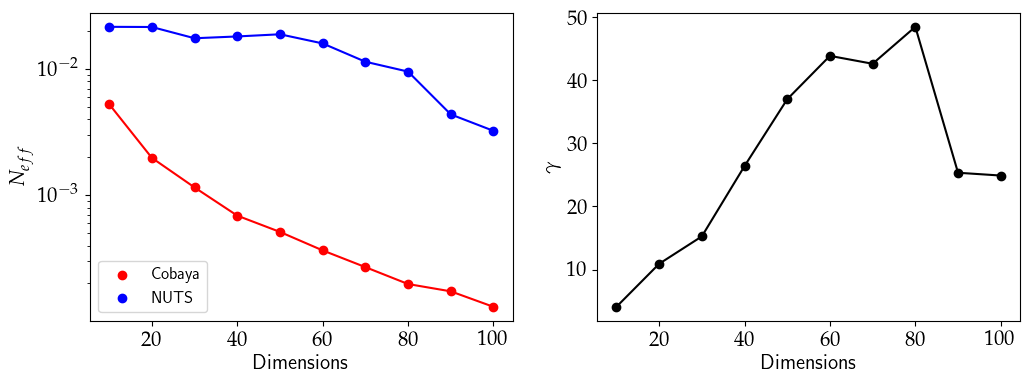

In [53]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.scatter(dimensions, df_cobaya_metrics['mean_neff'], c = 'r', label = 'Cobaya')
plt.plot(dimensions, df_cobaya_metrics['mean_neff'], c = 'r')
plt.scatter(dimensions, df_nuts_metrics['mean_neff'], c = 'b', label = 'NUTS')
plt.plot(dimensions, df_nuts_metrics['mean_neff'], c = 'b')
plt.ylabel(r'$N_{eff}$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.yscale('log')
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})

plt.subplot(122)
ratio = df_nuts_metrics['mean_neff'] / df_cobaya_metrics['mean_neff']
plt.scatter(dimensions, ratio, c = 'k')
plt.plot(dimensions, ratio, c = 'k')
# plt.axhline(1.0, linestyle = '--', c = 'k')
plt.ylabel(r'$\gamma$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.yscale('log')
# plt.savefig('/home/arrykrishna/Desktop/ros_neff.pdf', bbox_inches = 'tight')

plt.show()

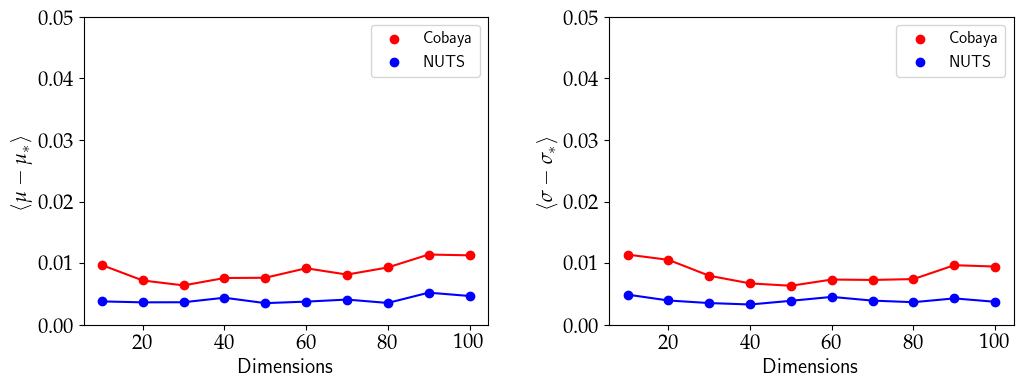

In [59]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
# plt.axhline(0.0, linestyle ='--', c = 'k')
# plt.scatter(dimensions, df_emcee_metrics['mean_mean'], c = 'r', label = 'EMCEE')
# plt.plot(dimensions, df_emcee_metrics['mean_mean'], c = 'r')
plt.scatter(dimensions, df_cobaya_metrics['mean_mean'], c = 'r', label = 'Cobaya')
plt.plot(dimensions, df_cobaya_metrics['mean_mean'], c = 'r')
plt.scatter(dimensions, df_nuts_metrics['mean_mean'], c = 'b', label = 'NUTS')
plt.plot(dimensions, df_nuts_metrics['mean_mean'], c = 'b')
plt.ylabel(r'$\langle \mu - \mu_{*}\rangle$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0.0, 0.05)
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})

plt.subplot(122)
# plt.axhline(0.0, linestyle ='--', c = 'k')
# plt.scatter(dimensions, df_emcee_metrics['mean_std'], c = 'r', label = 'EMCEE')
# plt.plot(dimensions, df_emcee_metrics['mean_std'], c = 'r')
plt.scatter(dimensions, df_cobaya_metrics['mean_std'], c = 'r', label = 'Cobaya')
plt.plot(dimensions, df_cobaya_metrics['mean_std'], c = 'r')
plt.scatter(dimensions, df_nuts_metrics['mean_std'], c = 'b', label = 'NUTS')
plt.plot(dimensions, df_nuts_metrics['mean_std'], c = 'b')
plt.ylabel(r'$\langle \sigma - \sigma_{*}\rangle$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0.0, 0.05)
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
# plt.savefig('plots/ros_dist.pdf', bbox_inches = 'tight')
plt.show()

In [1]:
# Gelman-Rubin test

In [12]:
import yaml
import numpy as np 

In [13]:
dimensions = np.arange(1, 11, 1) * 10

In [15]:
for d in dimensions:
    with open(f"CobayaROS/experiment_{d}_1/ros.checkpoint", 'r') as stream:
        gr_1 = yaml.safe_load(stream)['sampler']['mcmc']['Rminus1_last'] + 1 

    with open(f"CobayaROS/experiment_{d}_2/ros.checkpoint", 'r') as stream:
        gr_2 = yaml.safe_load(stream)['sampler']['mcmc']['Rminus1_last'] + 1 
    print(d, np.mean([gr_1, gr_2]))

10 1.0085028287968214
20 1.0115968347974649
30 1.0235446369827472
40 1.0418125381338674
50 1.0710494400002453
60 1.0977399314923741
70 1.126504884554719
80 1.2170579414963387
90 1.2515158254588314
100 1.3963944348738544


In [19]:
def model():
    pass

In [38]:
for d in dimensions:

    testing = pickle_load('rosenbrock', f'nuts_{d}')
    nuts_samples = process_nuts_chains(testing, 10)
    nsteps_nuts = testing.get_extra_fields(group_by_chain=False)['num_steps'].sum().item()
    accep_prob = testing.last_state.accept_prob.tolist()
    stats = calculate_summary(nuts_samples[0], nuts_samples[1], nsteps_nuts, thin = THIN)

    nuts_metrics = calculate_metrics(stats)
    nuts_metrics['ap'] = np.mean(accep_prob)
    nuts_metrics['nevals'] = nsteps_nuts
    nuts_metrics['gr'] = stats['r_hat'].mean()
    
    print(nuts_metrics)
    print('-'*50)

{'mean_neff': 0.021709870939800778, 'mean_mean': 0.0038000000000000035, 'mean_std': 0.004900000000000004, 'ap': 0.975807249546051, 'nevals': 461800, 'gr': 1.0001}
--------------------------------------------------
{'mean_neff': 0.02155888330396193, 'mean_mean': 0.0043000000000000035, 'mean_std': 0.003799999999999998, 'ap': 0.8332101404666901, 'nevals': 560636, 'gr': 1.0001}
--------------------------------------------------
{'mean_neff': 0.017812546374979275, 'mean_mean': 0.0032000000000000028, 'mean_std': 0.0043000000000000035, 'ap': 0.8831253349781036, 'nevals': 771968, 'gr': 1.0}
--------------------------------------------------
{'mean_neff': 0.018157256596379404, 'mean_mean': 0.004400000000000004, 'mean_std': 0.003700000000000003, 'ap': 0.9869848191738129, 'nevals': 863504, 'gr': 1.0}
--------------------------------------------------
{'mean_neff': 0.01883478441658137, 'mean_mean': 0.0032000000000000028, 'mean_std': 0.003500000000000003, 'ap': 0.9938193559646606, 'nevals': 906656,